# Image Classification Using Swin Transformer

Image_resolution = 224 x 224

patch_size = 4 x 4

number of features in one patch = 4 x 4 x 3 = 48

total number of patches in the whole image = 224/4 x 224/4 = 3136

In [3]:
#!pip install timm

In [4]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the image file
image_path = 'test.jpg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)


Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [8]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches


Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


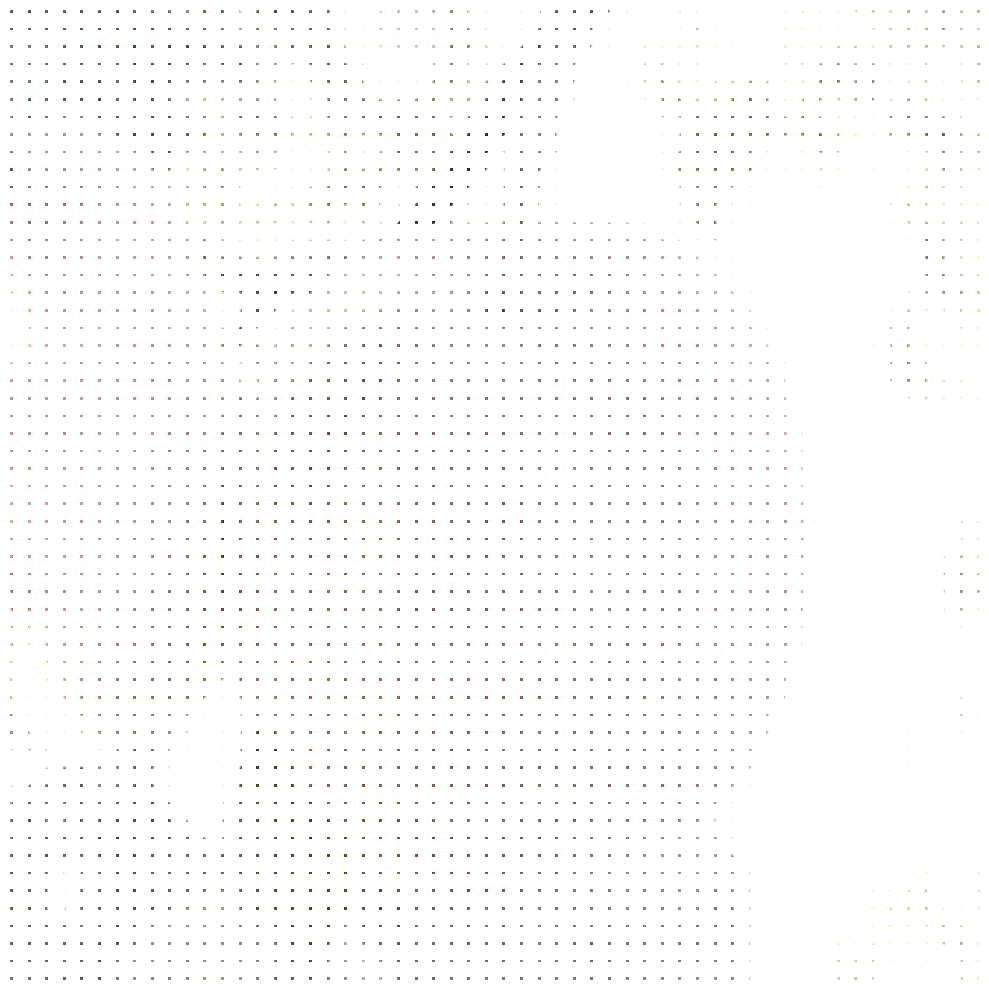

In [9]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

# displaying all the patches (4*4) to visualize properly

Total number of windows: 3136


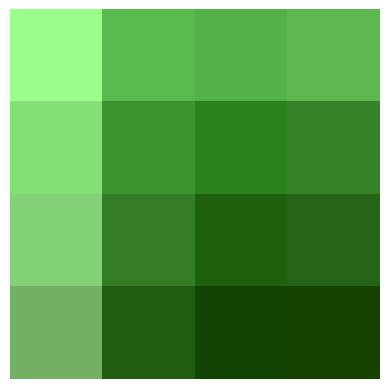

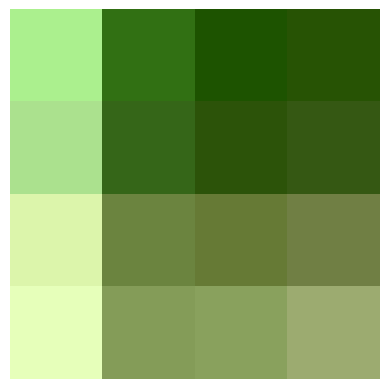

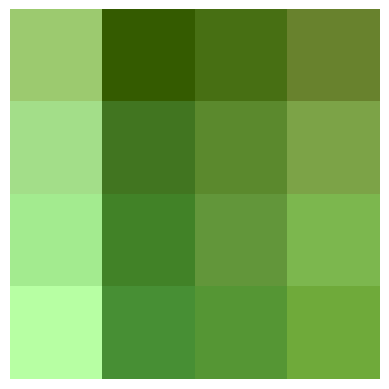

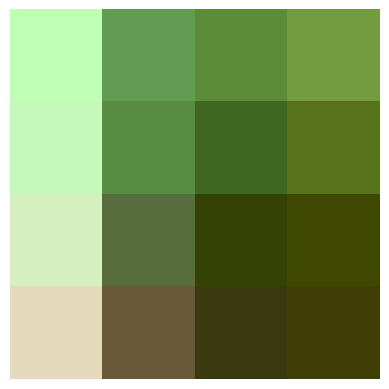

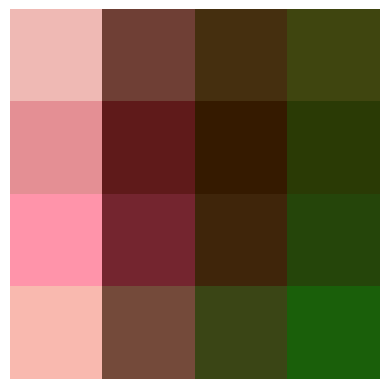

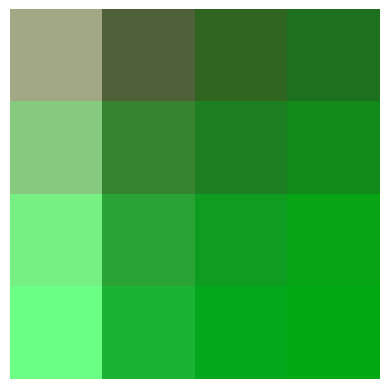

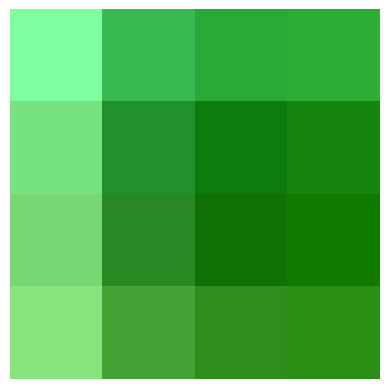

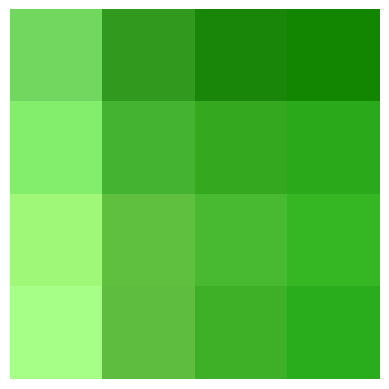

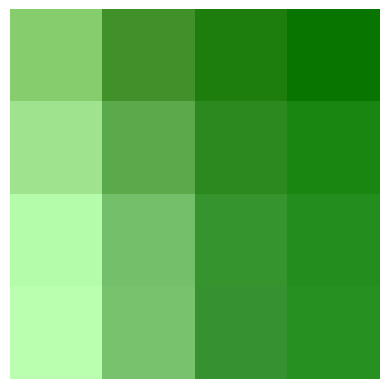

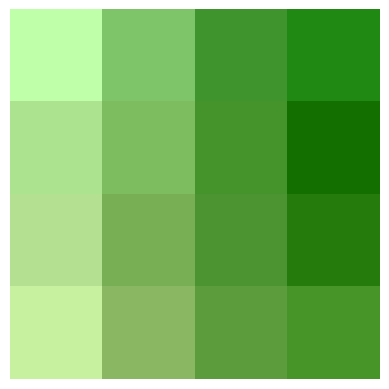

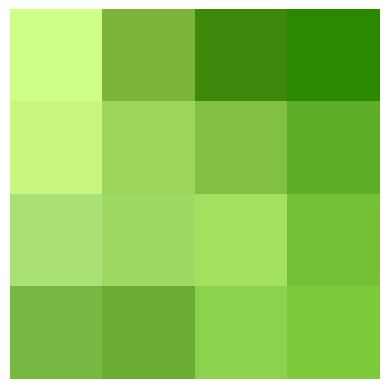

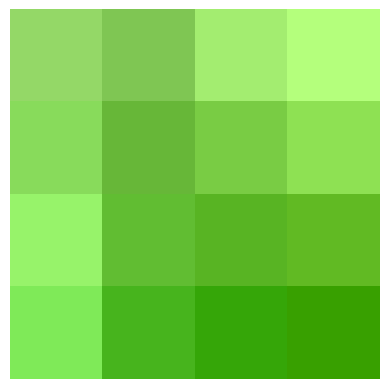

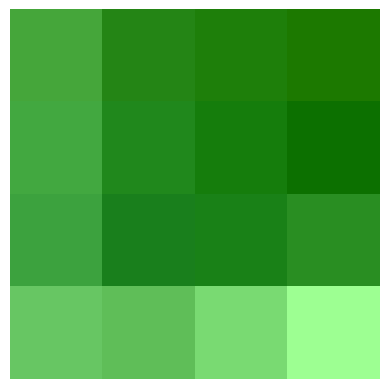

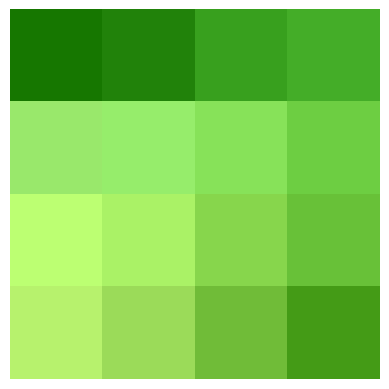

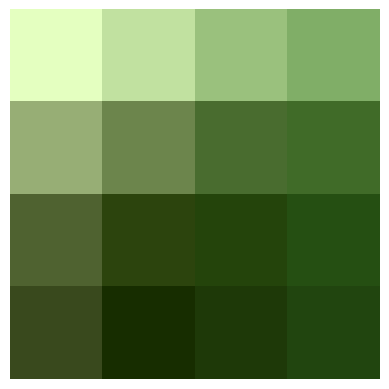

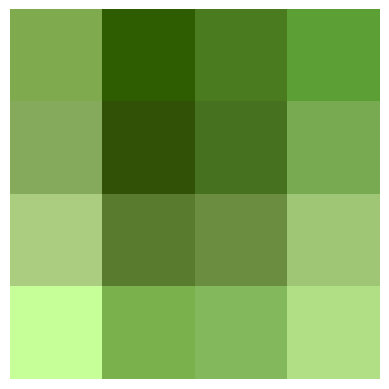

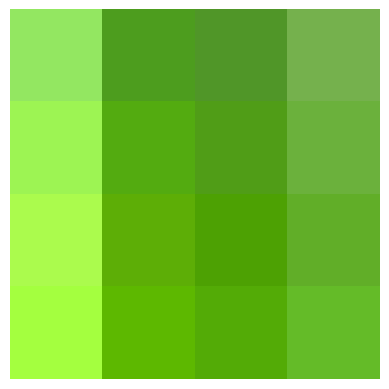

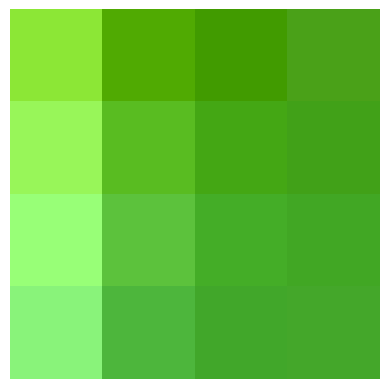

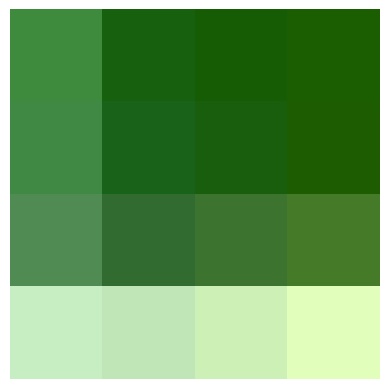

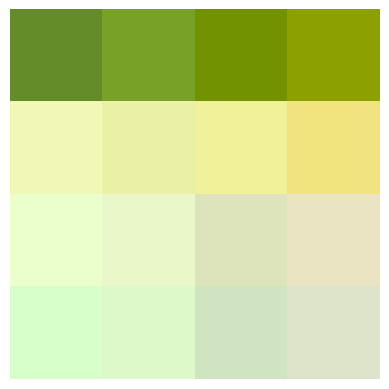

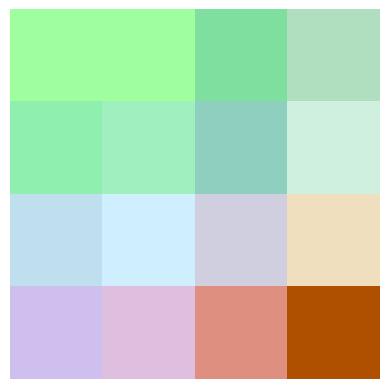

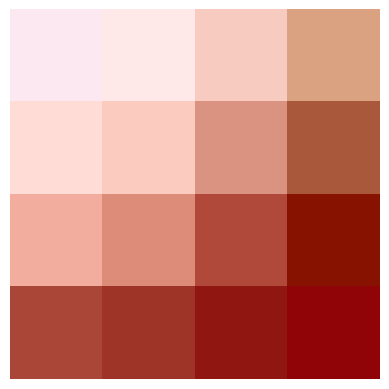

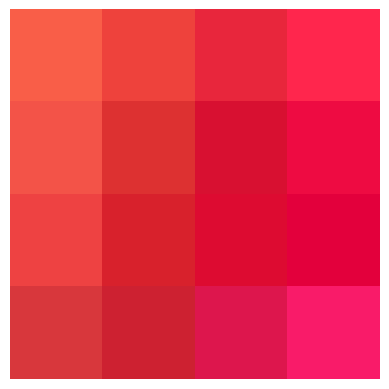

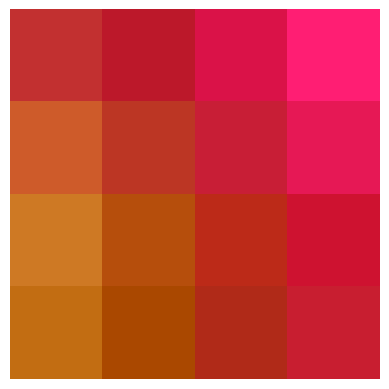

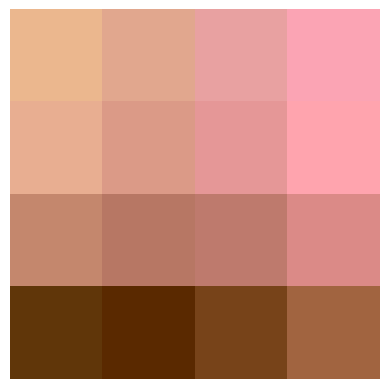

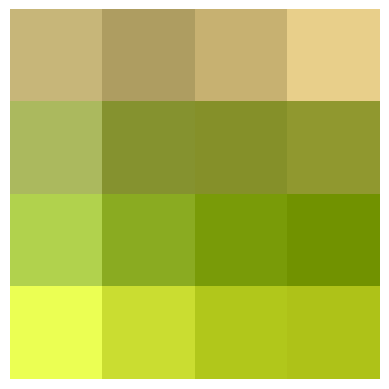

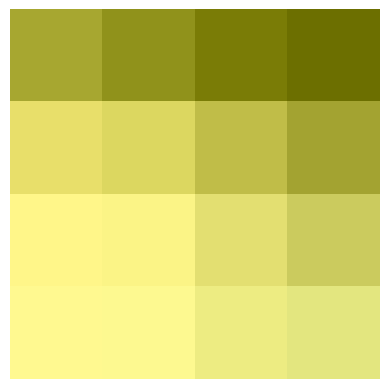

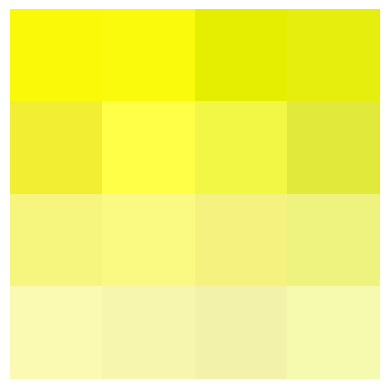

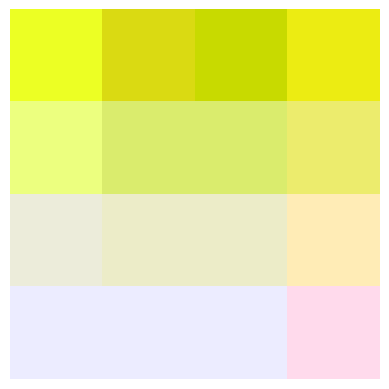

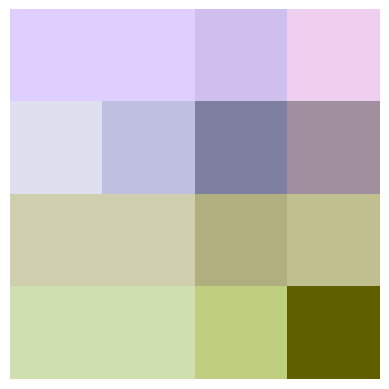

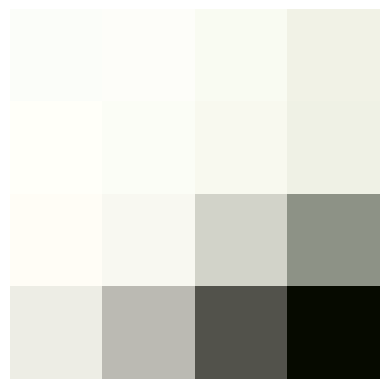

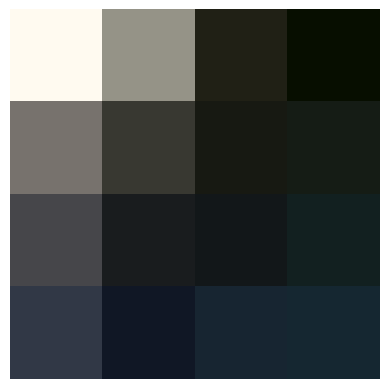

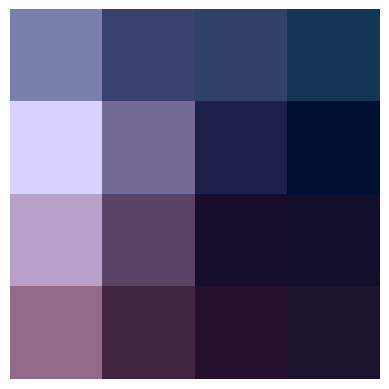

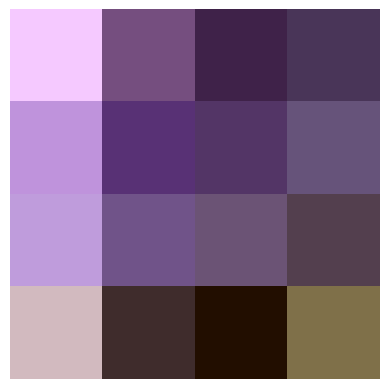

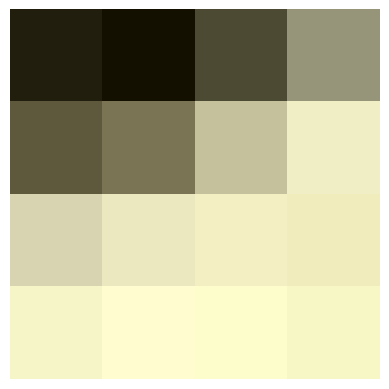

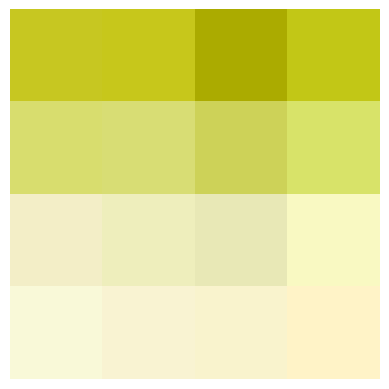

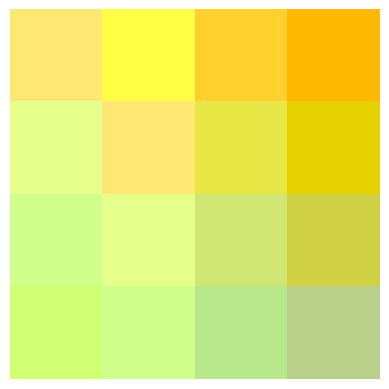

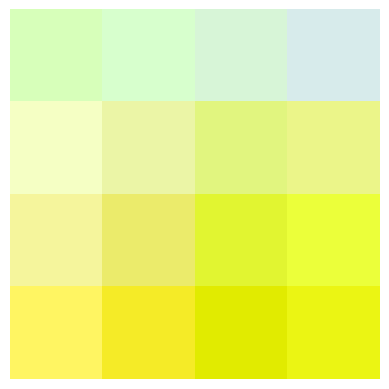

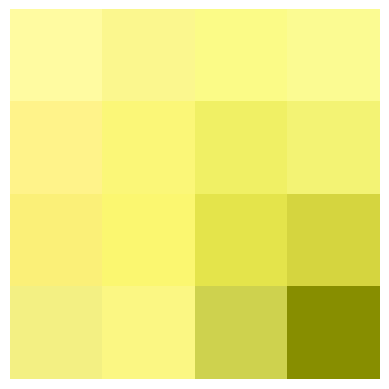

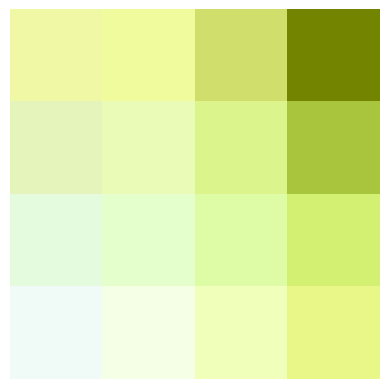

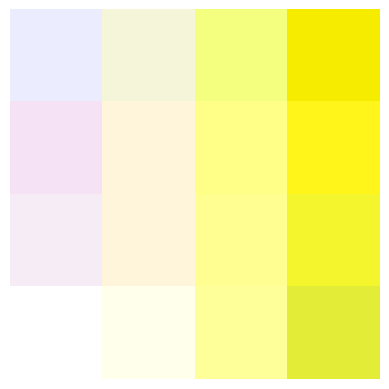

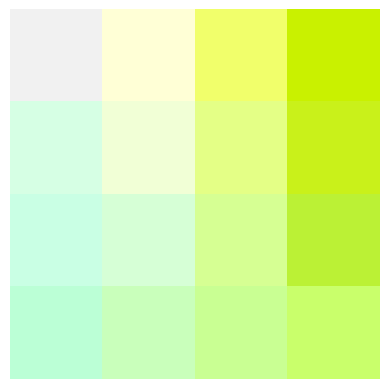

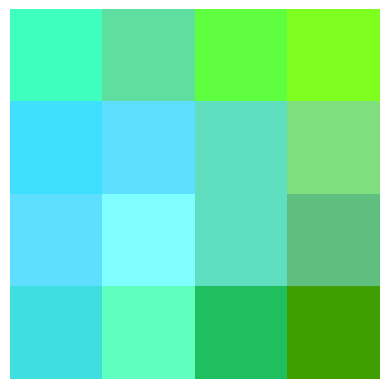

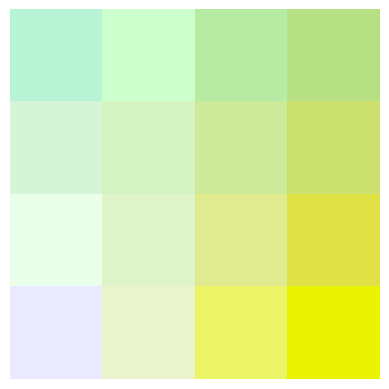

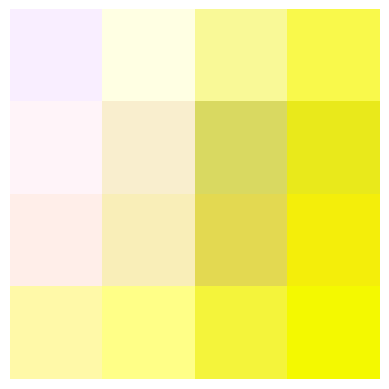

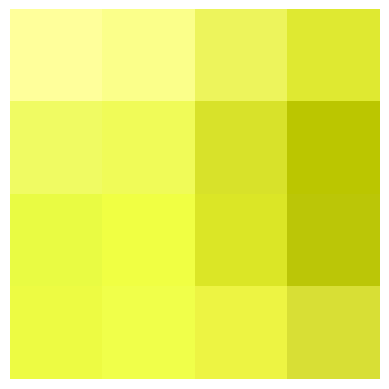

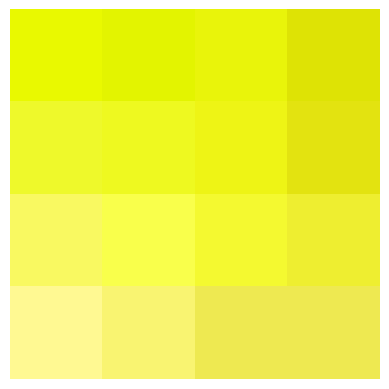

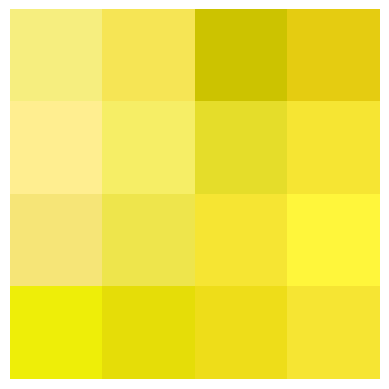

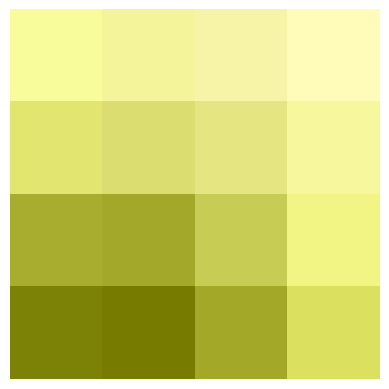

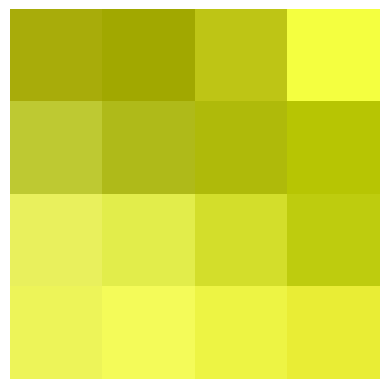

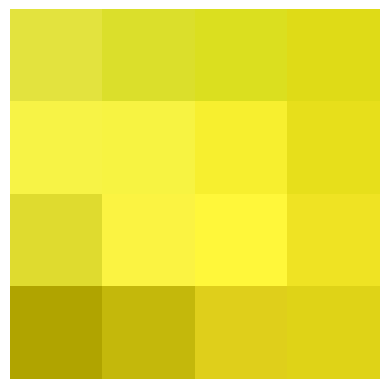

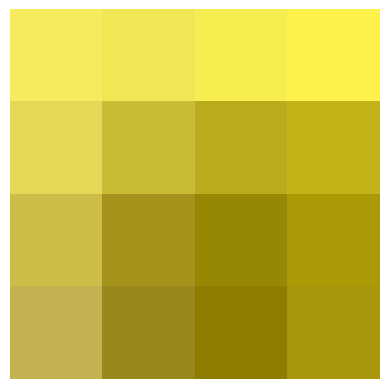

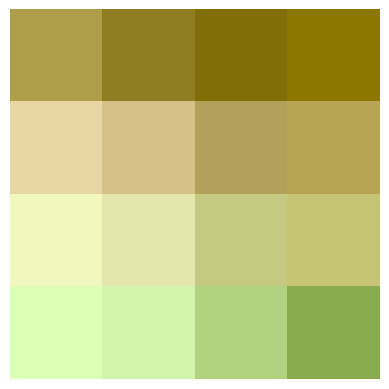

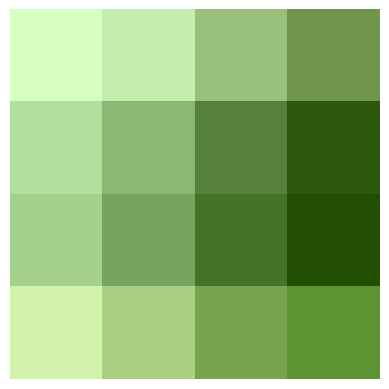

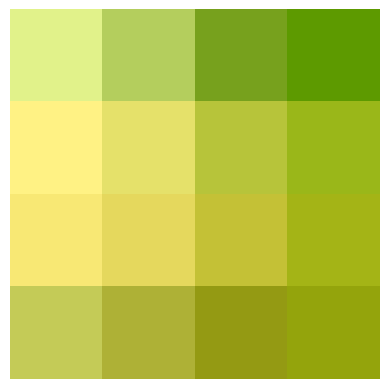

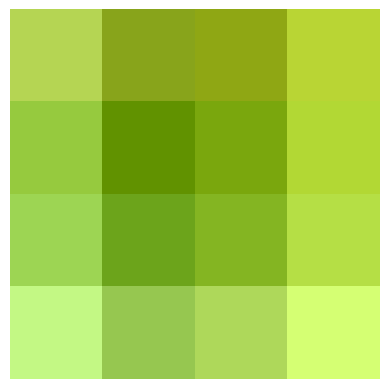

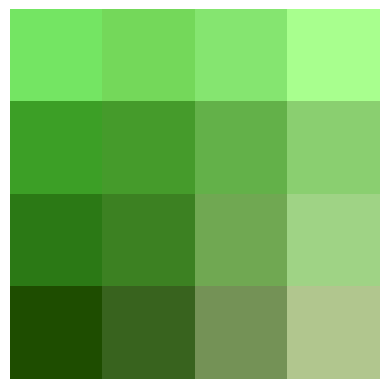

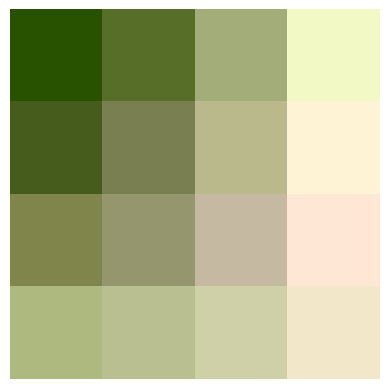

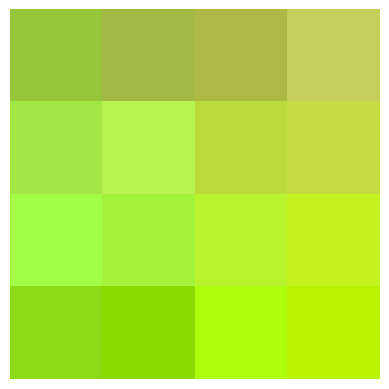

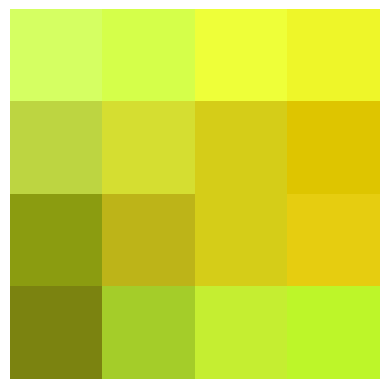

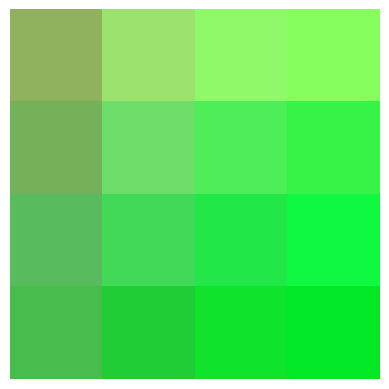

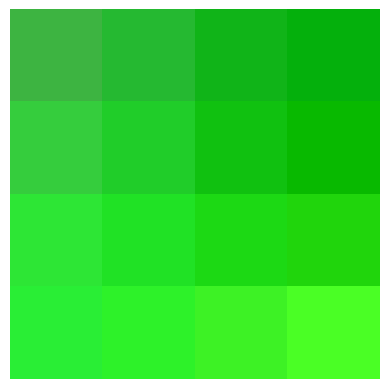

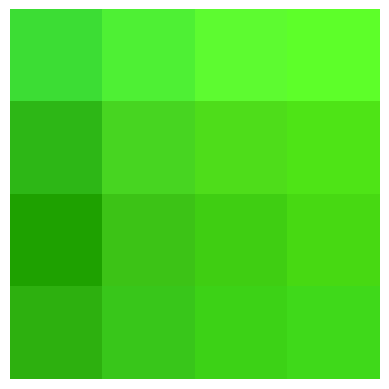

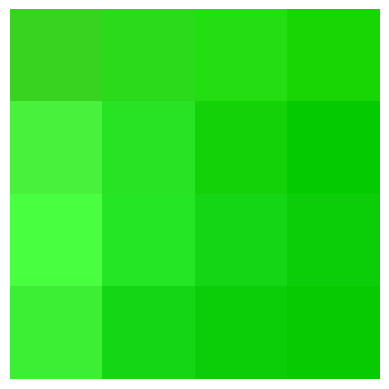

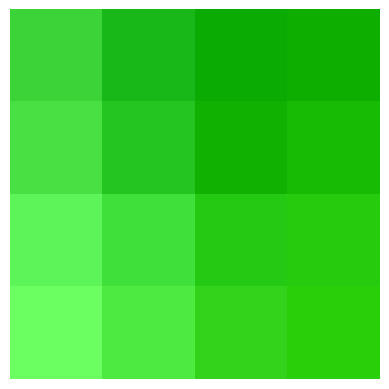

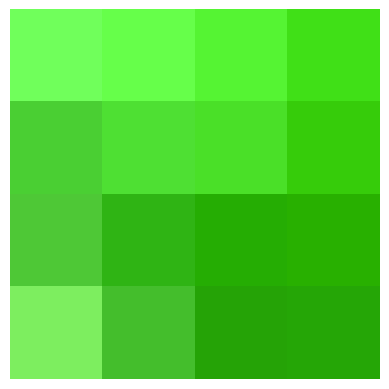

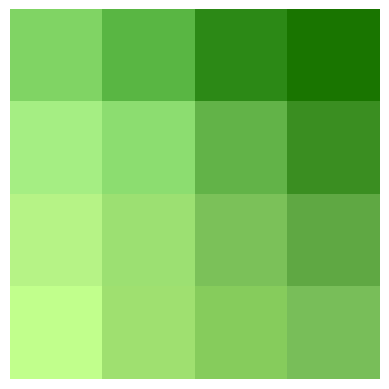

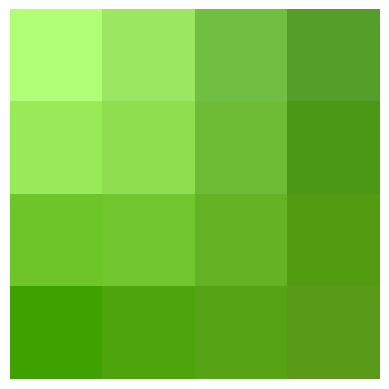

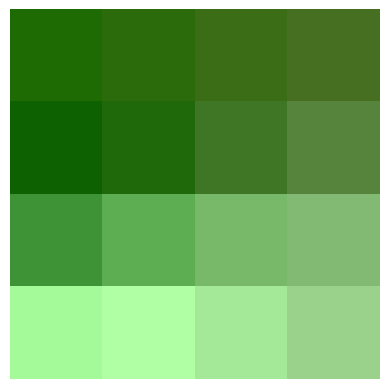

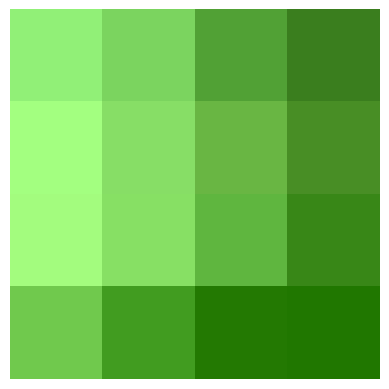

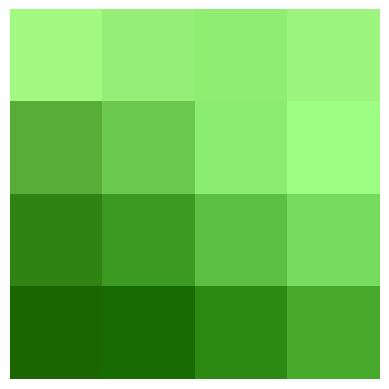

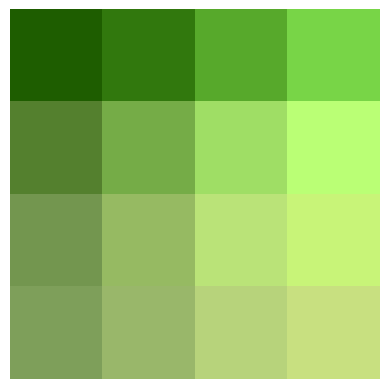

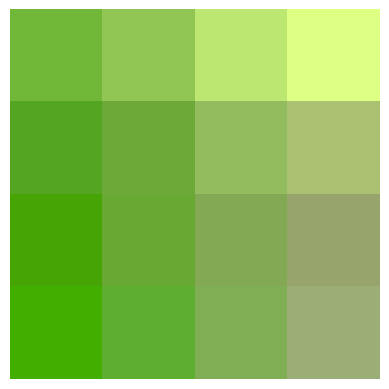

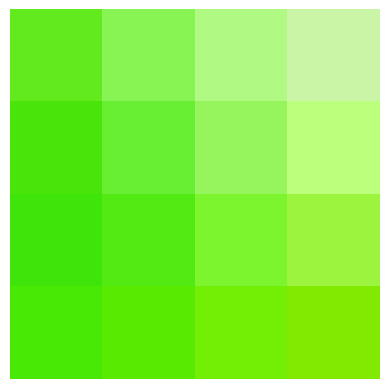

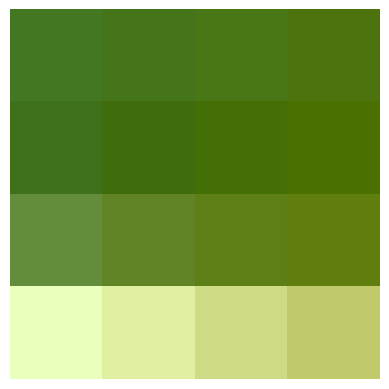

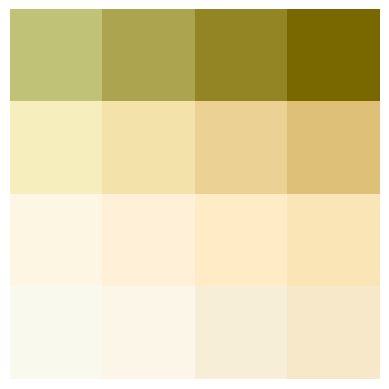

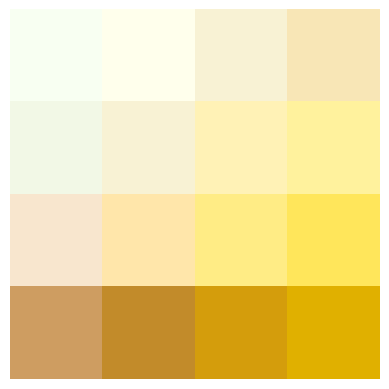

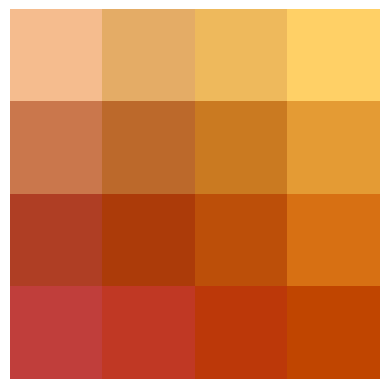

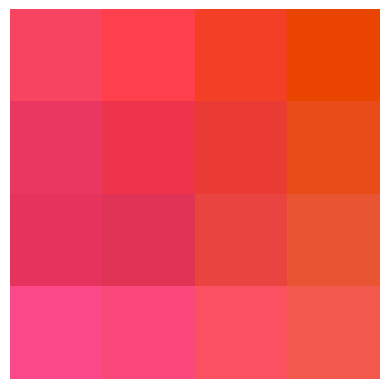

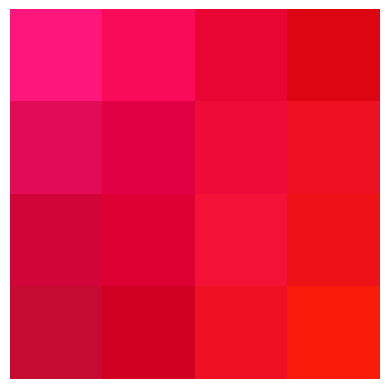

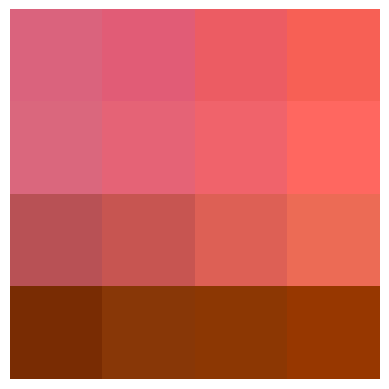

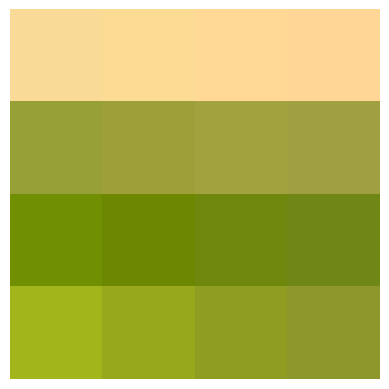

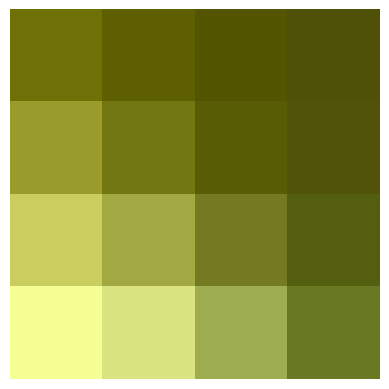

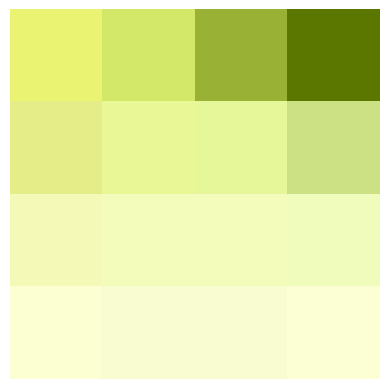

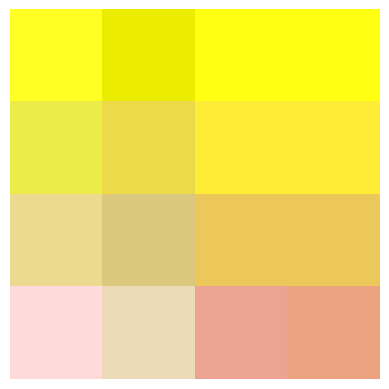

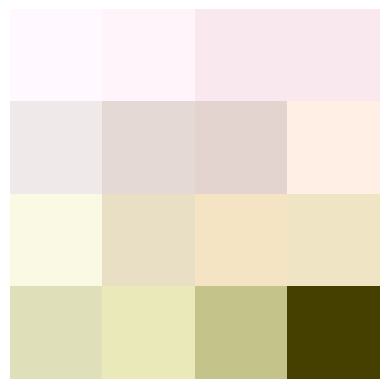

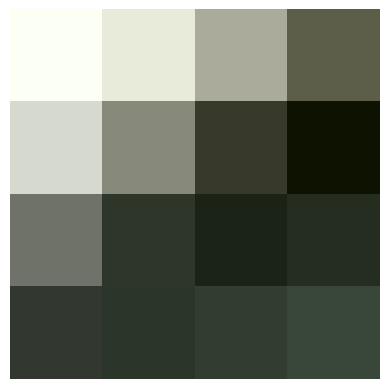

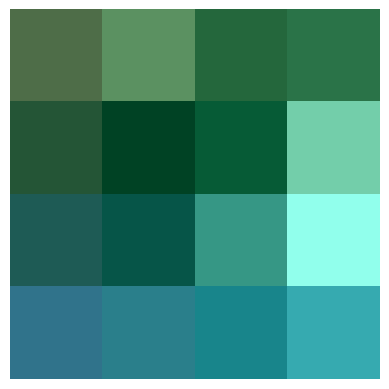

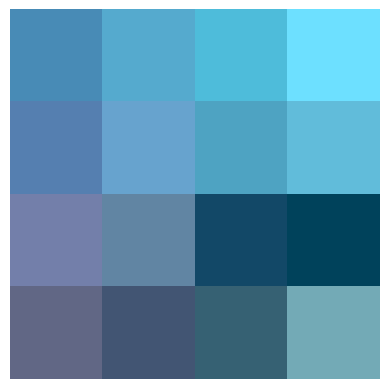

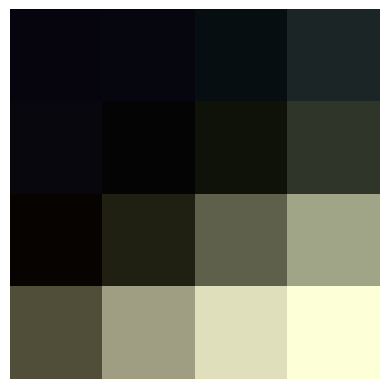

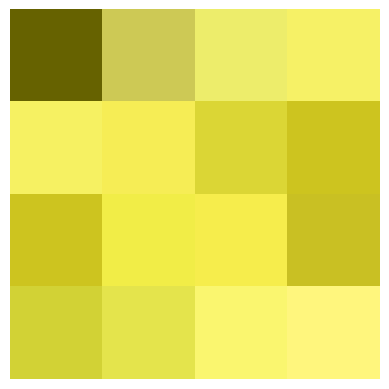

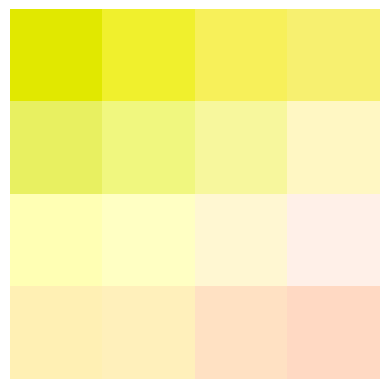

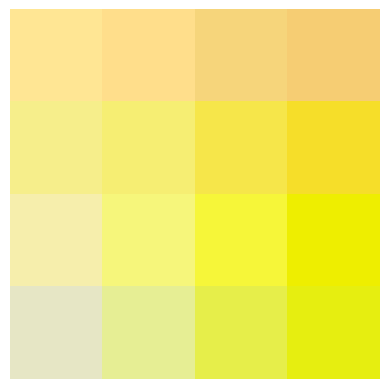

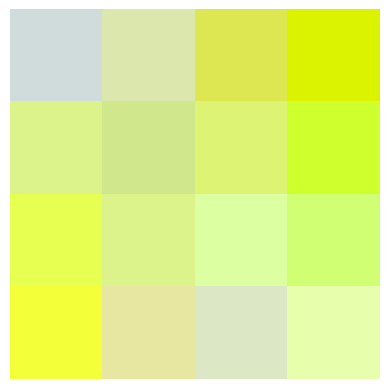

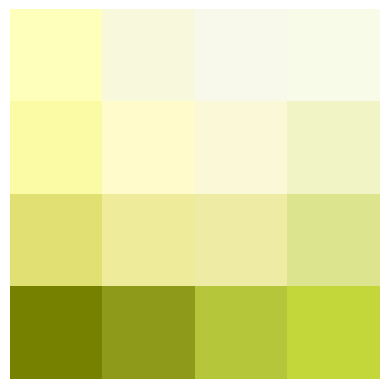

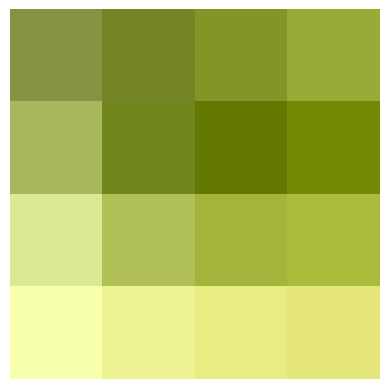

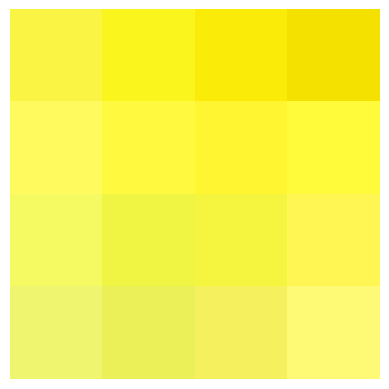

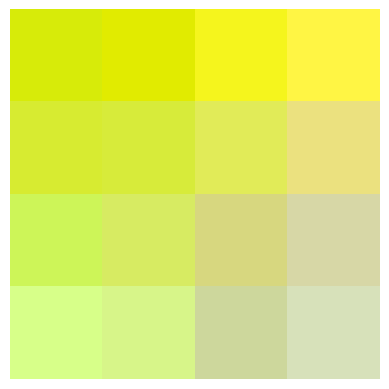

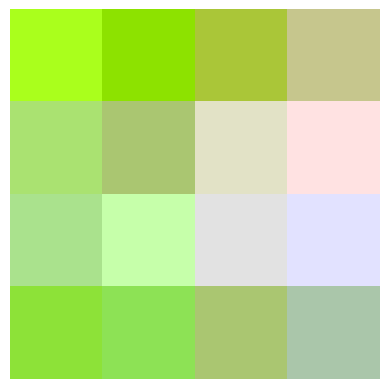

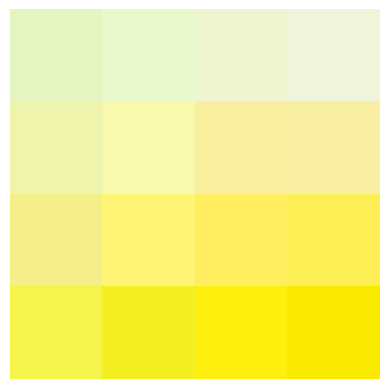

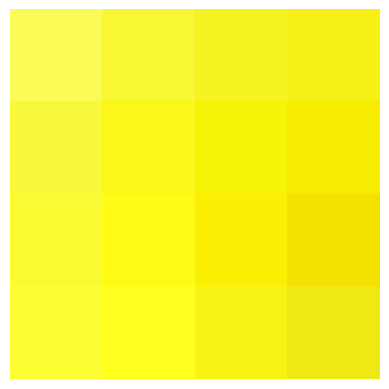

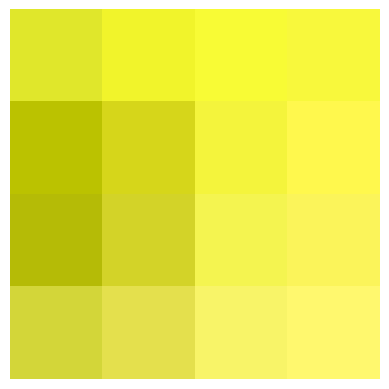

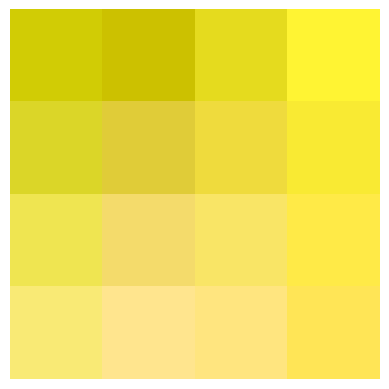

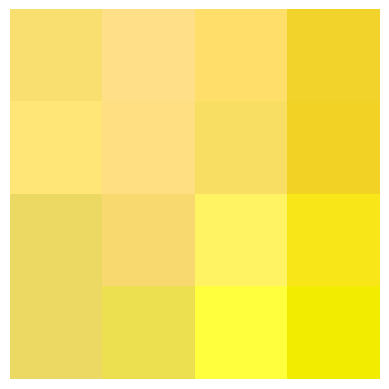

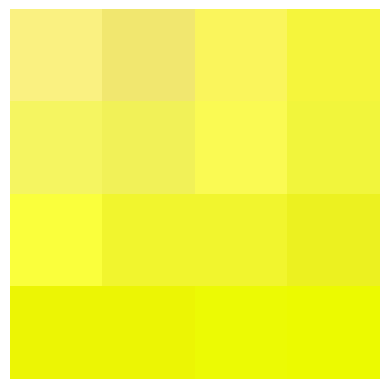

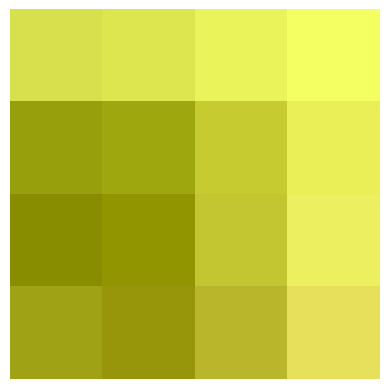

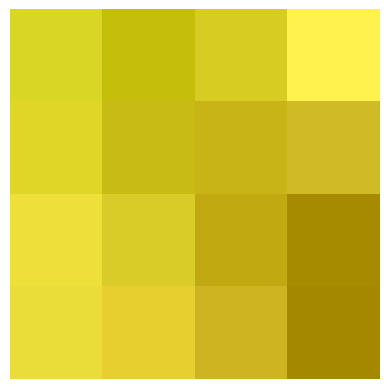

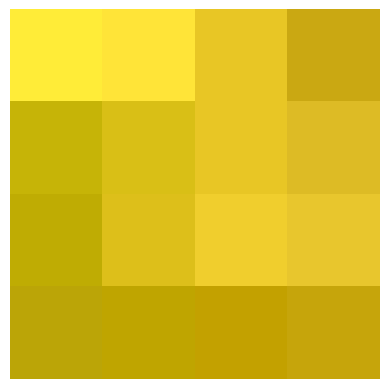

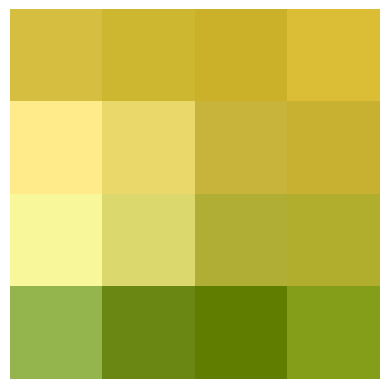

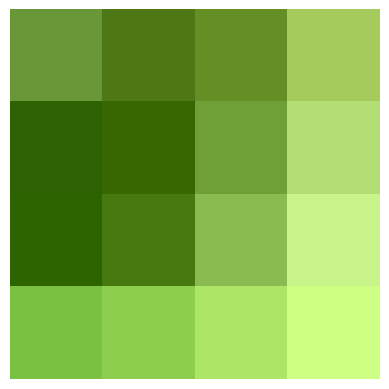

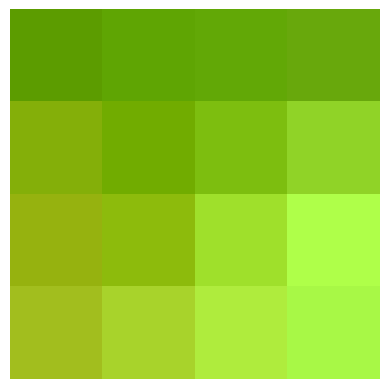

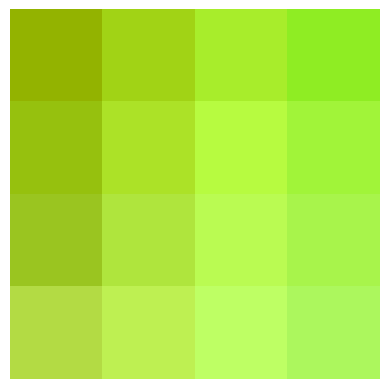

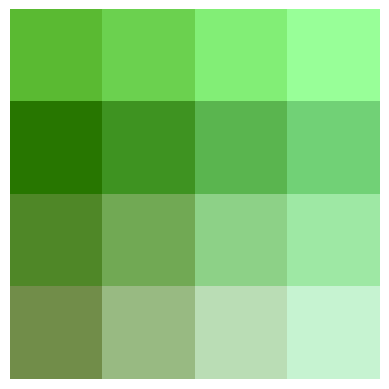

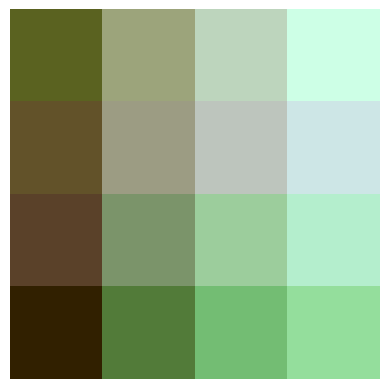

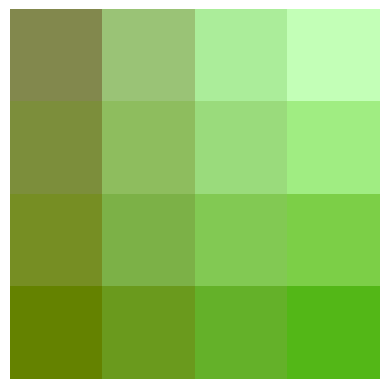

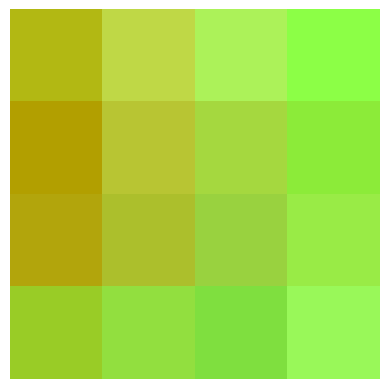

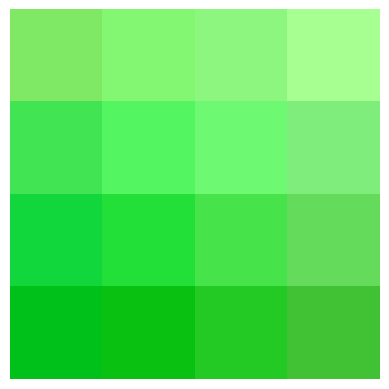

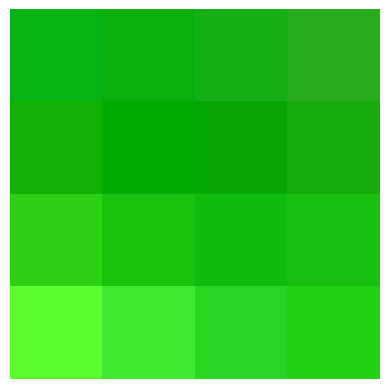

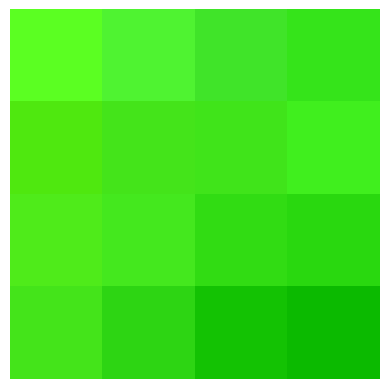

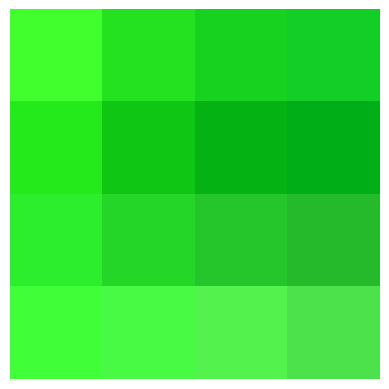

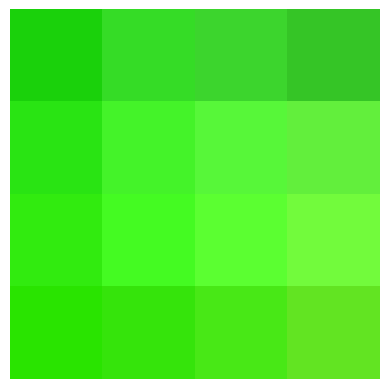

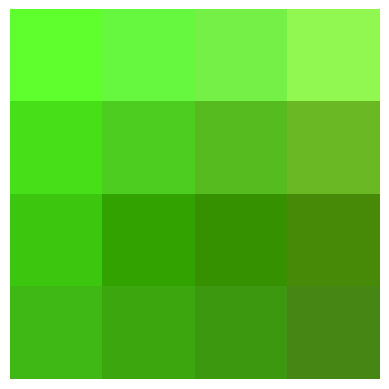

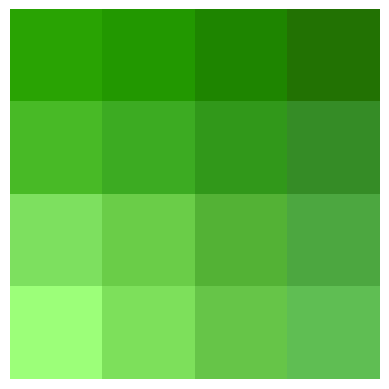

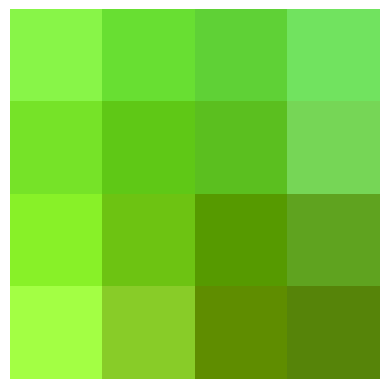

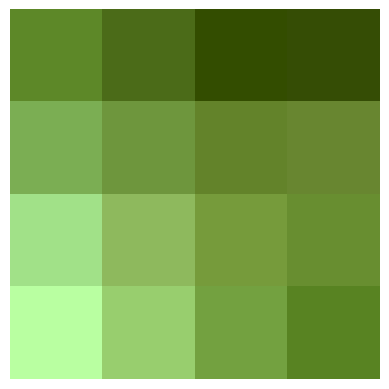

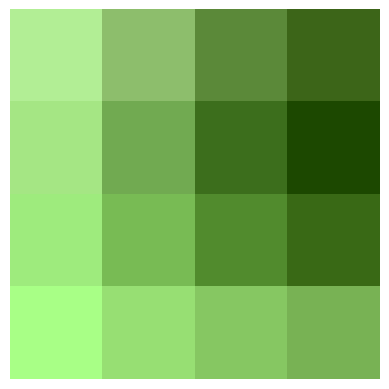

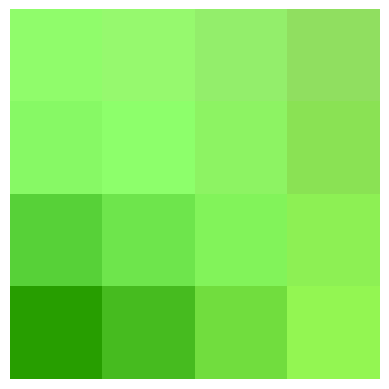

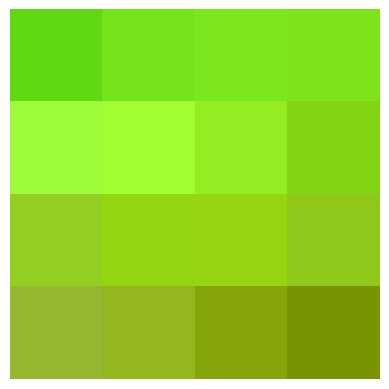

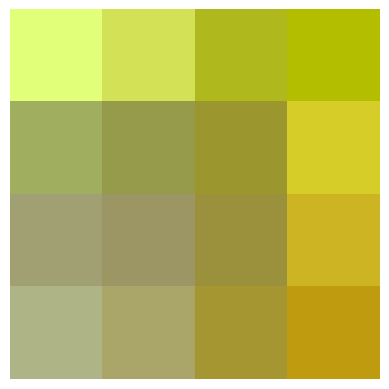

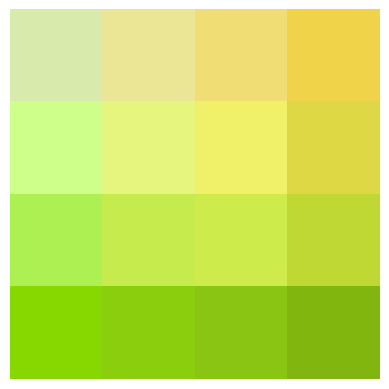

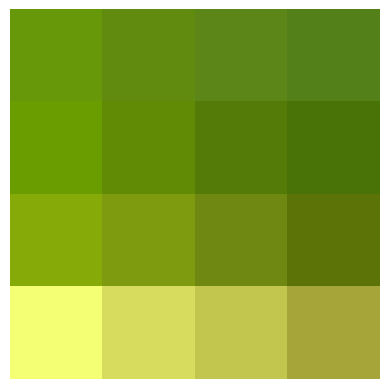

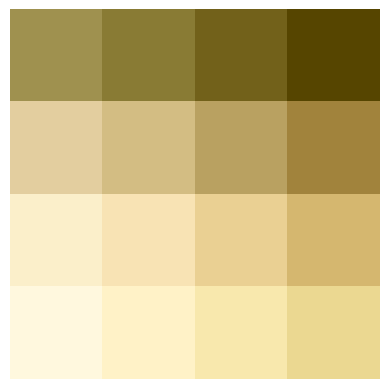

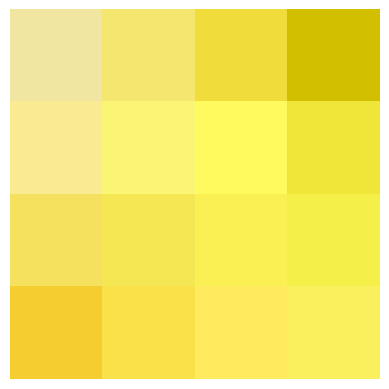

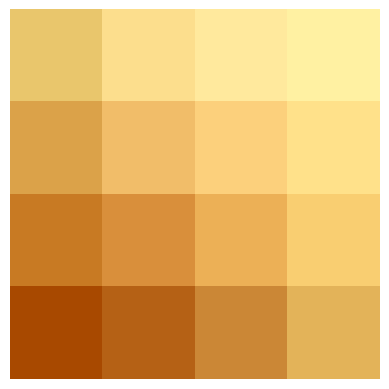

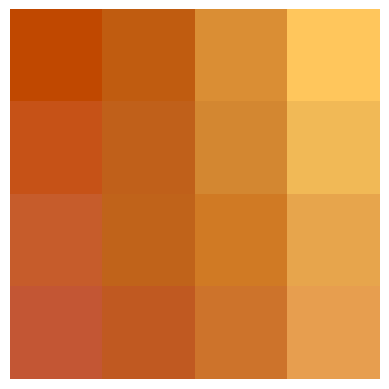

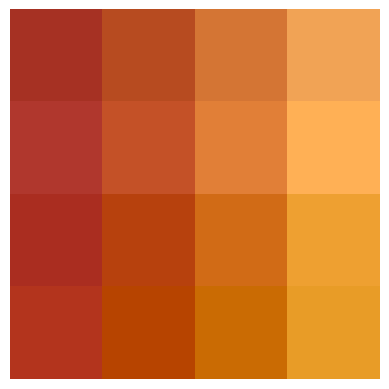

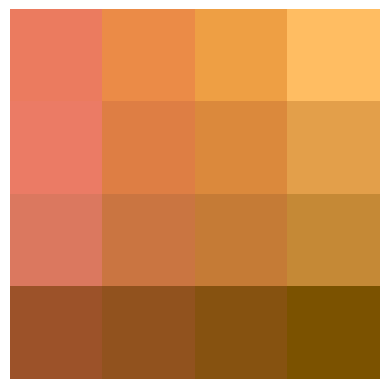

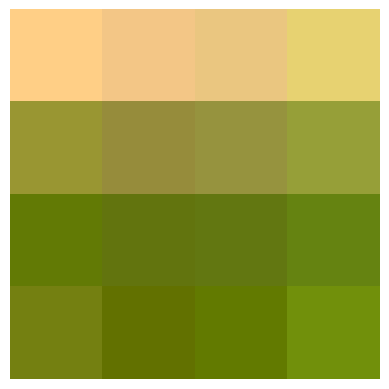

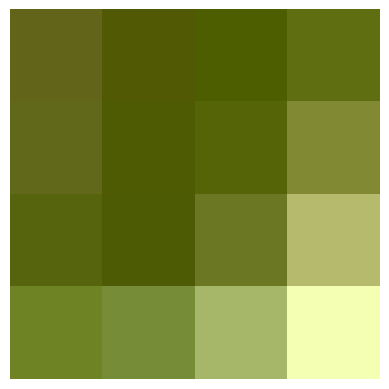

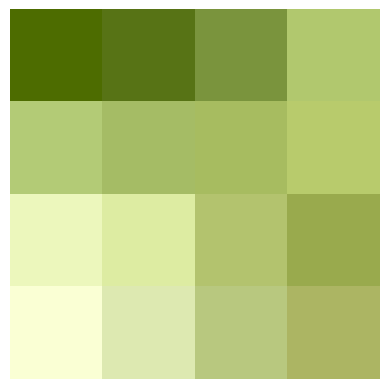

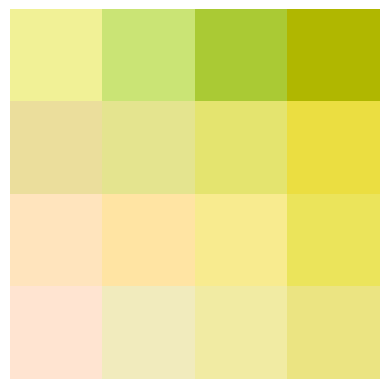

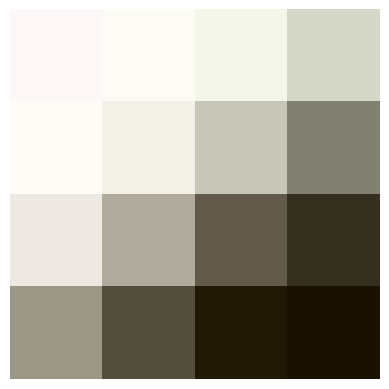

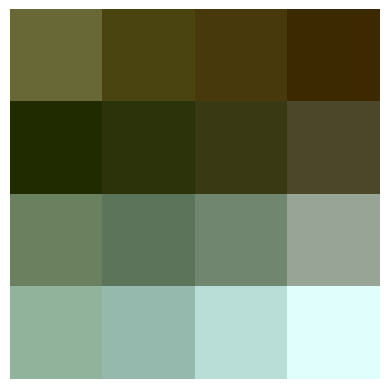

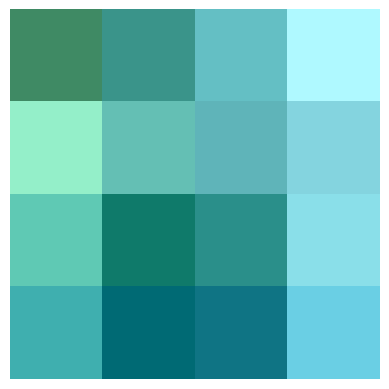

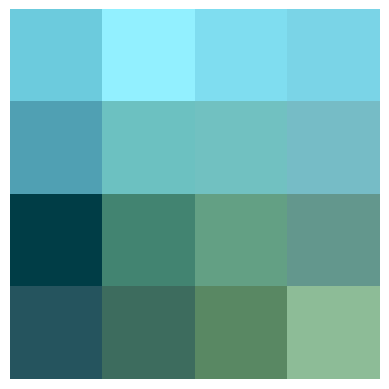

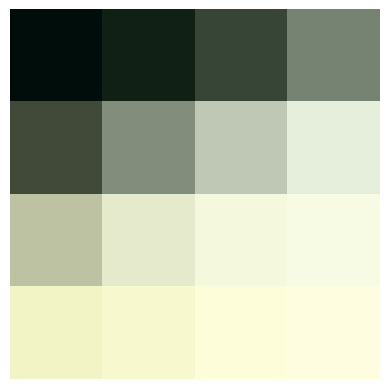

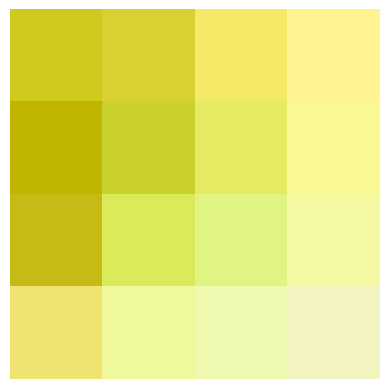

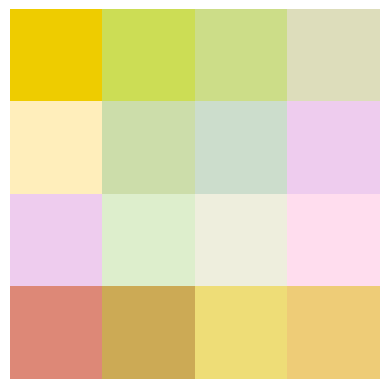

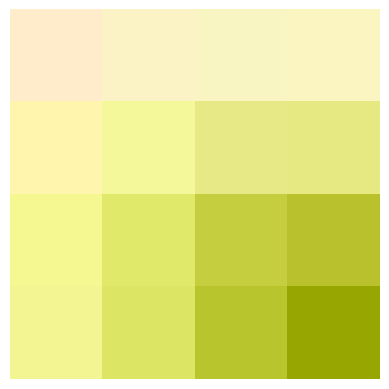

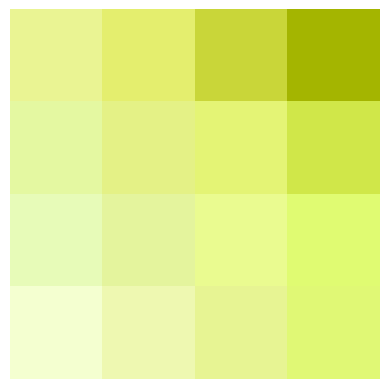

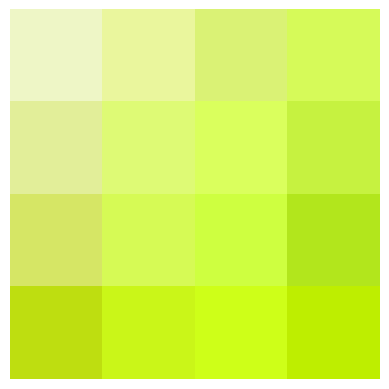

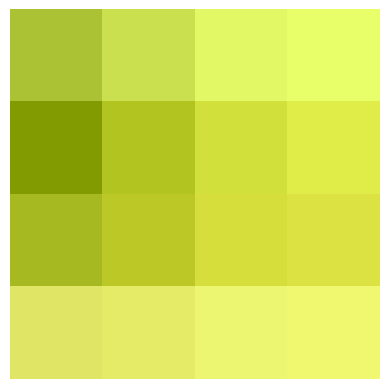

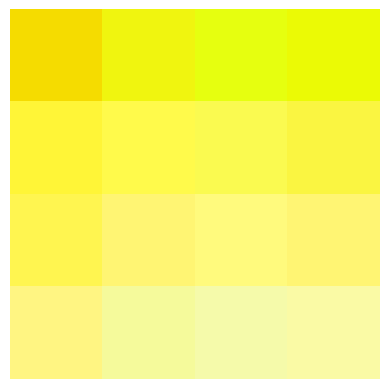

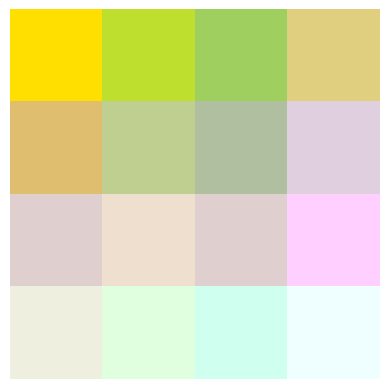

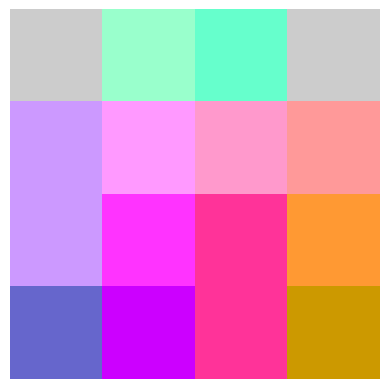

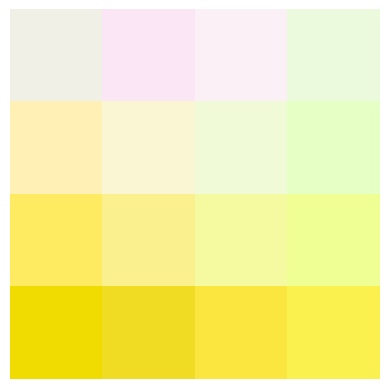

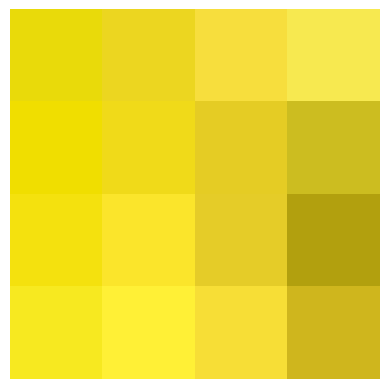

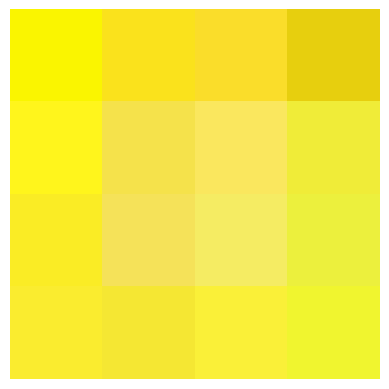

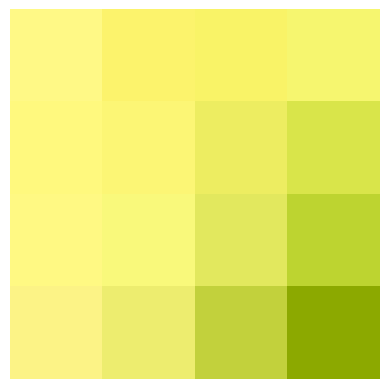

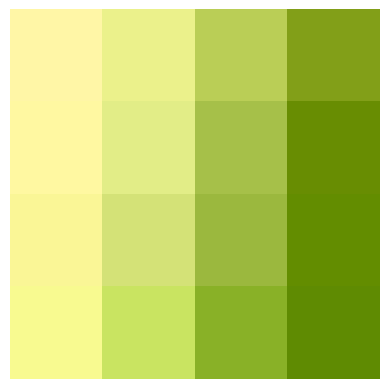

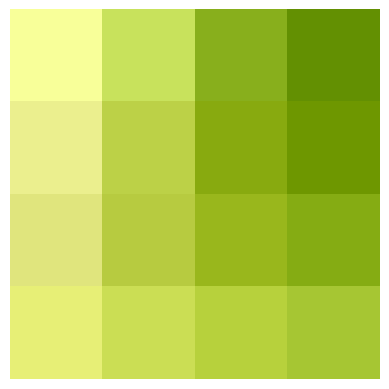

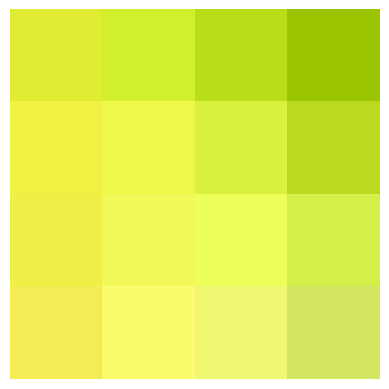

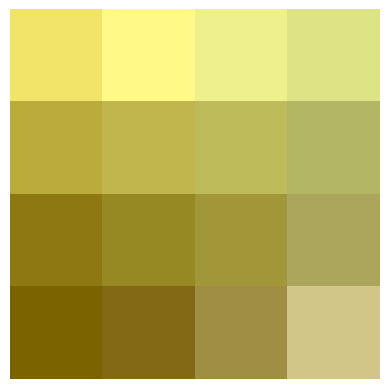

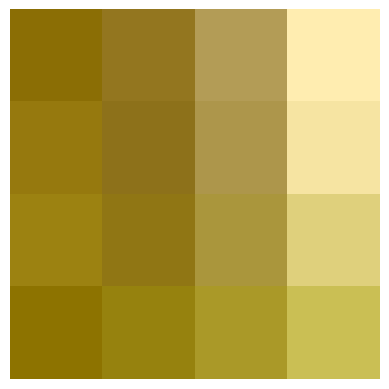

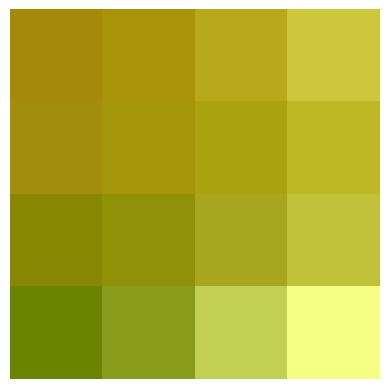

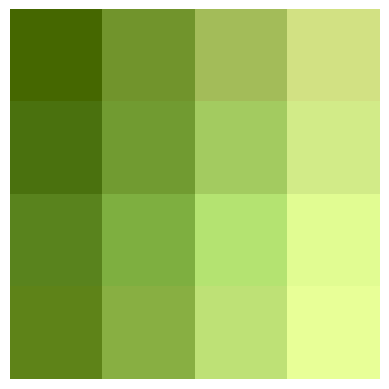

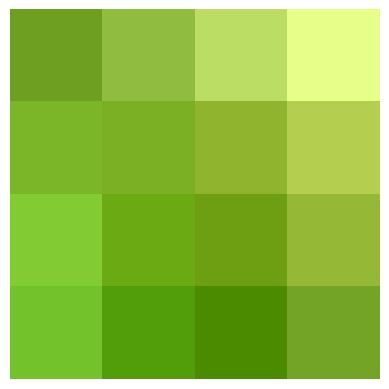

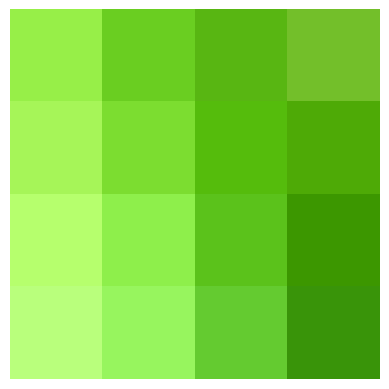

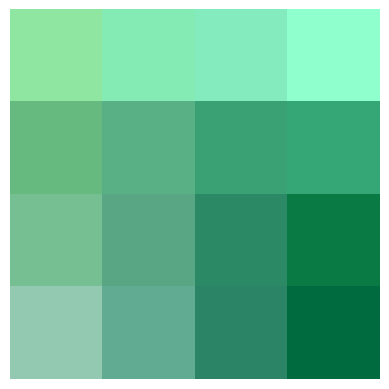

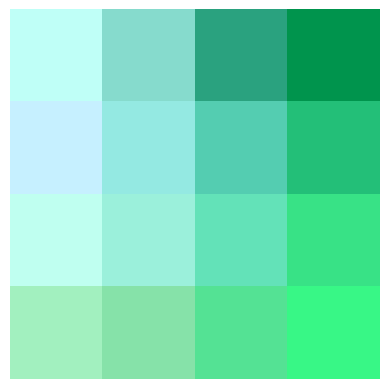

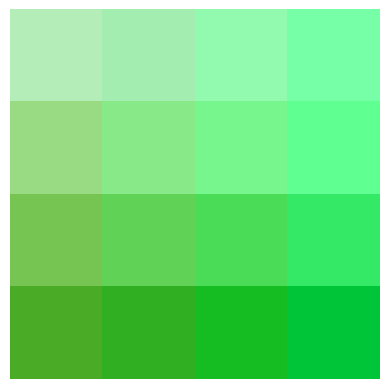

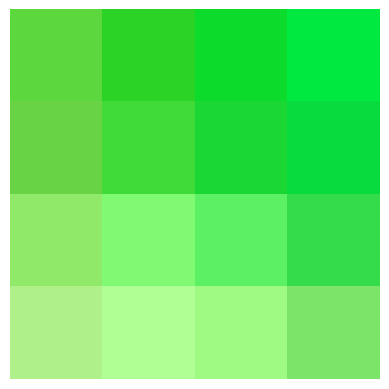

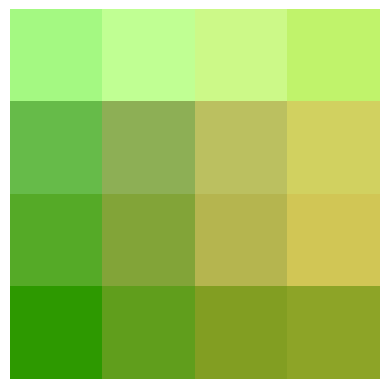

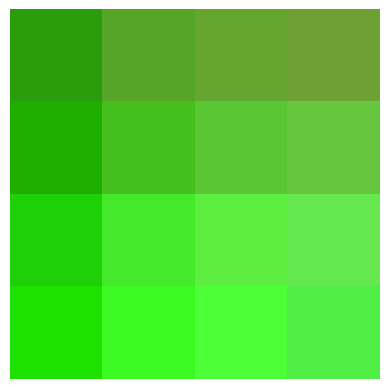

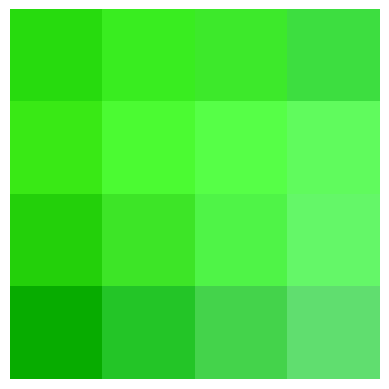

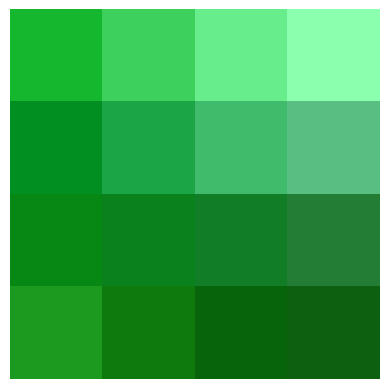

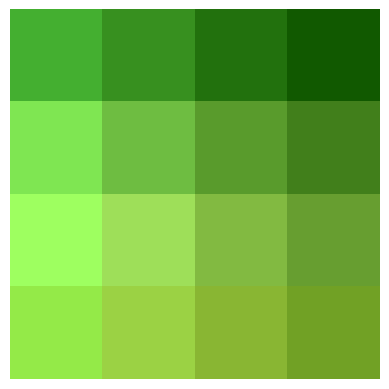

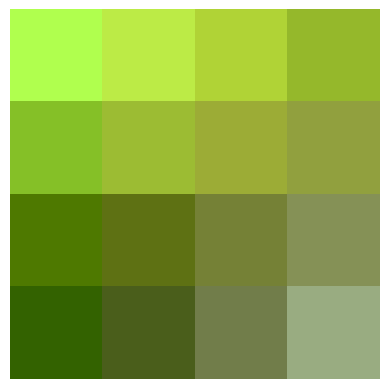

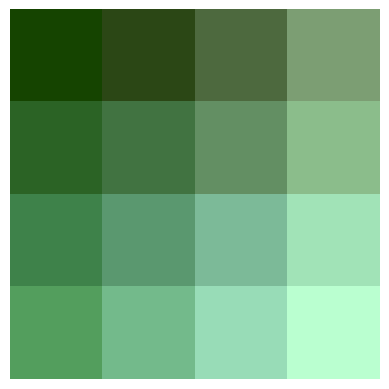

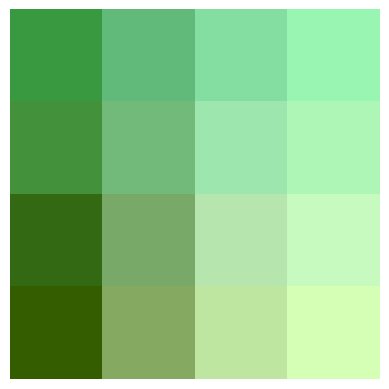

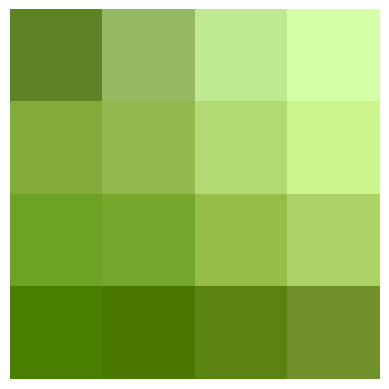

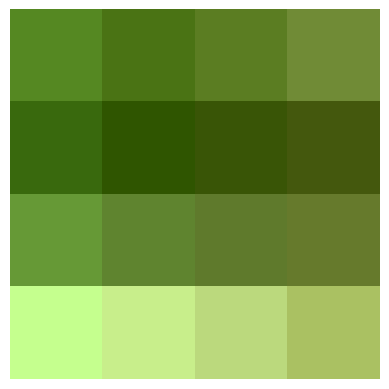

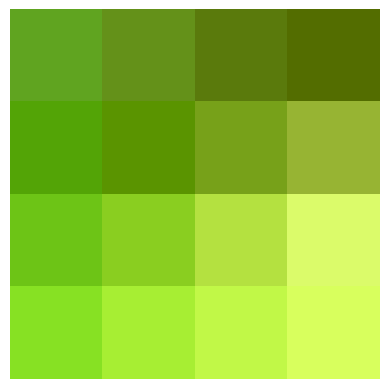

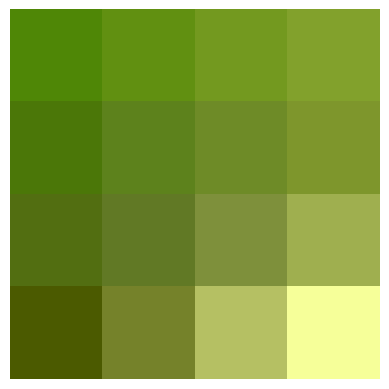

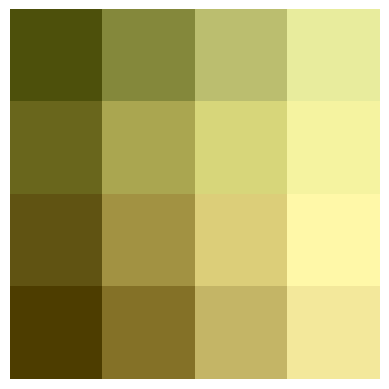

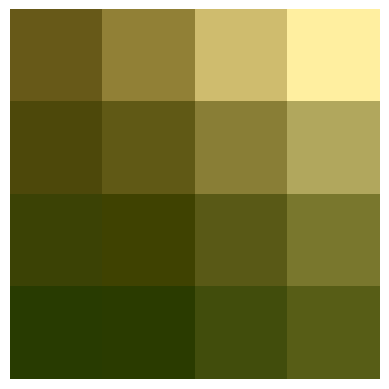

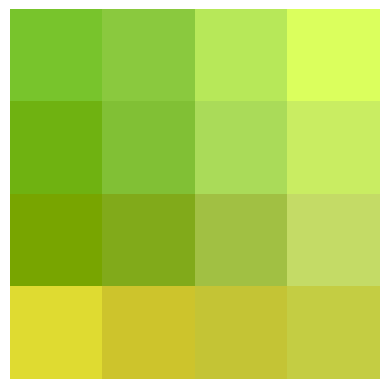

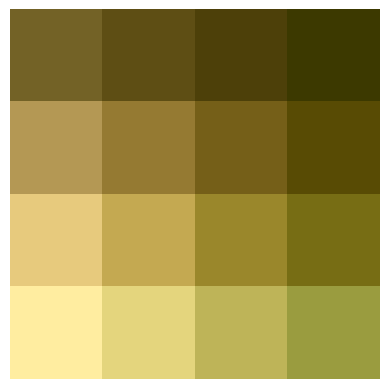

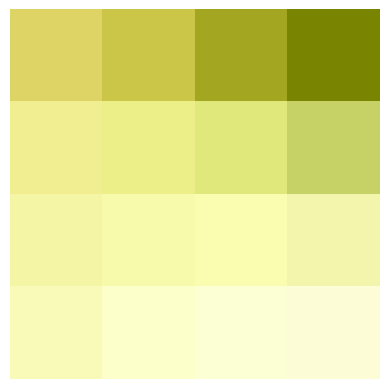

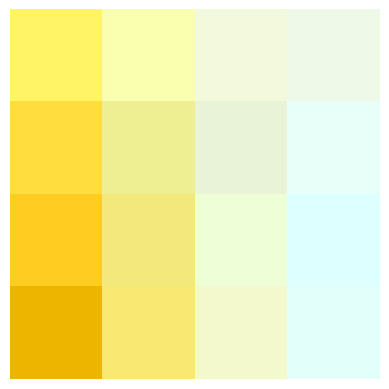

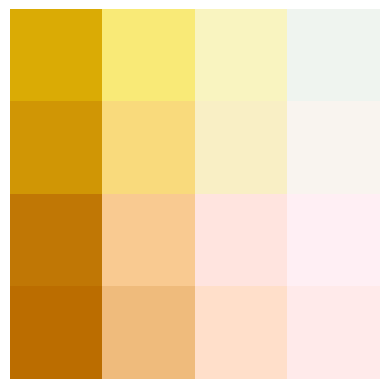

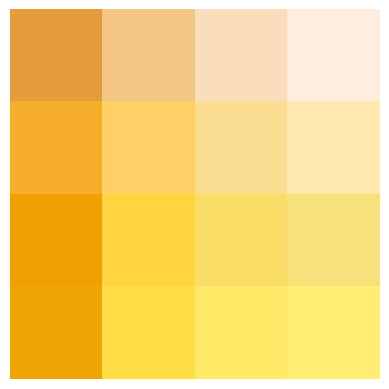

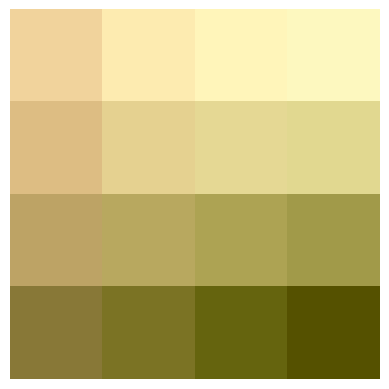

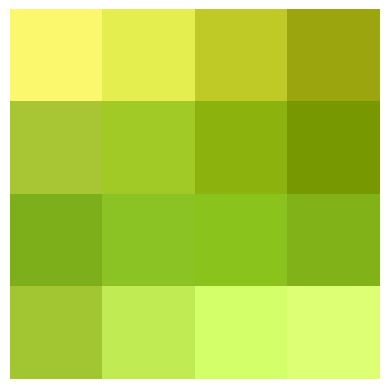

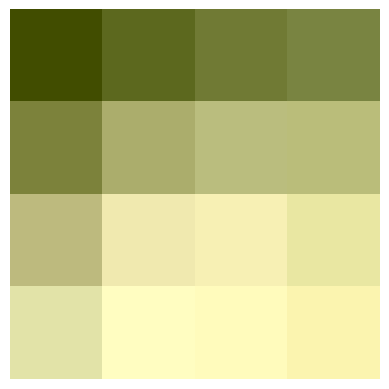

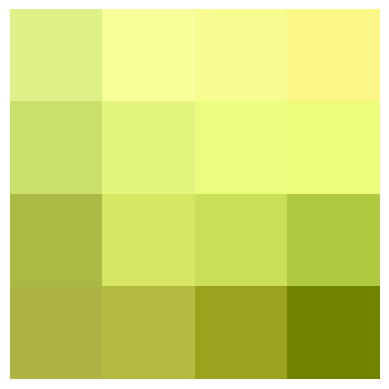

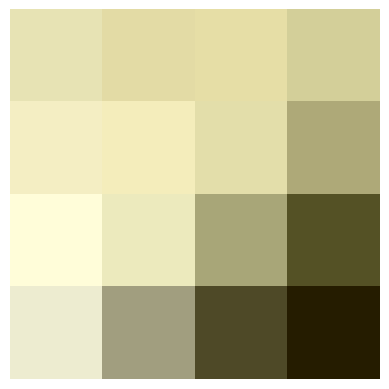

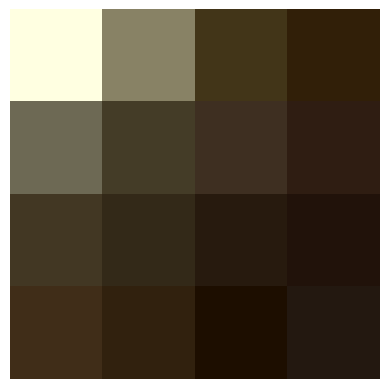

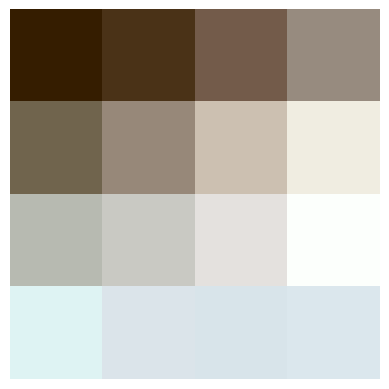

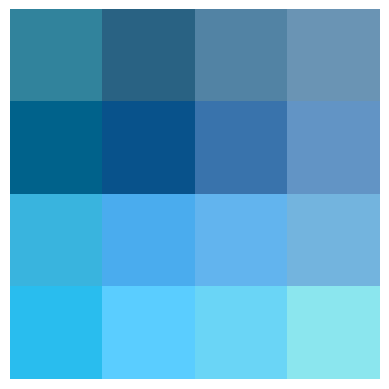

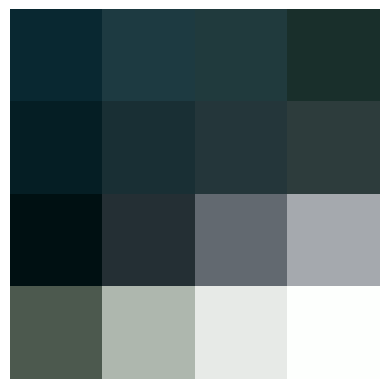

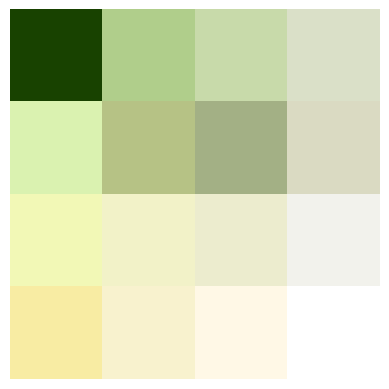

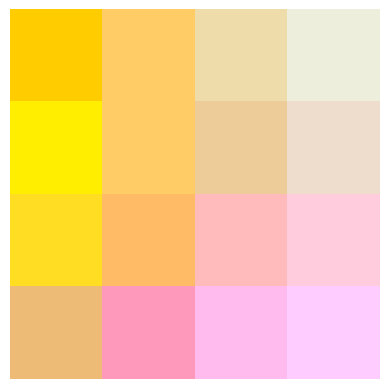

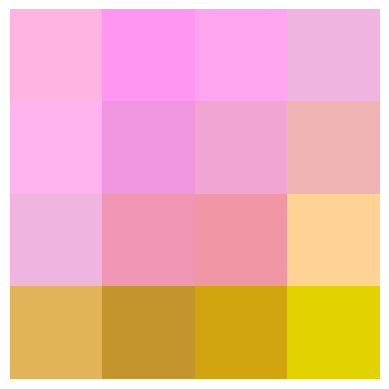

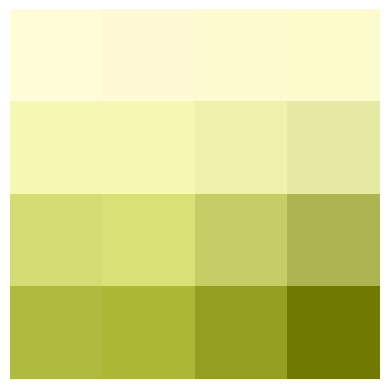

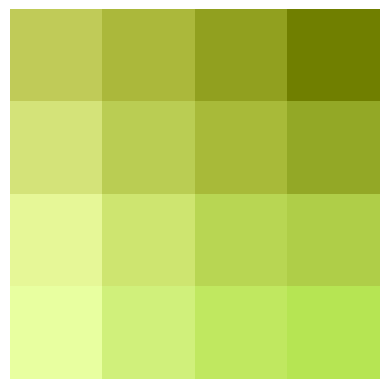

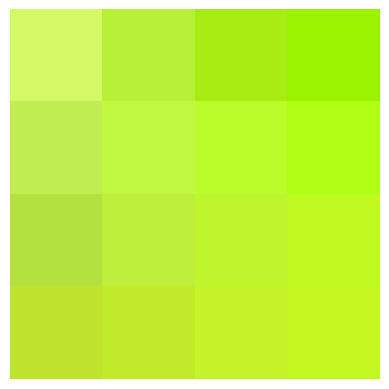

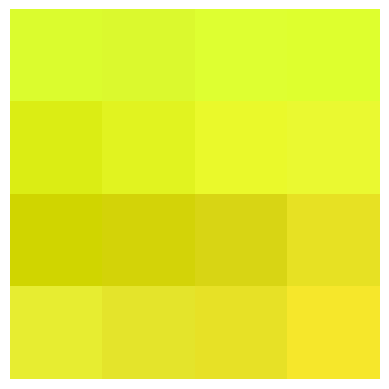

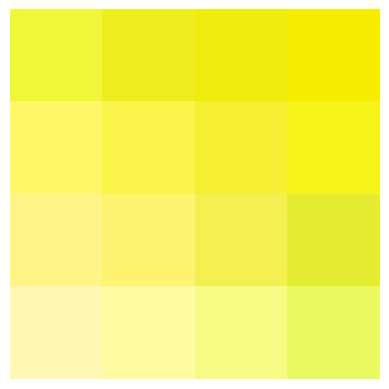

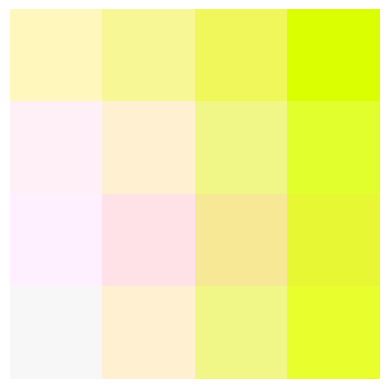

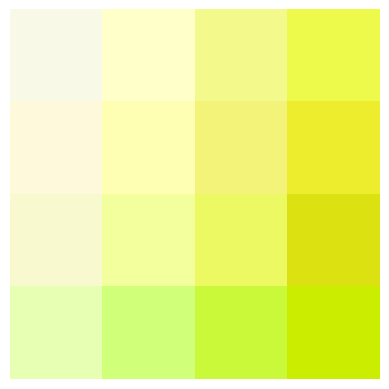

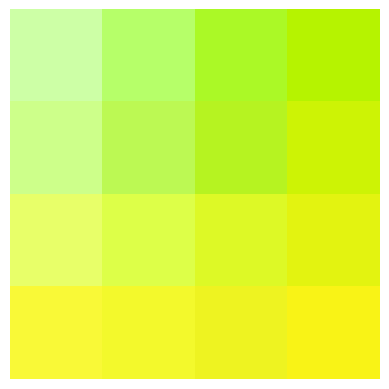

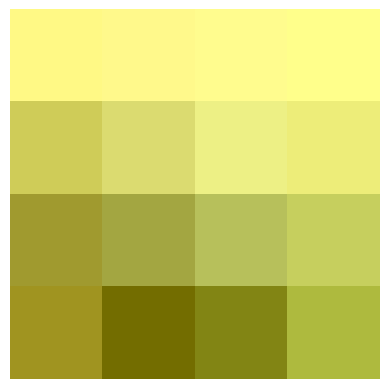

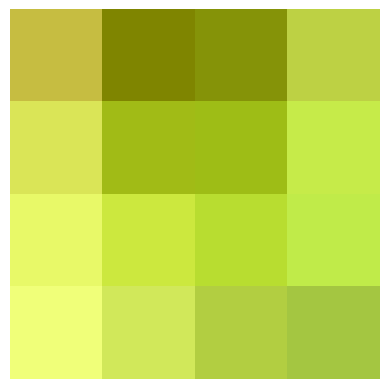

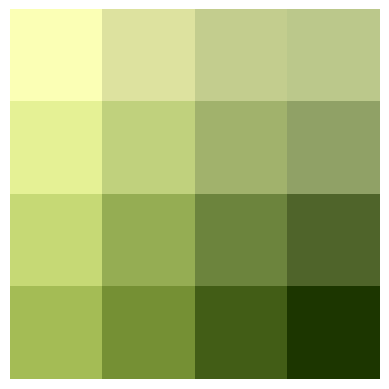

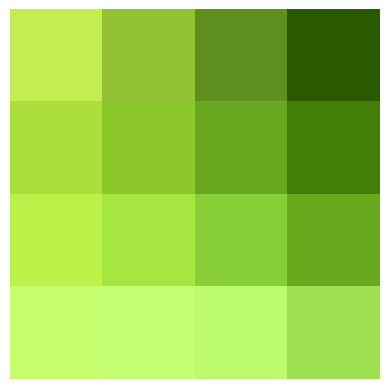

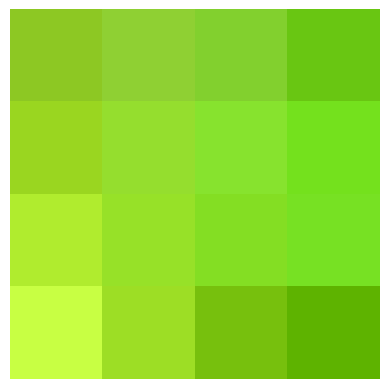

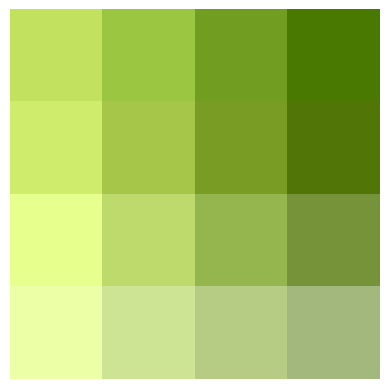

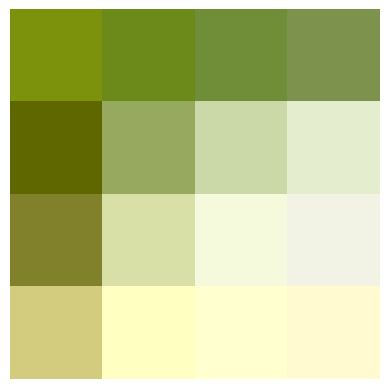

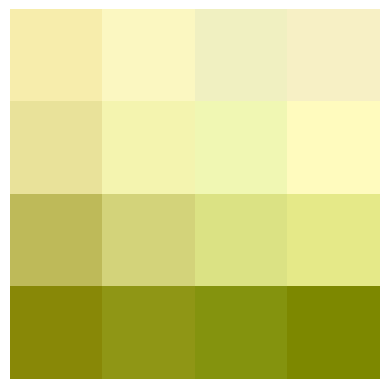

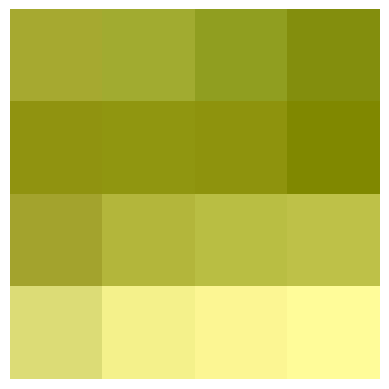

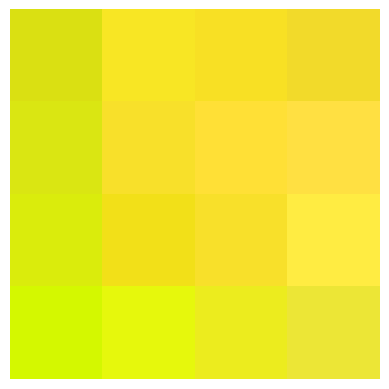

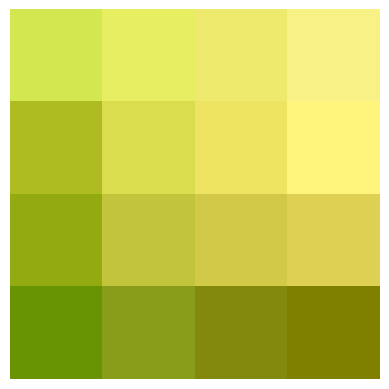

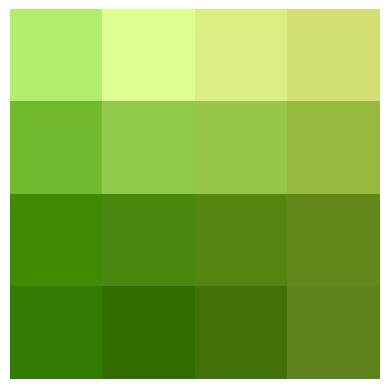

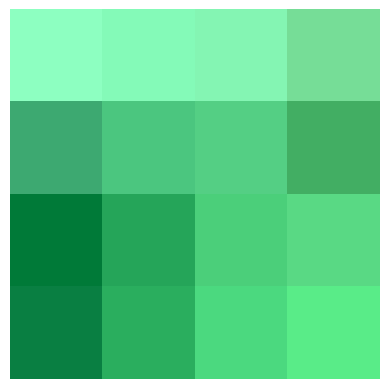

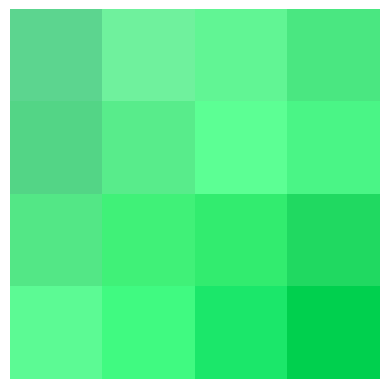

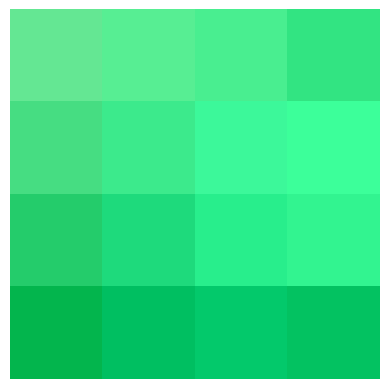

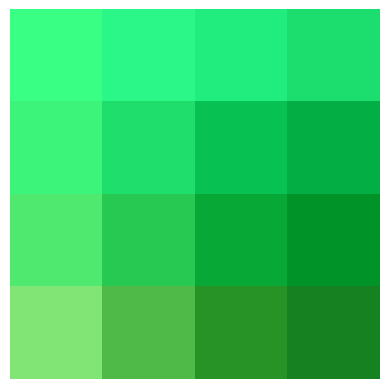

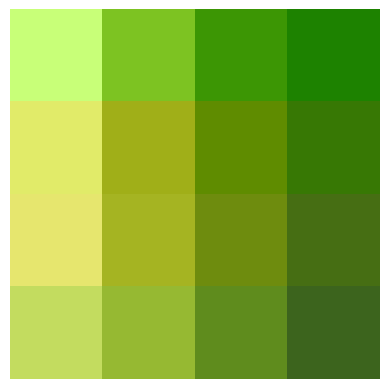

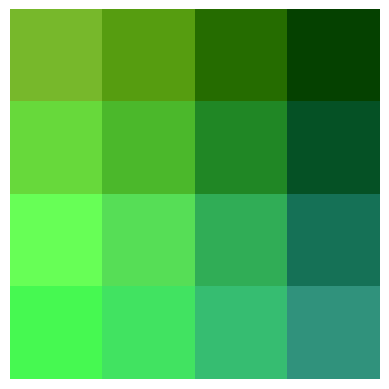

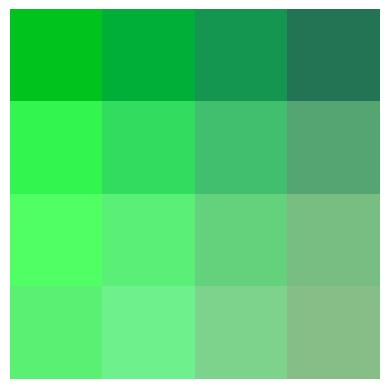

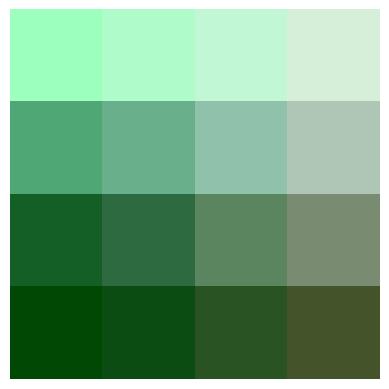

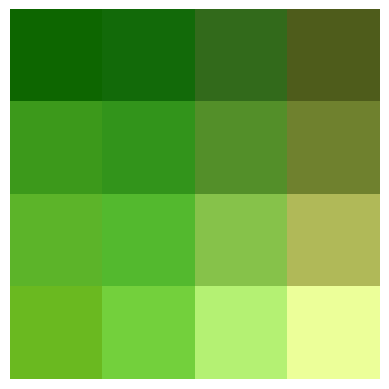

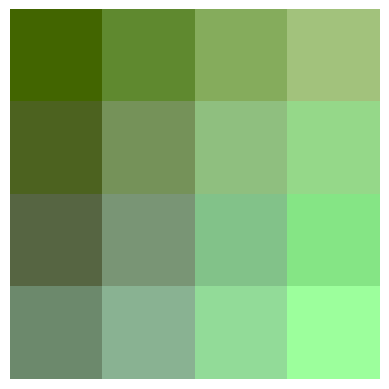

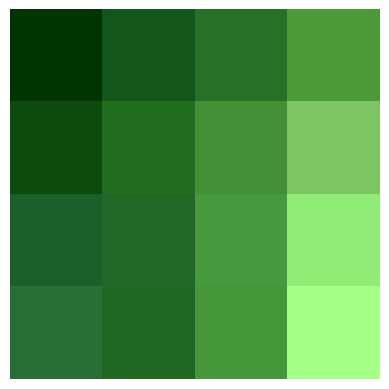

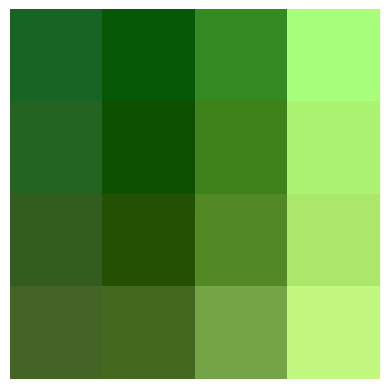

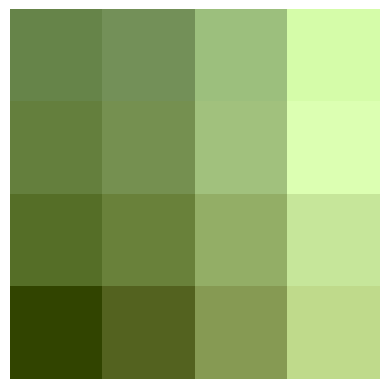

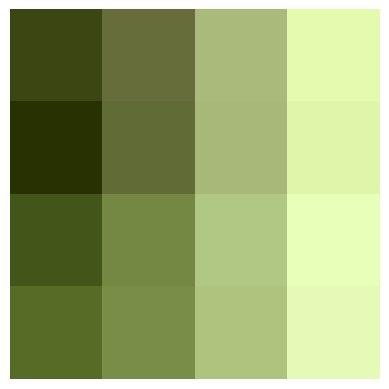

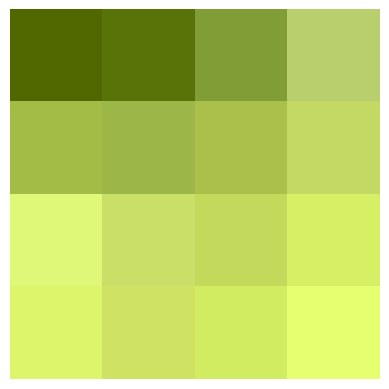

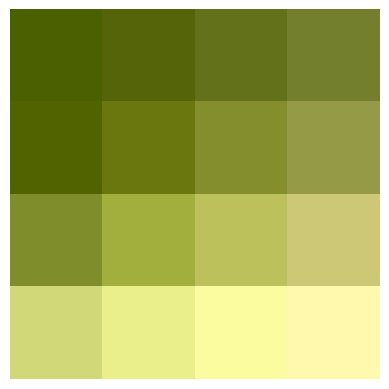

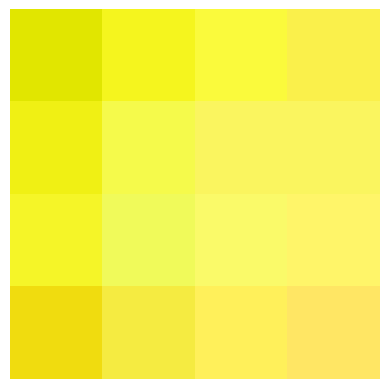

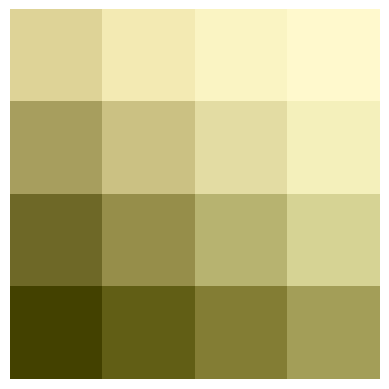

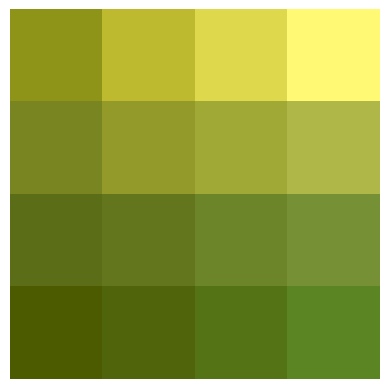

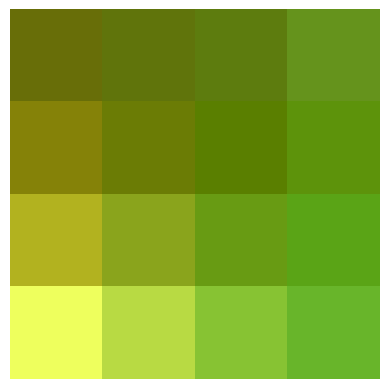

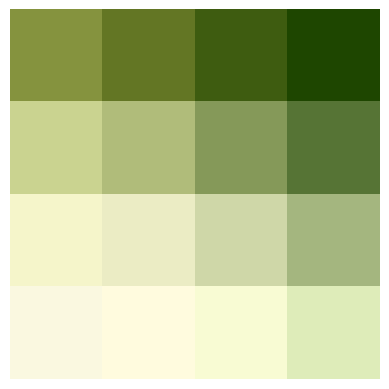

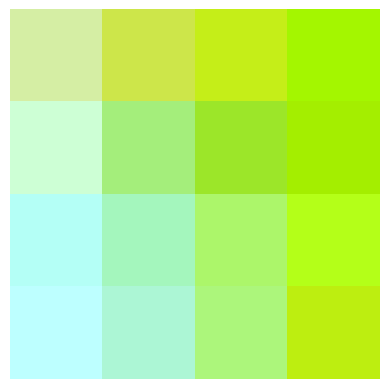

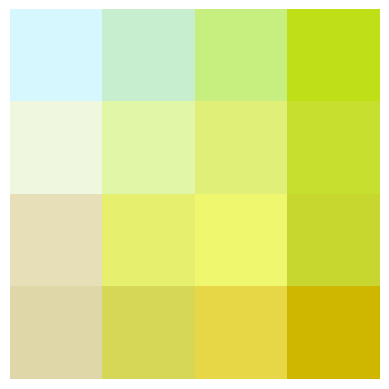

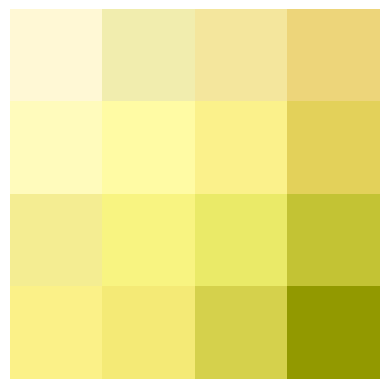

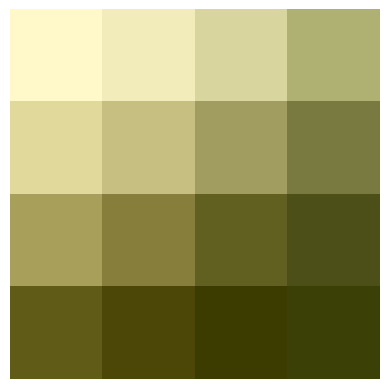

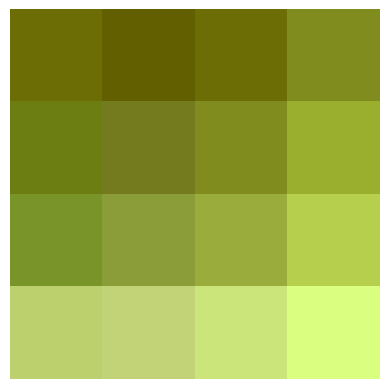

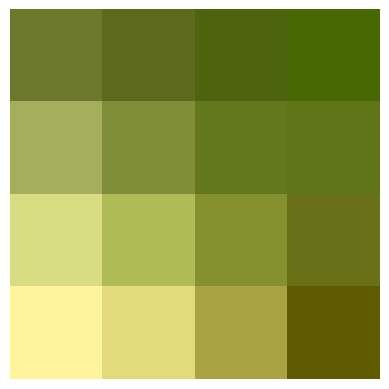

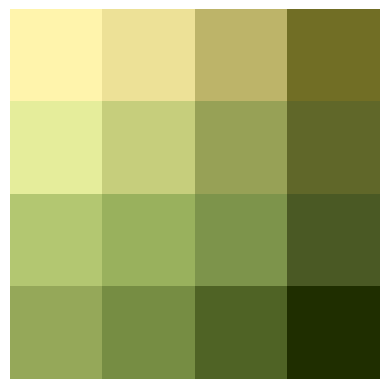

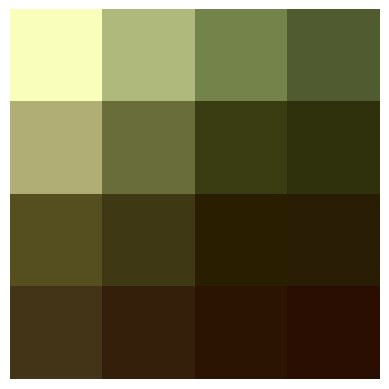

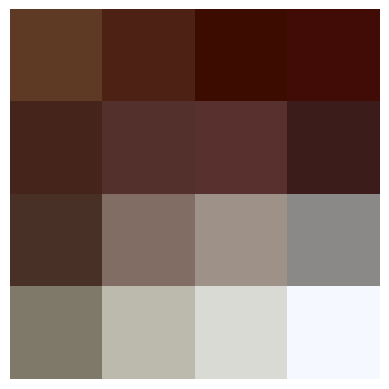

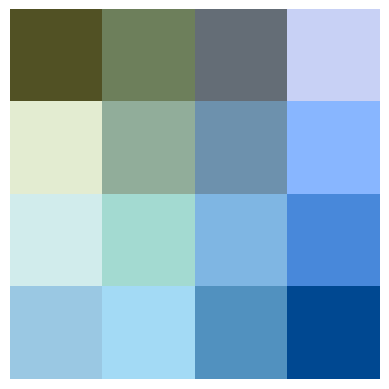

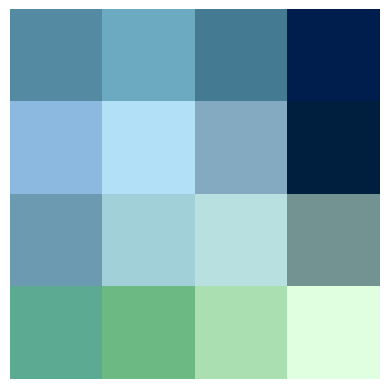

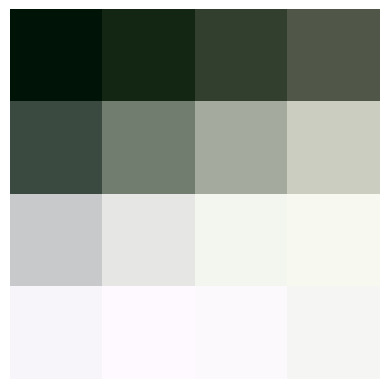

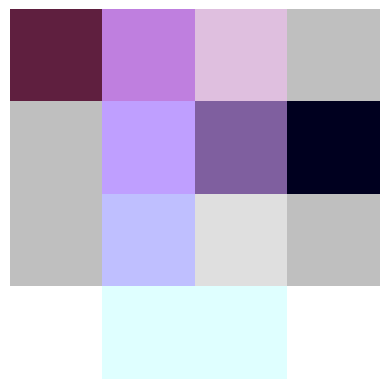

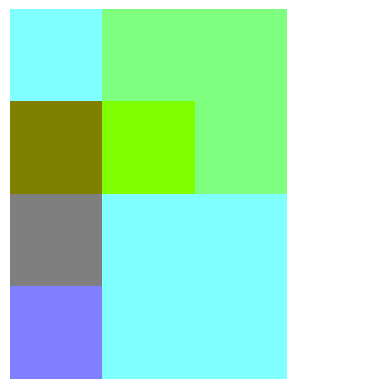

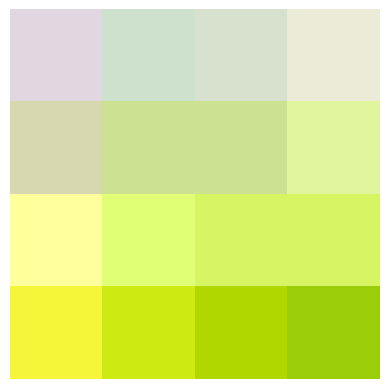

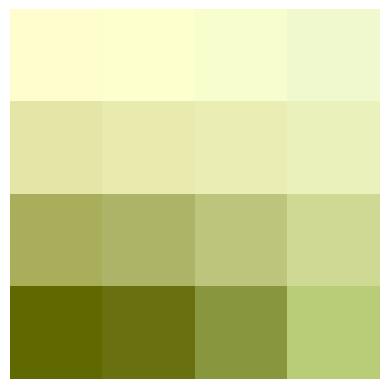

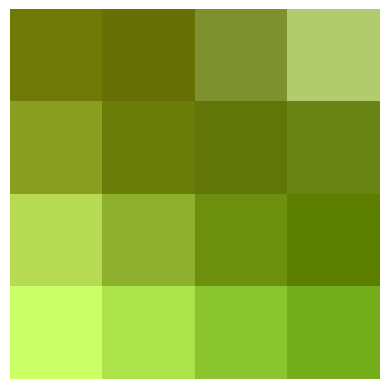

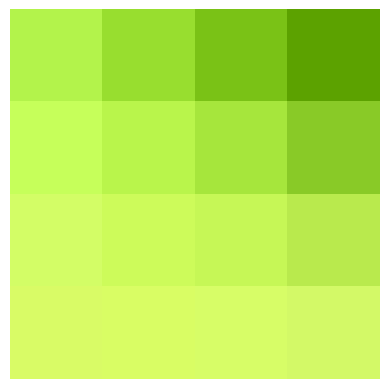

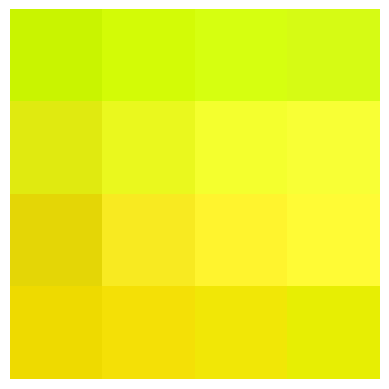

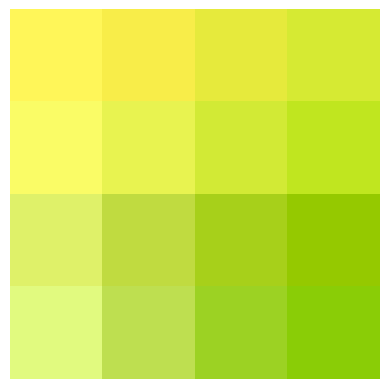

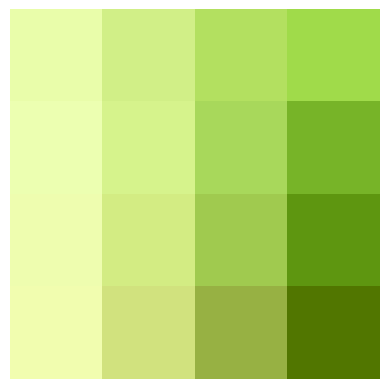

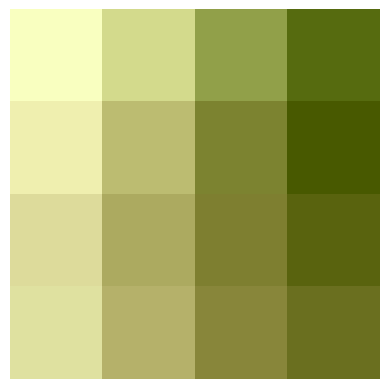

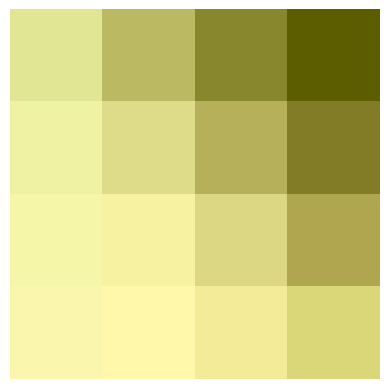

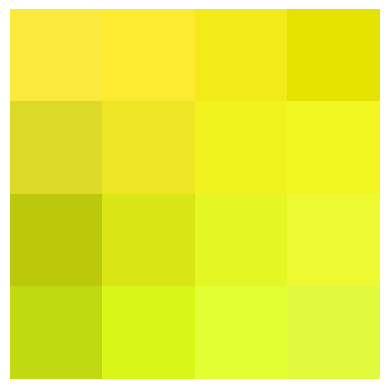

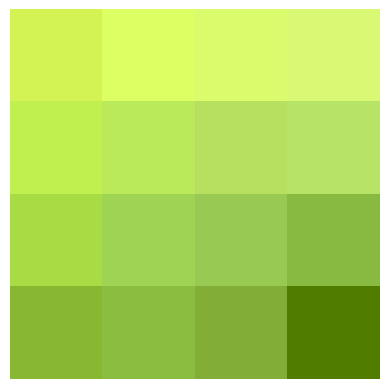

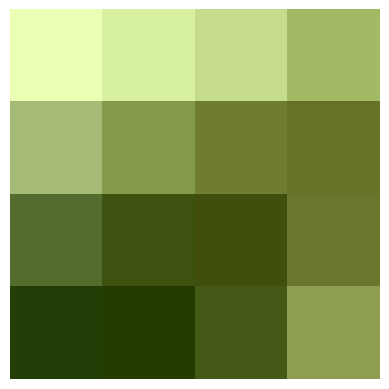

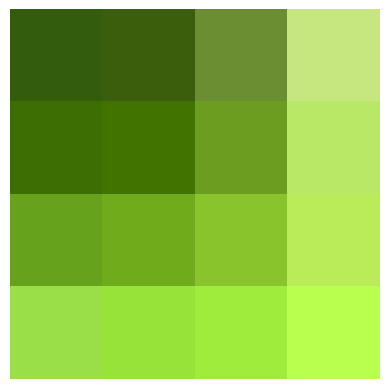

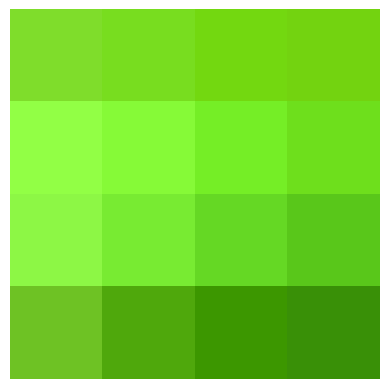

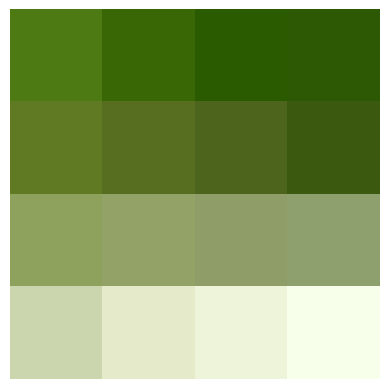

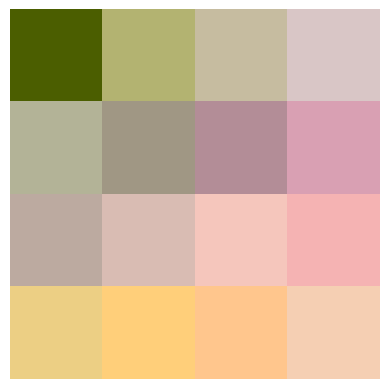

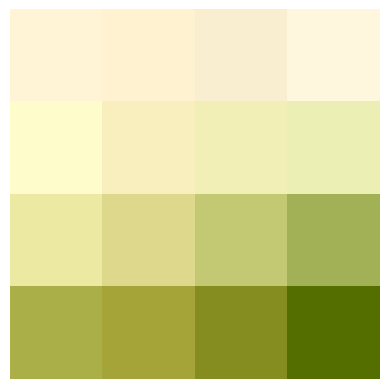

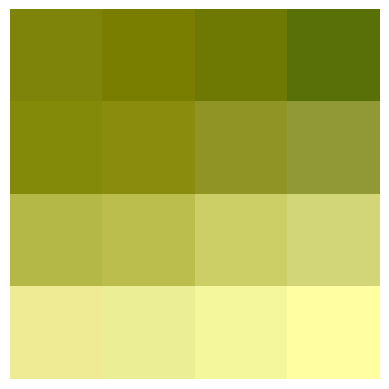

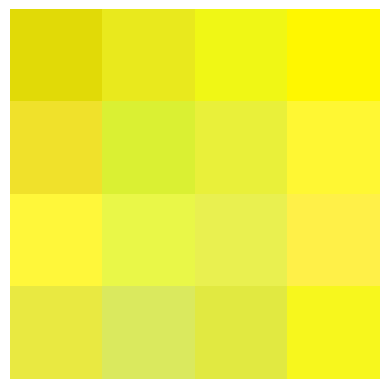

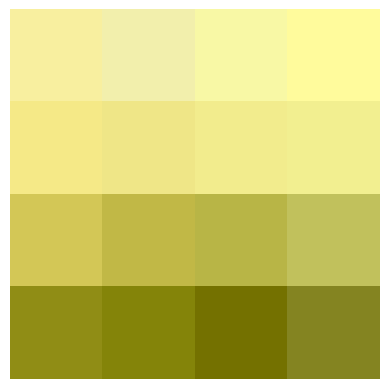

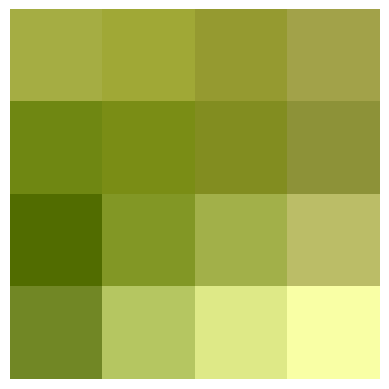

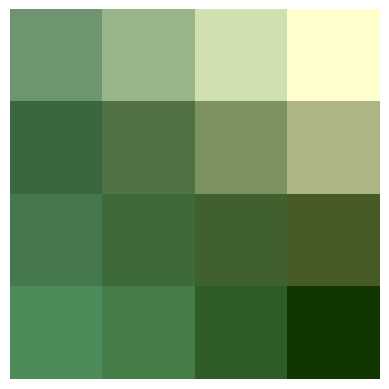

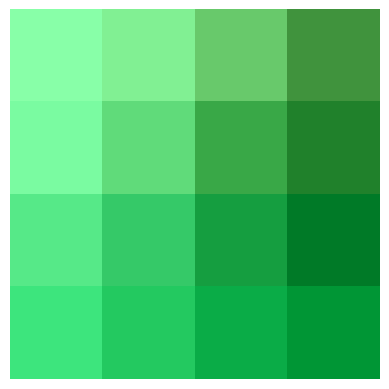

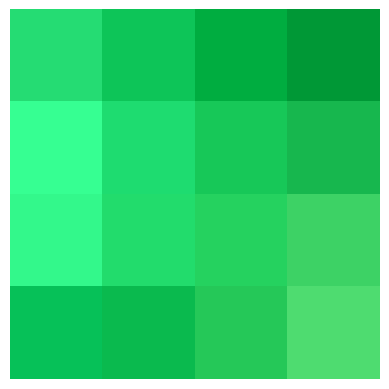

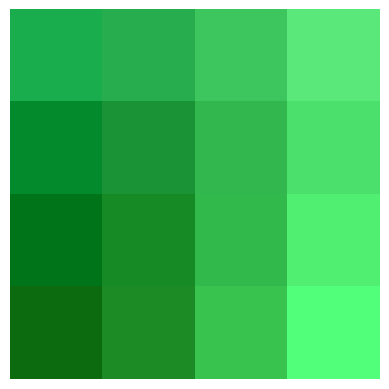

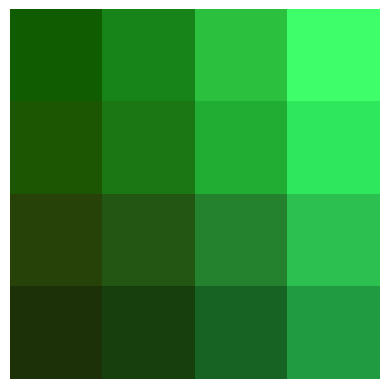

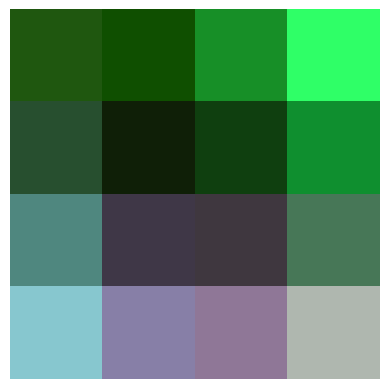

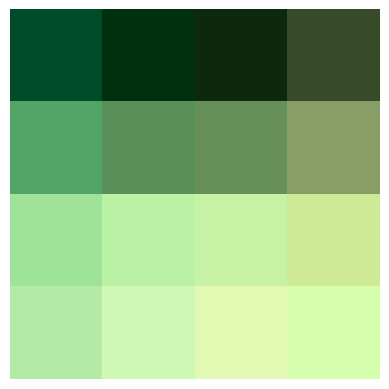

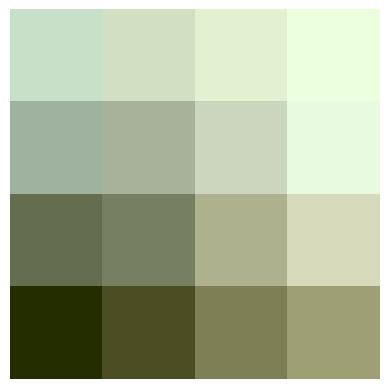

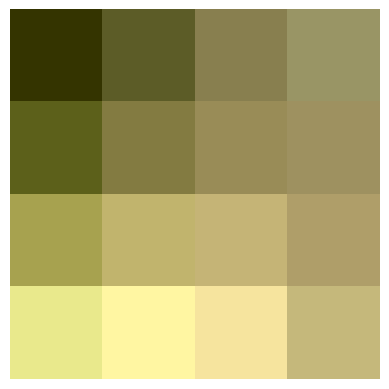

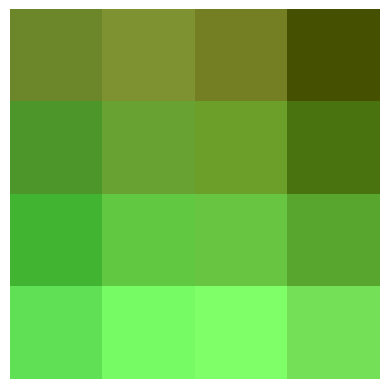

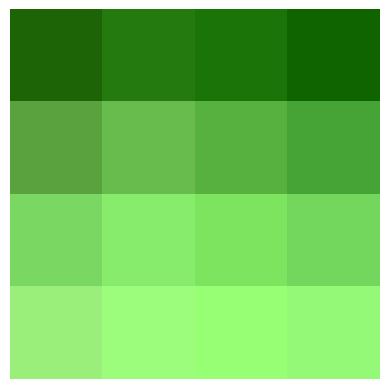

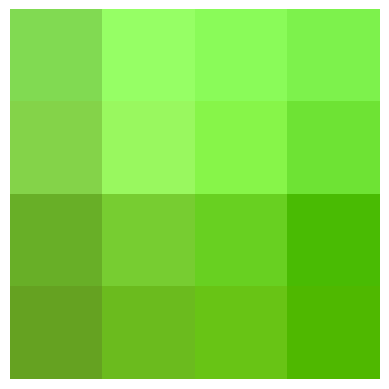

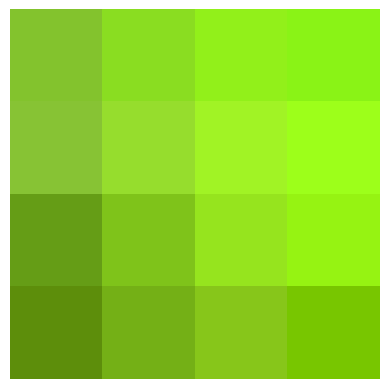

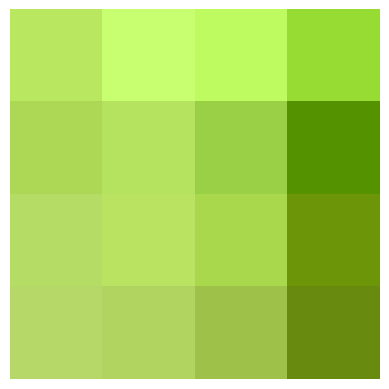

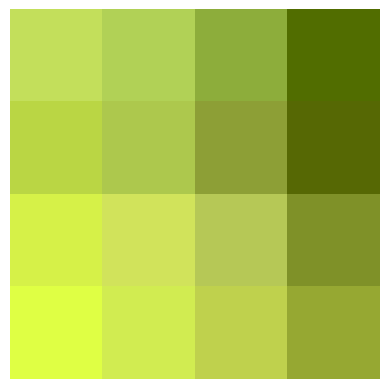

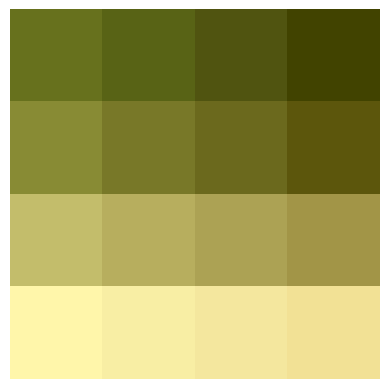

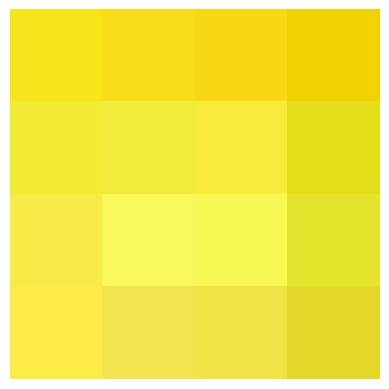

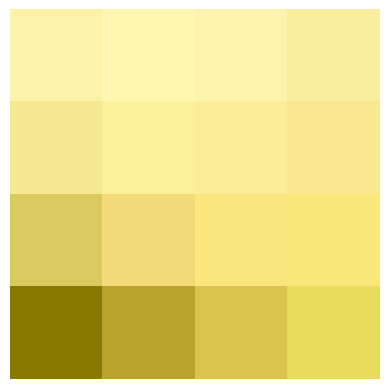

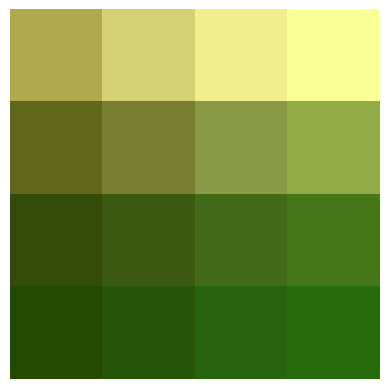

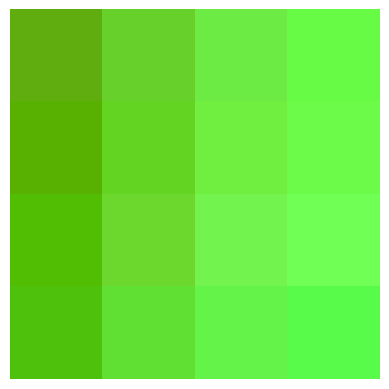

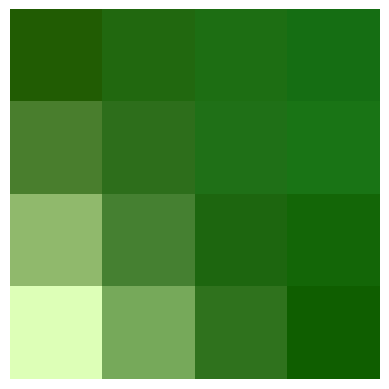

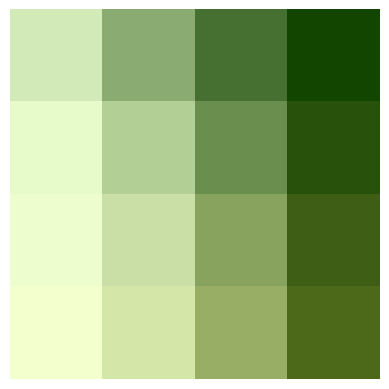

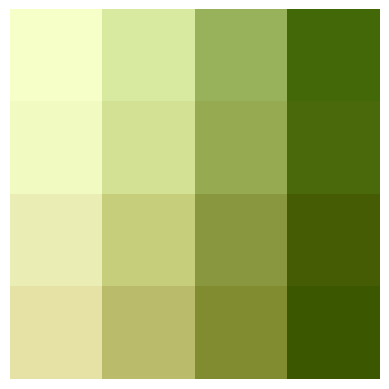

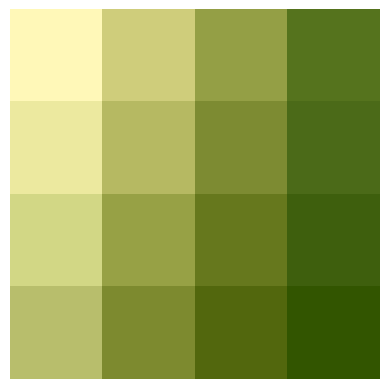

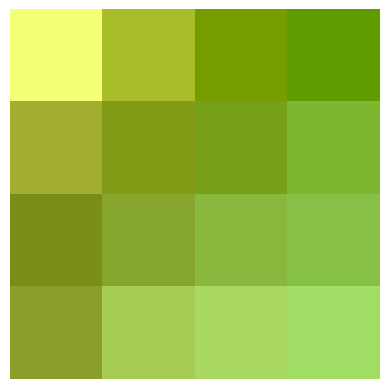

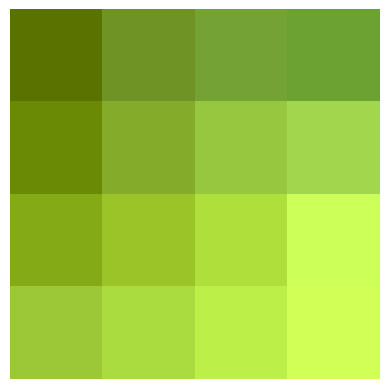

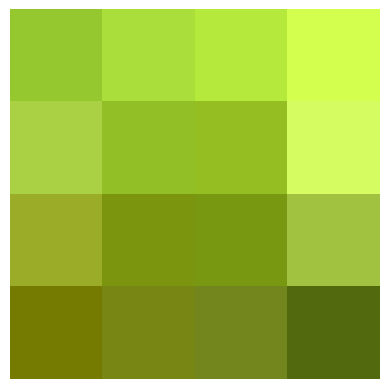

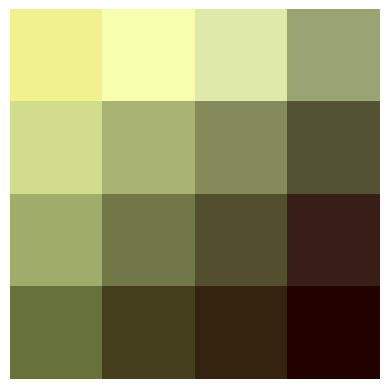

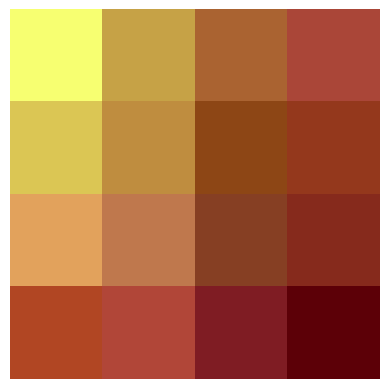

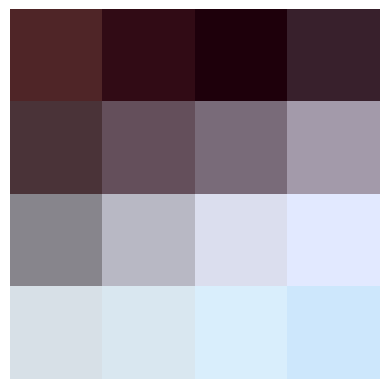

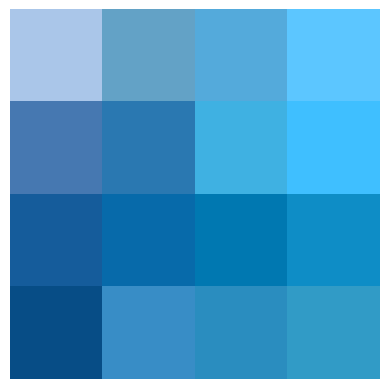

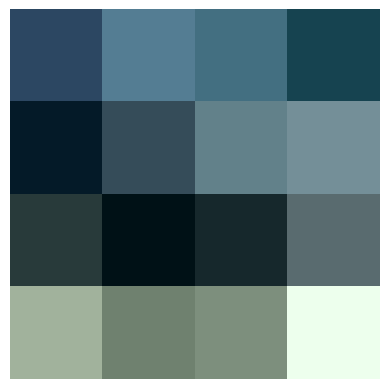

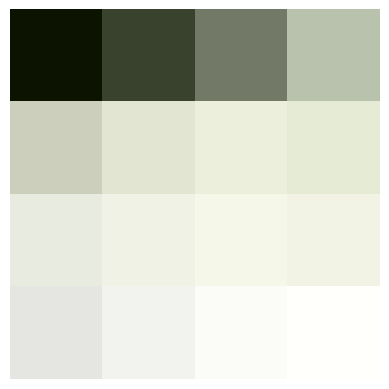

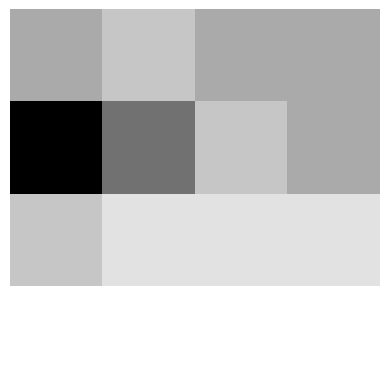

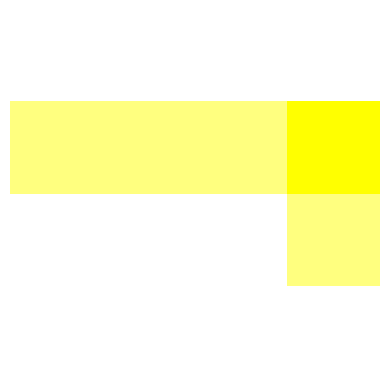

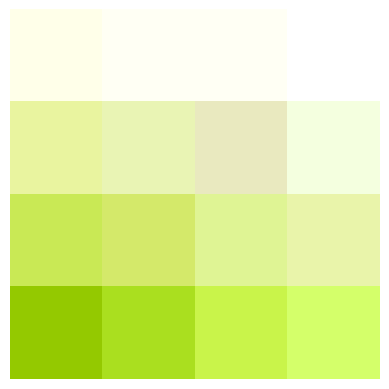

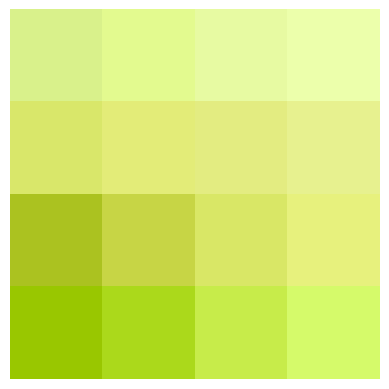

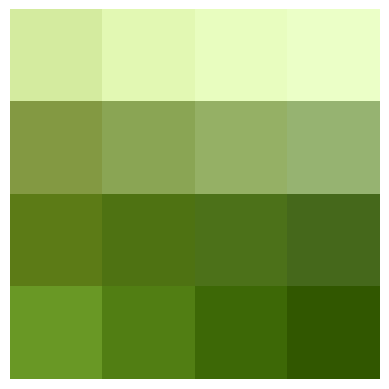

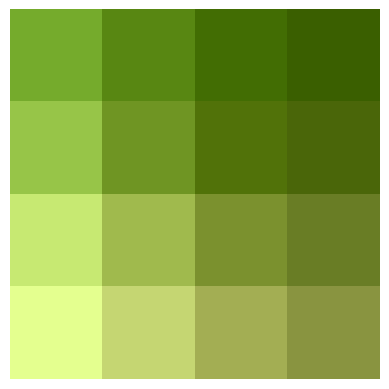

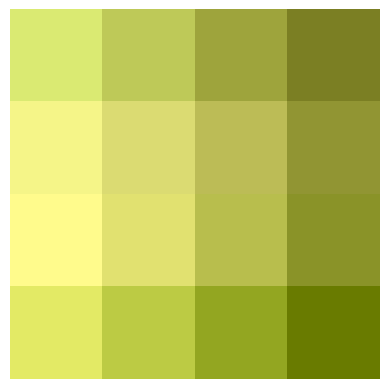

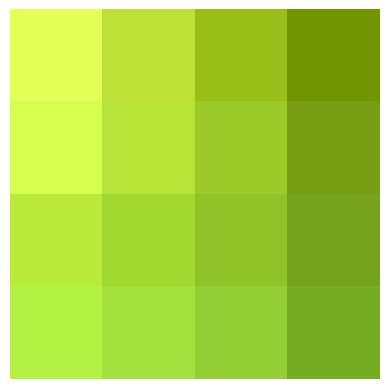

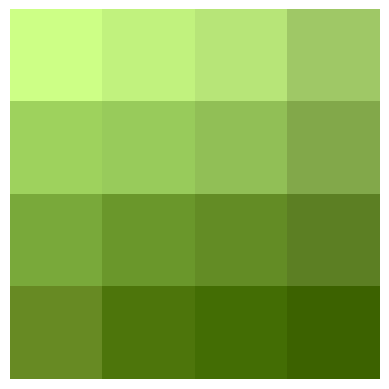

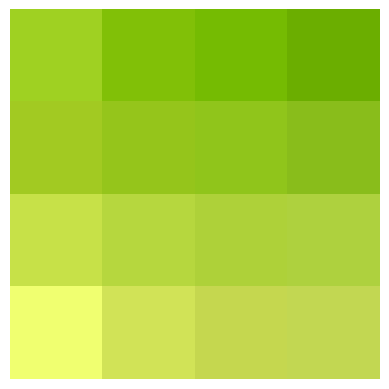

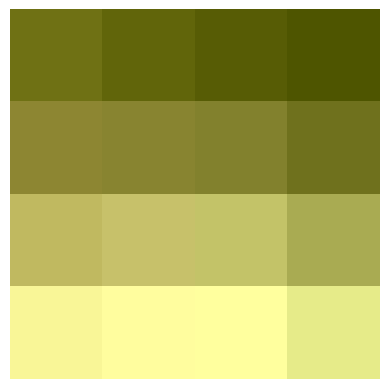

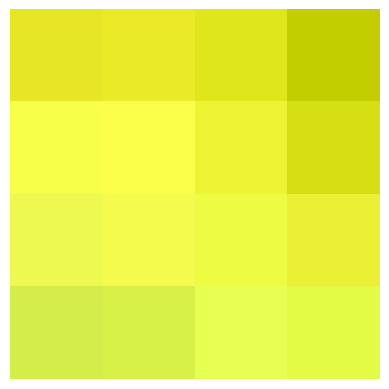

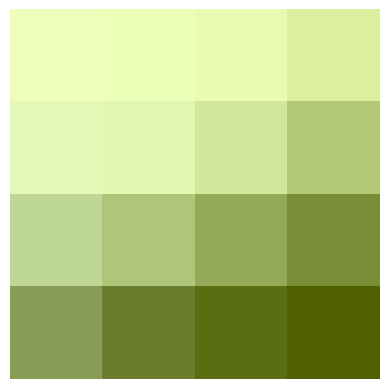

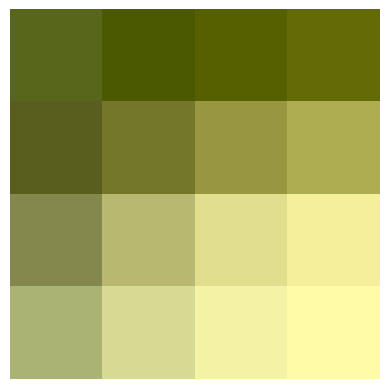

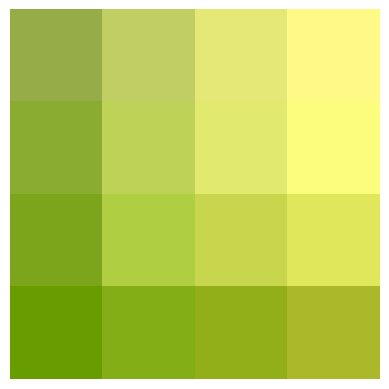

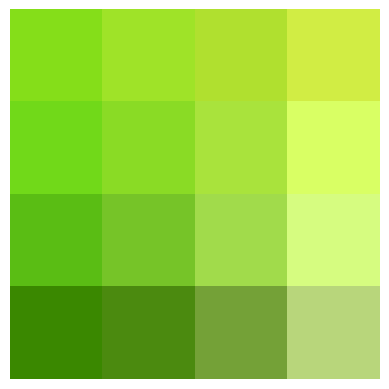

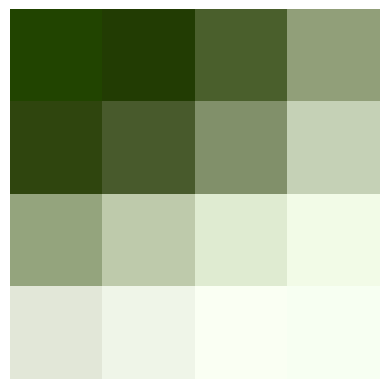

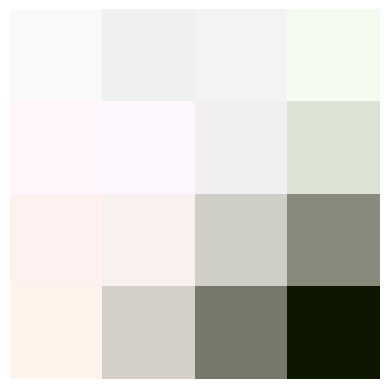

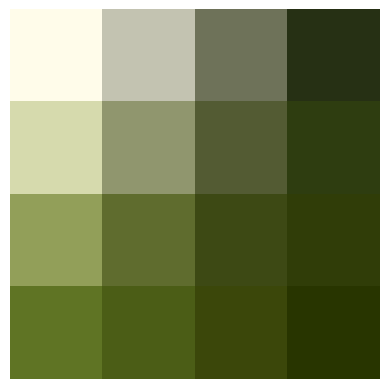

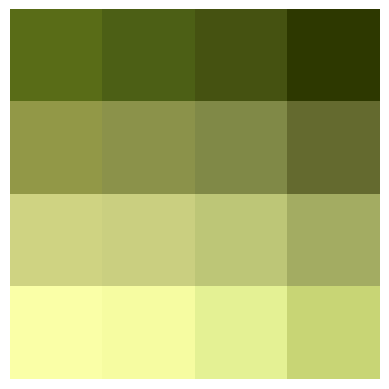

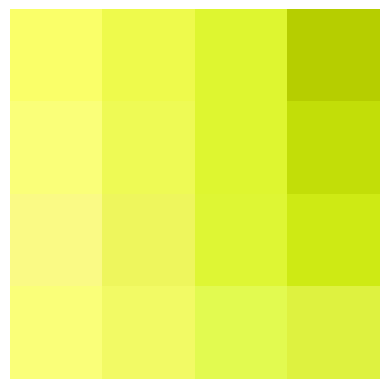

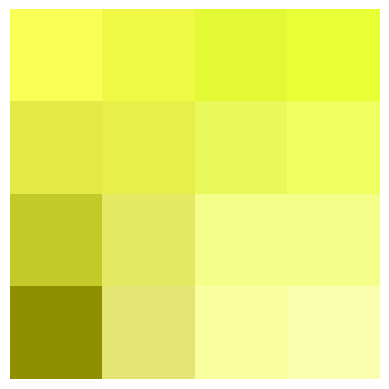

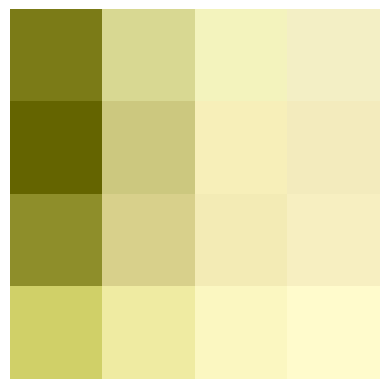

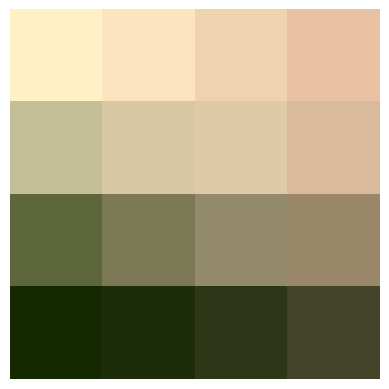

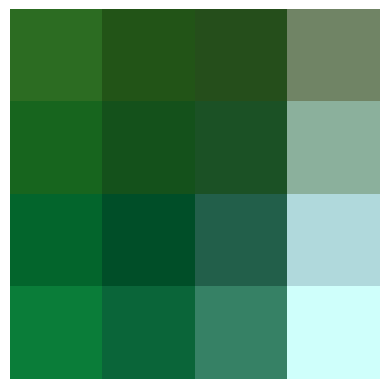

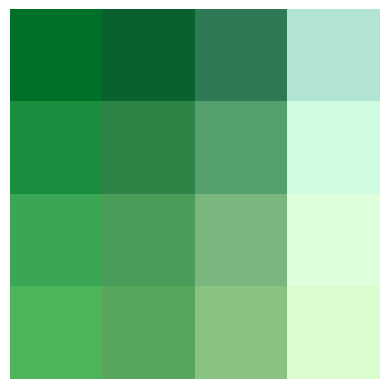

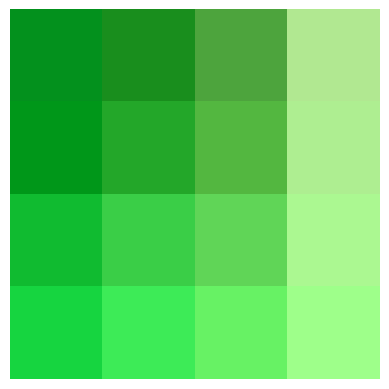

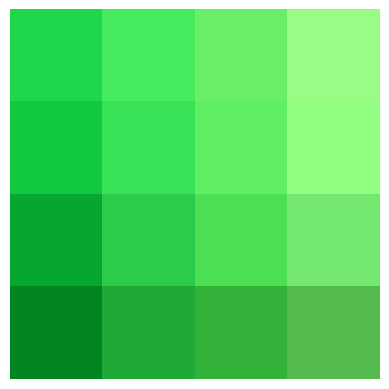

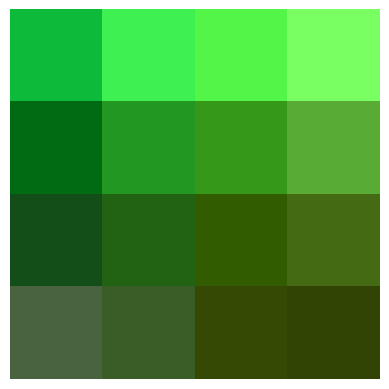

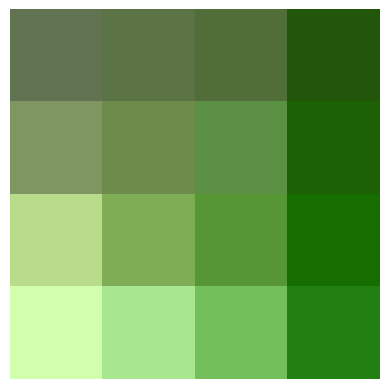

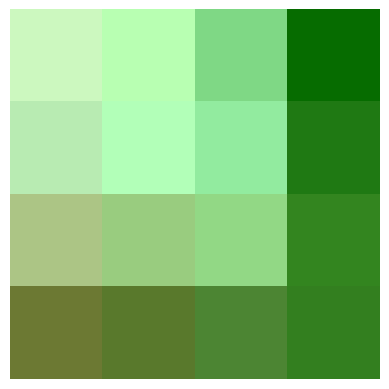

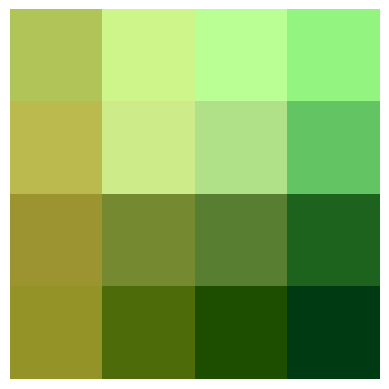

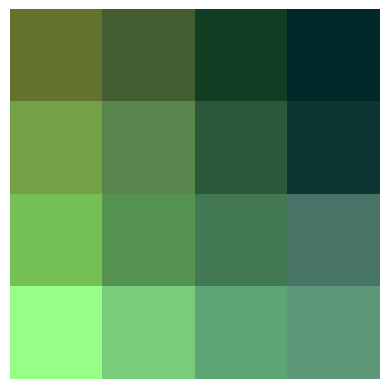

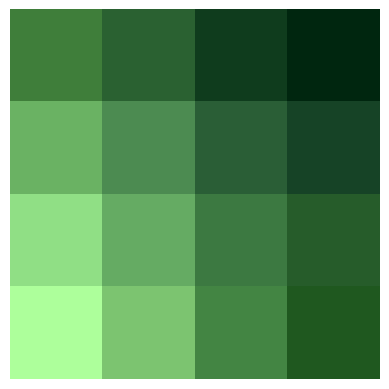

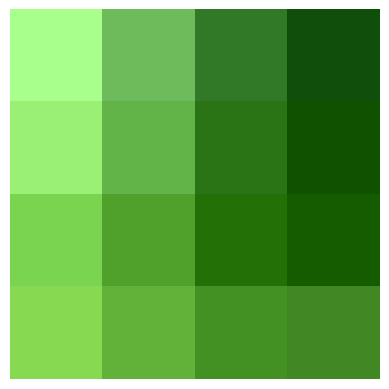

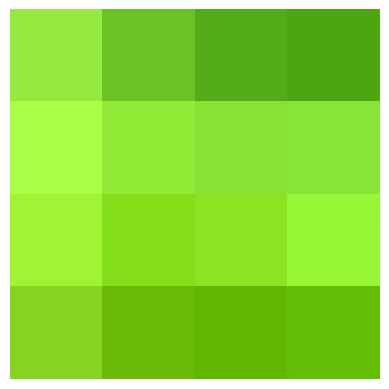

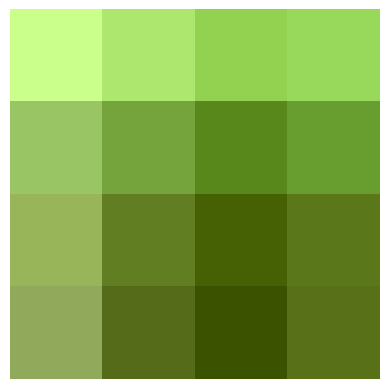

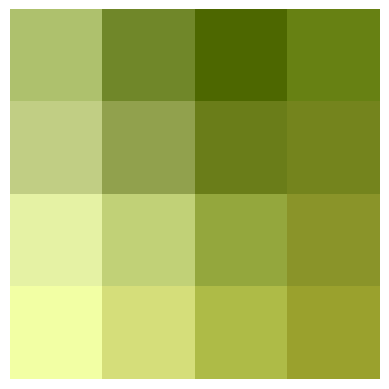

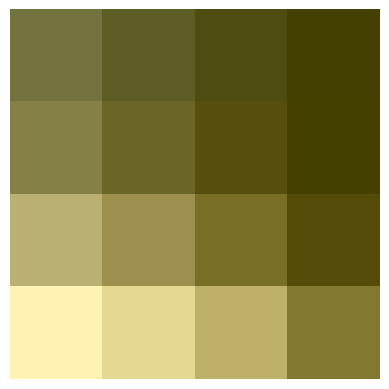

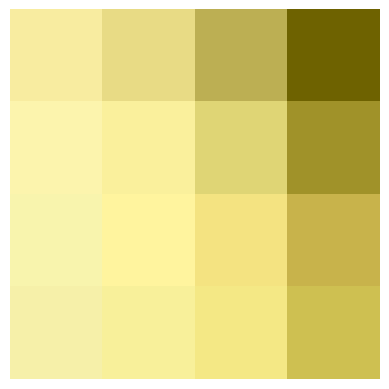

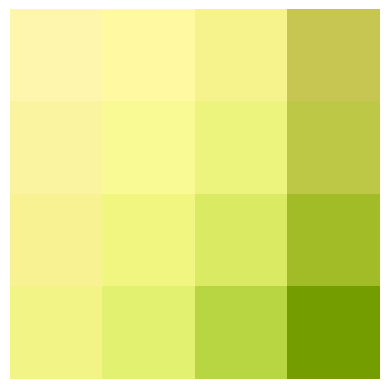

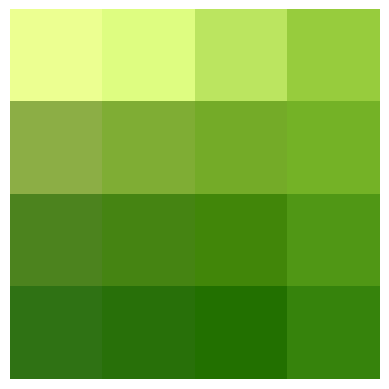

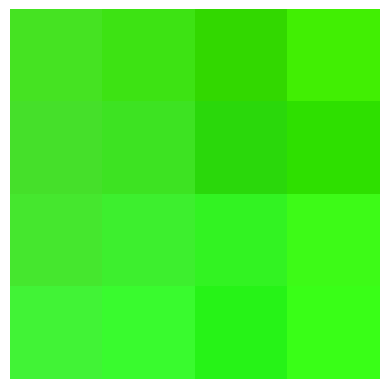

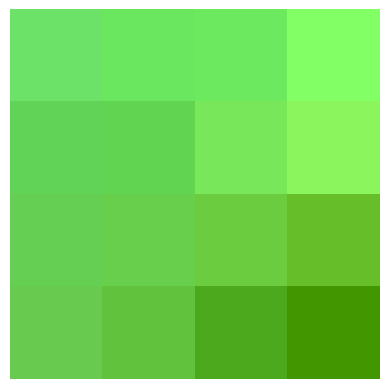

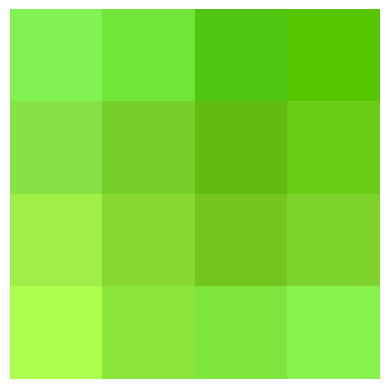

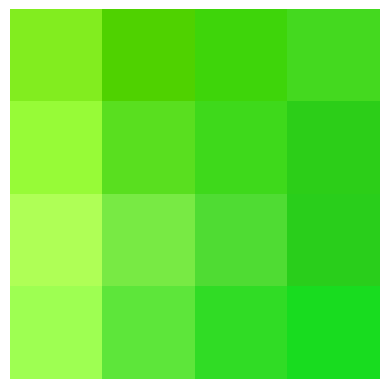

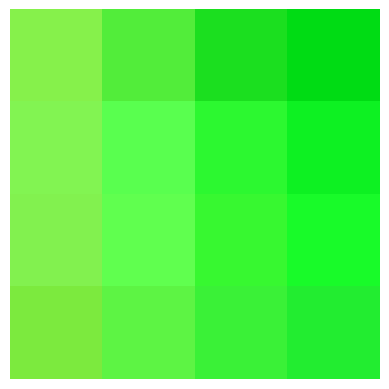

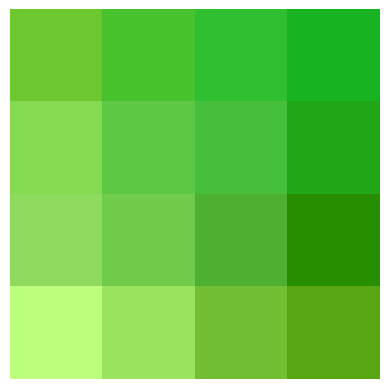

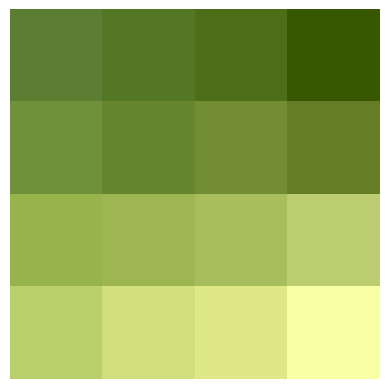

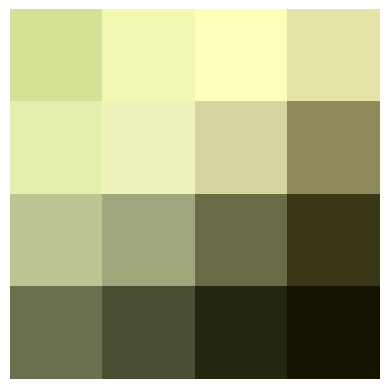

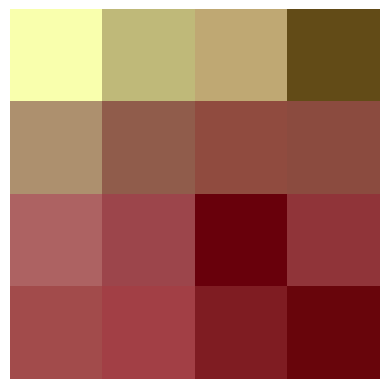

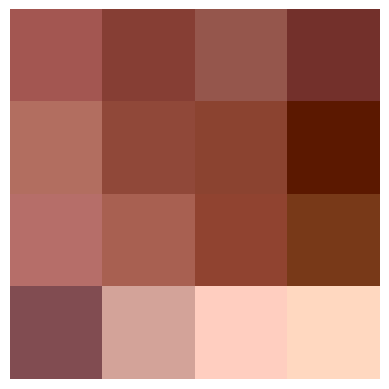

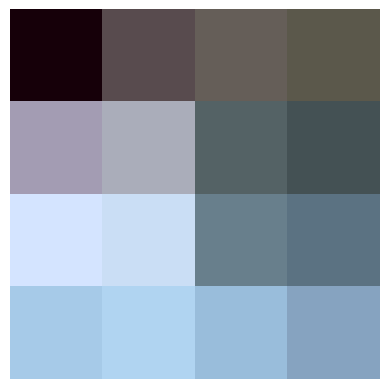

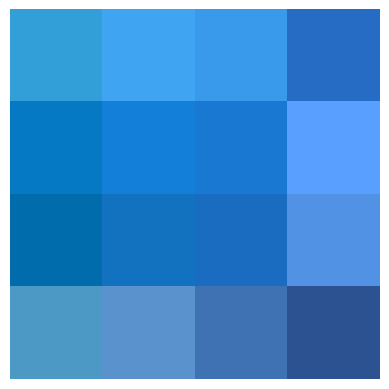

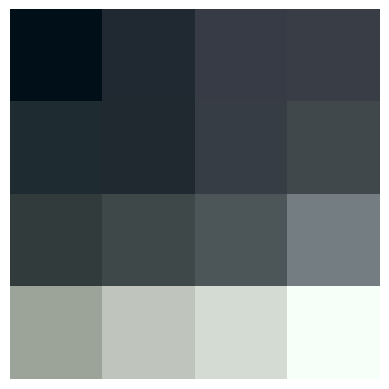

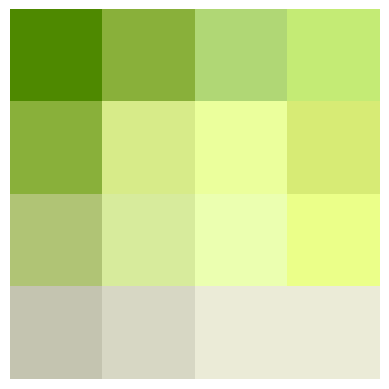

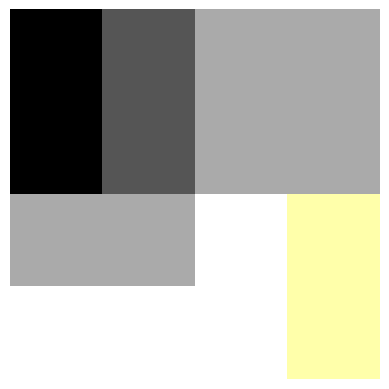

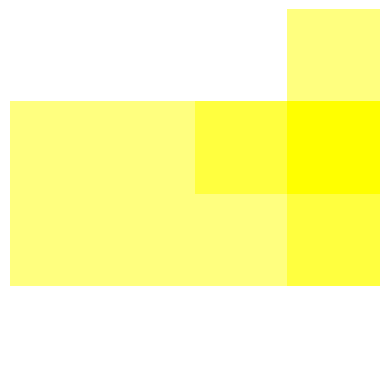

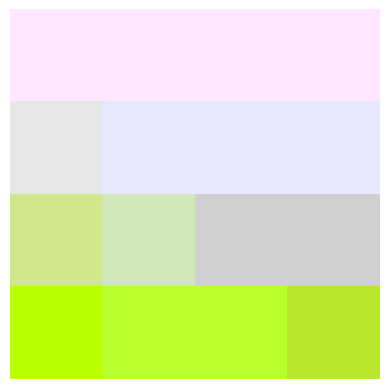

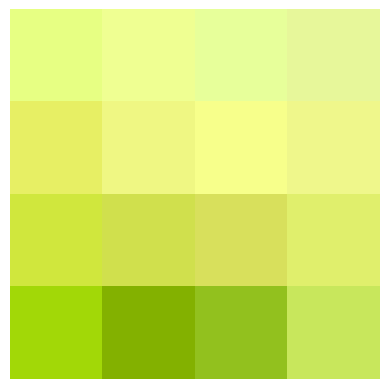

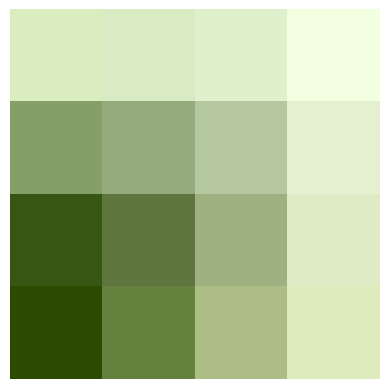

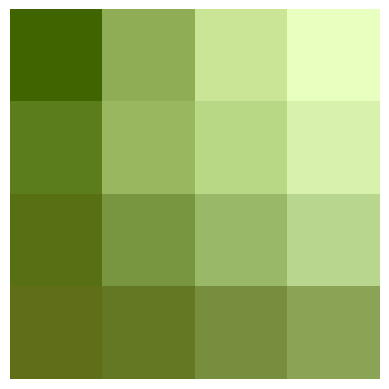

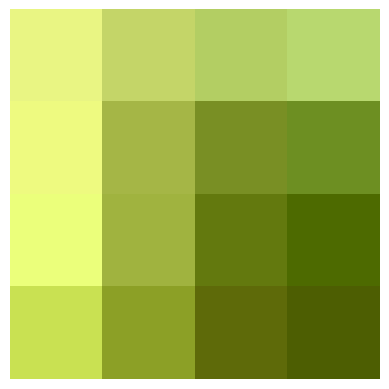

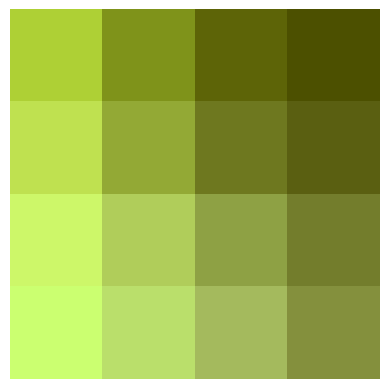

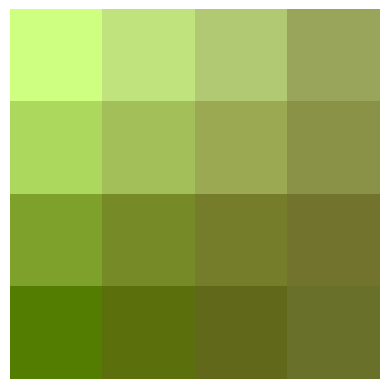

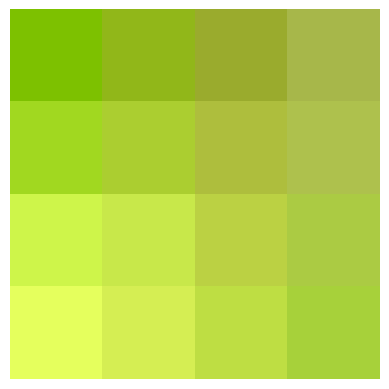

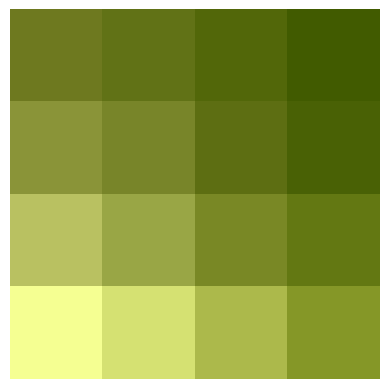

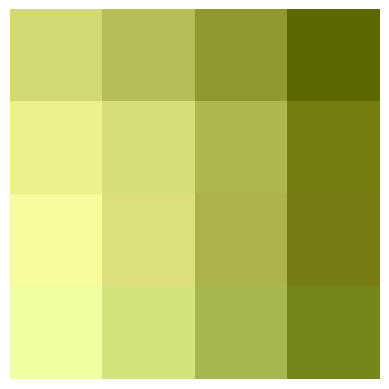

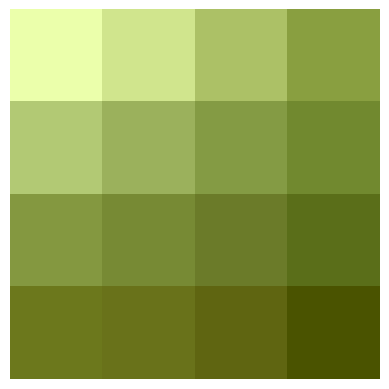

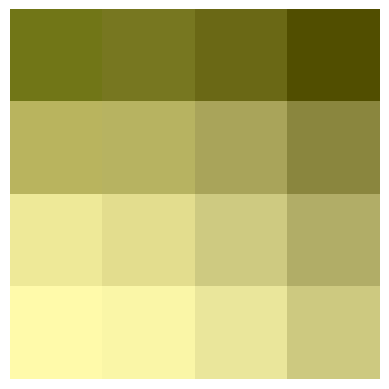

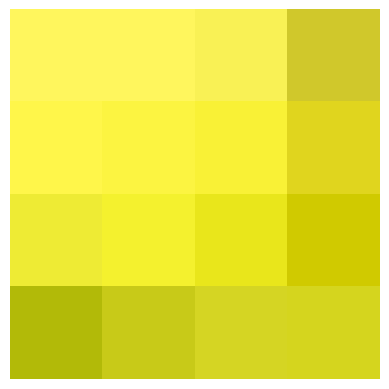

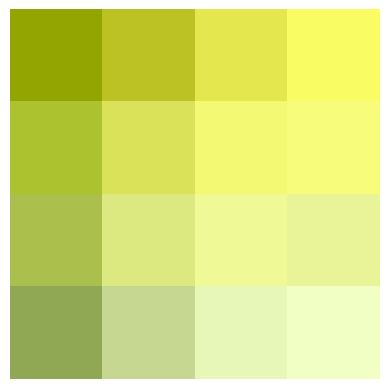

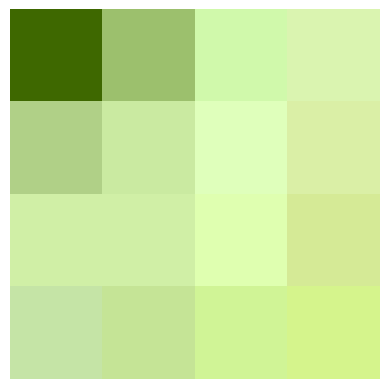

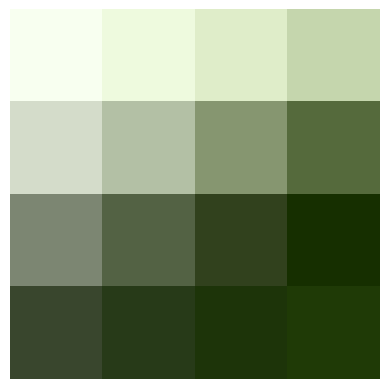

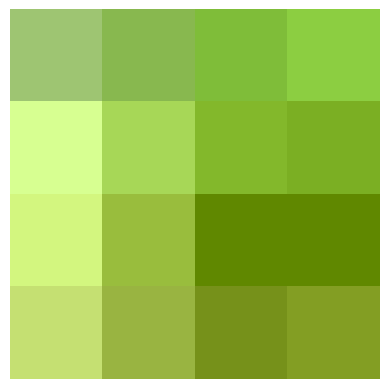

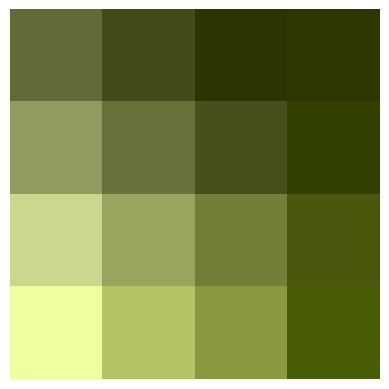

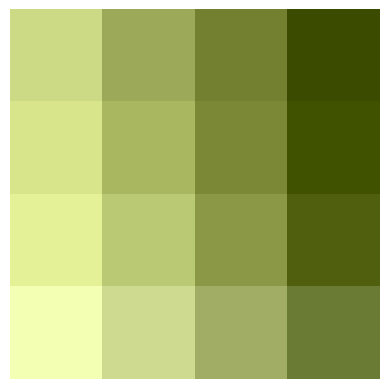

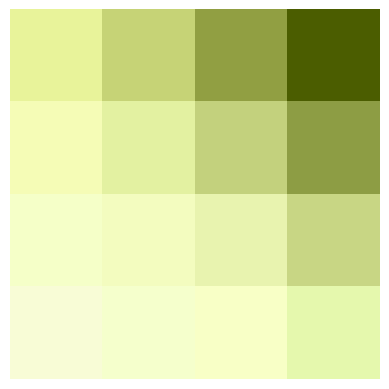

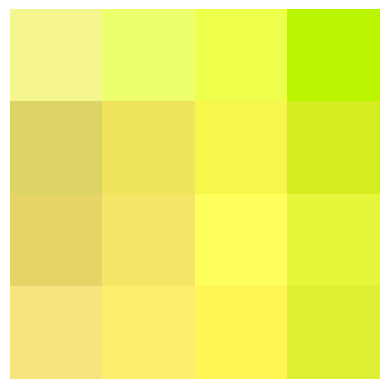

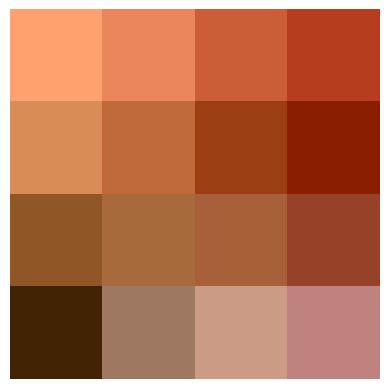

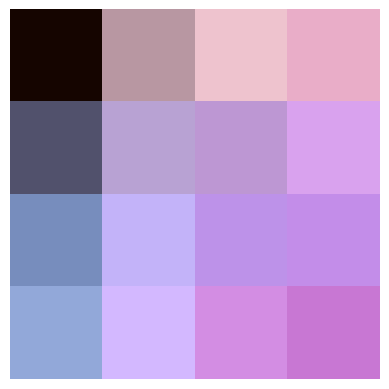

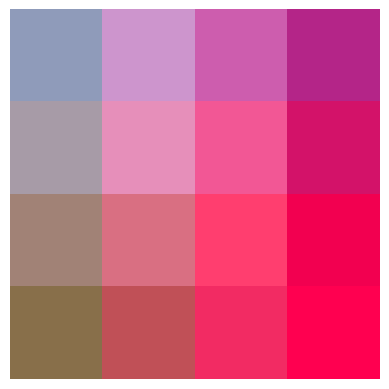

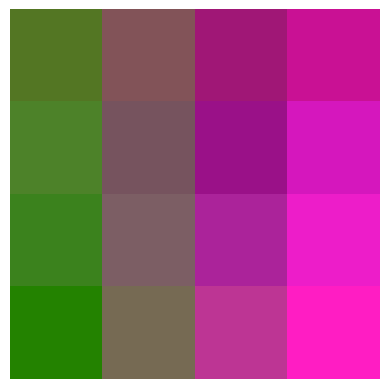

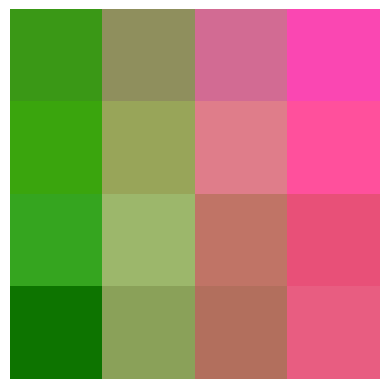

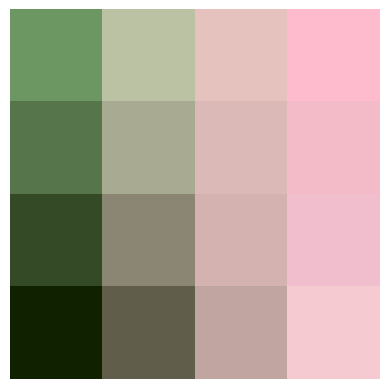

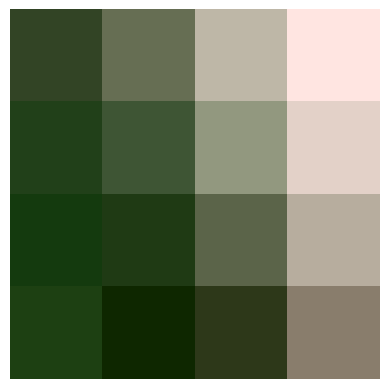

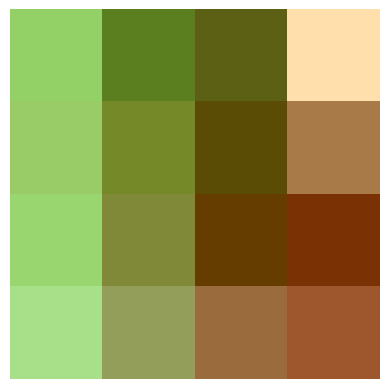

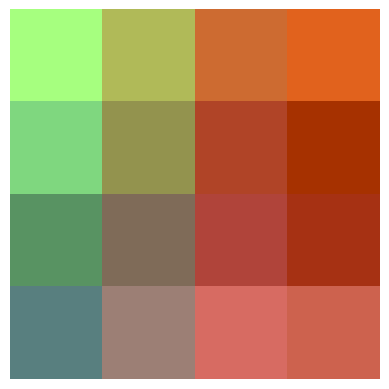

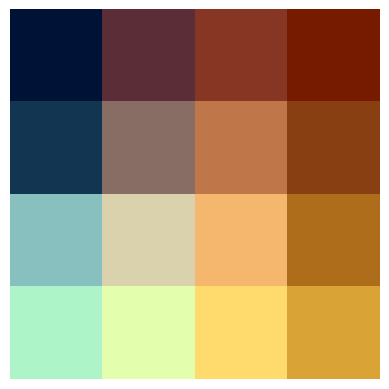

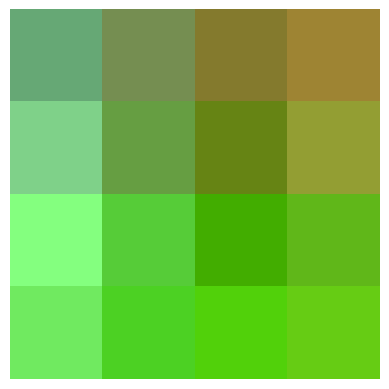

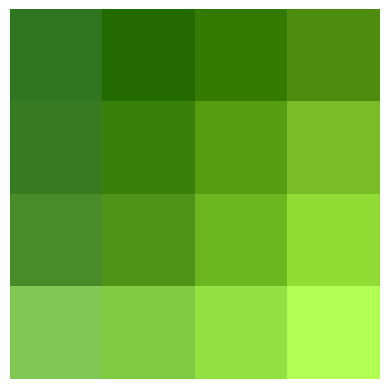

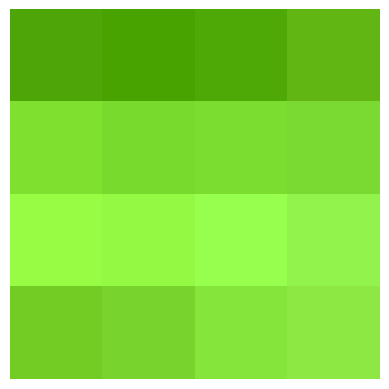

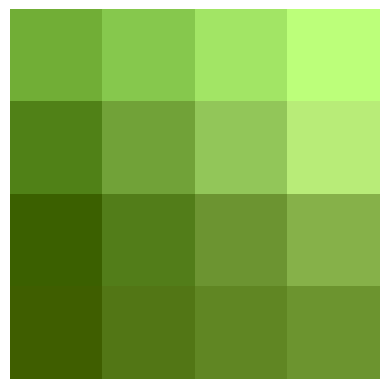

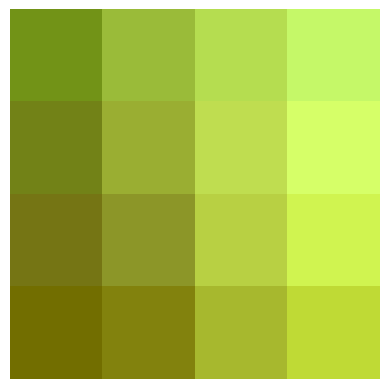

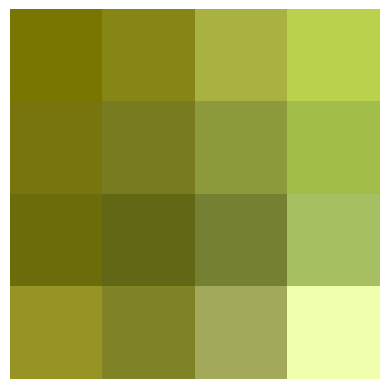

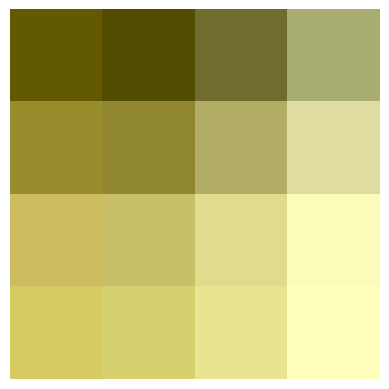

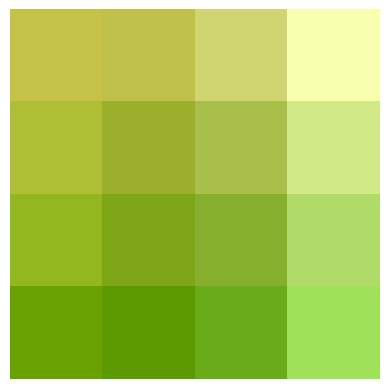

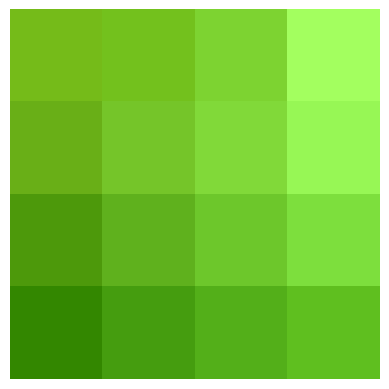

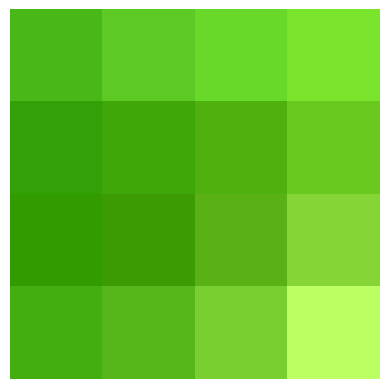

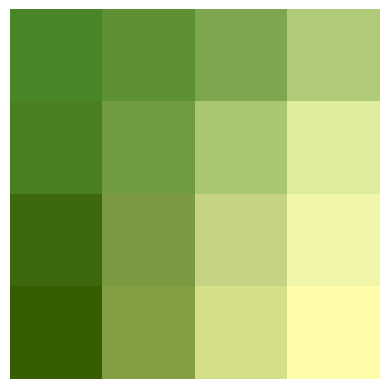

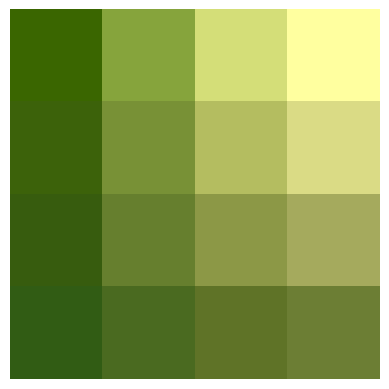

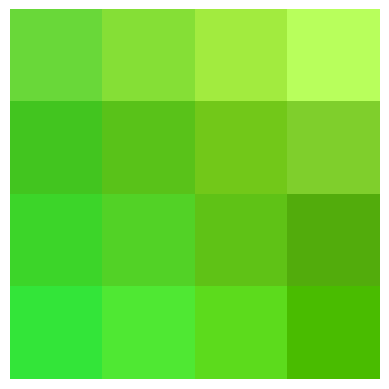

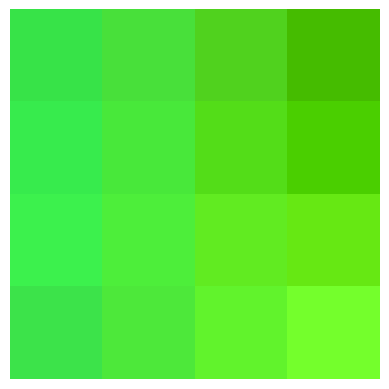

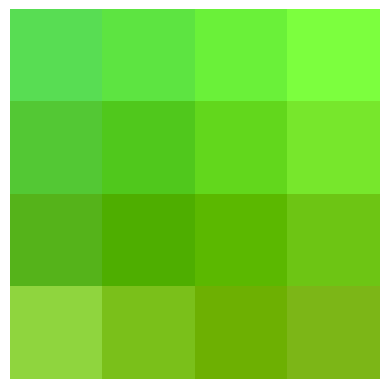

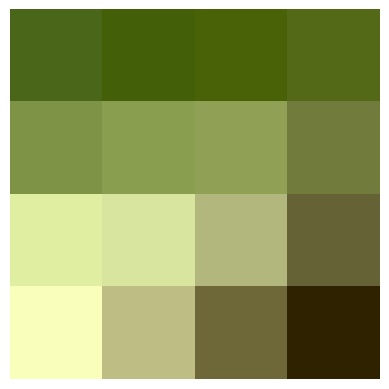

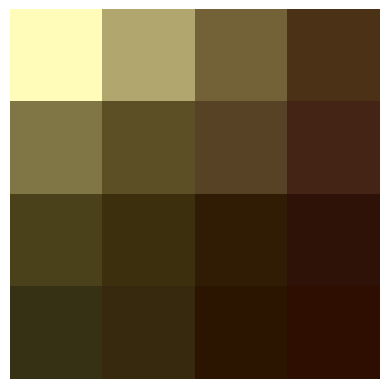

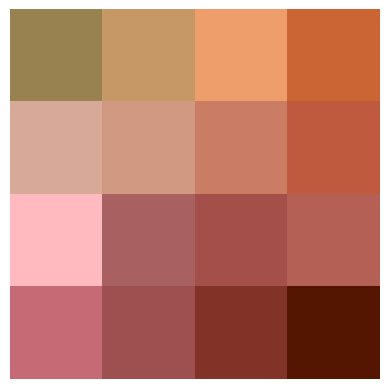

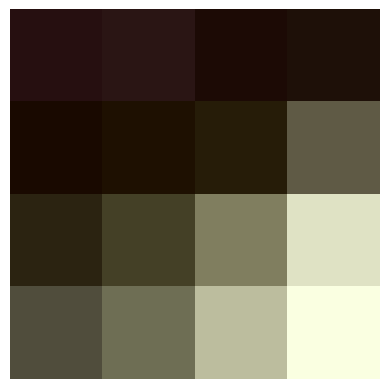

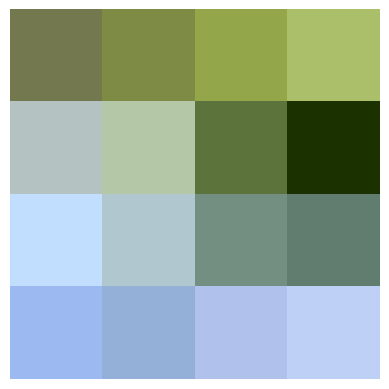

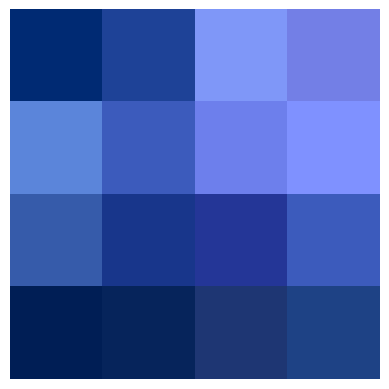

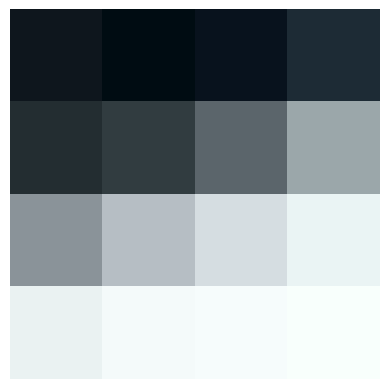

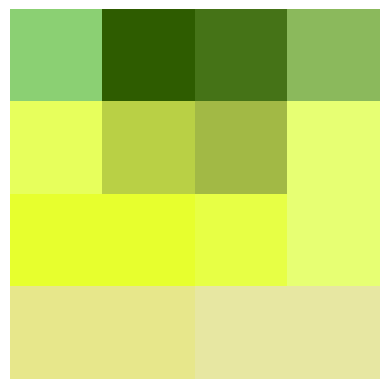

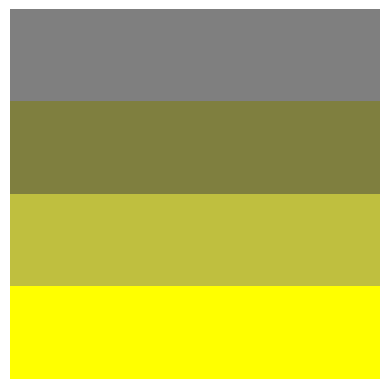

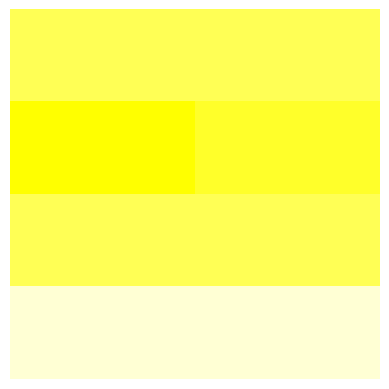

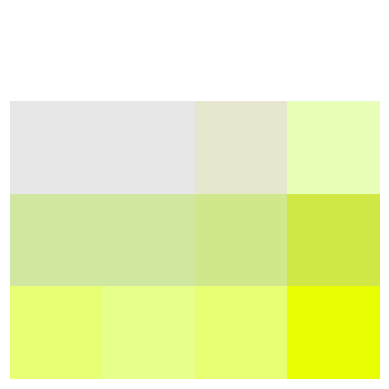

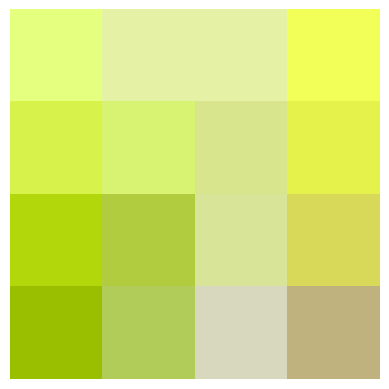

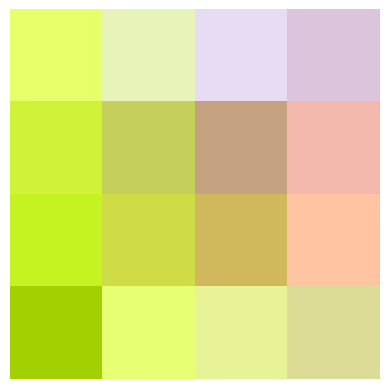

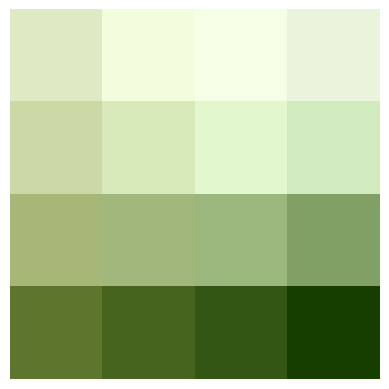

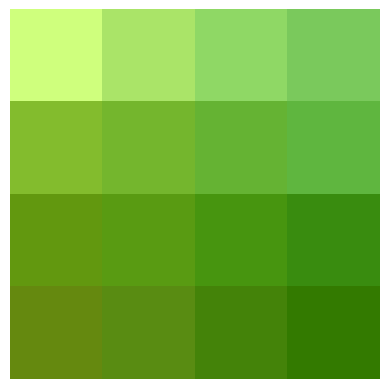

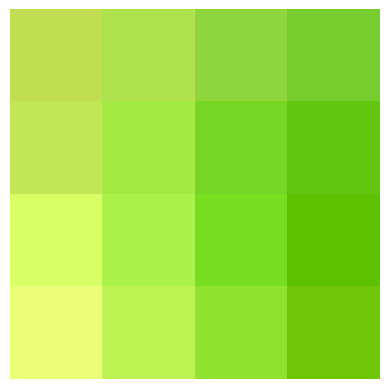

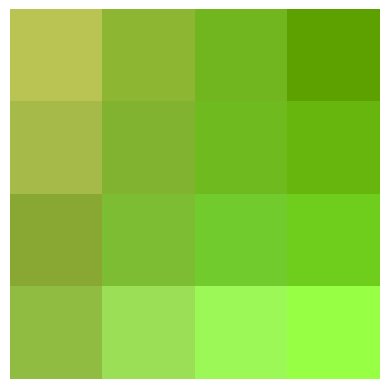

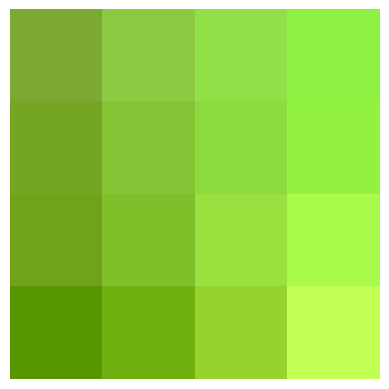

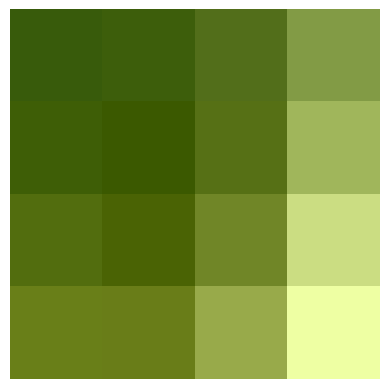

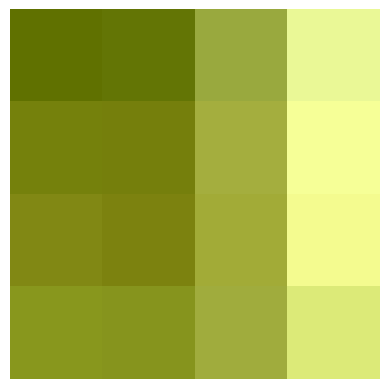

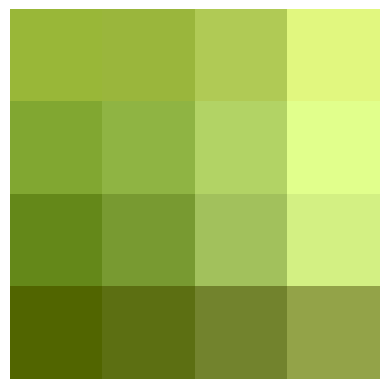

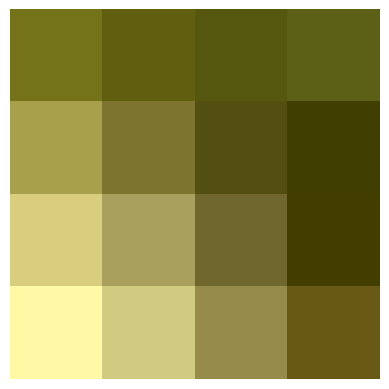

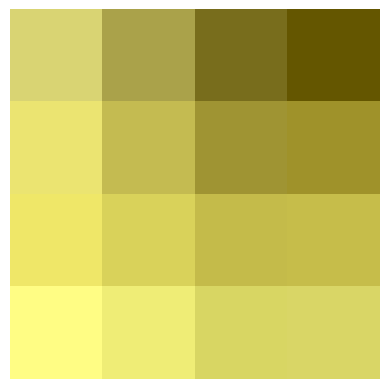

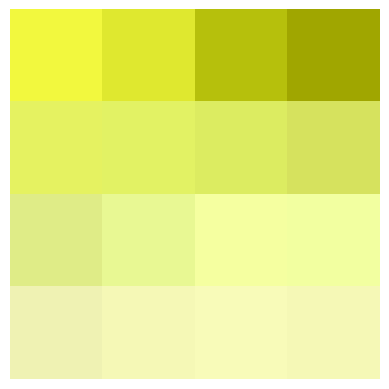

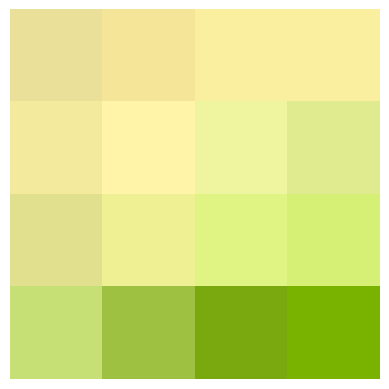

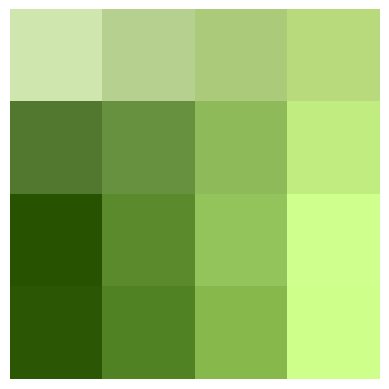

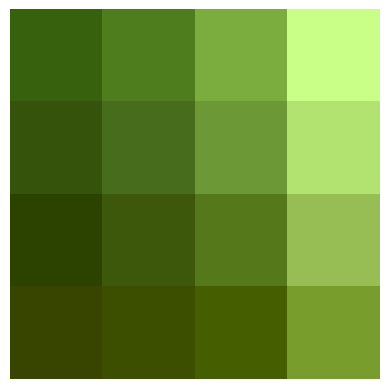

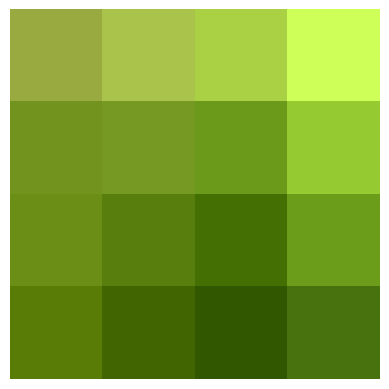

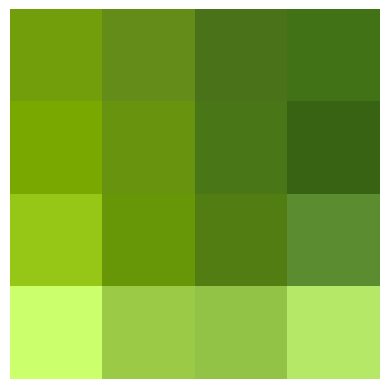

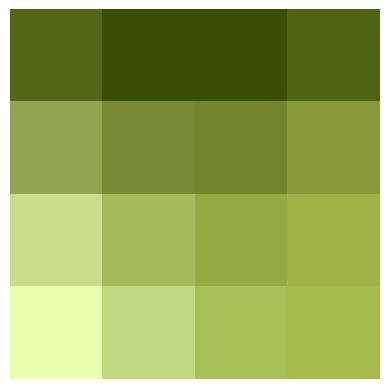

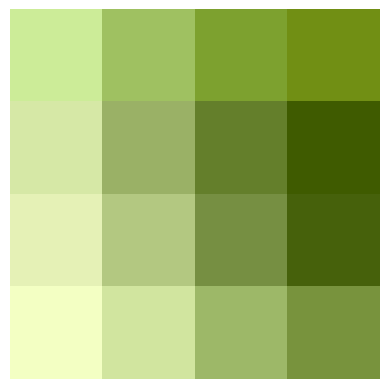

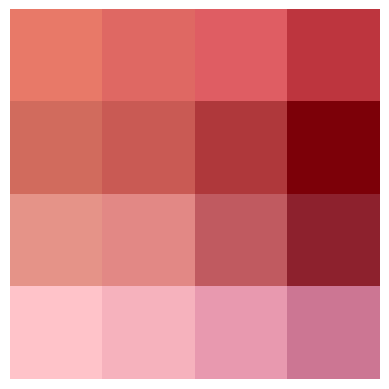

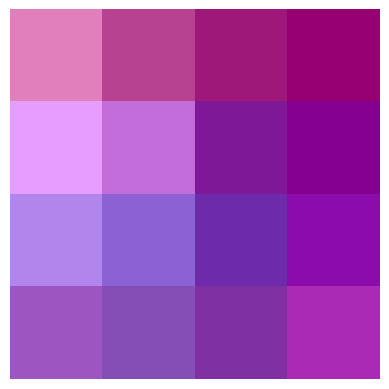

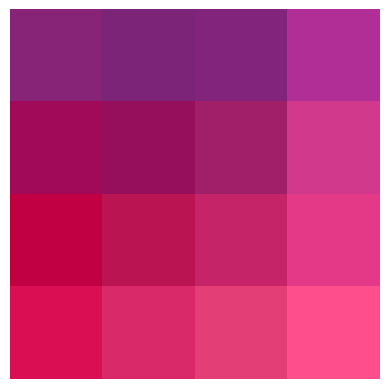

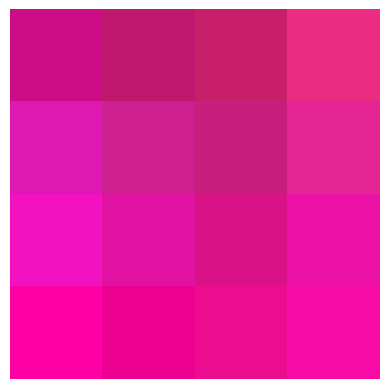

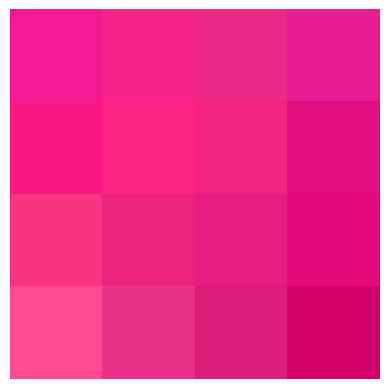

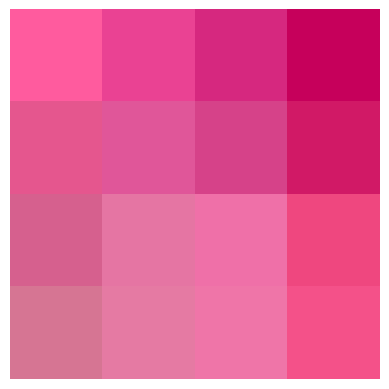

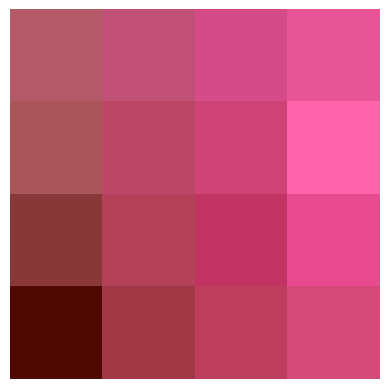

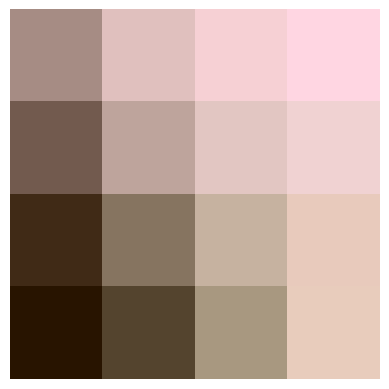

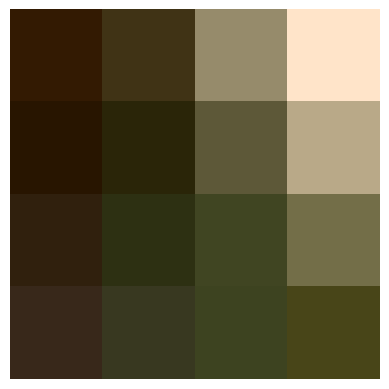

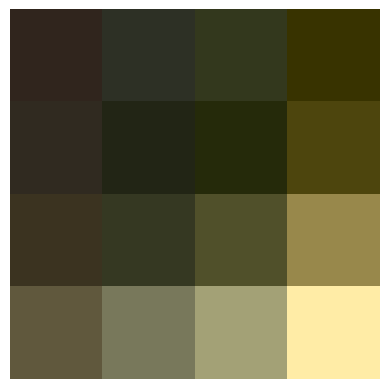

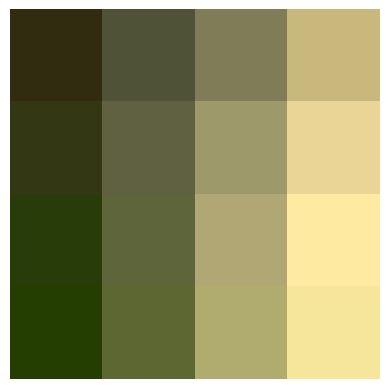

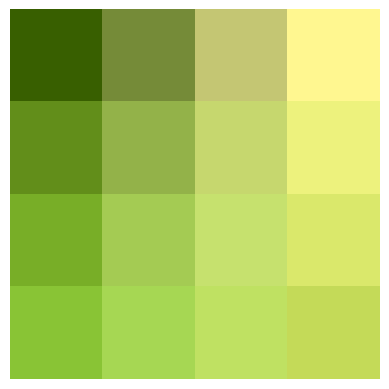

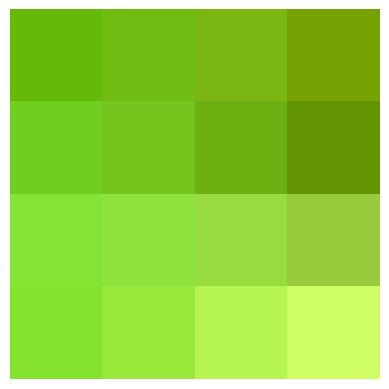

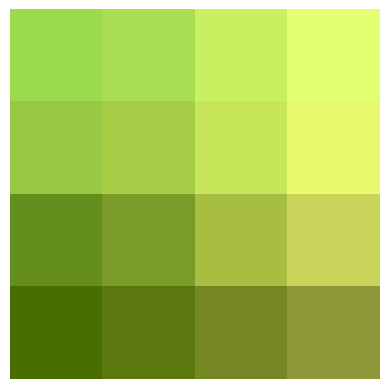

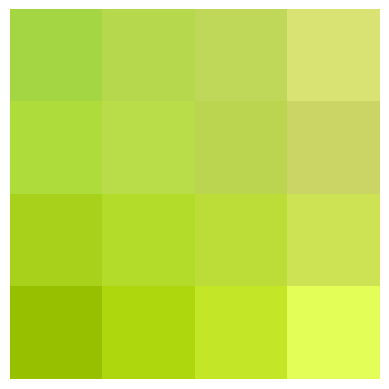

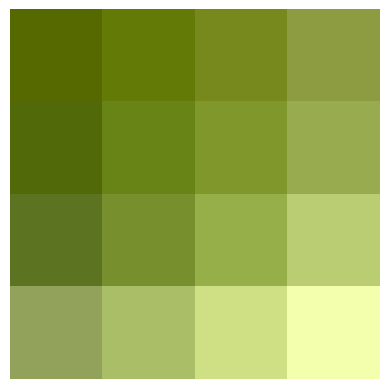

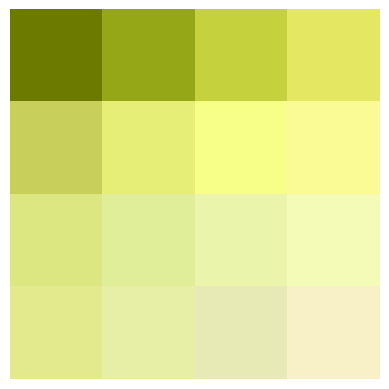

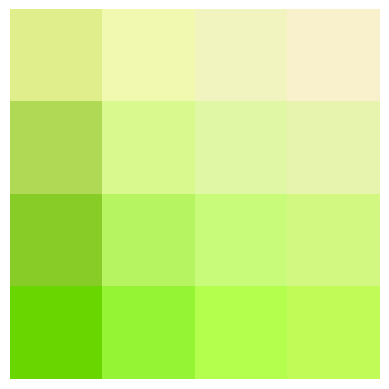

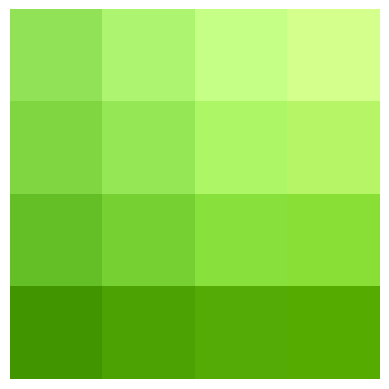

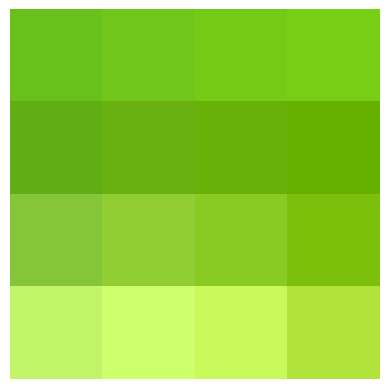

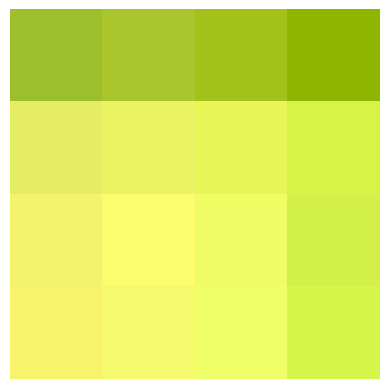

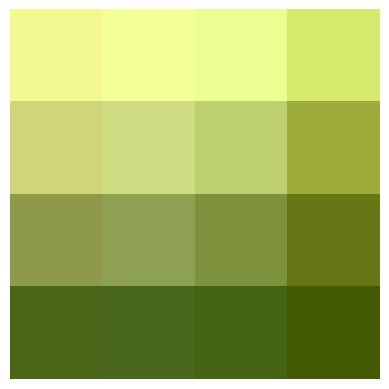

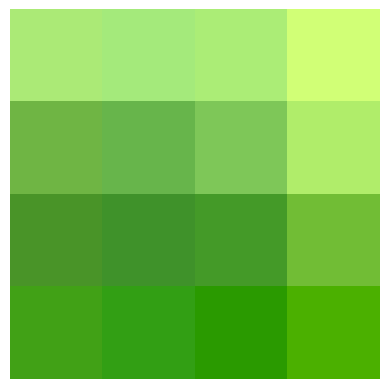

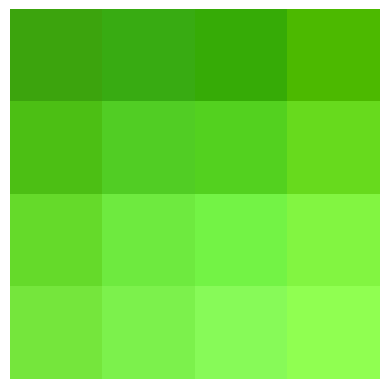

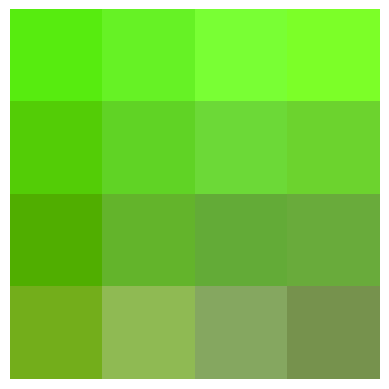

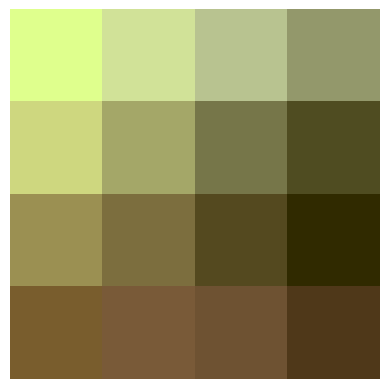

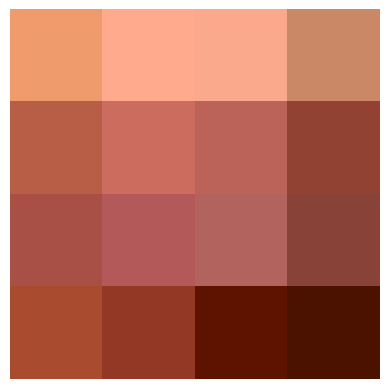

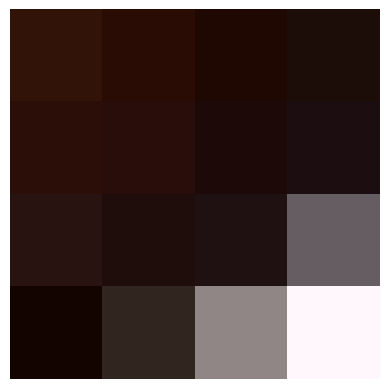

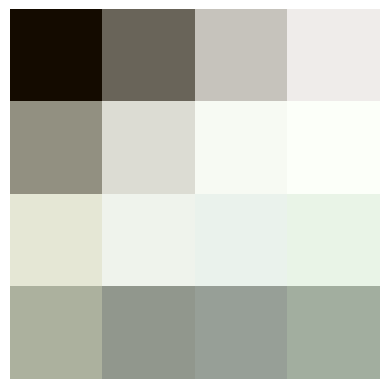

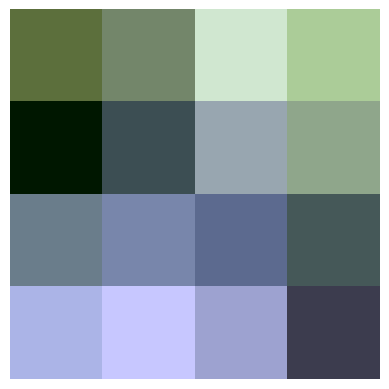

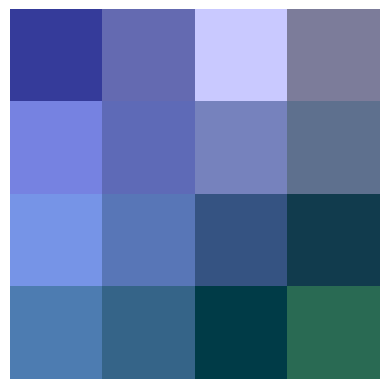

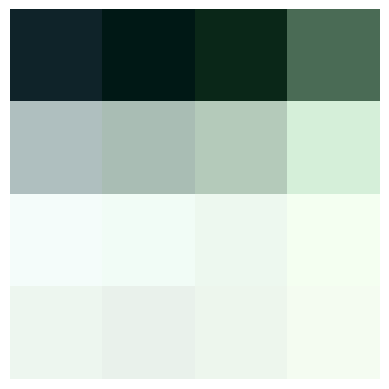

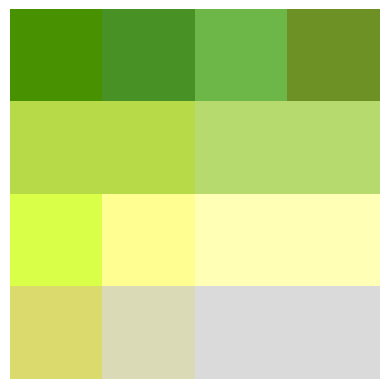

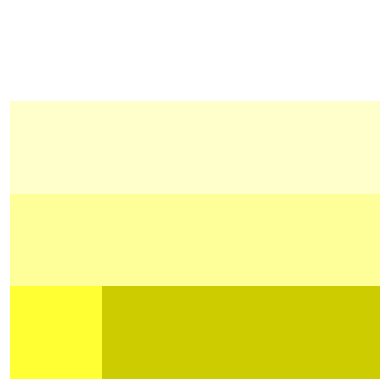

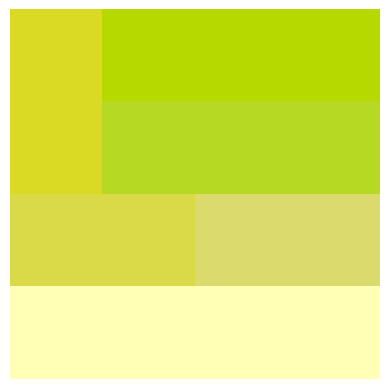

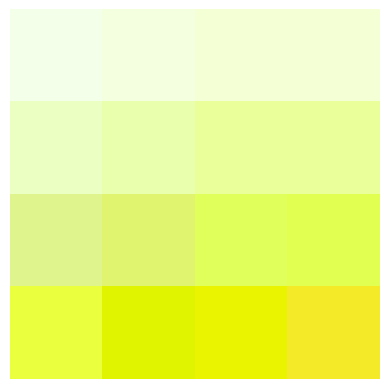

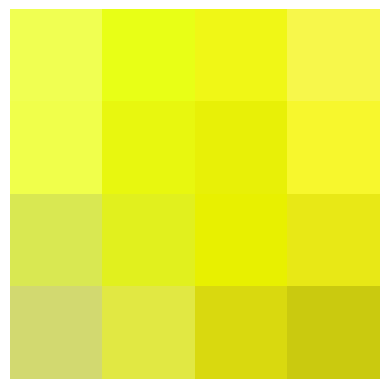

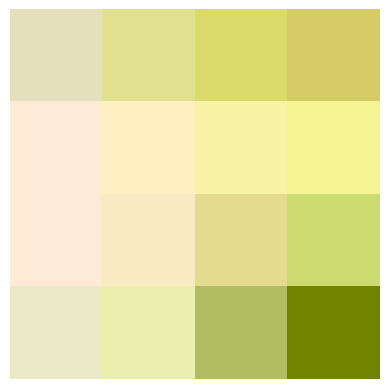

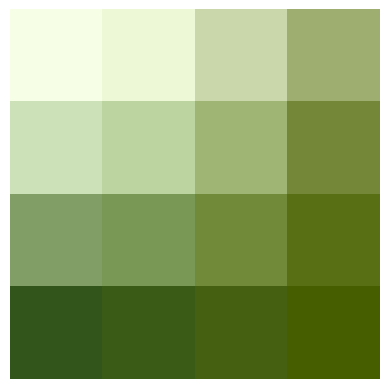

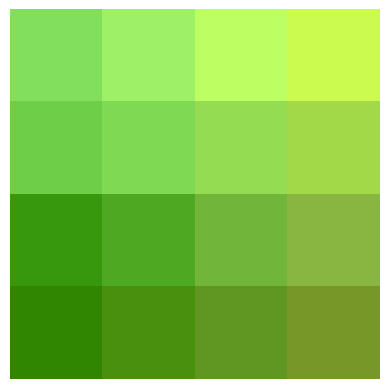

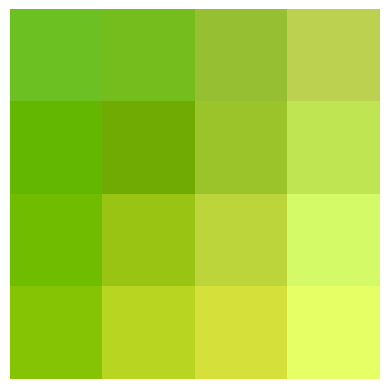

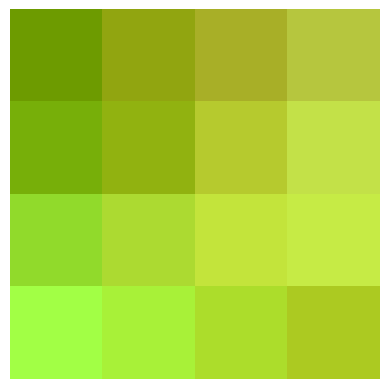

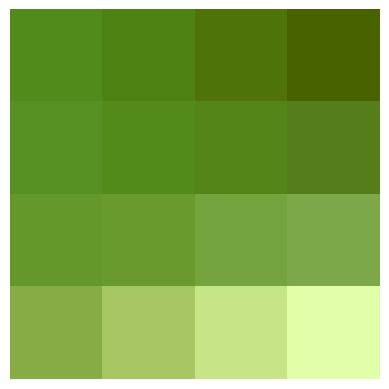

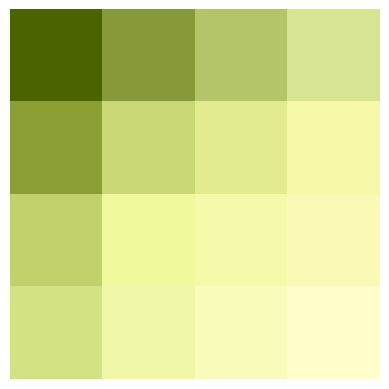

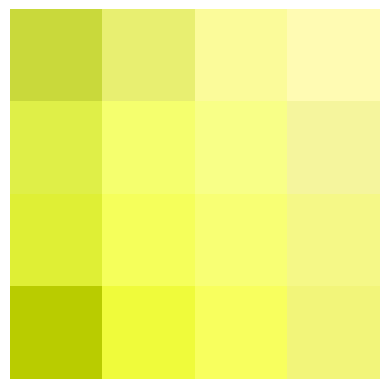

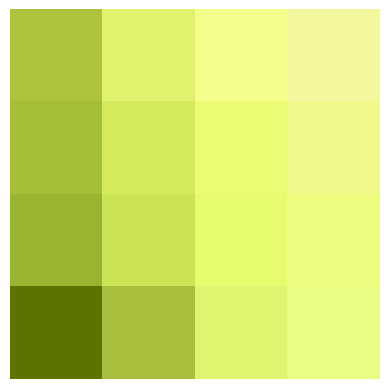

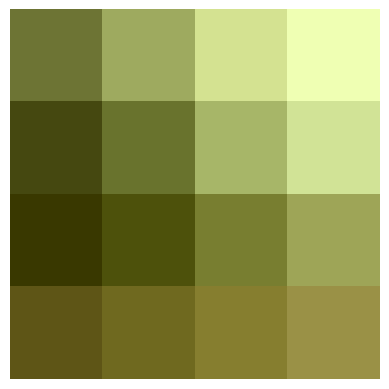

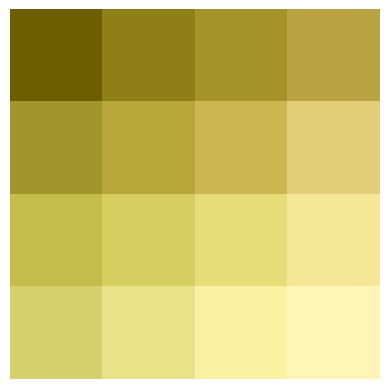

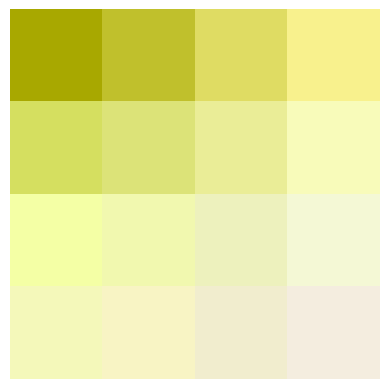

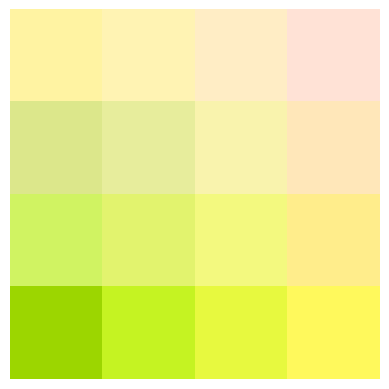

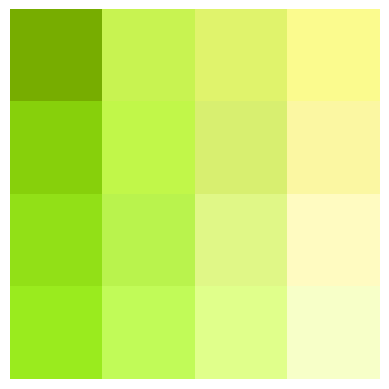

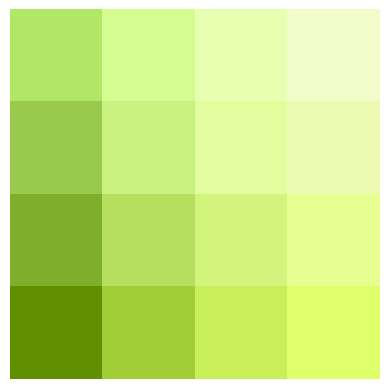

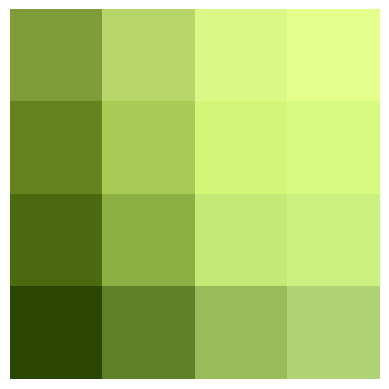

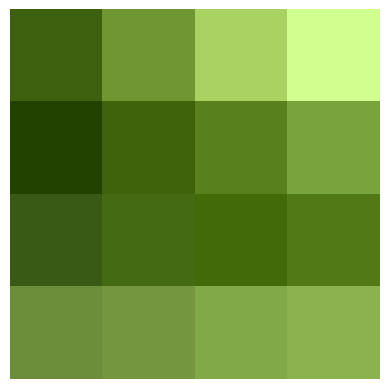

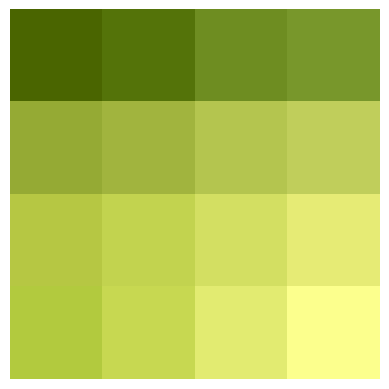

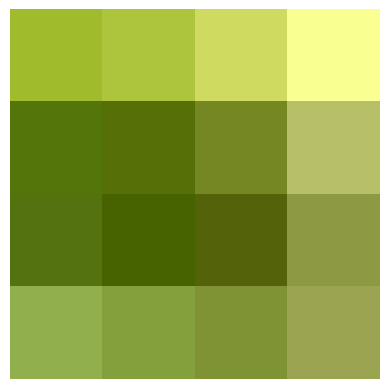

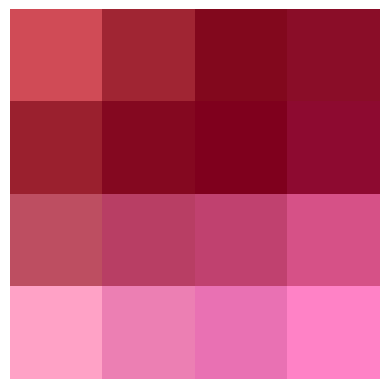

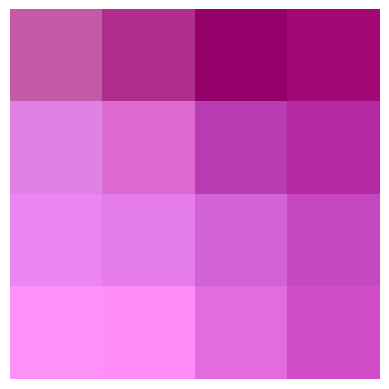

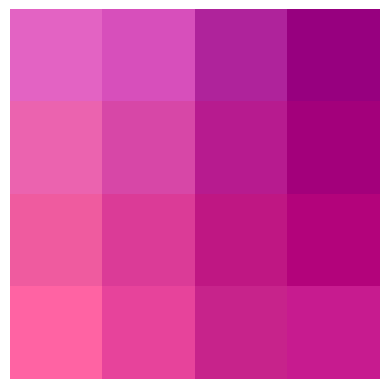

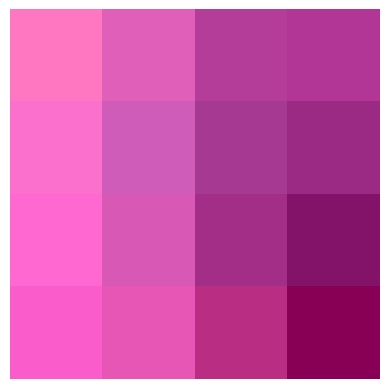

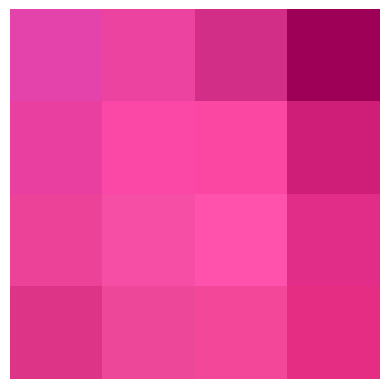

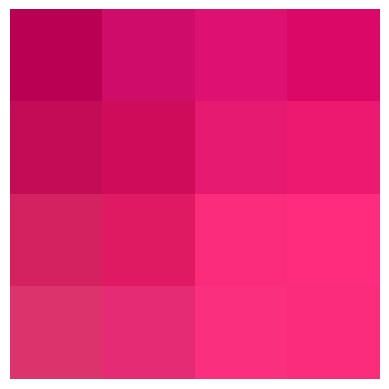

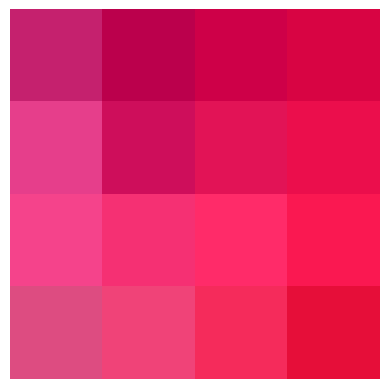

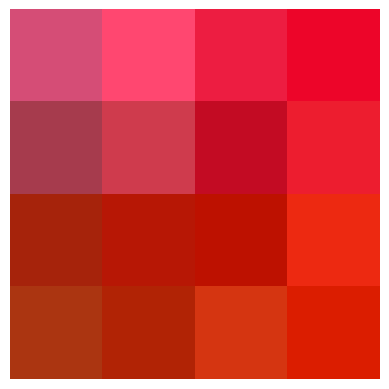

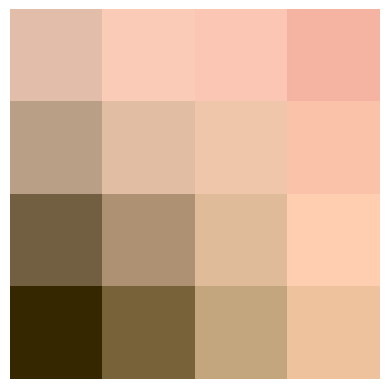

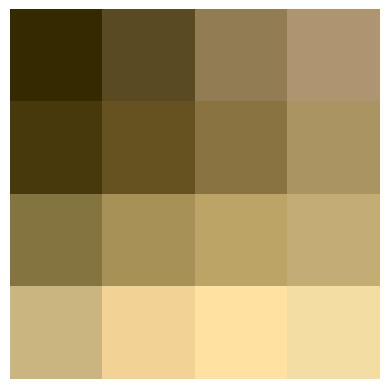

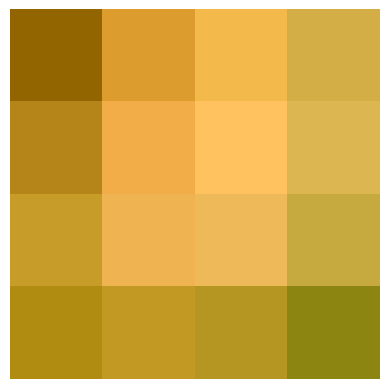

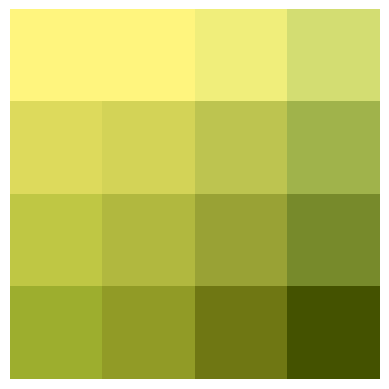

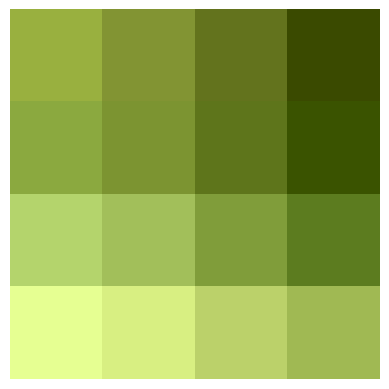

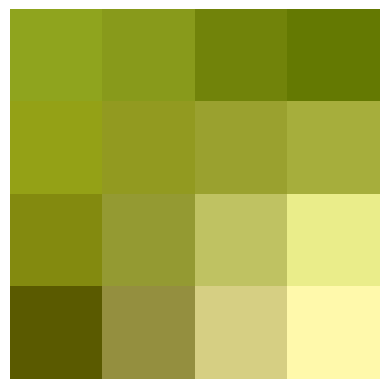

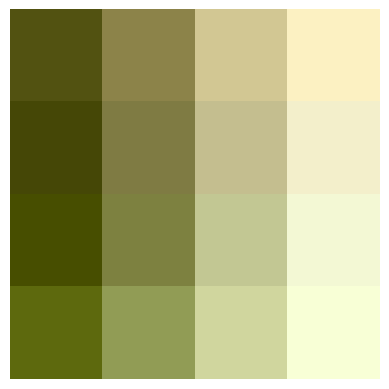

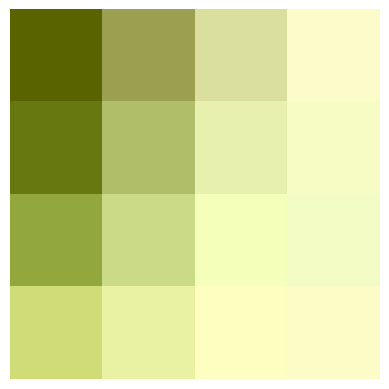

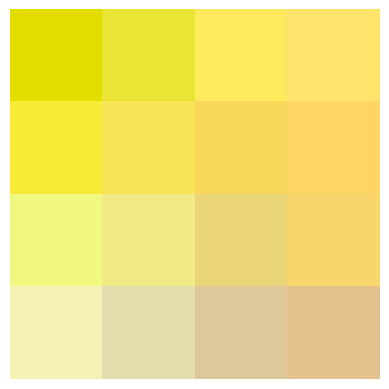

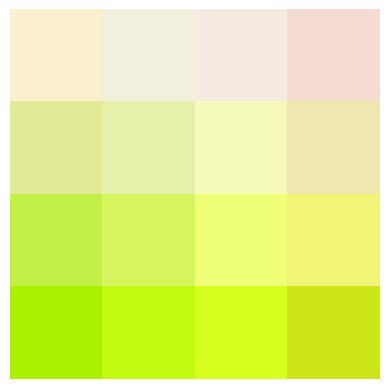

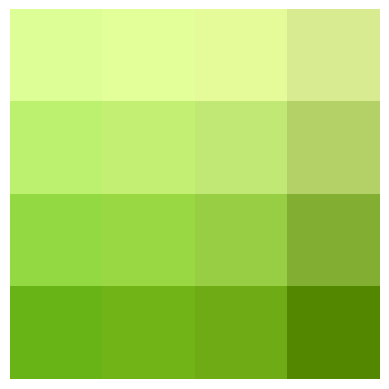

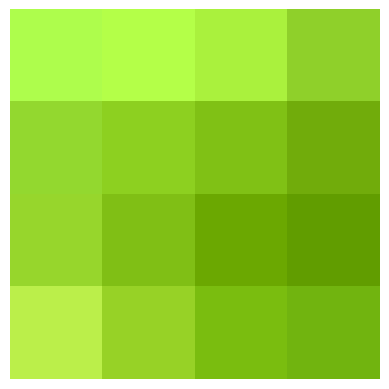

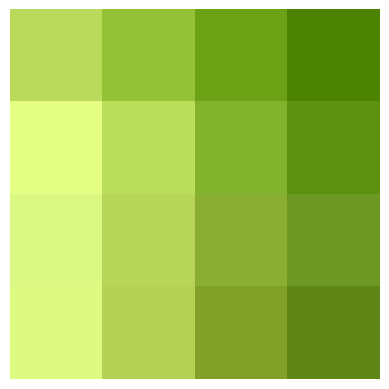

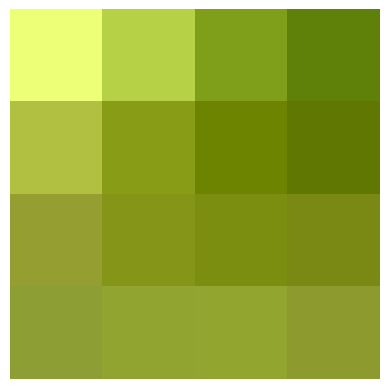

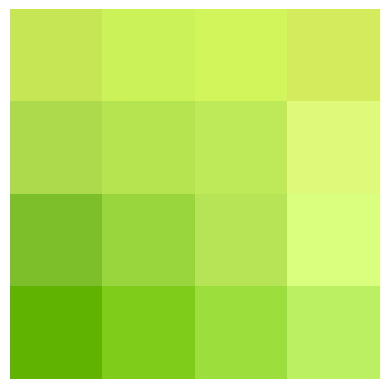

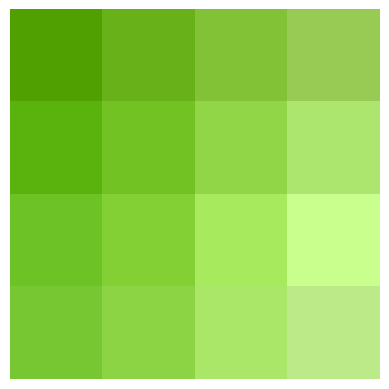

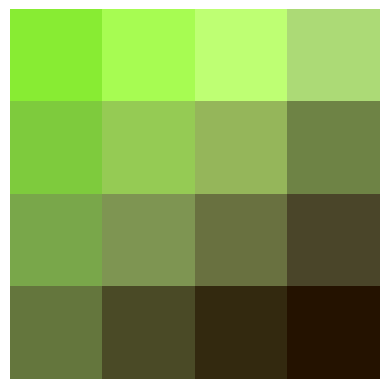

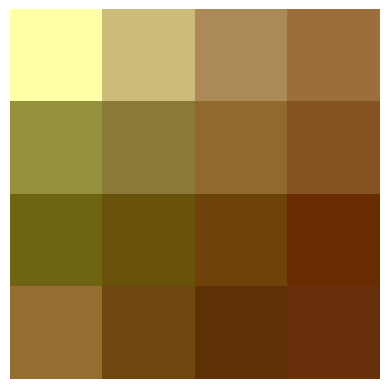

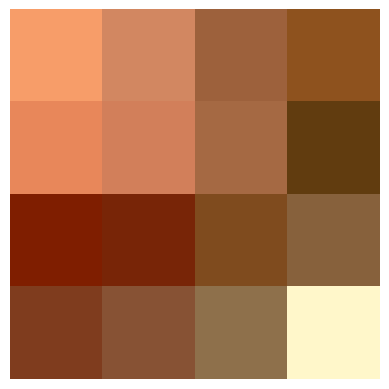

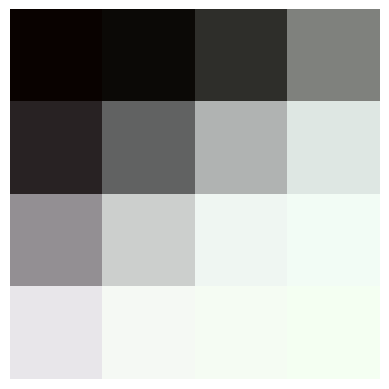

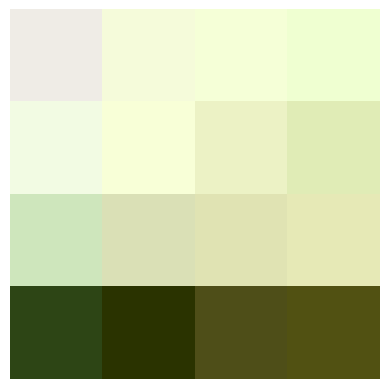

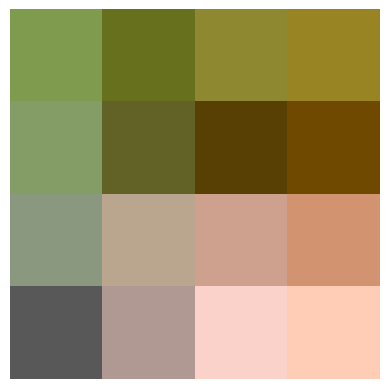

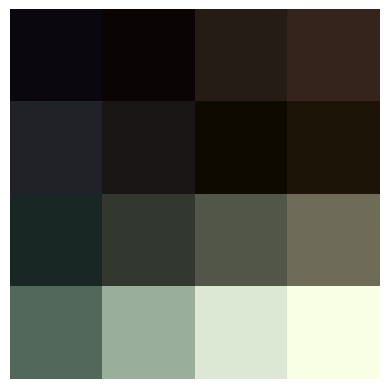

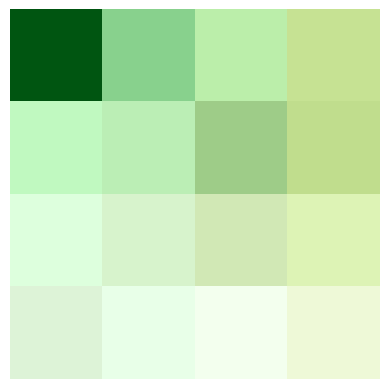

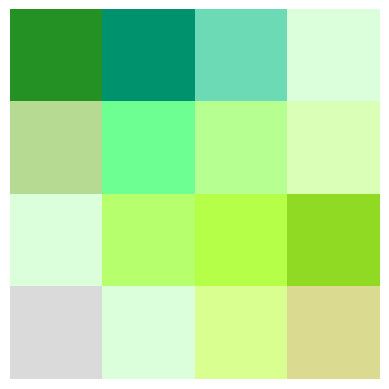

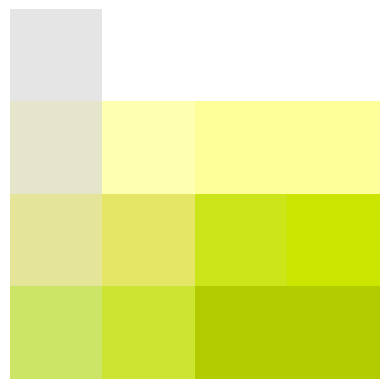

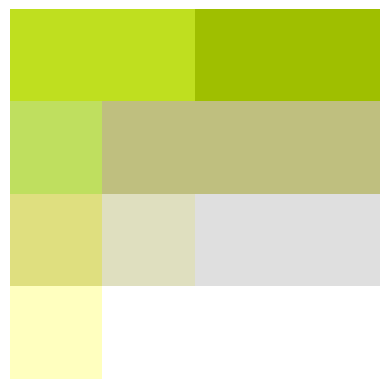

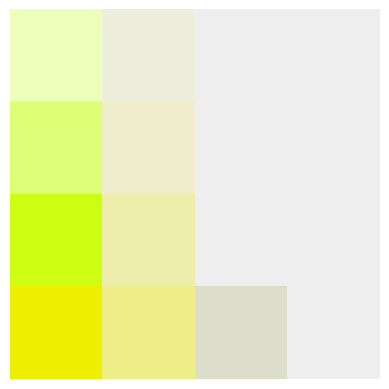

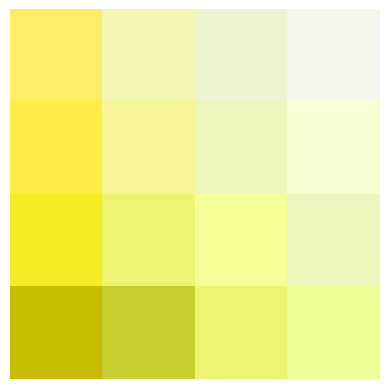

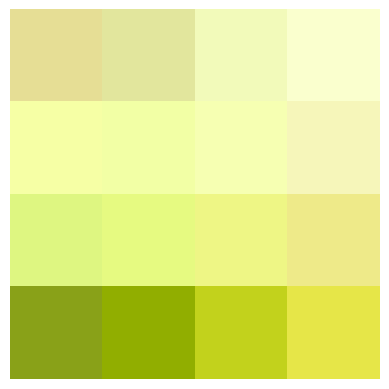

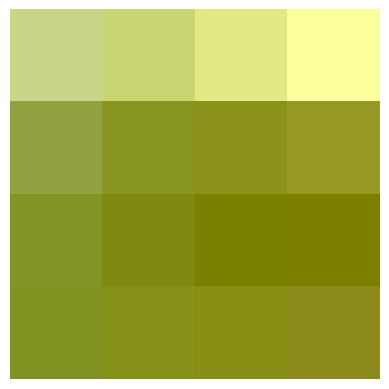

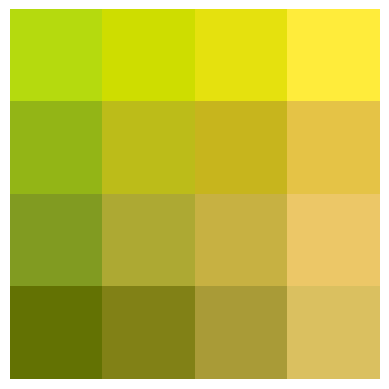

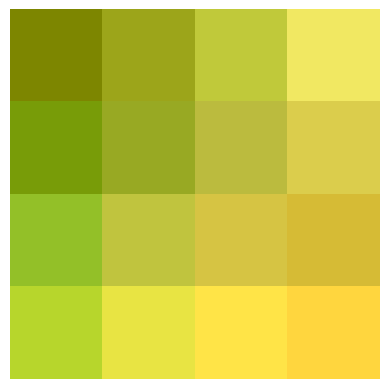

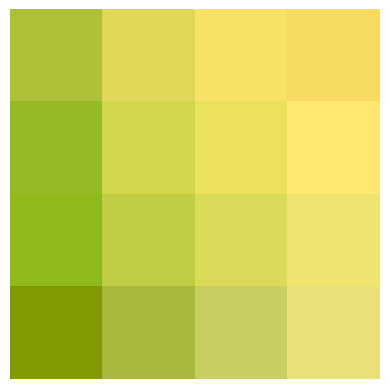

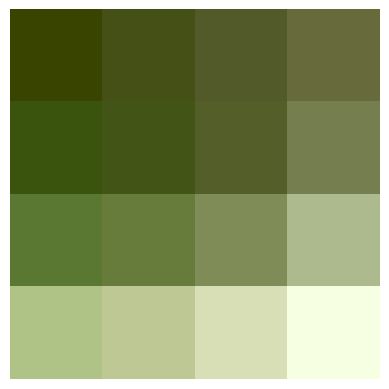

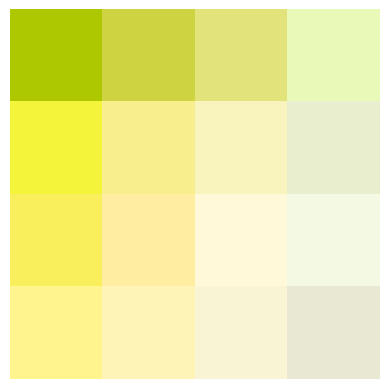

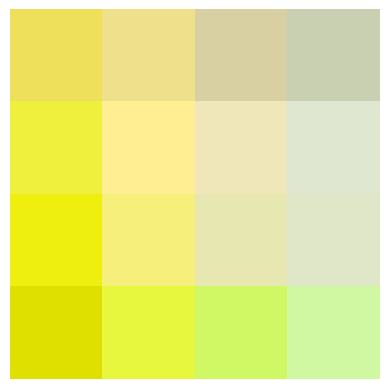

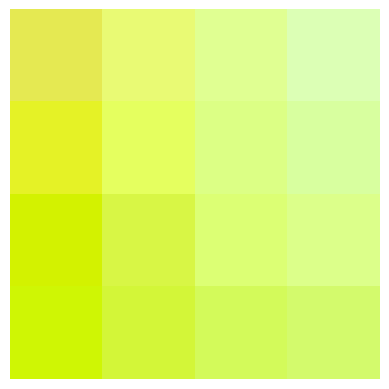

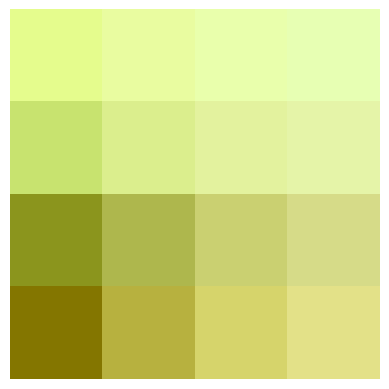

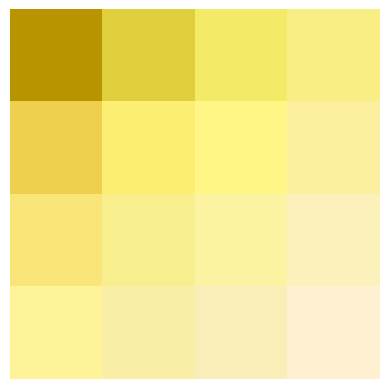

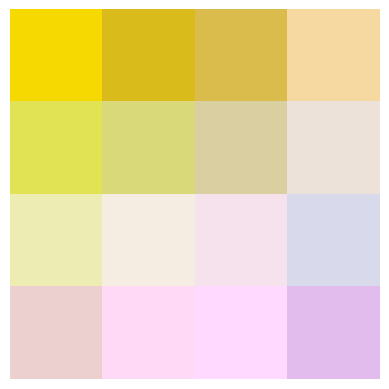

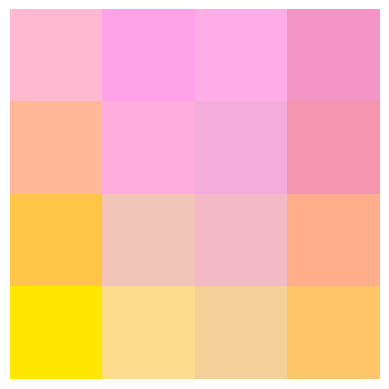

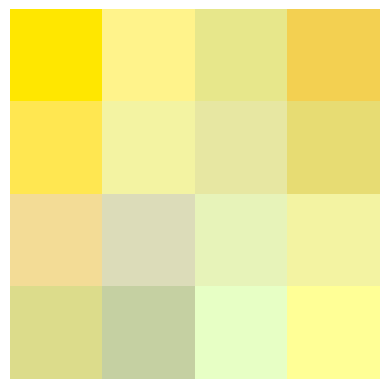

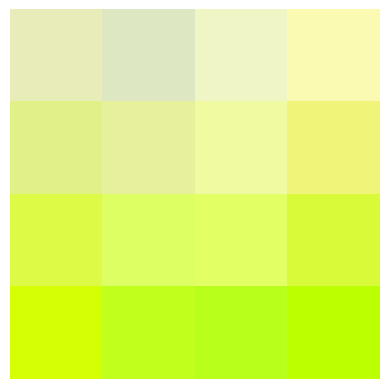

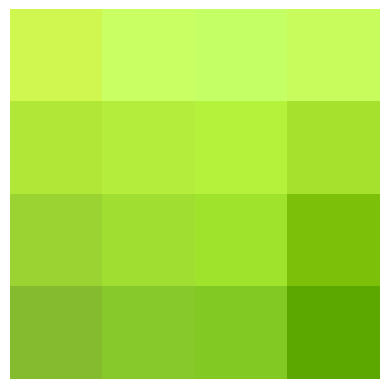

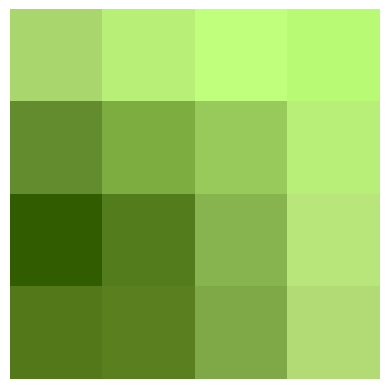

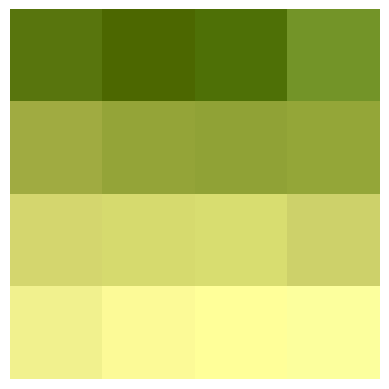

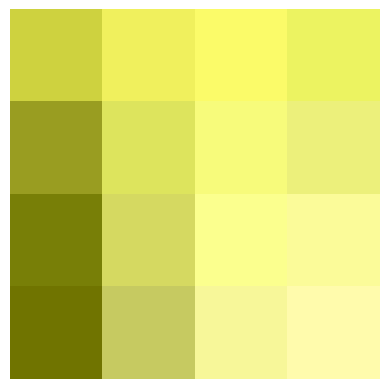

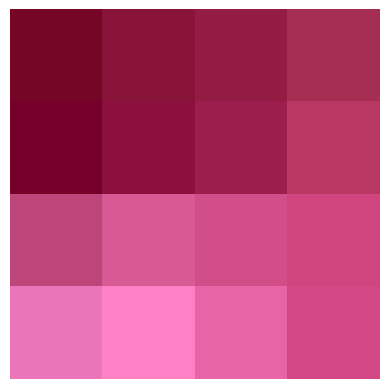

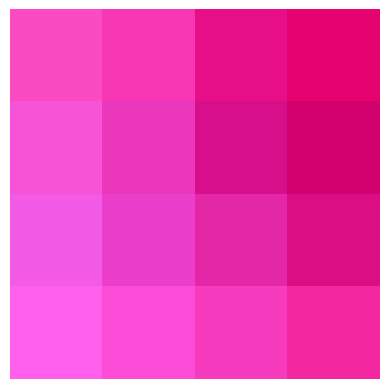

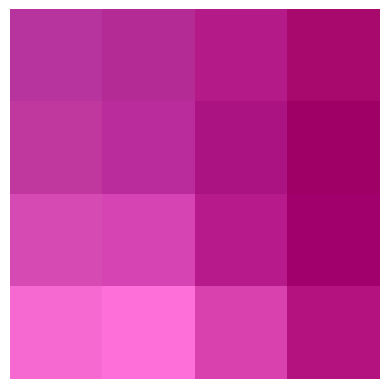

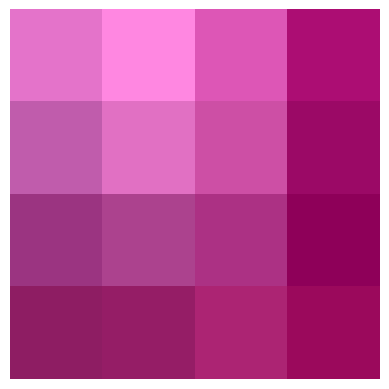

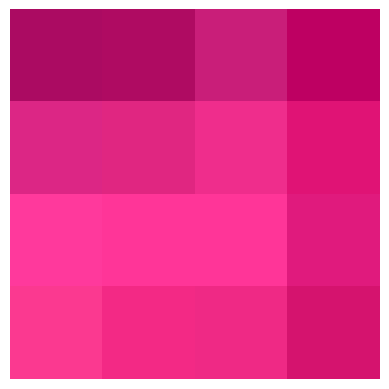

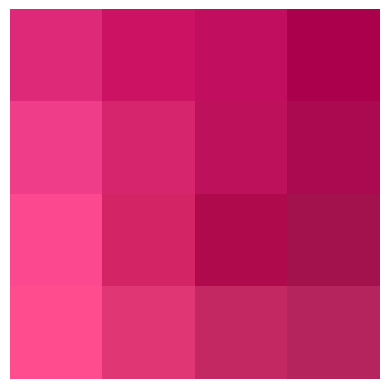

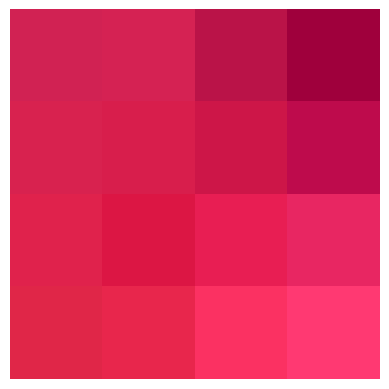

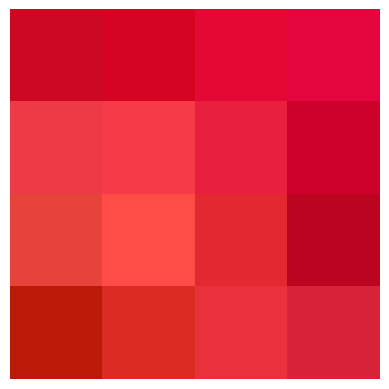

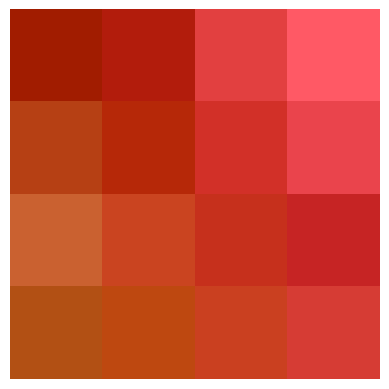

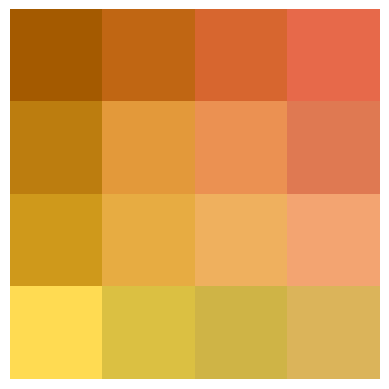

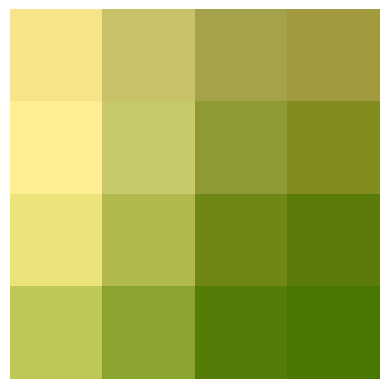

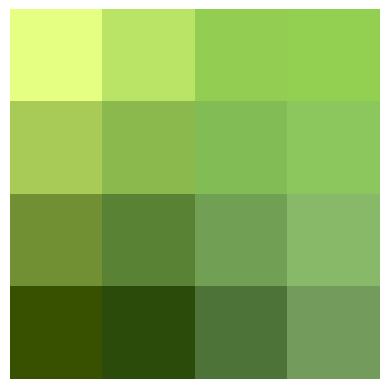

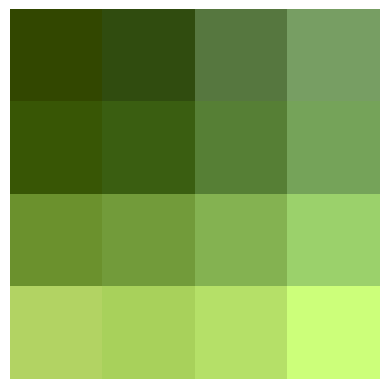

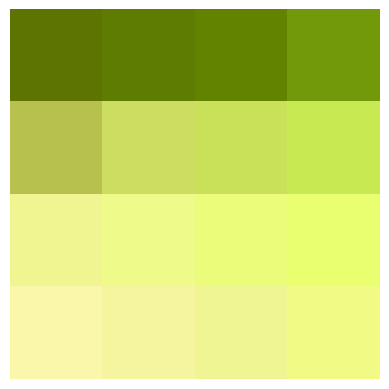

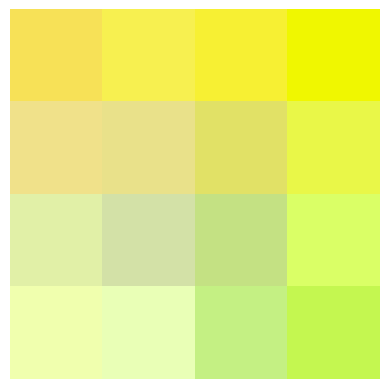

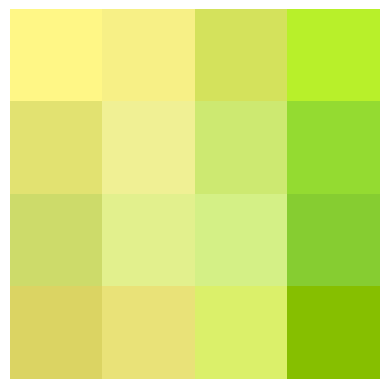

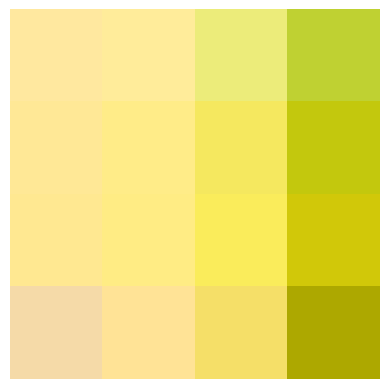

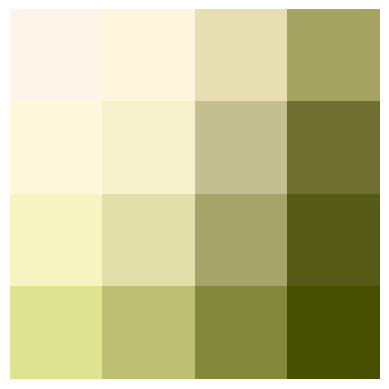

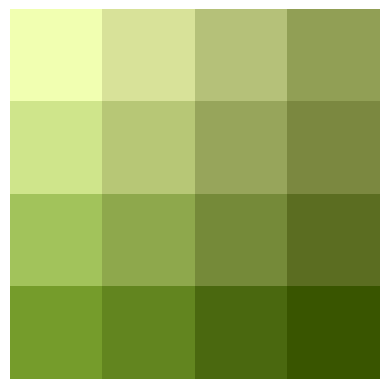

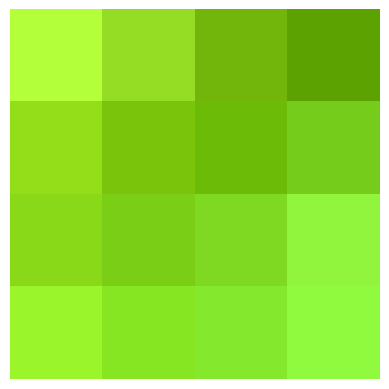

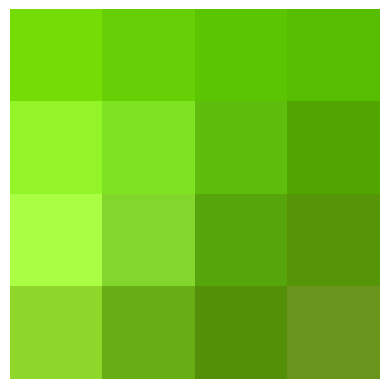

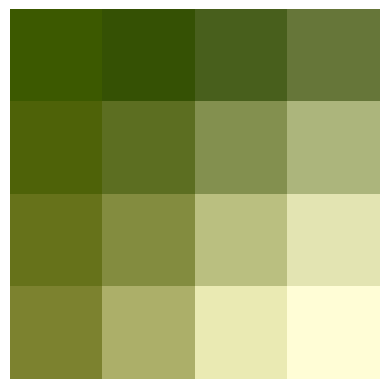

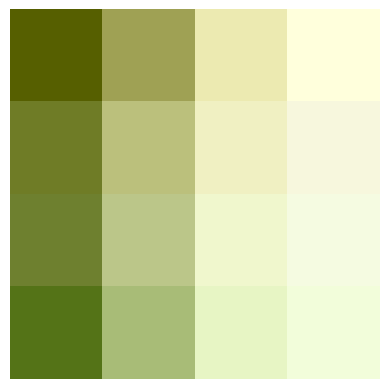

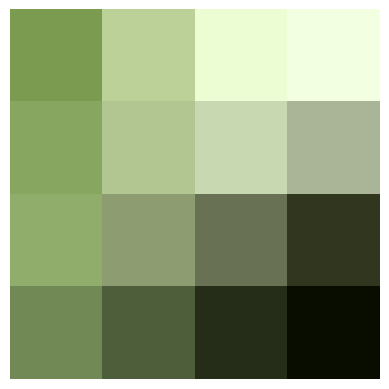

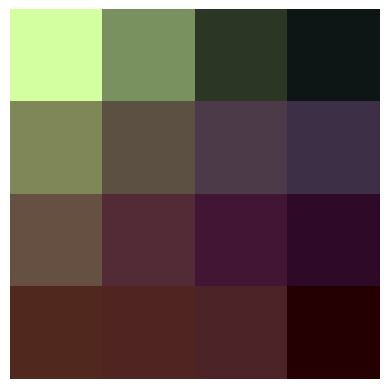

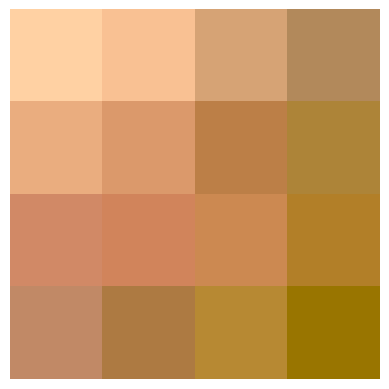

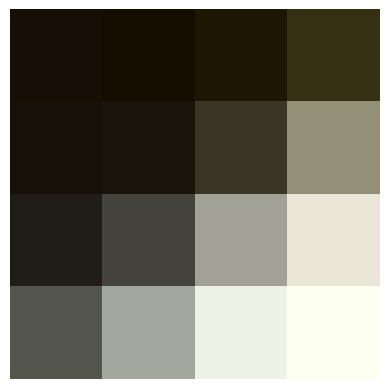

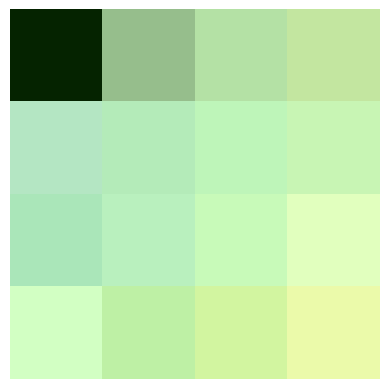

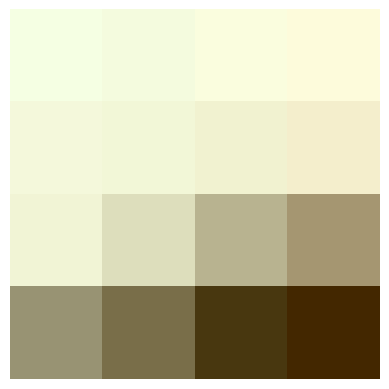

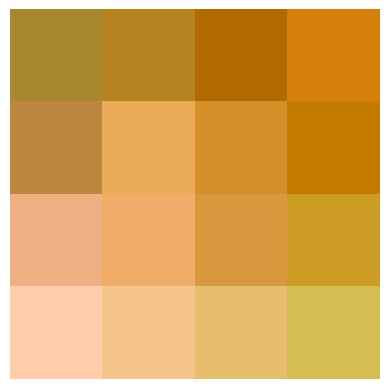

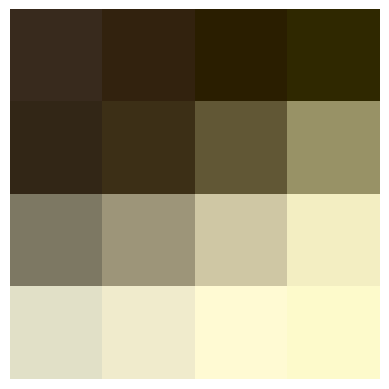

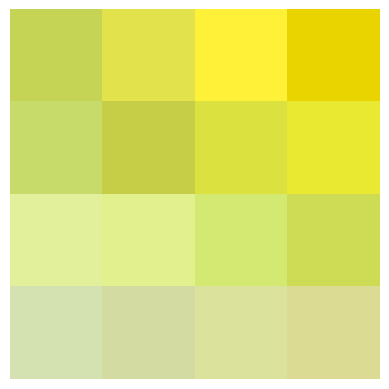

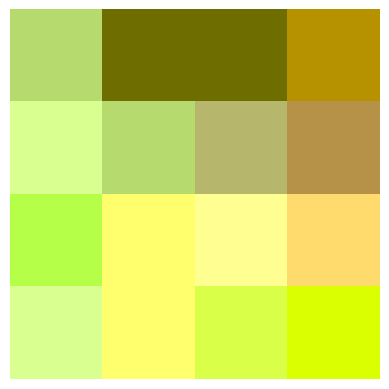

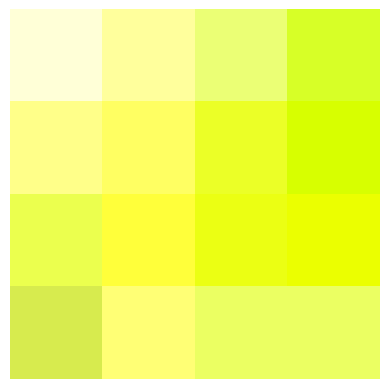

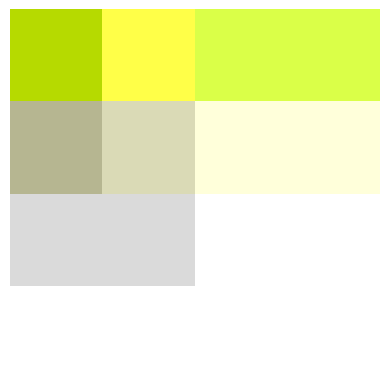

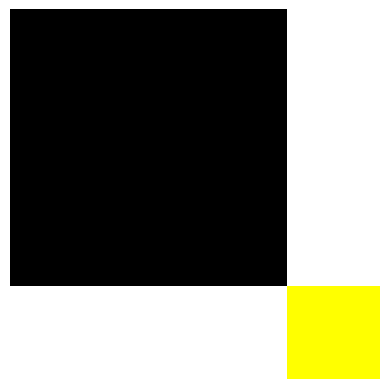

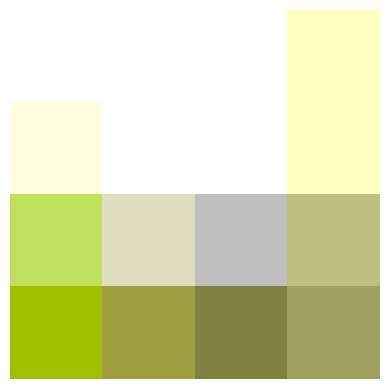

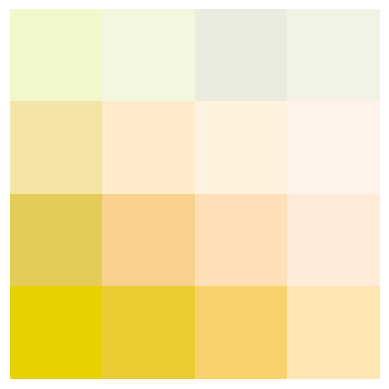

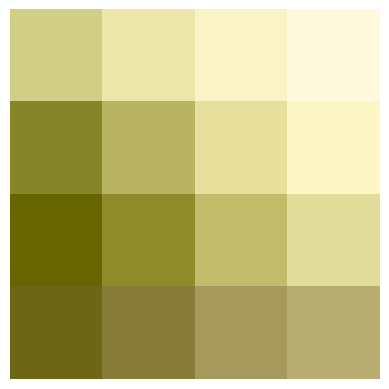

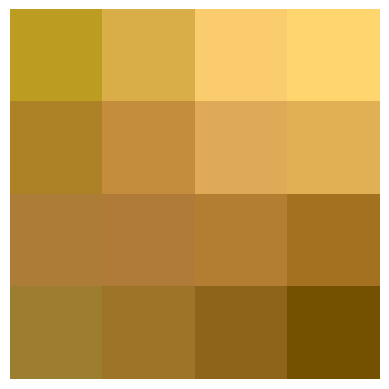

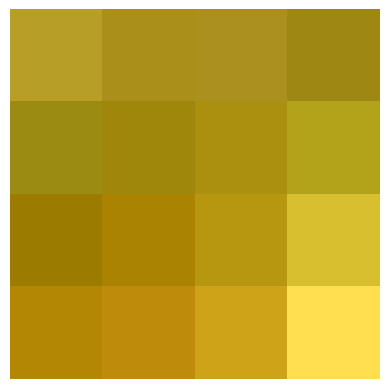

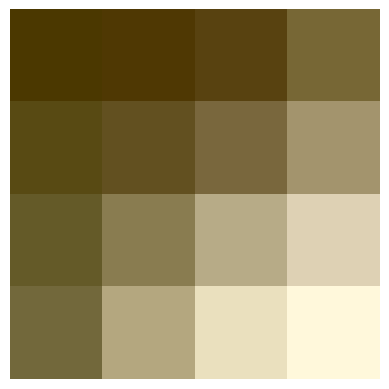

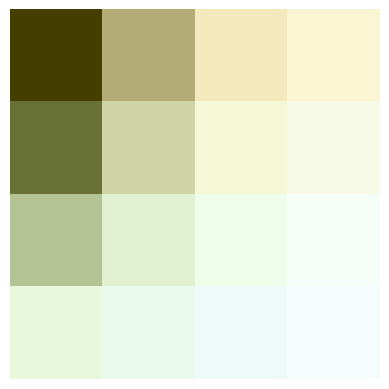

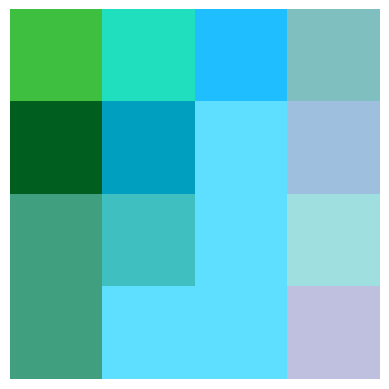

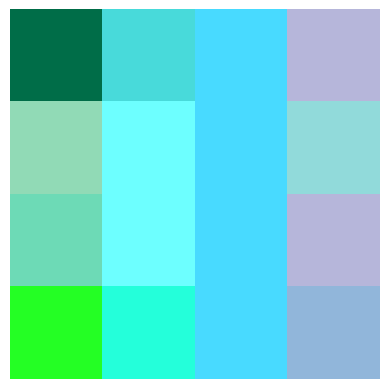

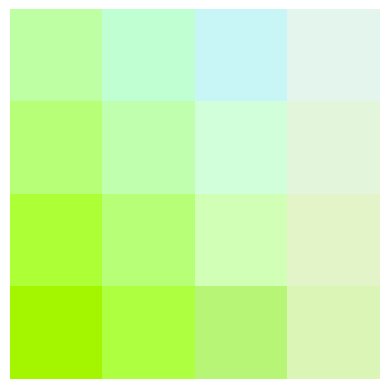

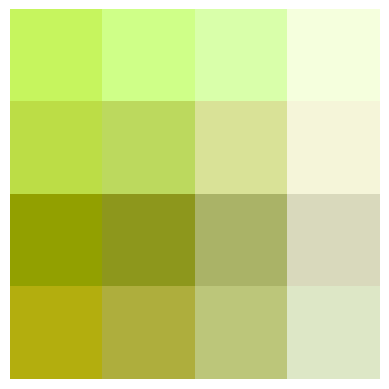

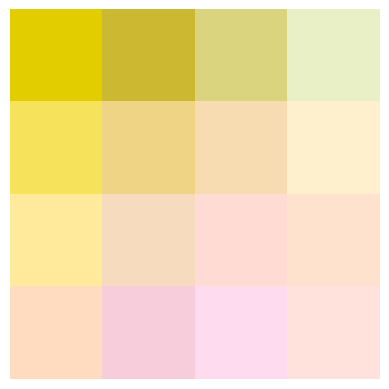

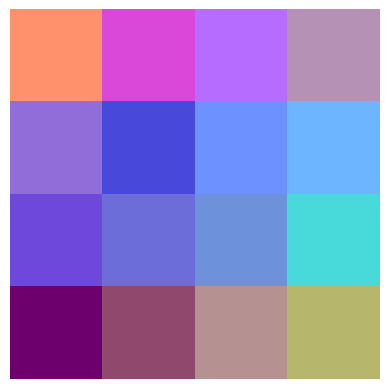

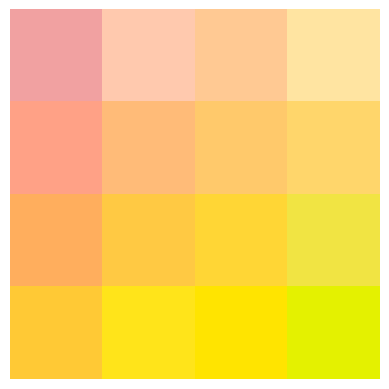

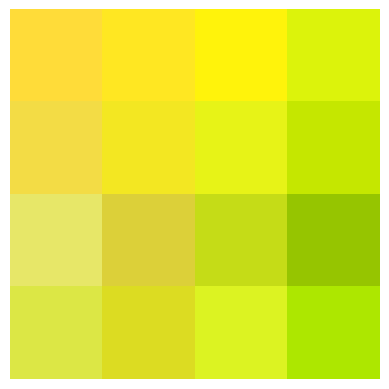

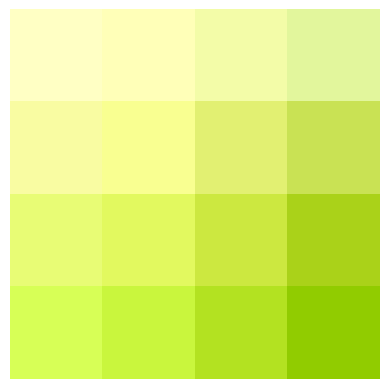

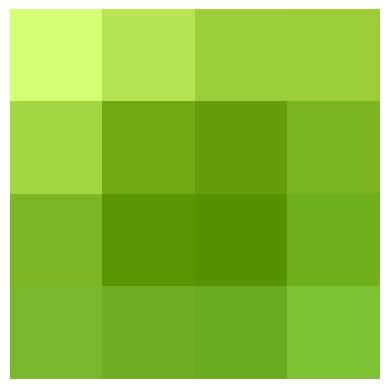

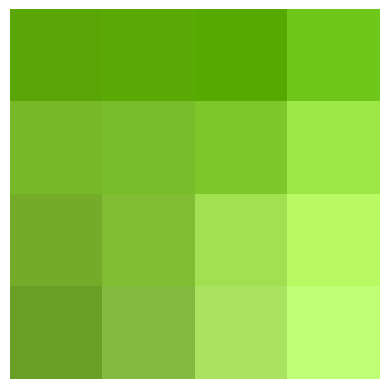

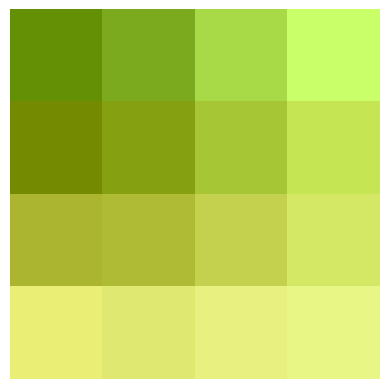

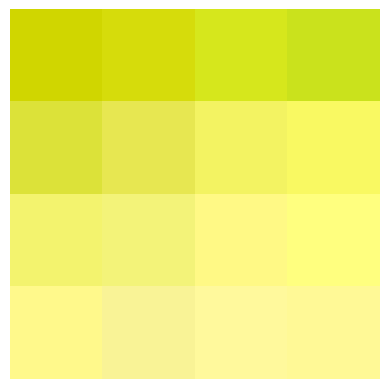

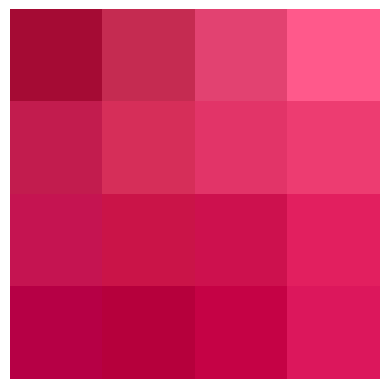

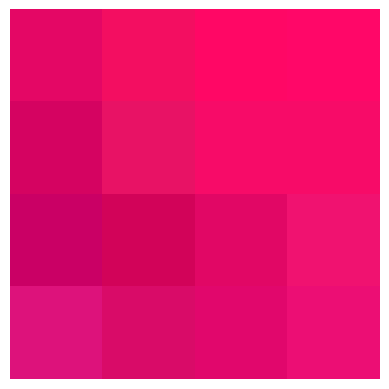

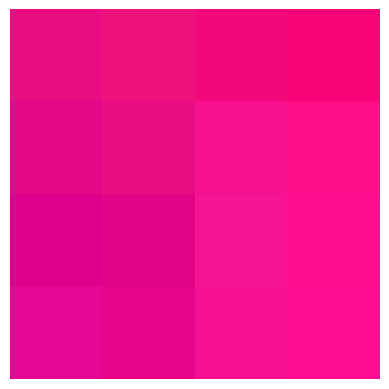

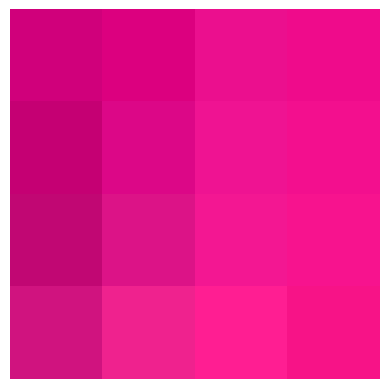

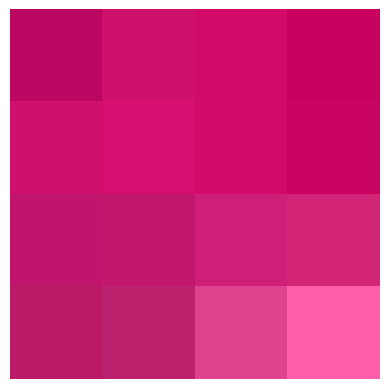

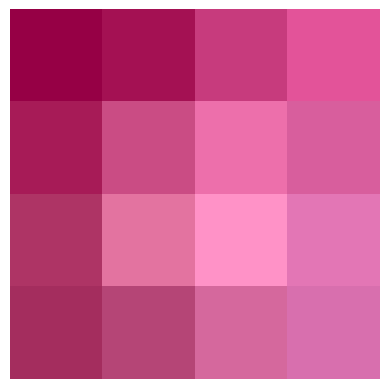

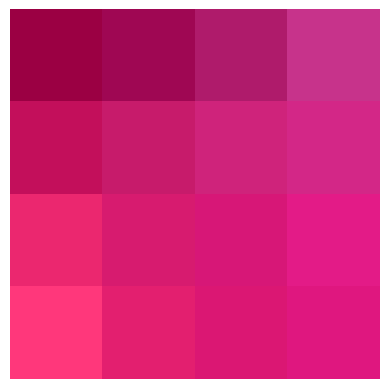

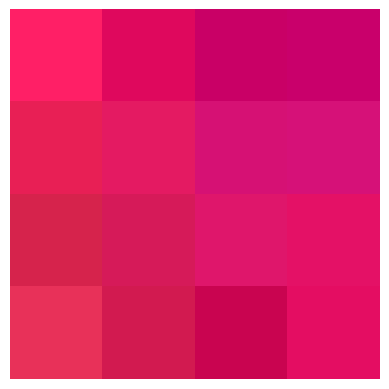

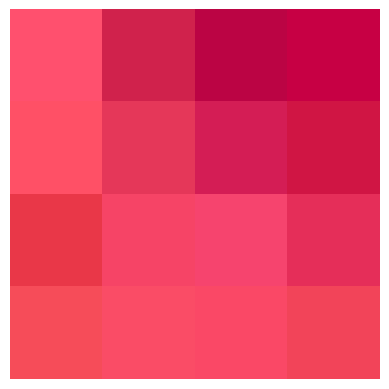

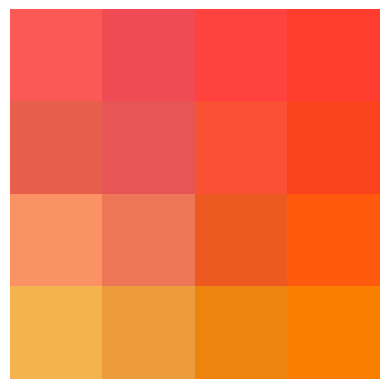

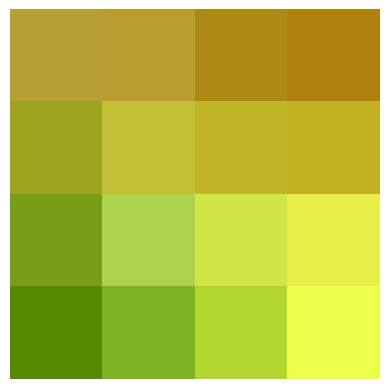

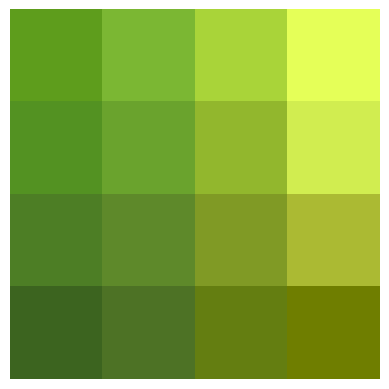

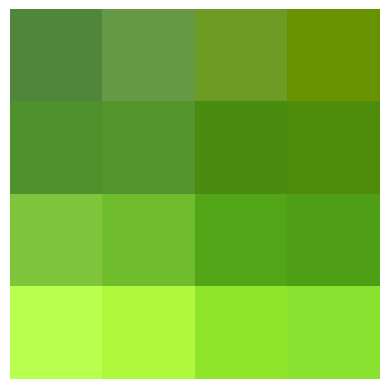

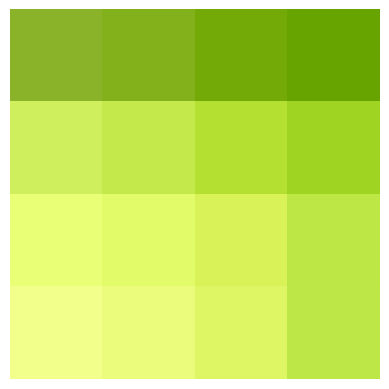

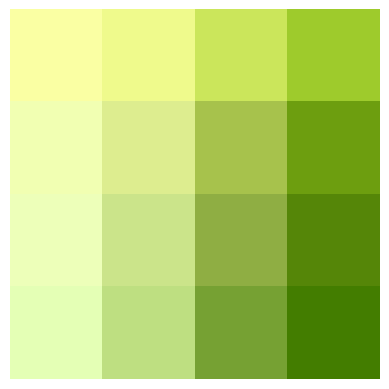

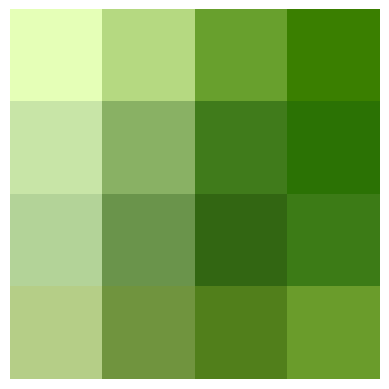

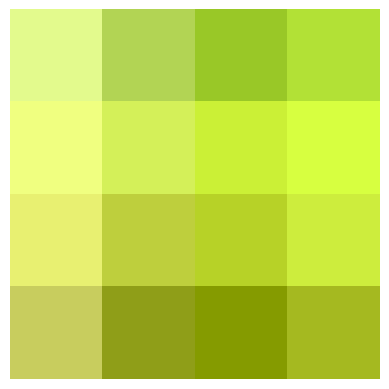

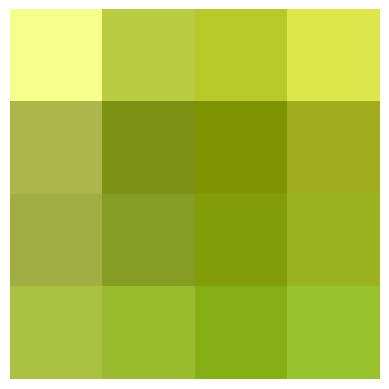

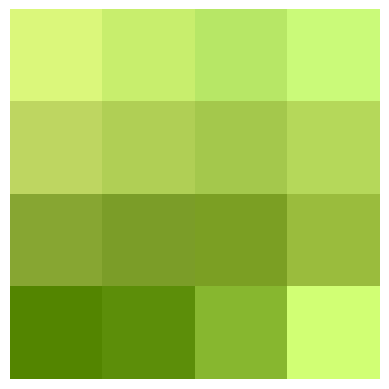

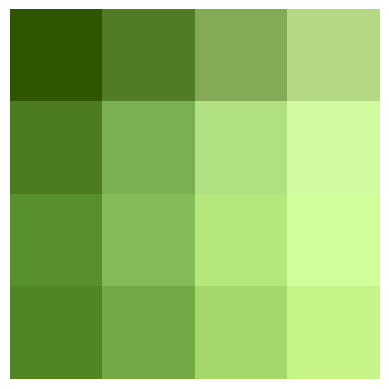

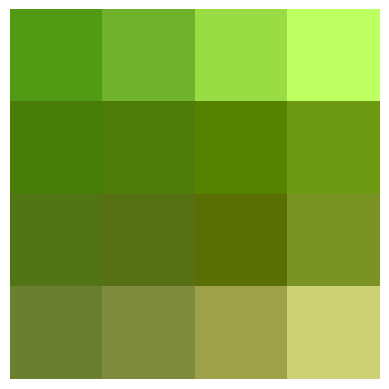

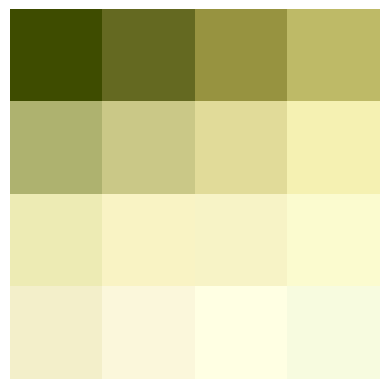

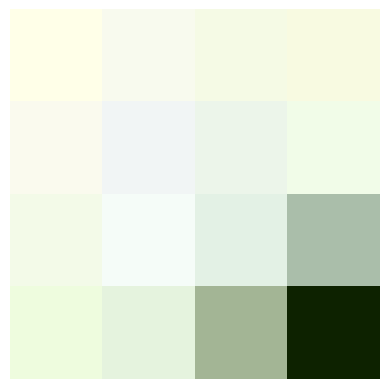

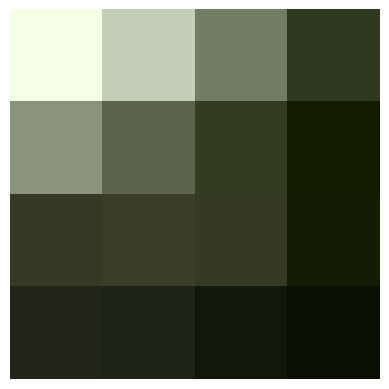

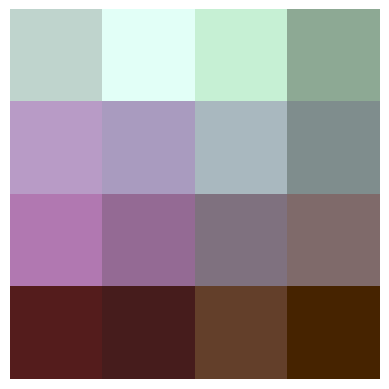

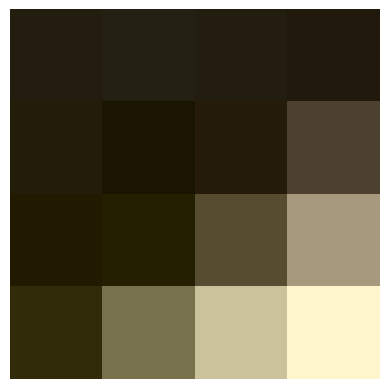

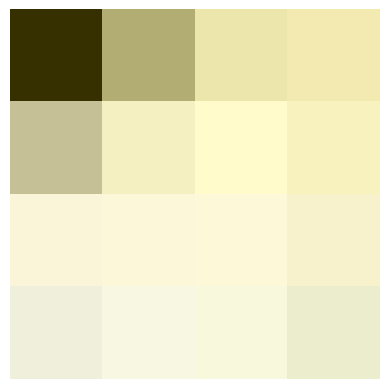

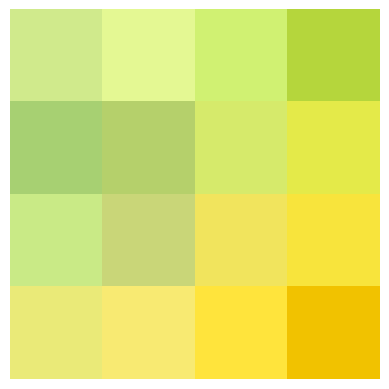

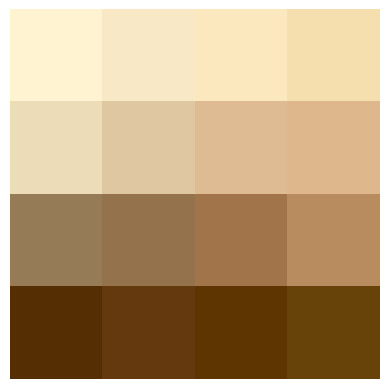

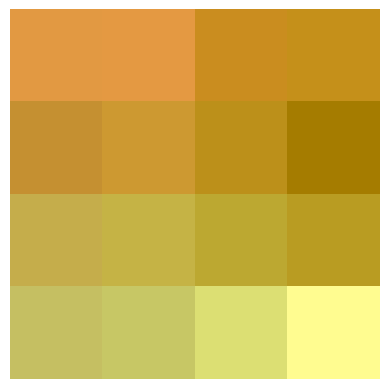

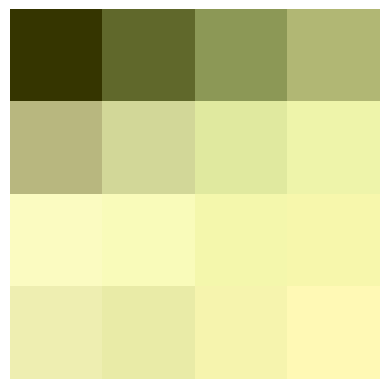

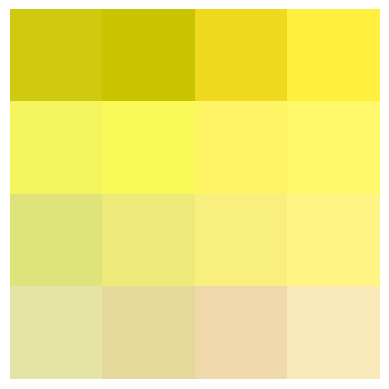

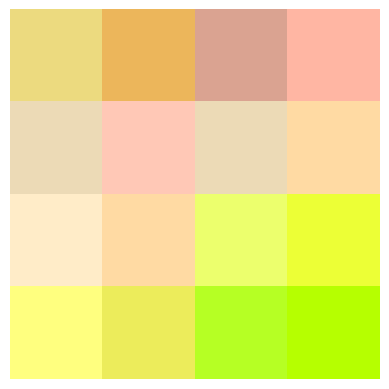

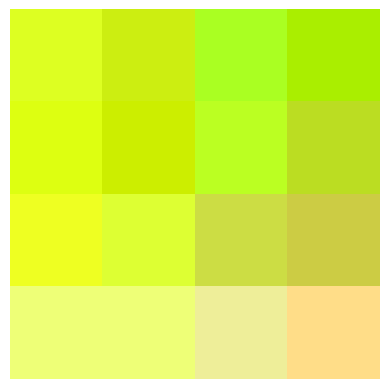

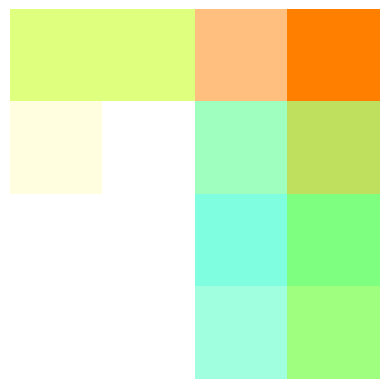

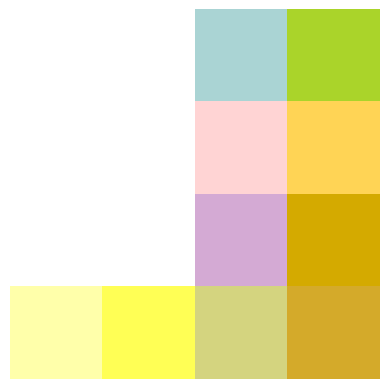

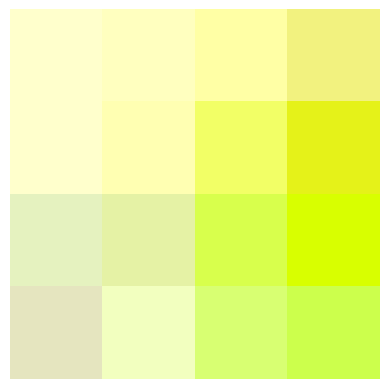

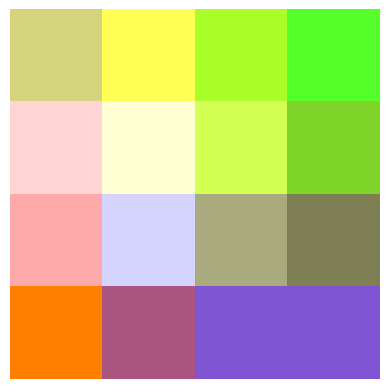

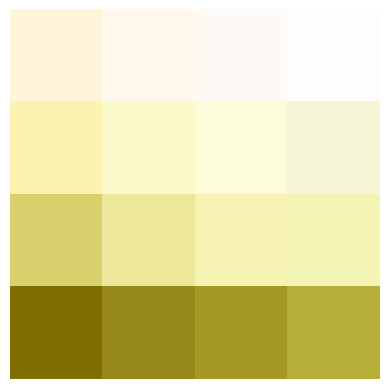

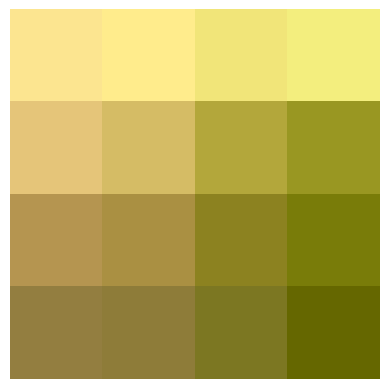

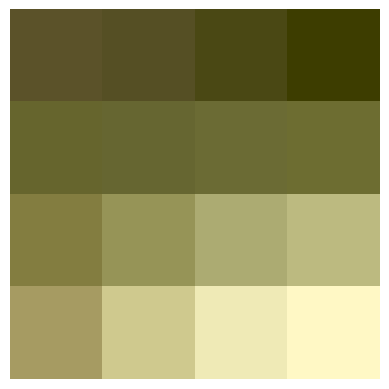

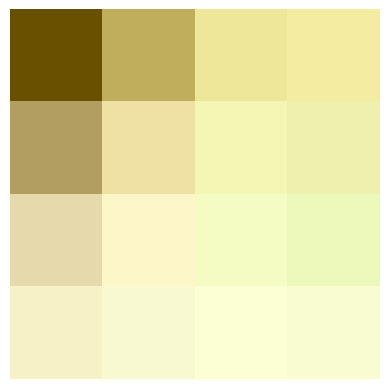

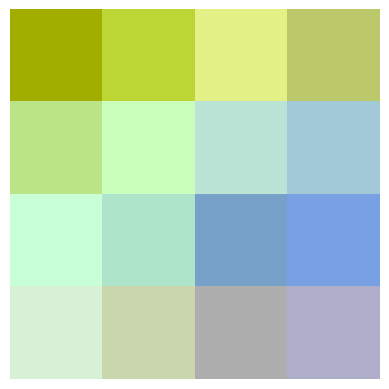

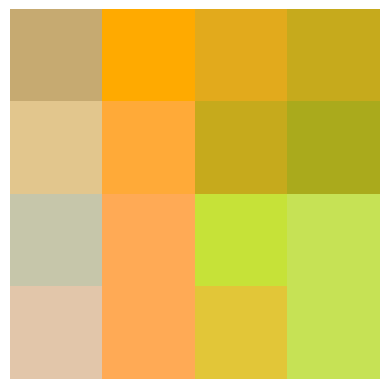

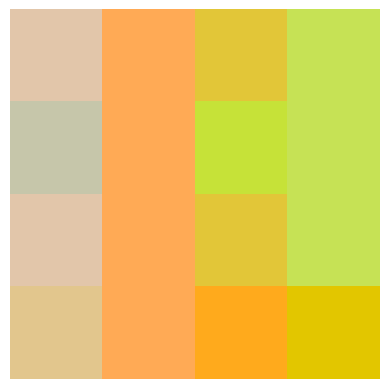

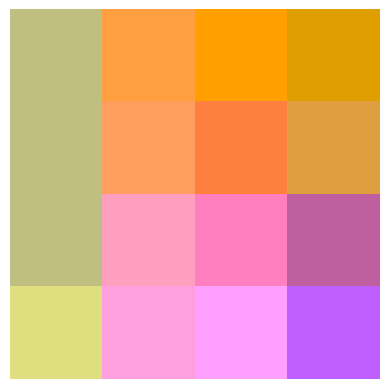

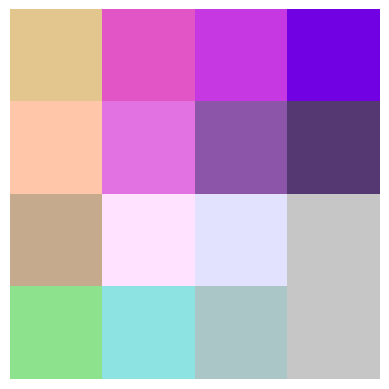

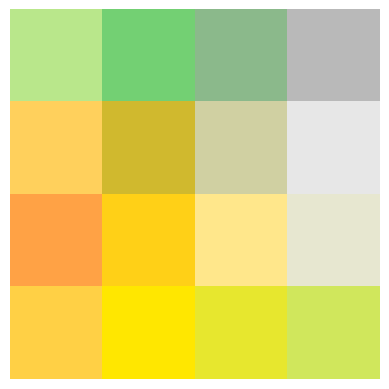

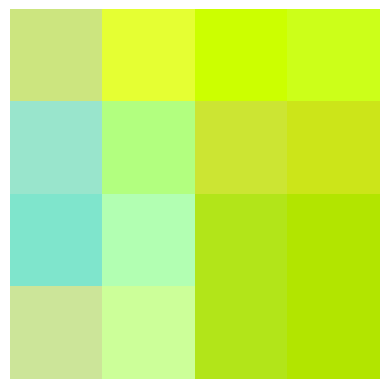

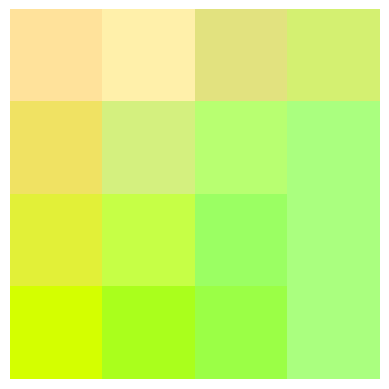

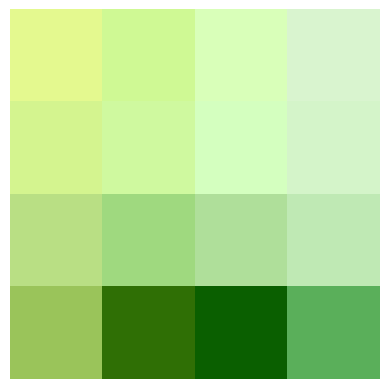

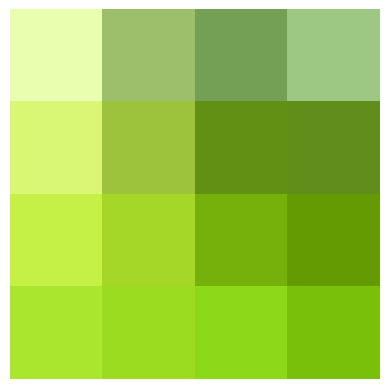

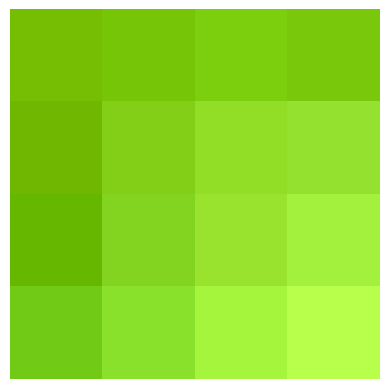

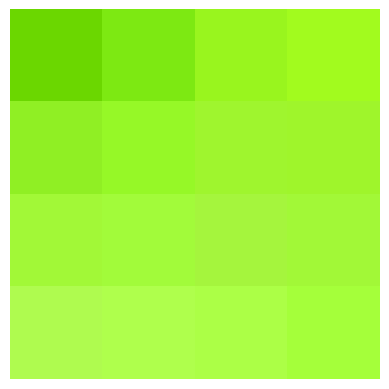

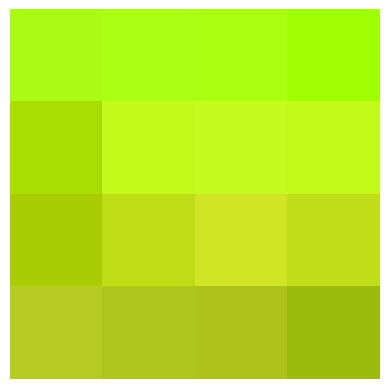

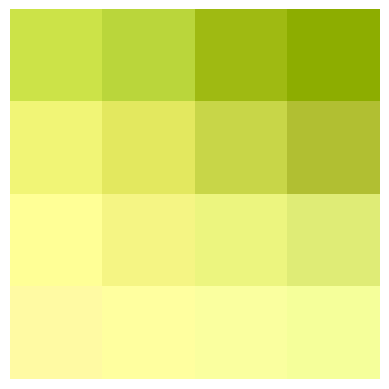

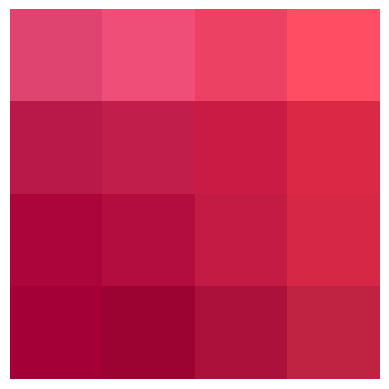

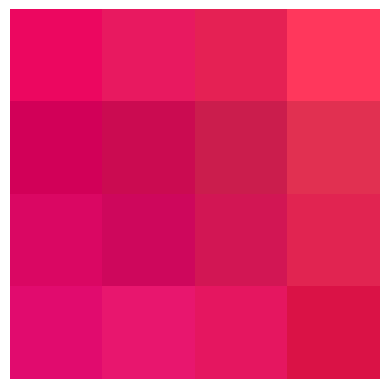

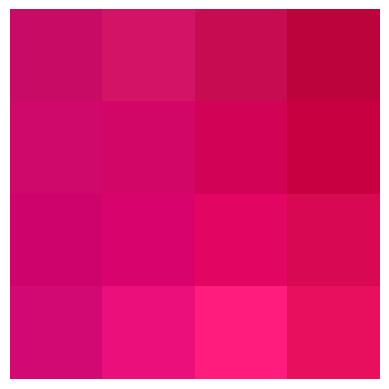

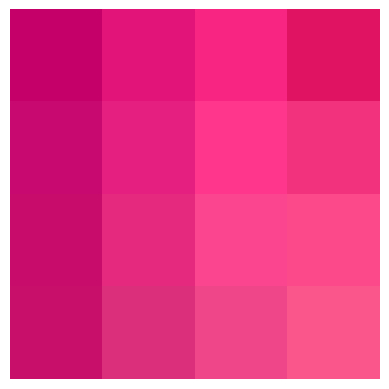

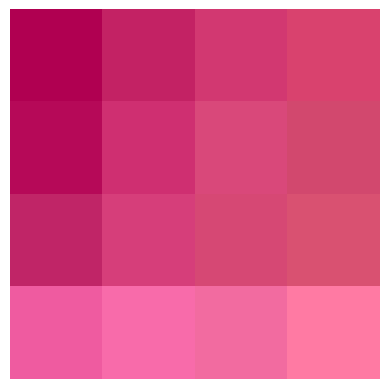

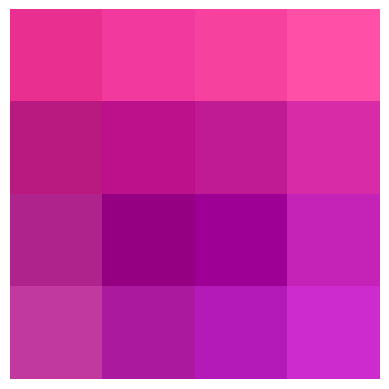

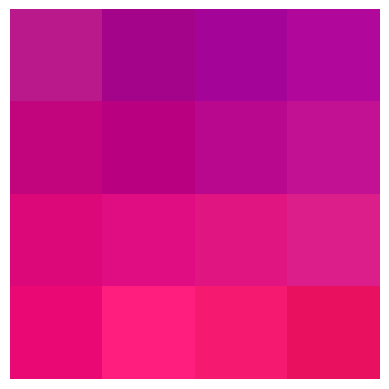

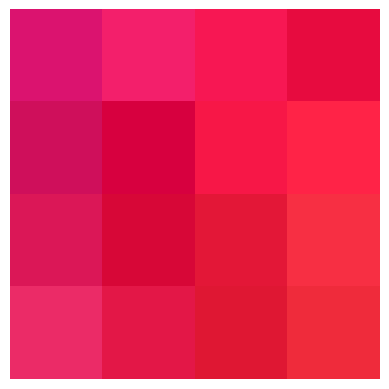

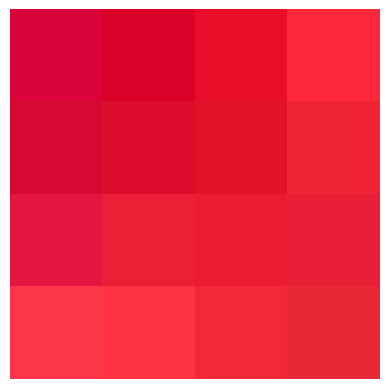

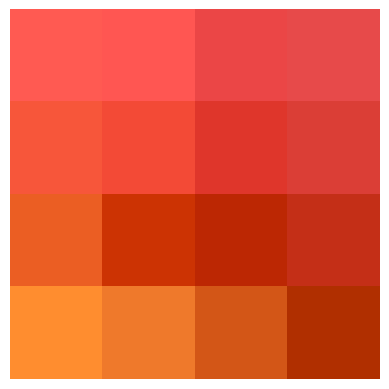

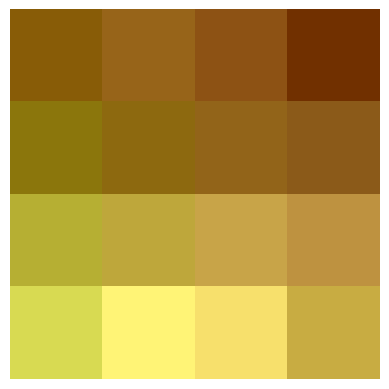

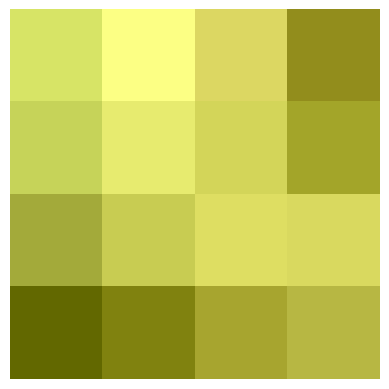

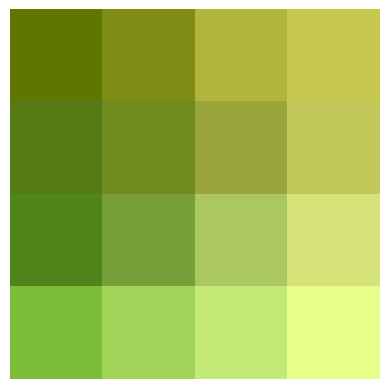

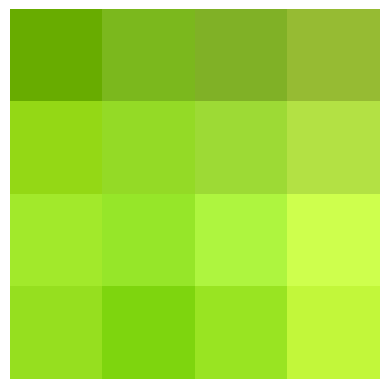

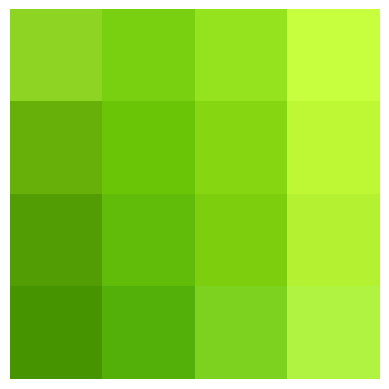

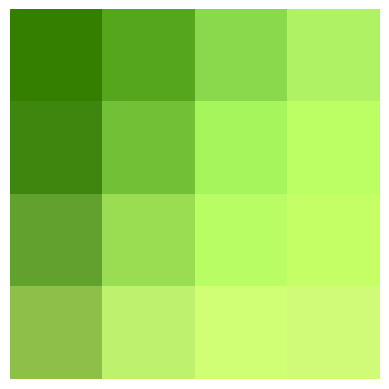

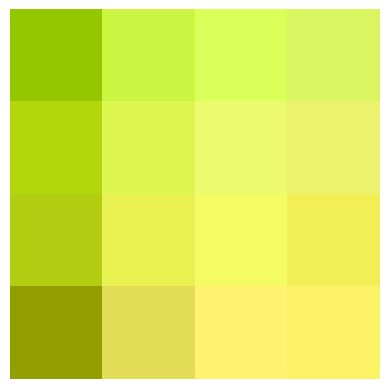

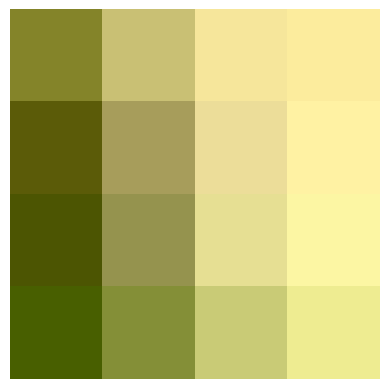

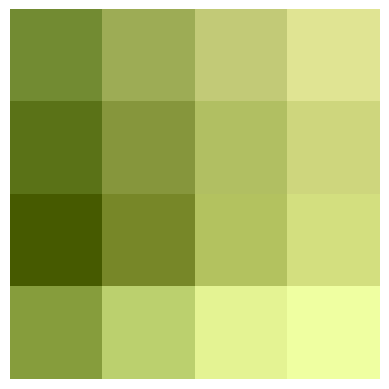

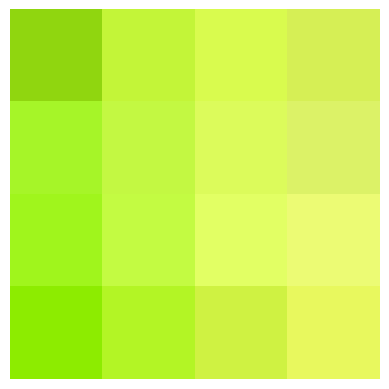

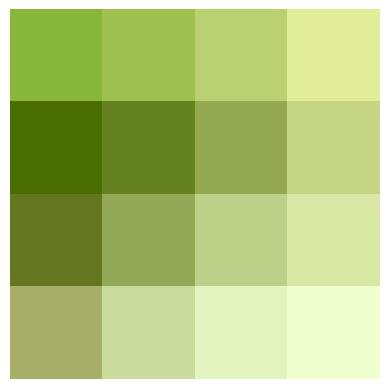

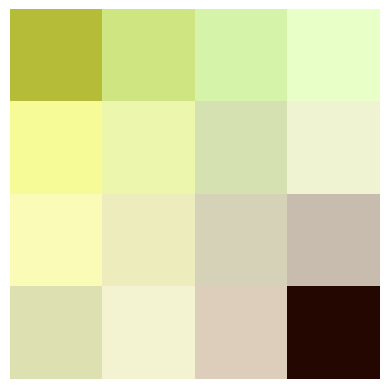

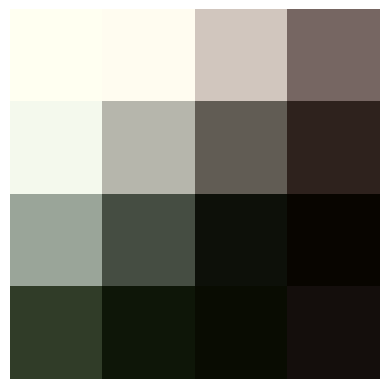

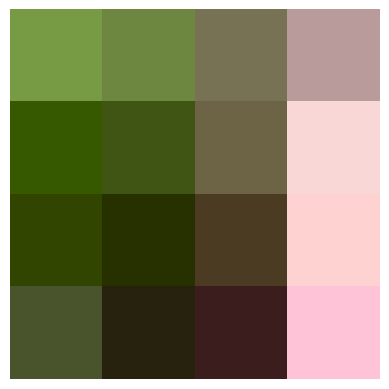

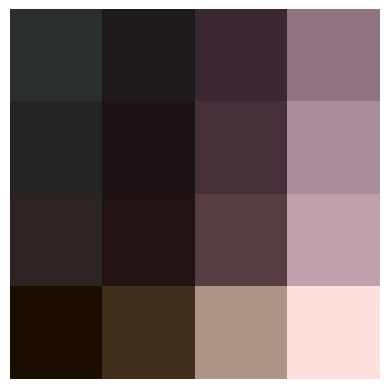

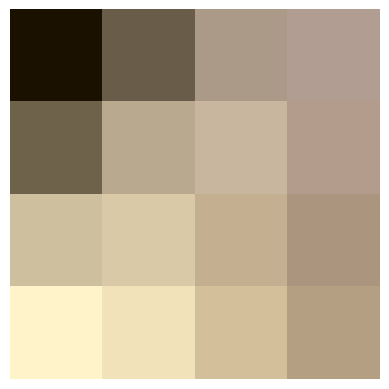

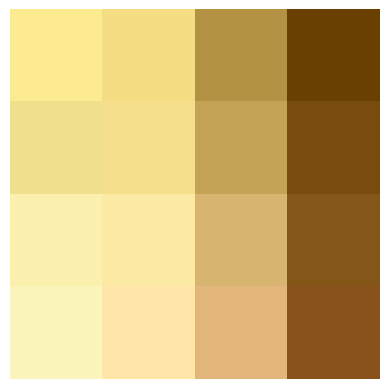

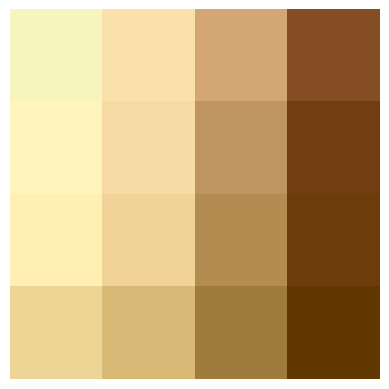

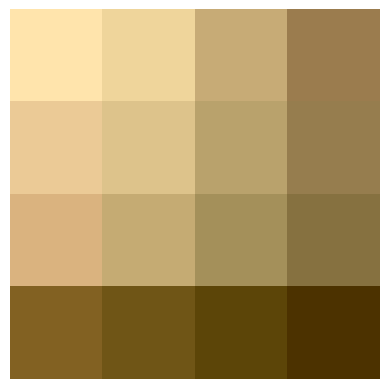

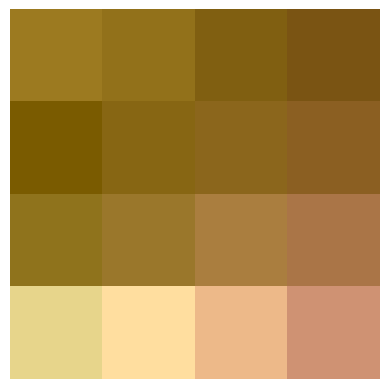

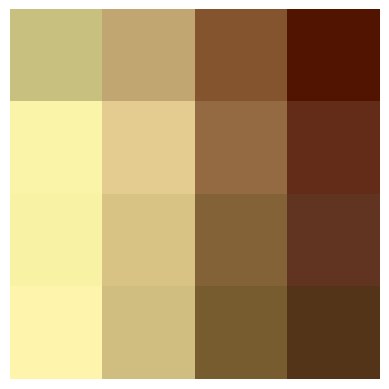

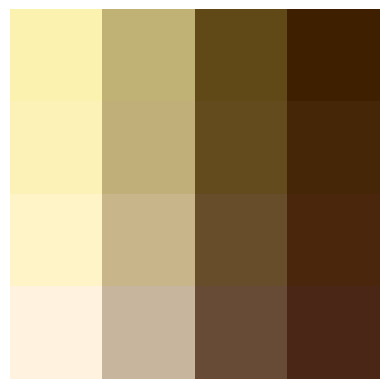

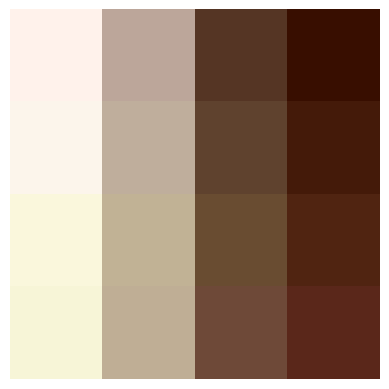

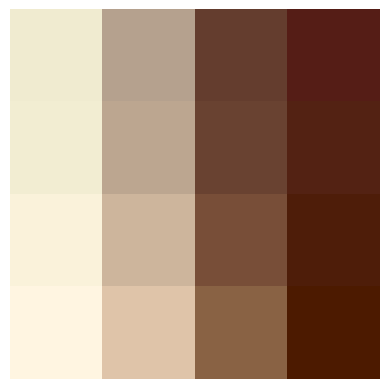

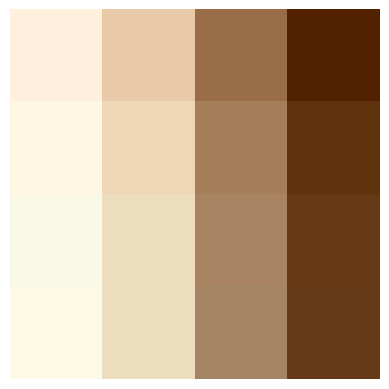

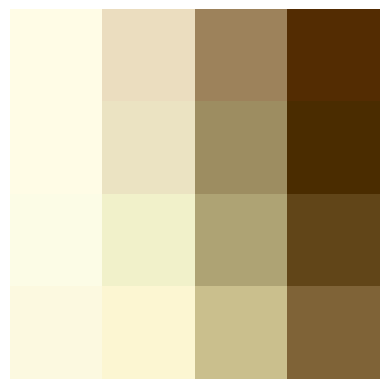

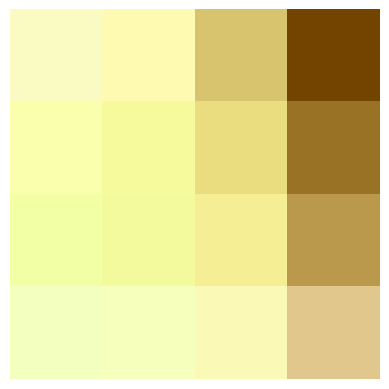

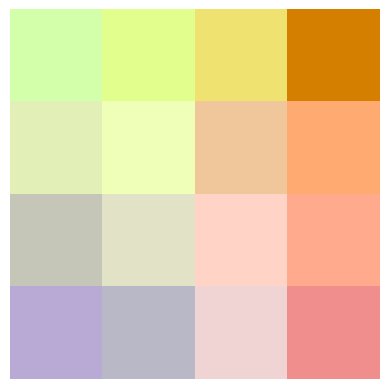

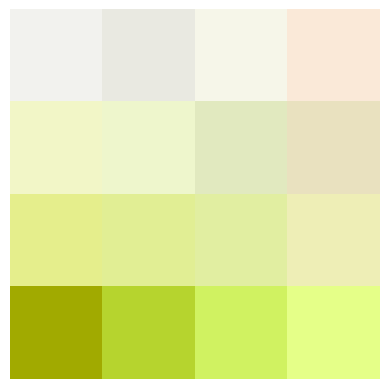

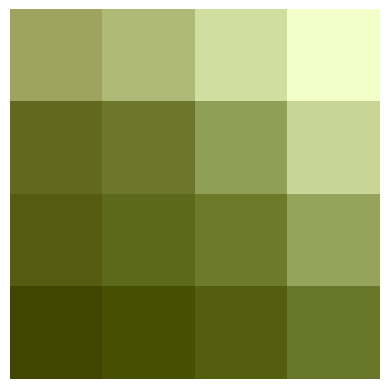

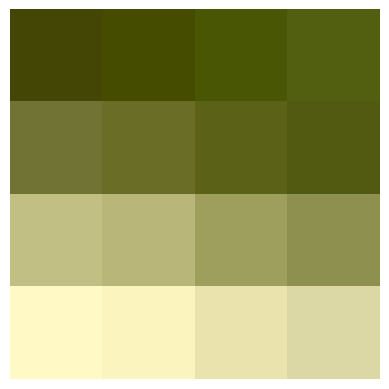

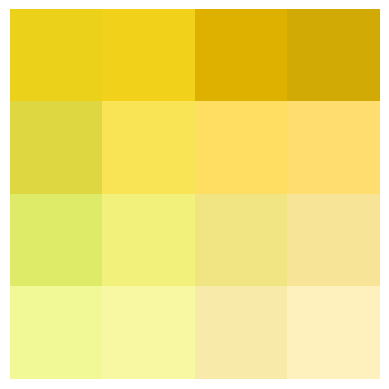

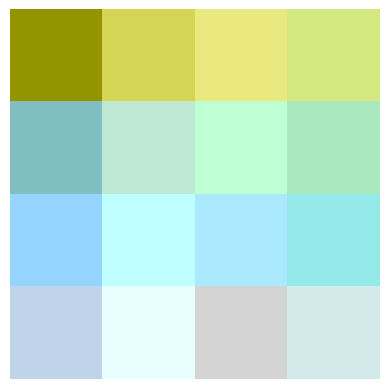

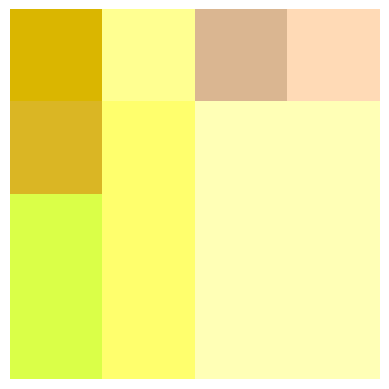

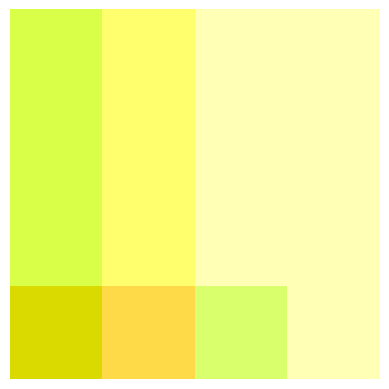

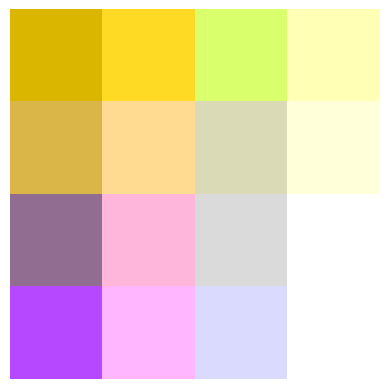

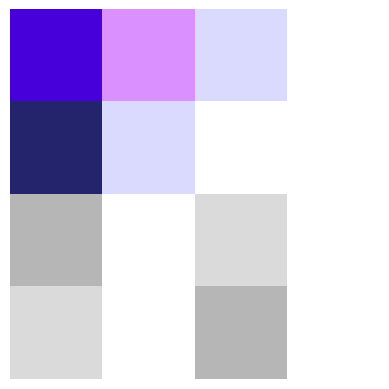

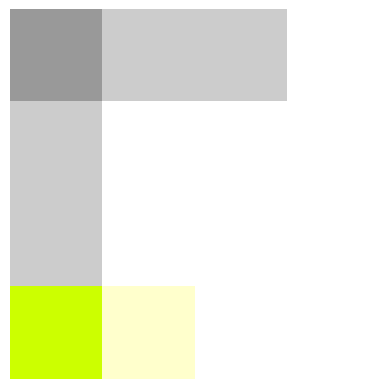

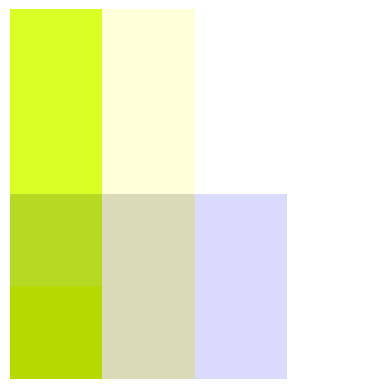

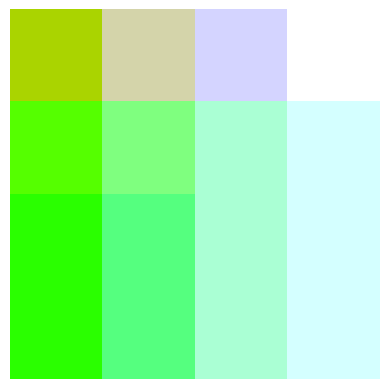

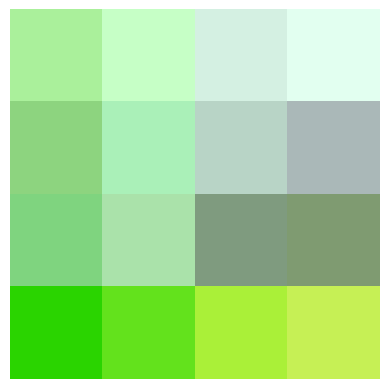

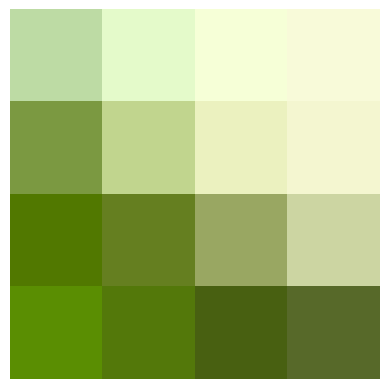

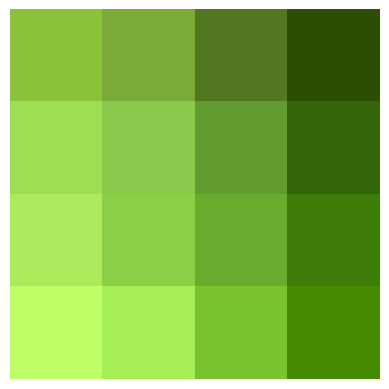

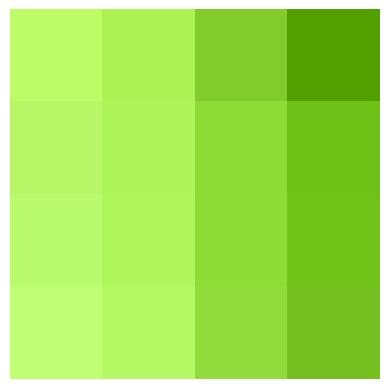

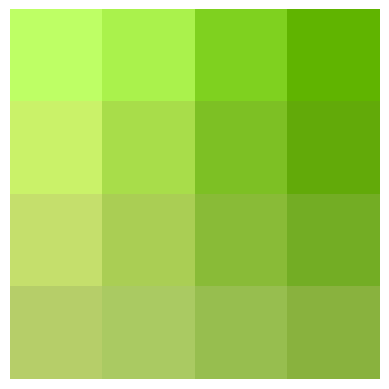

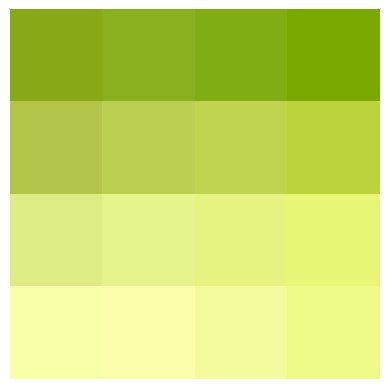

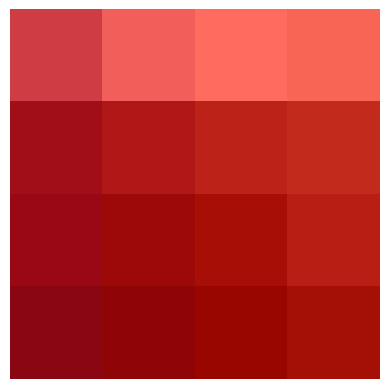

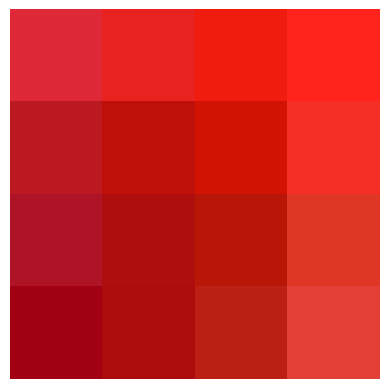

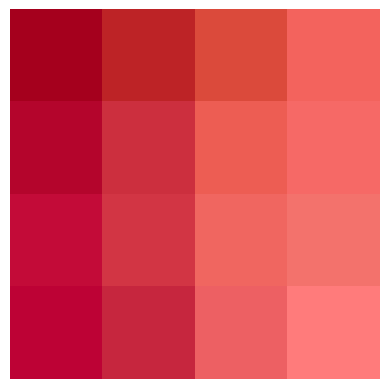

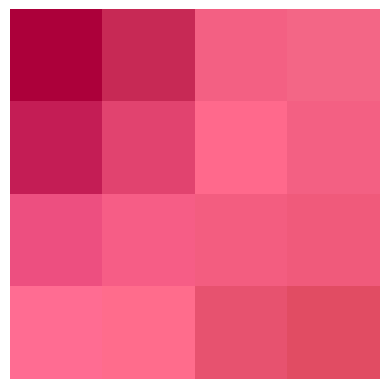

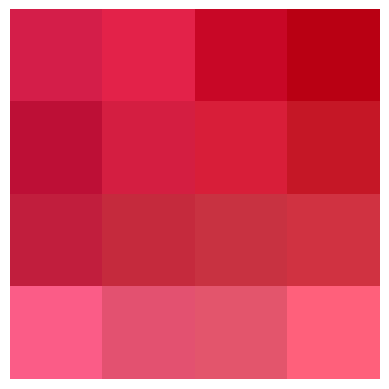

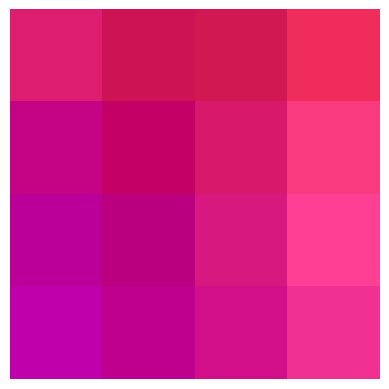

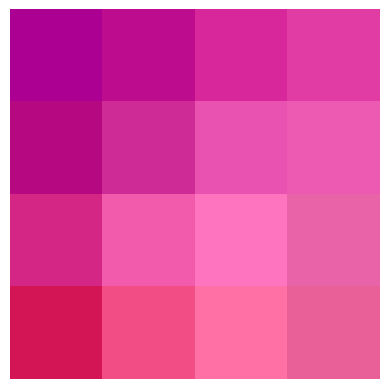

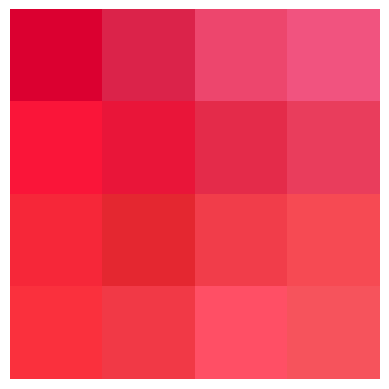

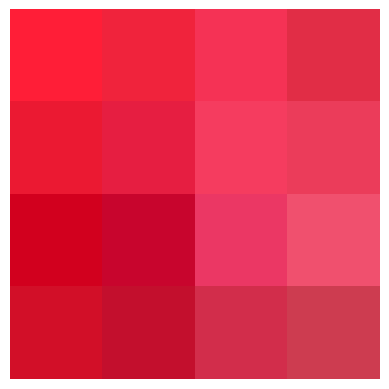

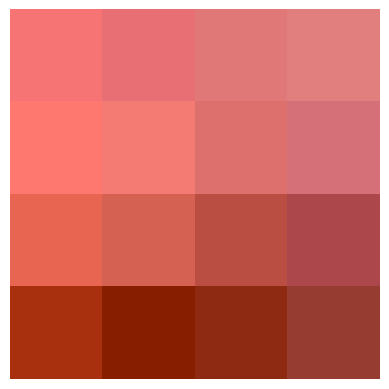

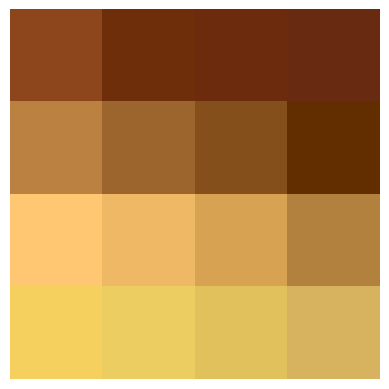

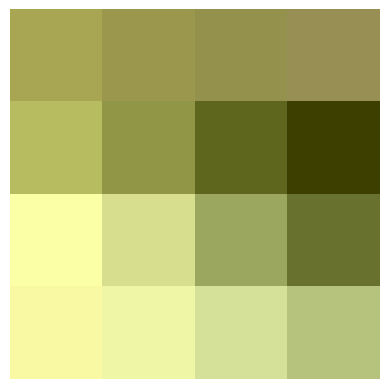

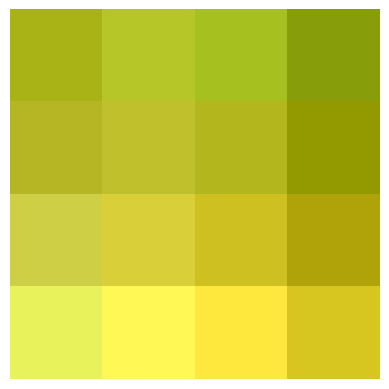

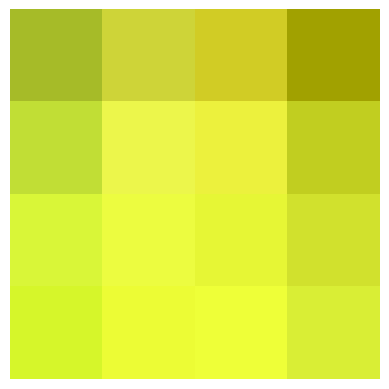

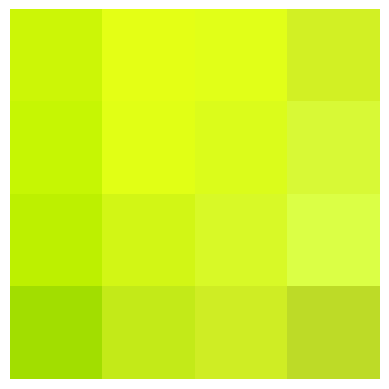

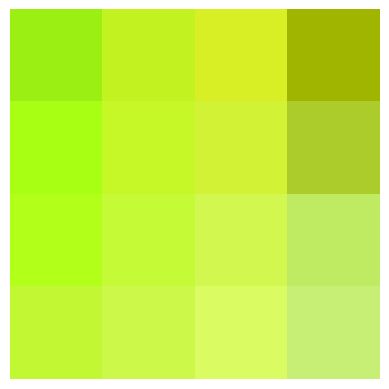

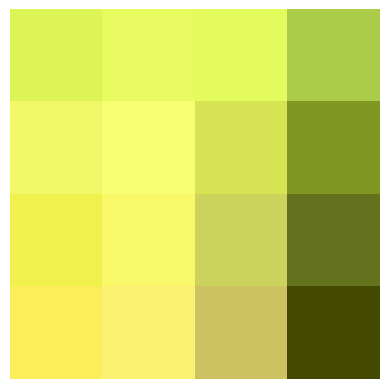

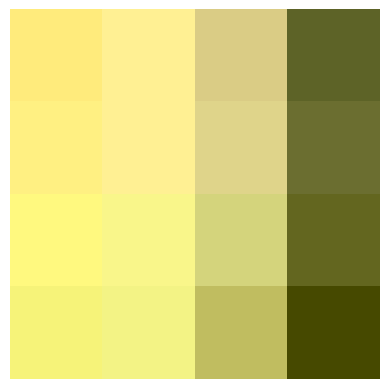

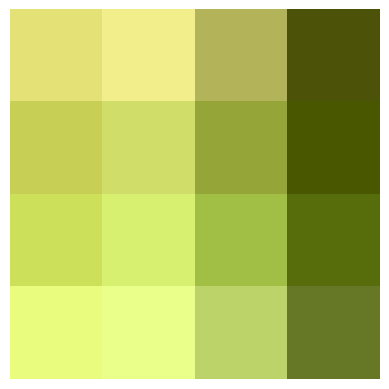

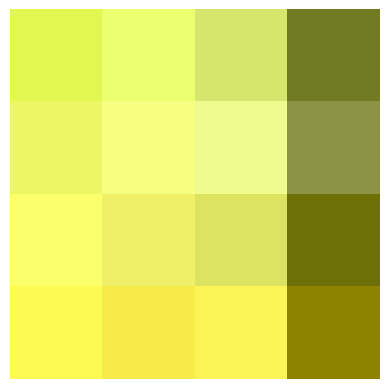

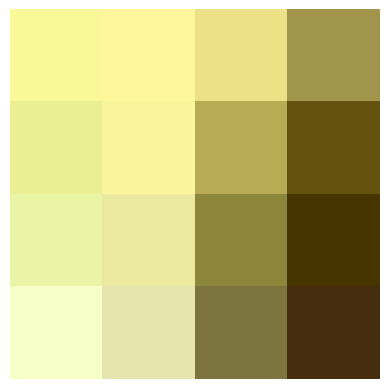

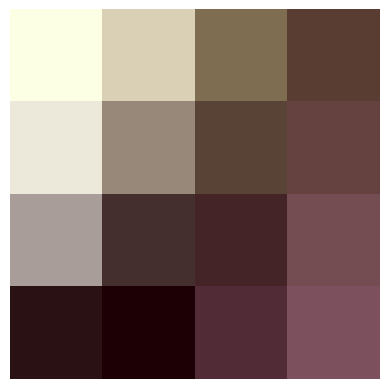

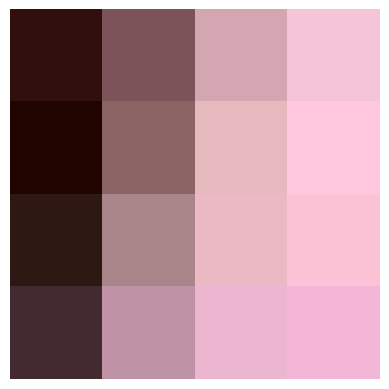

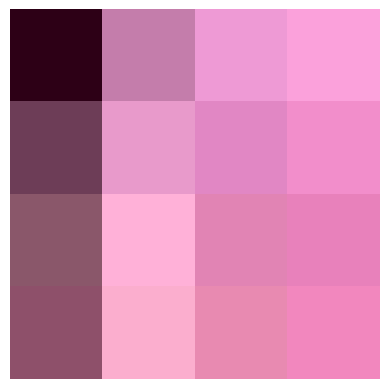

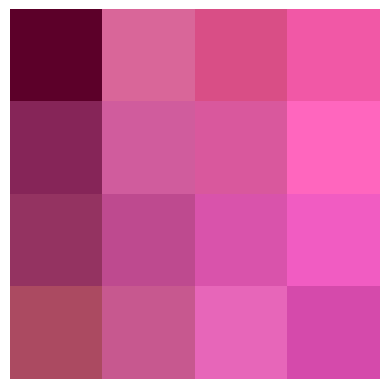

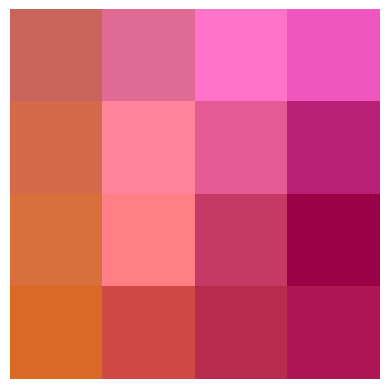

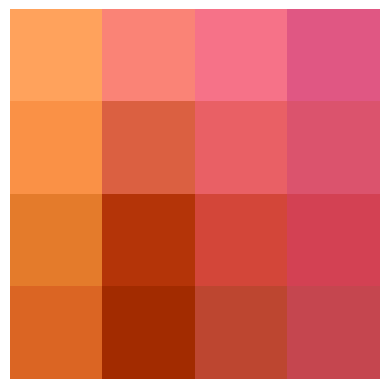

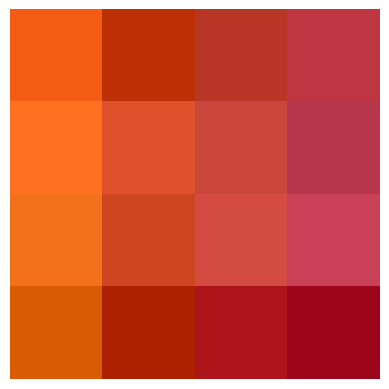

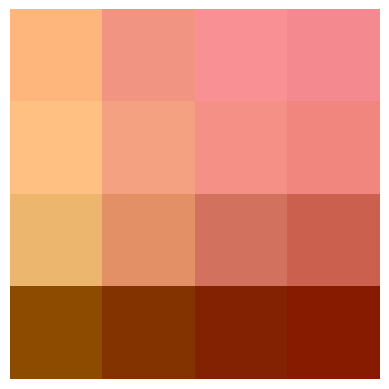

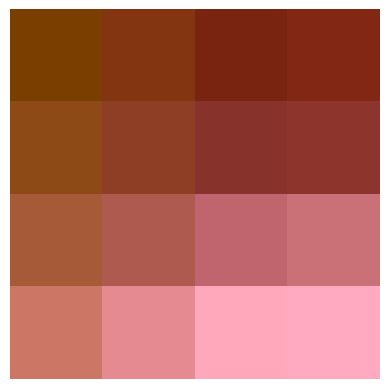

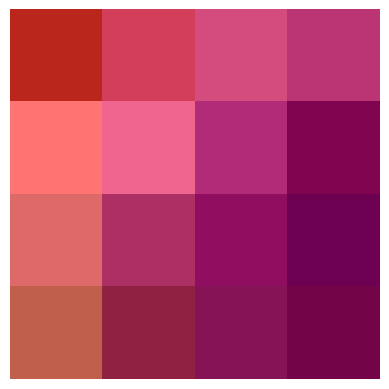

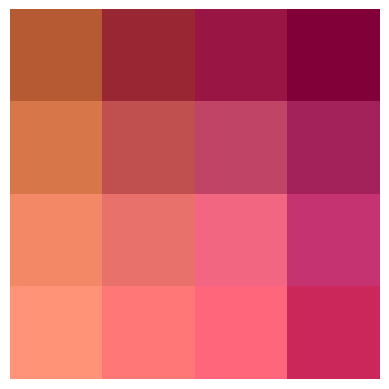

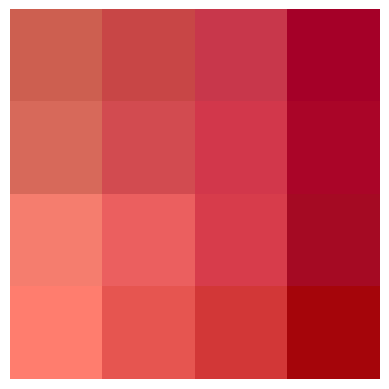

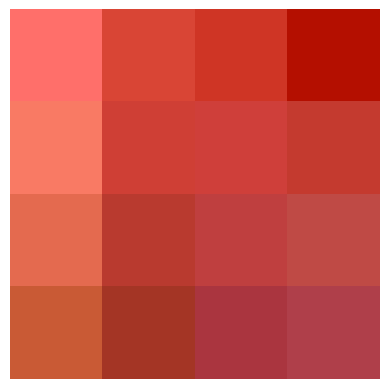

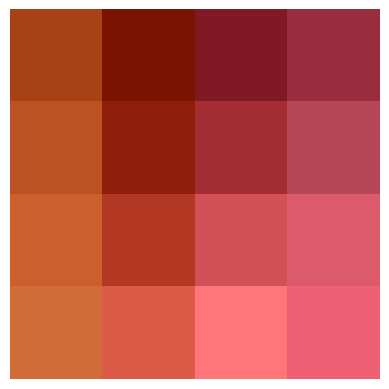

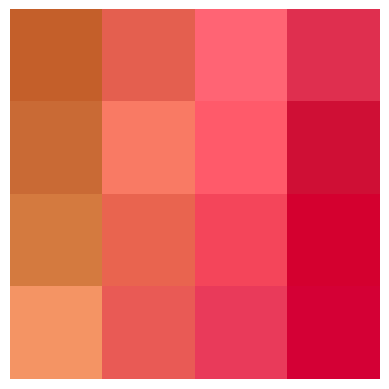

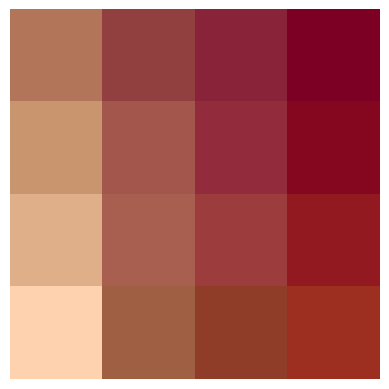

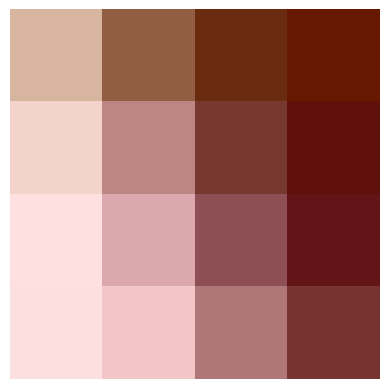

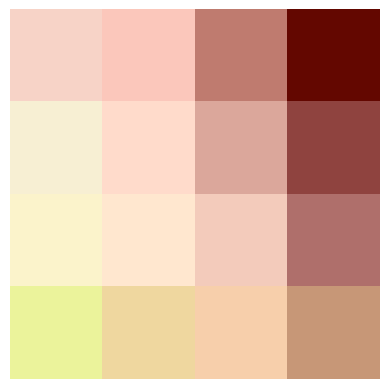

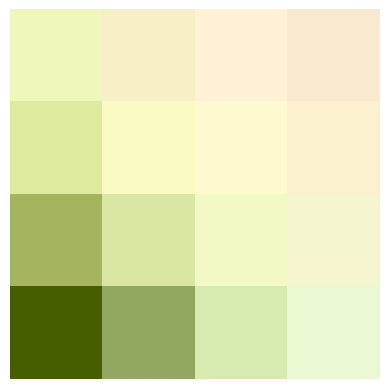

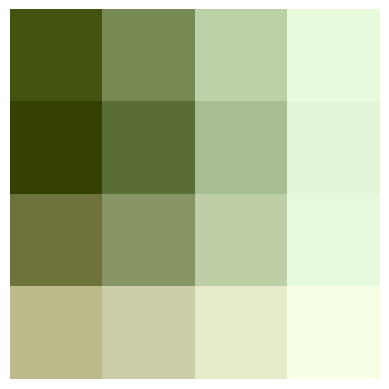

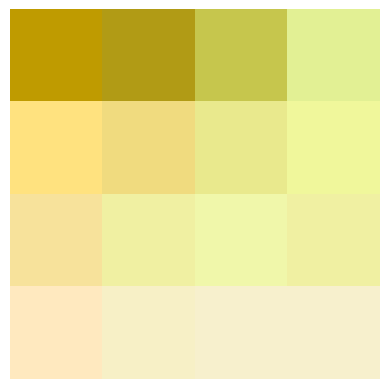

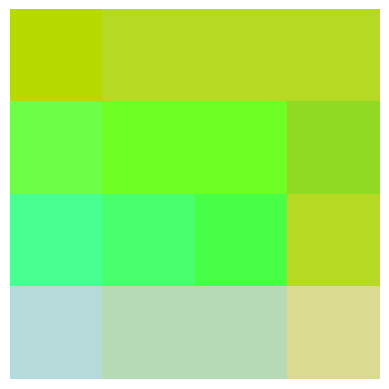

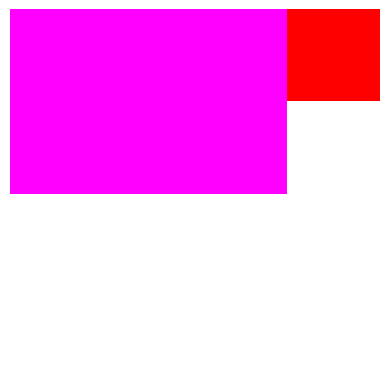

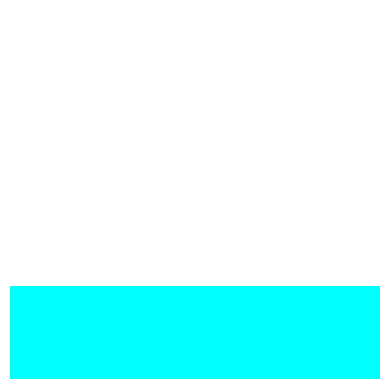

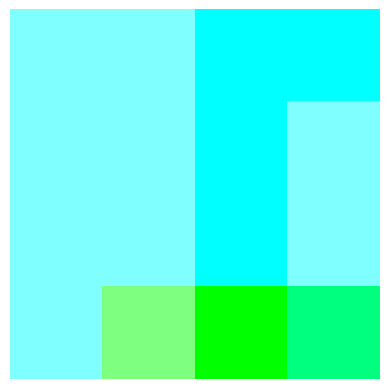

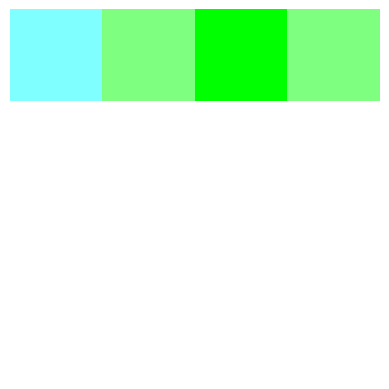

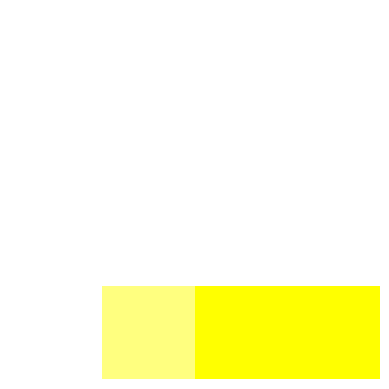

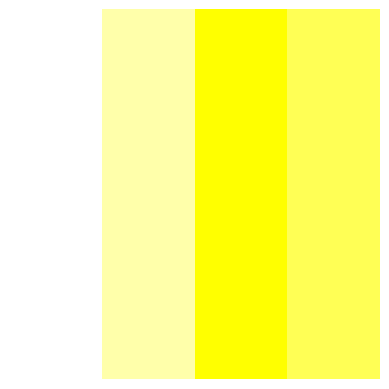

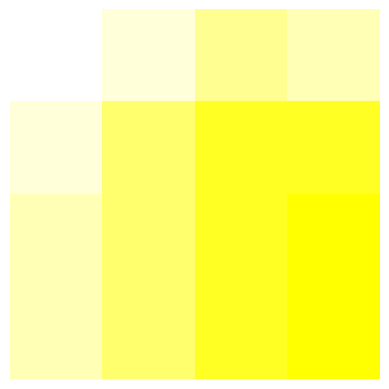

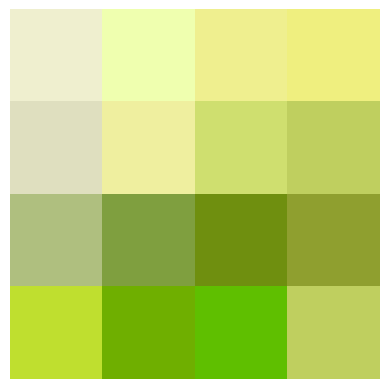

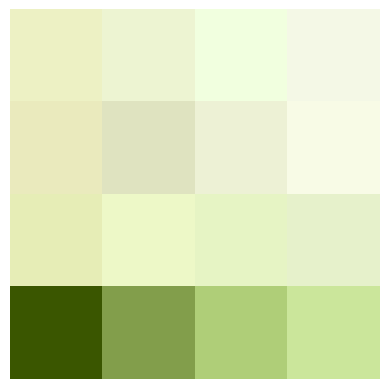

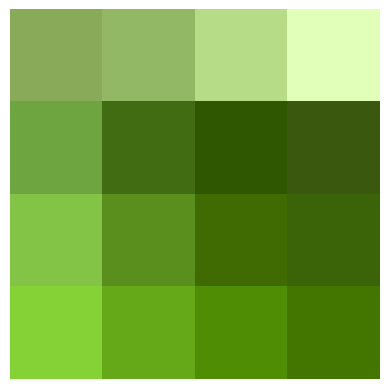

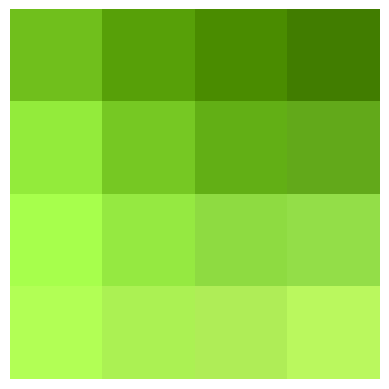

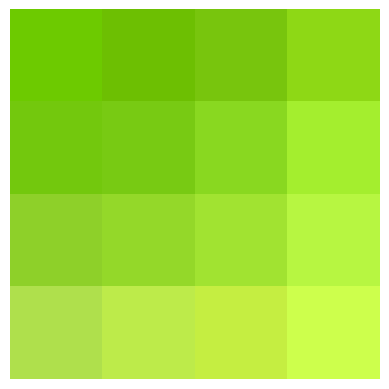

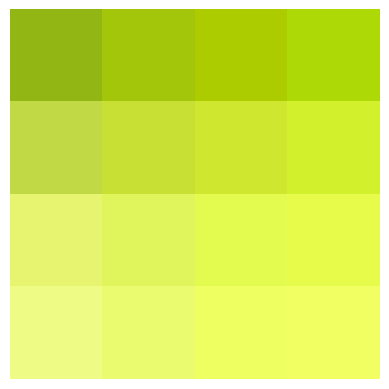

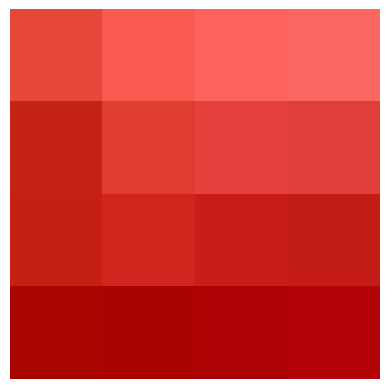

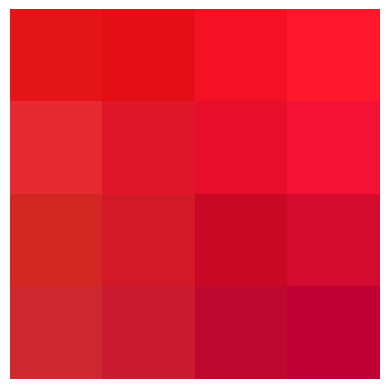

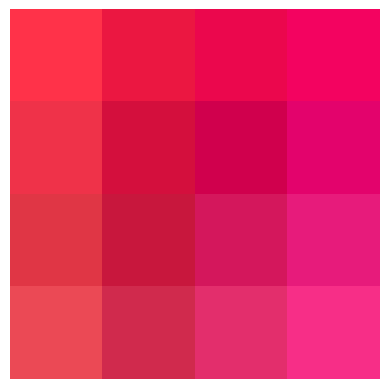

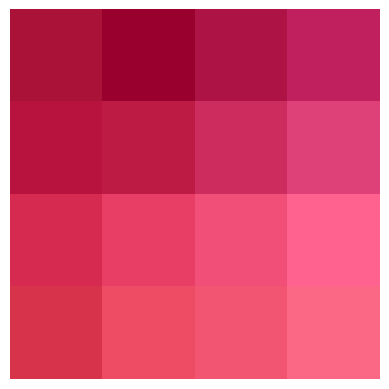

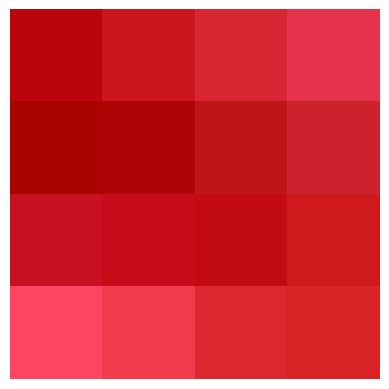

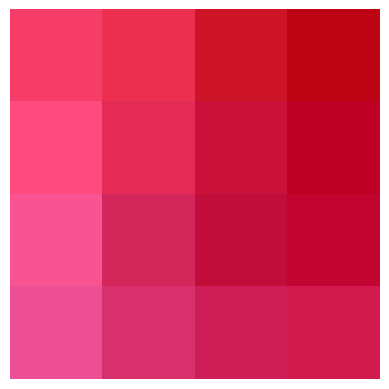

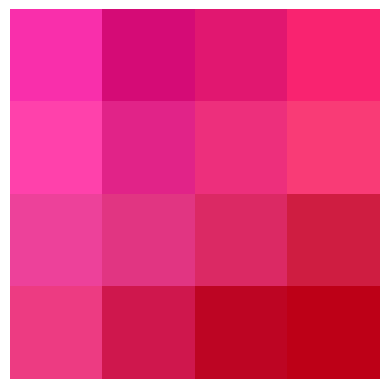

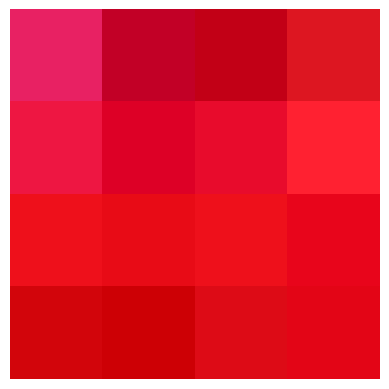

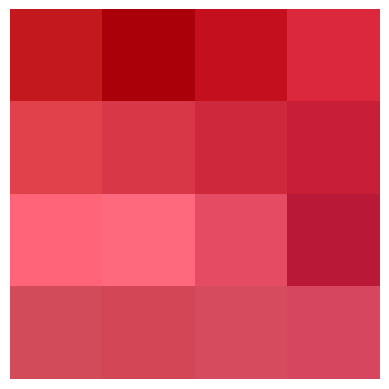

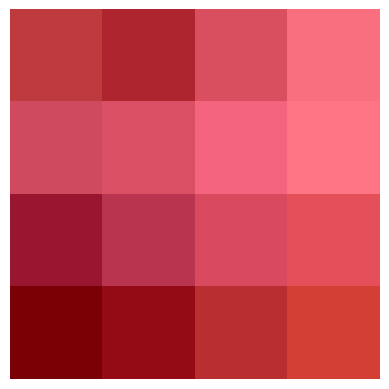

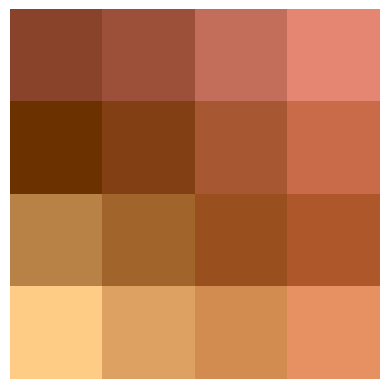

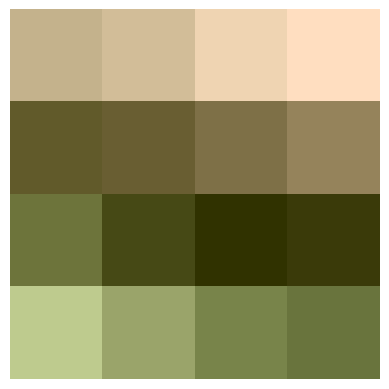

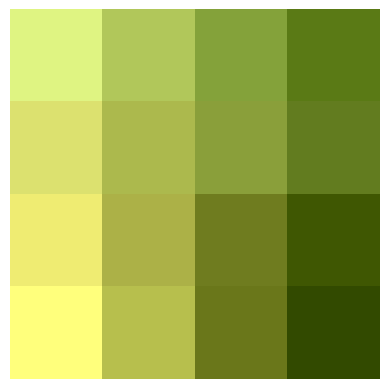

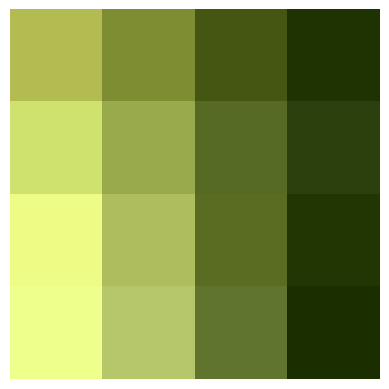

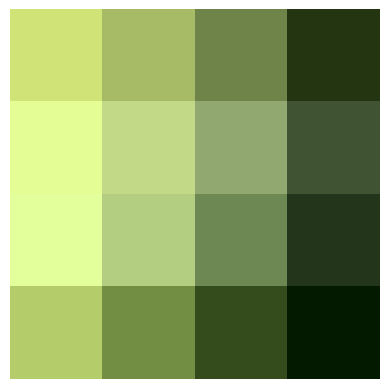

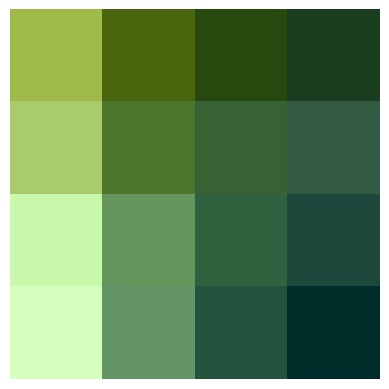

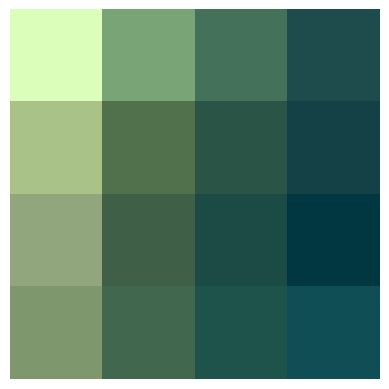

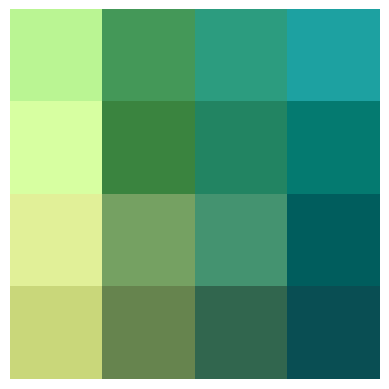

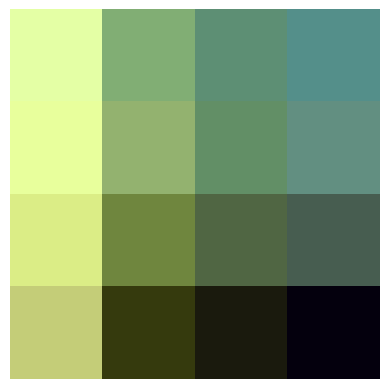

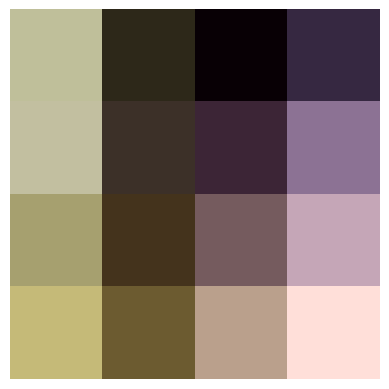

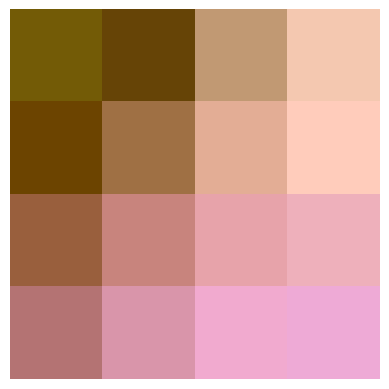

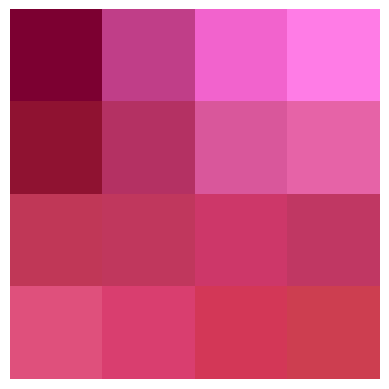

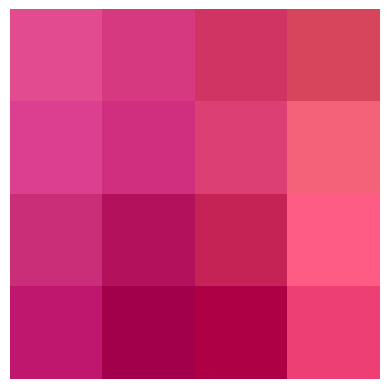

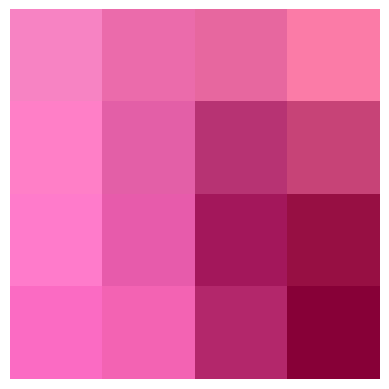

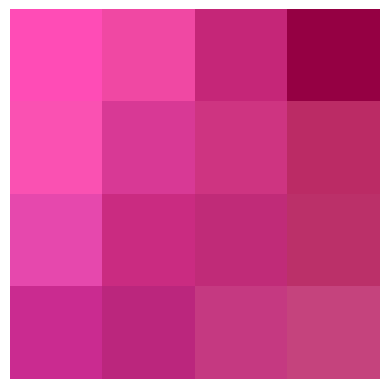

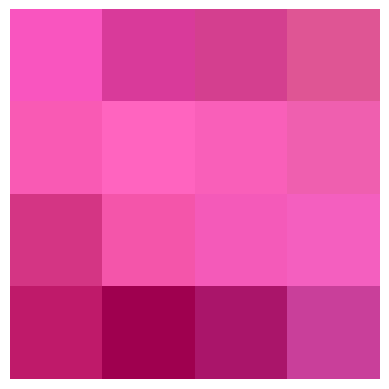

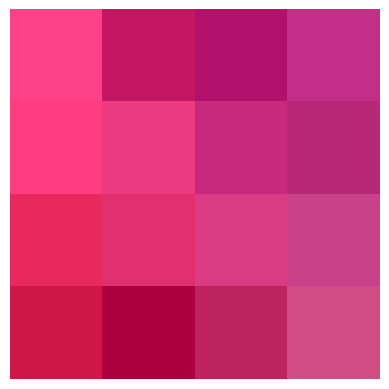

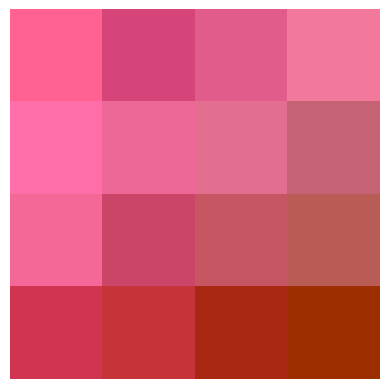

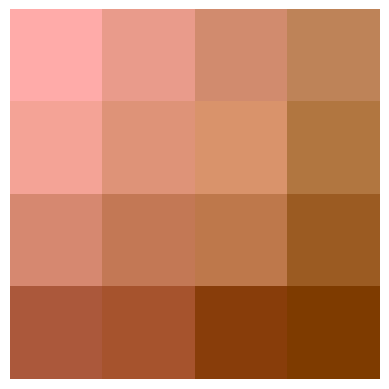

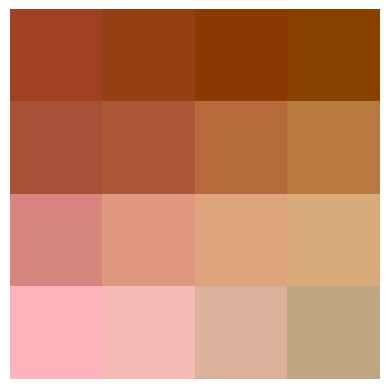

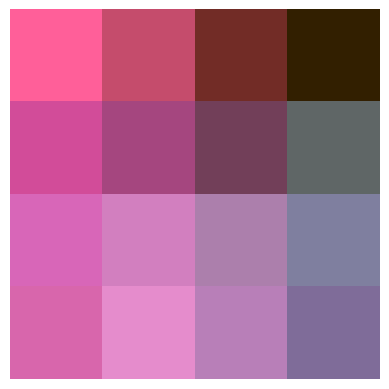

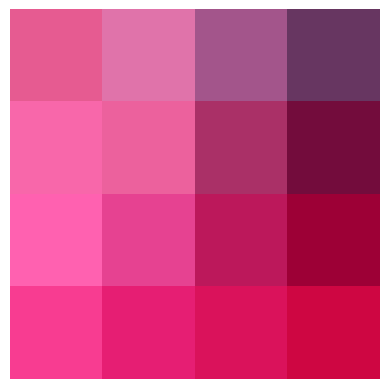

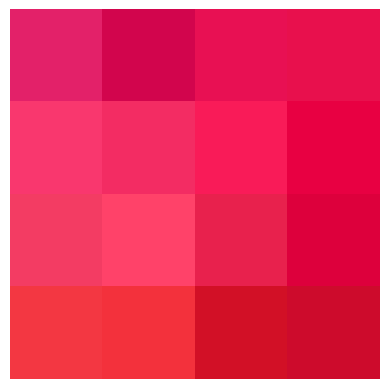

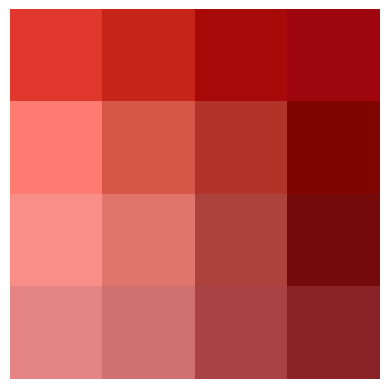

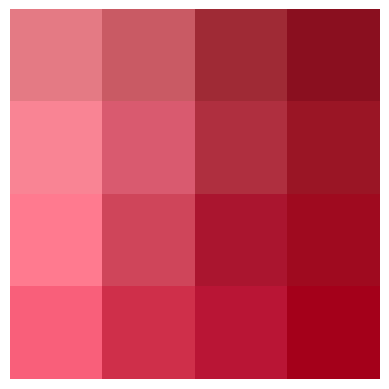

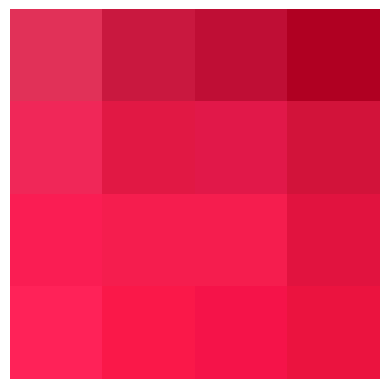

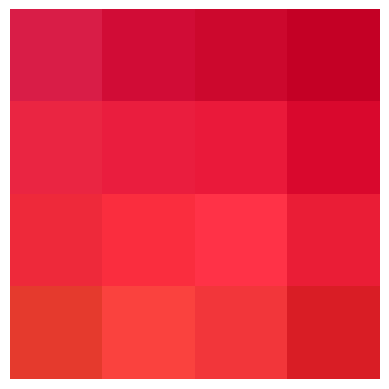

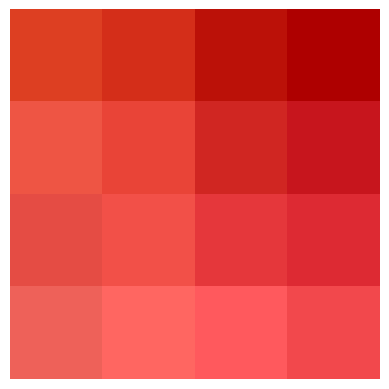

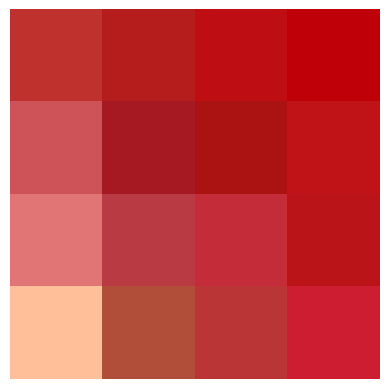

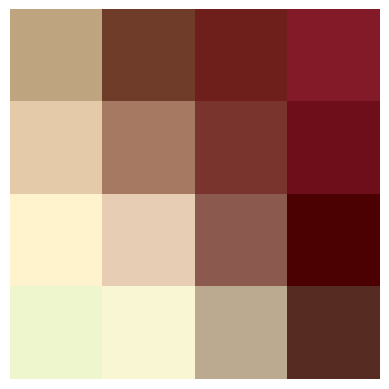

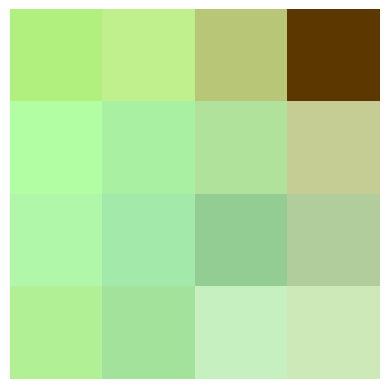

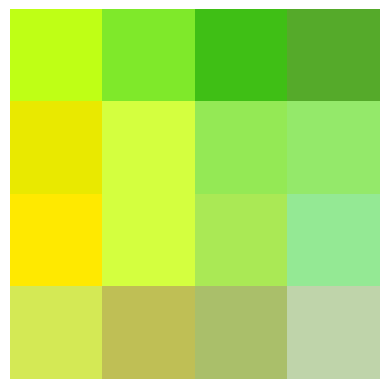

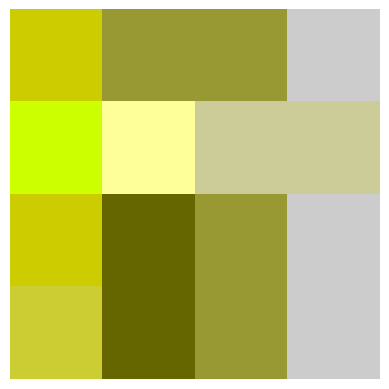

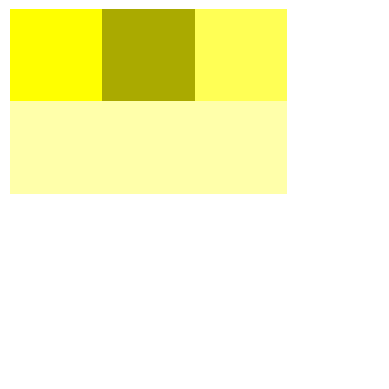

<ipython-input-10-1f3b396aa2c4>:16: RuntimeWarning: invalid value encountered in divide
  window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


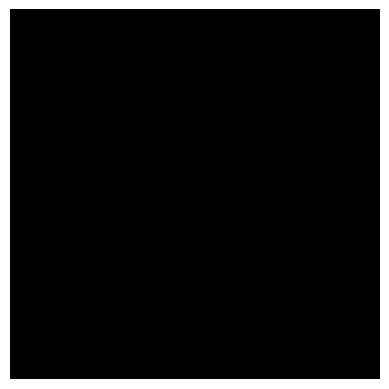

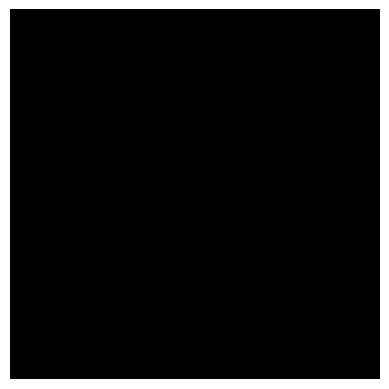

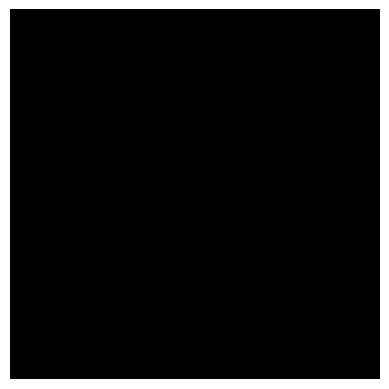

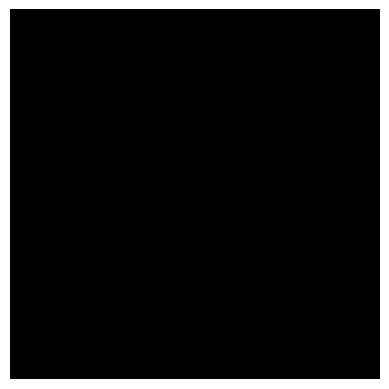

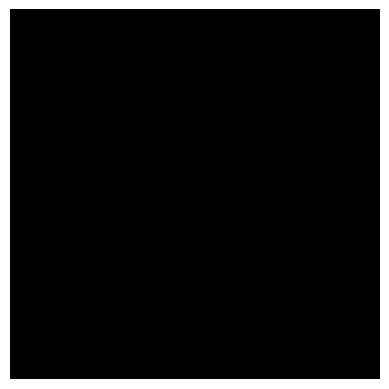

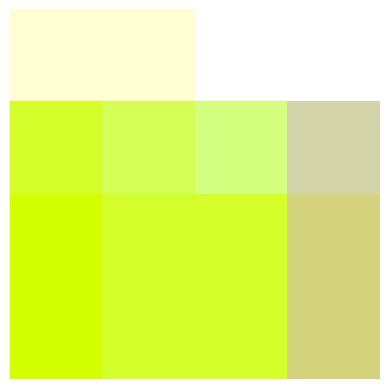

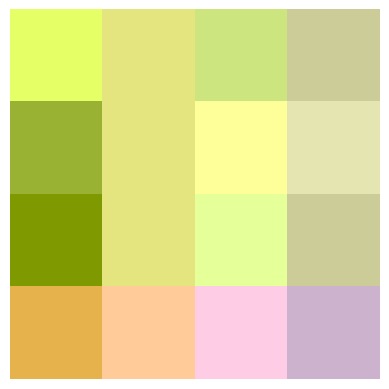

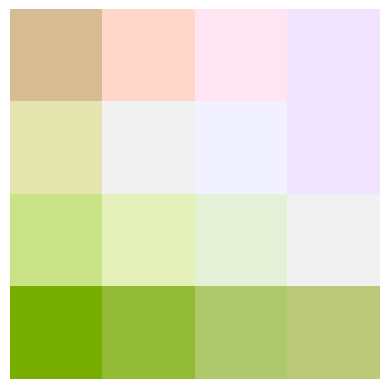

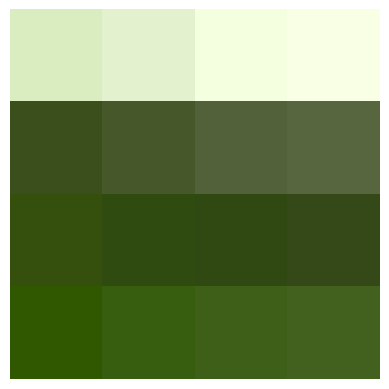

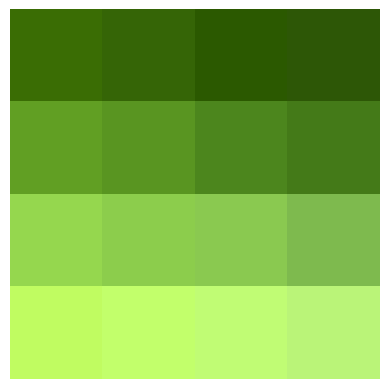

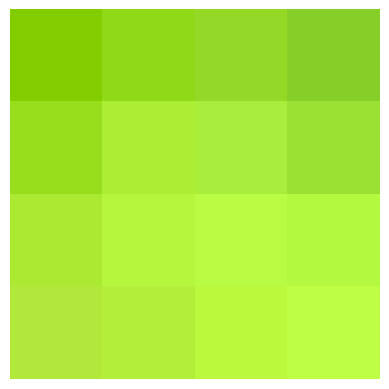

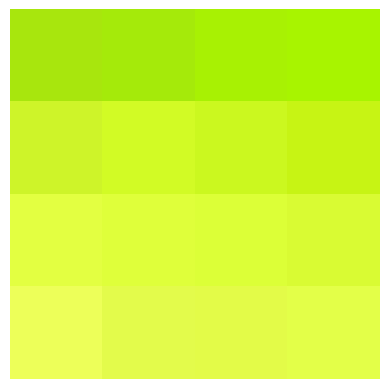

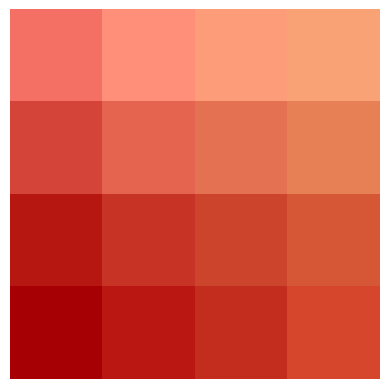

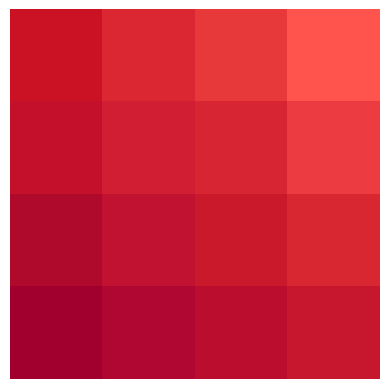

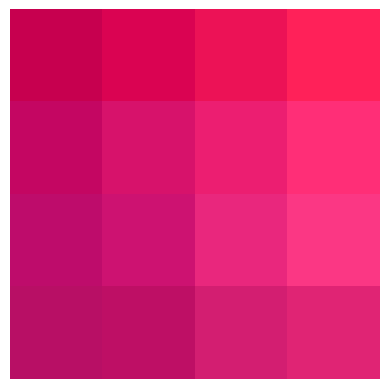

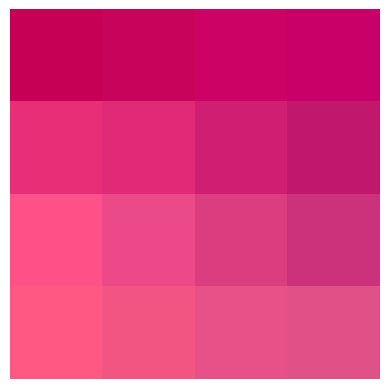

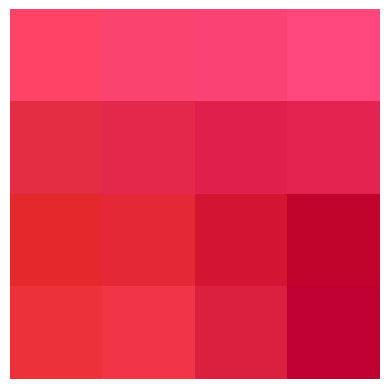

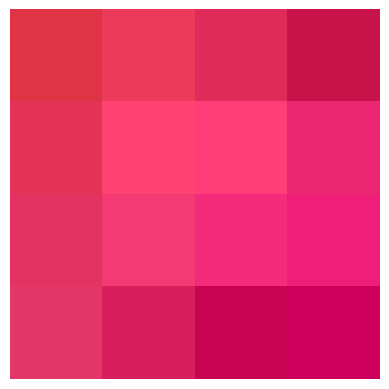

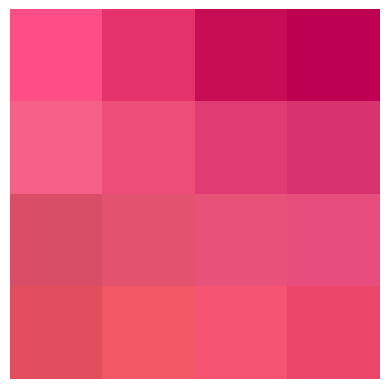

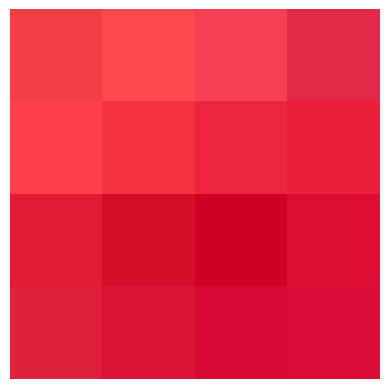

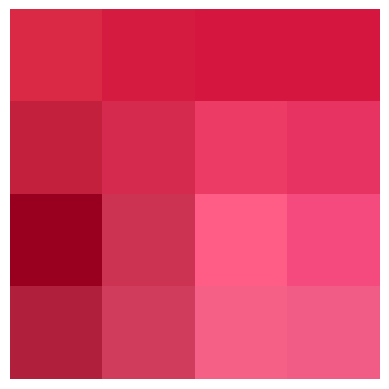

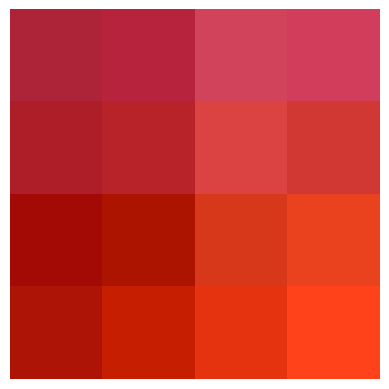

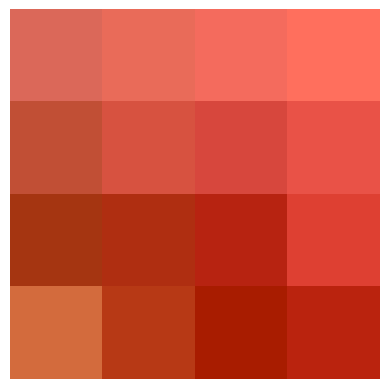

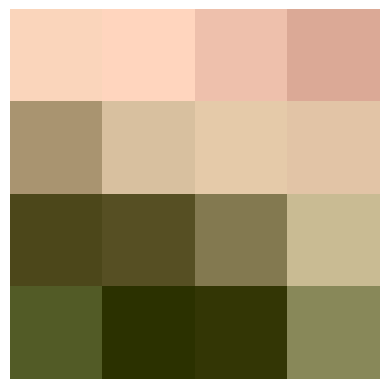

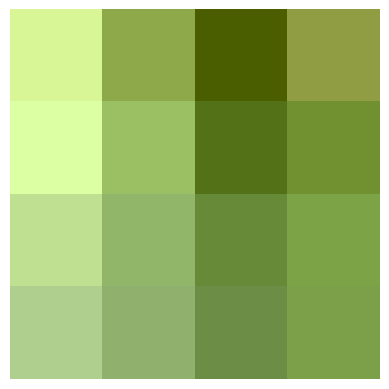

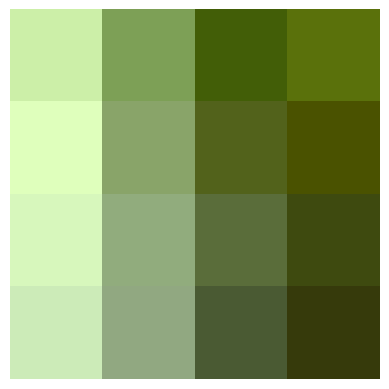

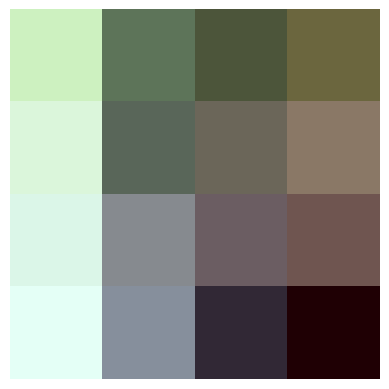

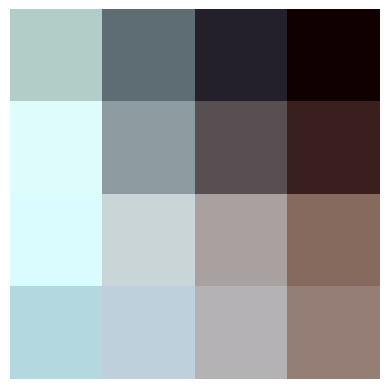

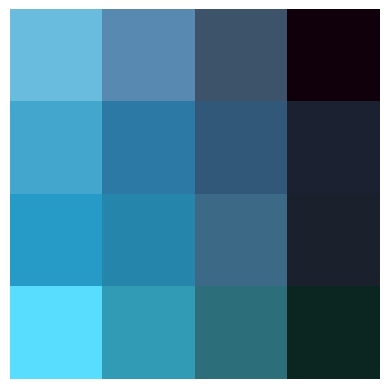

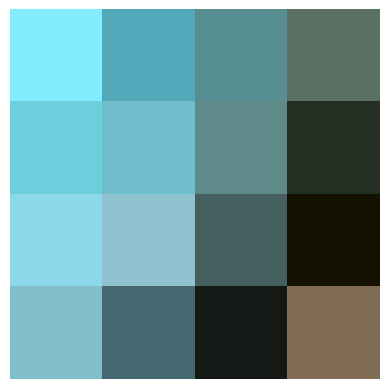

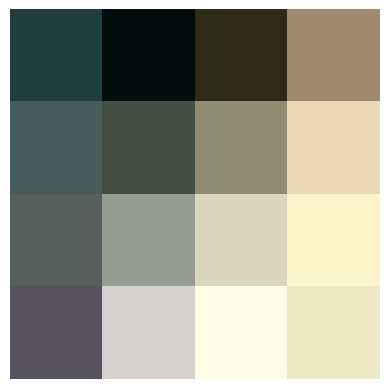

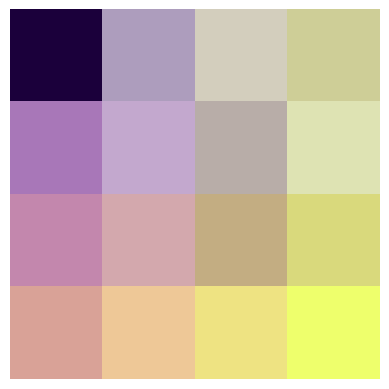

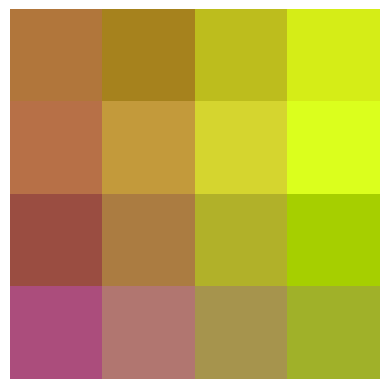

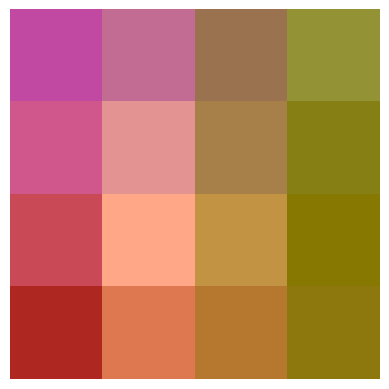

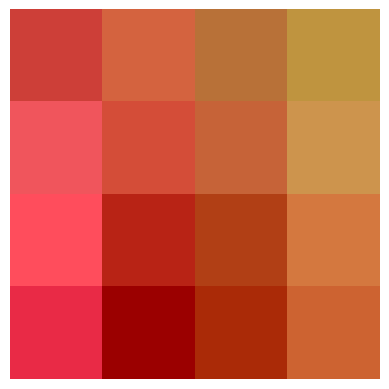

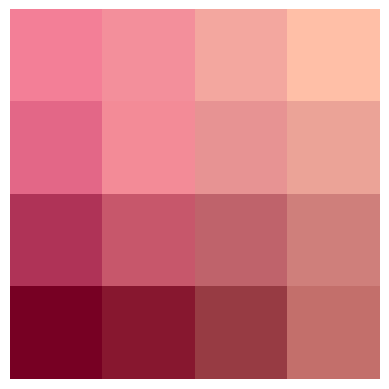

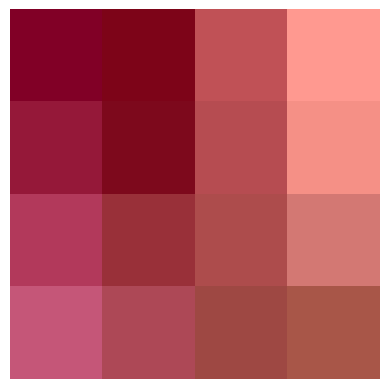

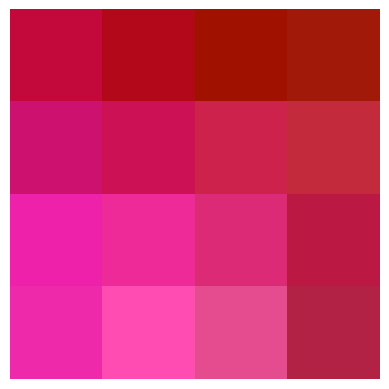

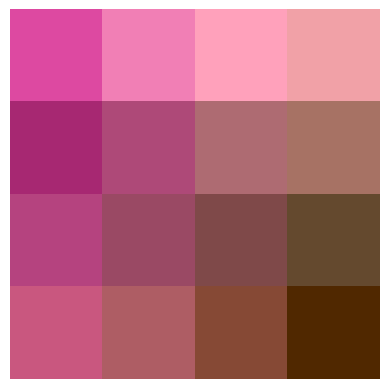

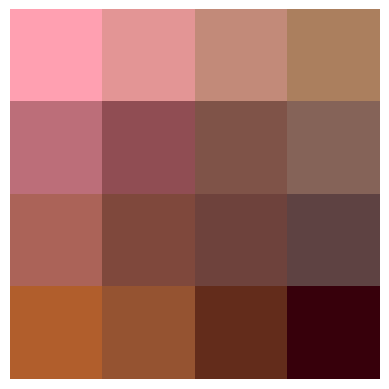

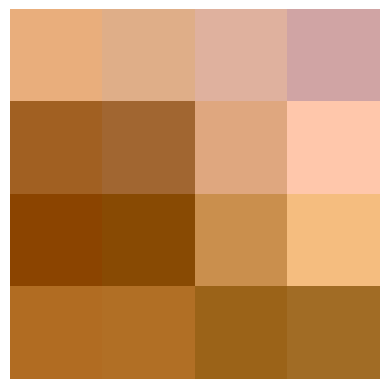

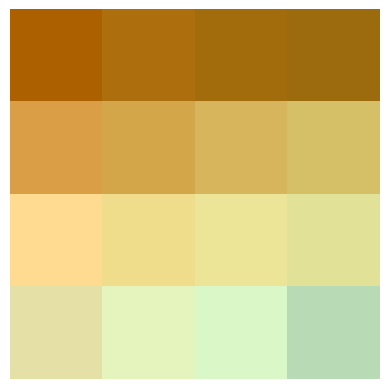

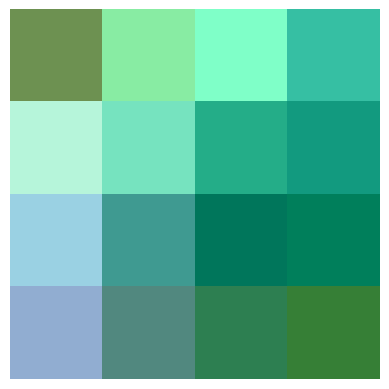

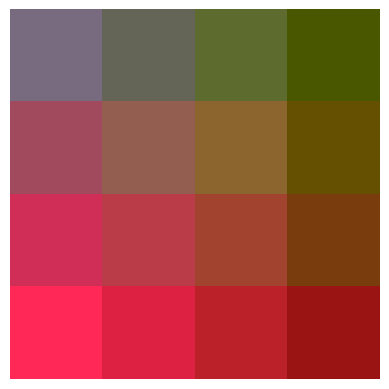

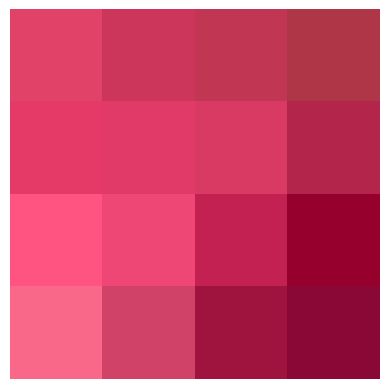

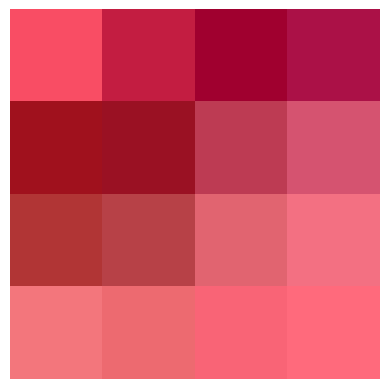

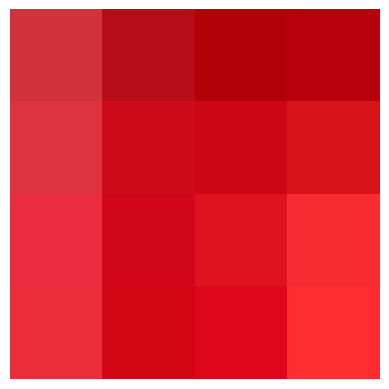

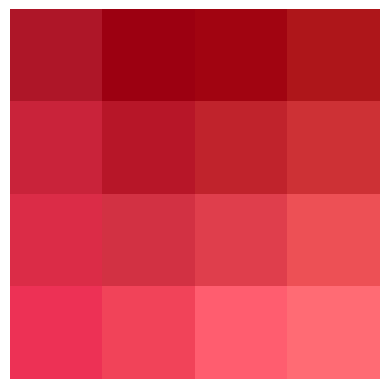

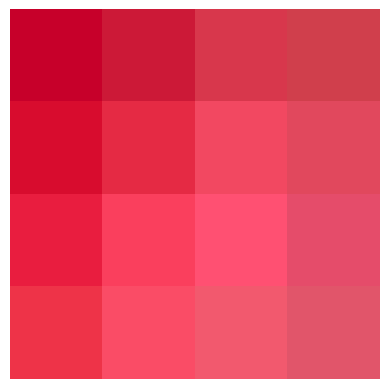

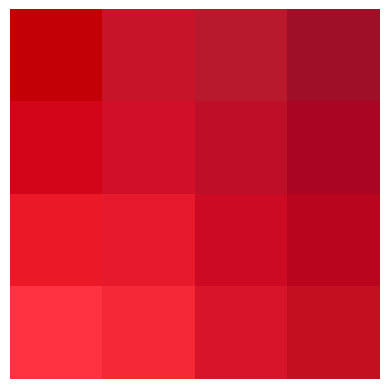

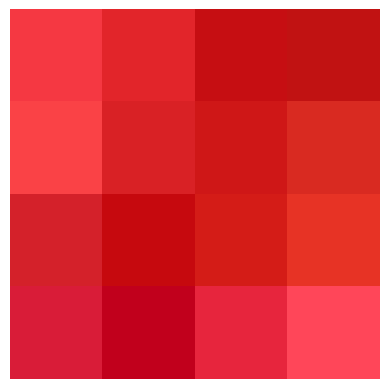

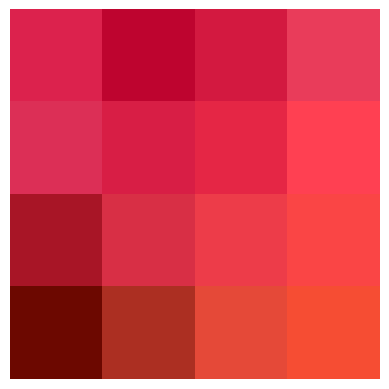

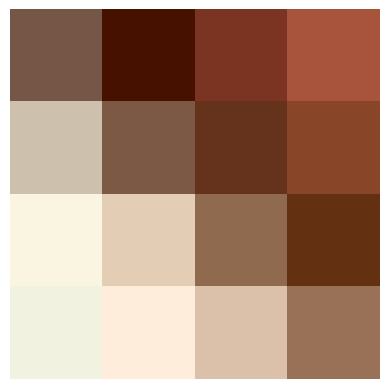

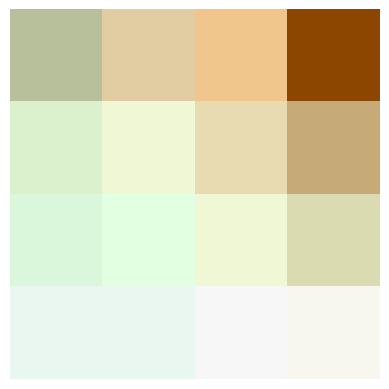

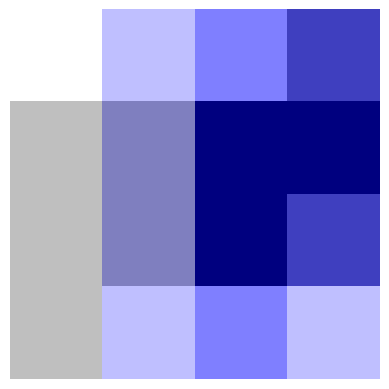

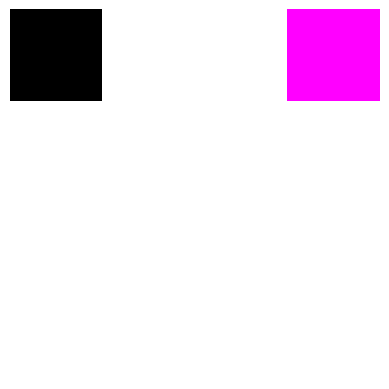

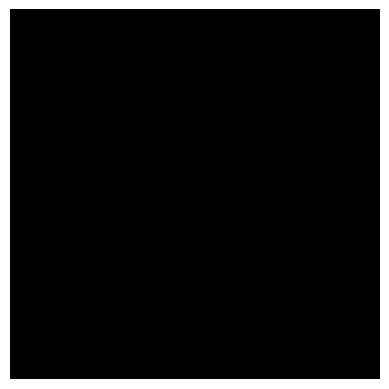

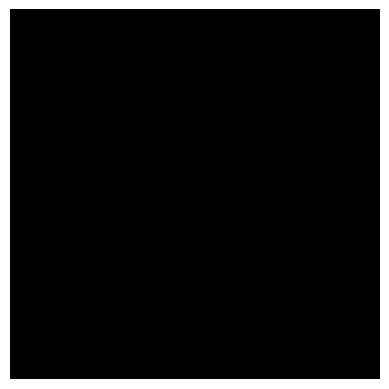

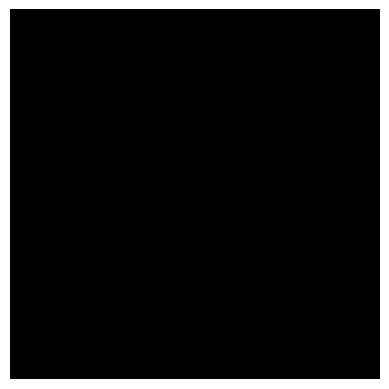

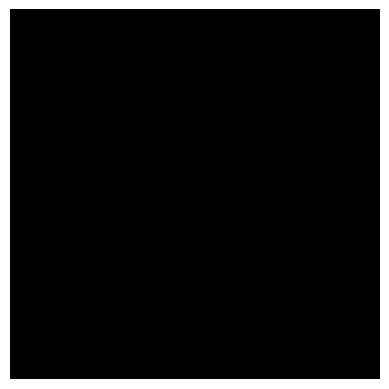

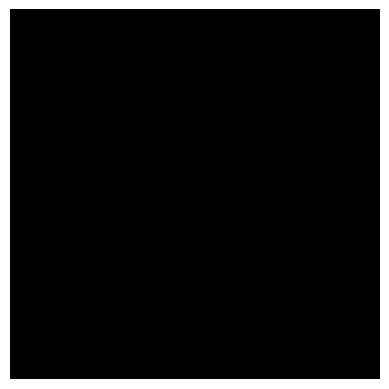

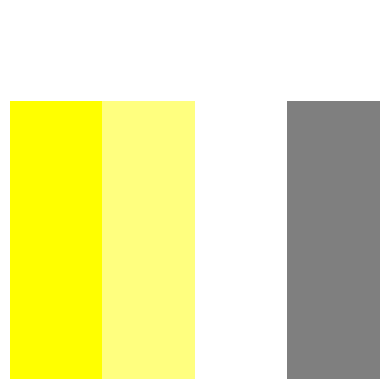

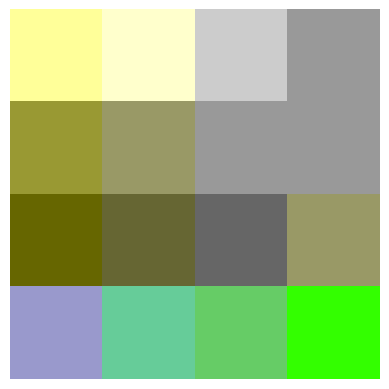

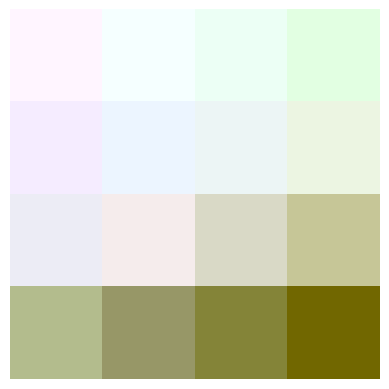

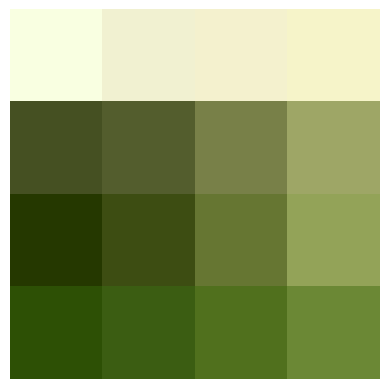

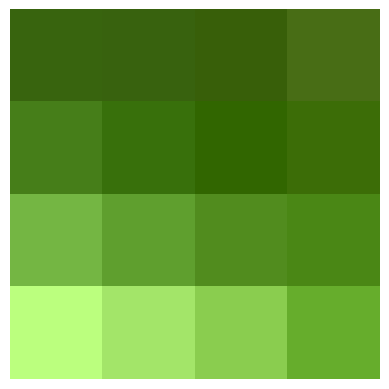

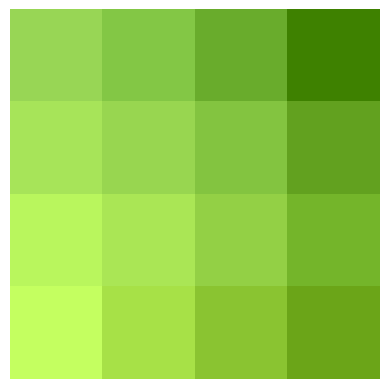

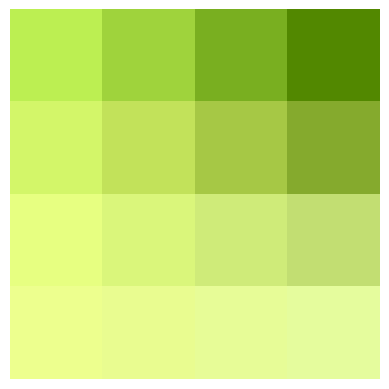

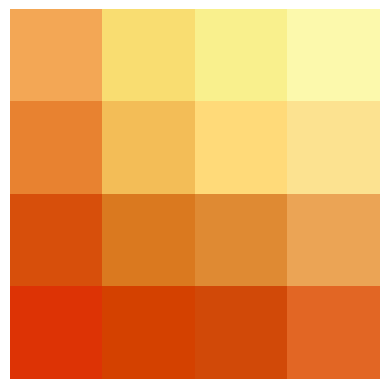

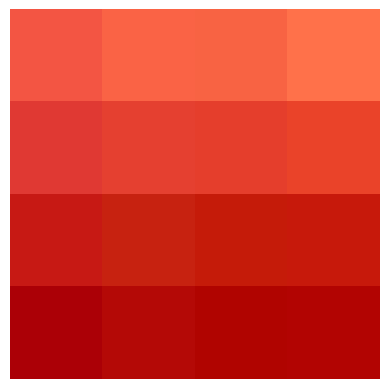

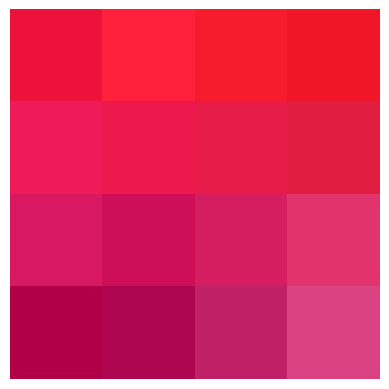

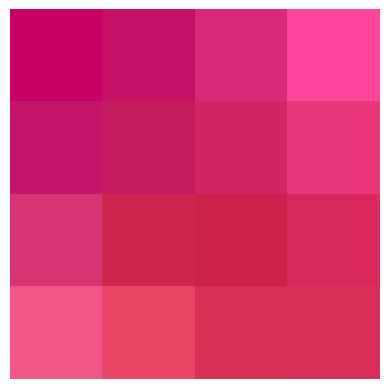

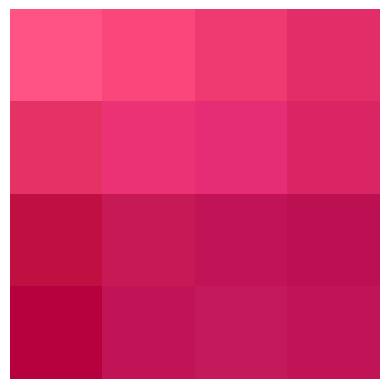

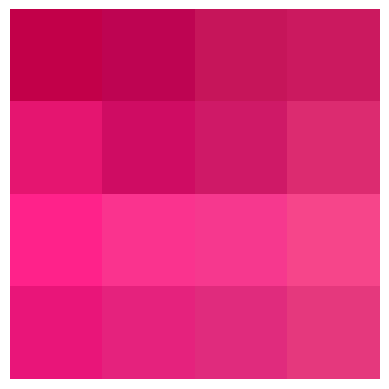

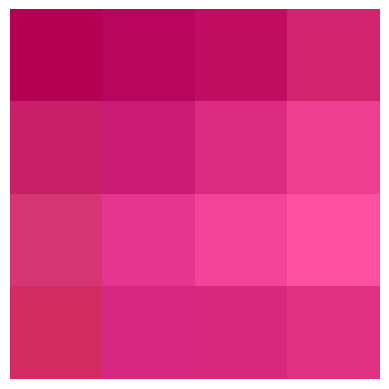

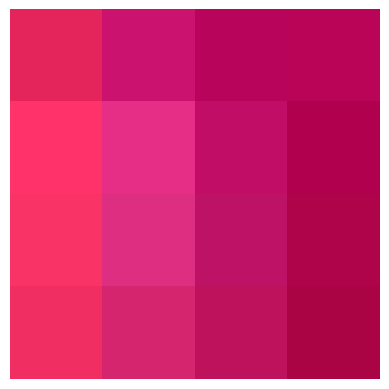

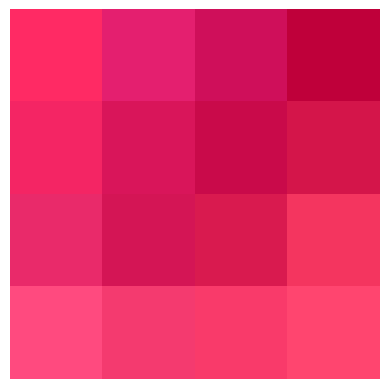

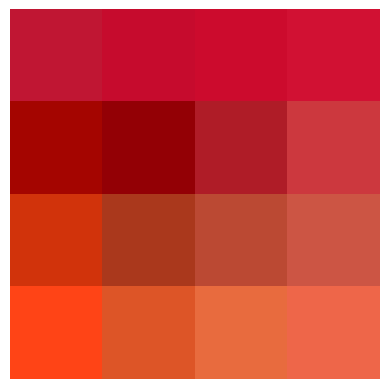

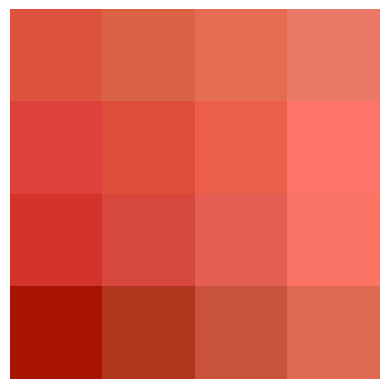

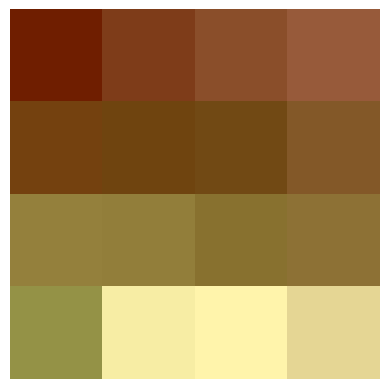

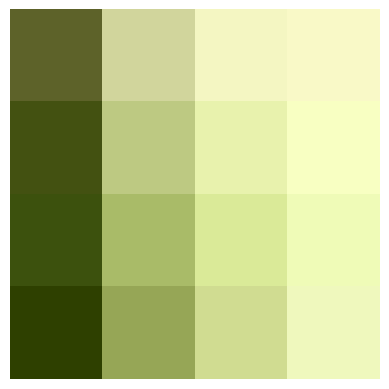

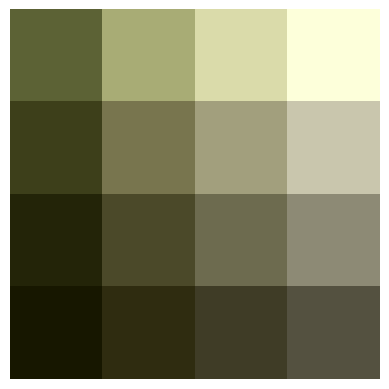

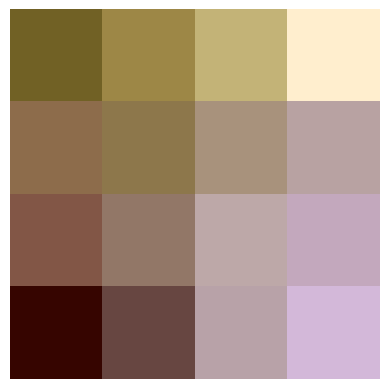

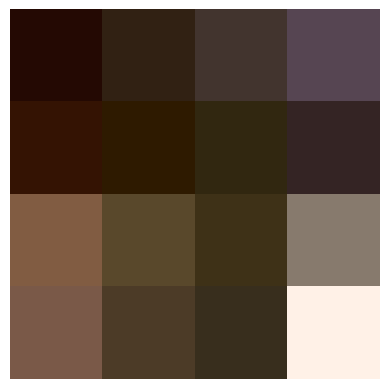

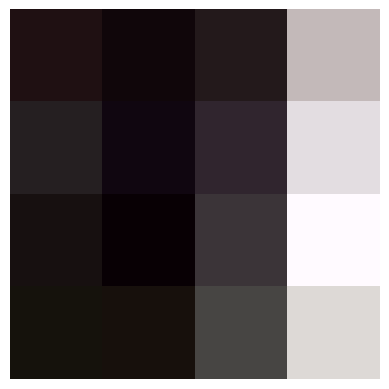

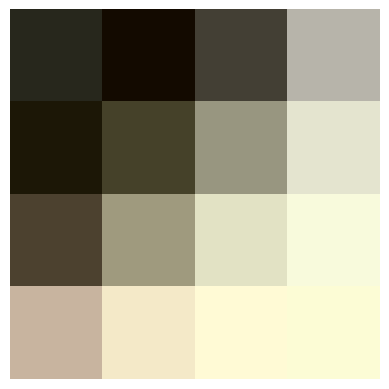

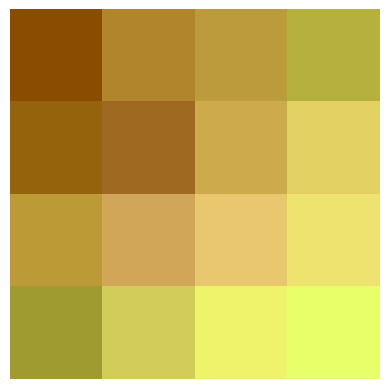

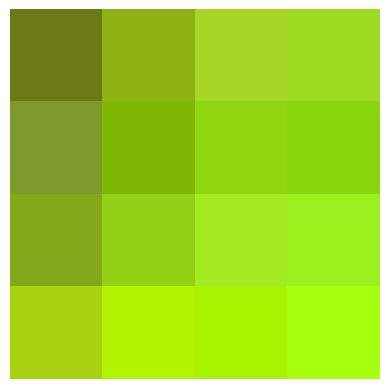

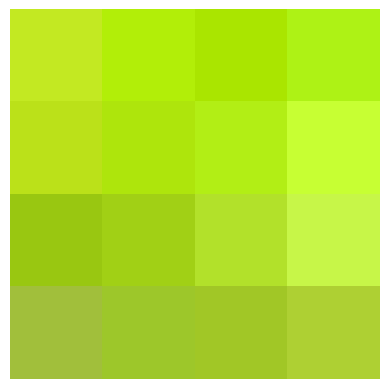

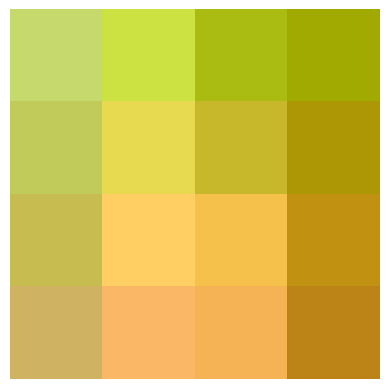

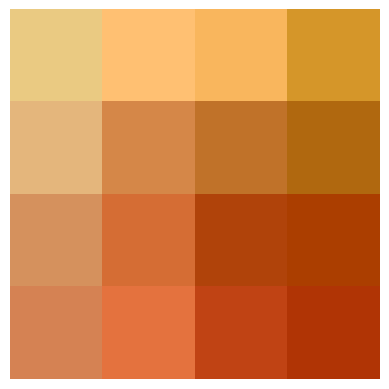

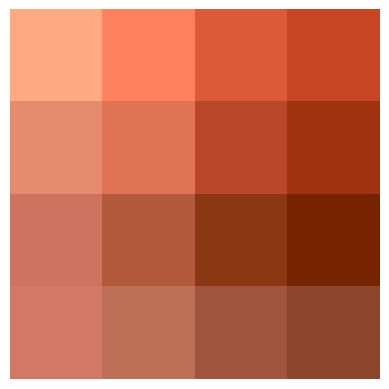

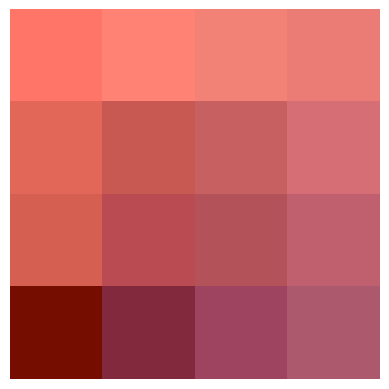

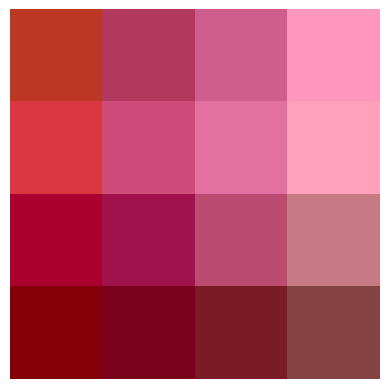

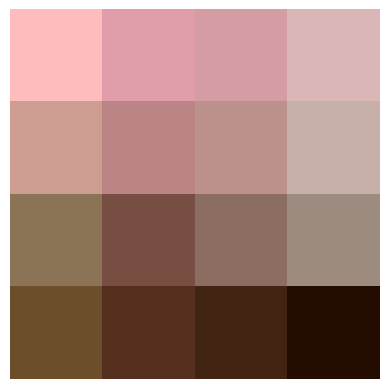

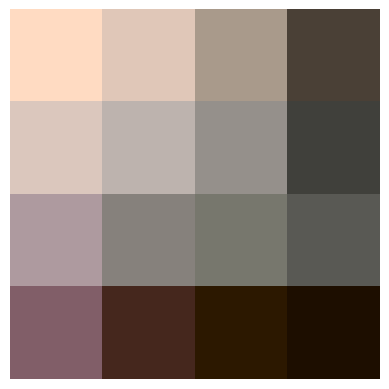

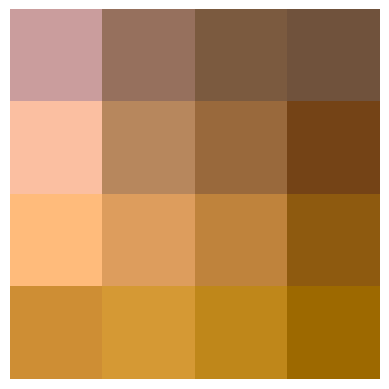

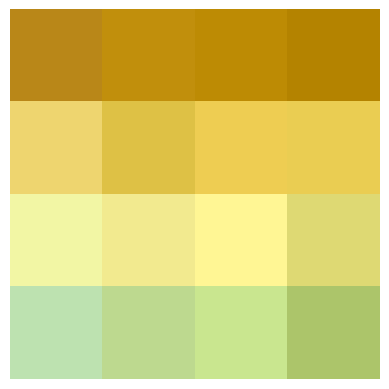

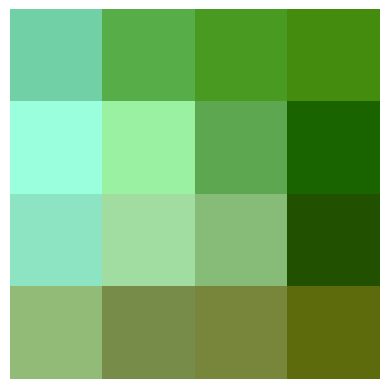

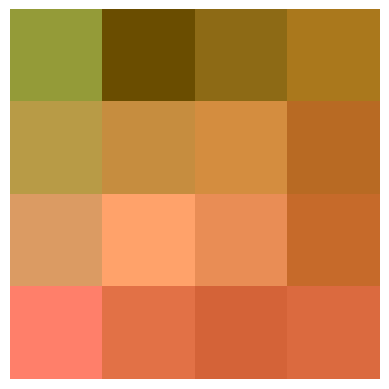

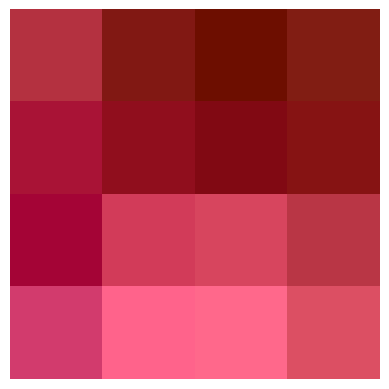

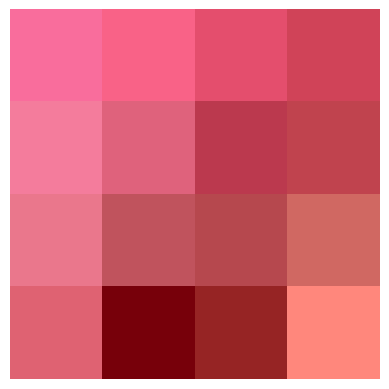

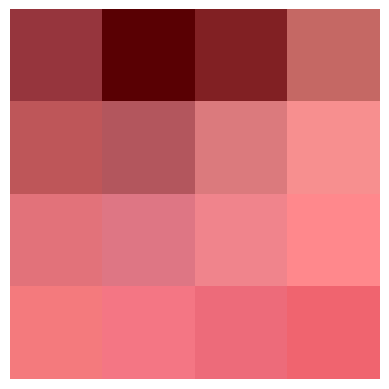

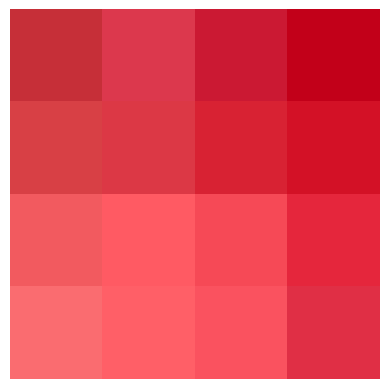

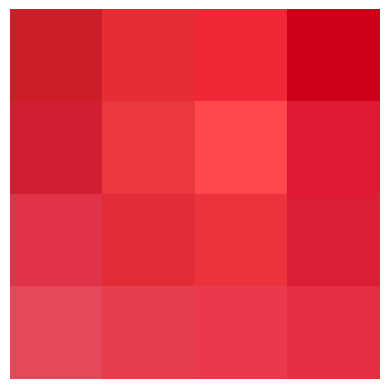

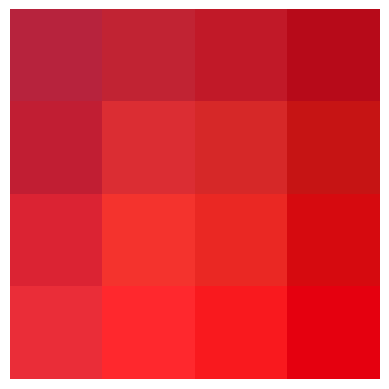

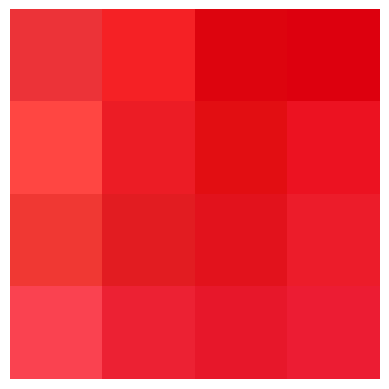

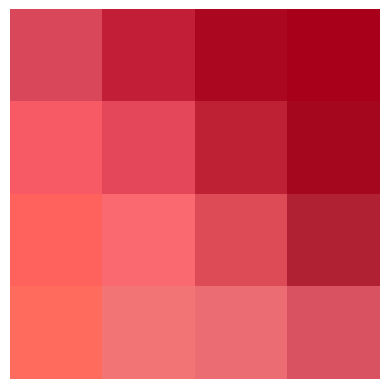

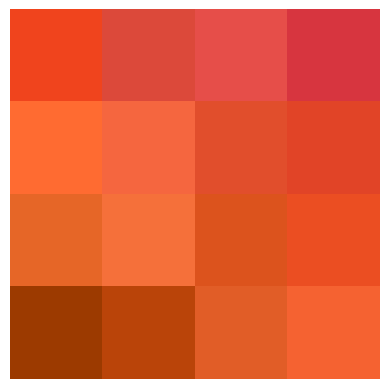

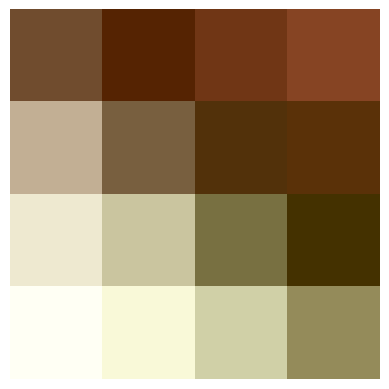

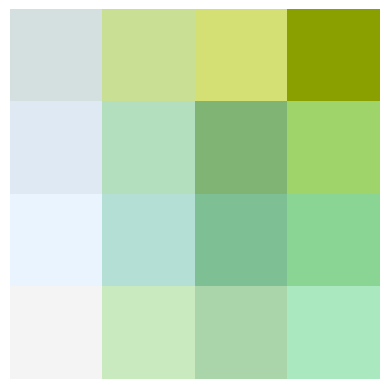

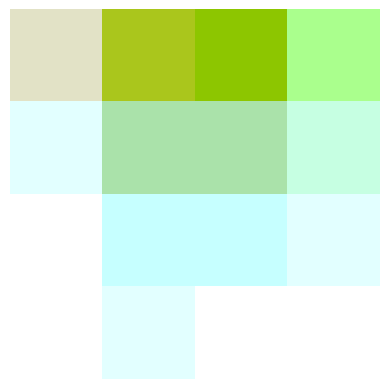

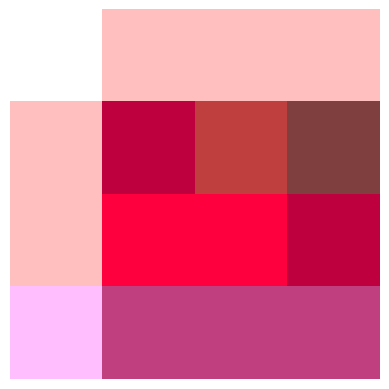

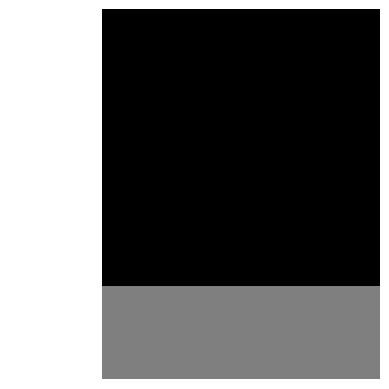

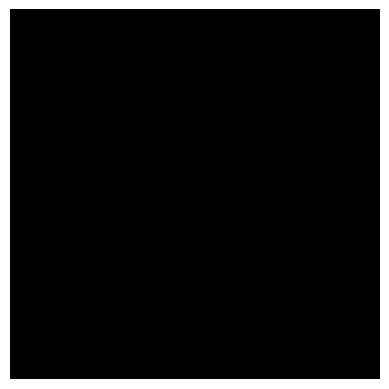

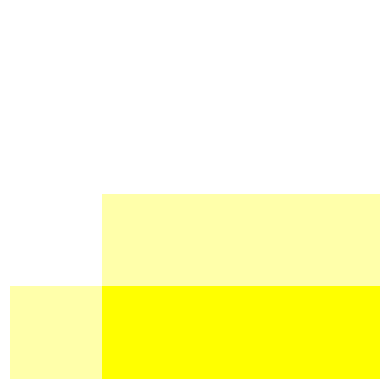

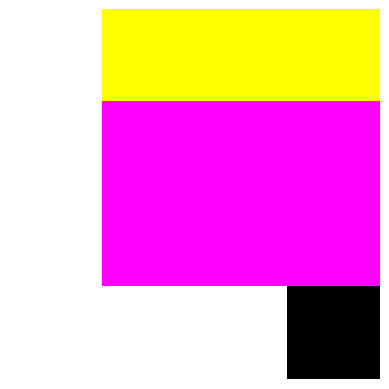

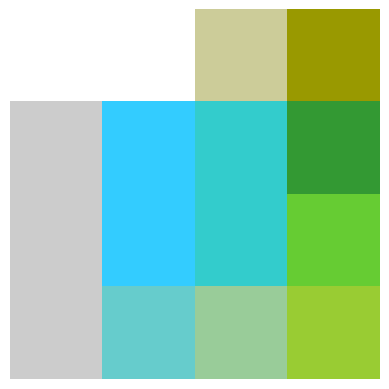

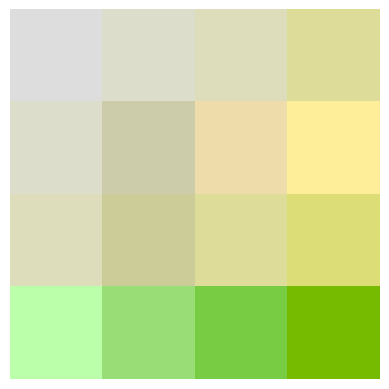

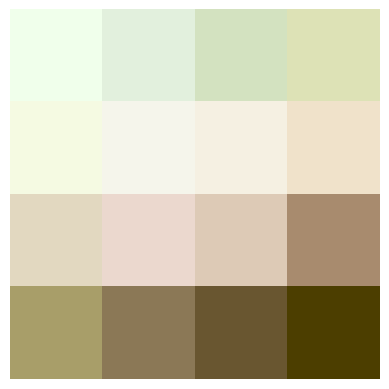

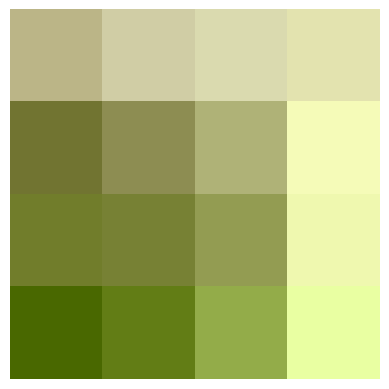

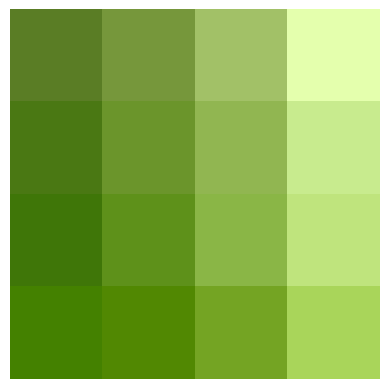

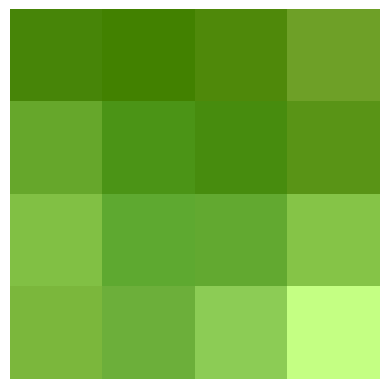

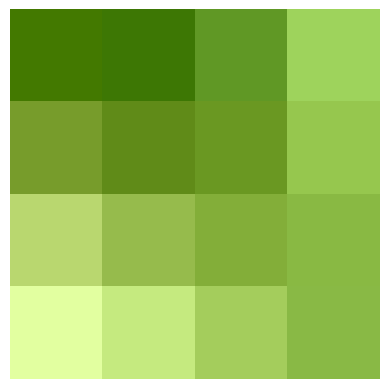

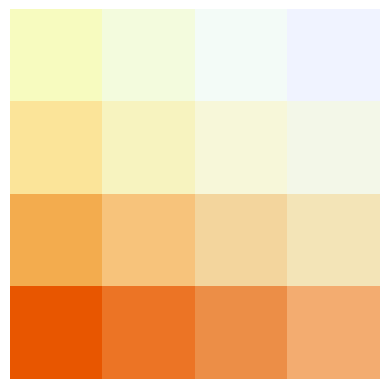

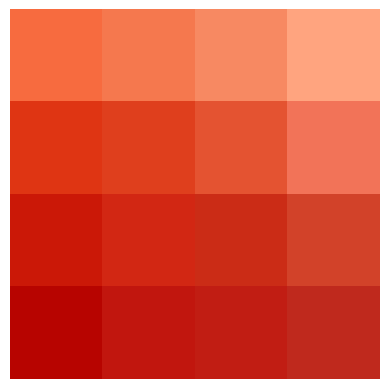

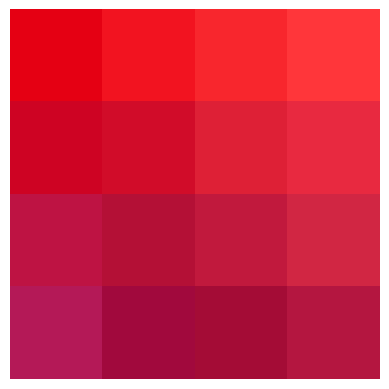

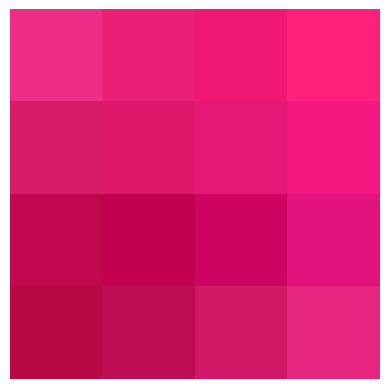

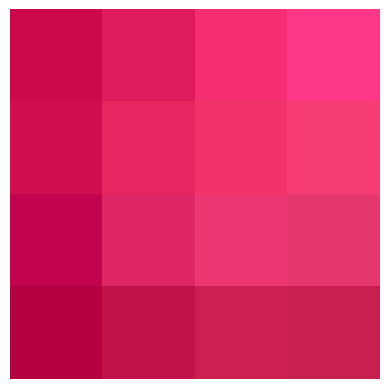

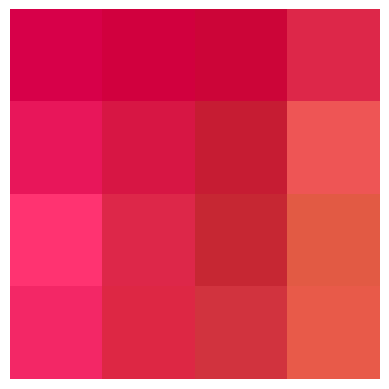

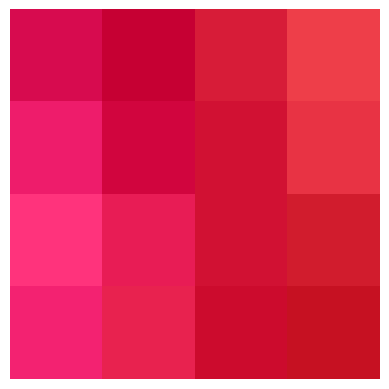

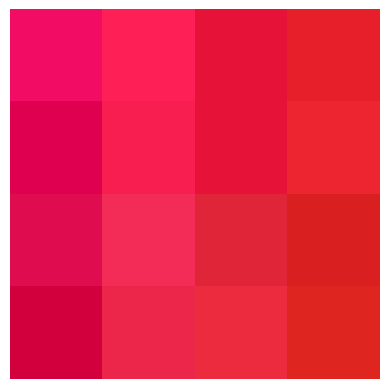

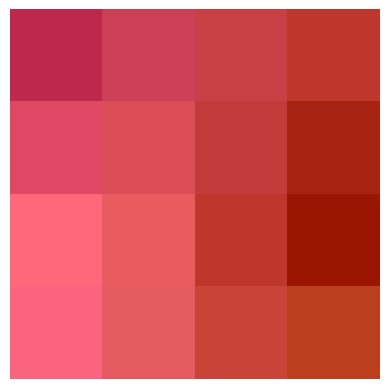

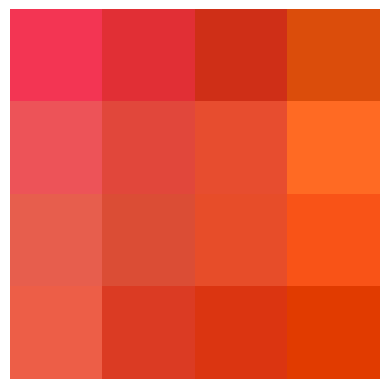

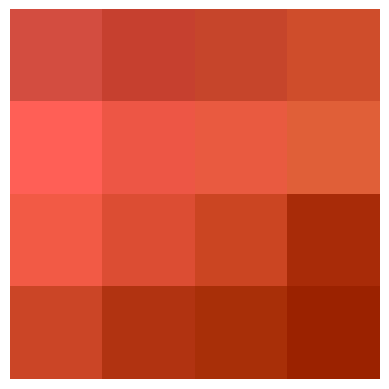

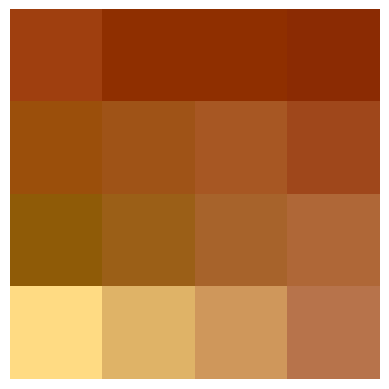

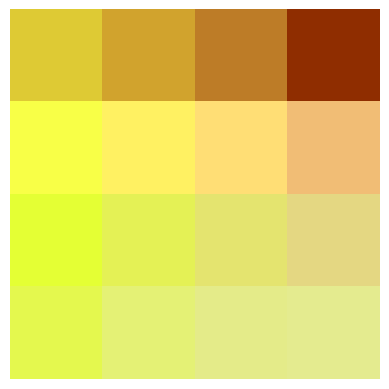

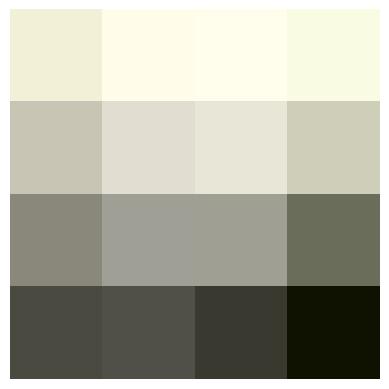

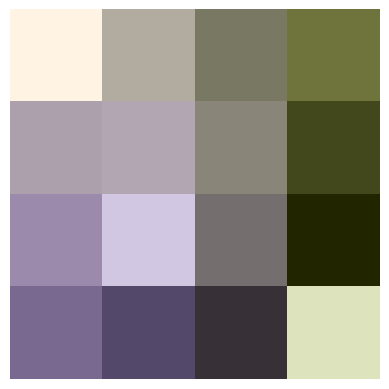

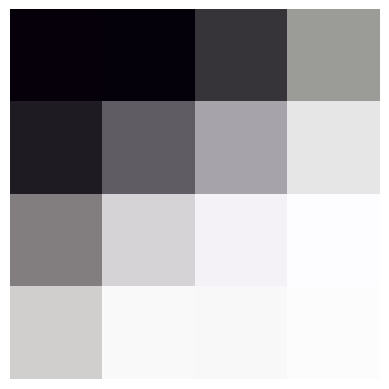

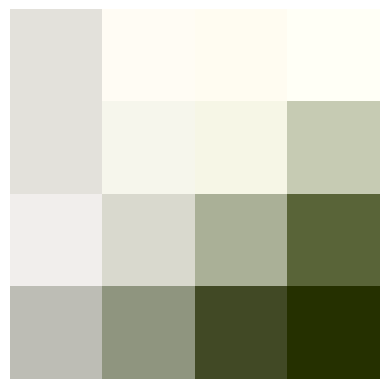

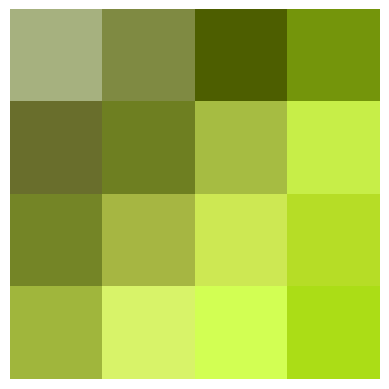

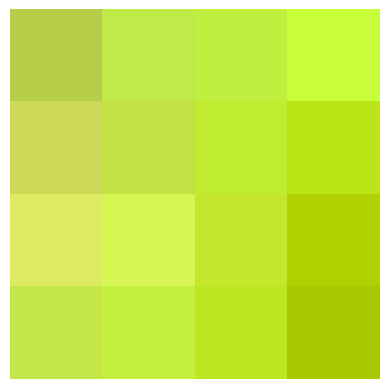

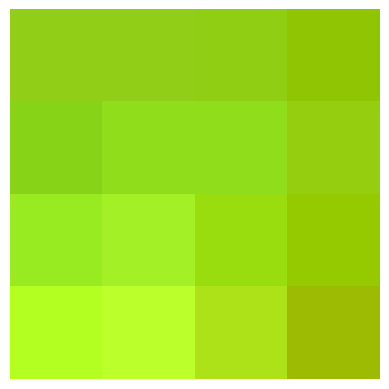

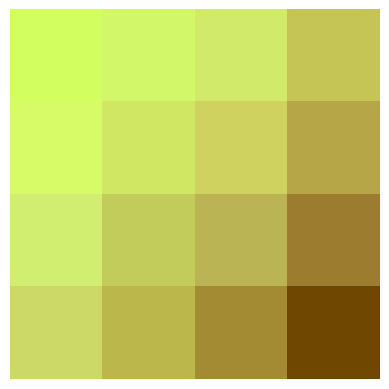

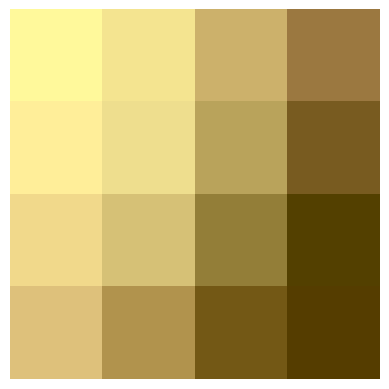

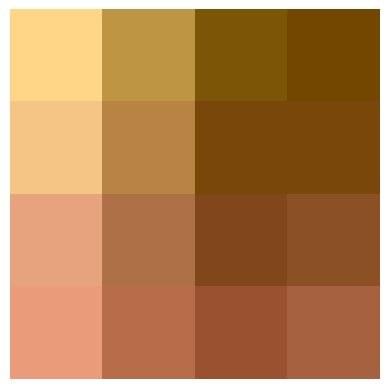

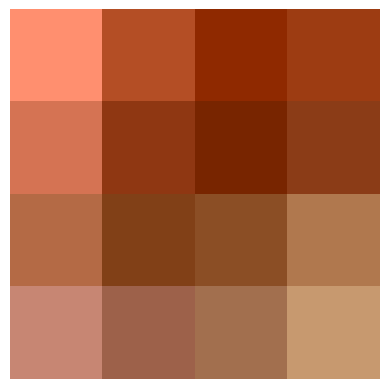

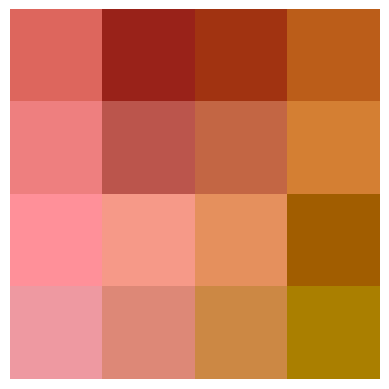

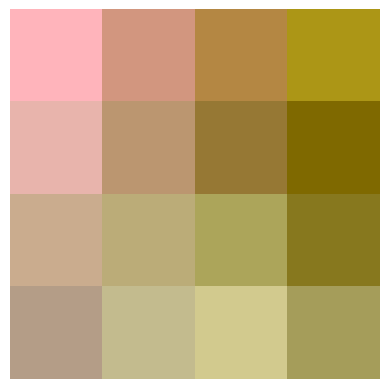

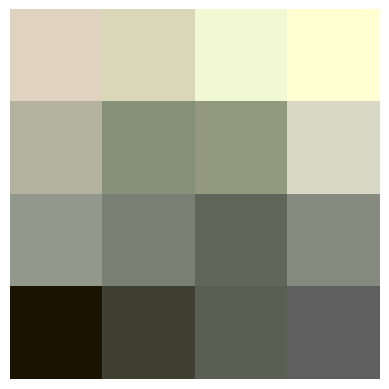

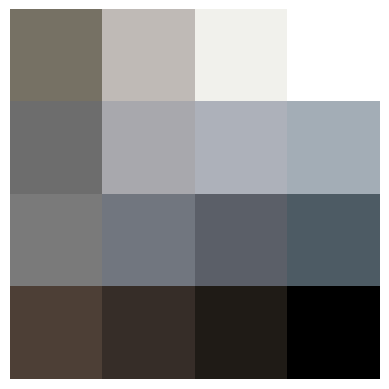

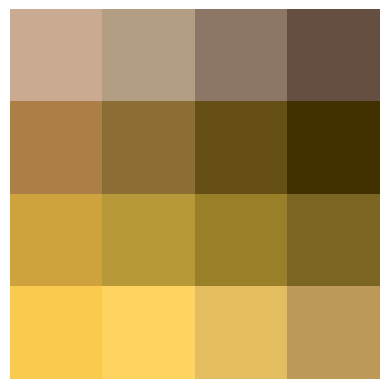

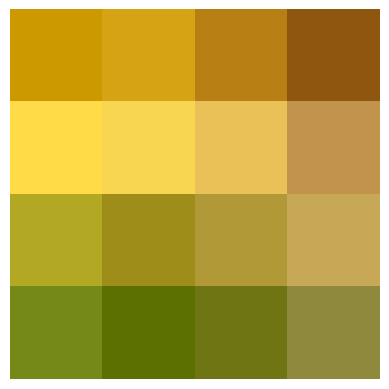

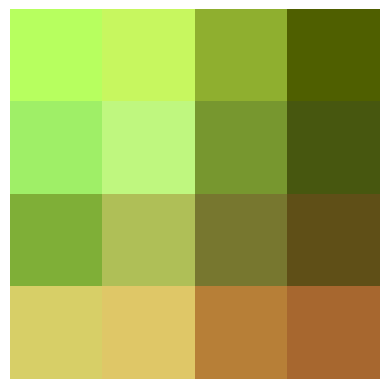

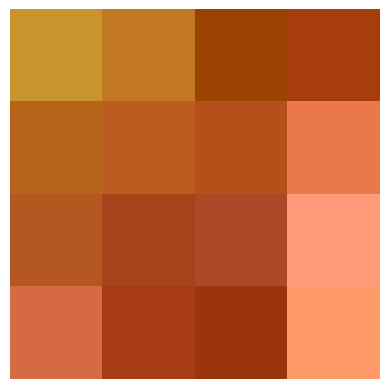

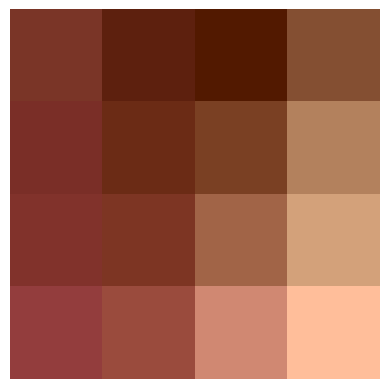

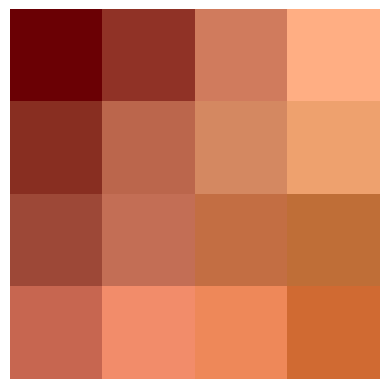

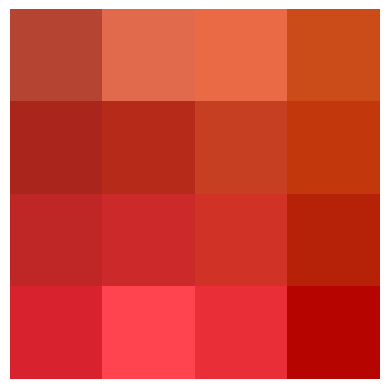

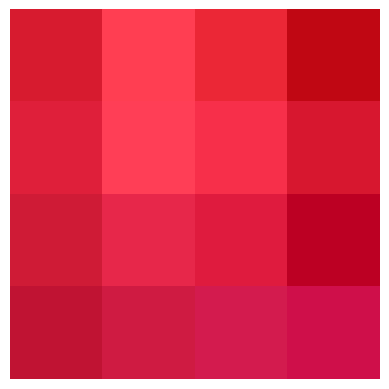

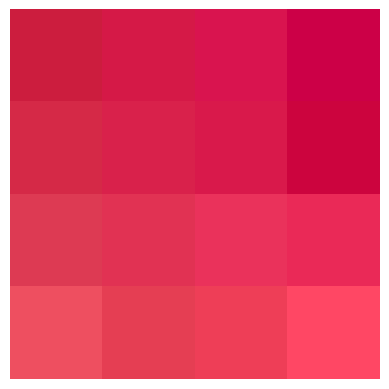

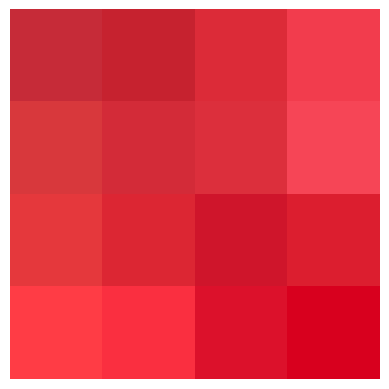

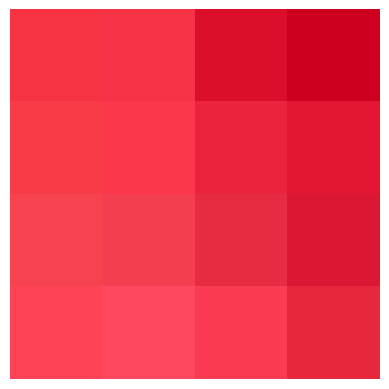

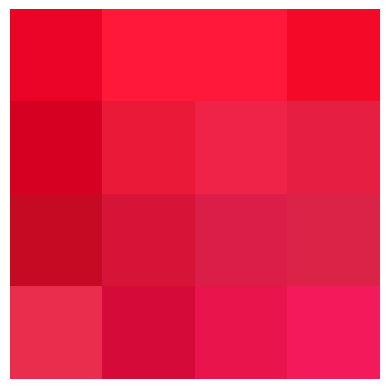

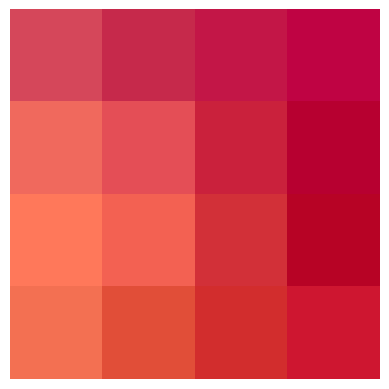

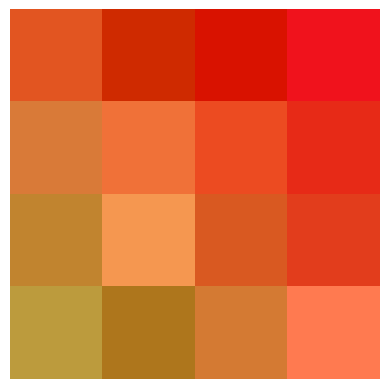

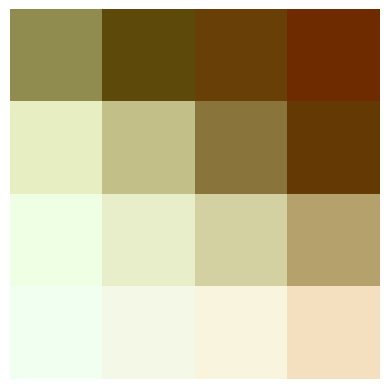

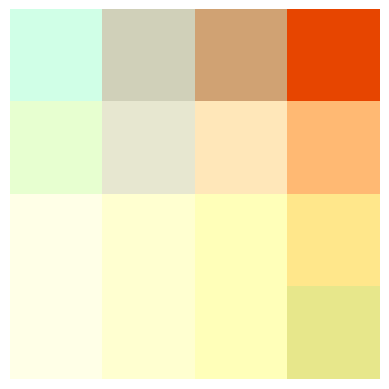

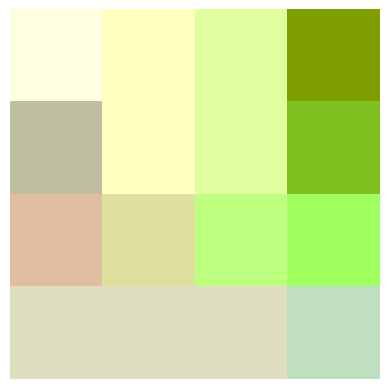

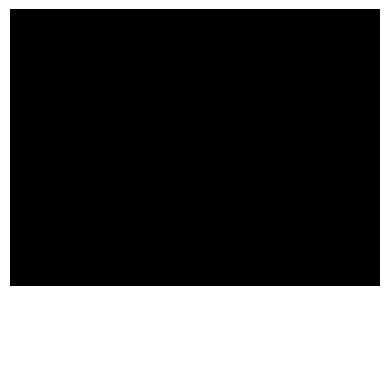

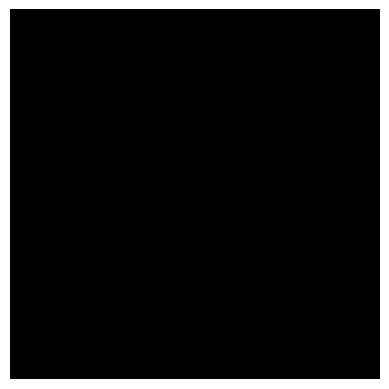

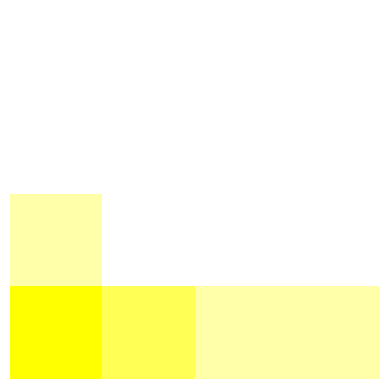

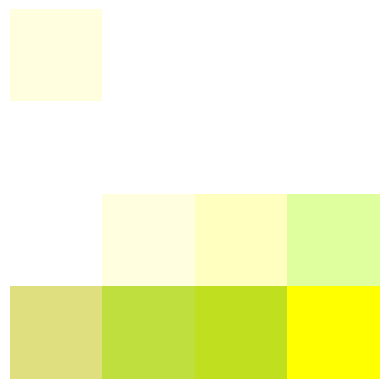

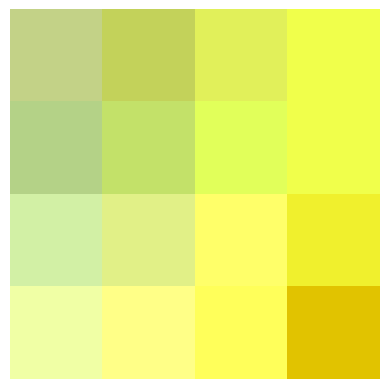

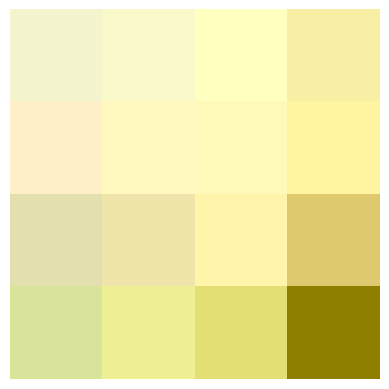

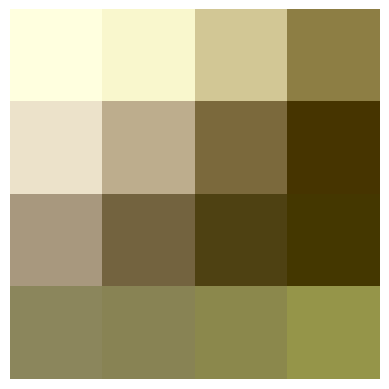

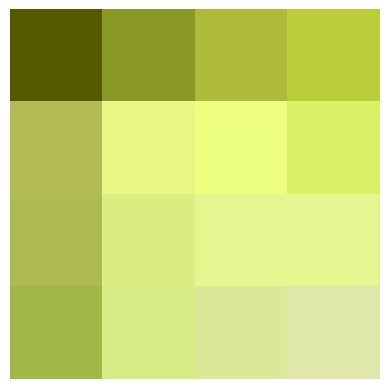

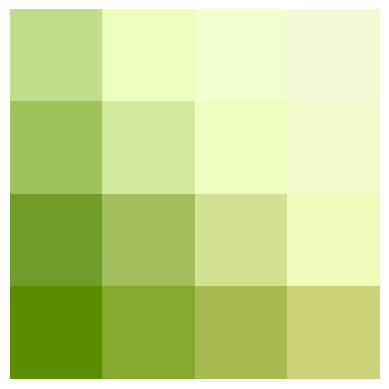

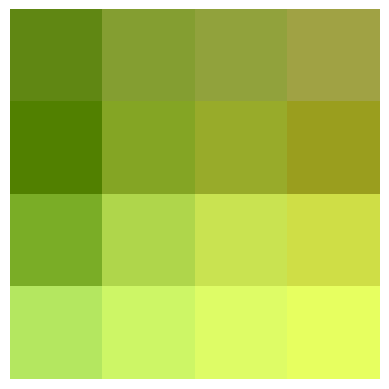

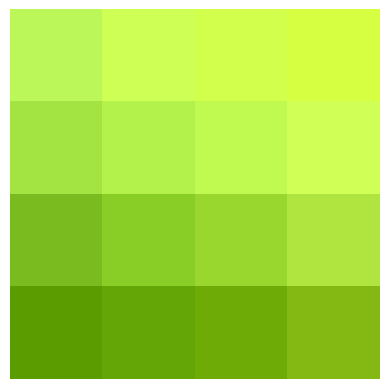

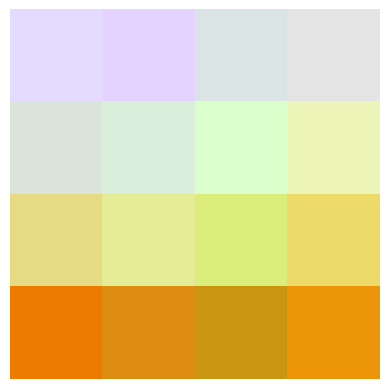

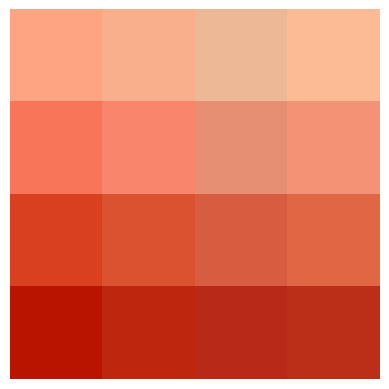

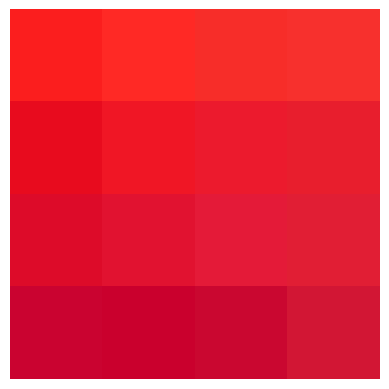

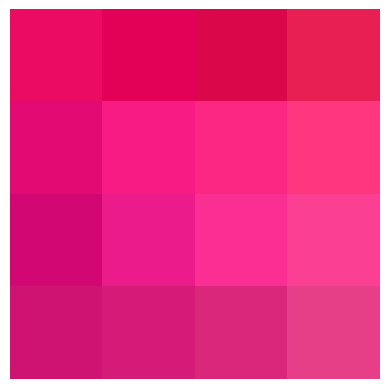

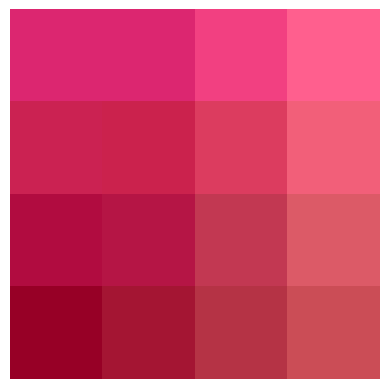

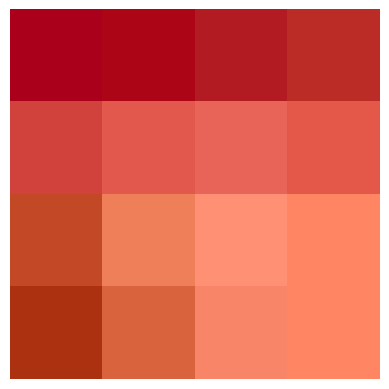

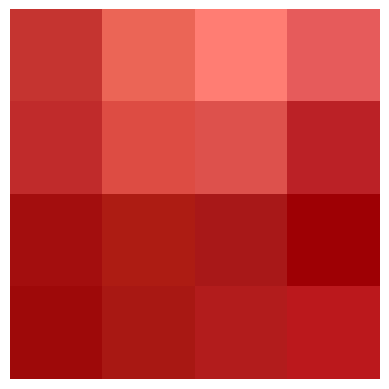

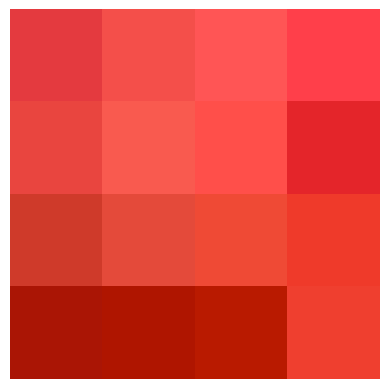

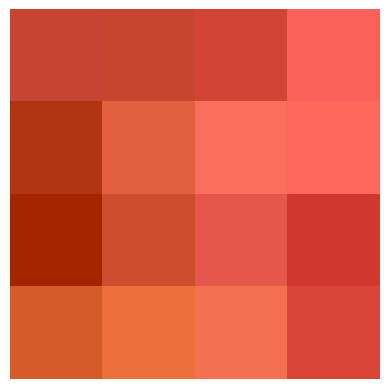

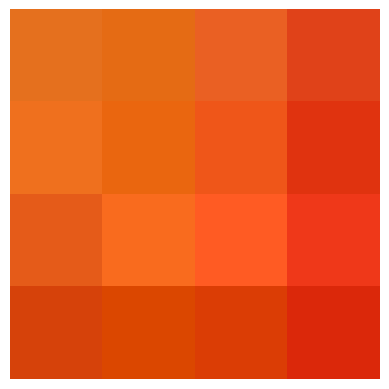

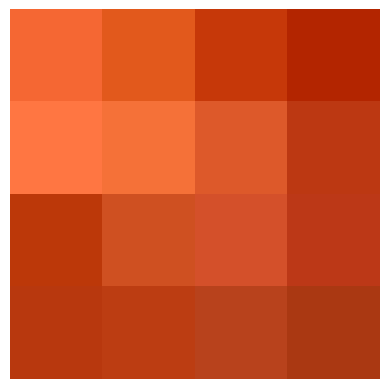

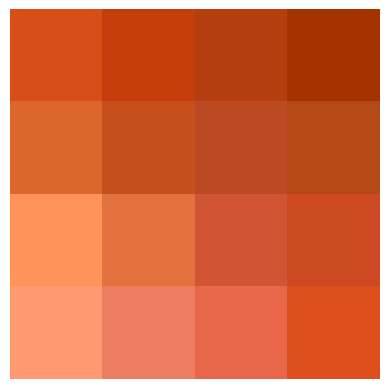

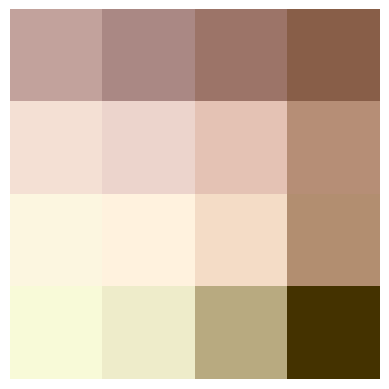

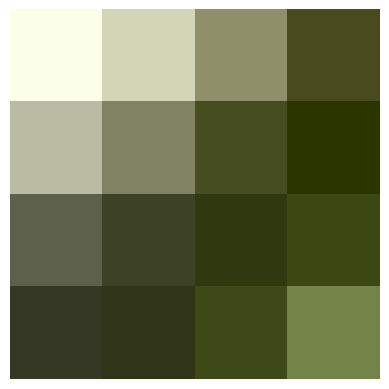

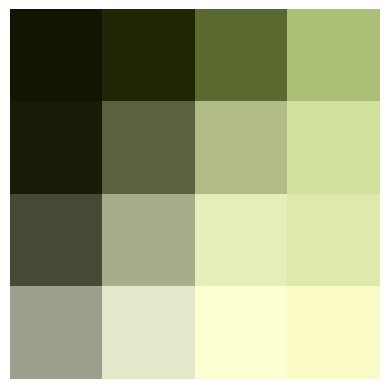

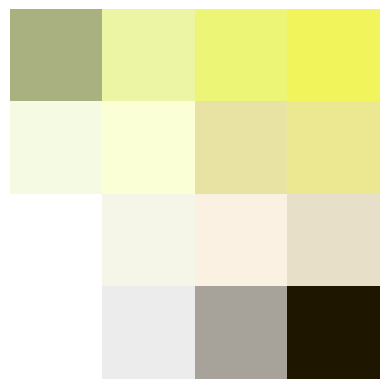

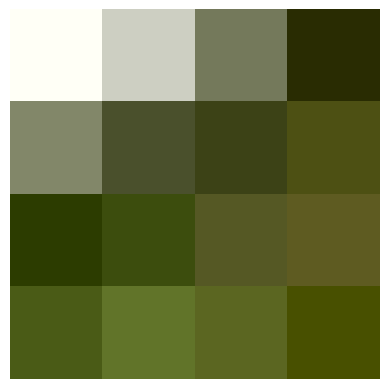

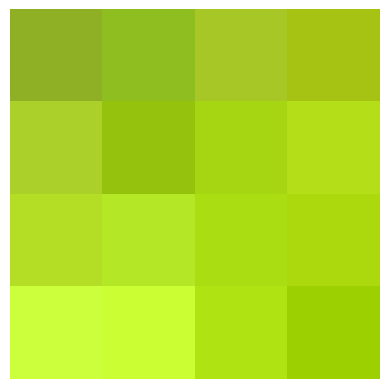

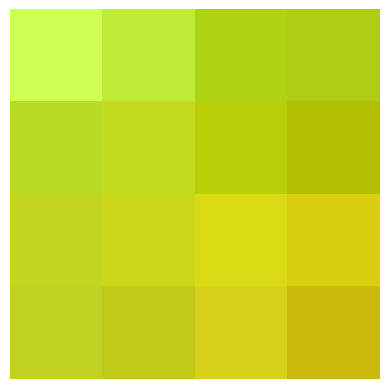

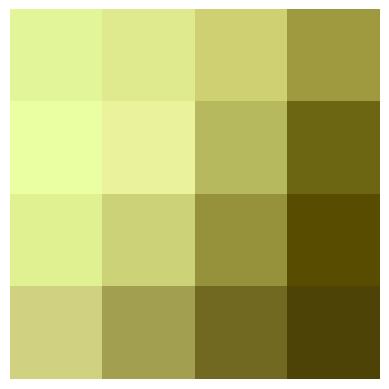

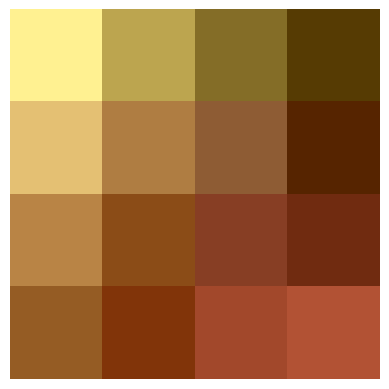

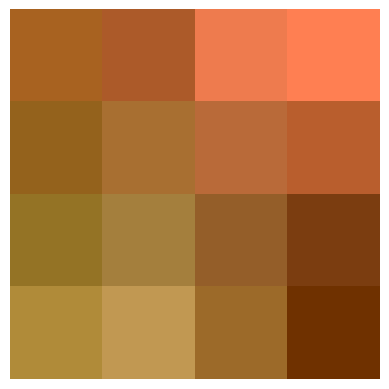

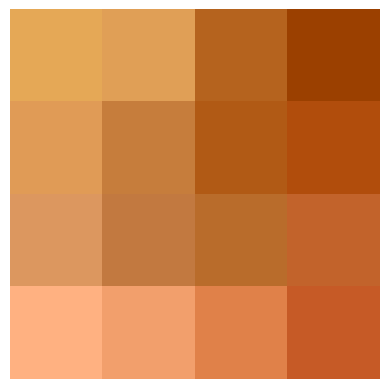

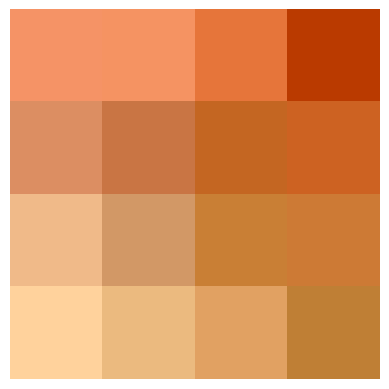

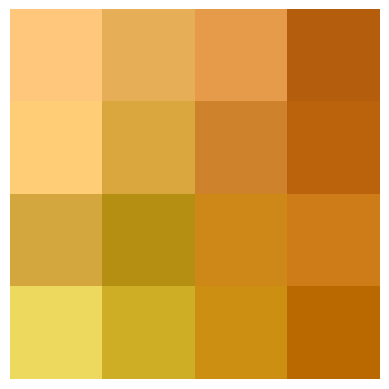

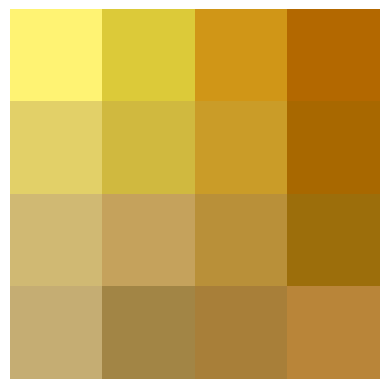

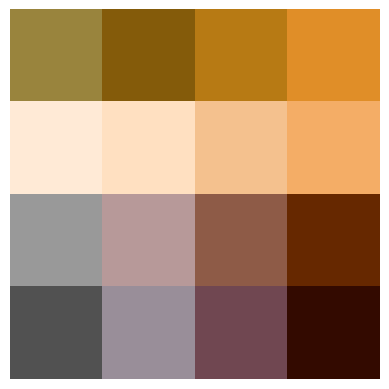

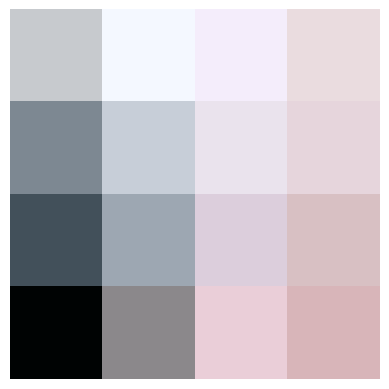

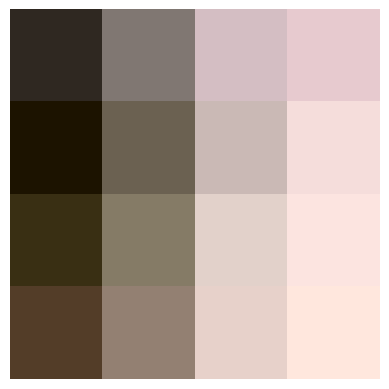

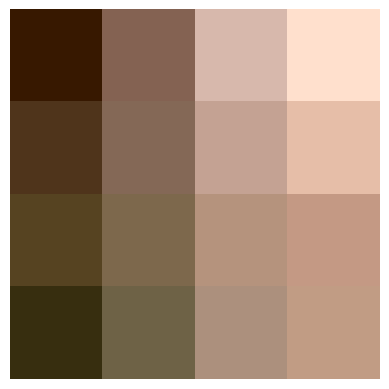

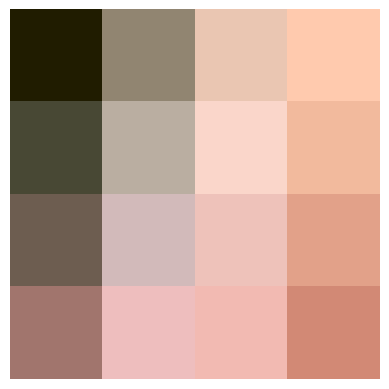

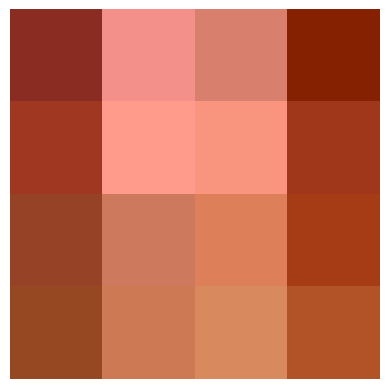

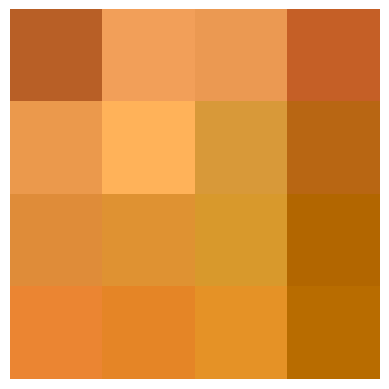

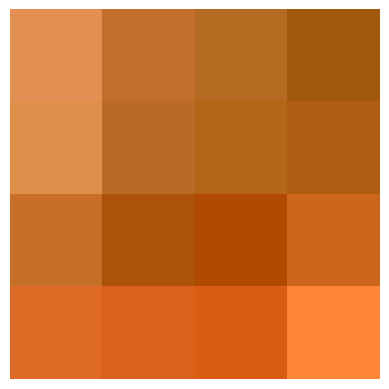

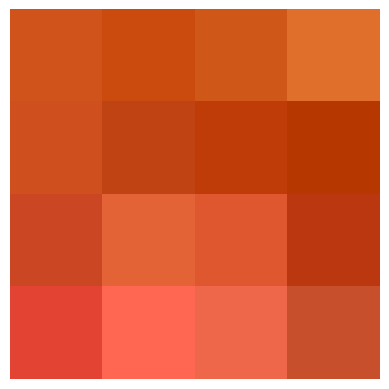

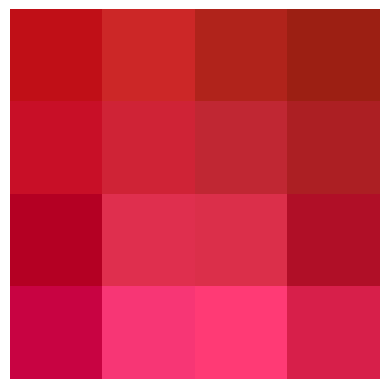

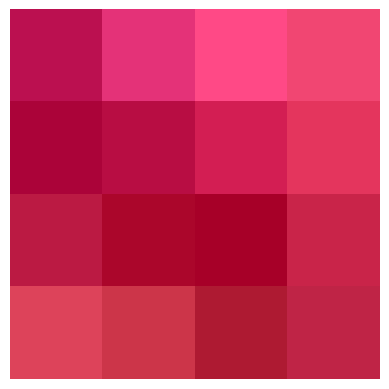

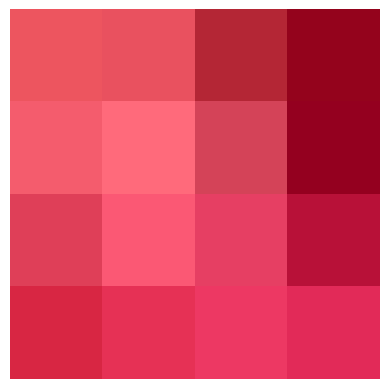

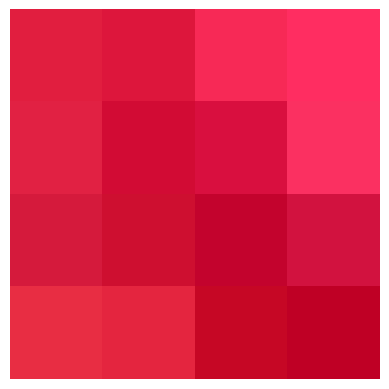

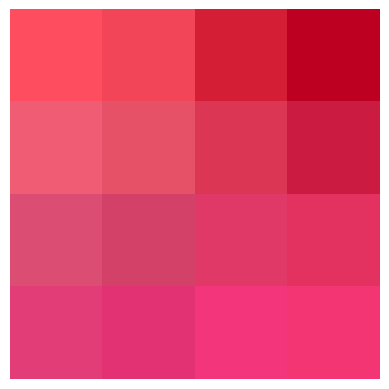

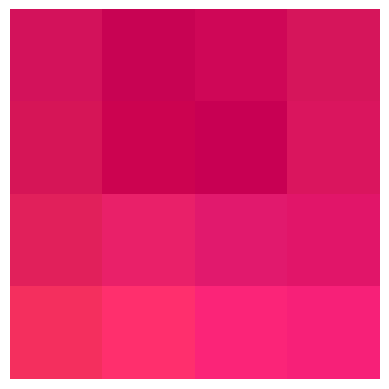

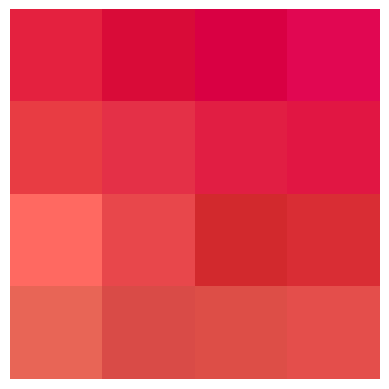

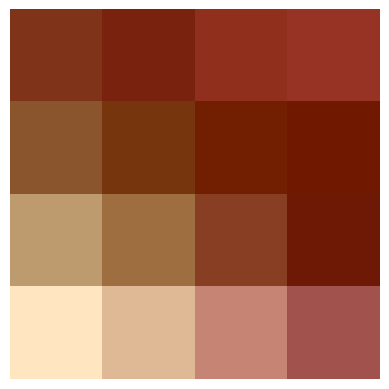

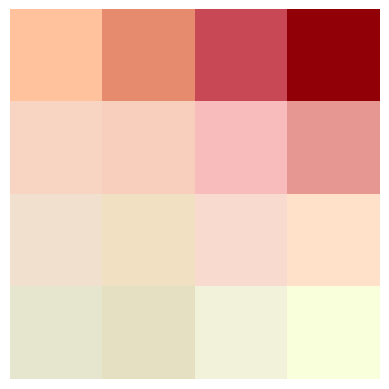

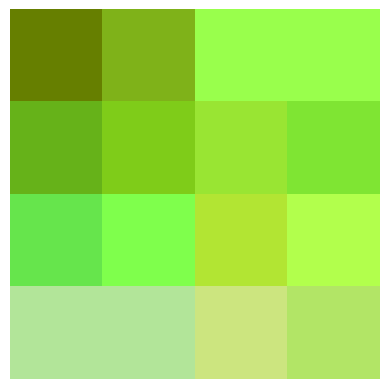

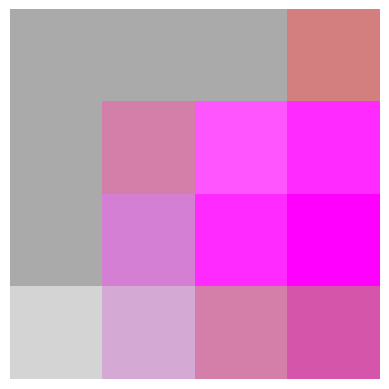

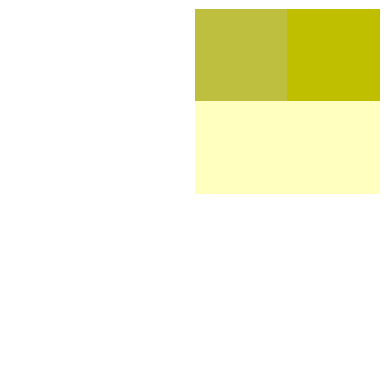

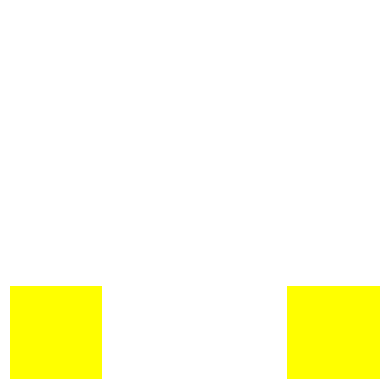

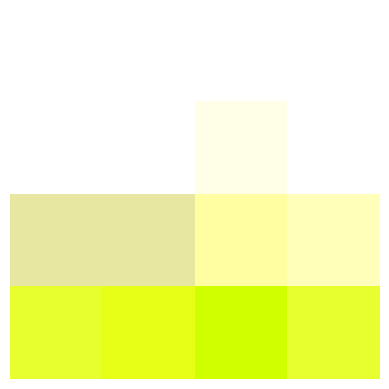

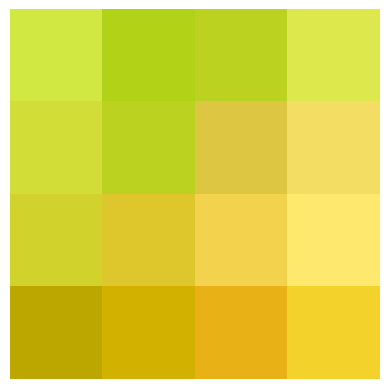

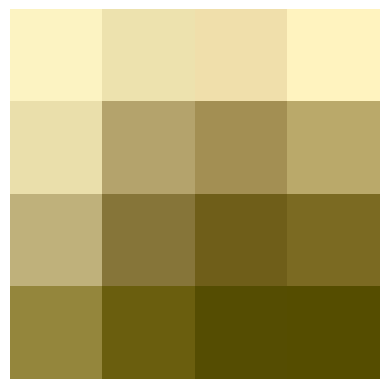

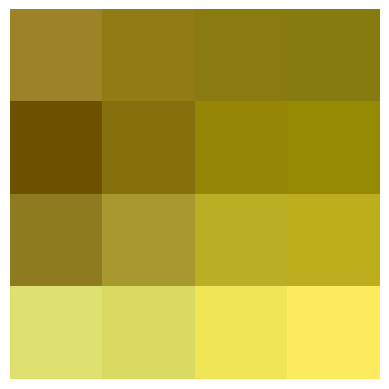

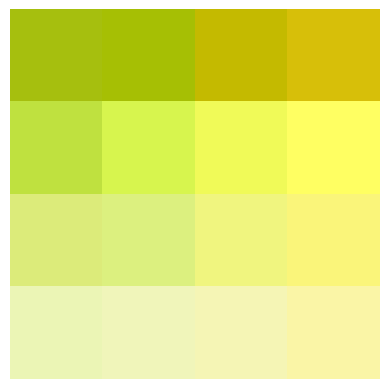

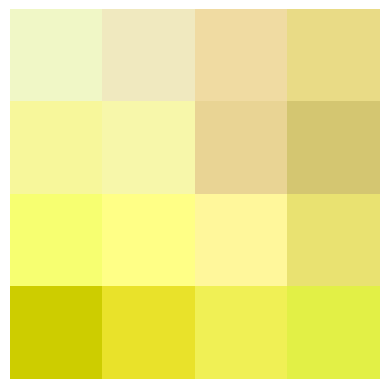

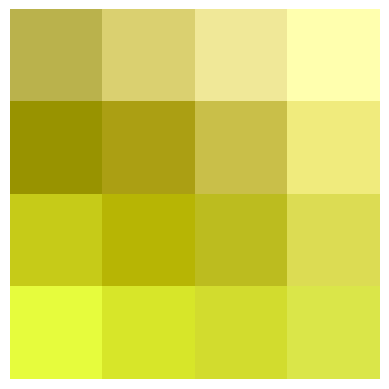

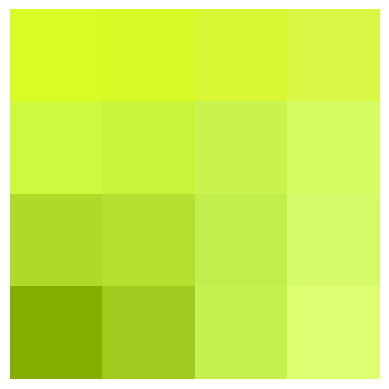

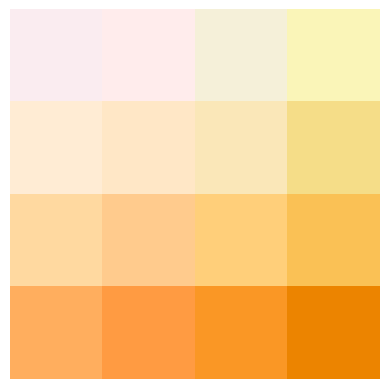

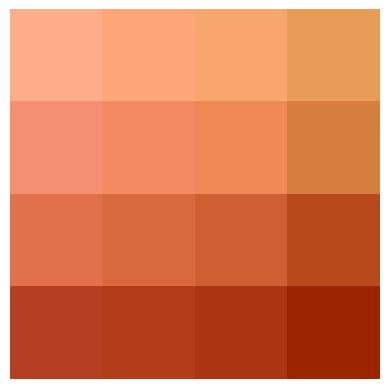

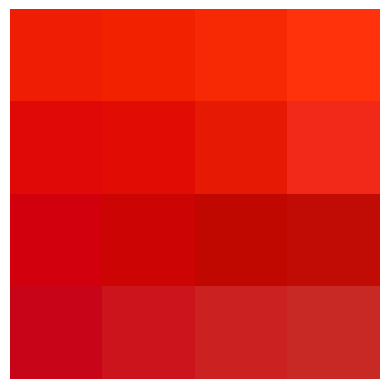

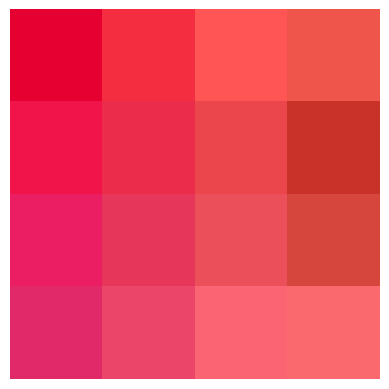

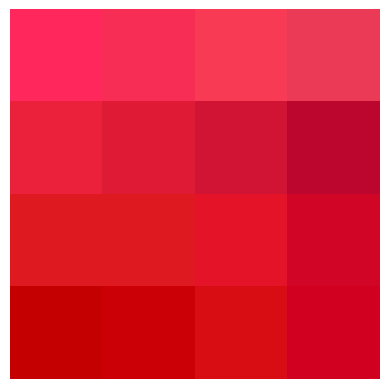

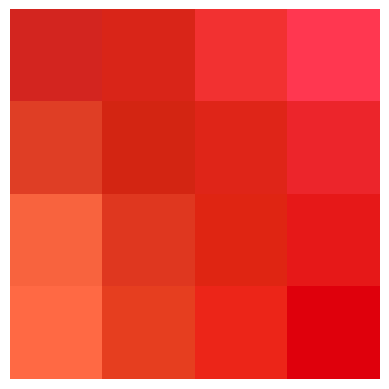

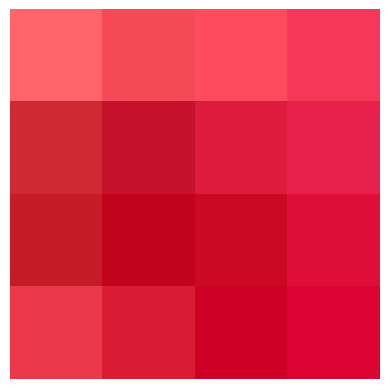

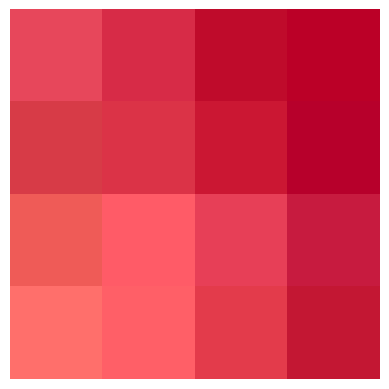

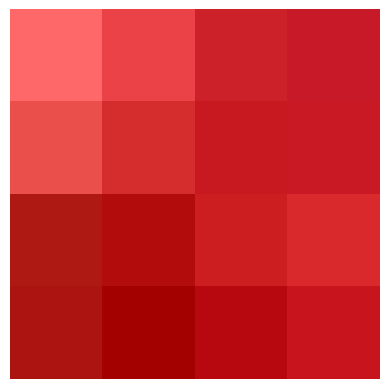

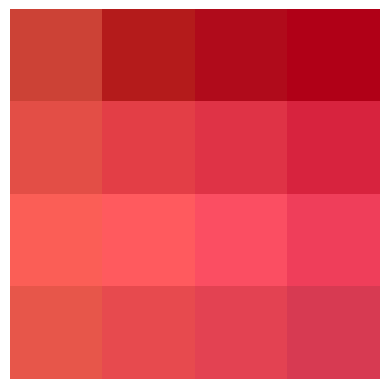

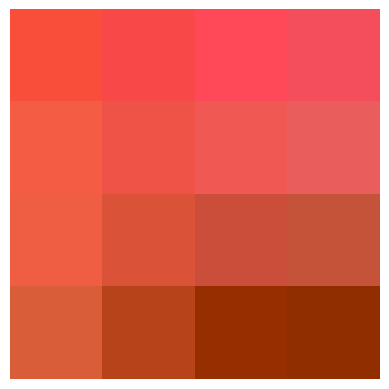

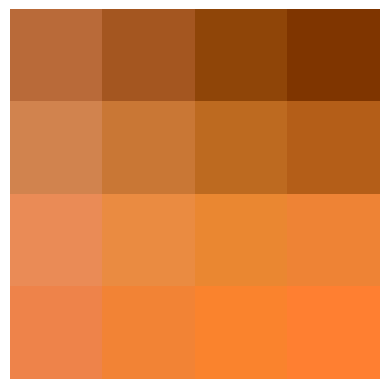

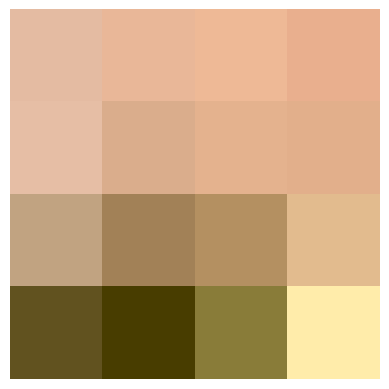

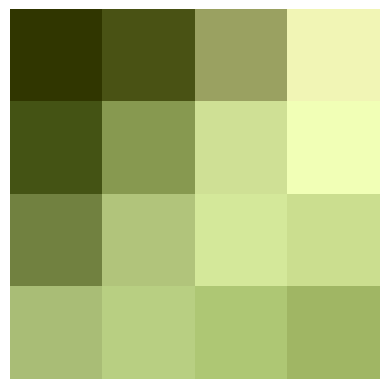

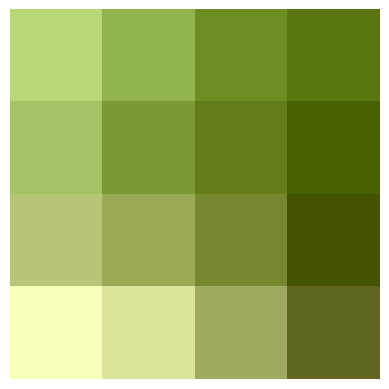

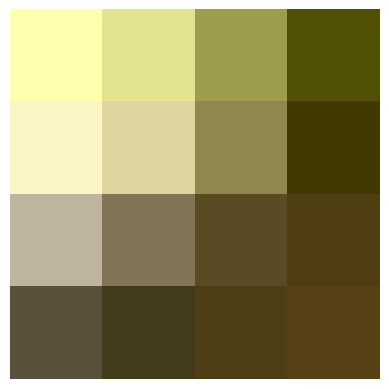

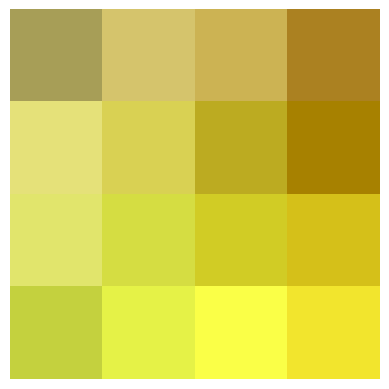

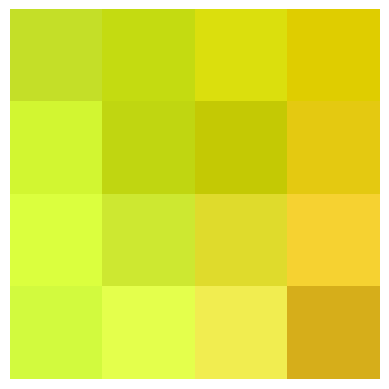

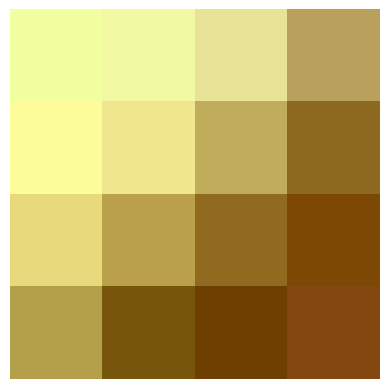

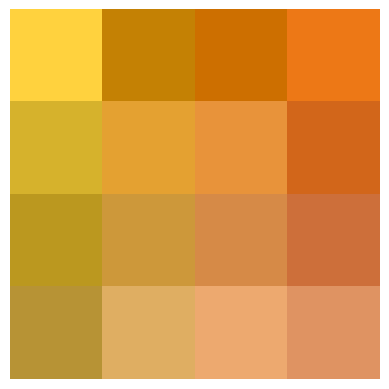

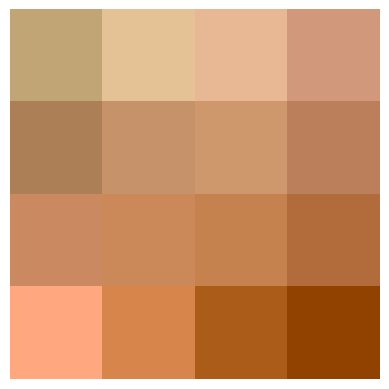

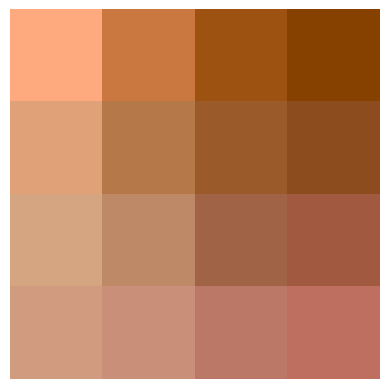

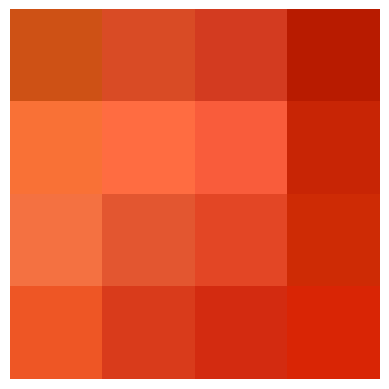

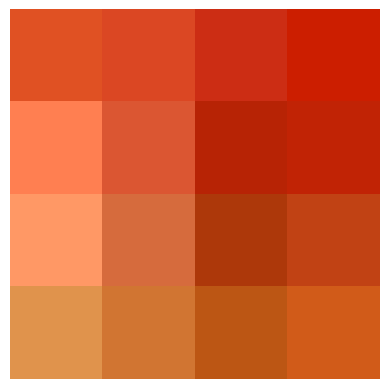

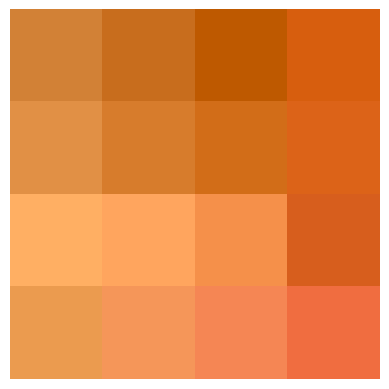

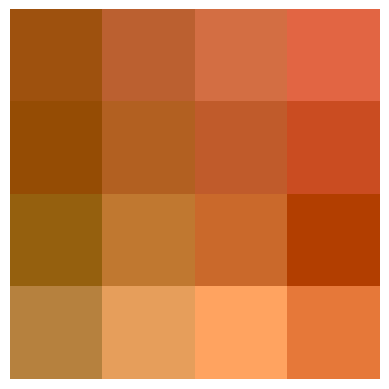

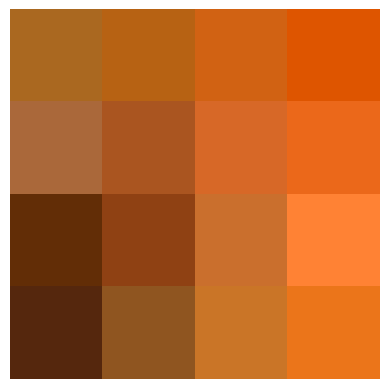

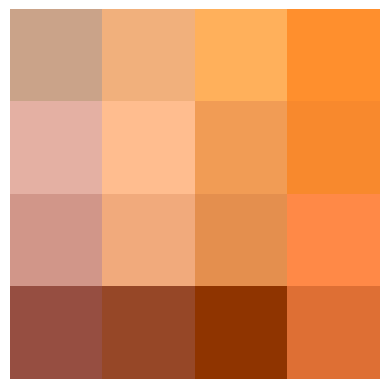

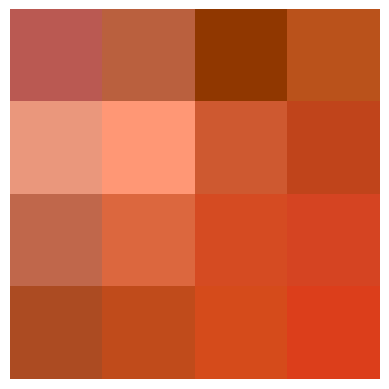

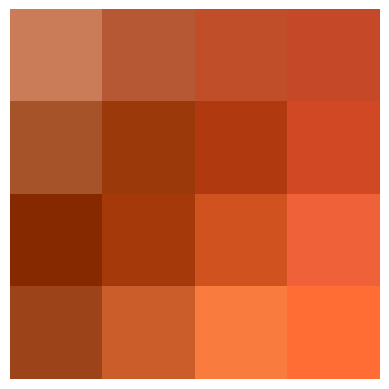

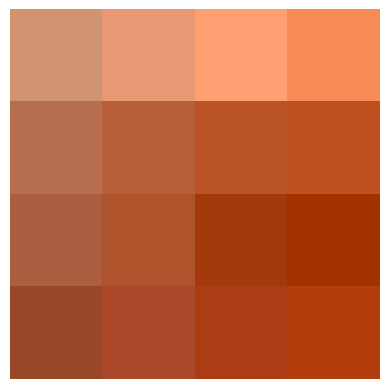

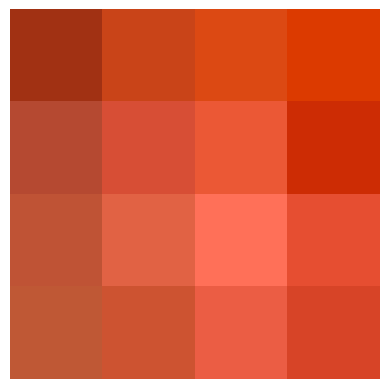

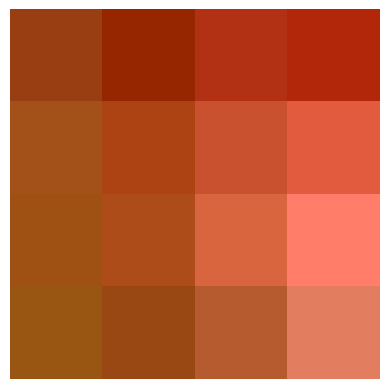

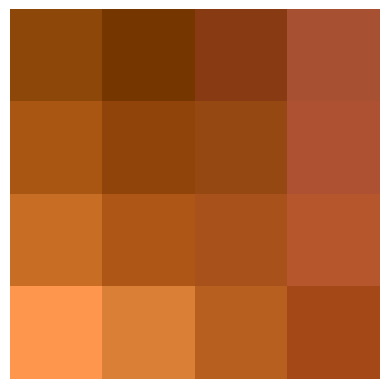

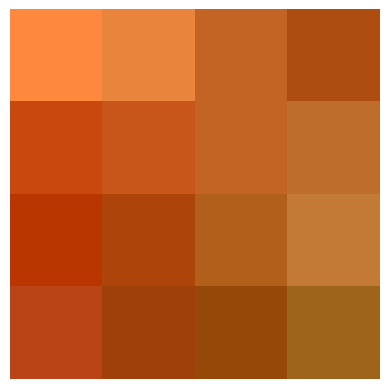

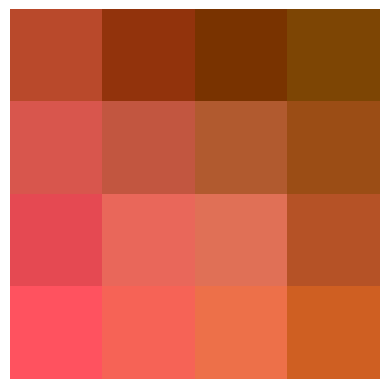

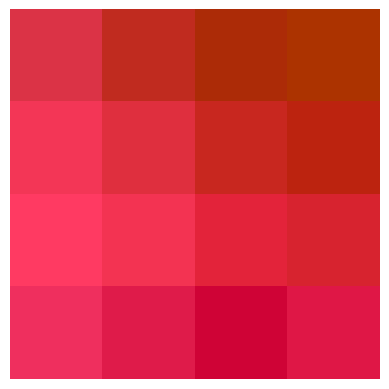

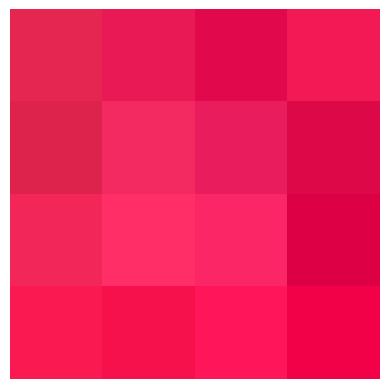

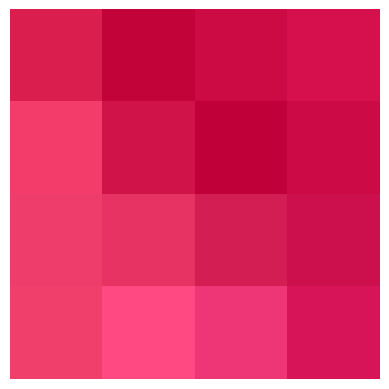

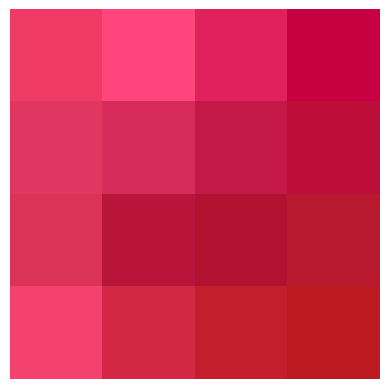

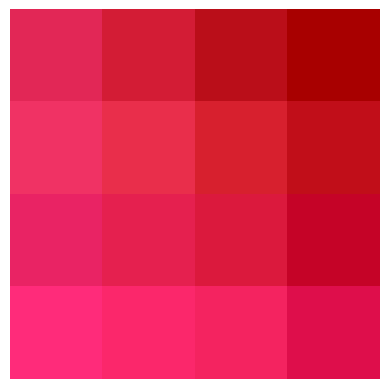

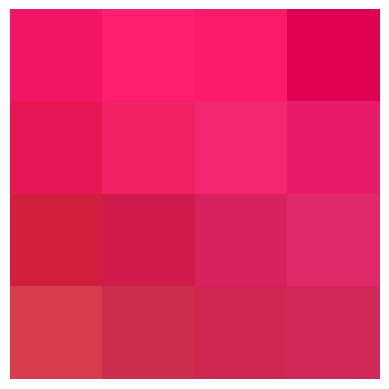

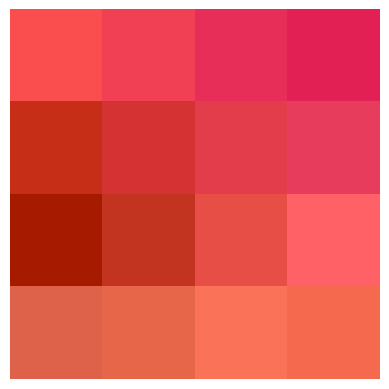

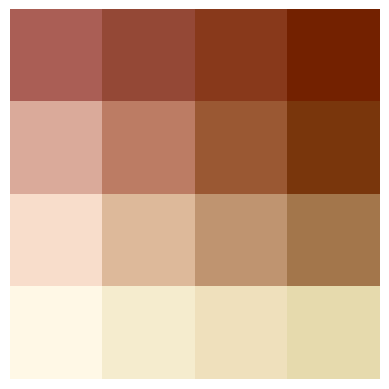

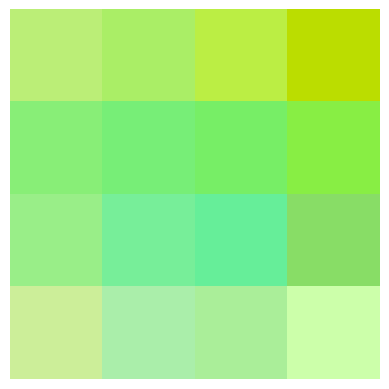

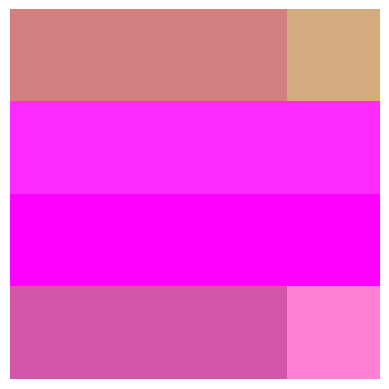

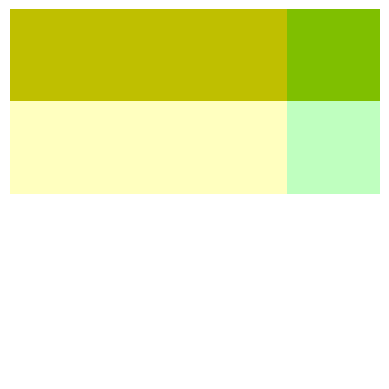

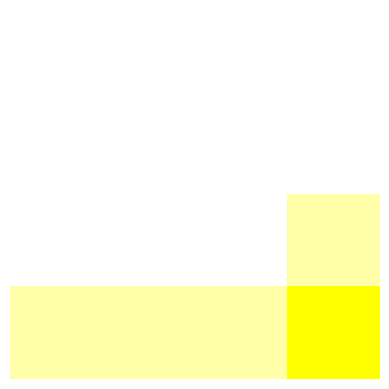

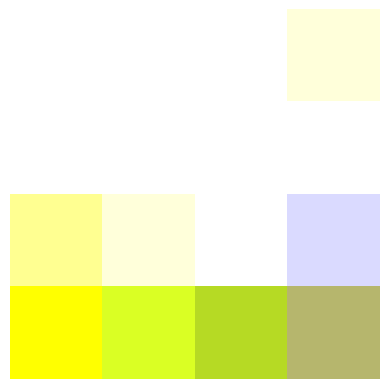

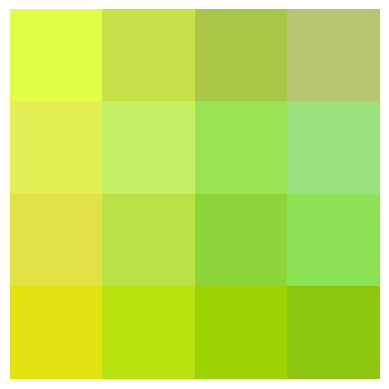

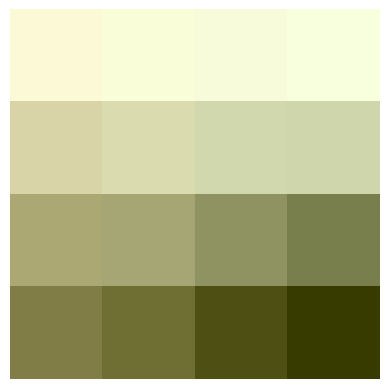

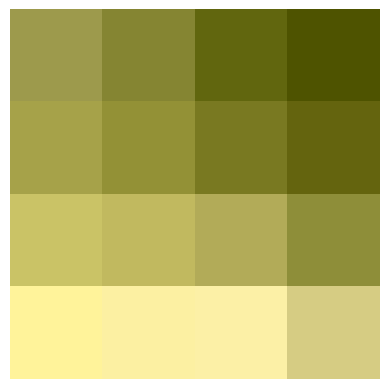

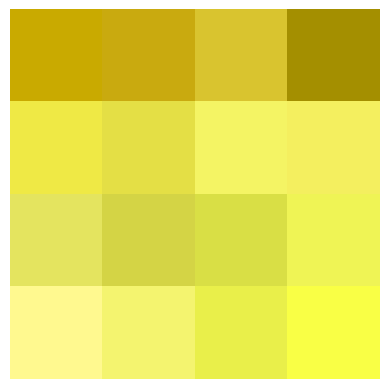

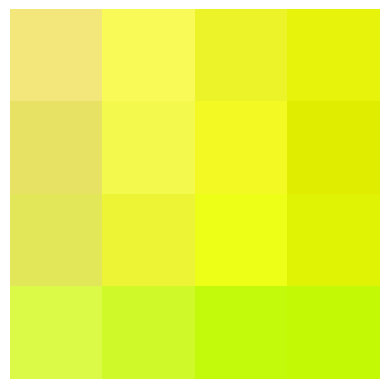

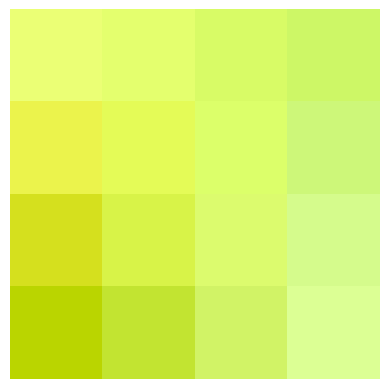

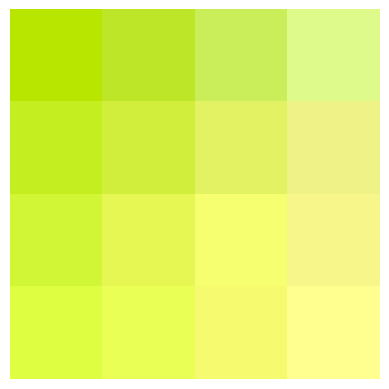

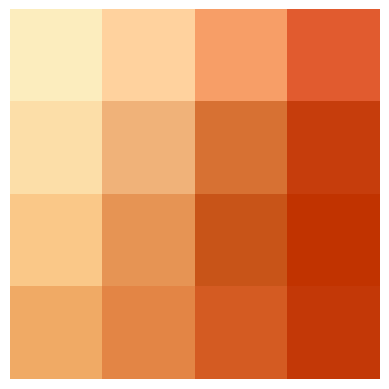

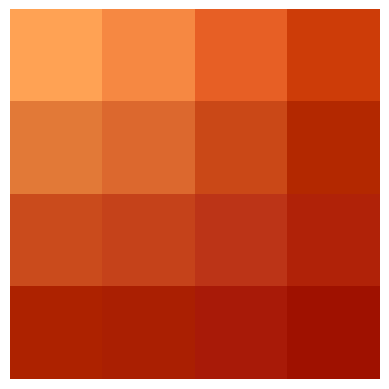

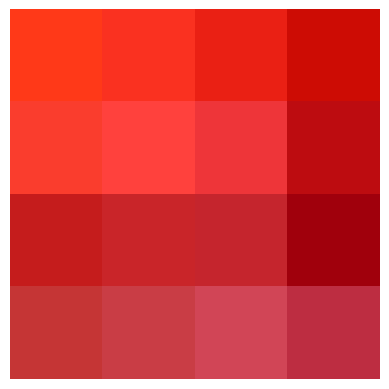

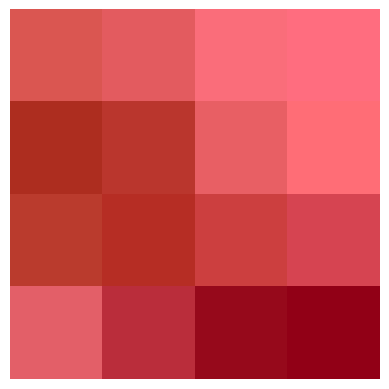

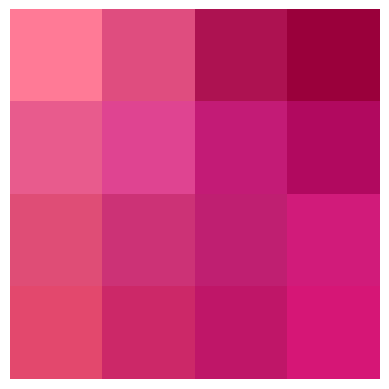

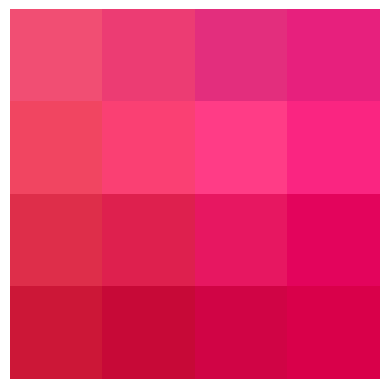

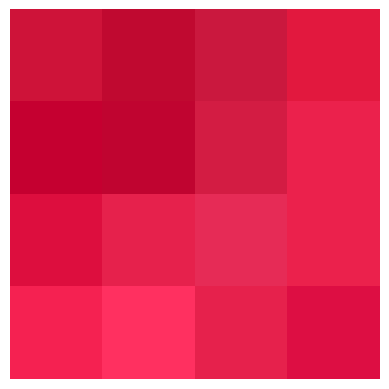

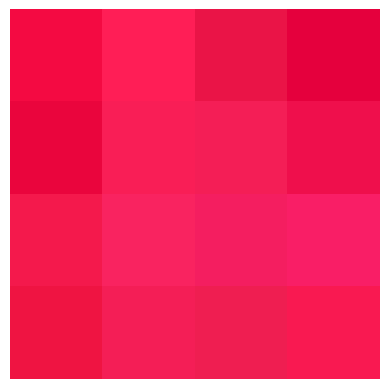

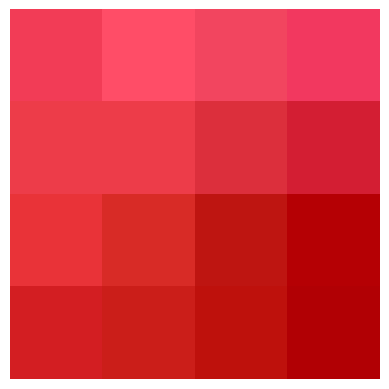

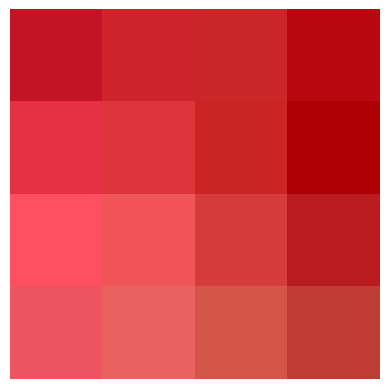

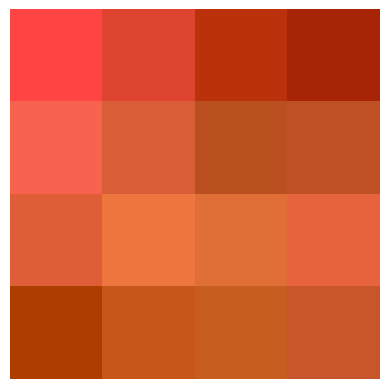

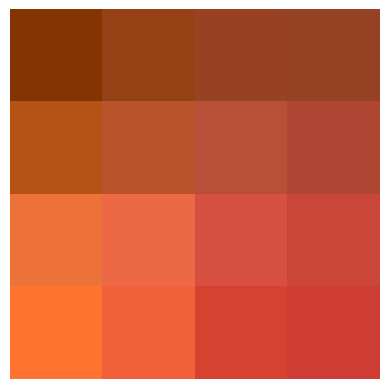

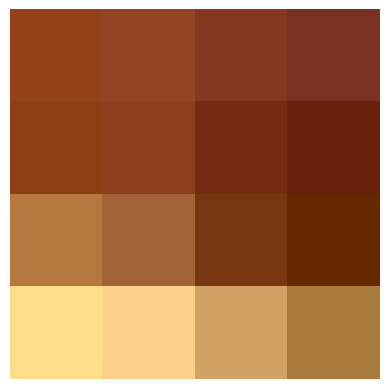

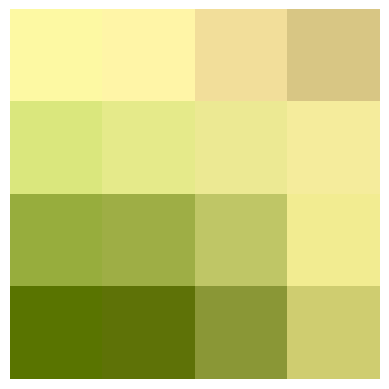

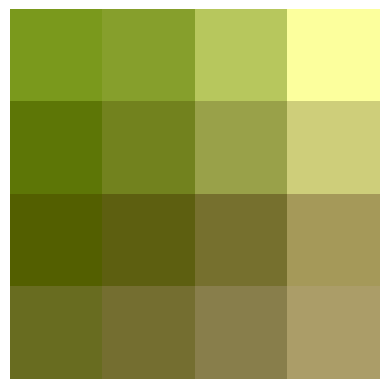

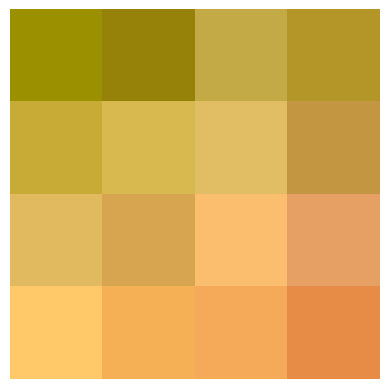

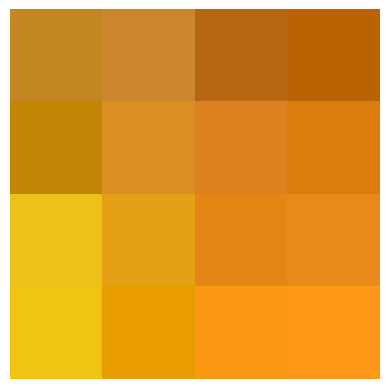

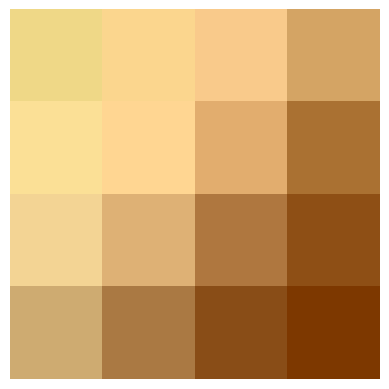

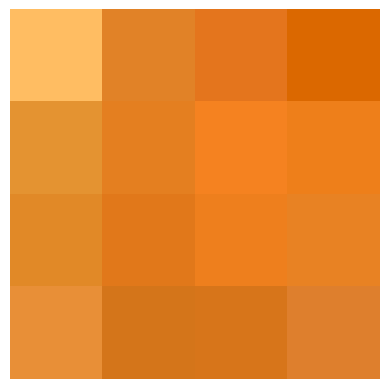

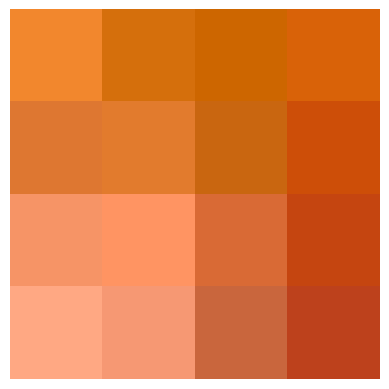

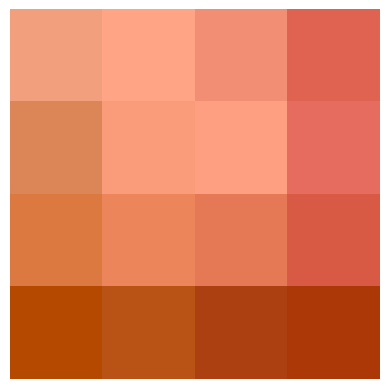

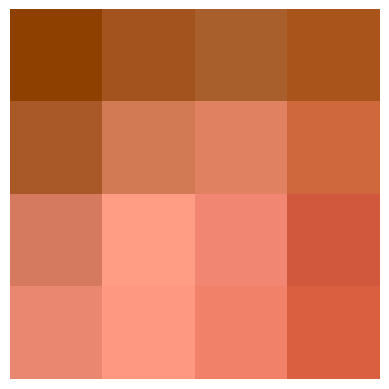

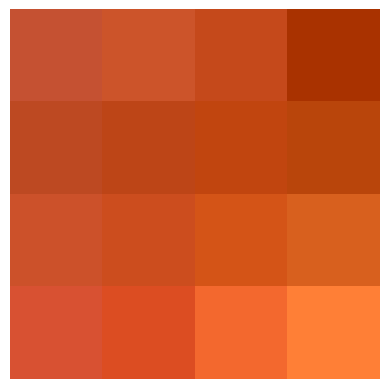

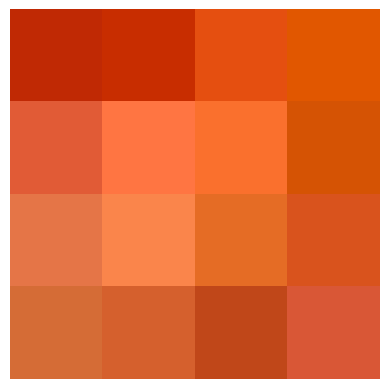

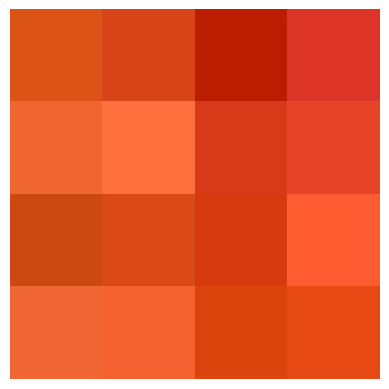

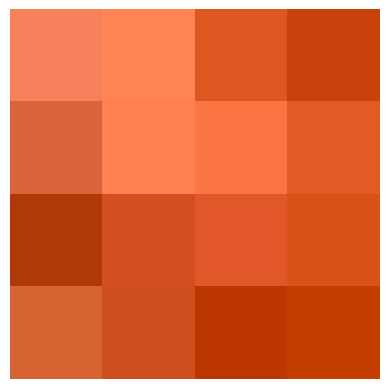

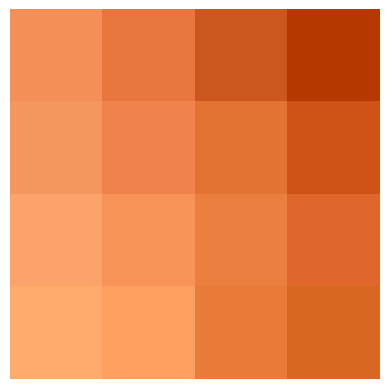

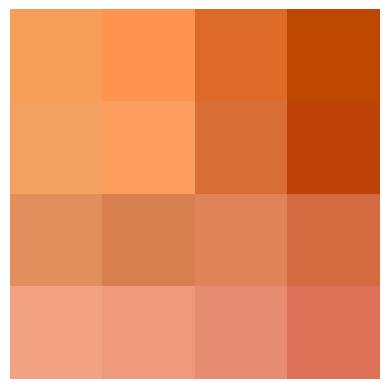

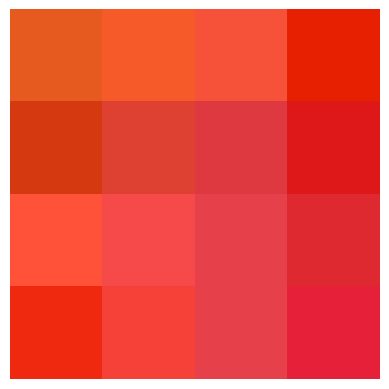

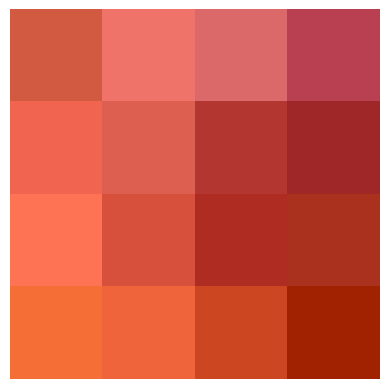

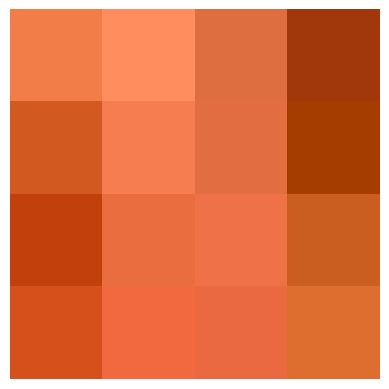

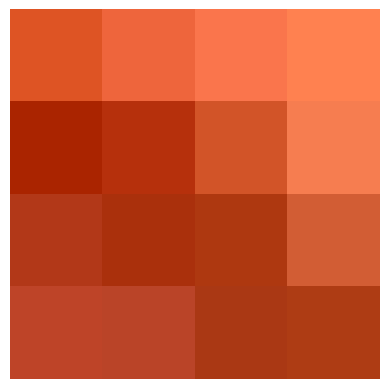

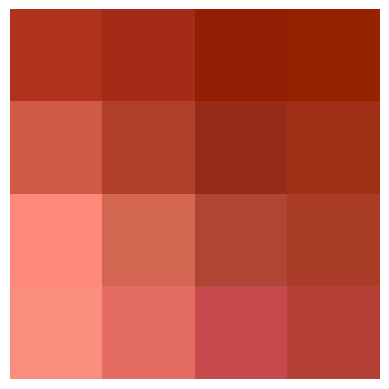

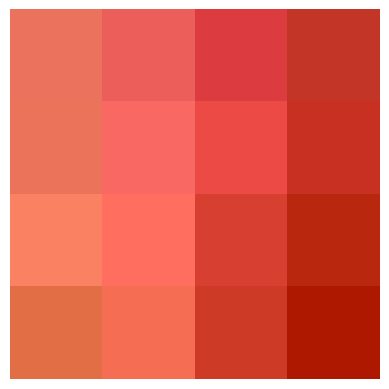

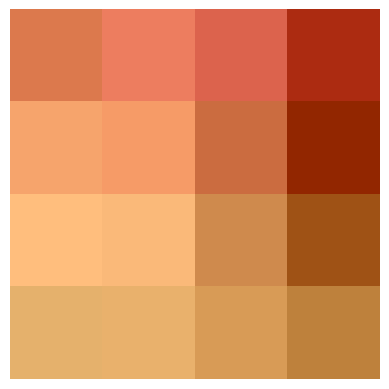

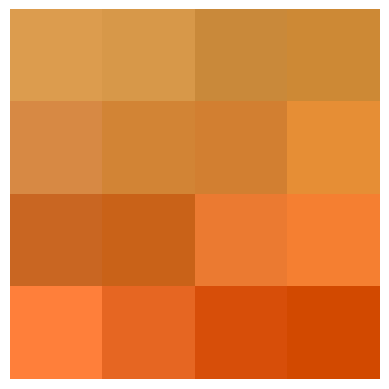

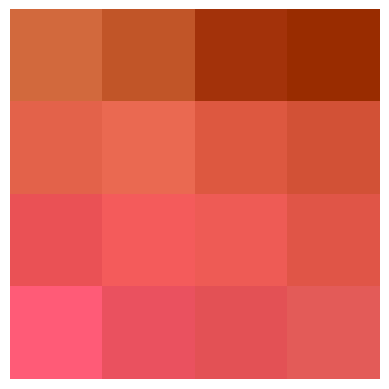

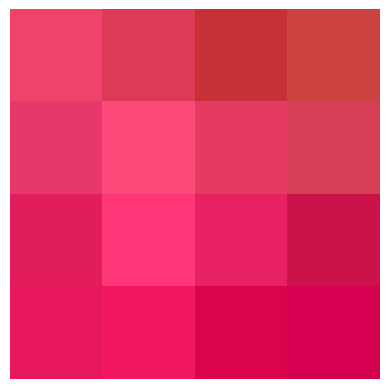

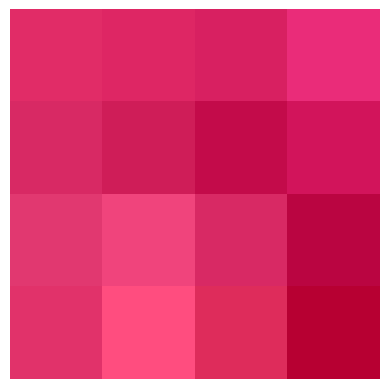

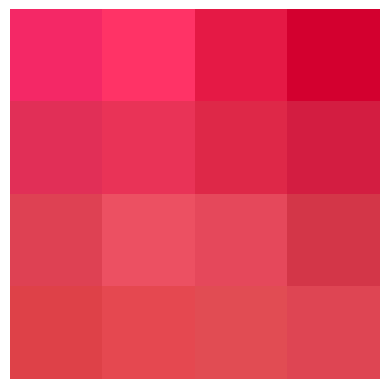

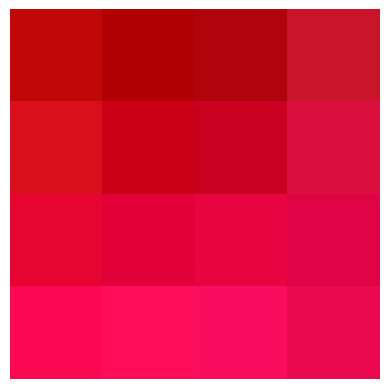

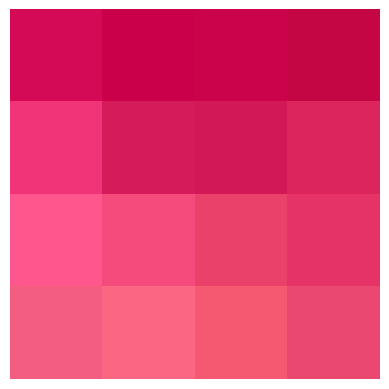

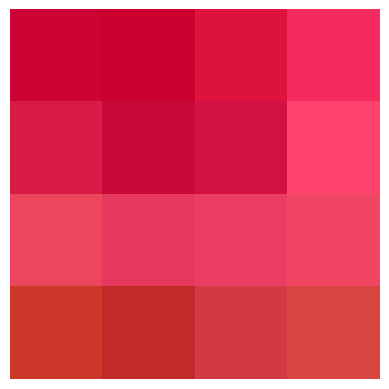

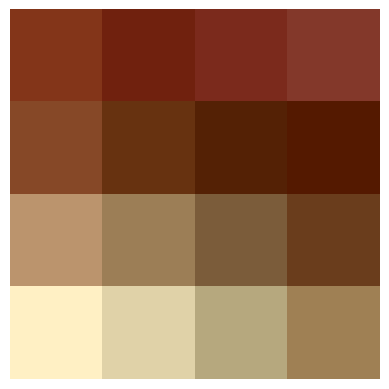

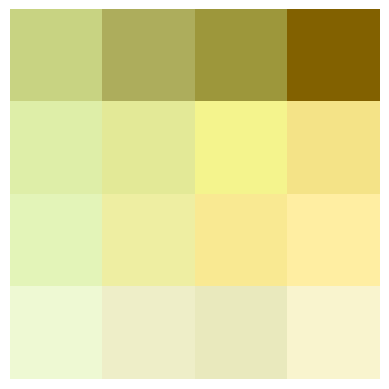

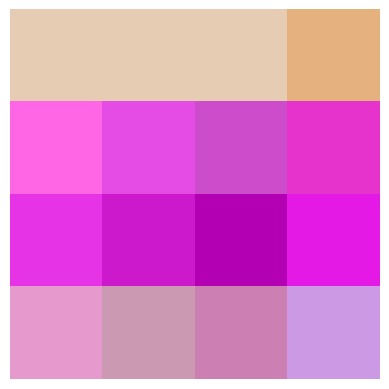

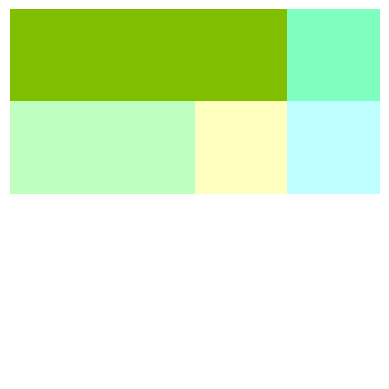

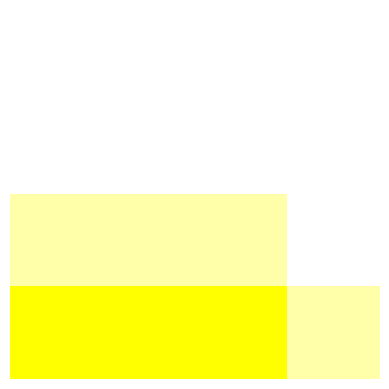

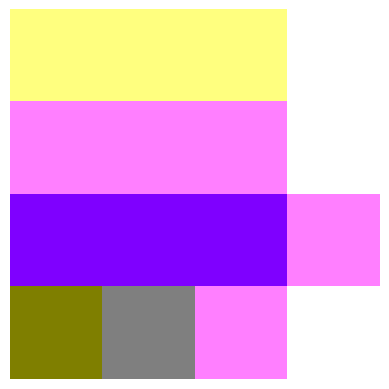

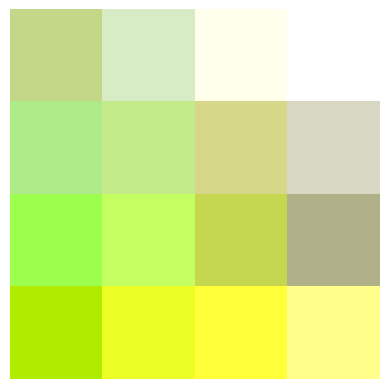

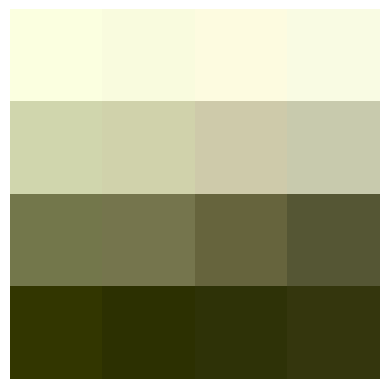

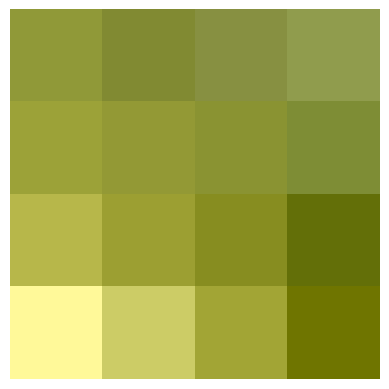

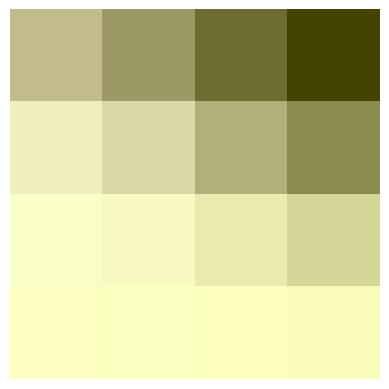

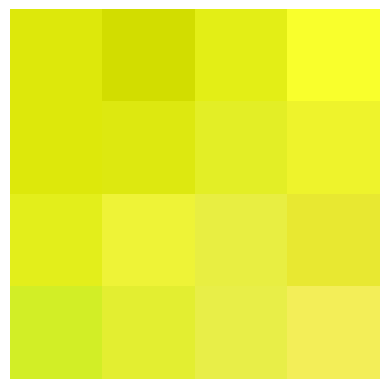

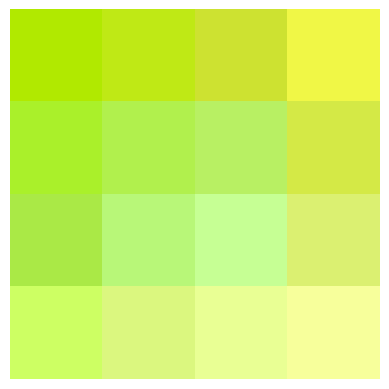

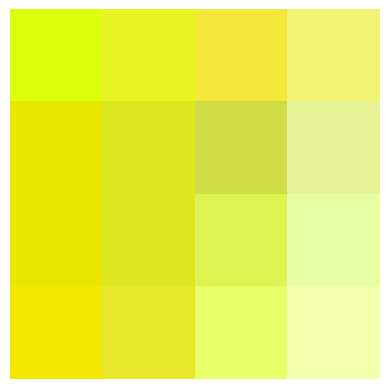

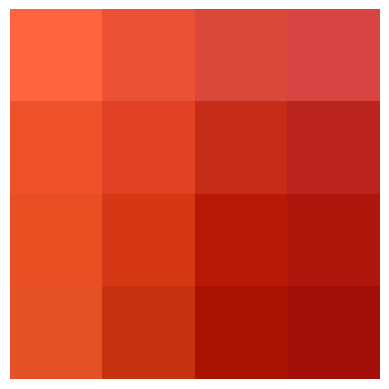

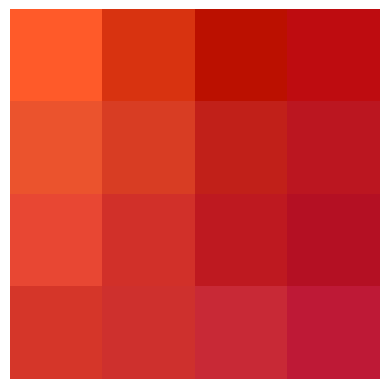

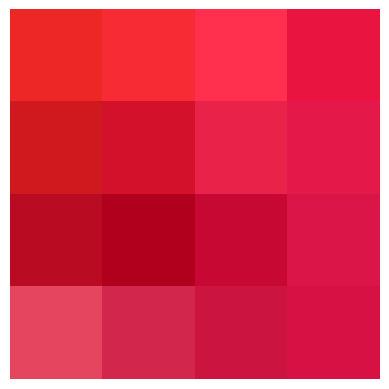

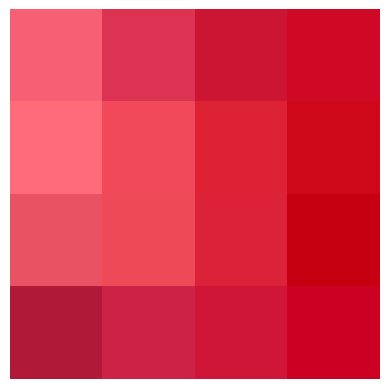

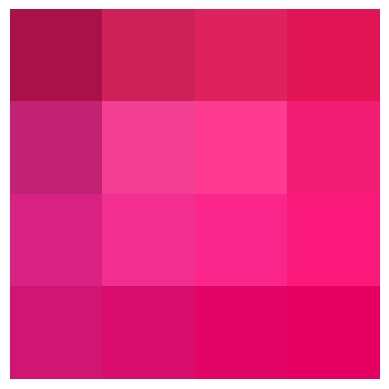

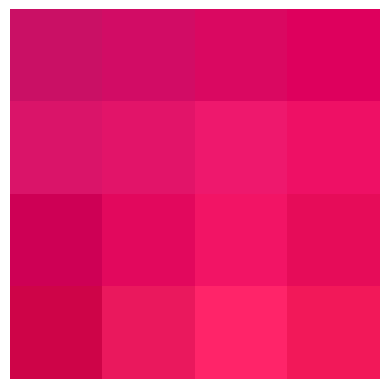

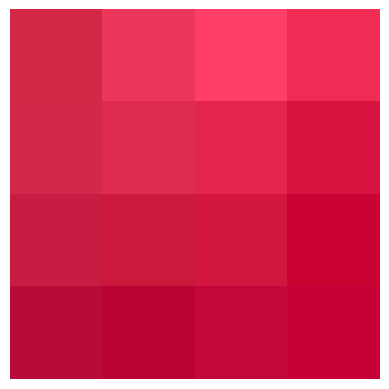

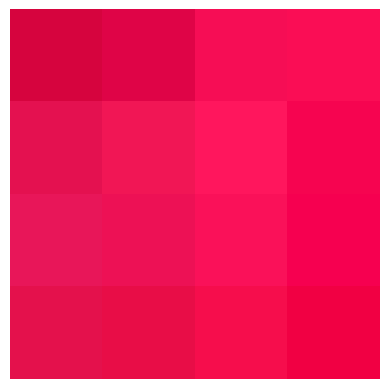

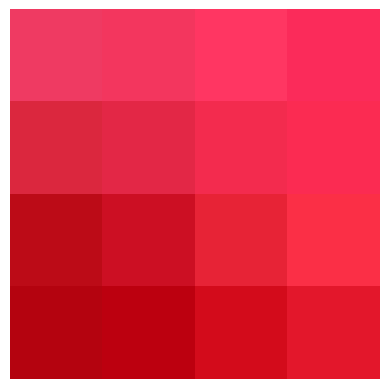

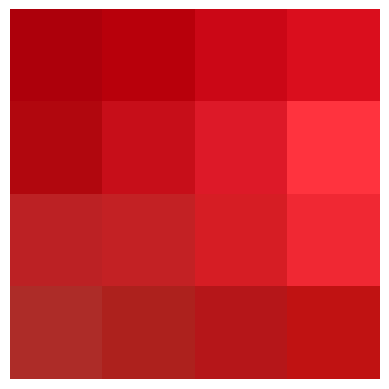

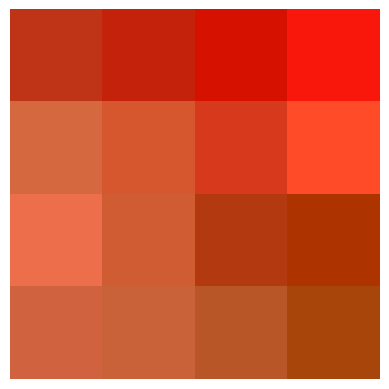

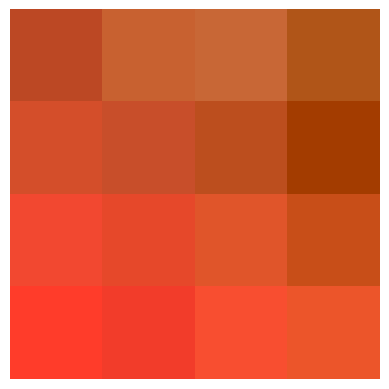

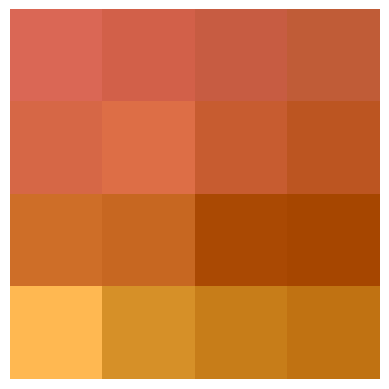

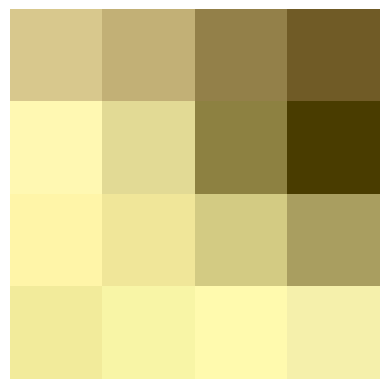

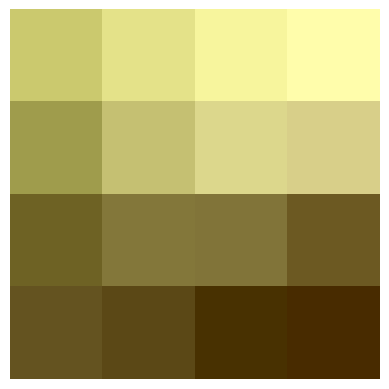

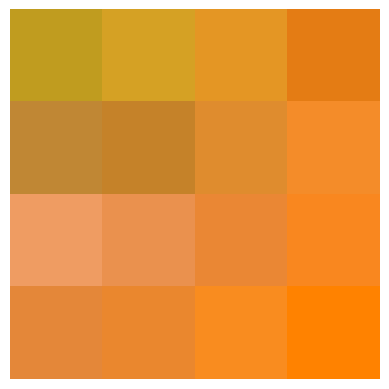

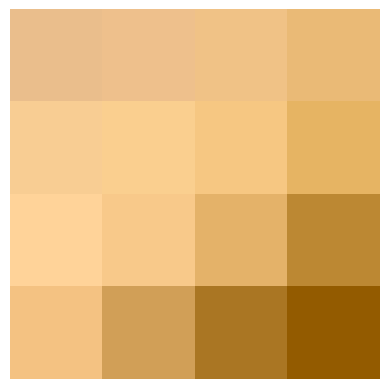

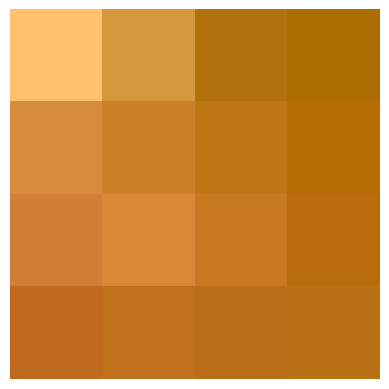

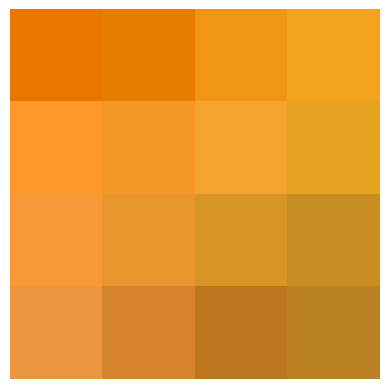

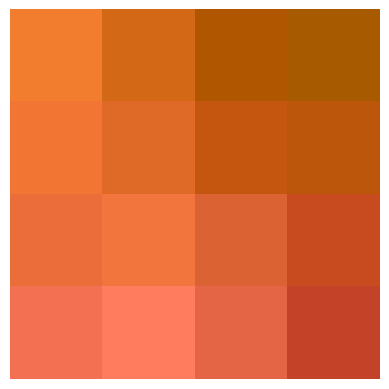

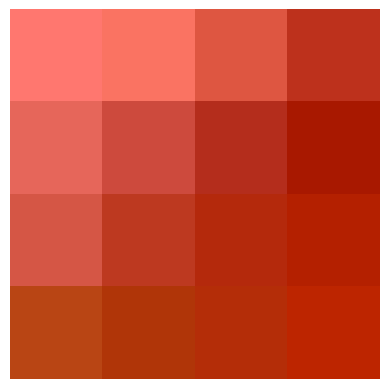

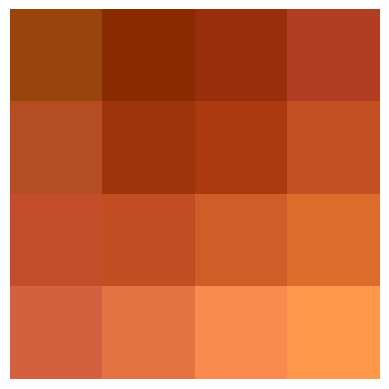

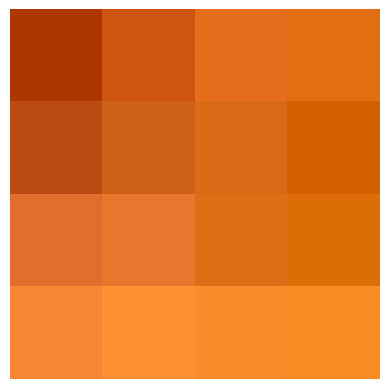

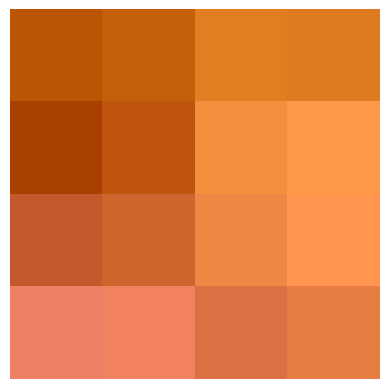

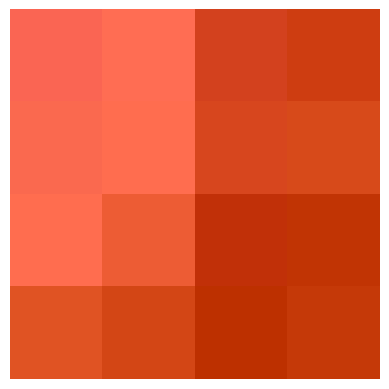

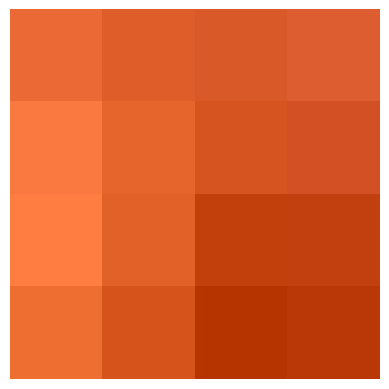

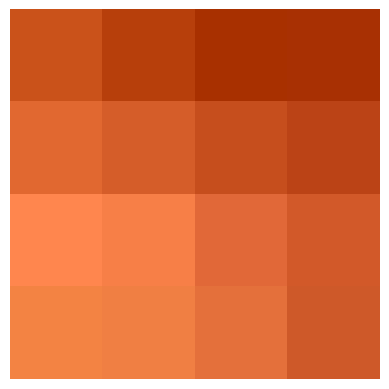

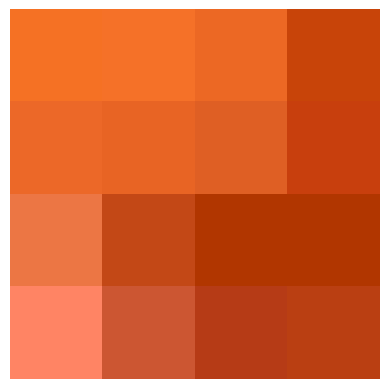

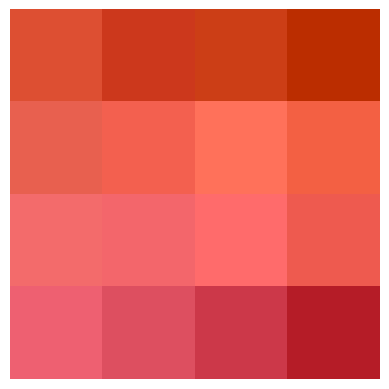

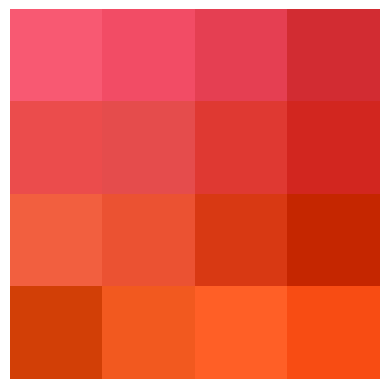

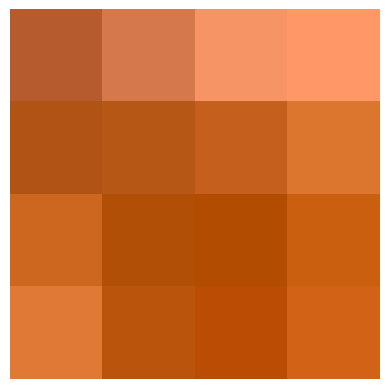

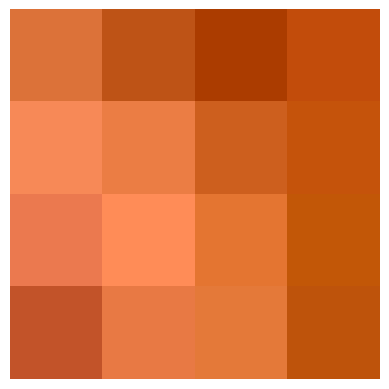

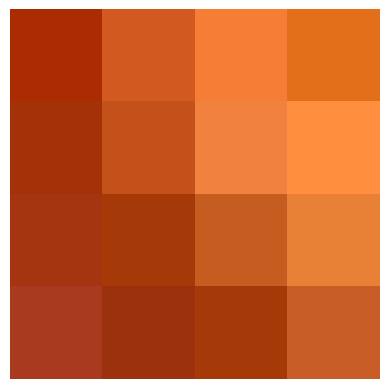

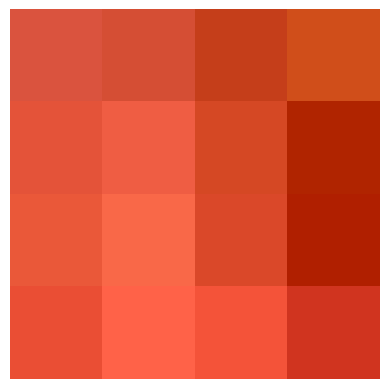

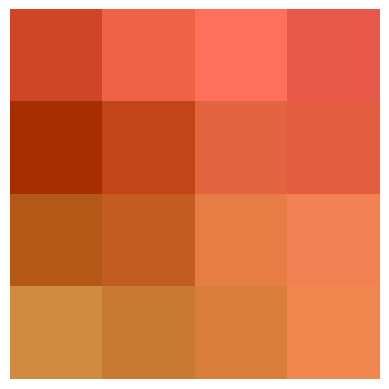

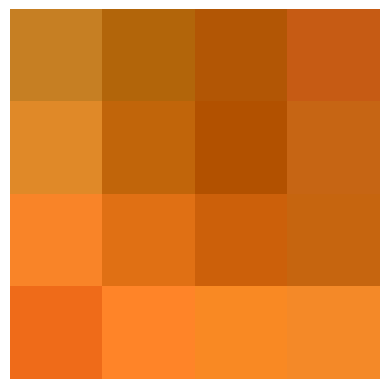

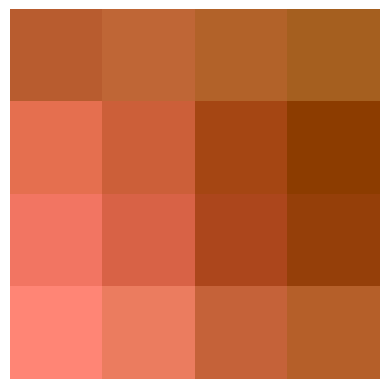

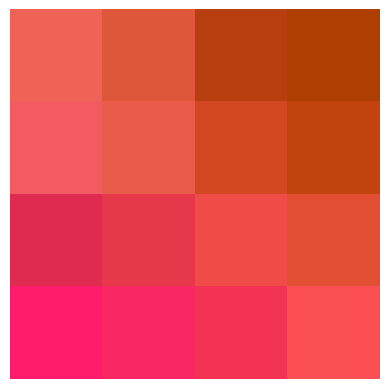

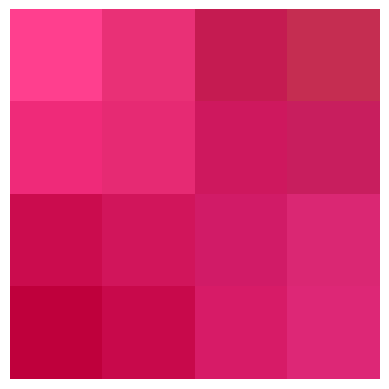

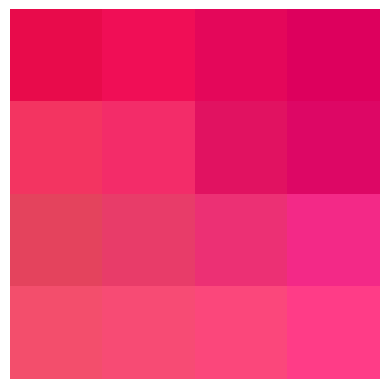

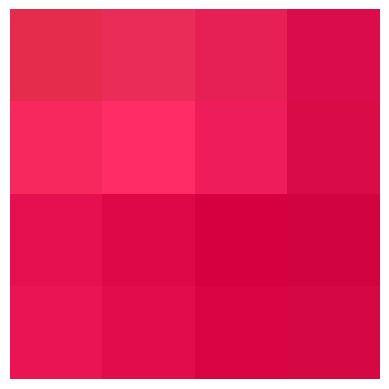

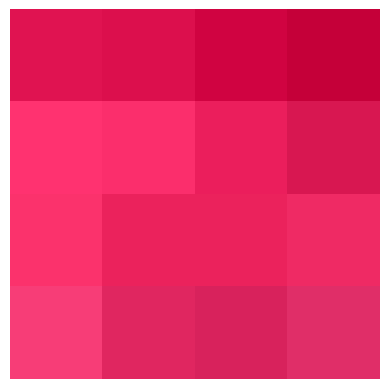

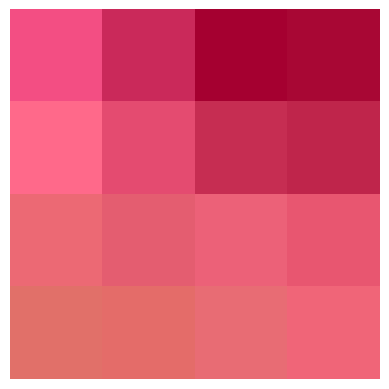

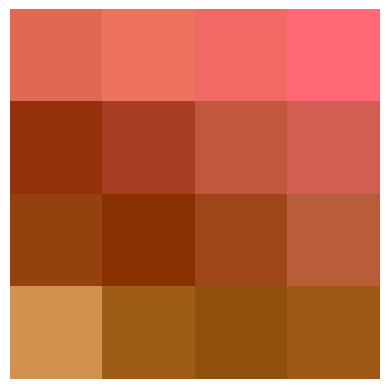

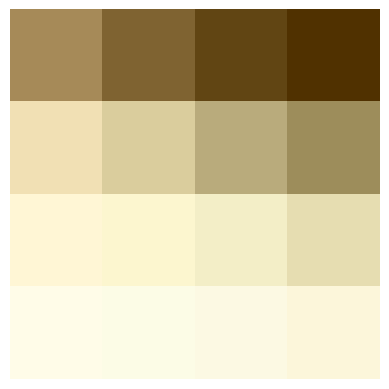

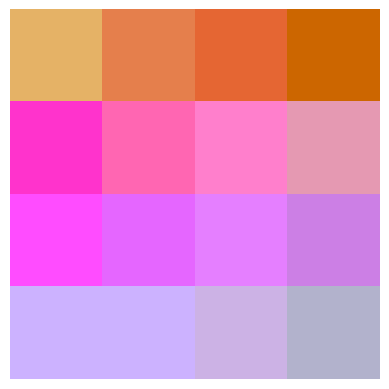

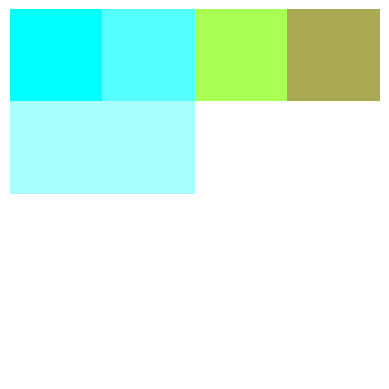

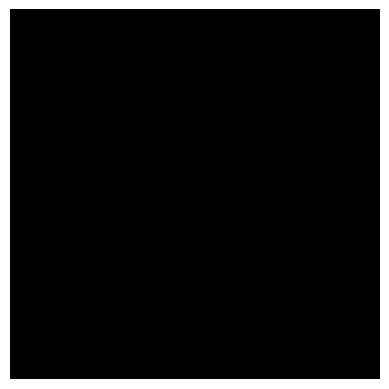

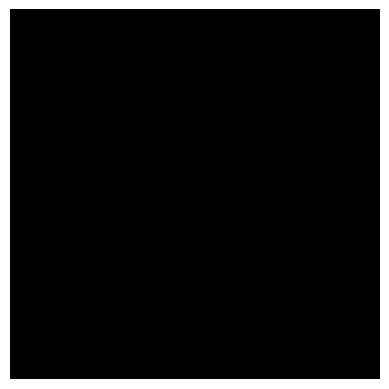

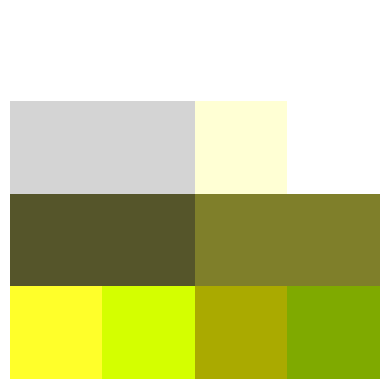

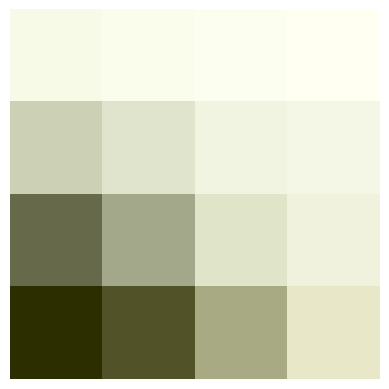

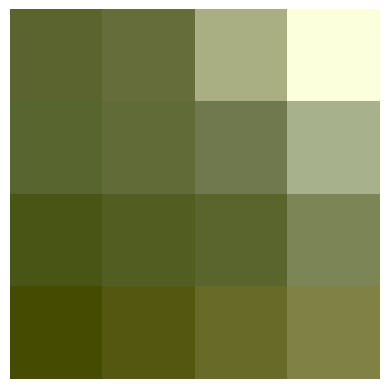

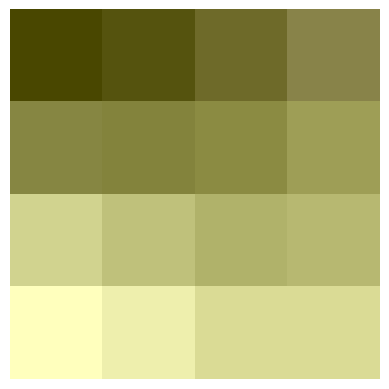

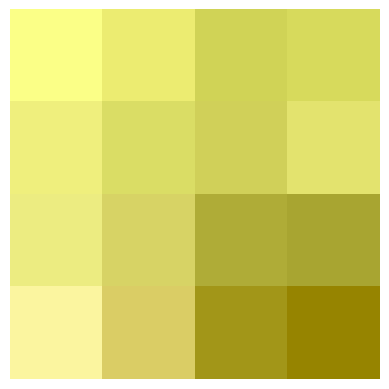

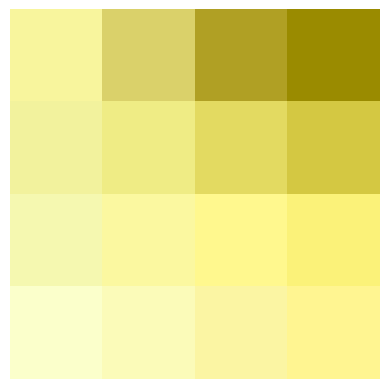

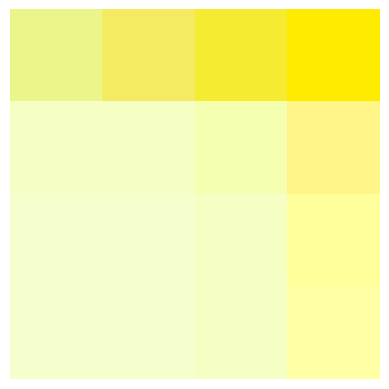

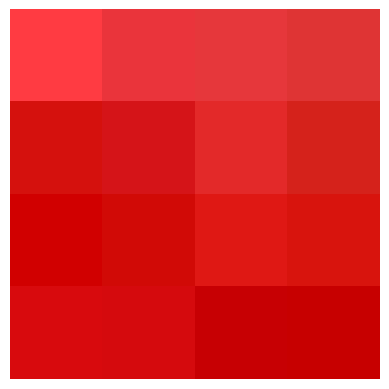

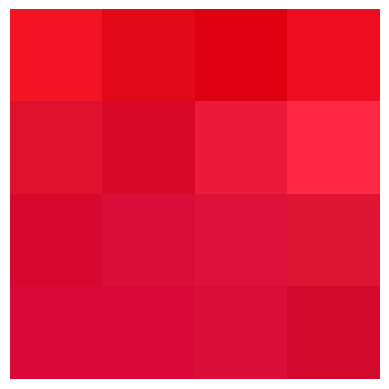

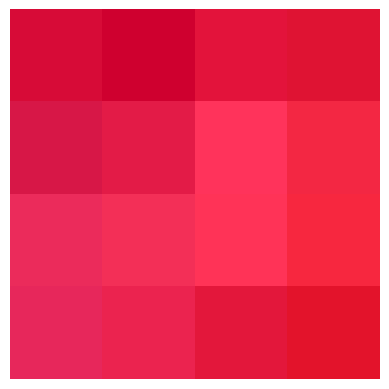

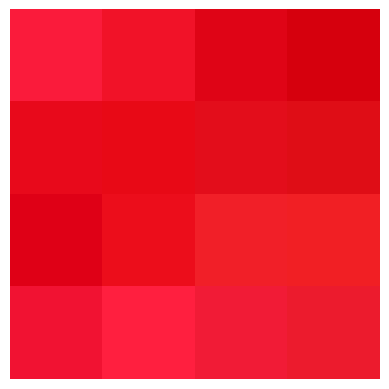

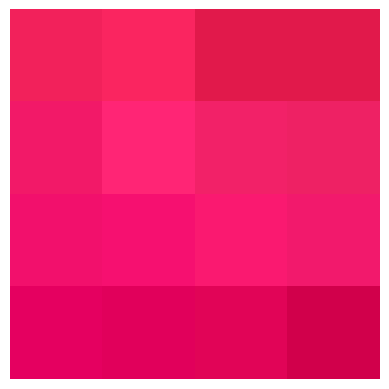

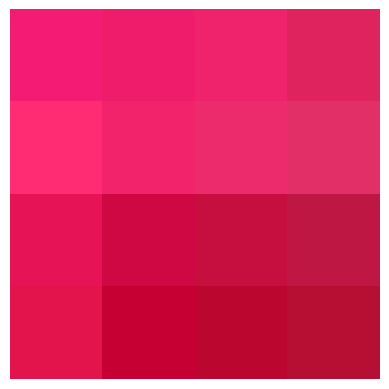

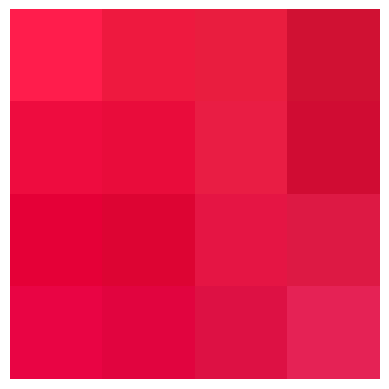

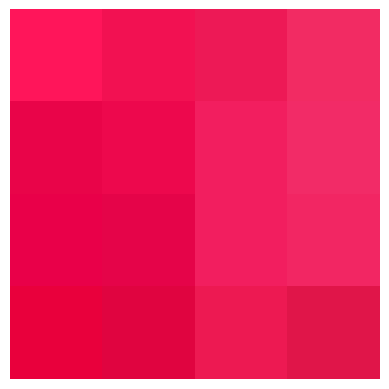

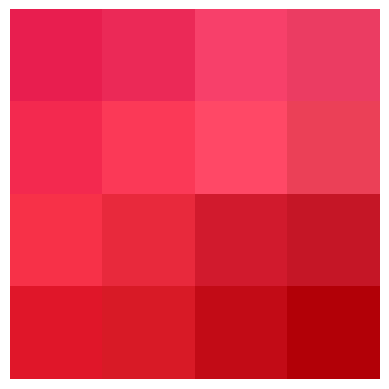

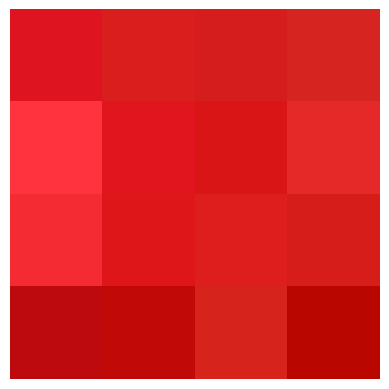

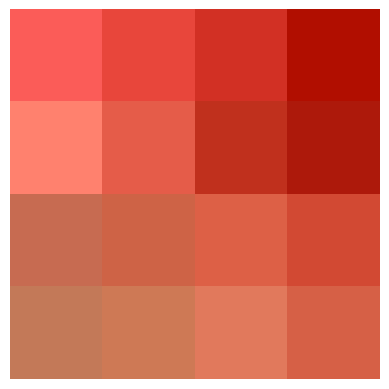

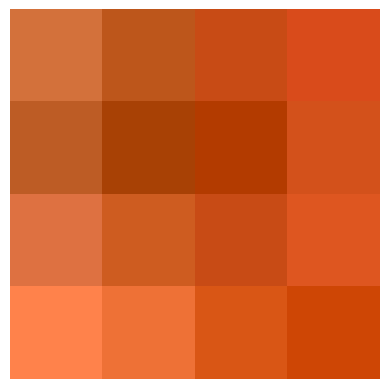

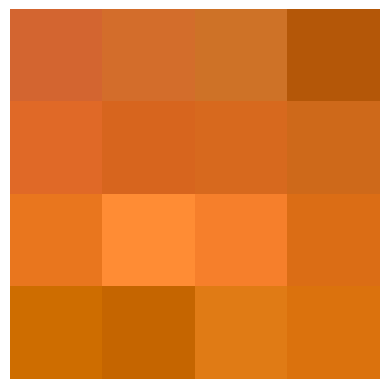

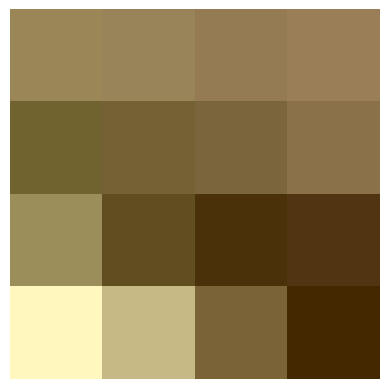

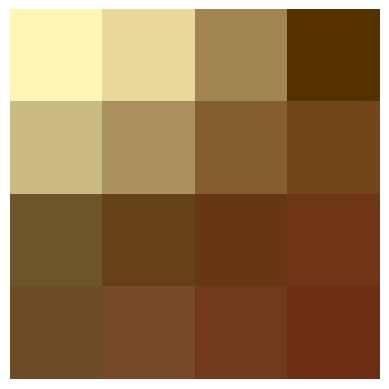

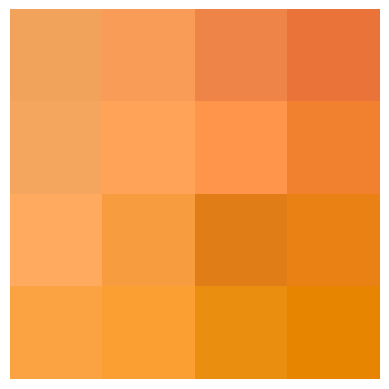

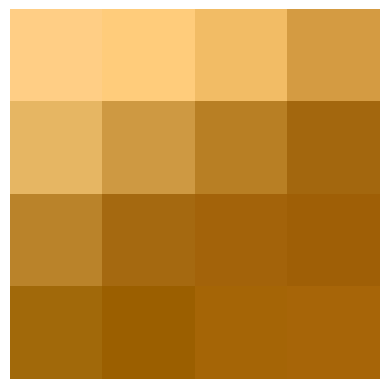

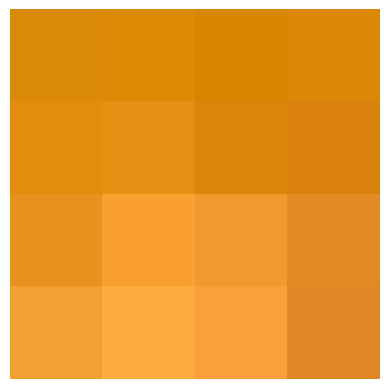

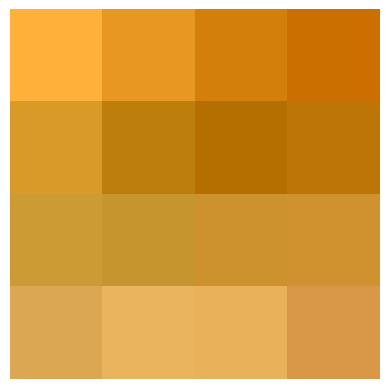

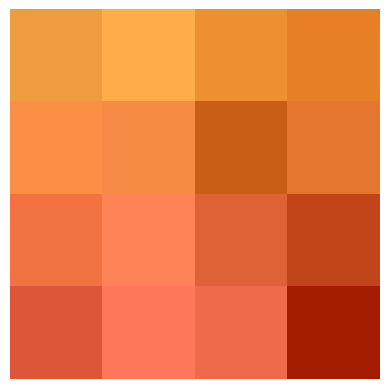

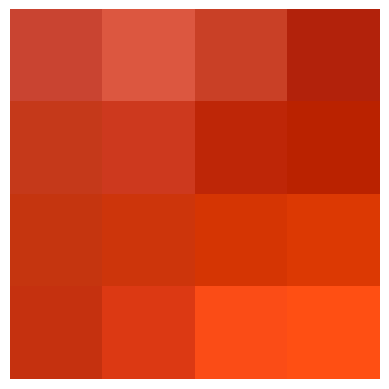

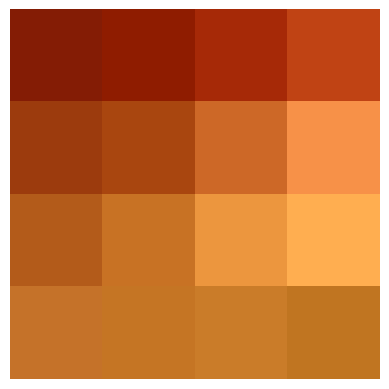

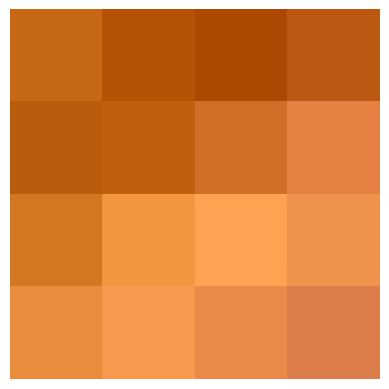

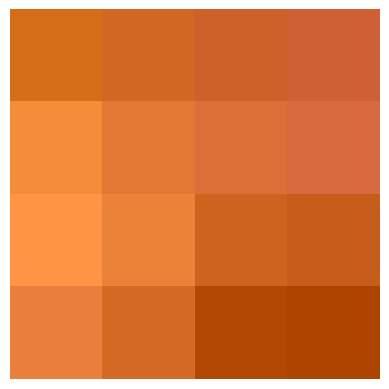

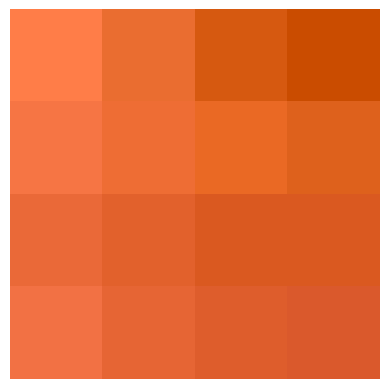

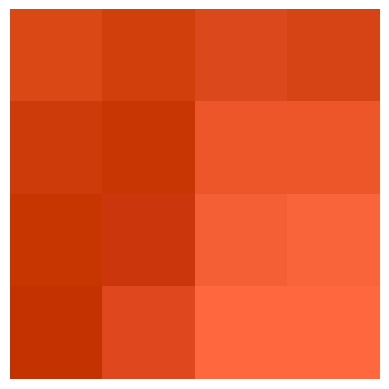

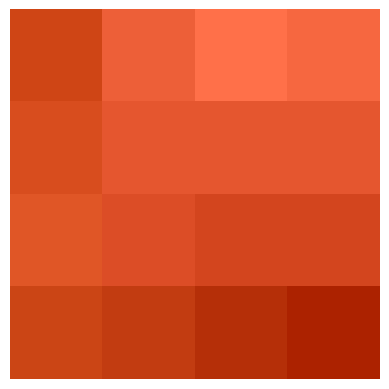

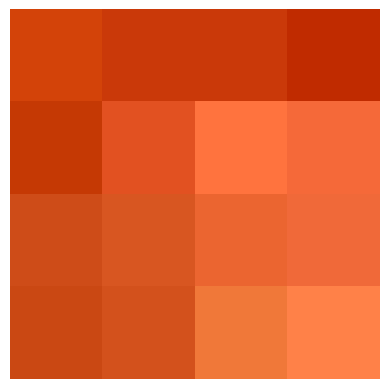

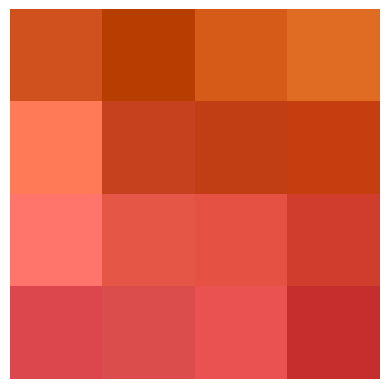

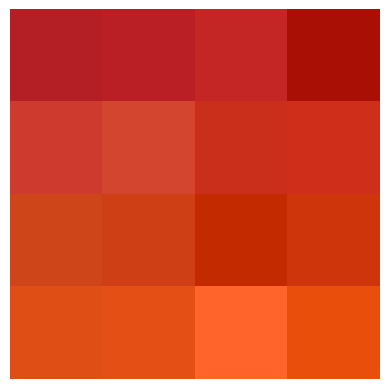

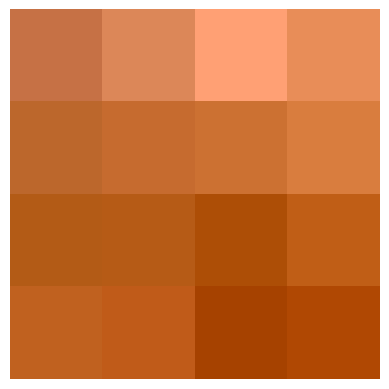

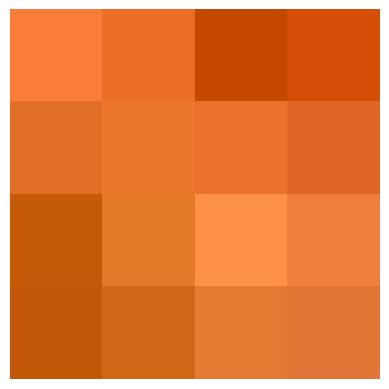

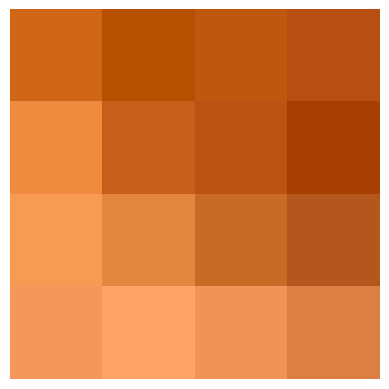

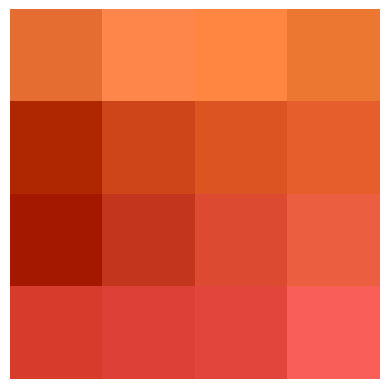

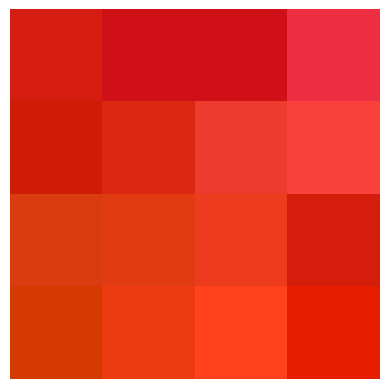

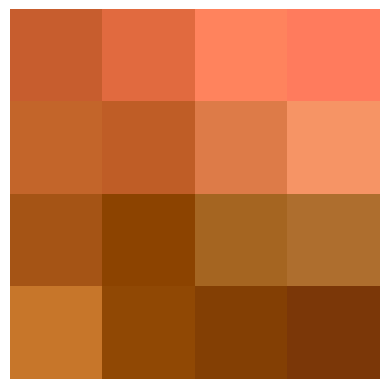

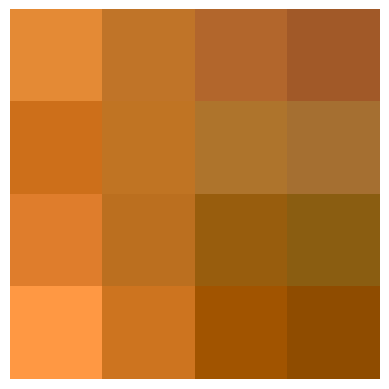

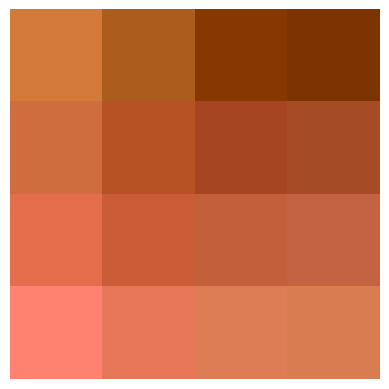

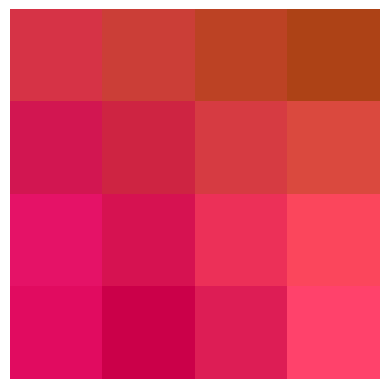

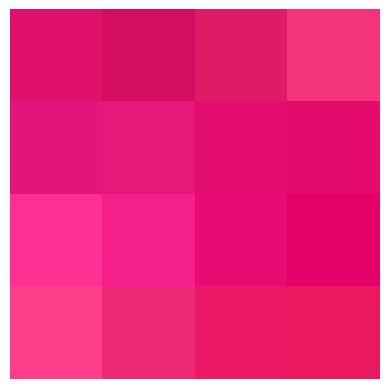

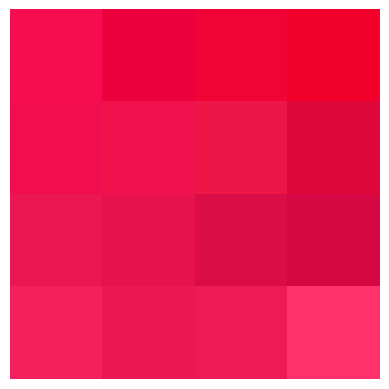

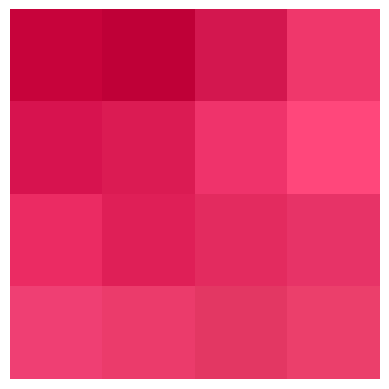

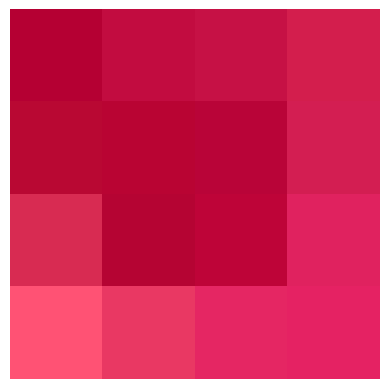

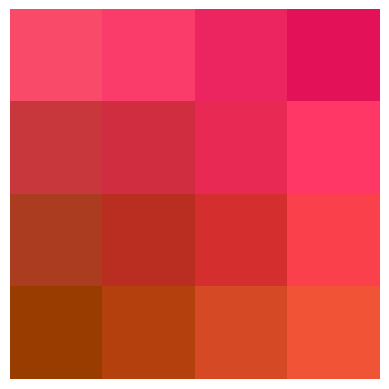

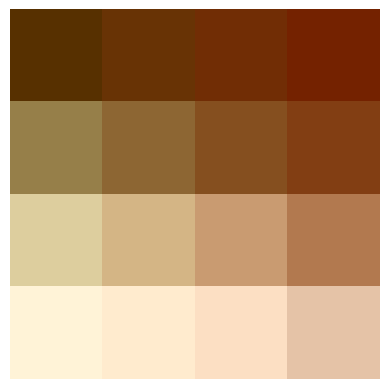

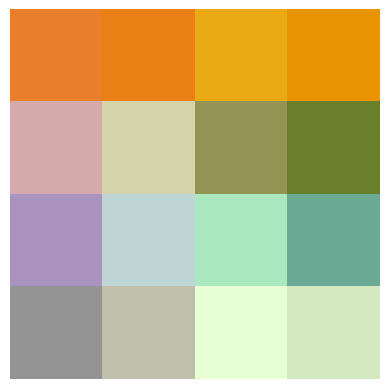

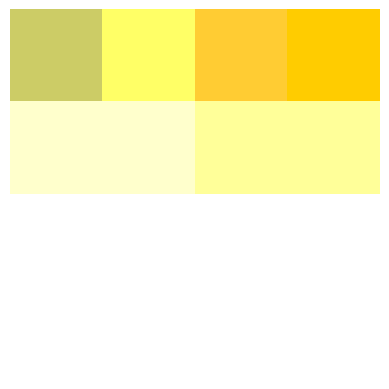

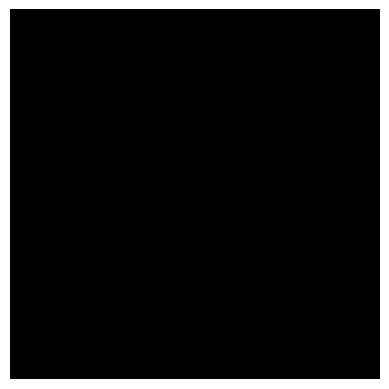

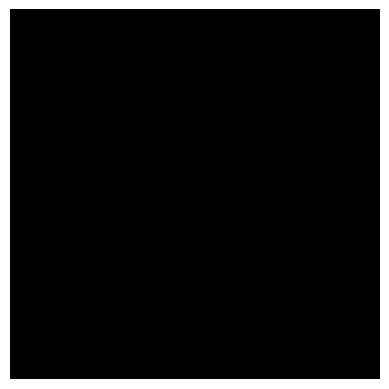

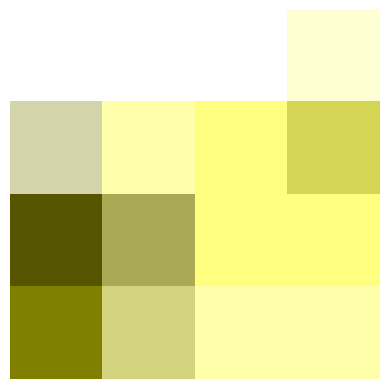

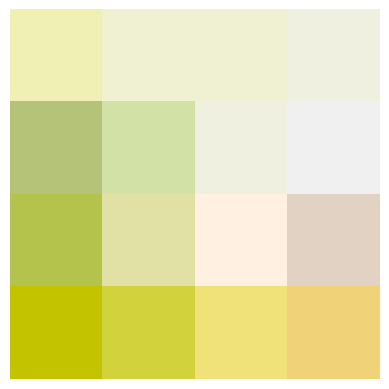

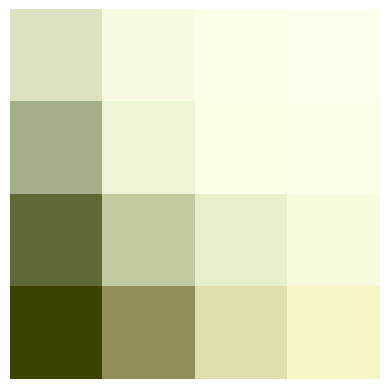

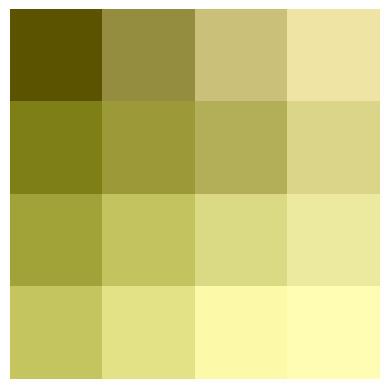

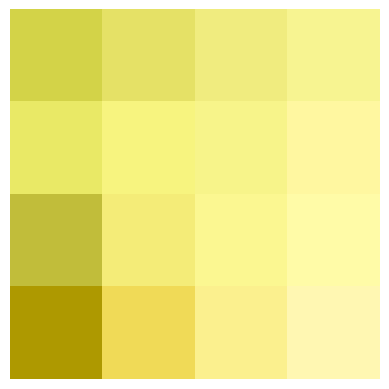

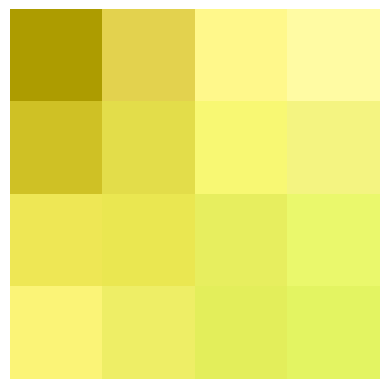

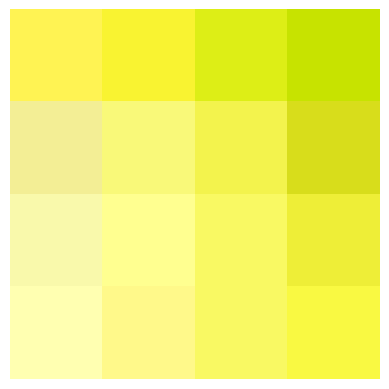

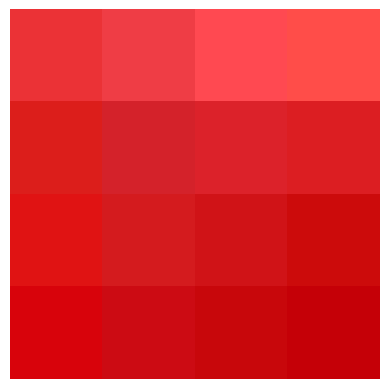

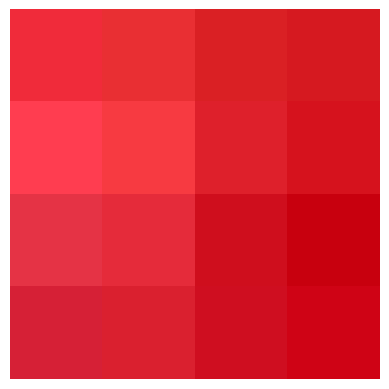

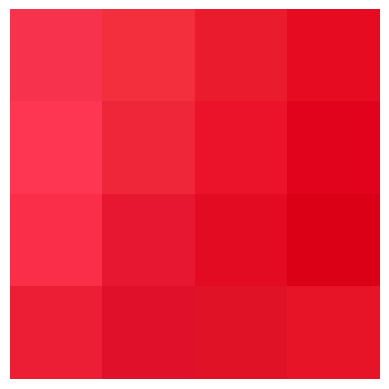

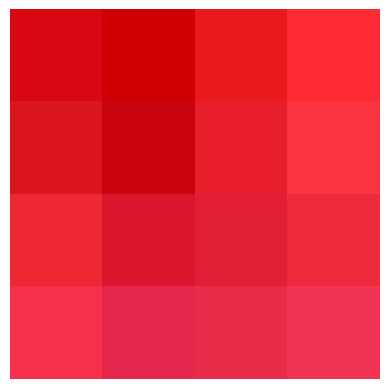

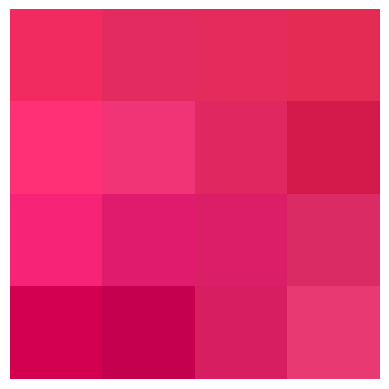

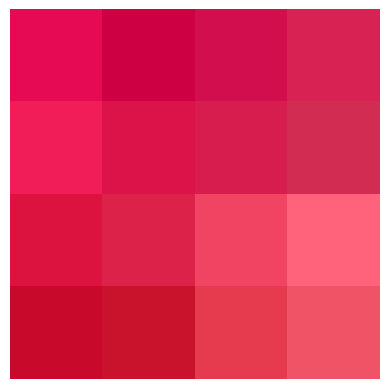

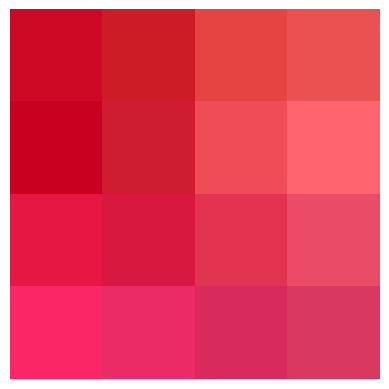

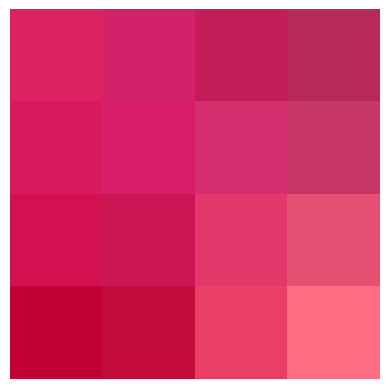

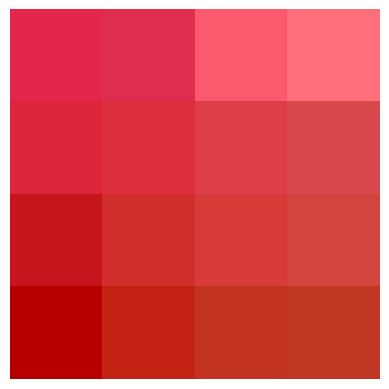

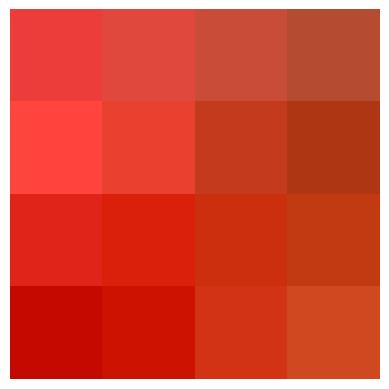

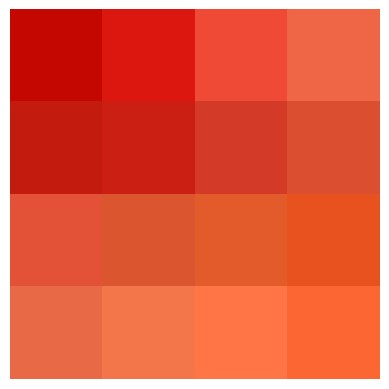

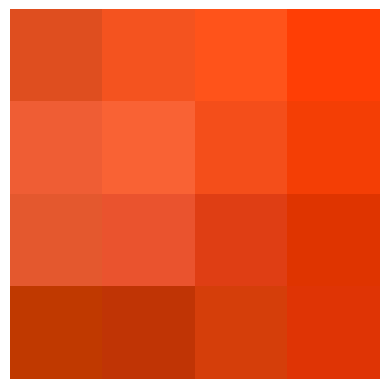

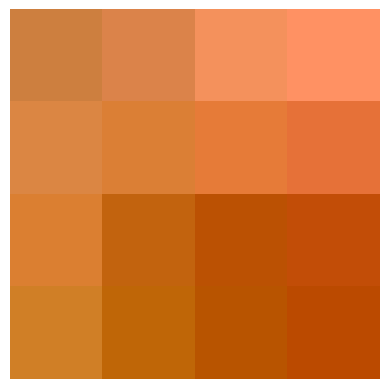

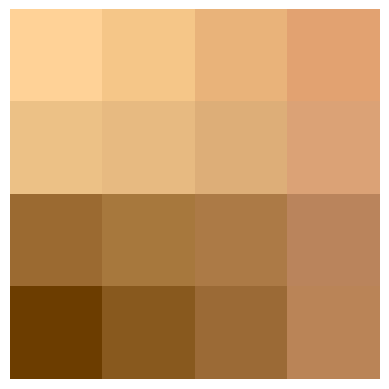

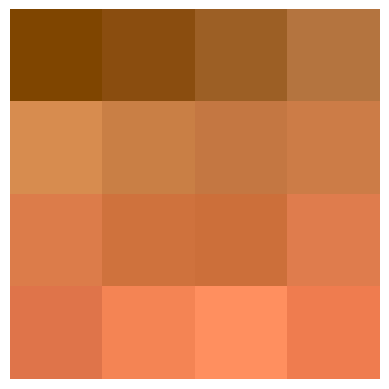

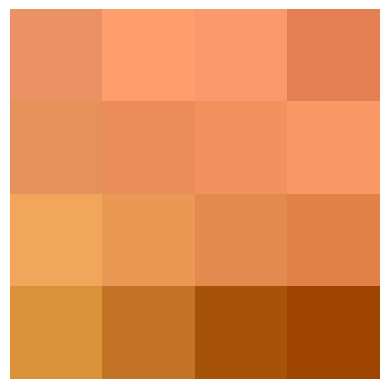

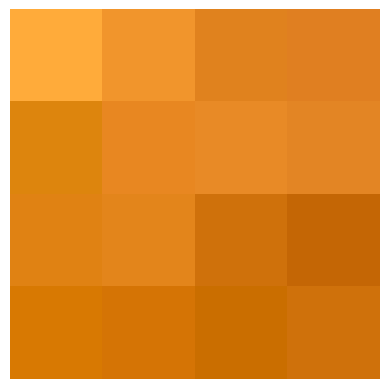

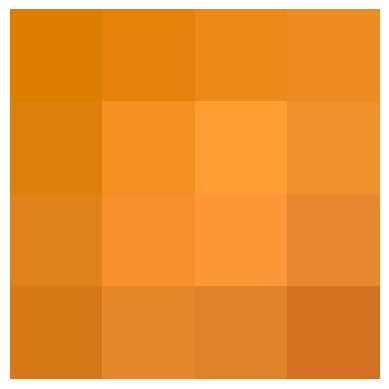

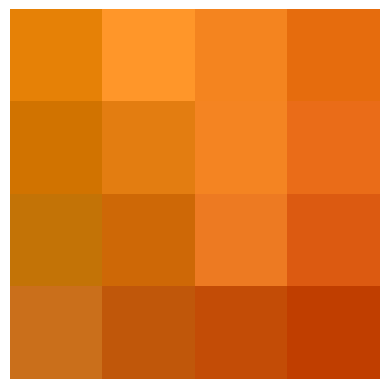

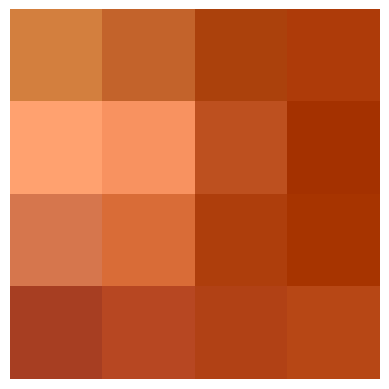

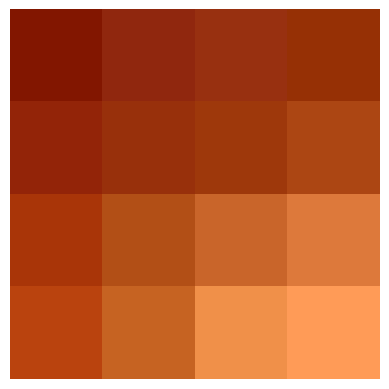

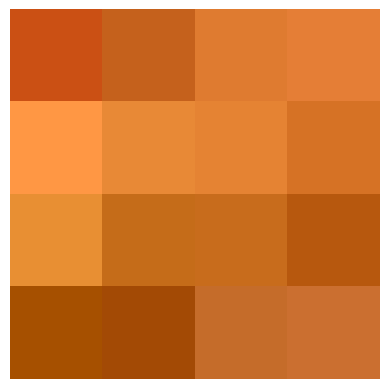

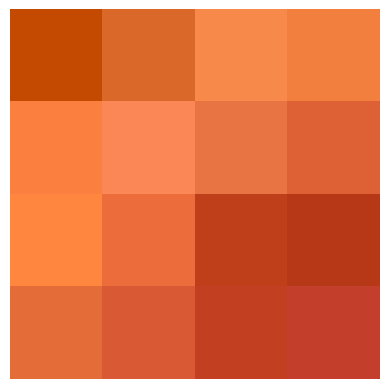

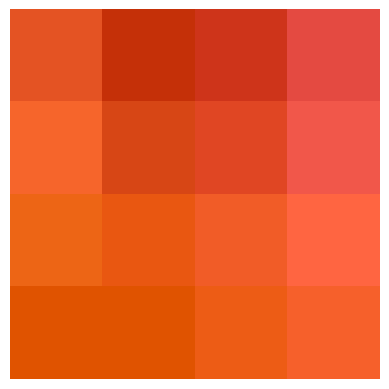

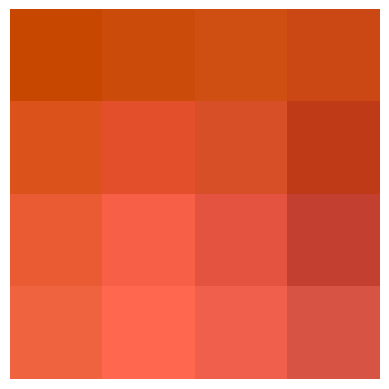

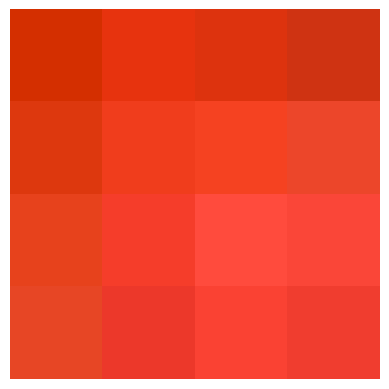

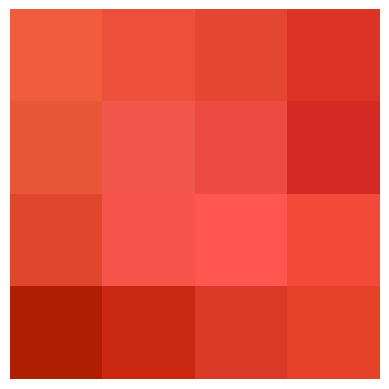

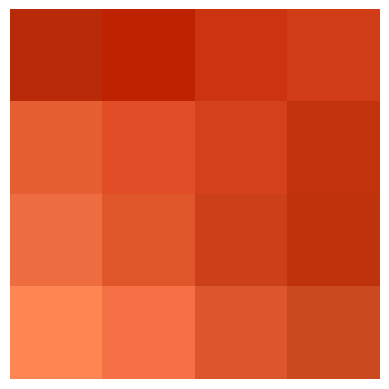

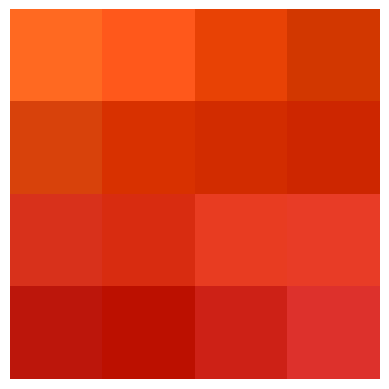

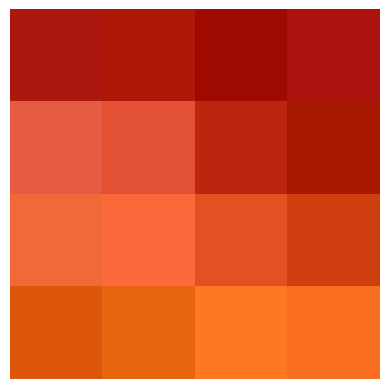

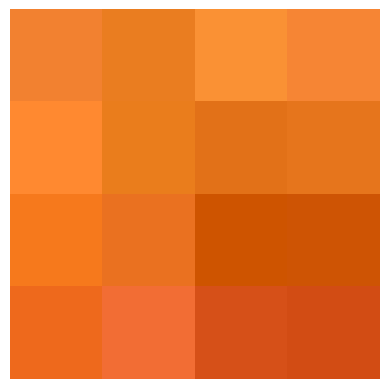

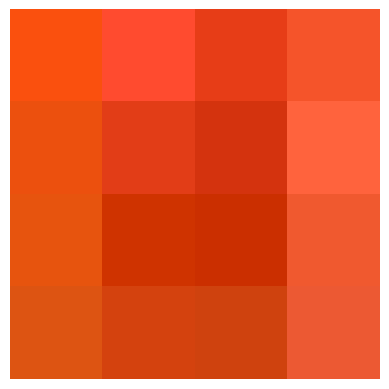

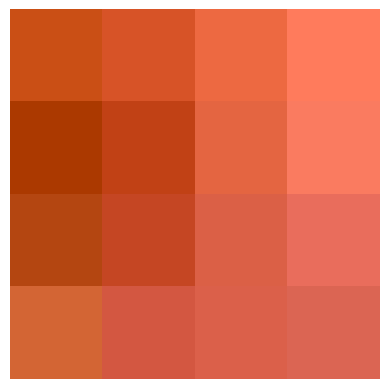

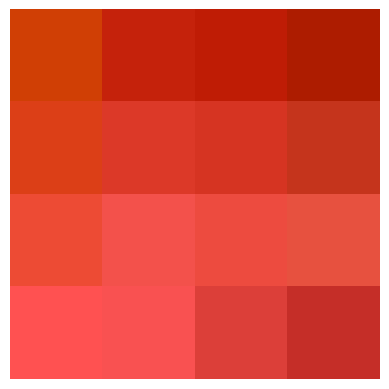

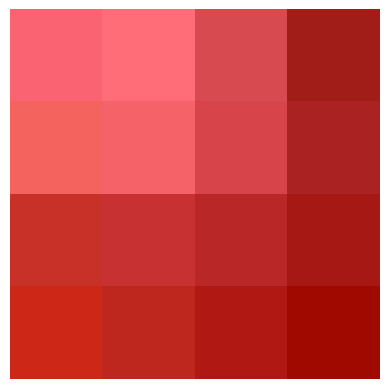

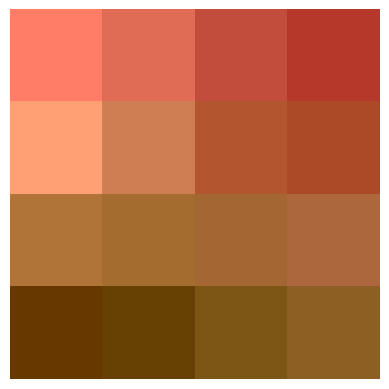

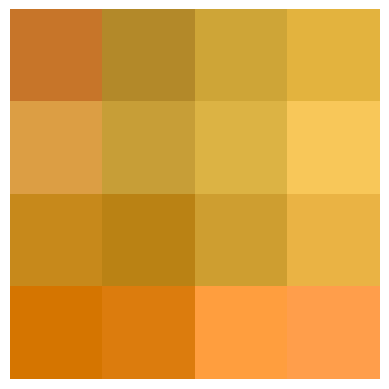

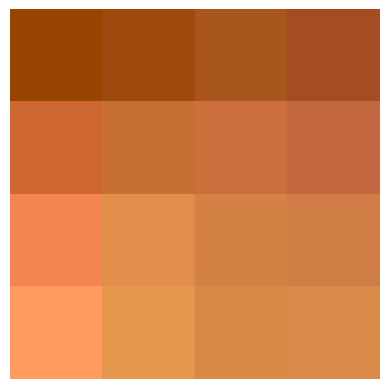

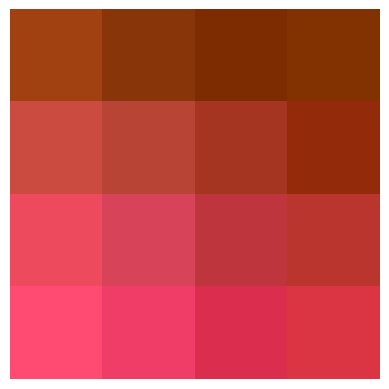

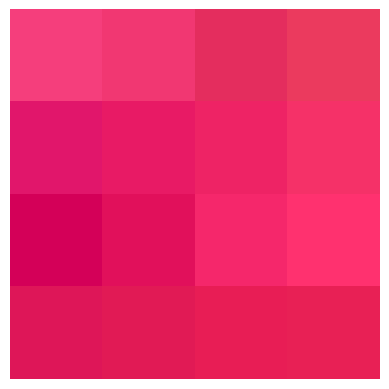

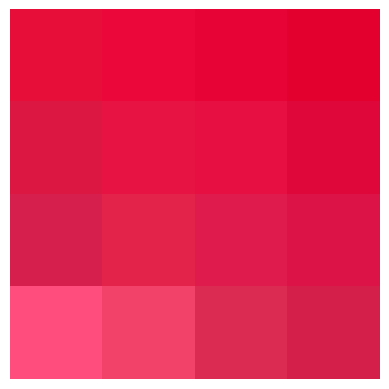

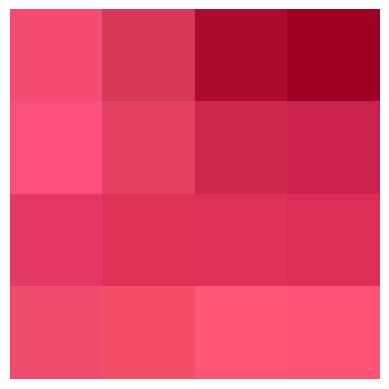

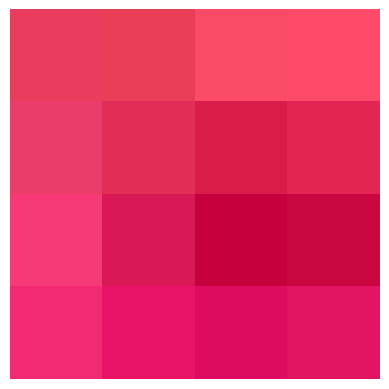

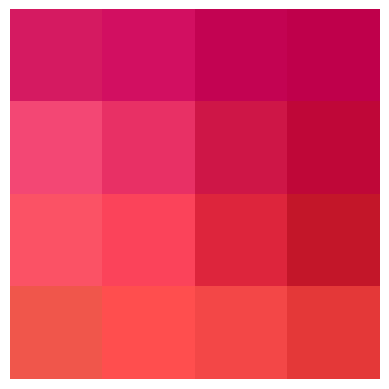

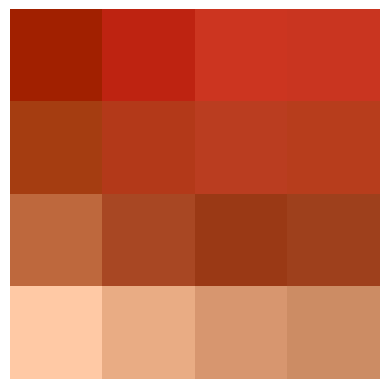

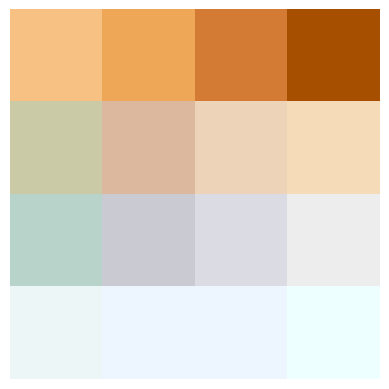

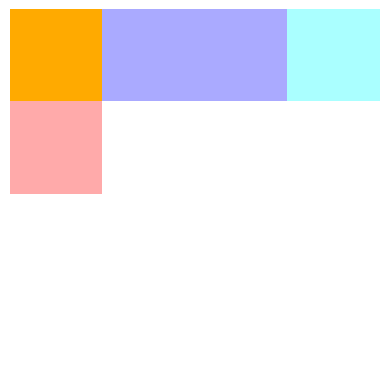

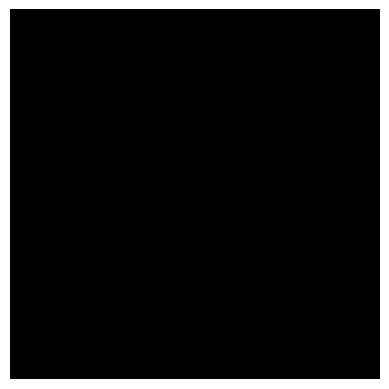

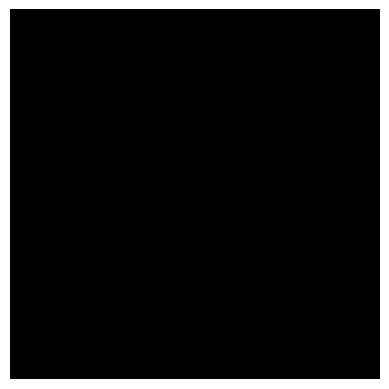

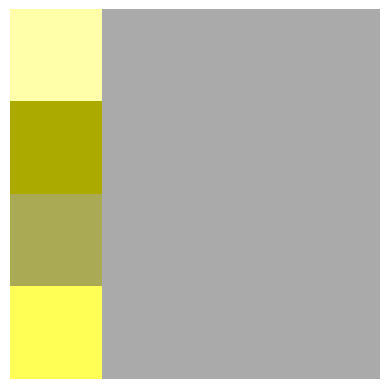

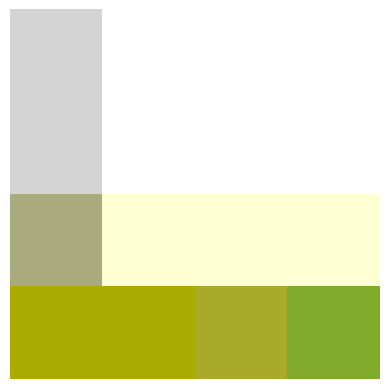

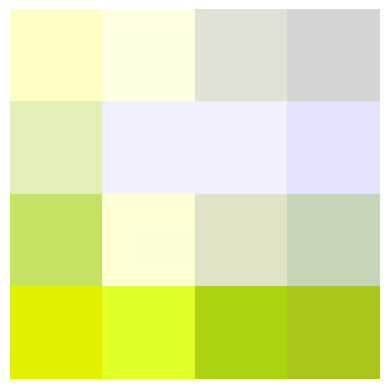

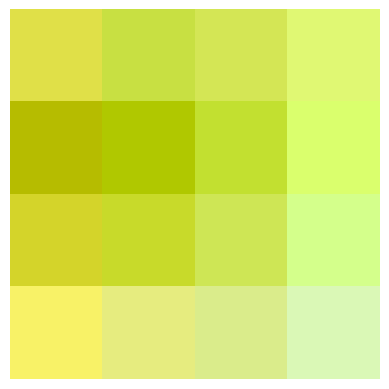

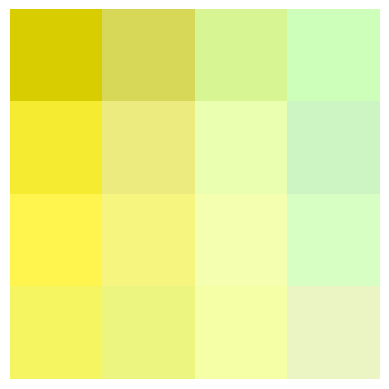

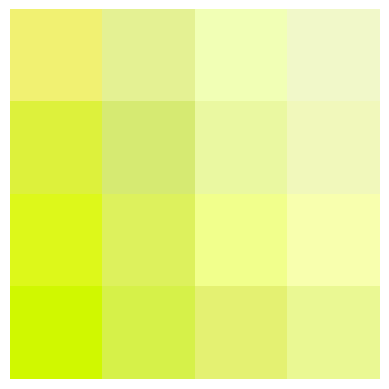

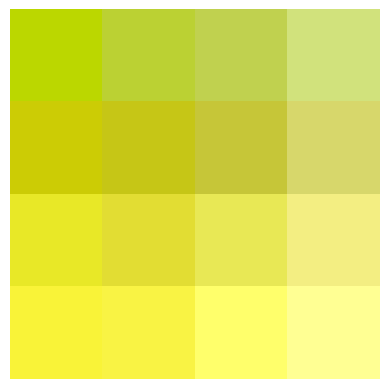

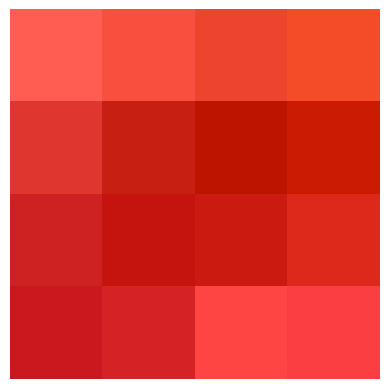

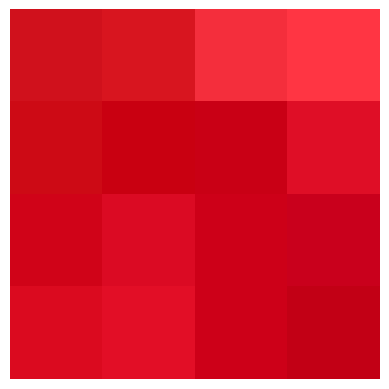

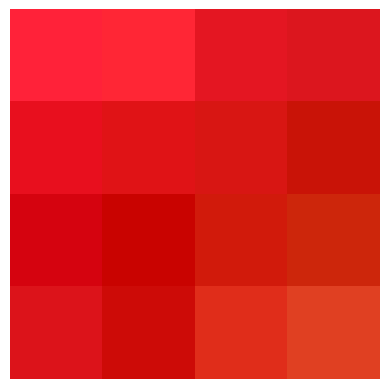

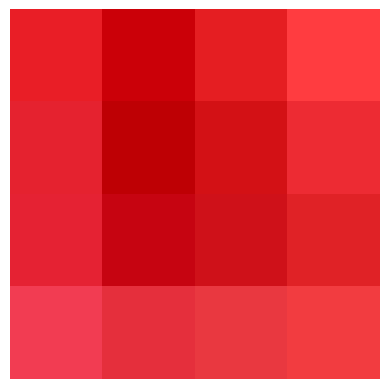

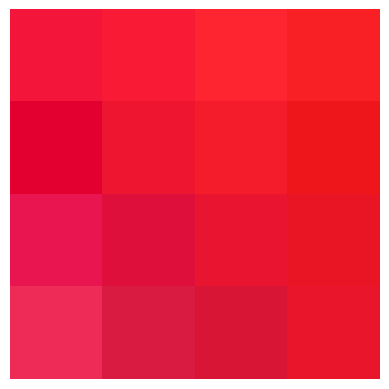

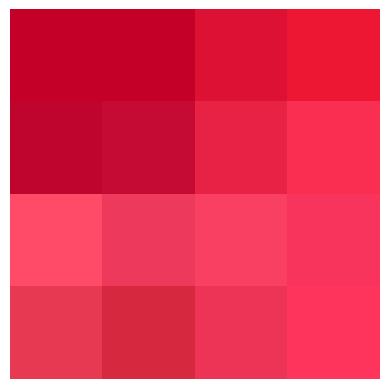

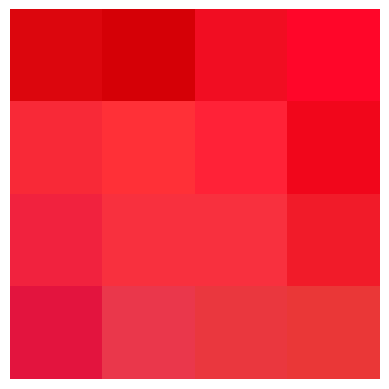

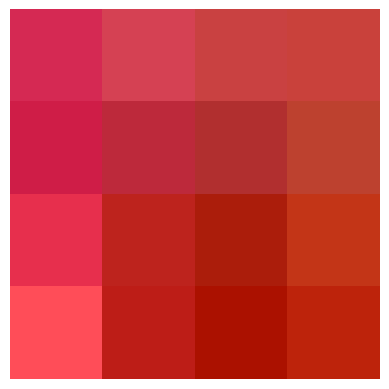

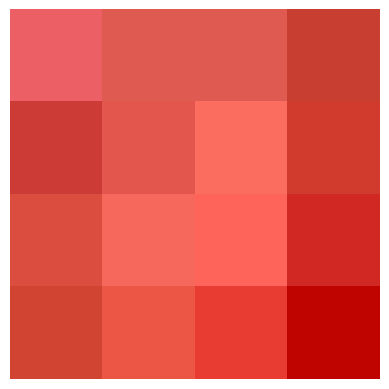

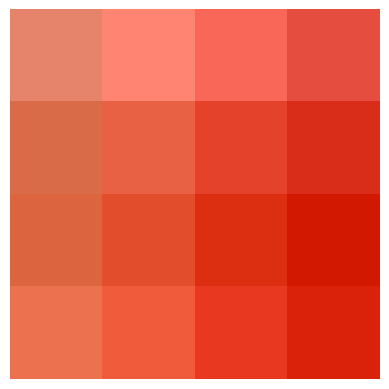

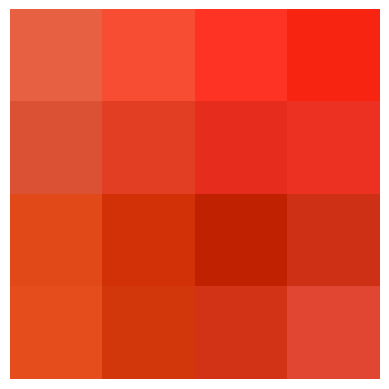

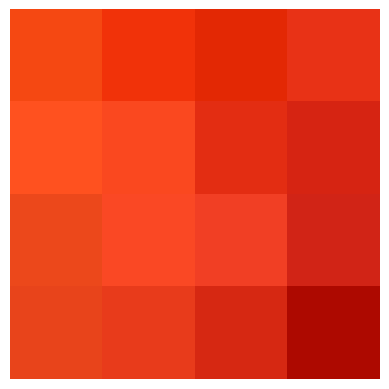

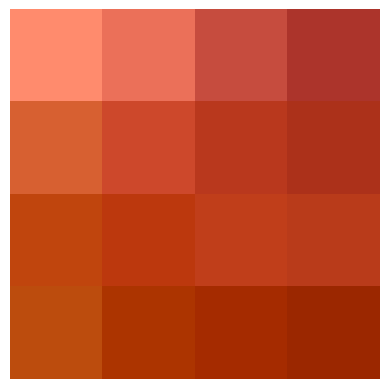

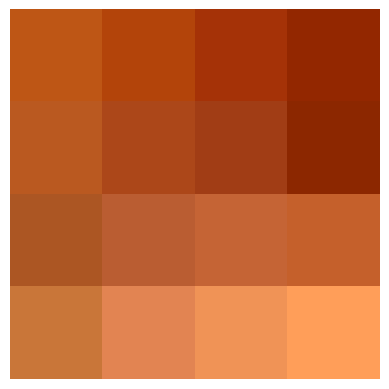

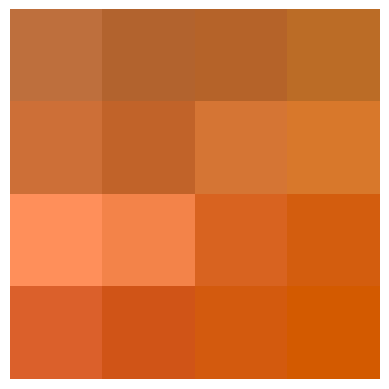

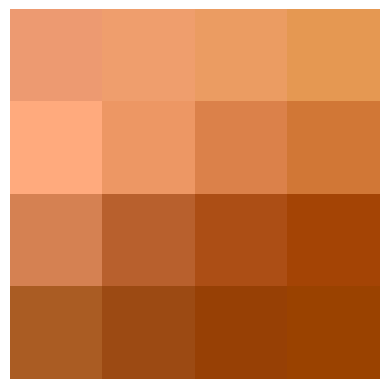

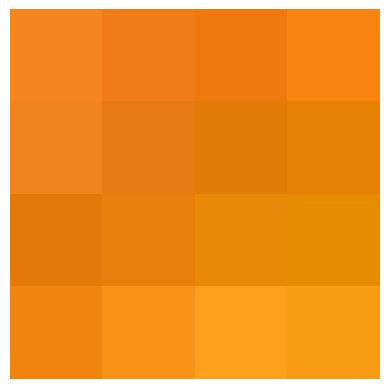

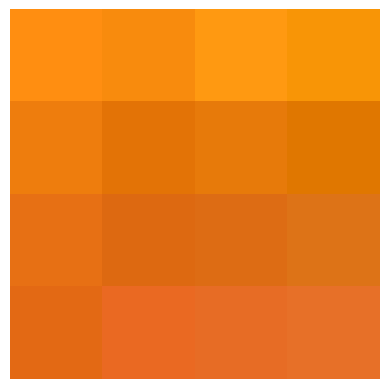

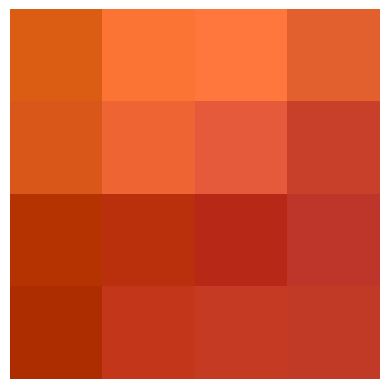

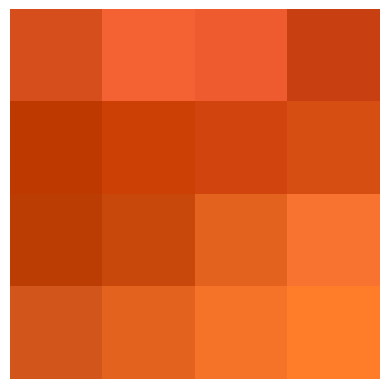

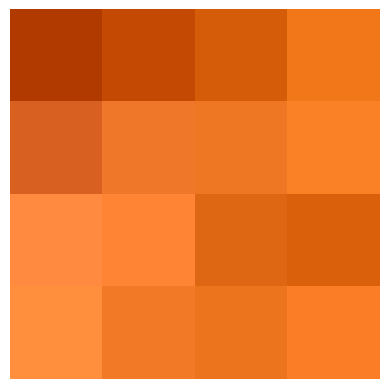

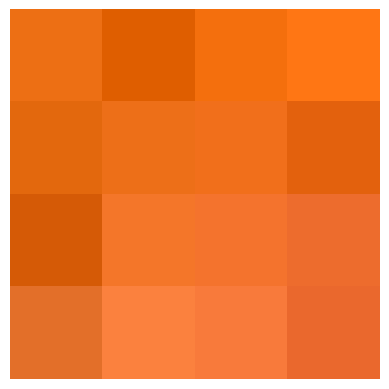

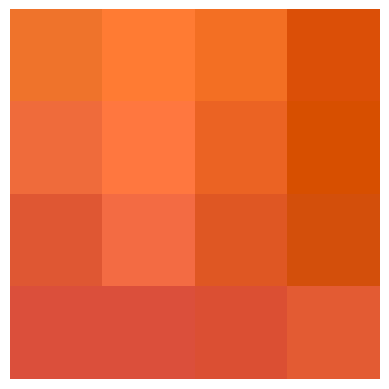

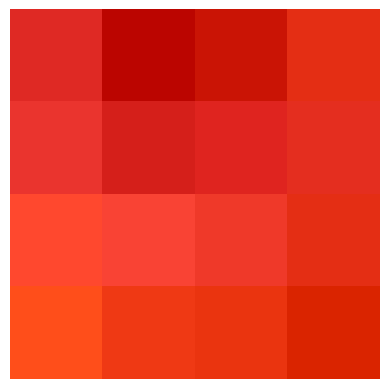

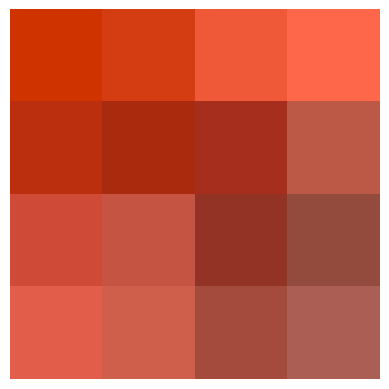

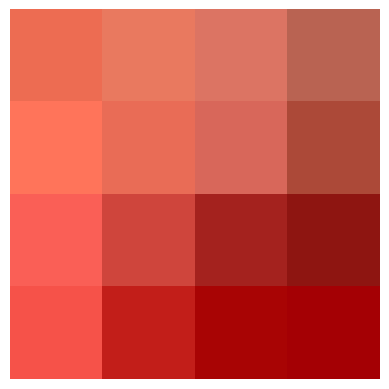

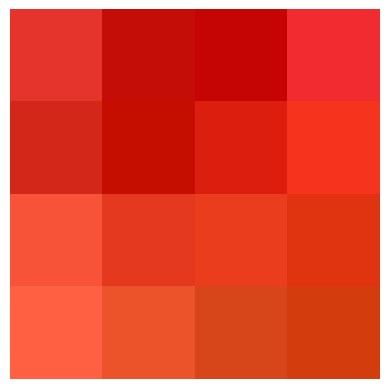

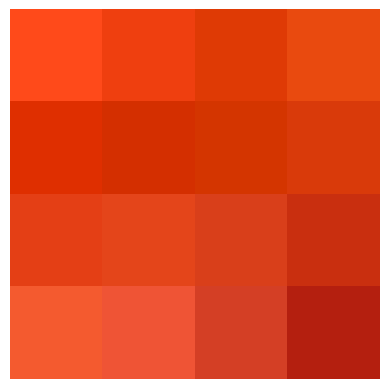

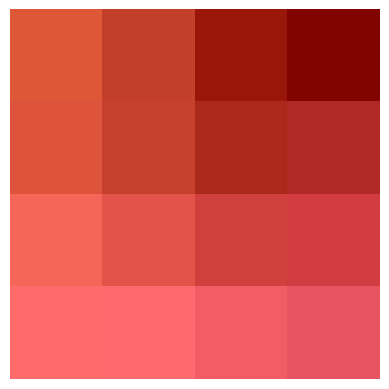

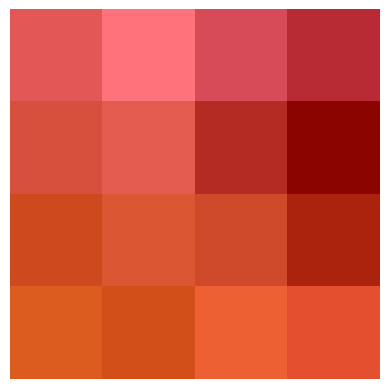

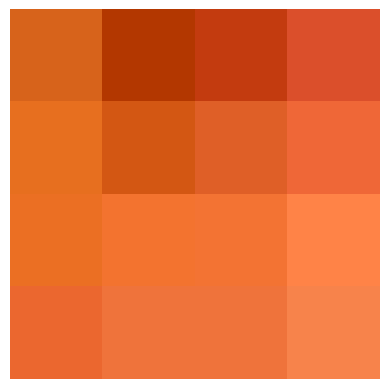

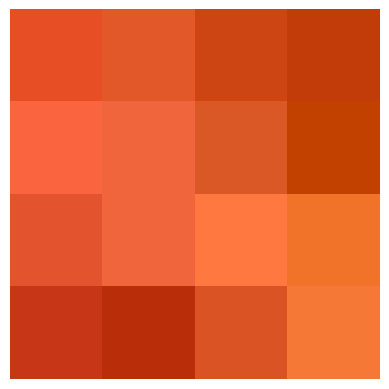

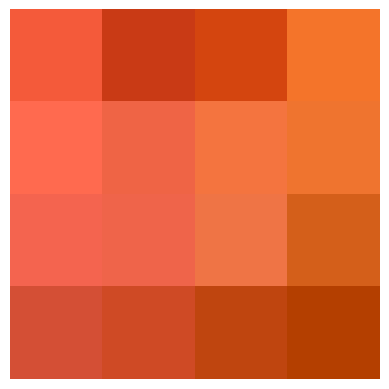

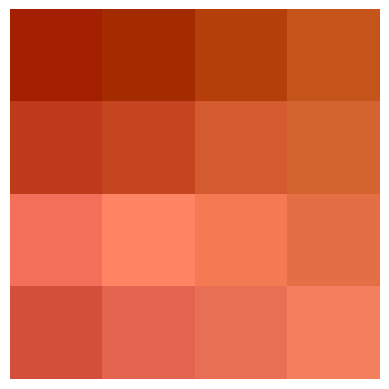

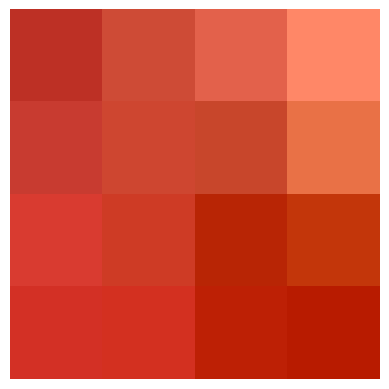

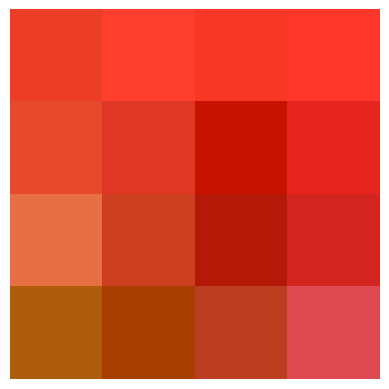

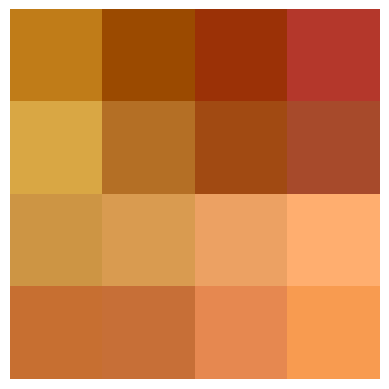

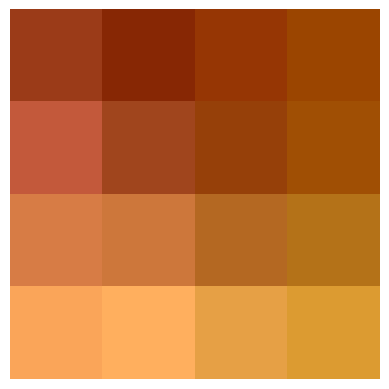

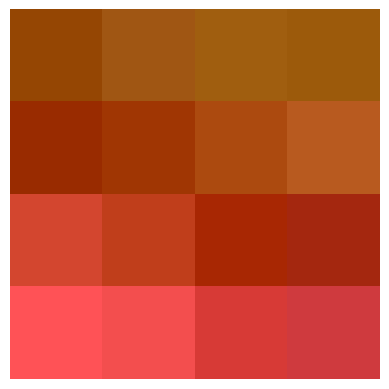

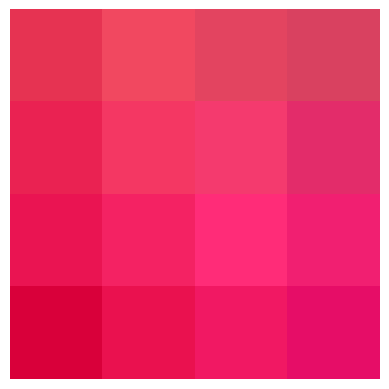

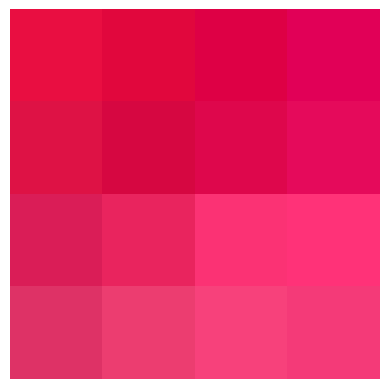

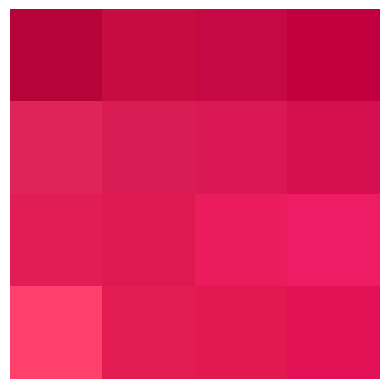

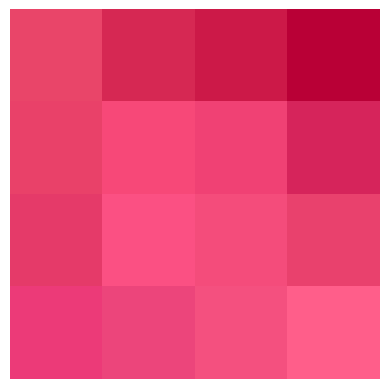

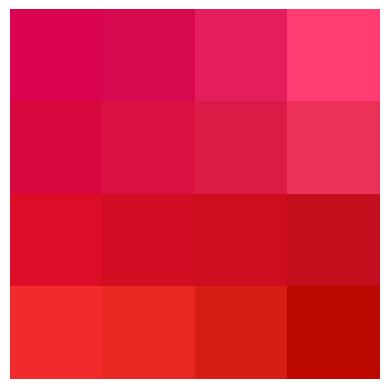

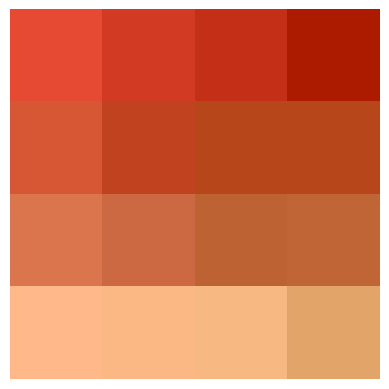

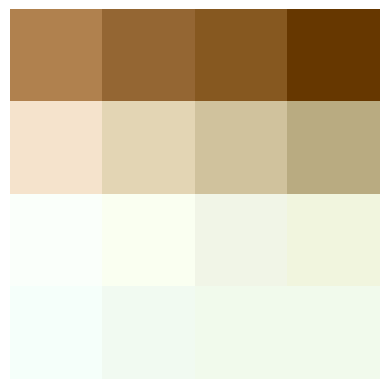

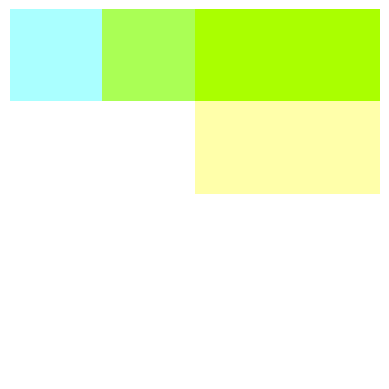

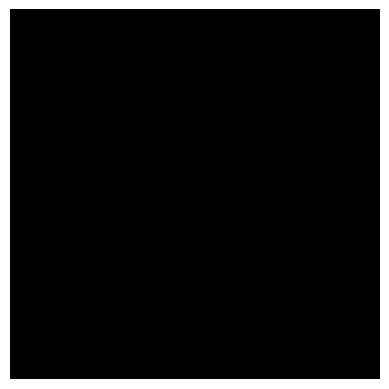

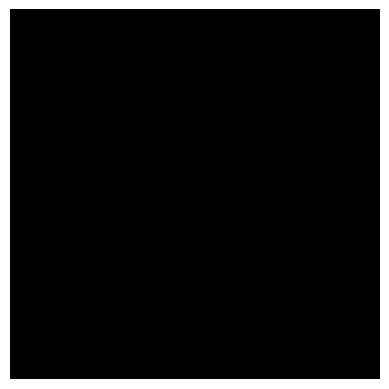

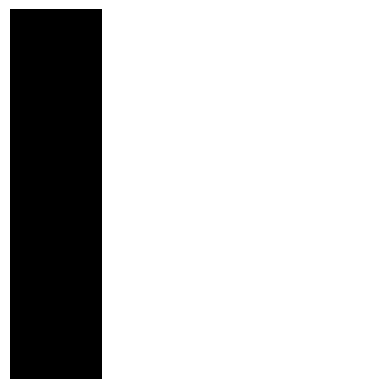

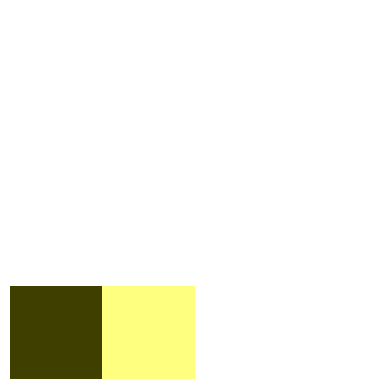

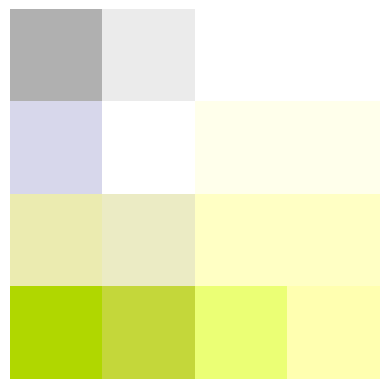

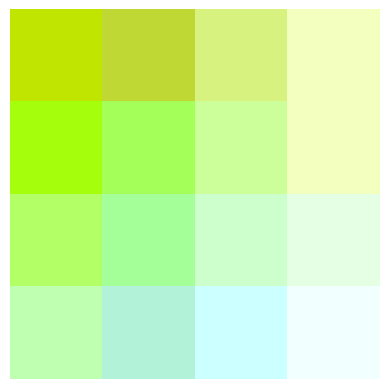

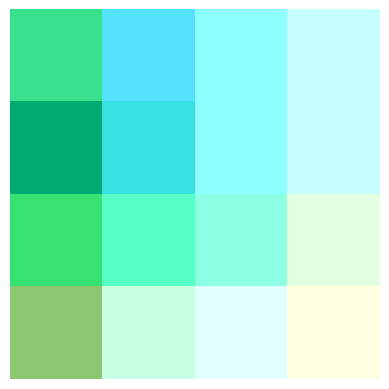

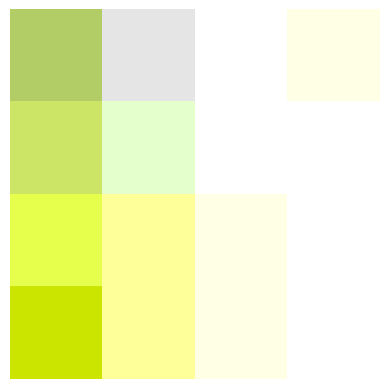

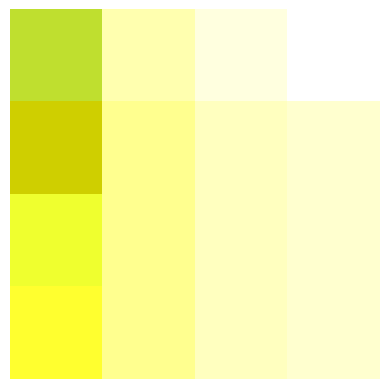

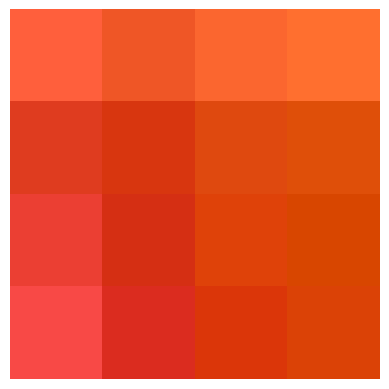

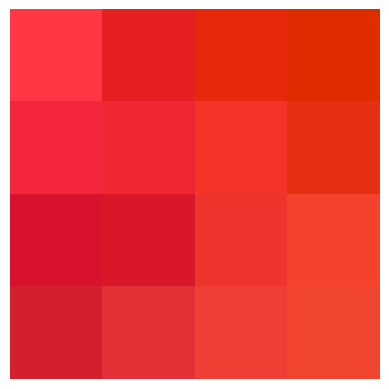

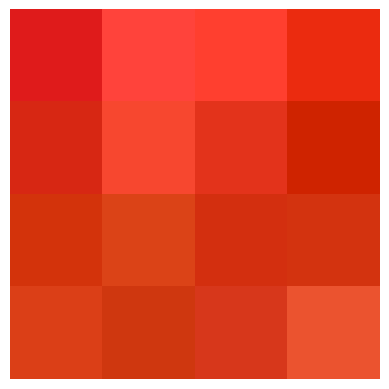

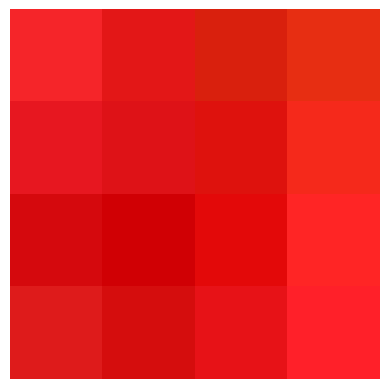

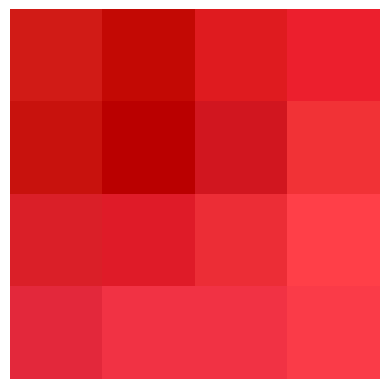

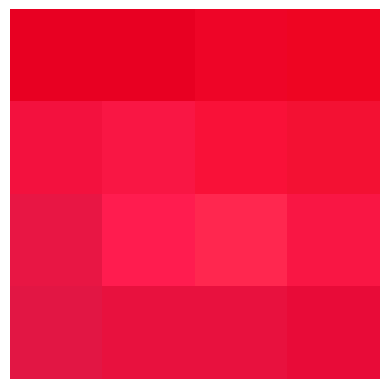

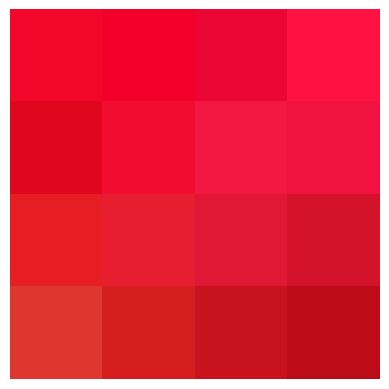

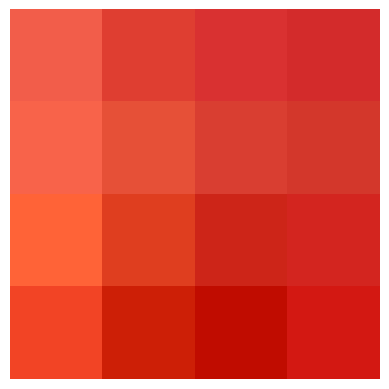

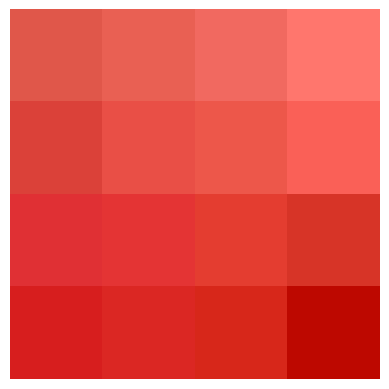

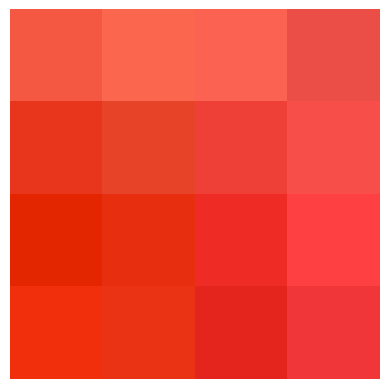

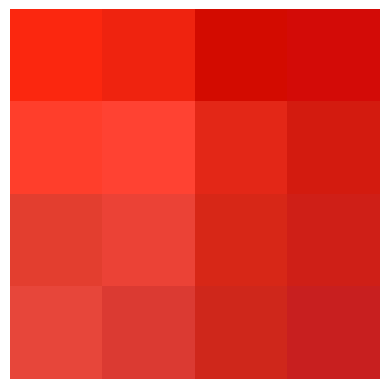

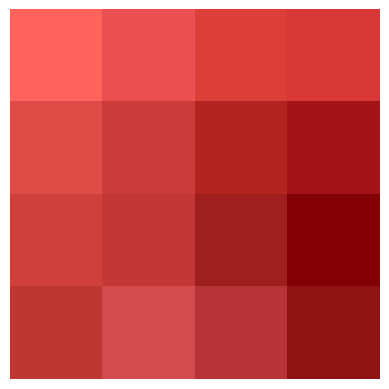

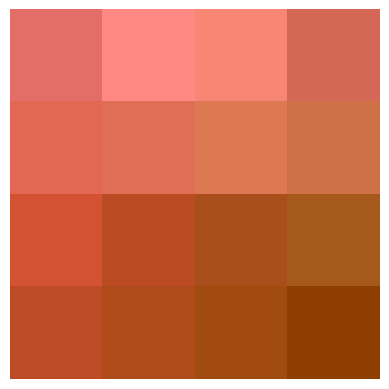

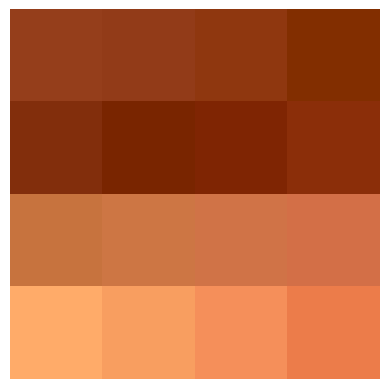

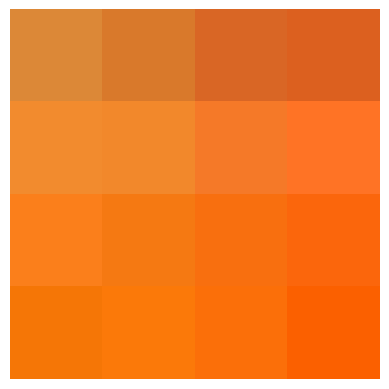

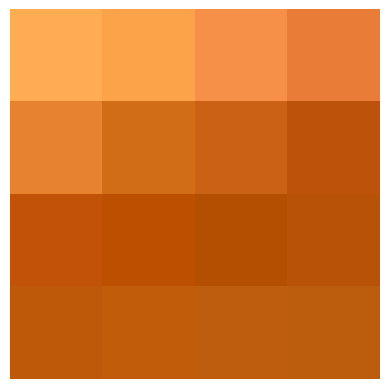

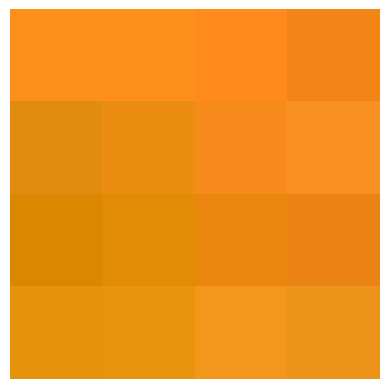

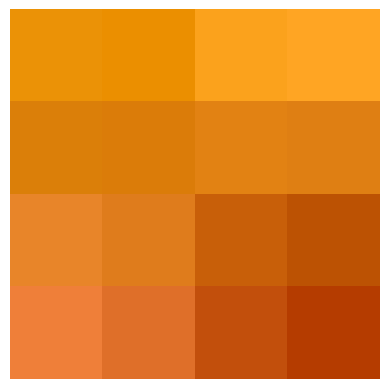

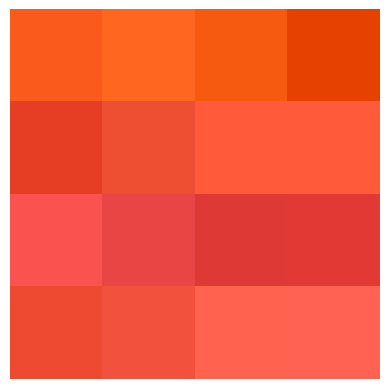

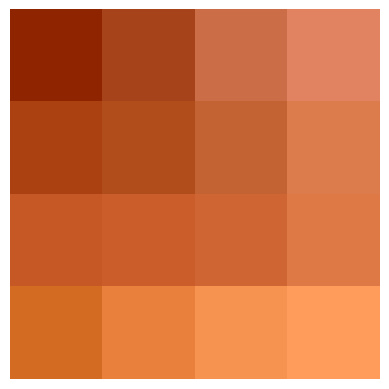

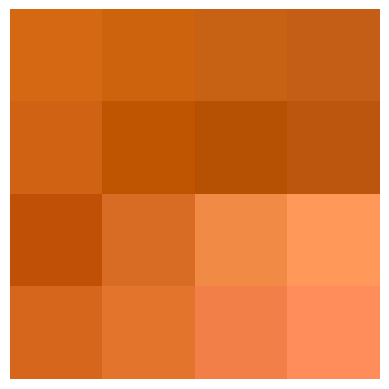

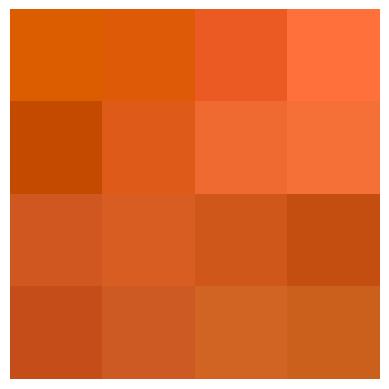

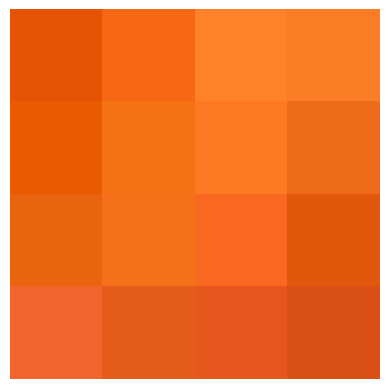

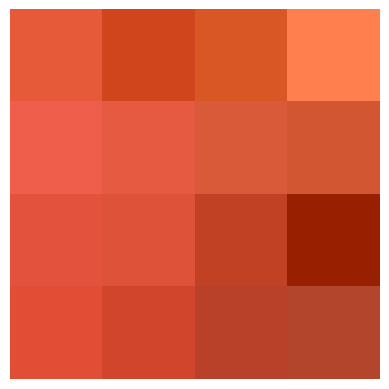

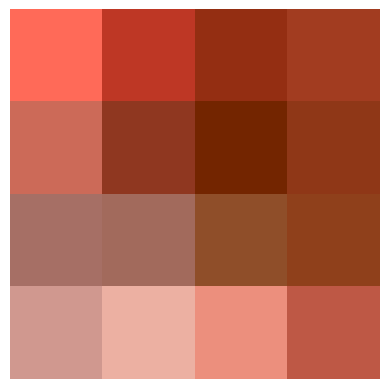

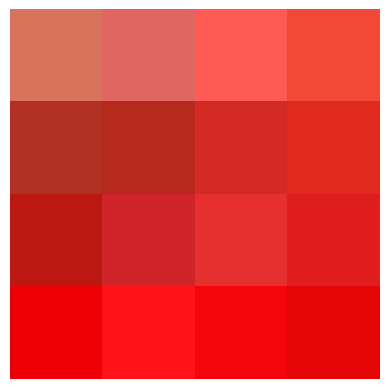

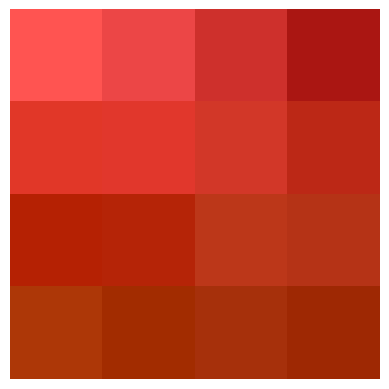

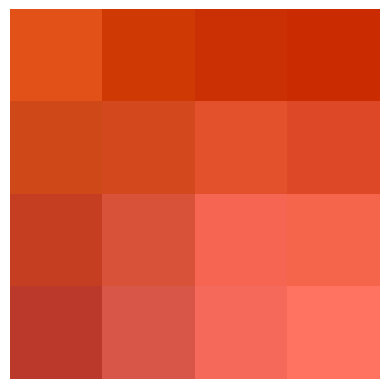

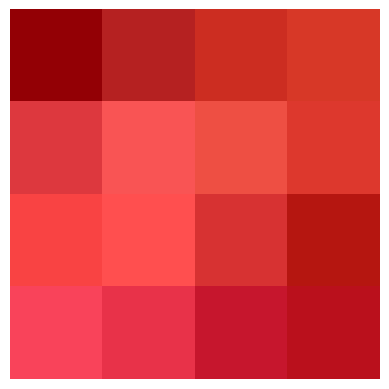

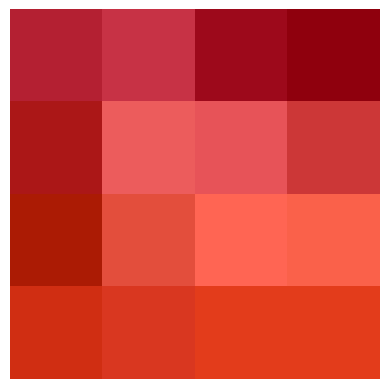

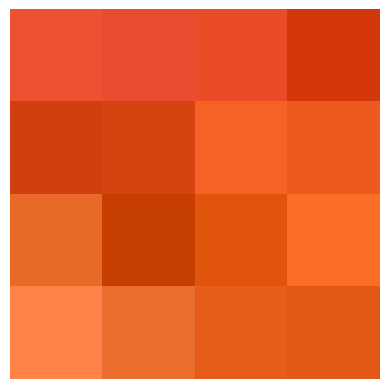

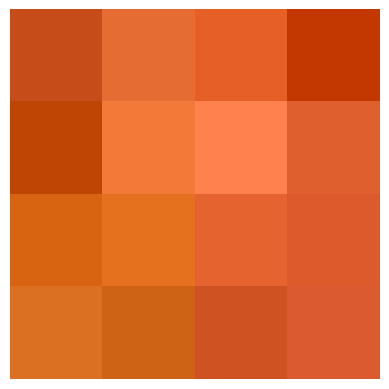

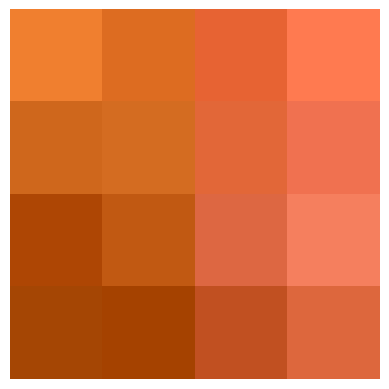

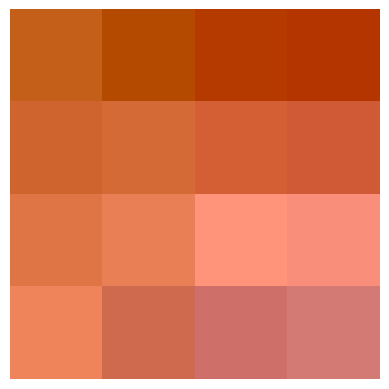

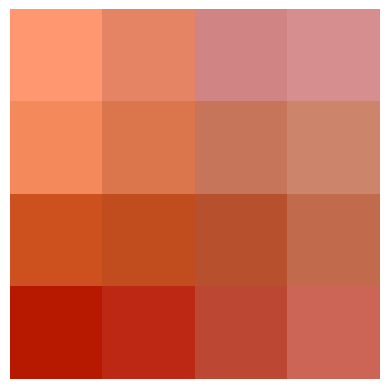

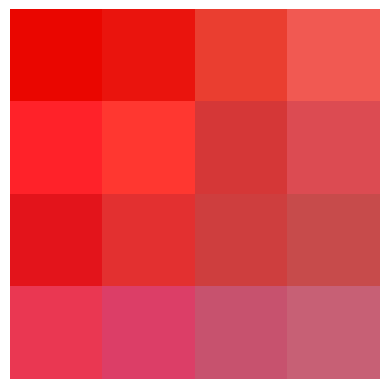

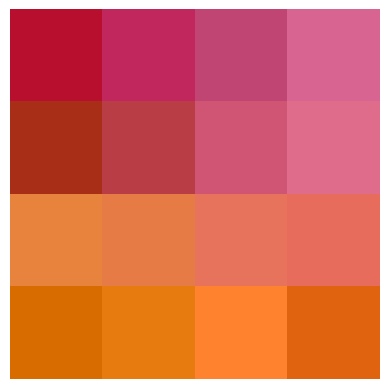

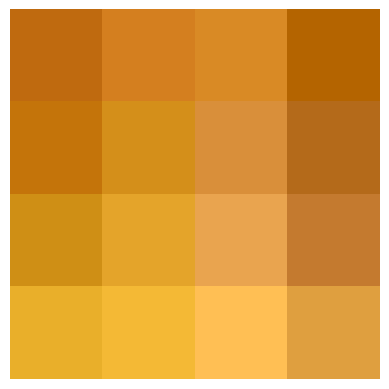

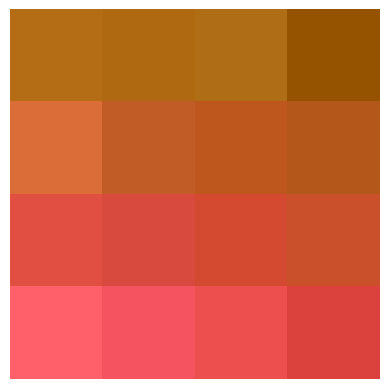

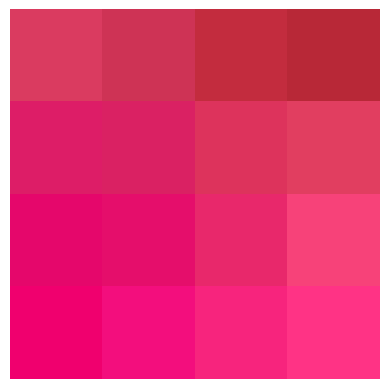

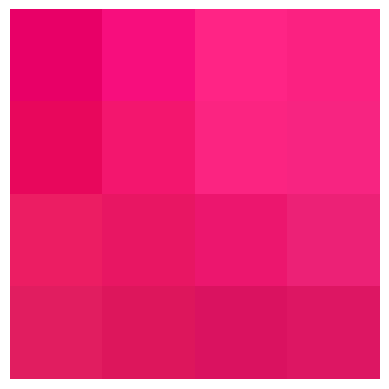

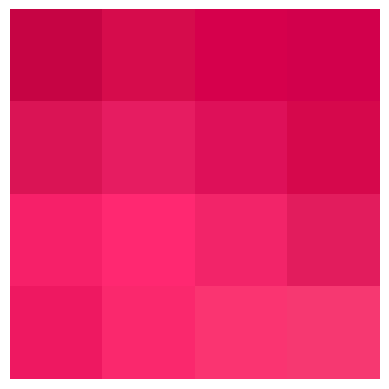

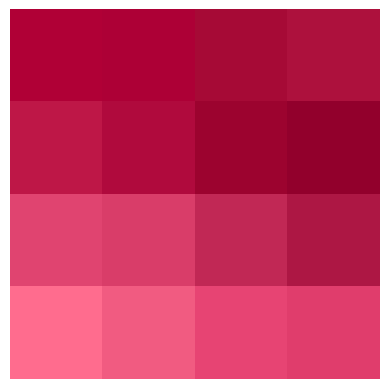

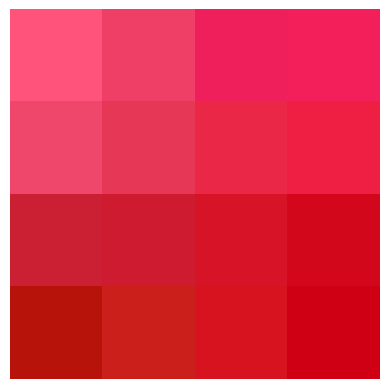

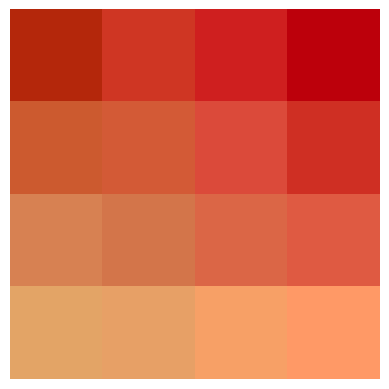

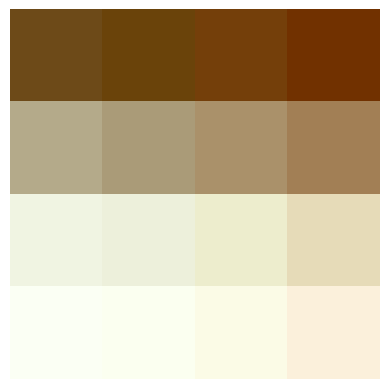

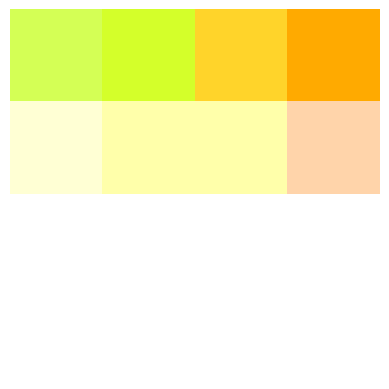

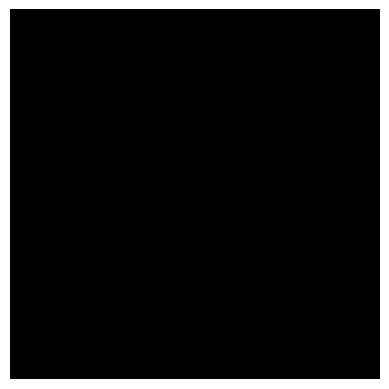

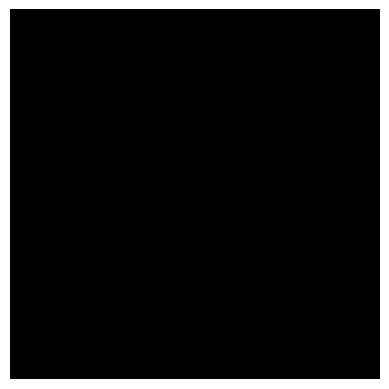

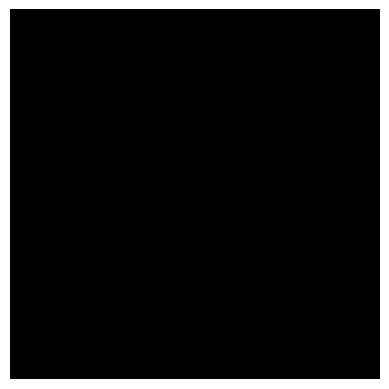

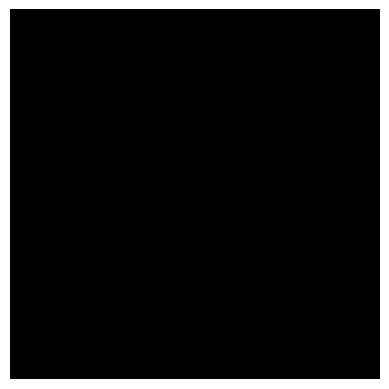

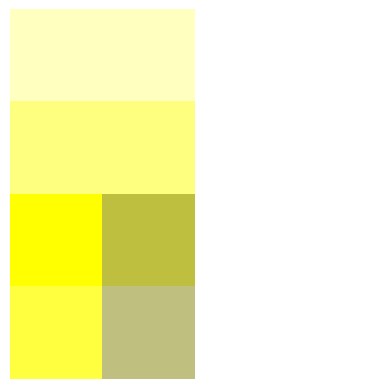

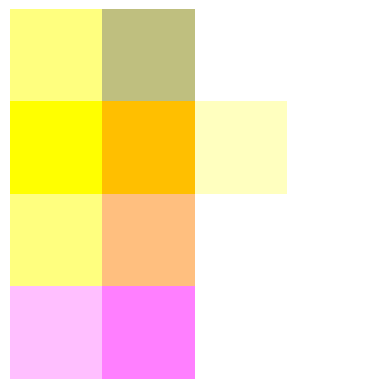

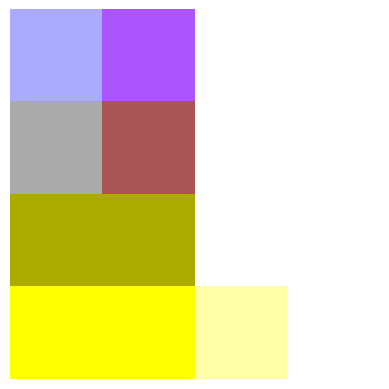

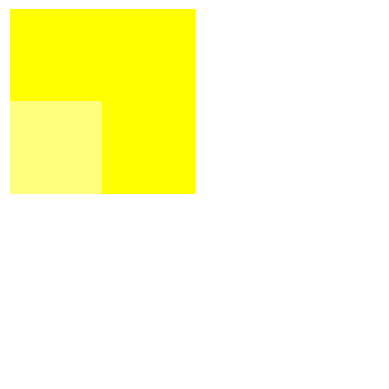

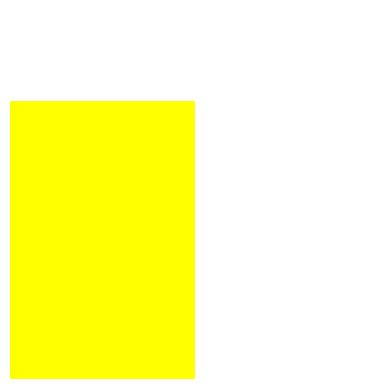

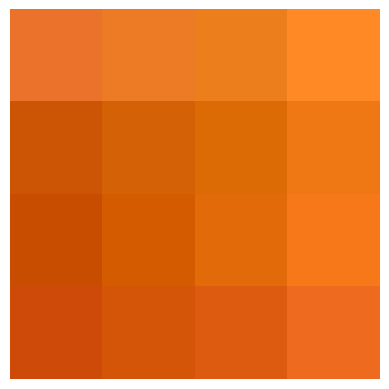

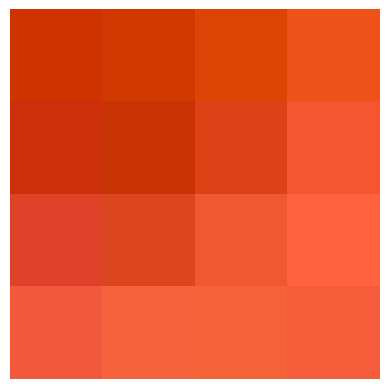

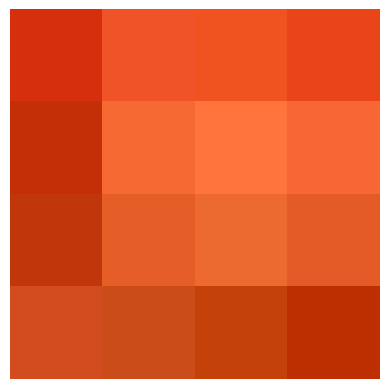

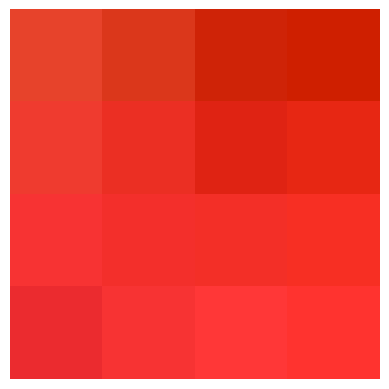

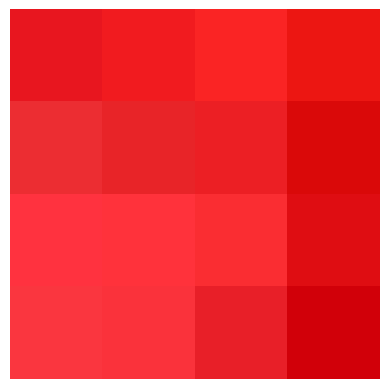

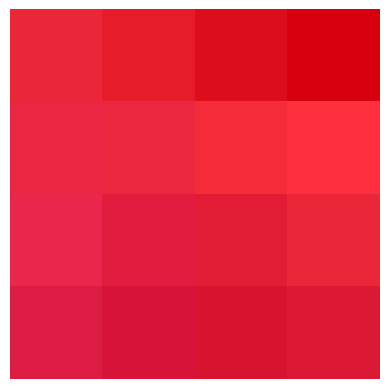

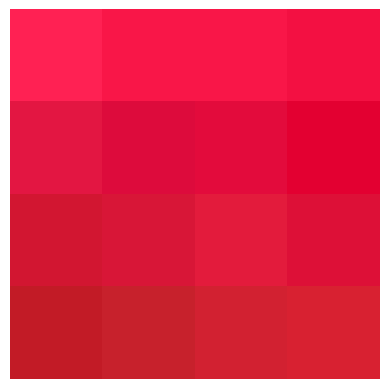

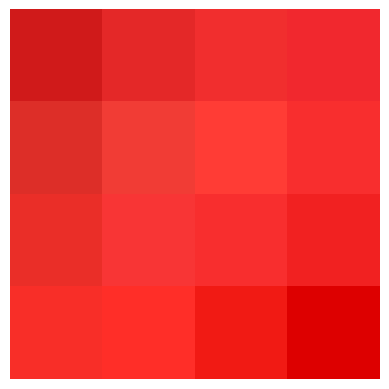

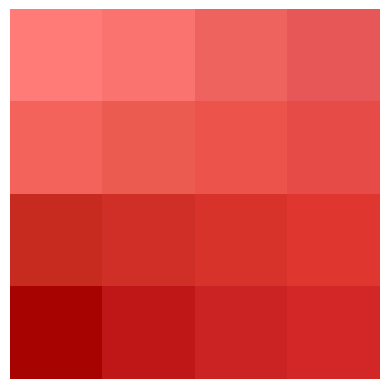

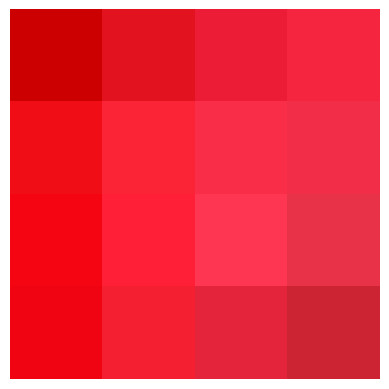

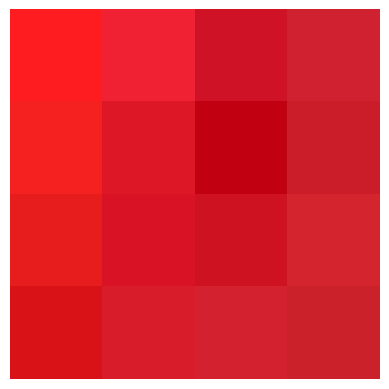

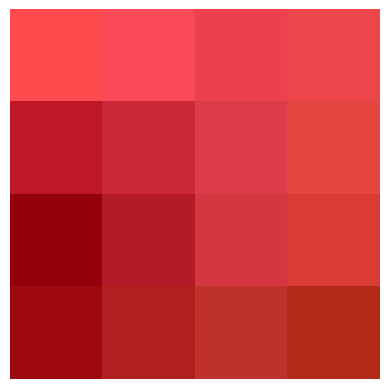

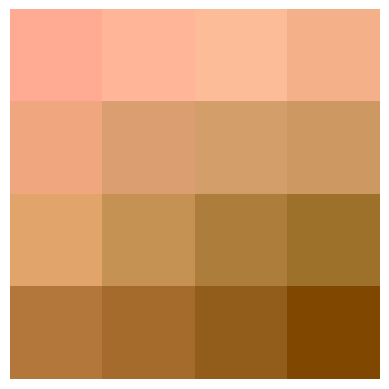

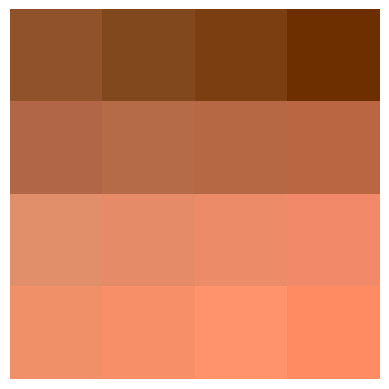

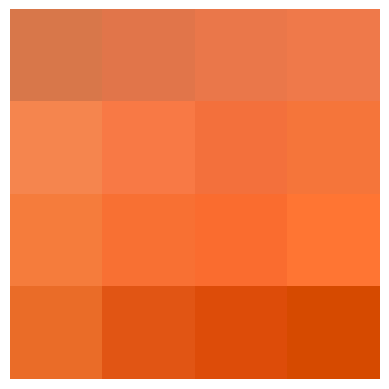

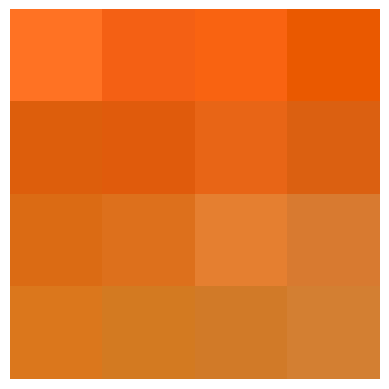

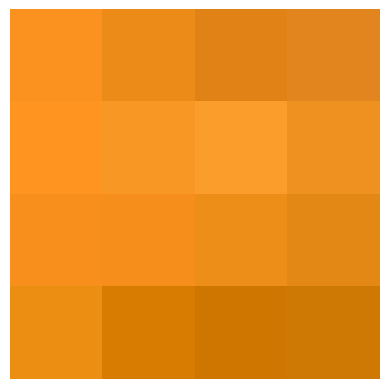

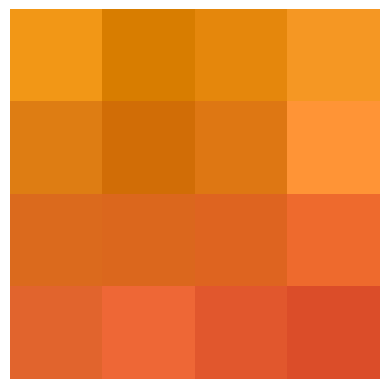

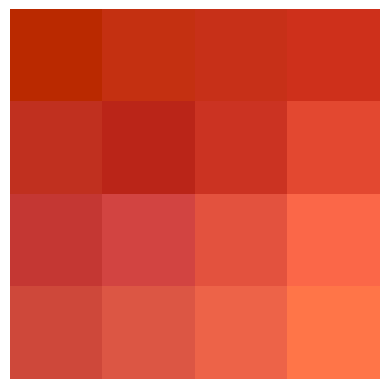

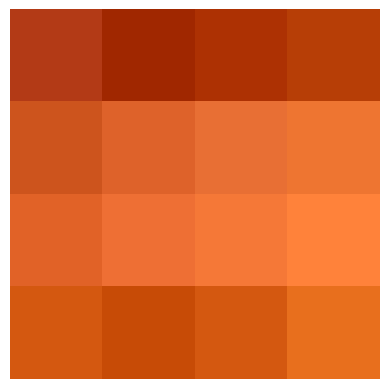

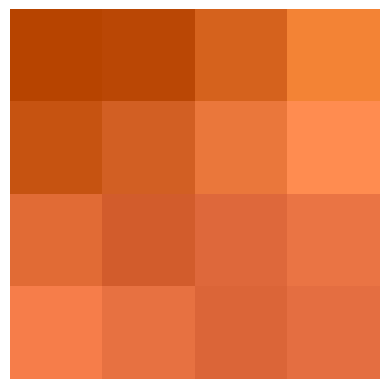

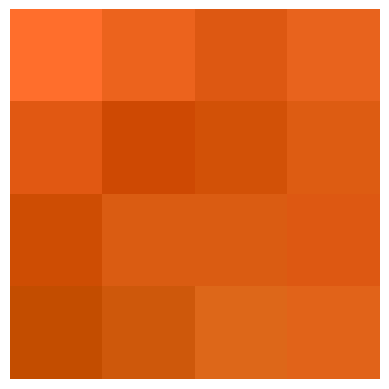

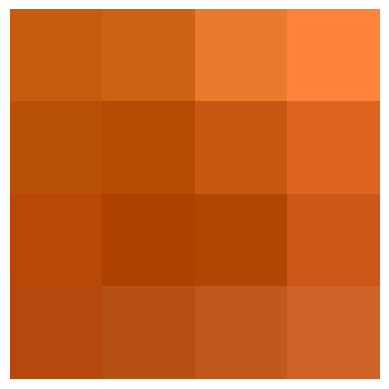

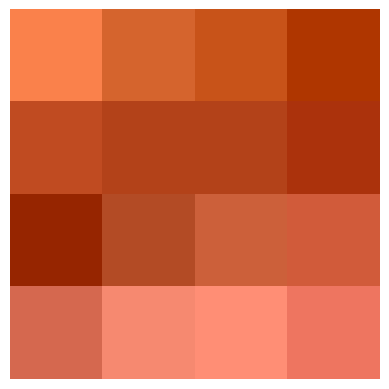

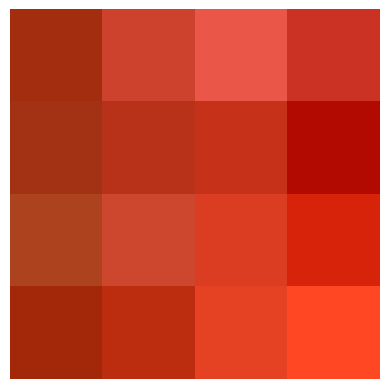

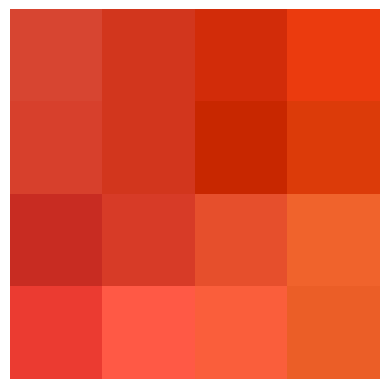

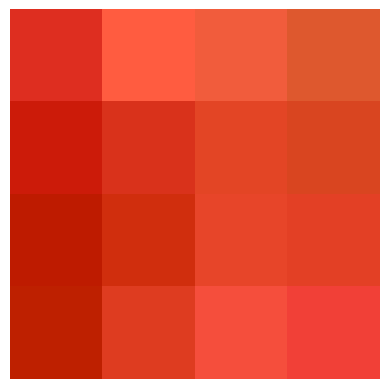

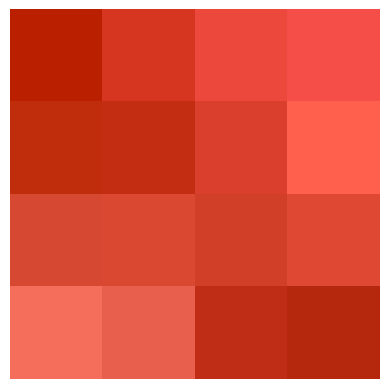

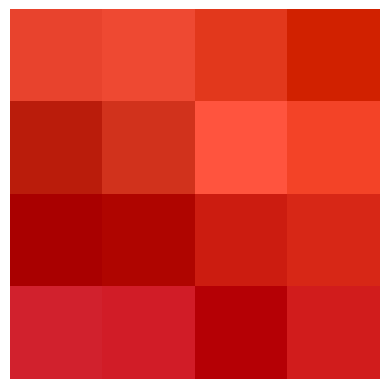

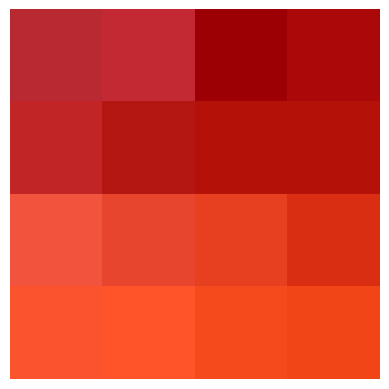

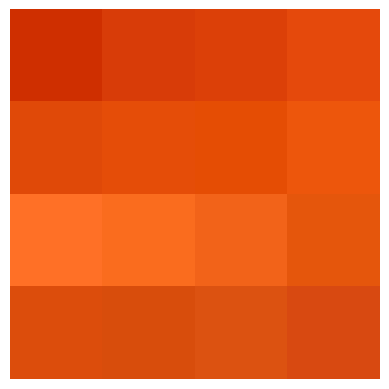

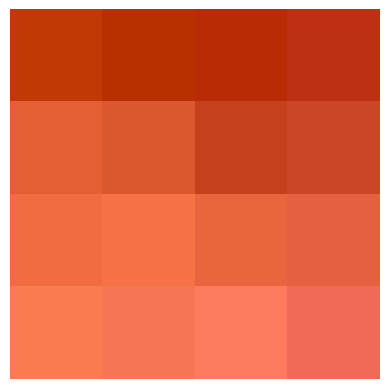

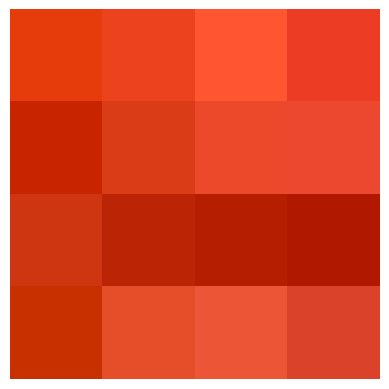

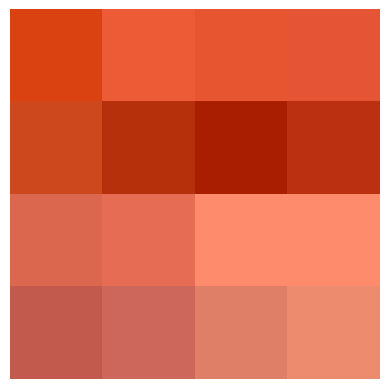

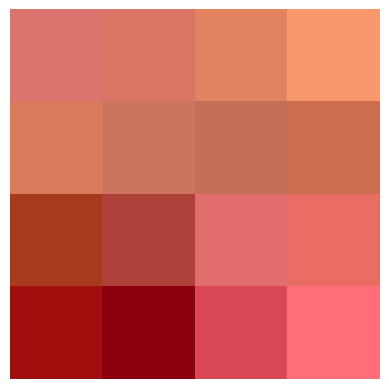

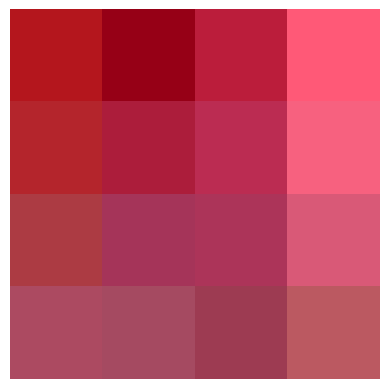

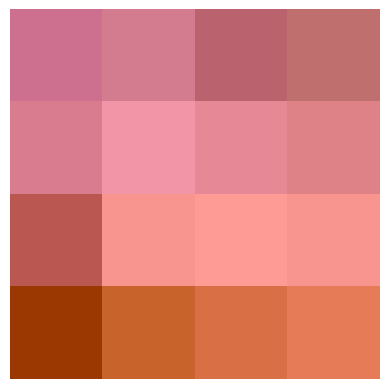

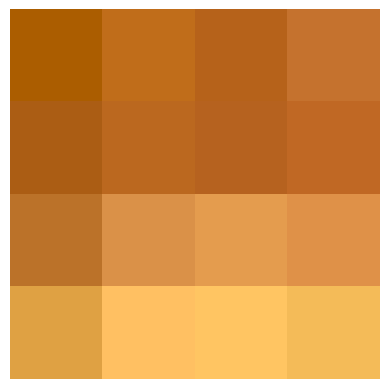

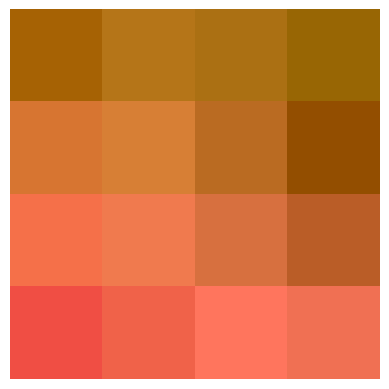

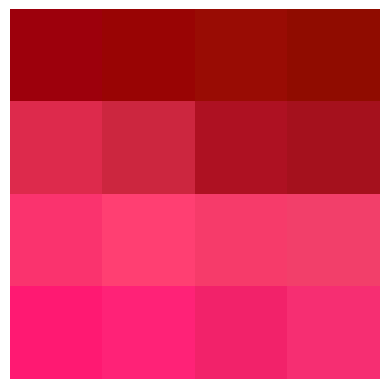

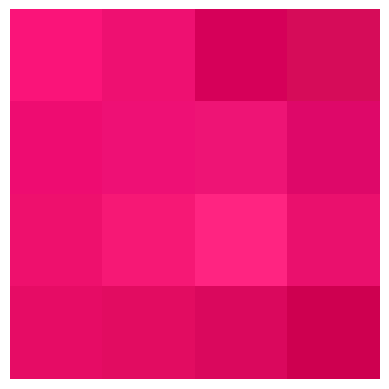

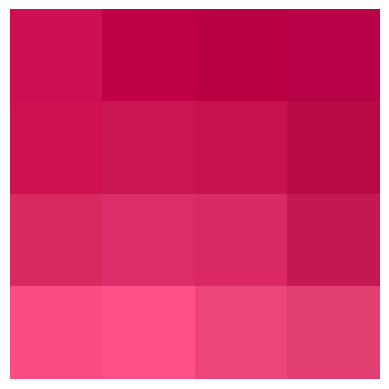

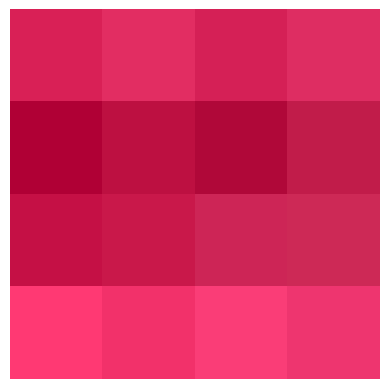

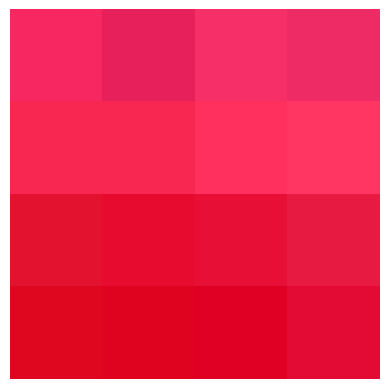

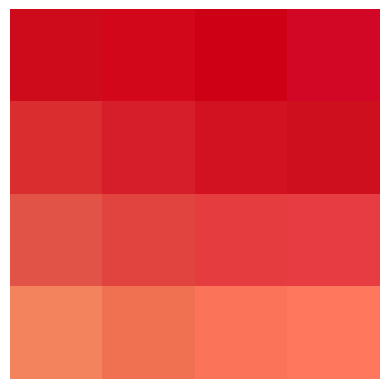

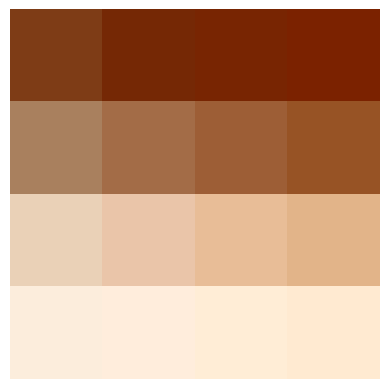

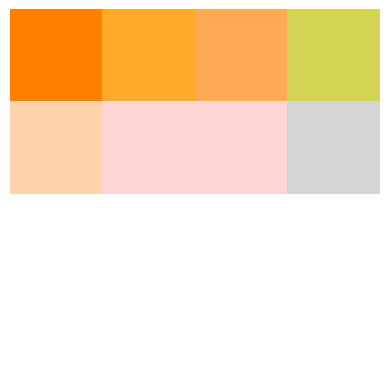

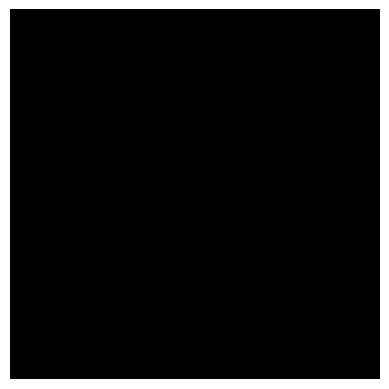

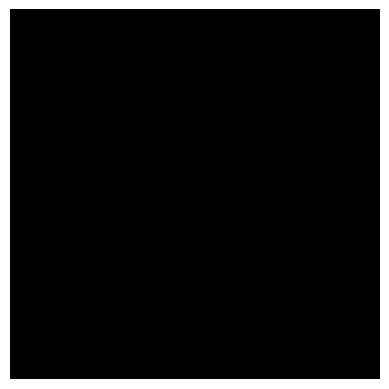

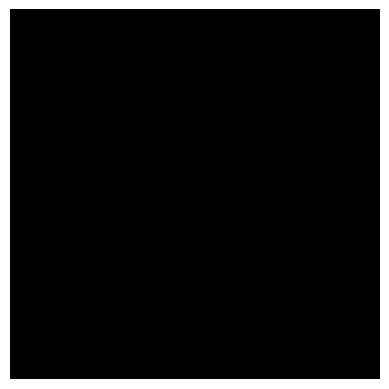

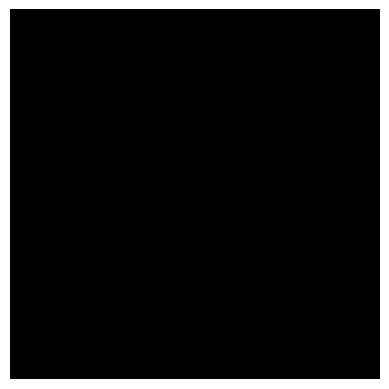

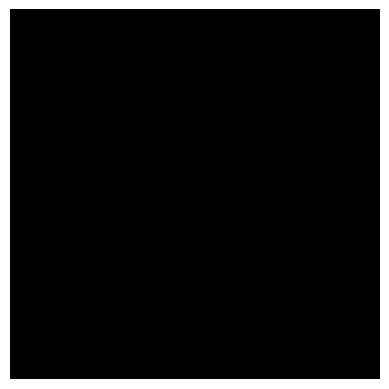

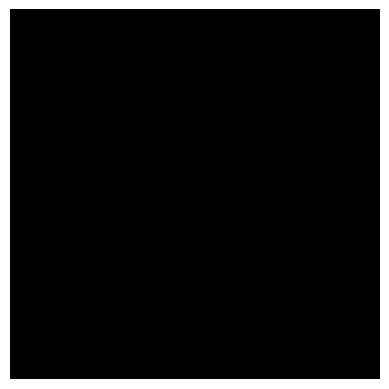

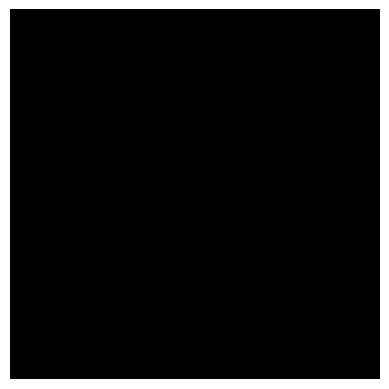

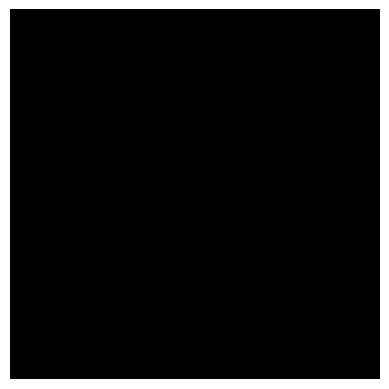

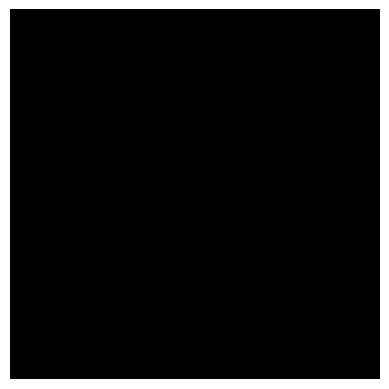

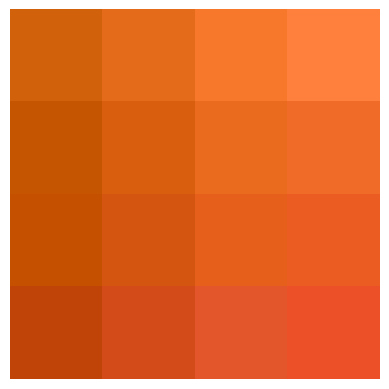

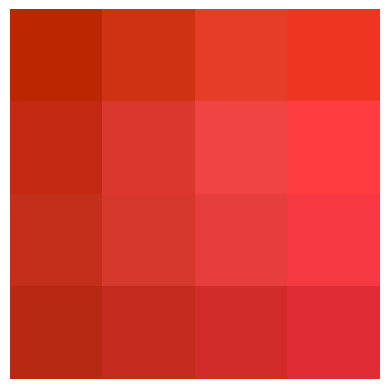

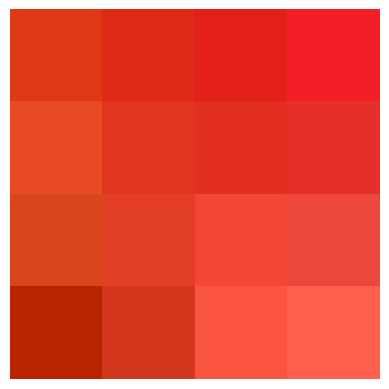

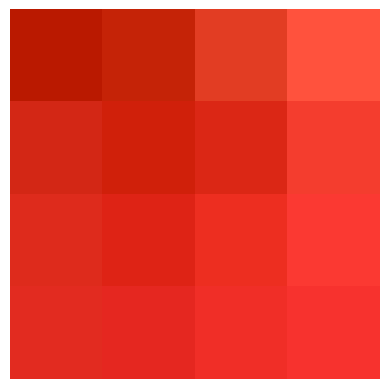

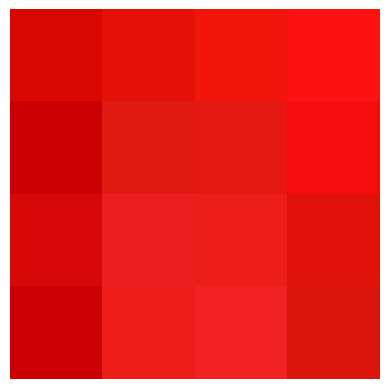

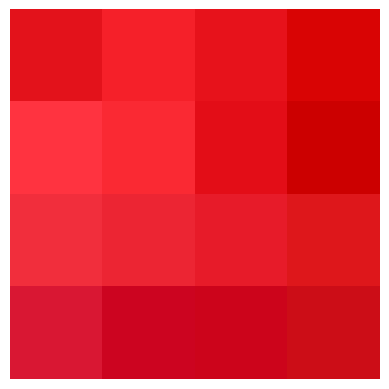

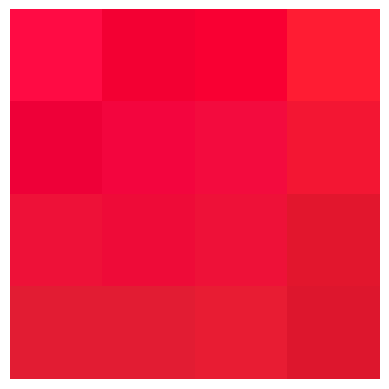

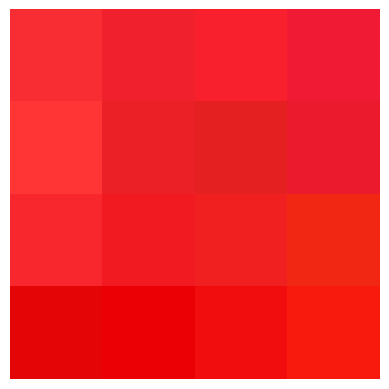

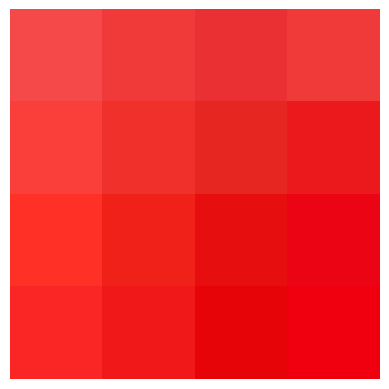

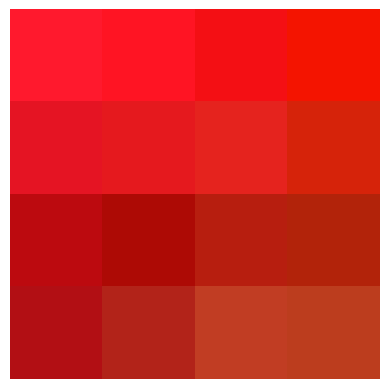

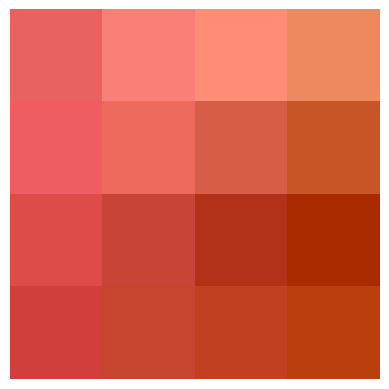

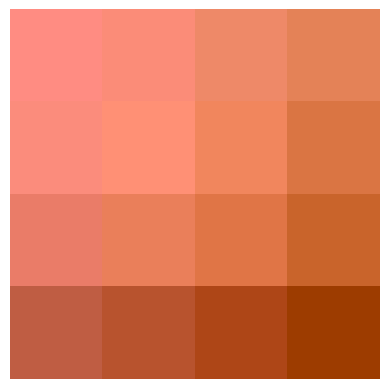

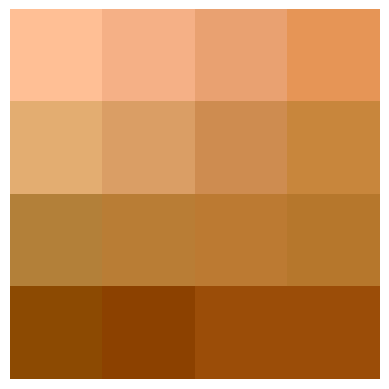

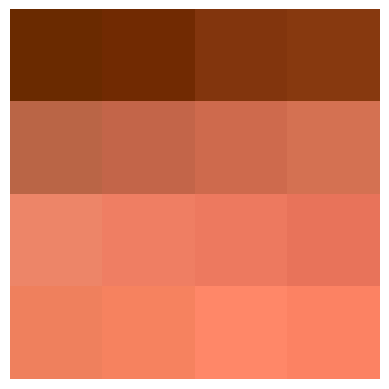

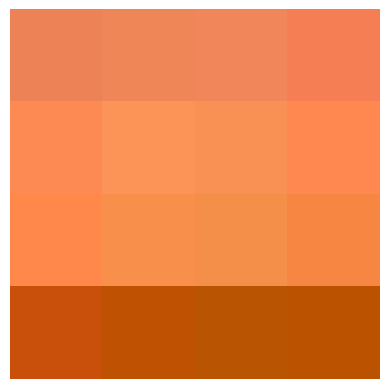

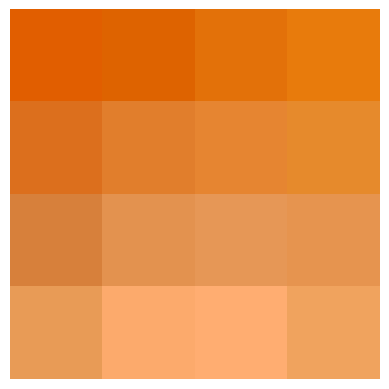

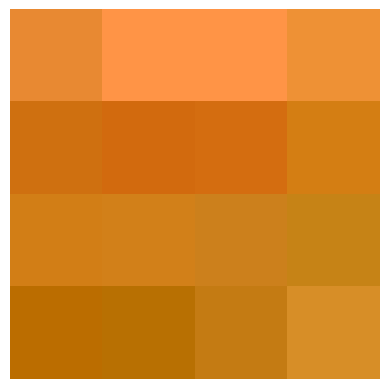

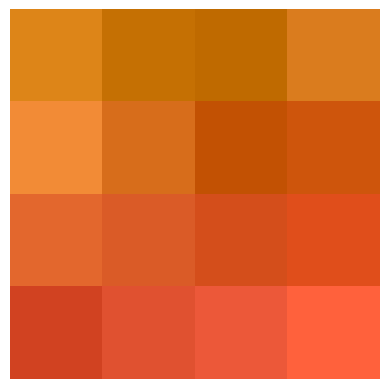

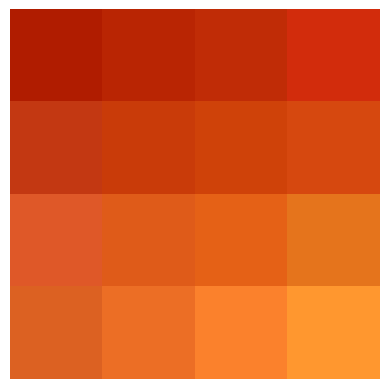

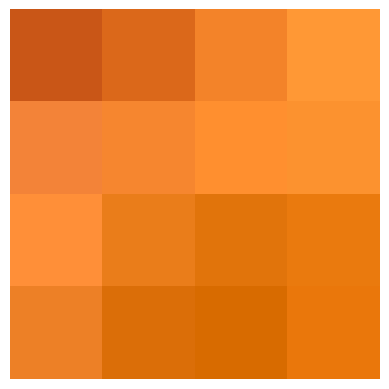

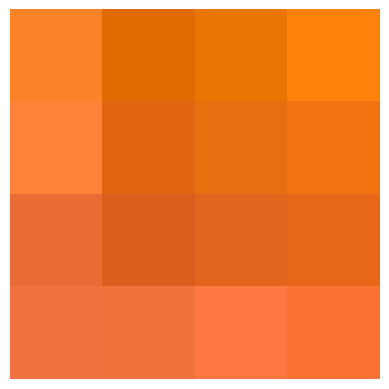

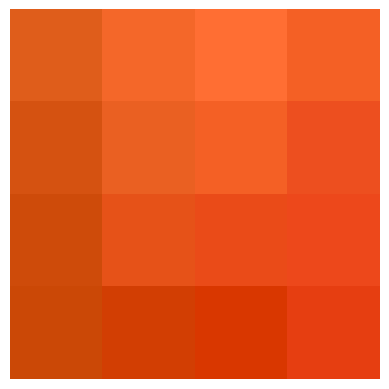

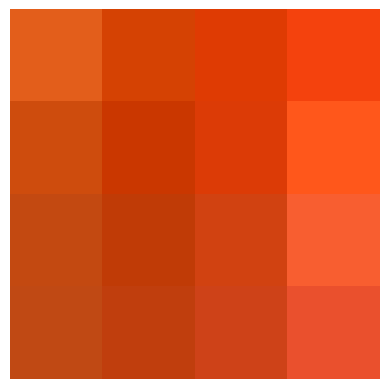

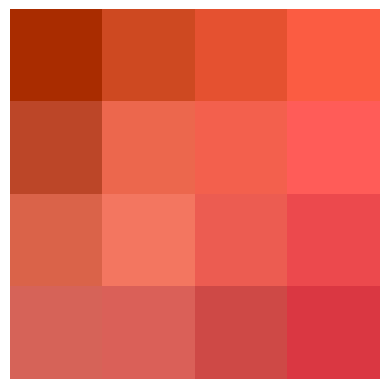

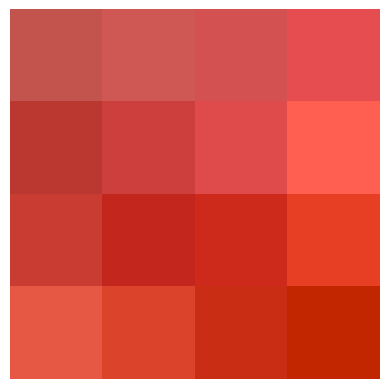

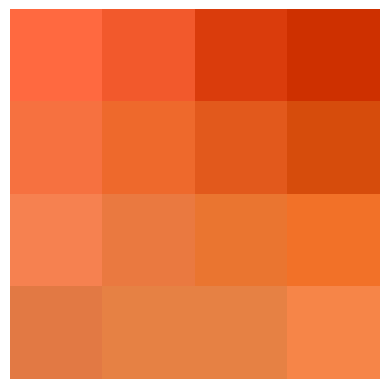

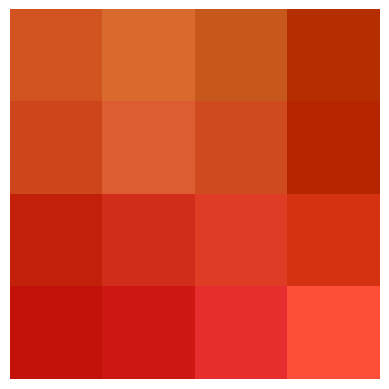

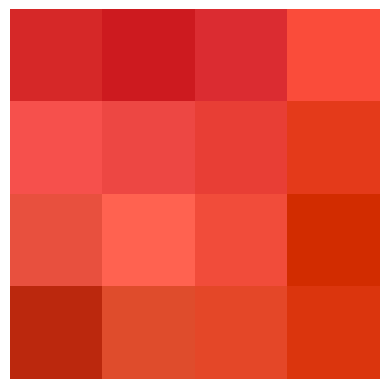

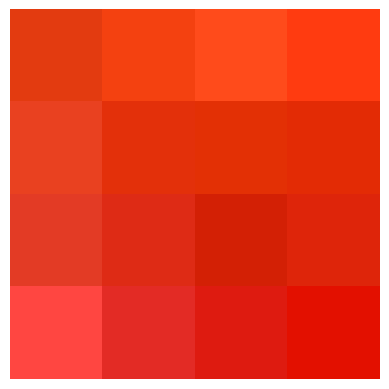

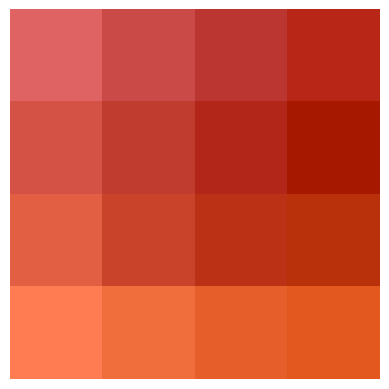

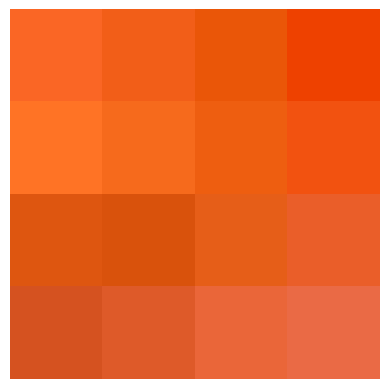

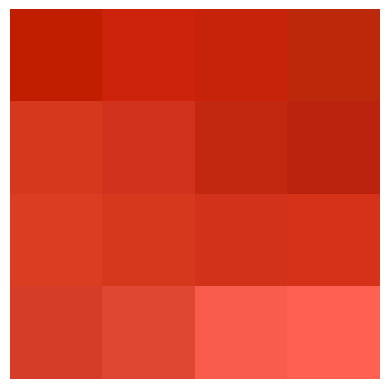

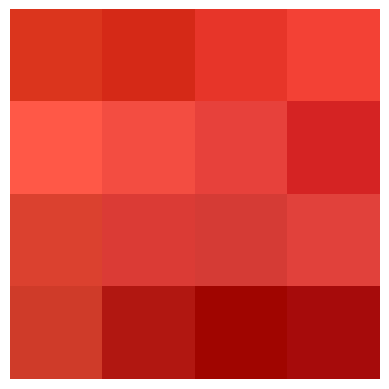

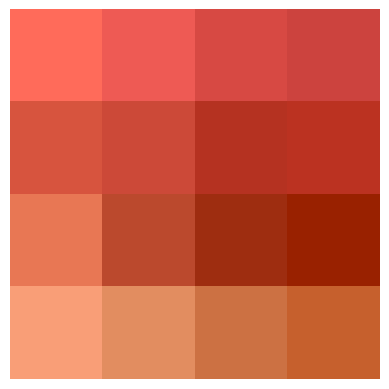

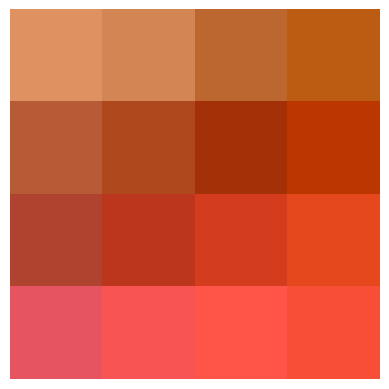

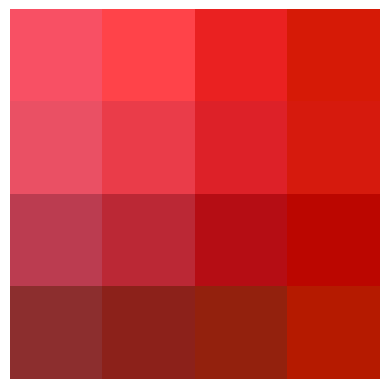

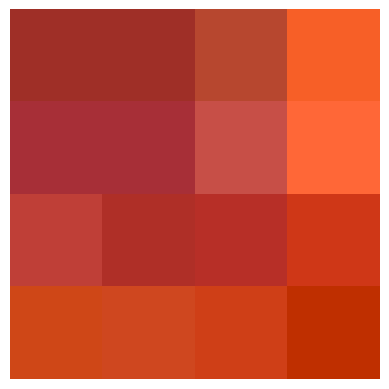

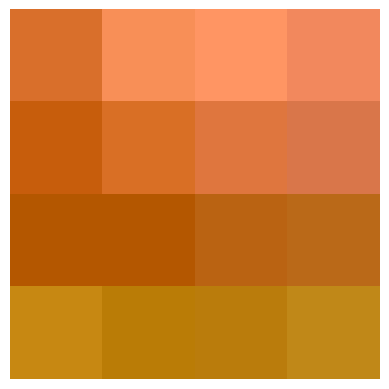

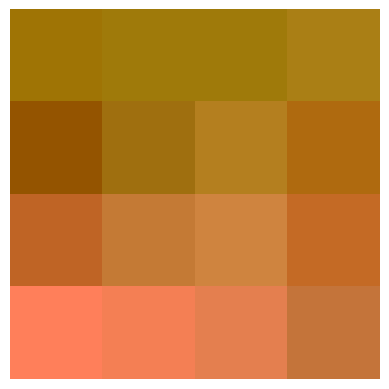

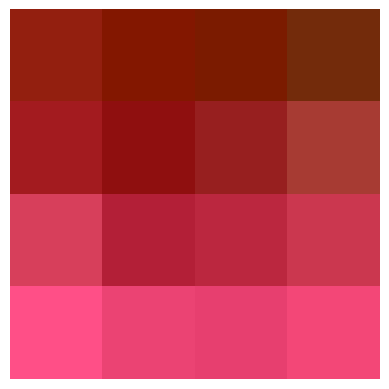

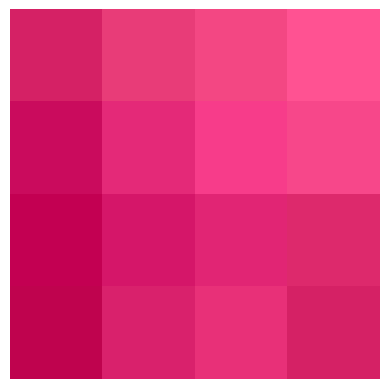

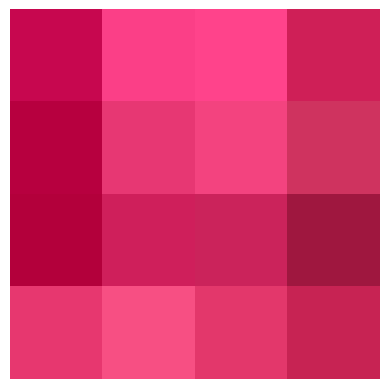

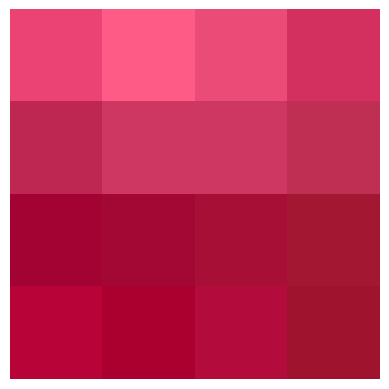

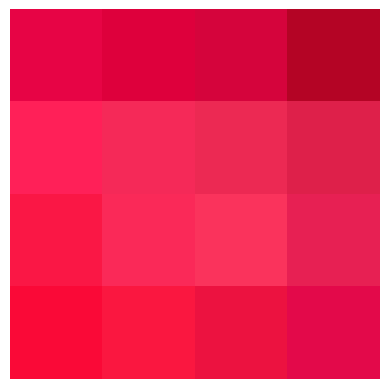

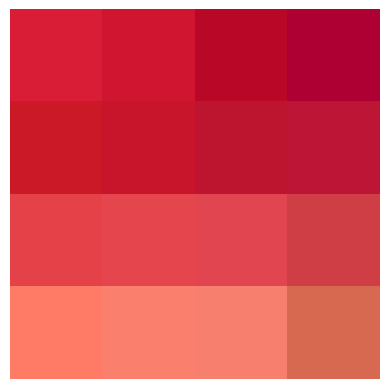

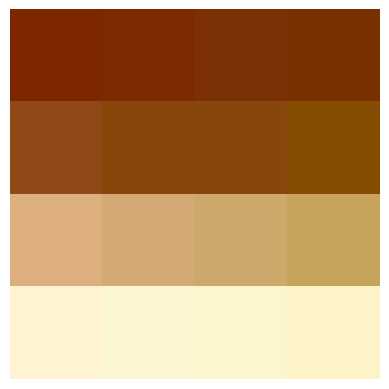

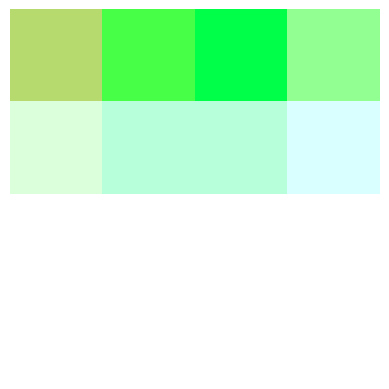

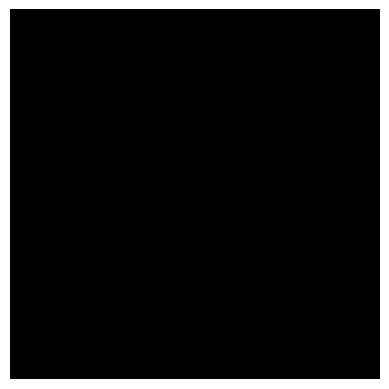

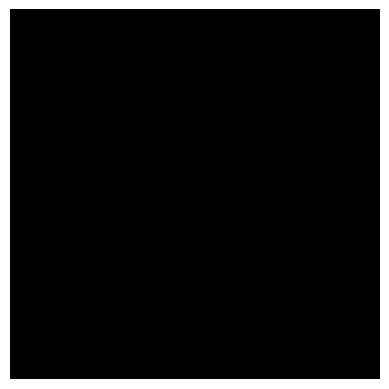

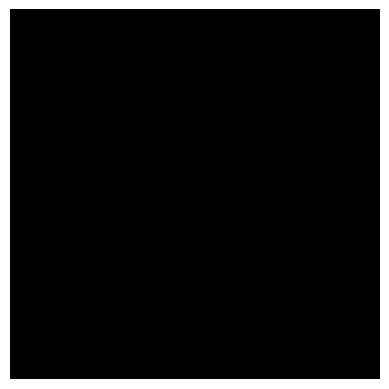

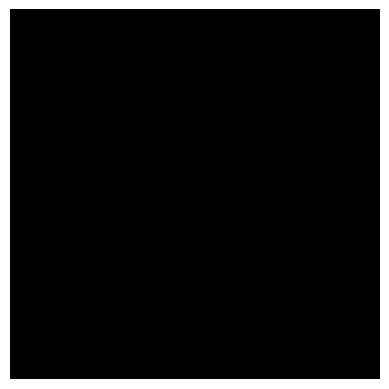

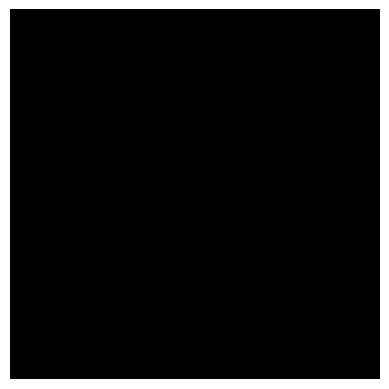

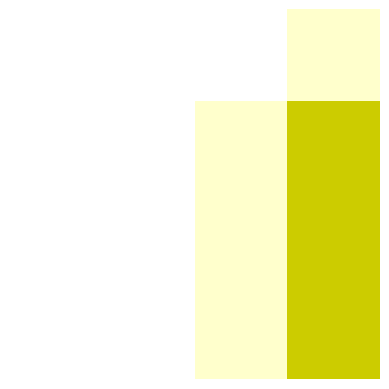

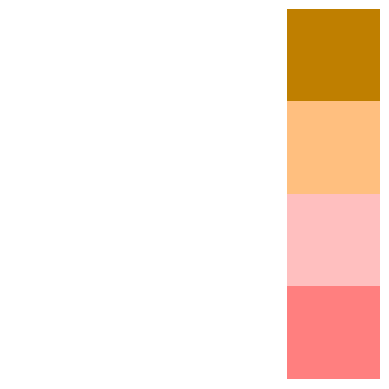

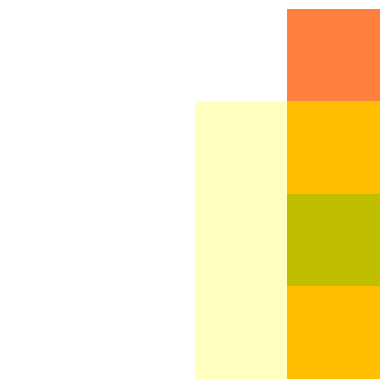

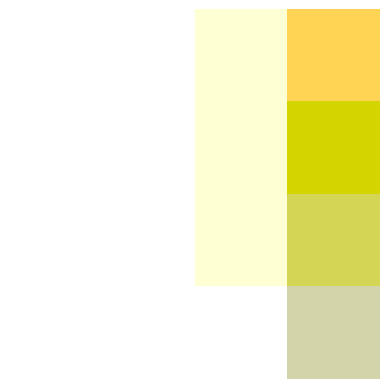

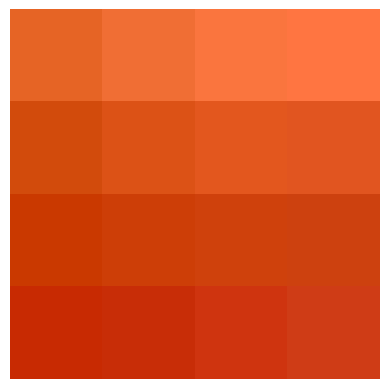

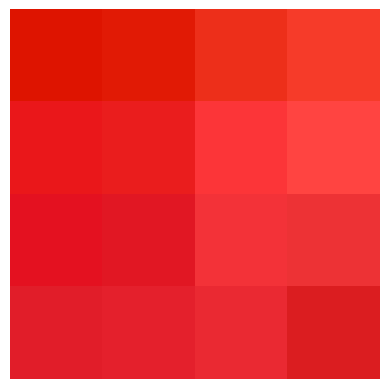

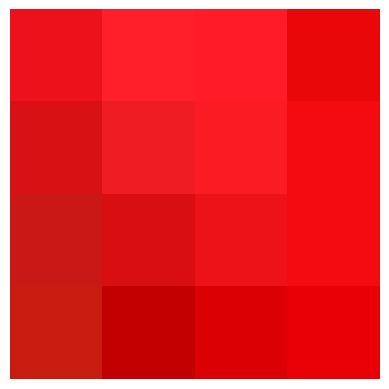

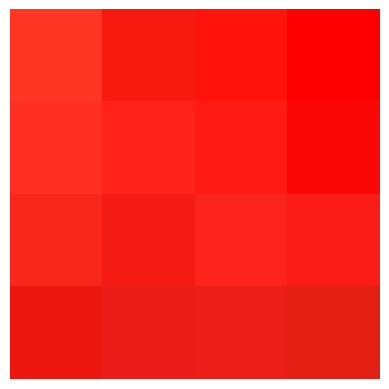

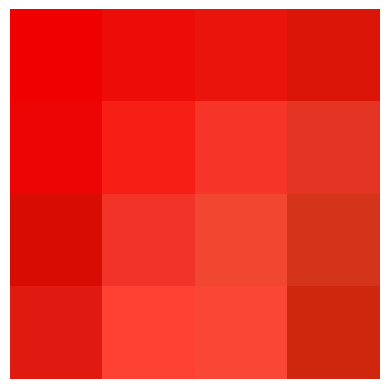

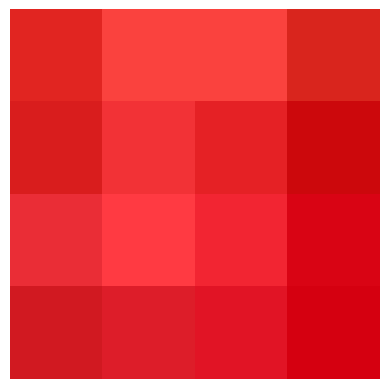

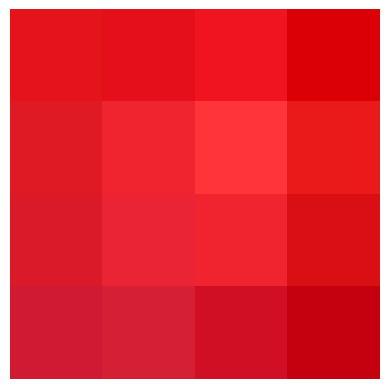

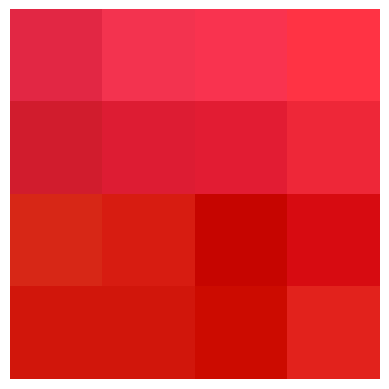

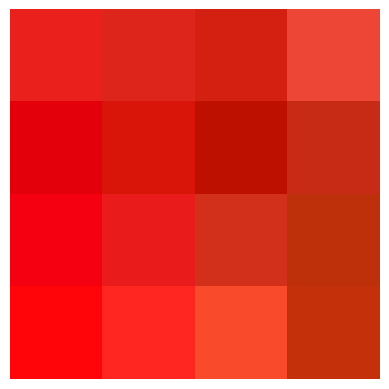

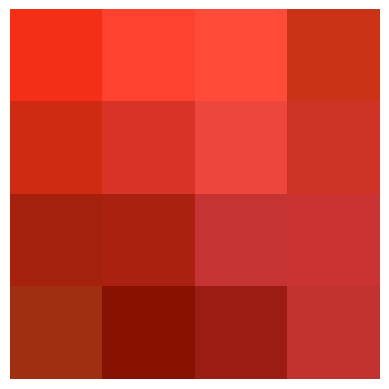

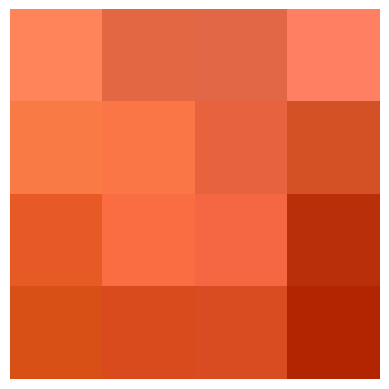

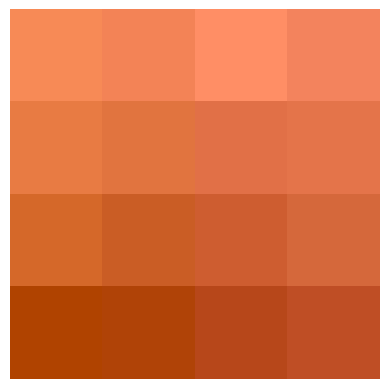

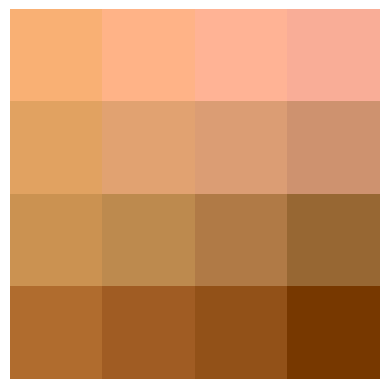

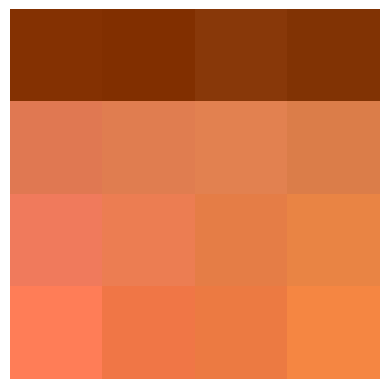

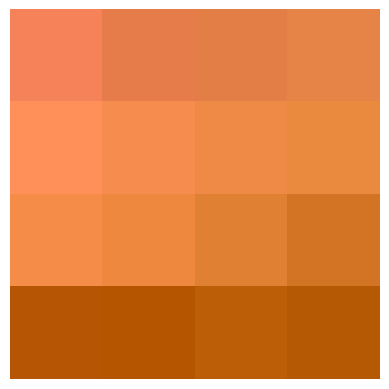

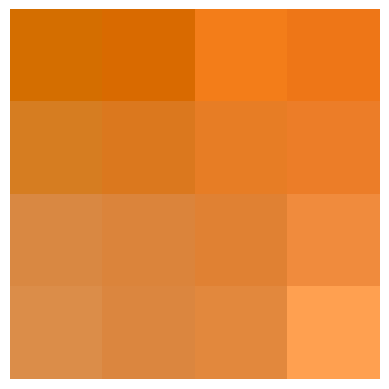

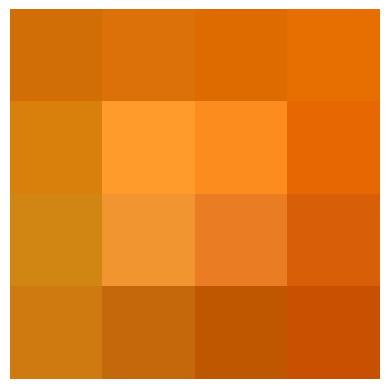

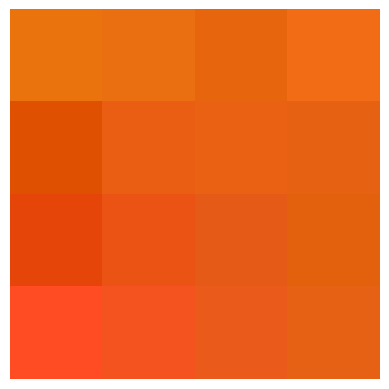

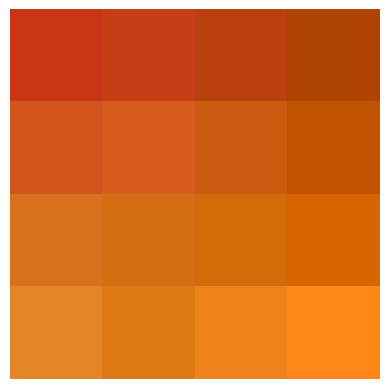

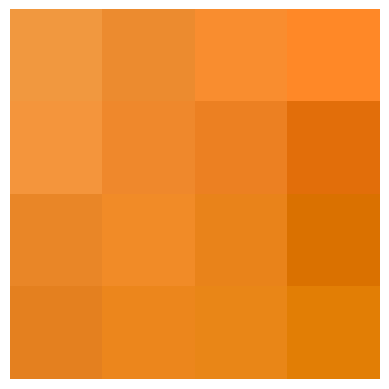

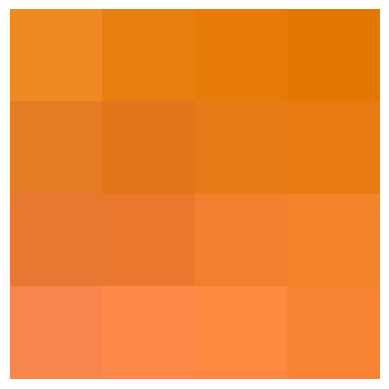

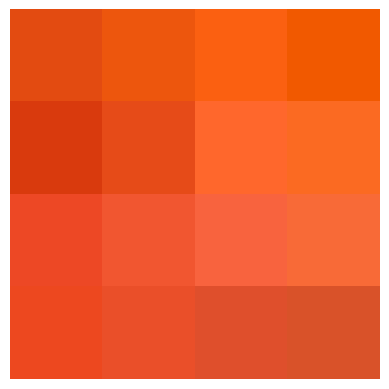

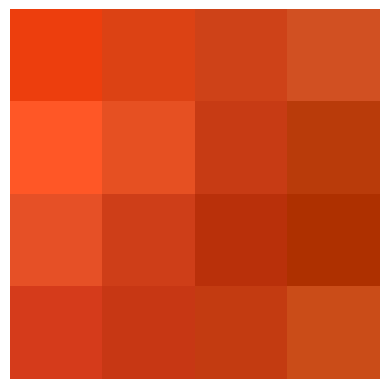

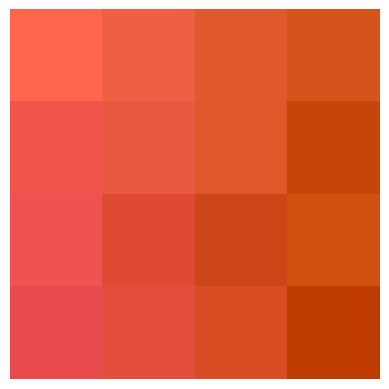

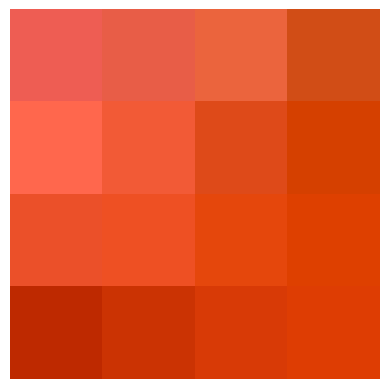

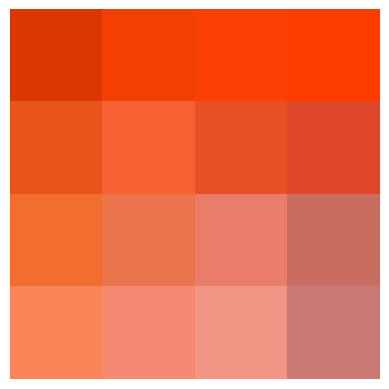

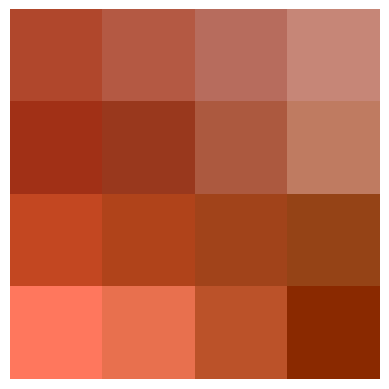

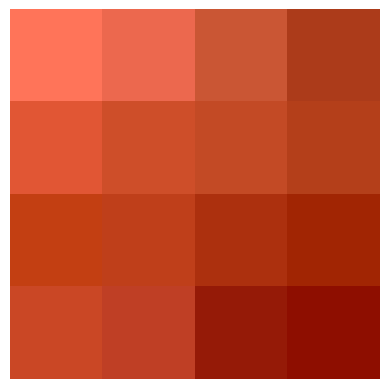

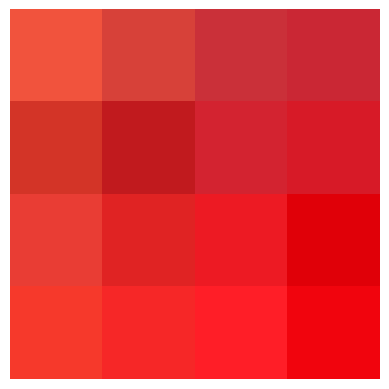

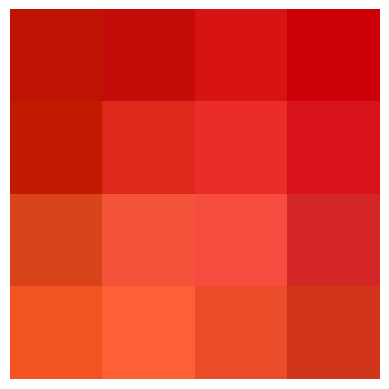

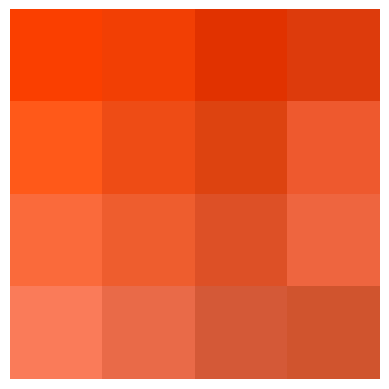

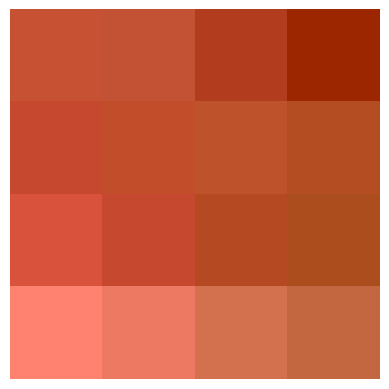

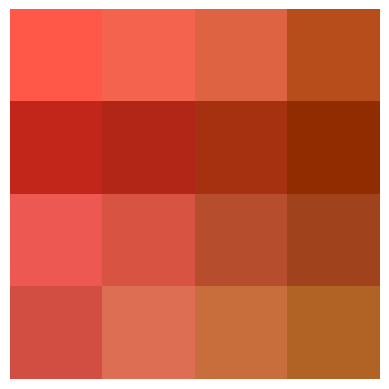

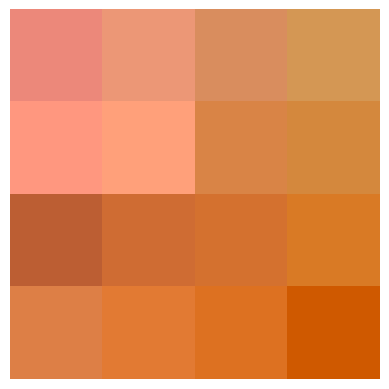

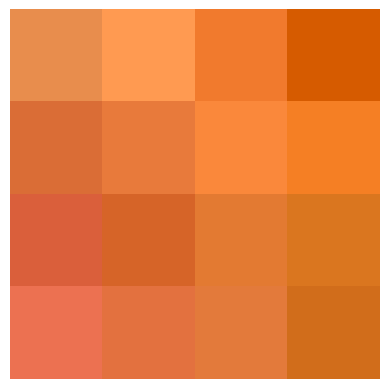

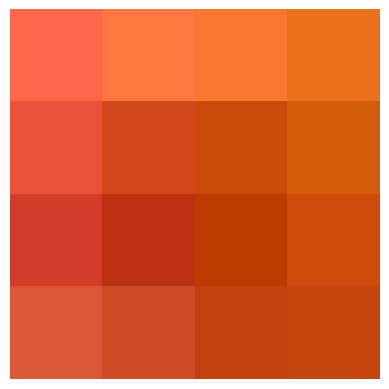

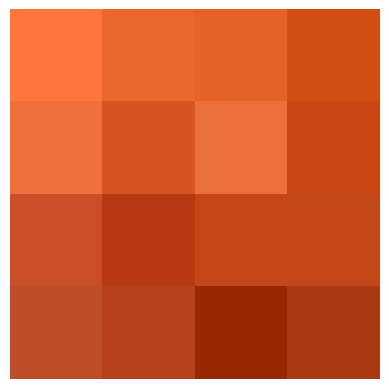

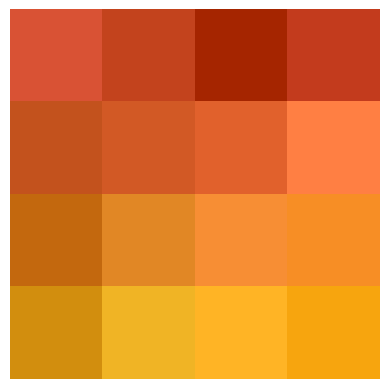

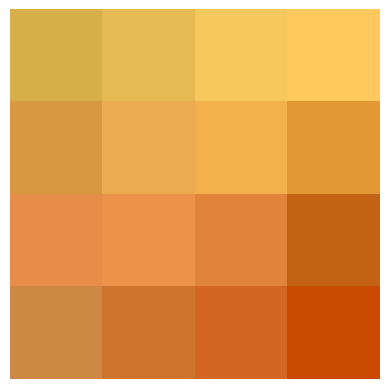

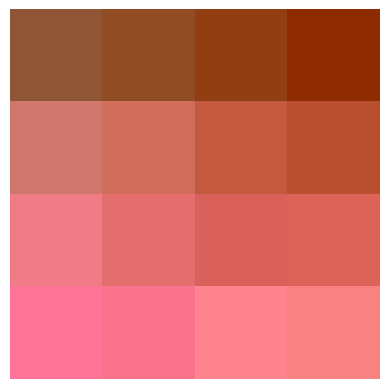

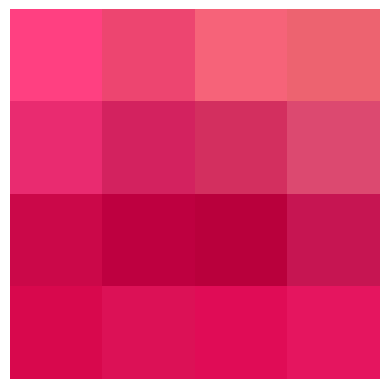

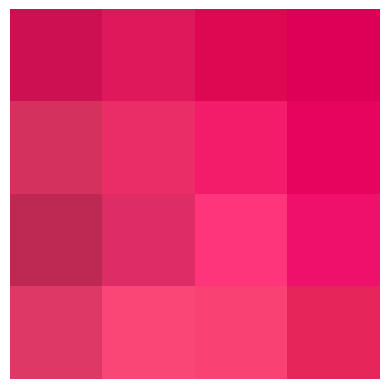

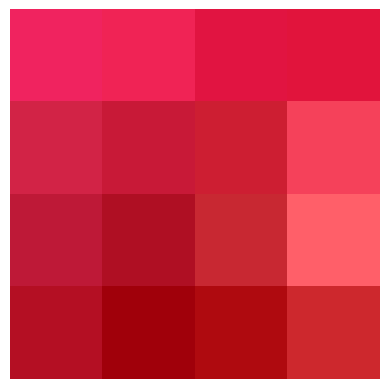

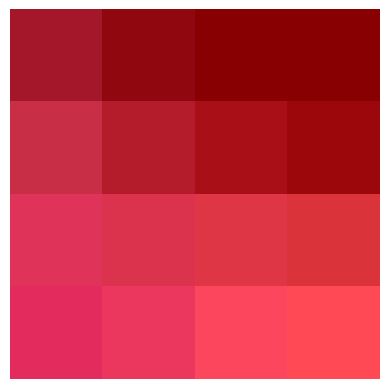

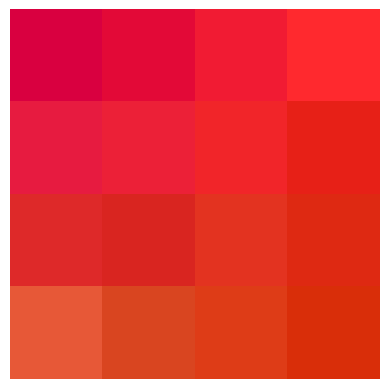

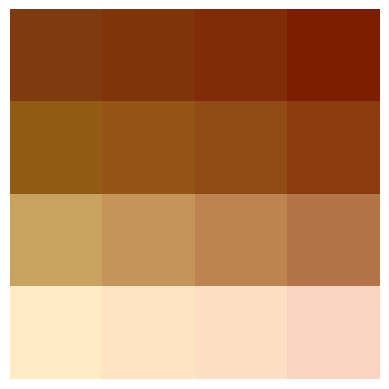

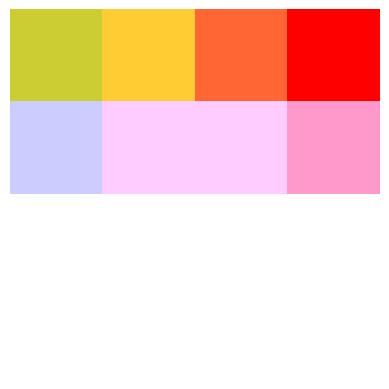

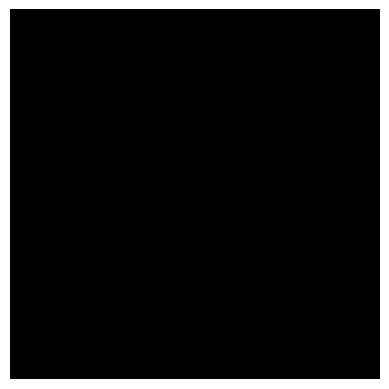

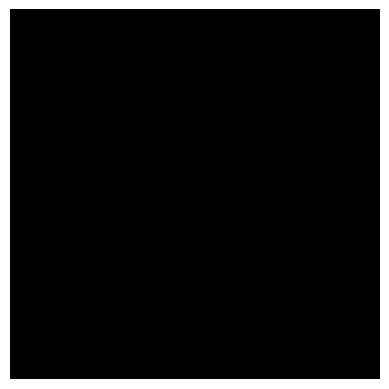

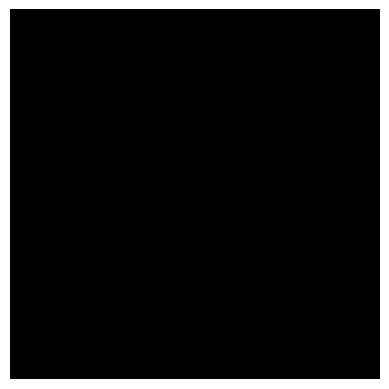

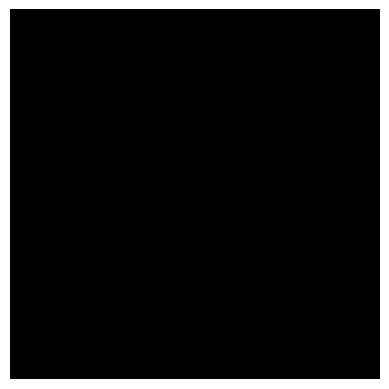

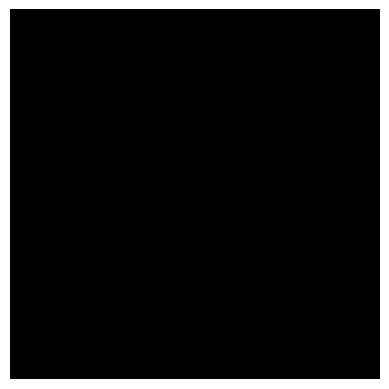

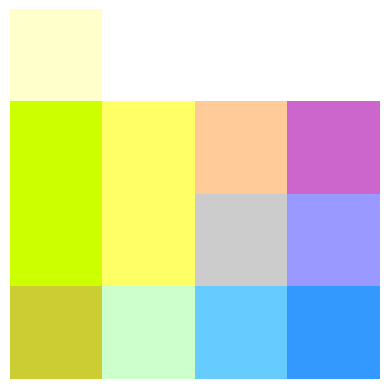

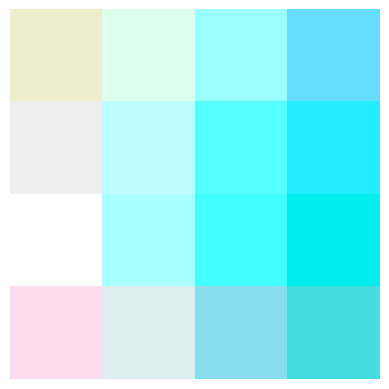

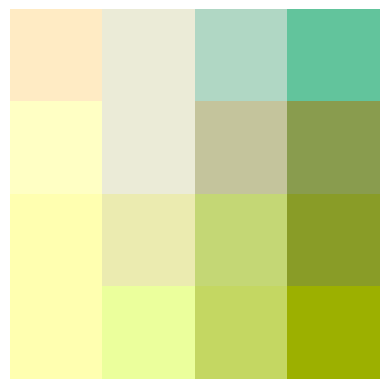

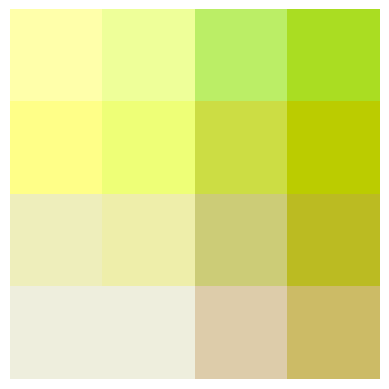

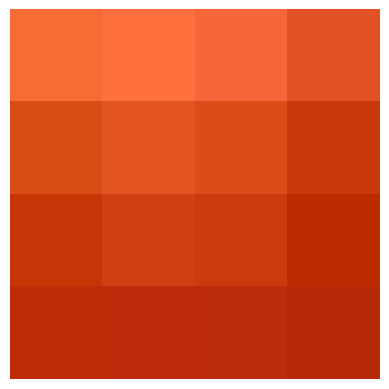

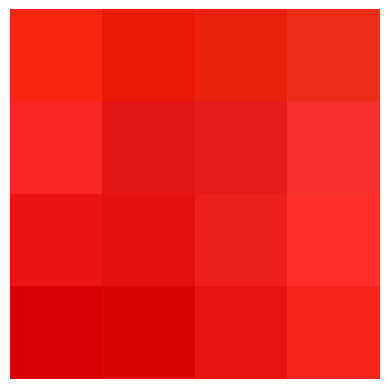

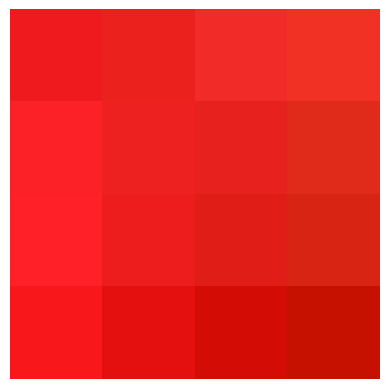

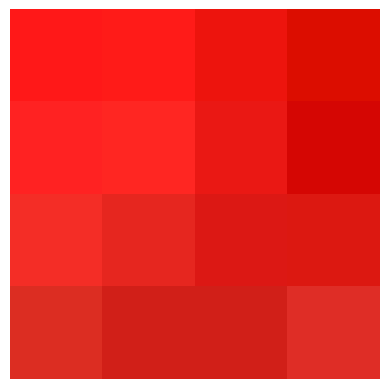

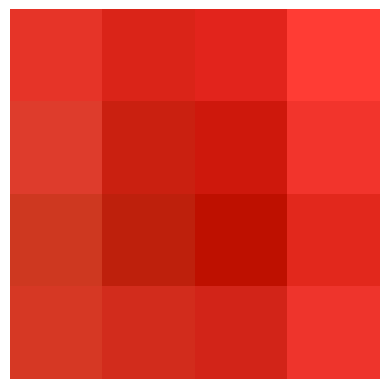

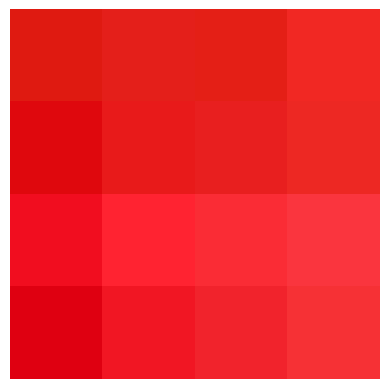

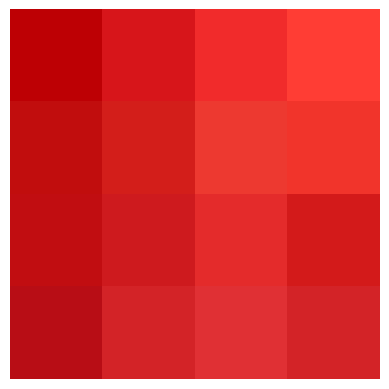

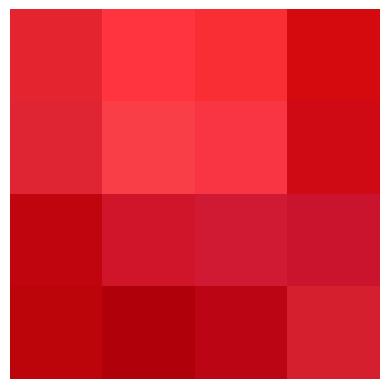

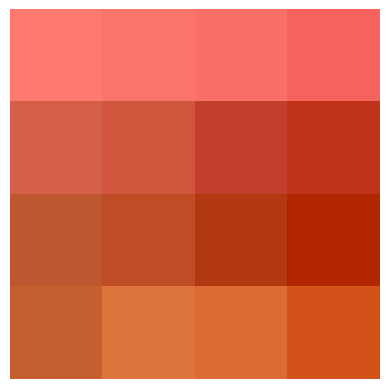

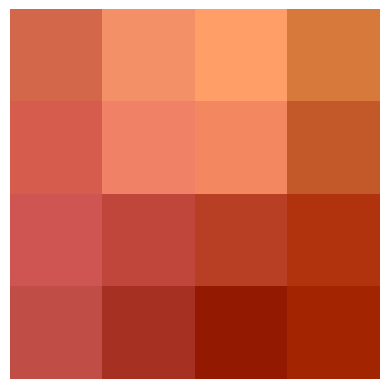

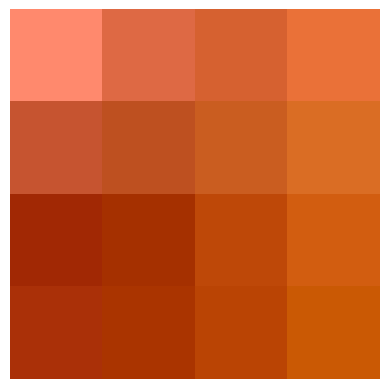

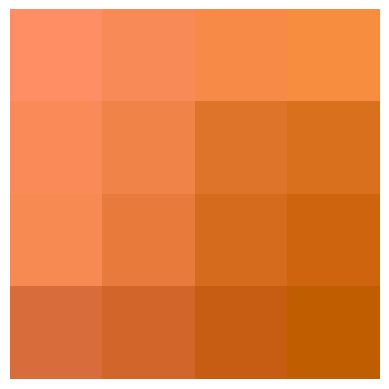

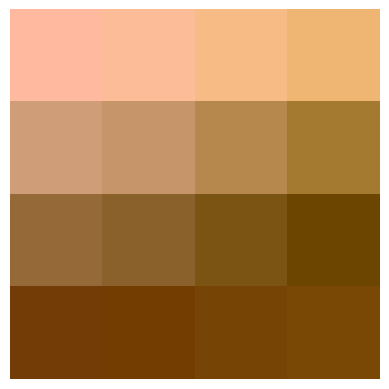

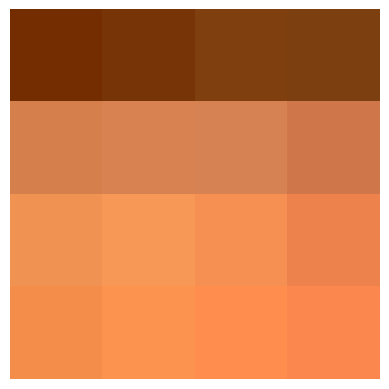

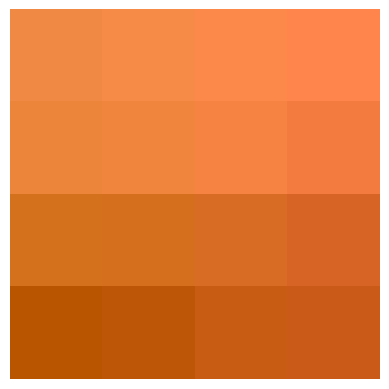

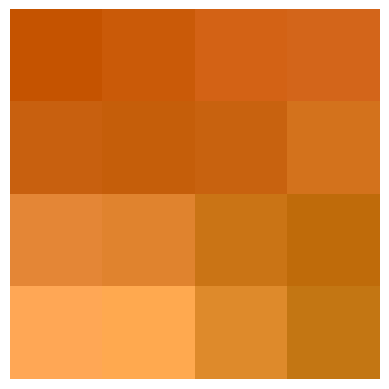

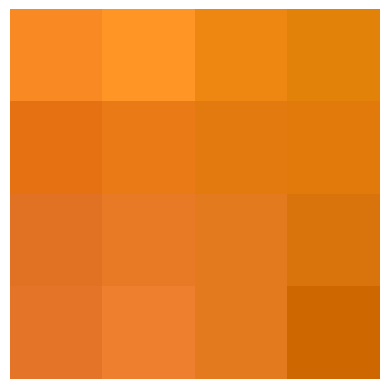

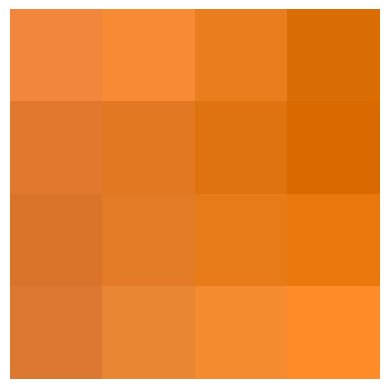

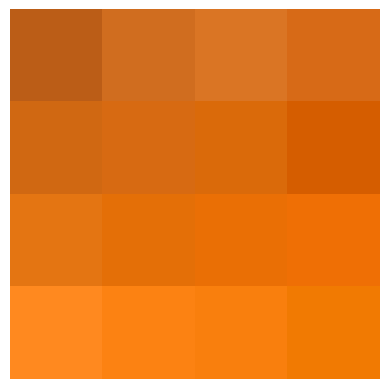

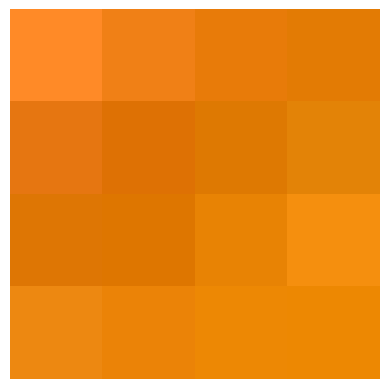

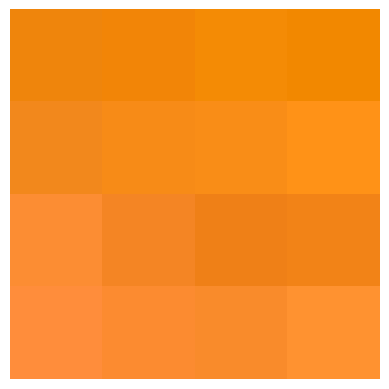

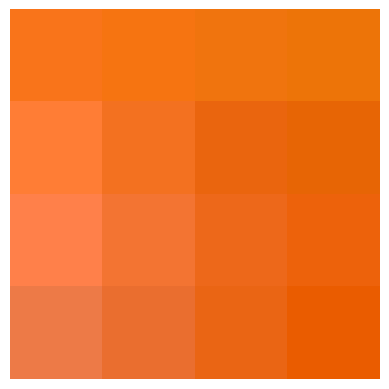

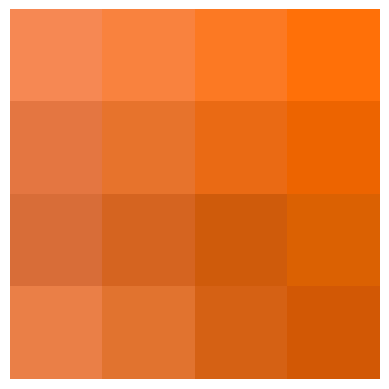

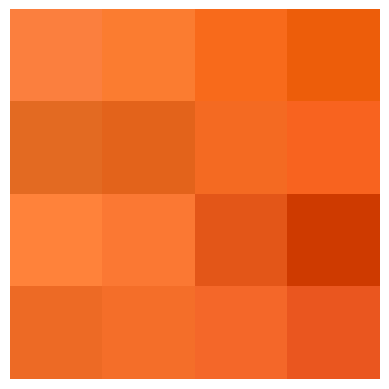

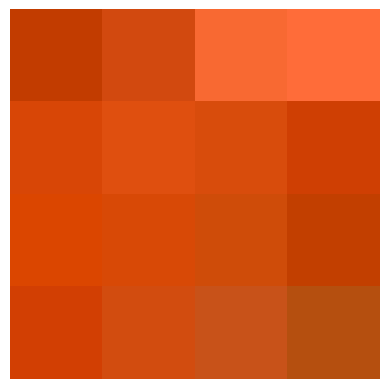

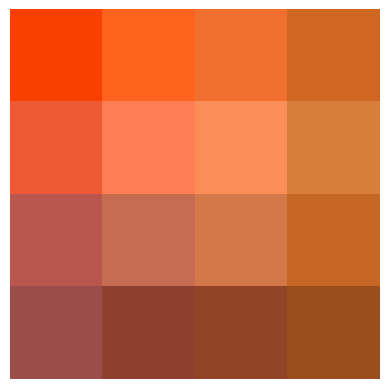

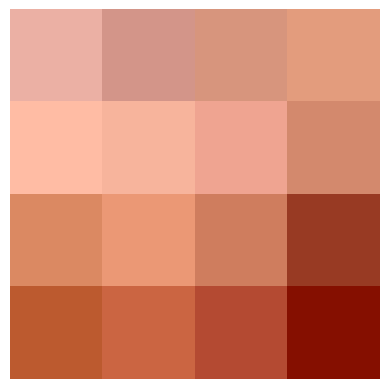

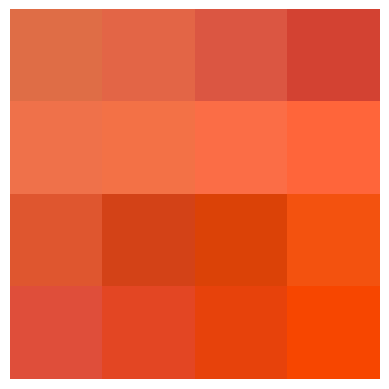

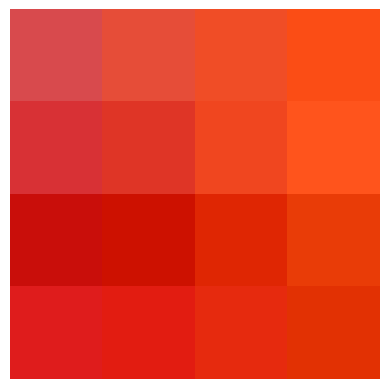

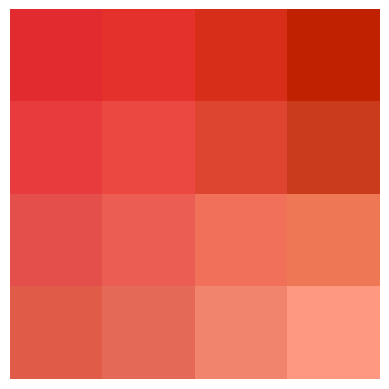

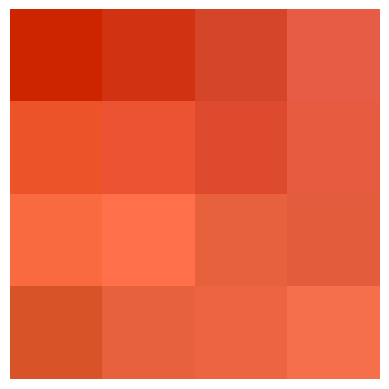

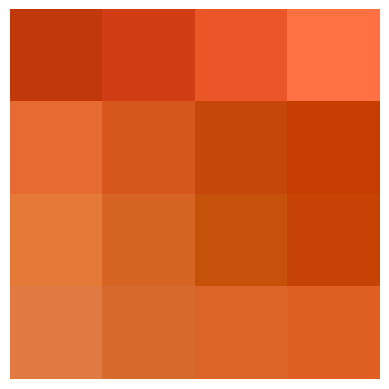

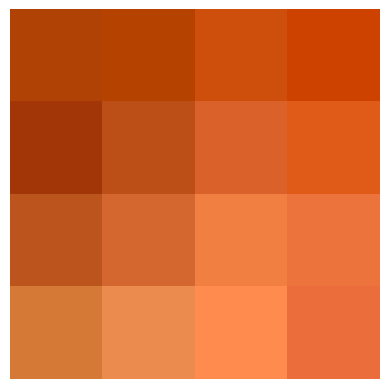

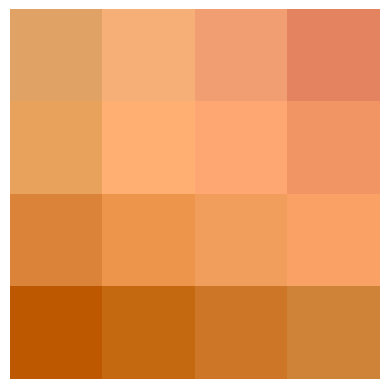

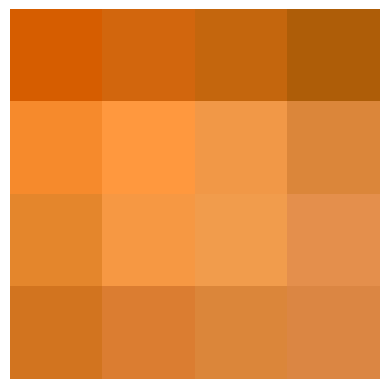

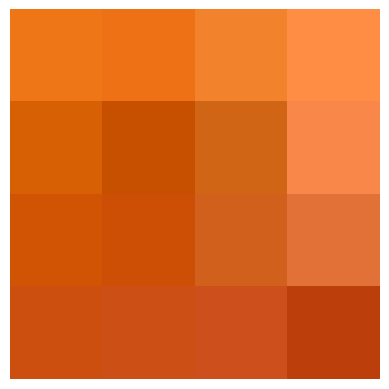

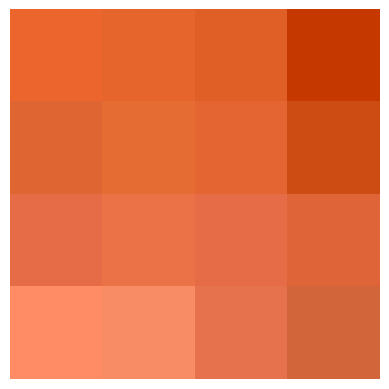

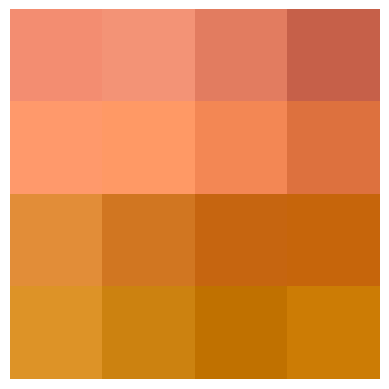

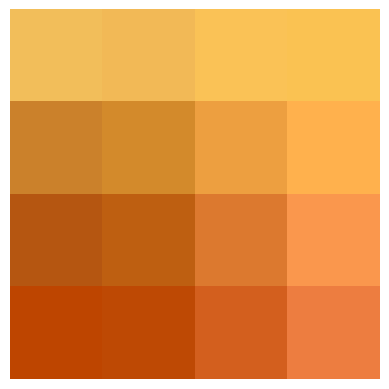

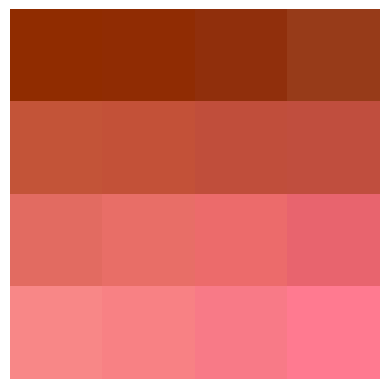

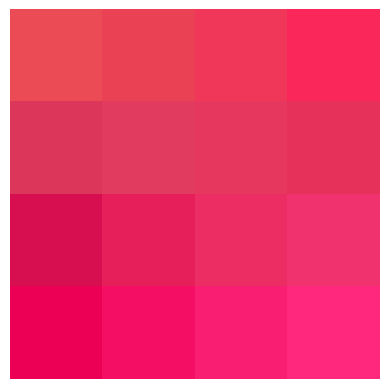

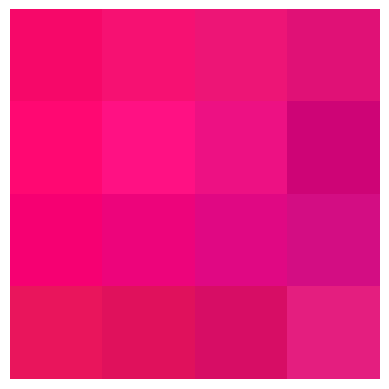

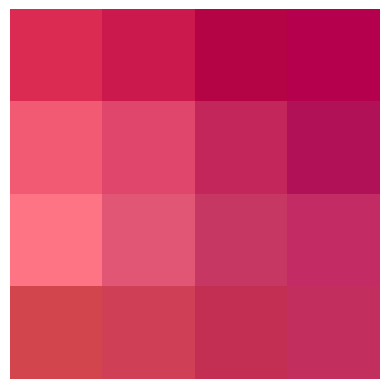

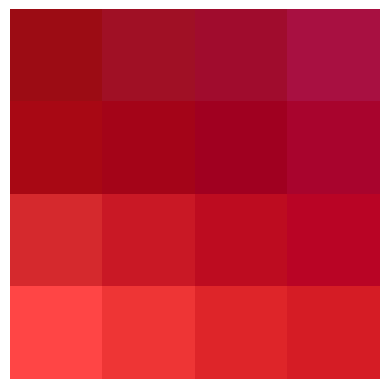

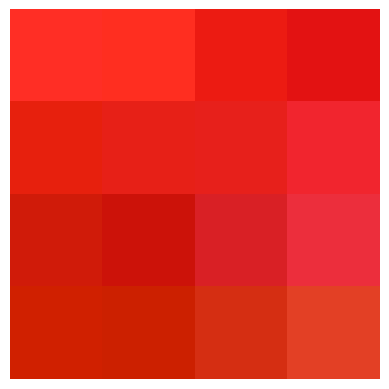

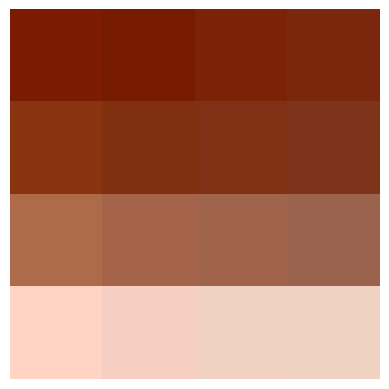

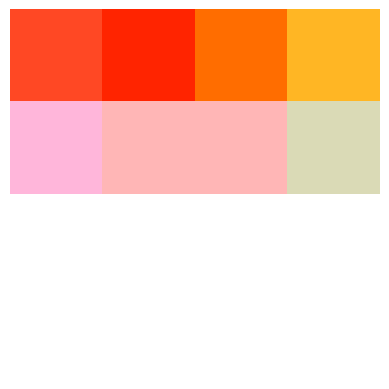

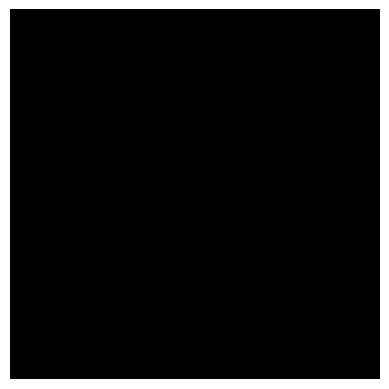

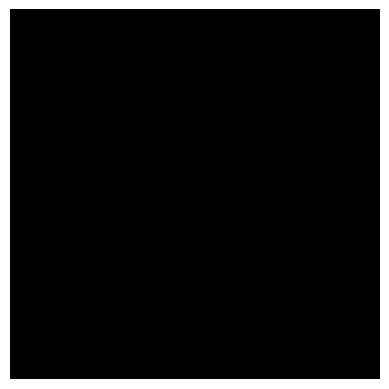

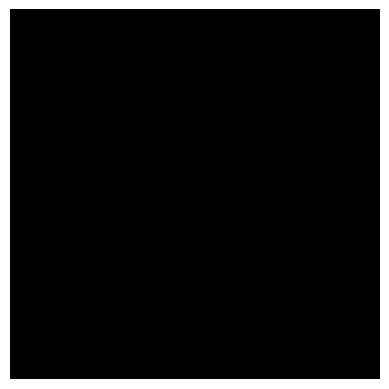

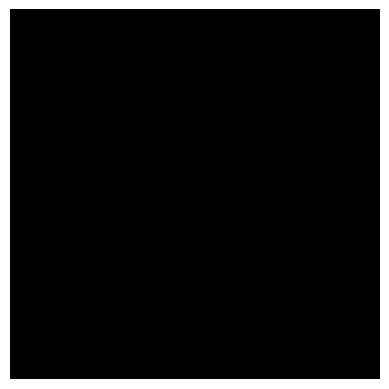

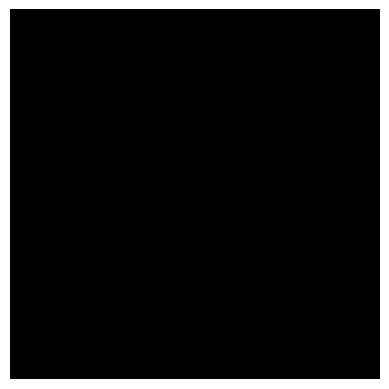

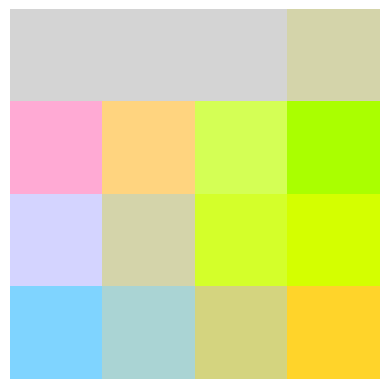

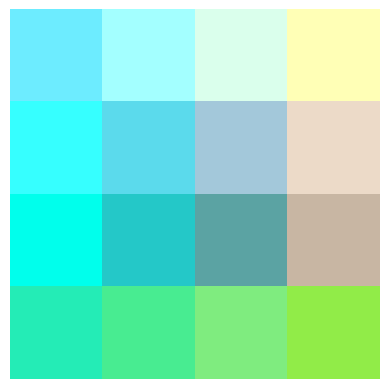

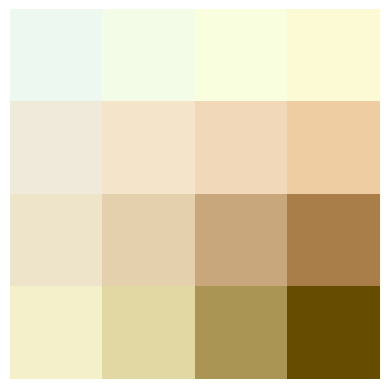

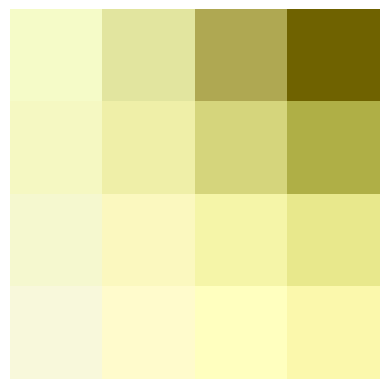

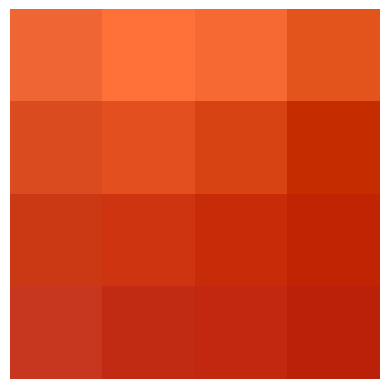

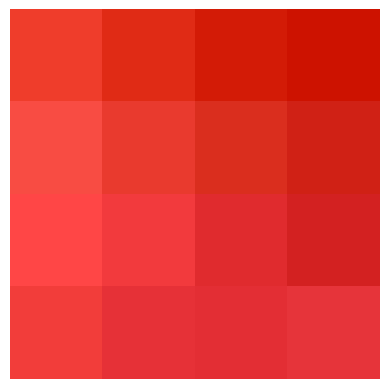

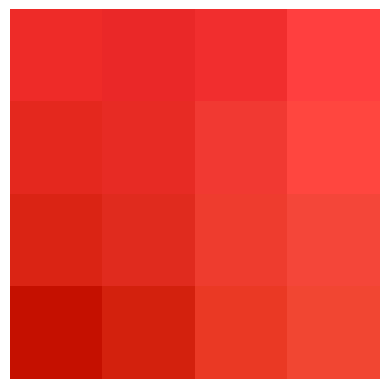

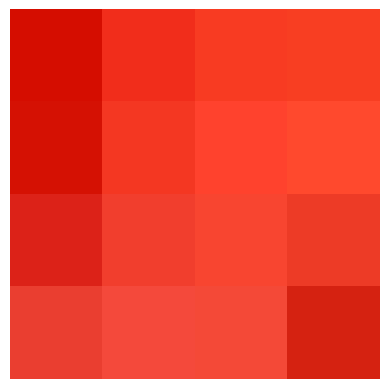

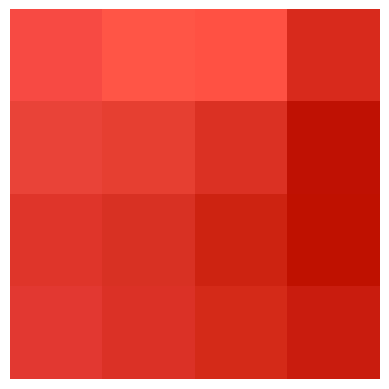

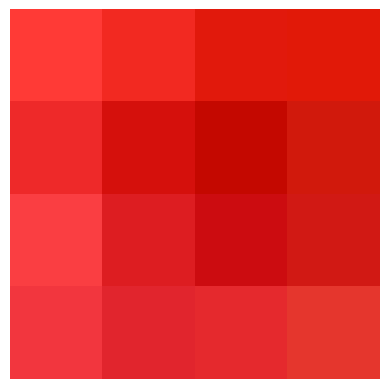

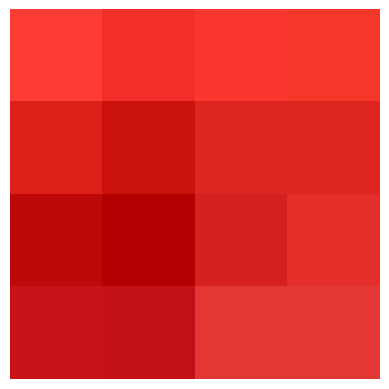

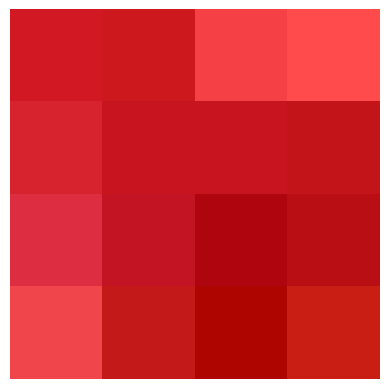

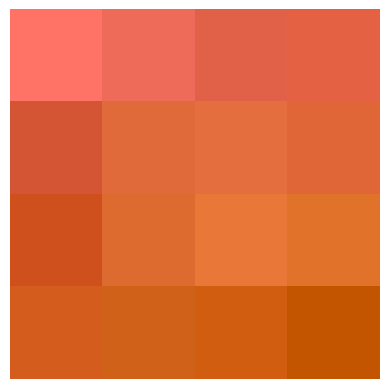

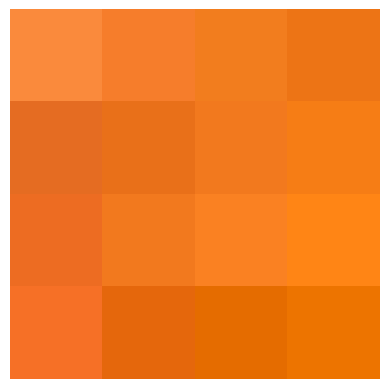

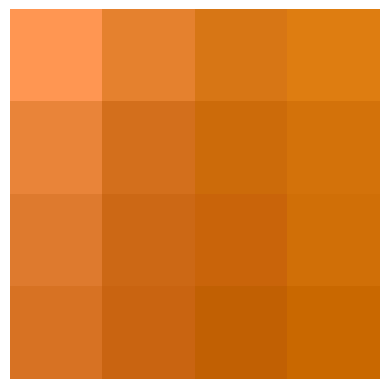

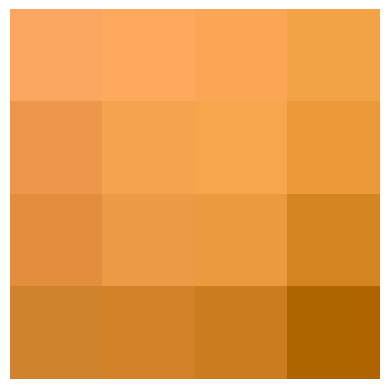

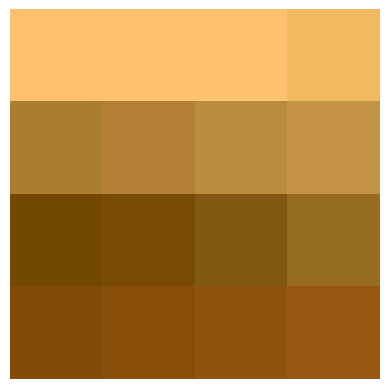

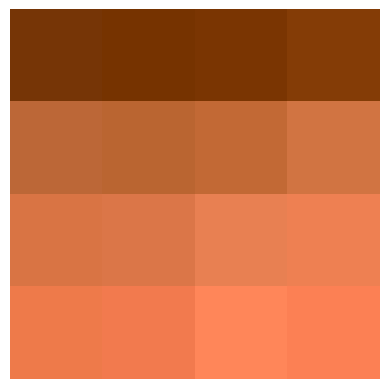

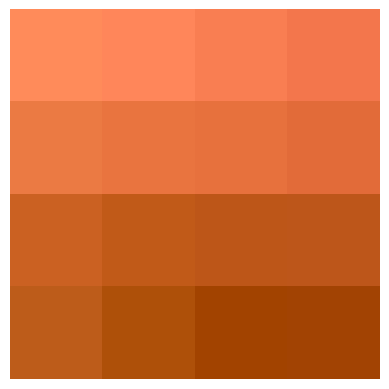

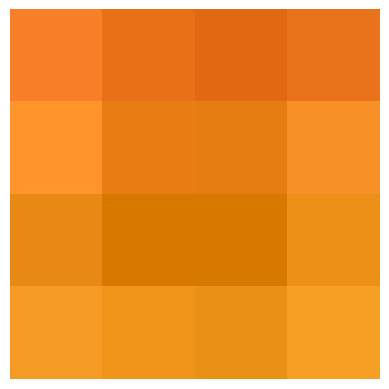

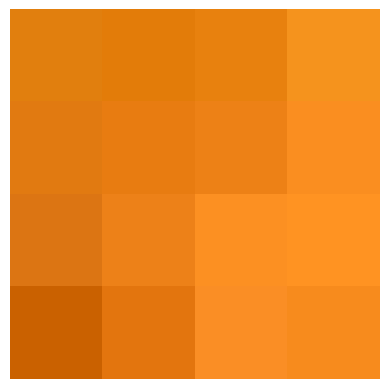

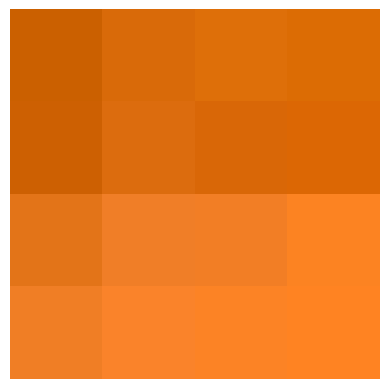

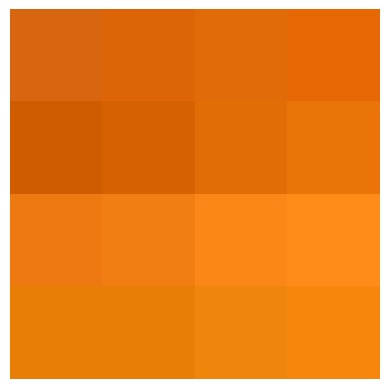

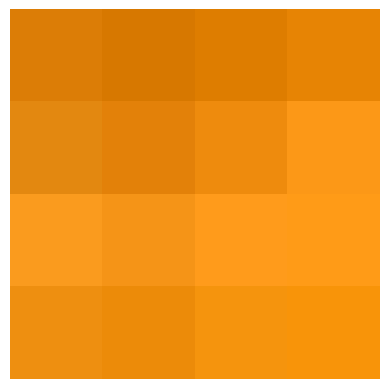

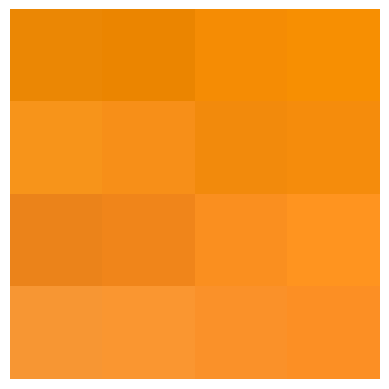

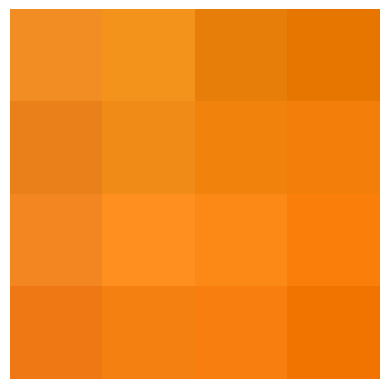

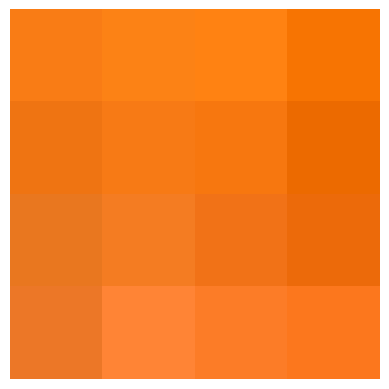

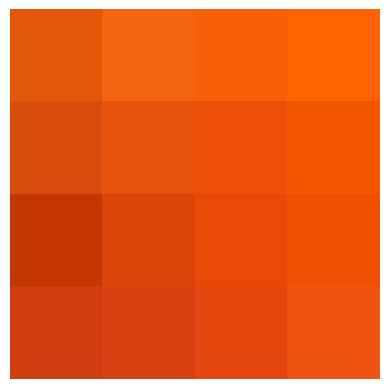

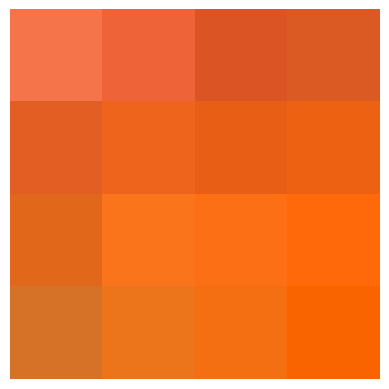

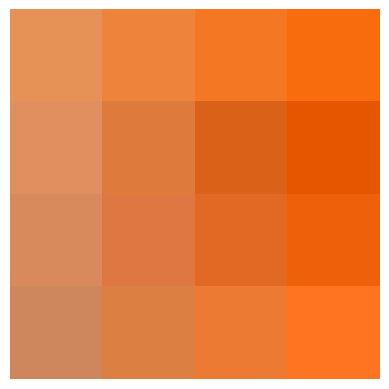

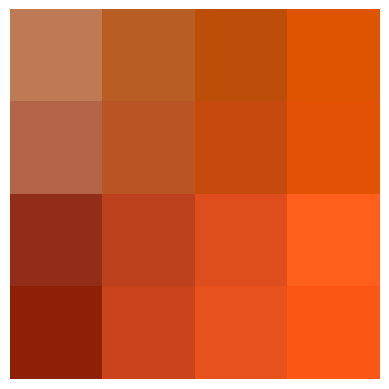

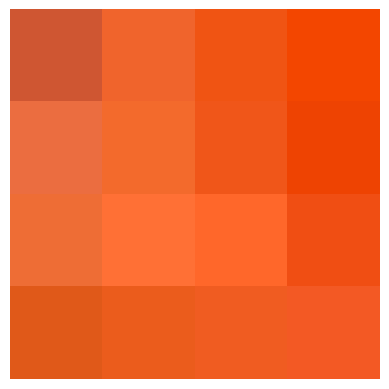

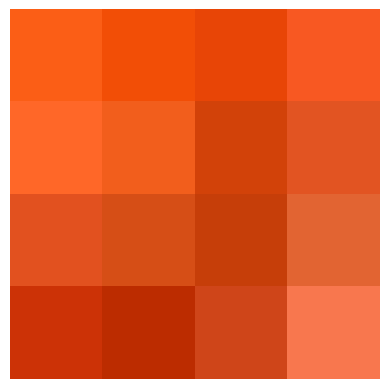

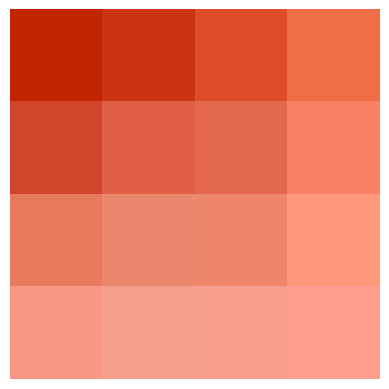

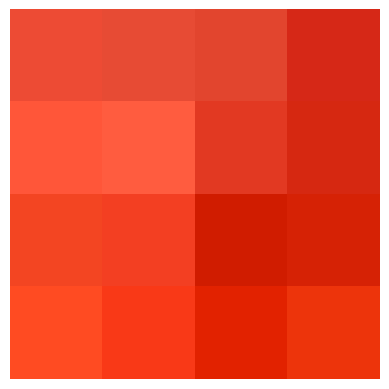

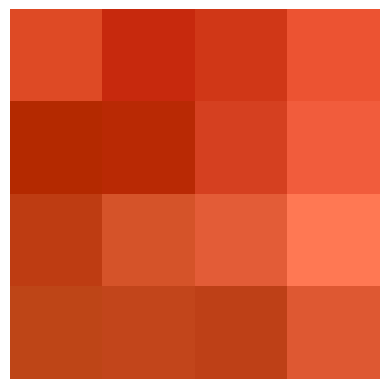

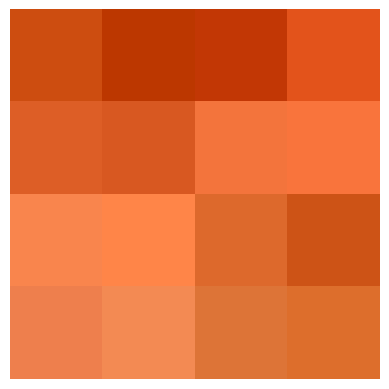

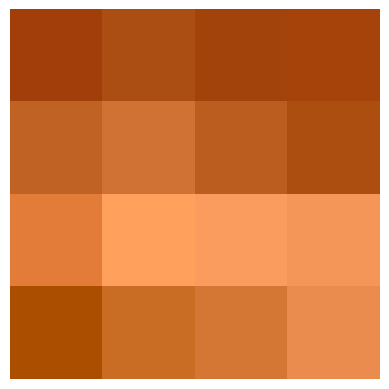

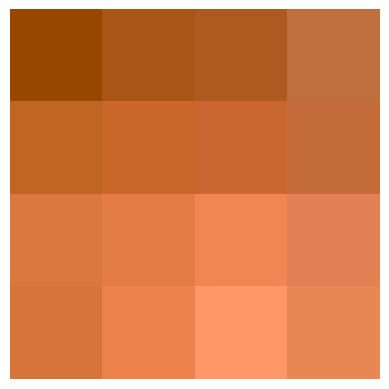

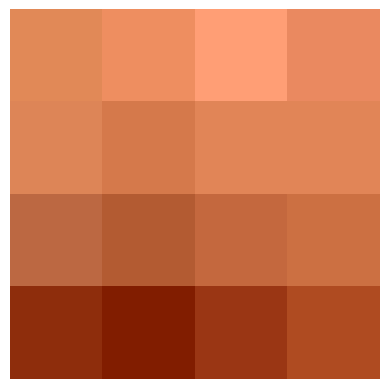

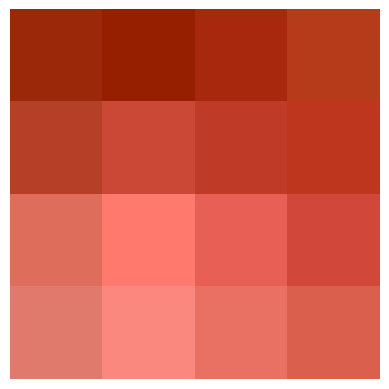

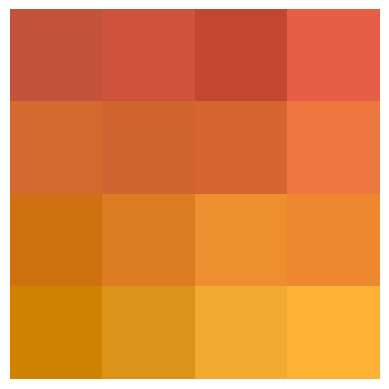

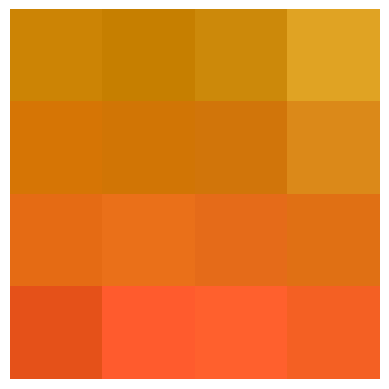

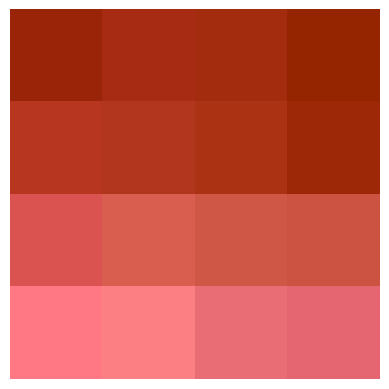

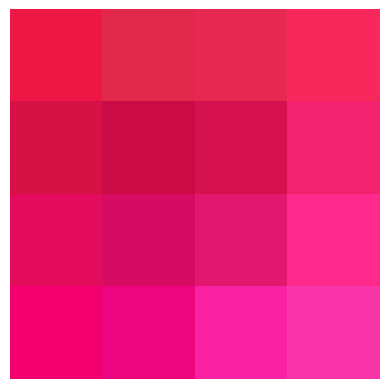

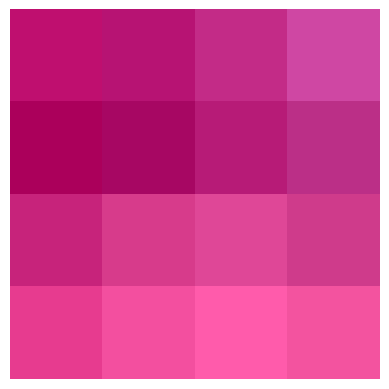

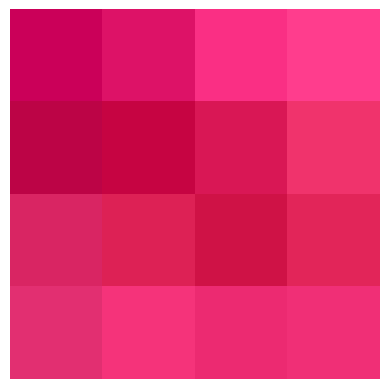

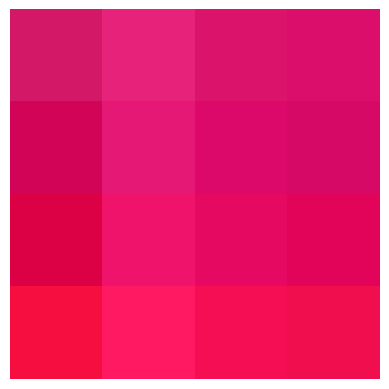

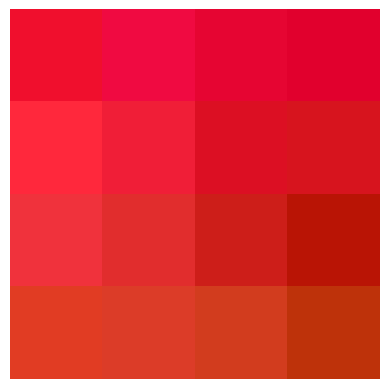

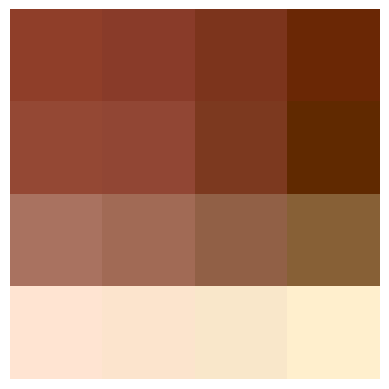

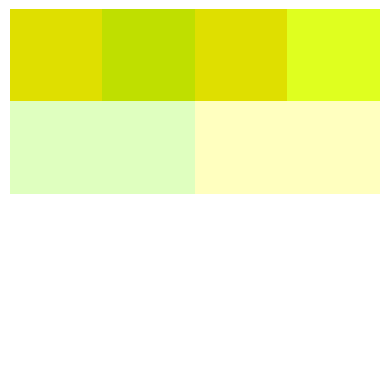

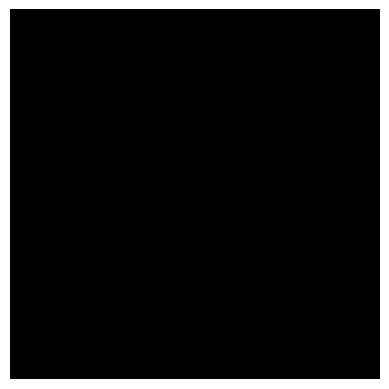

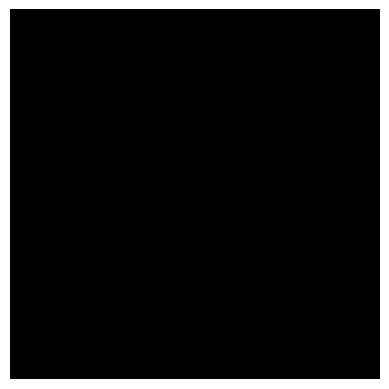

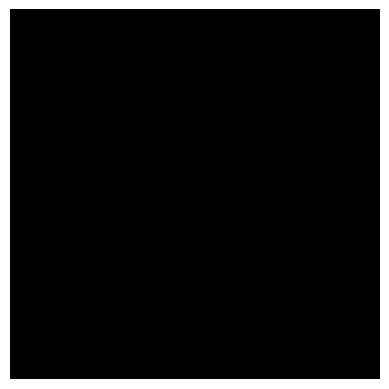

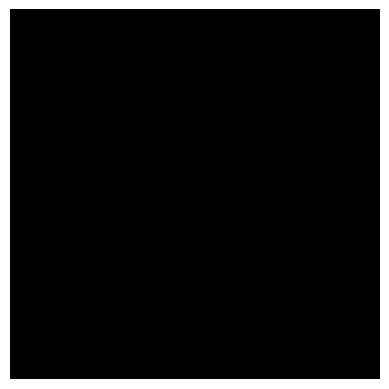

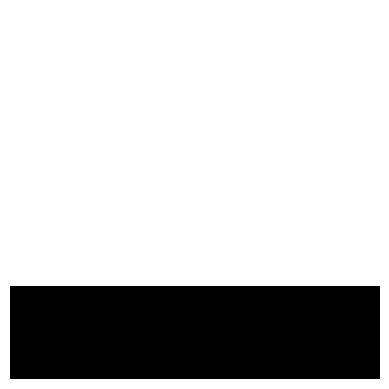

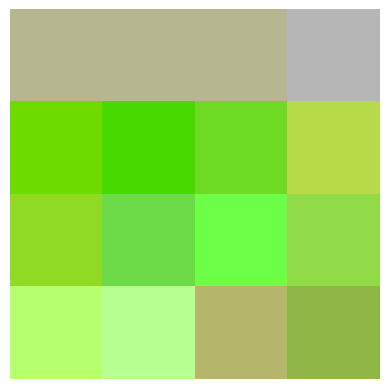

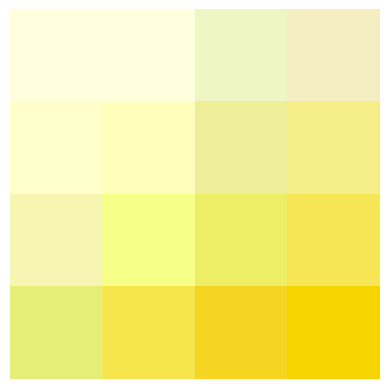

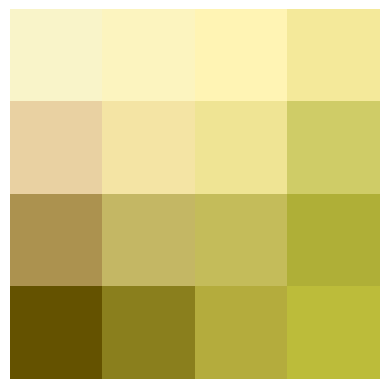

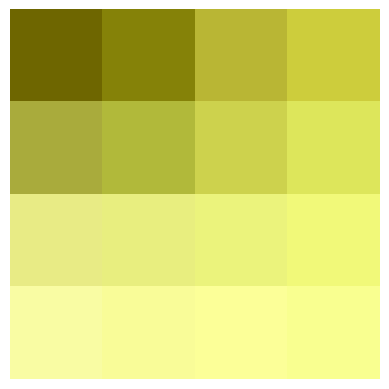

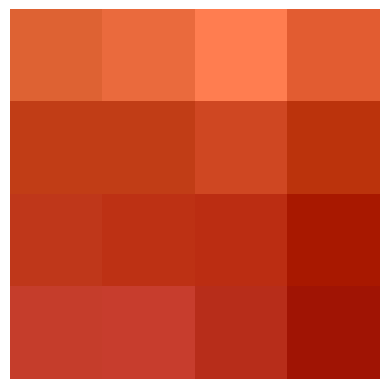

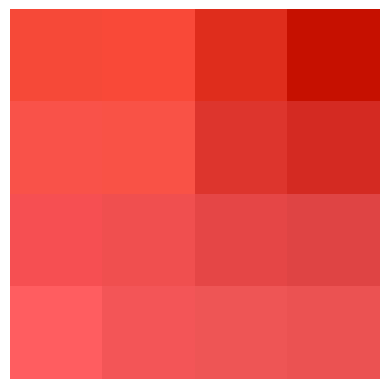

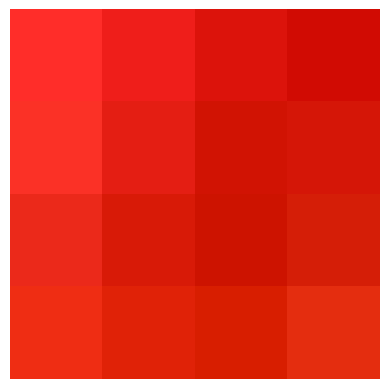

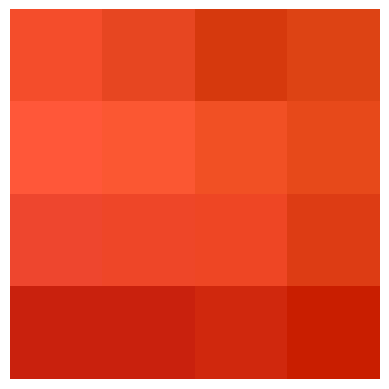

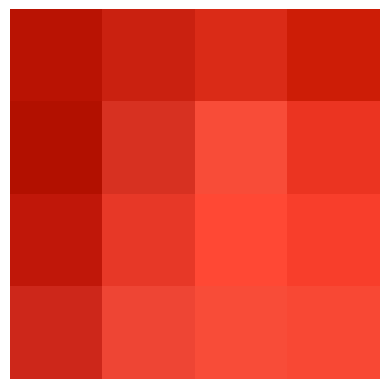

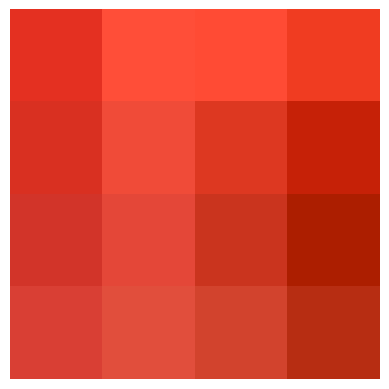

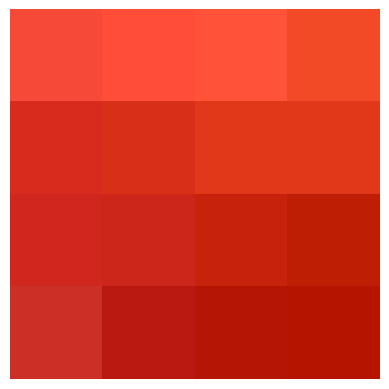

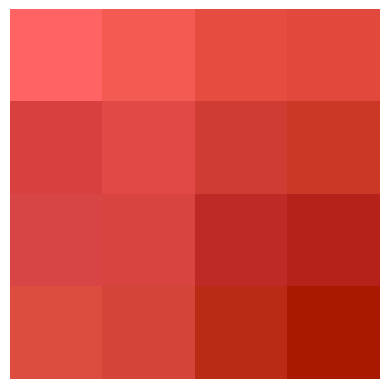

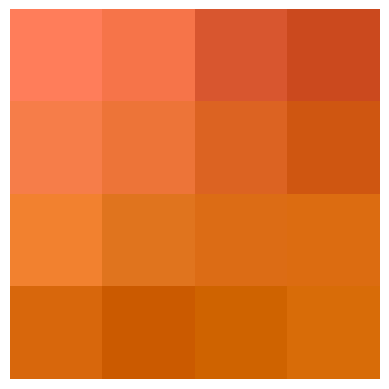

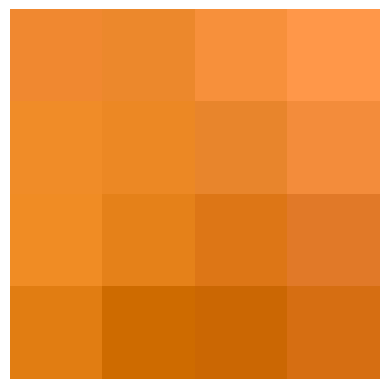

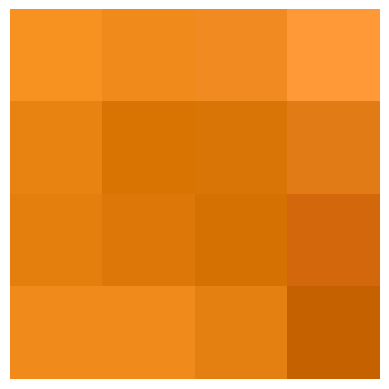

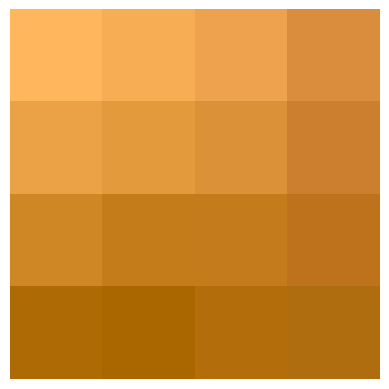

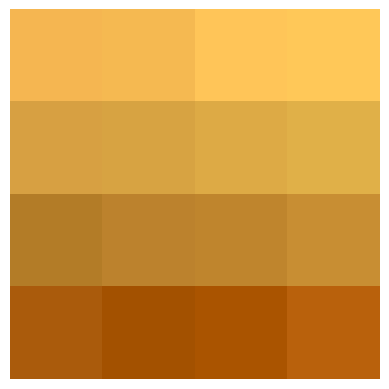

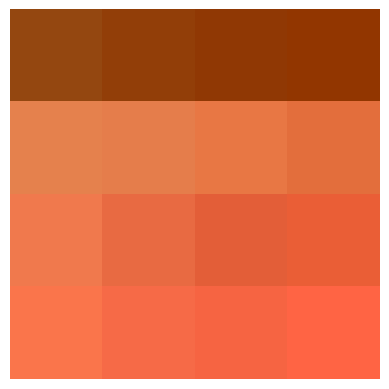

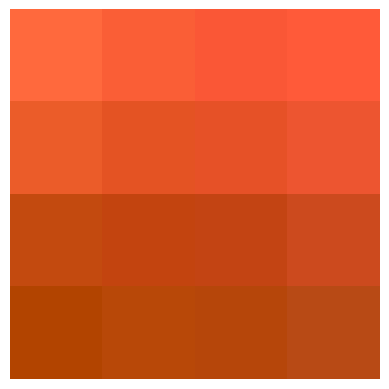

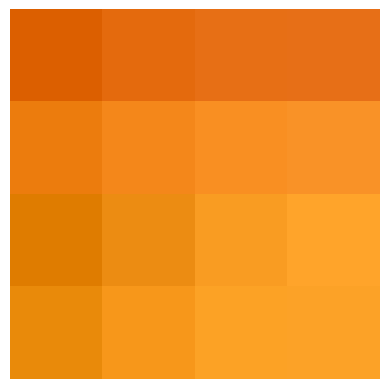

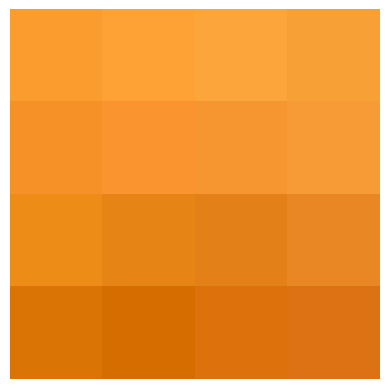

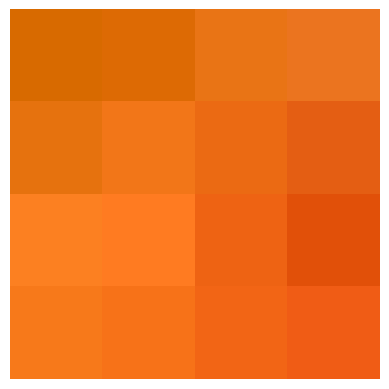

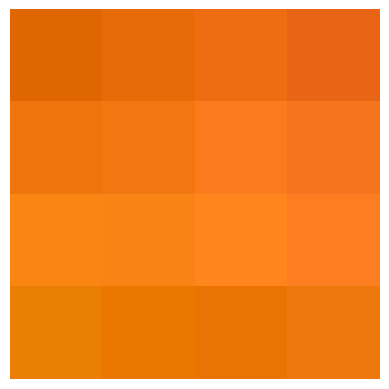

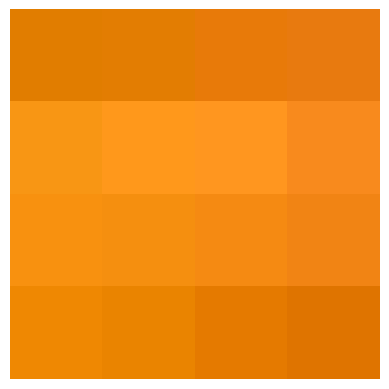

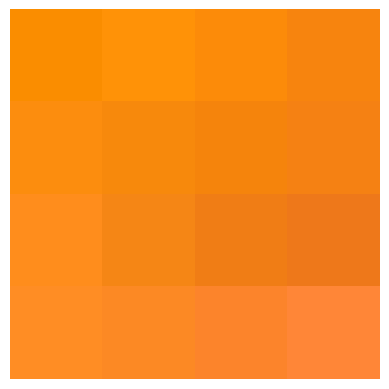

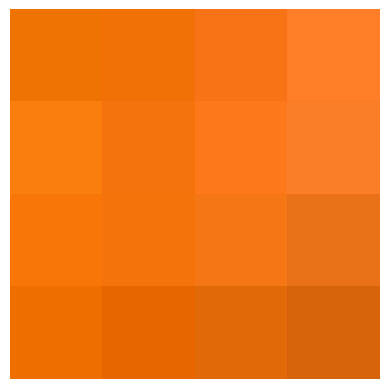

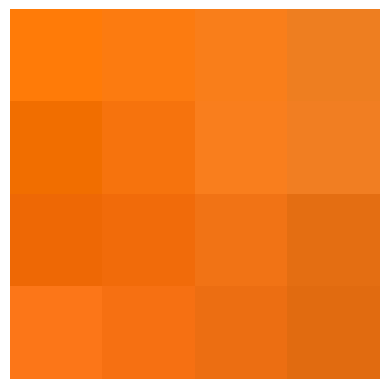

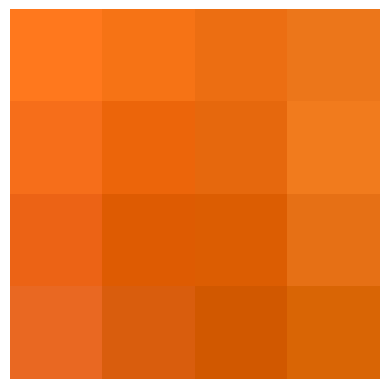

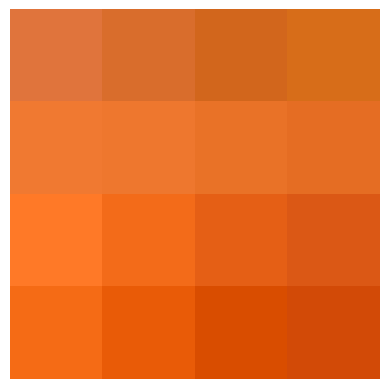

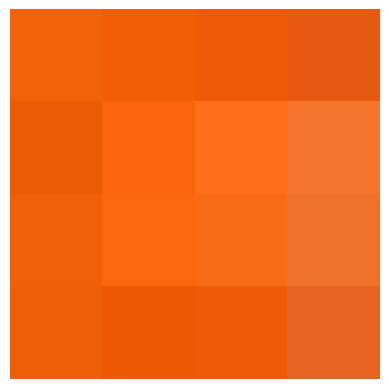

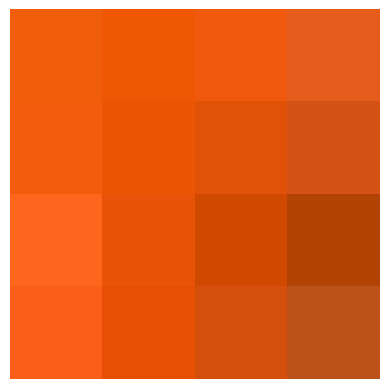

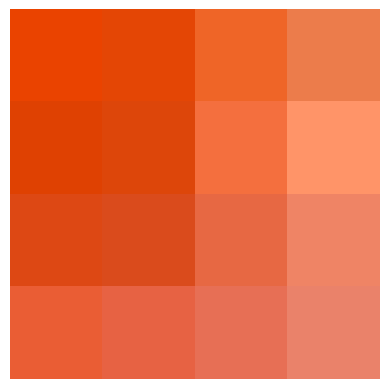

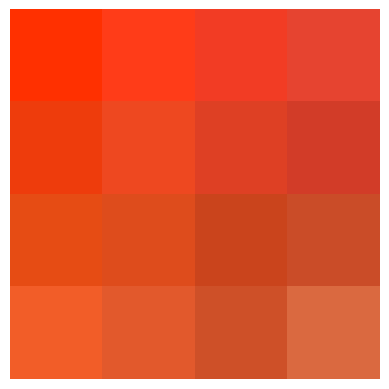

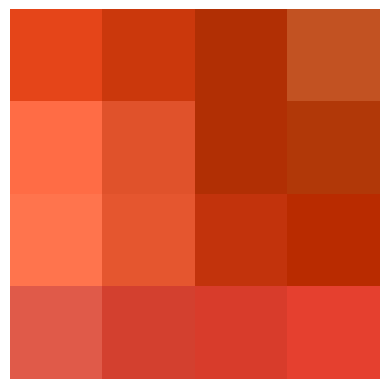

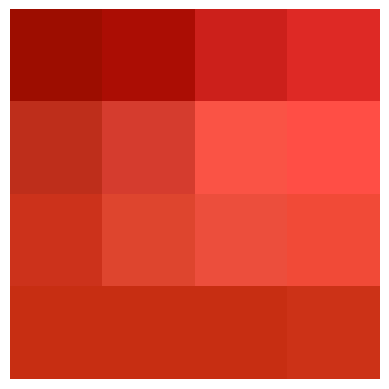

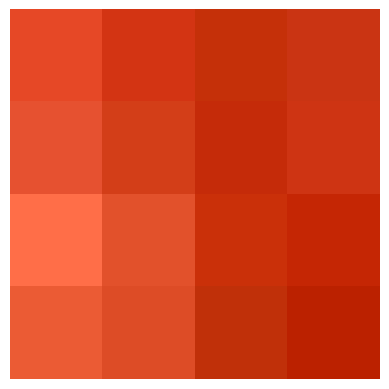

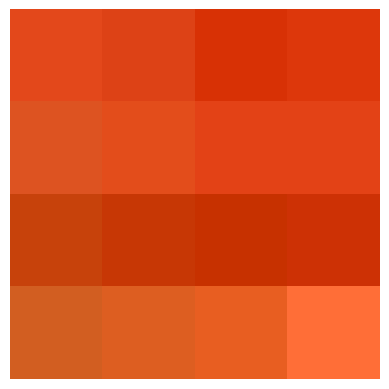

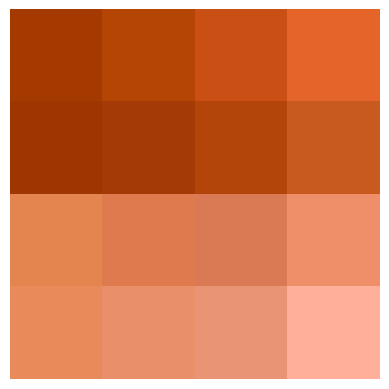

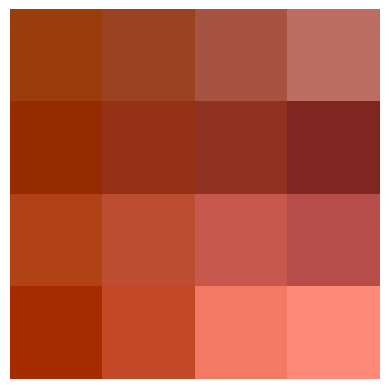

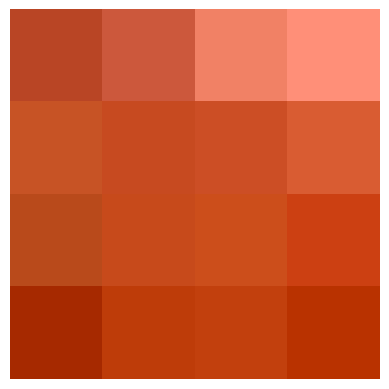

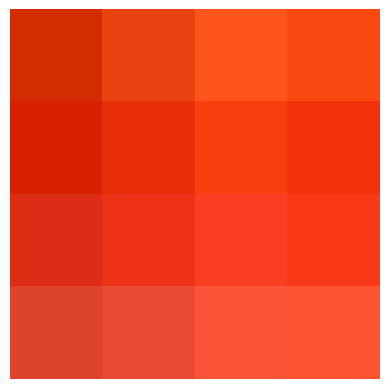

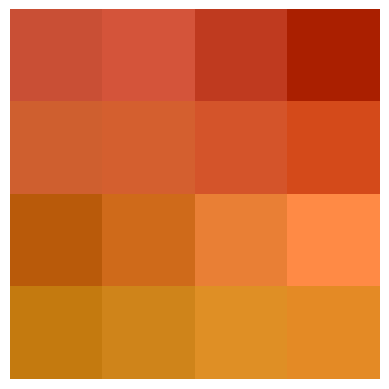

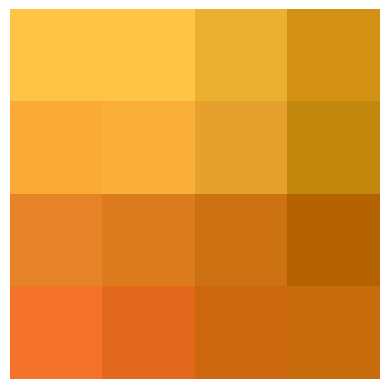

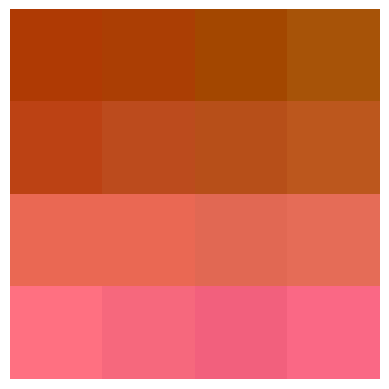

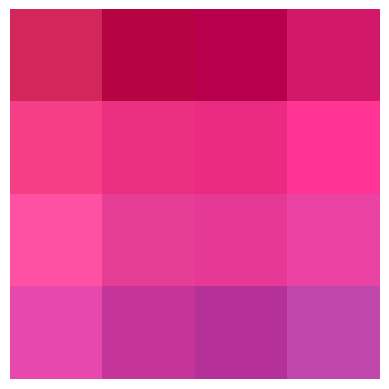

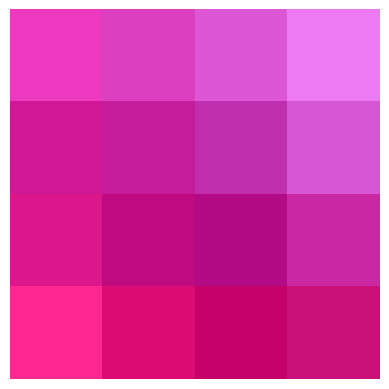

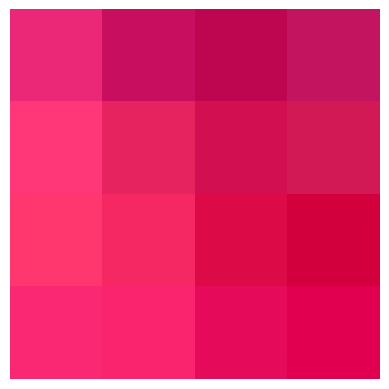

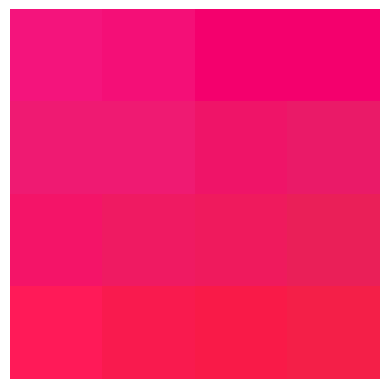

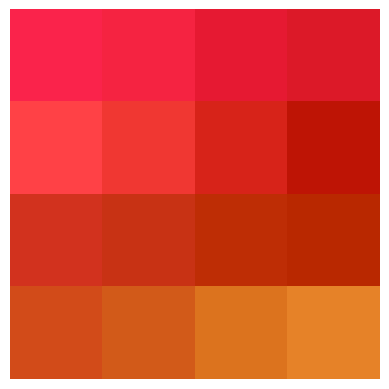

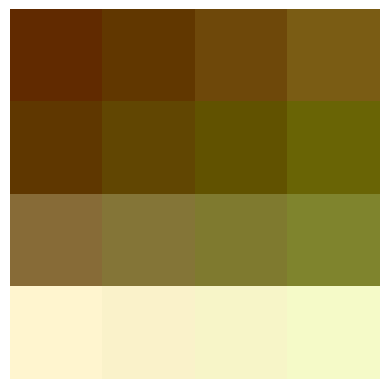

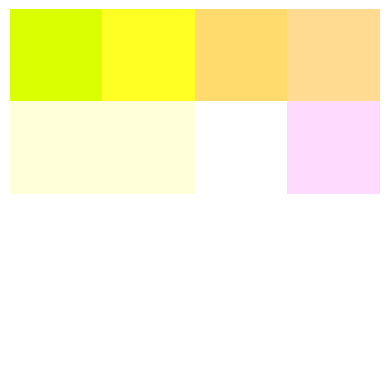

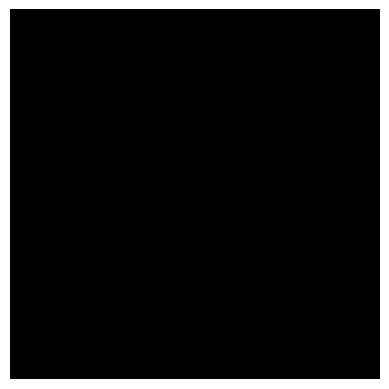

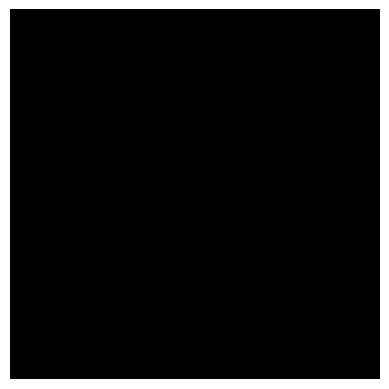

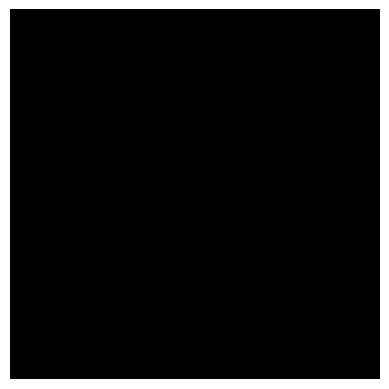

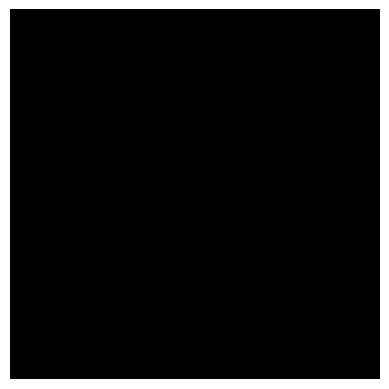

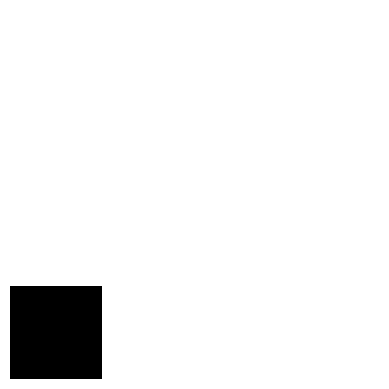

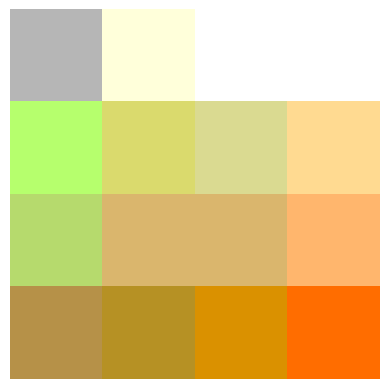

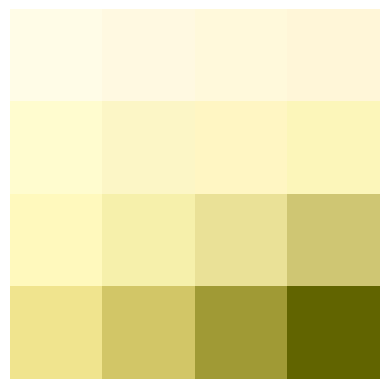

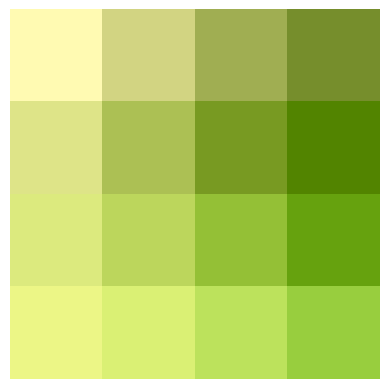

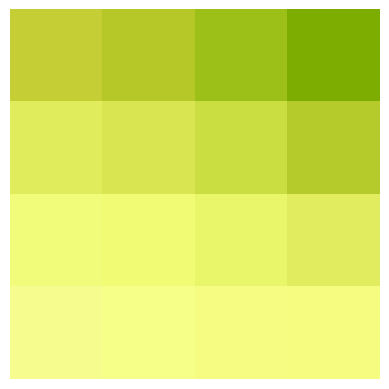

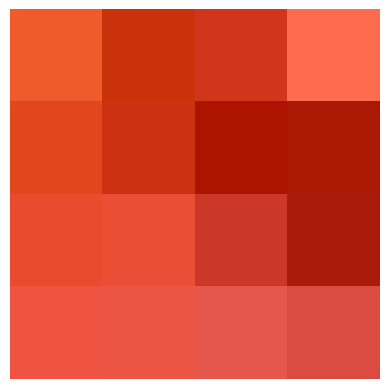

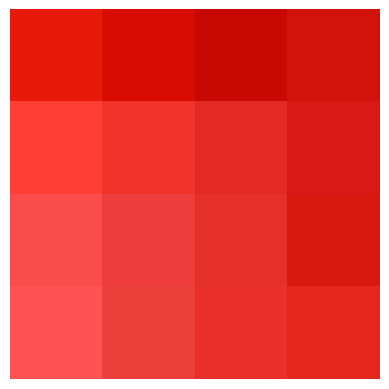

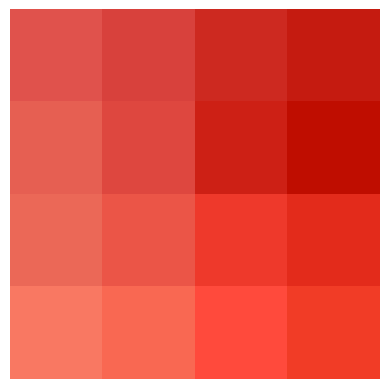

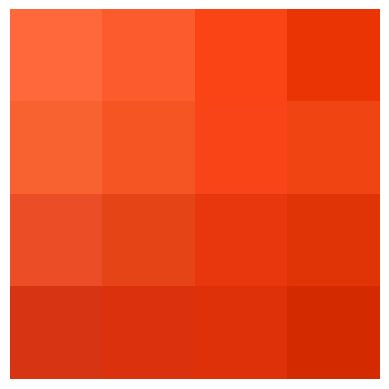

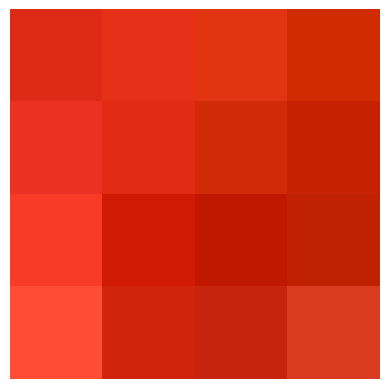

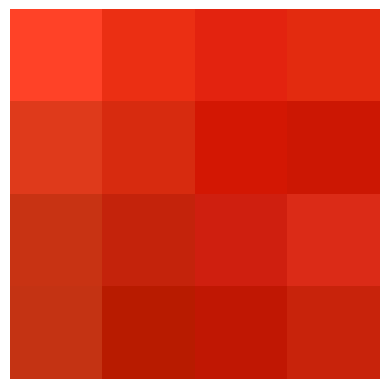

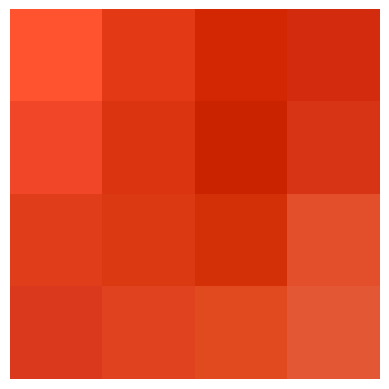

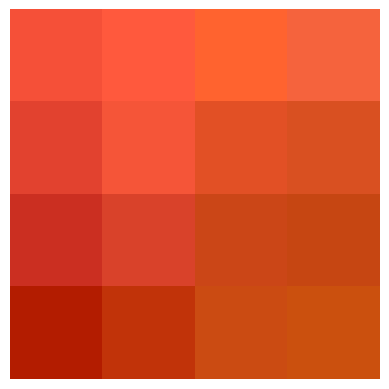

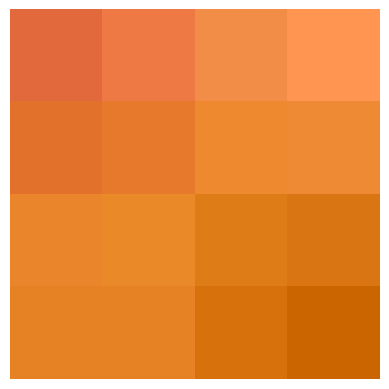

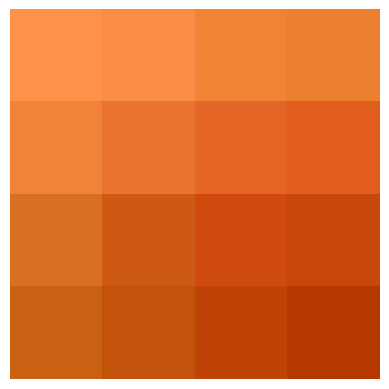

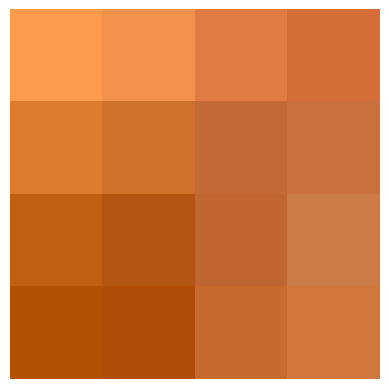

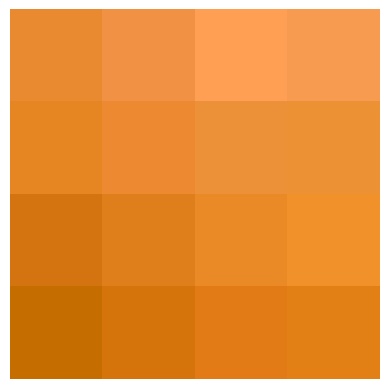

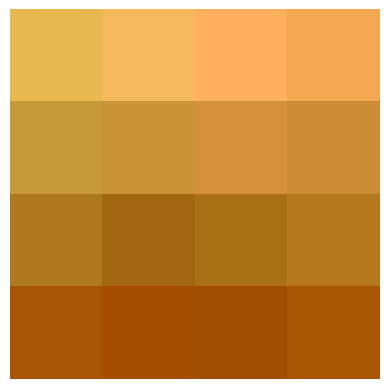

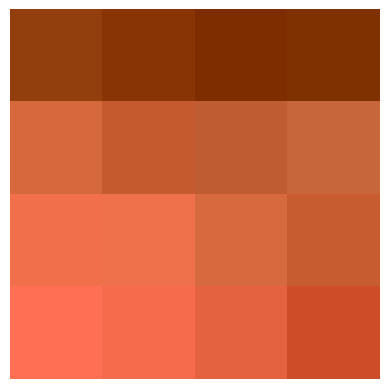

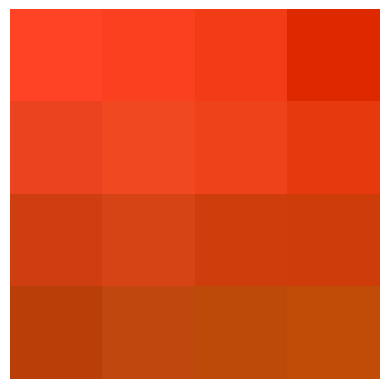

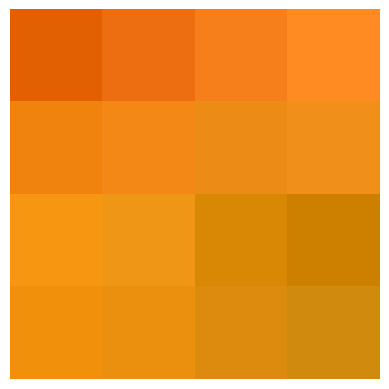

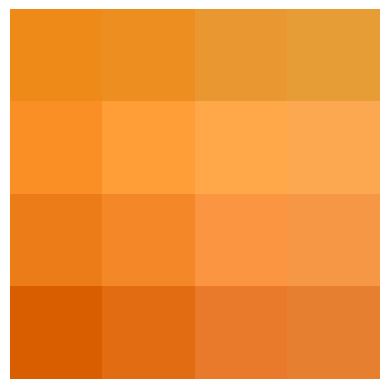

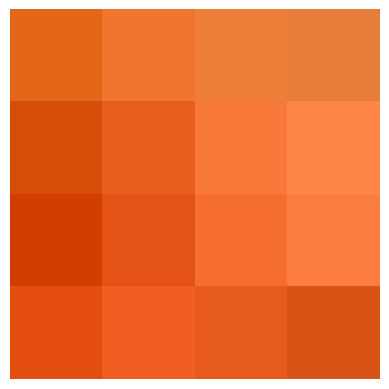

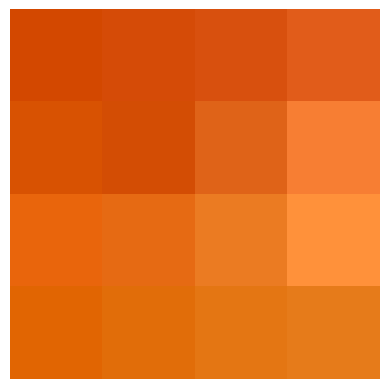

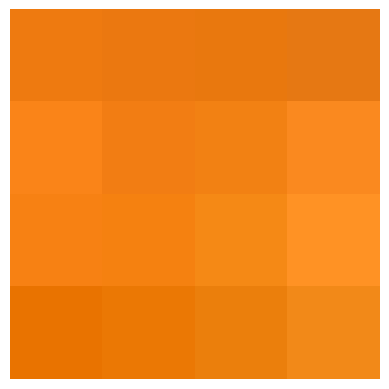

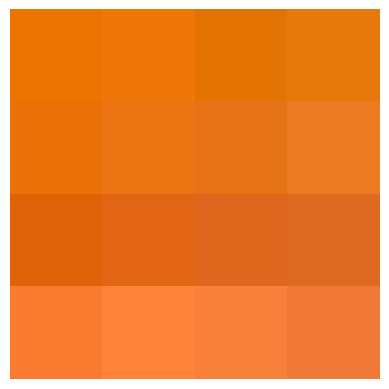

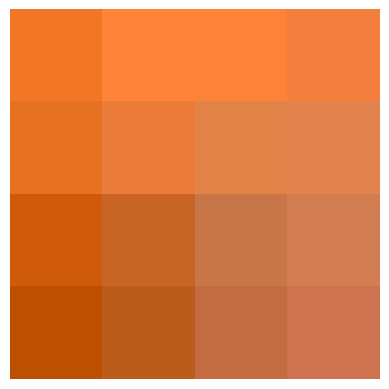

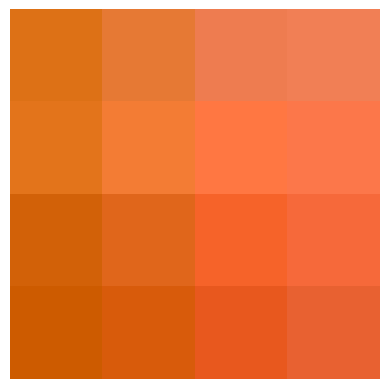

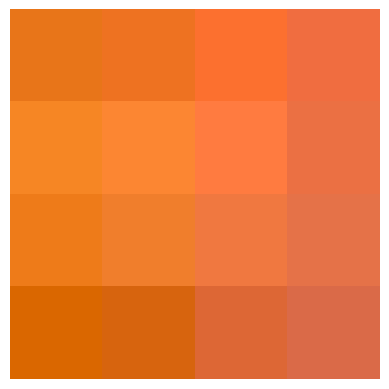

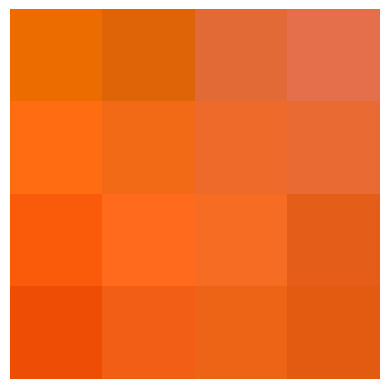

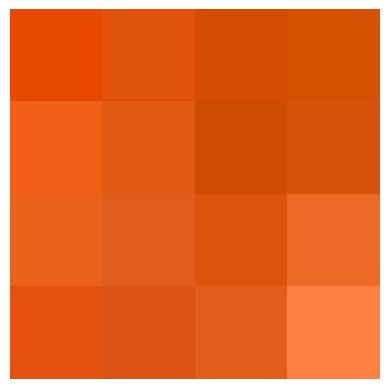

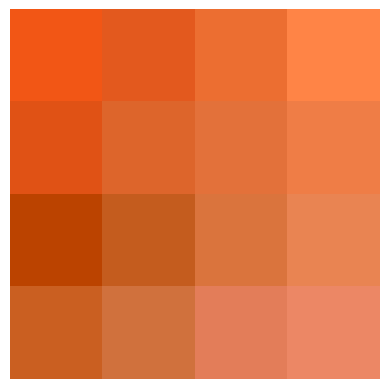

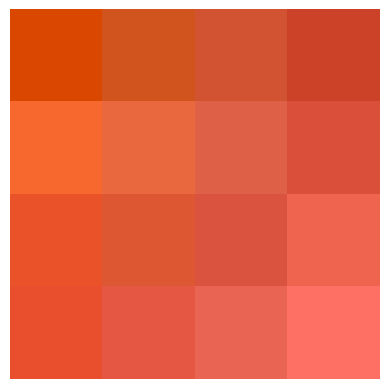

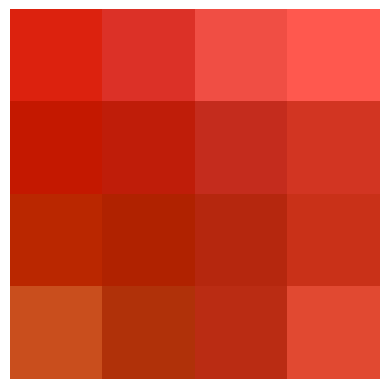

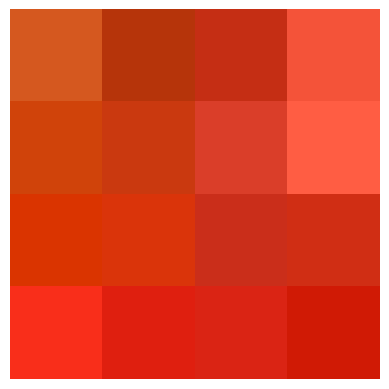

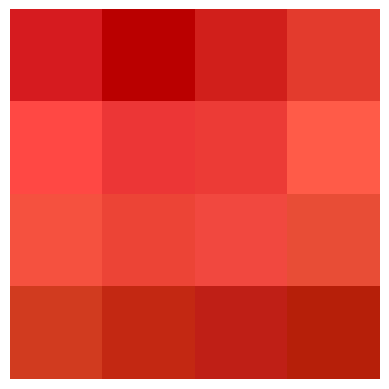

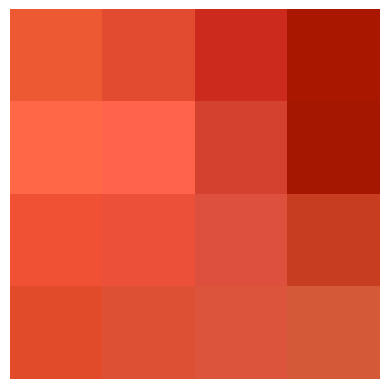

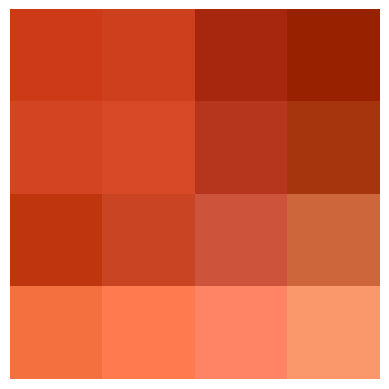

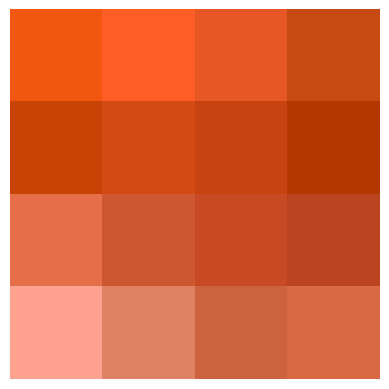

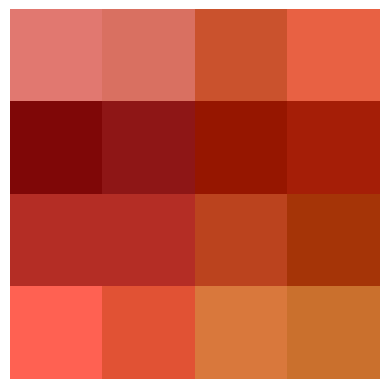

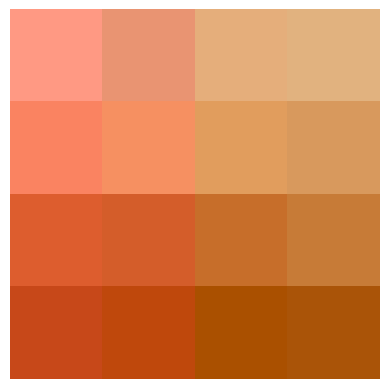

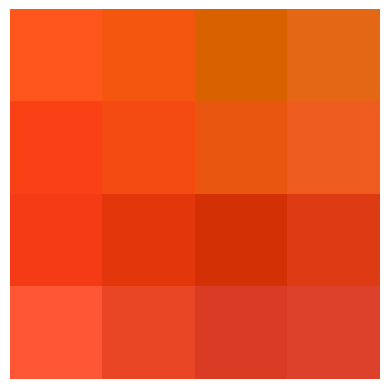

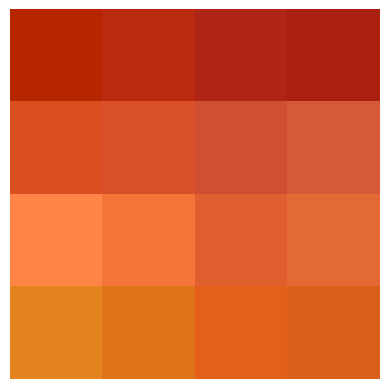

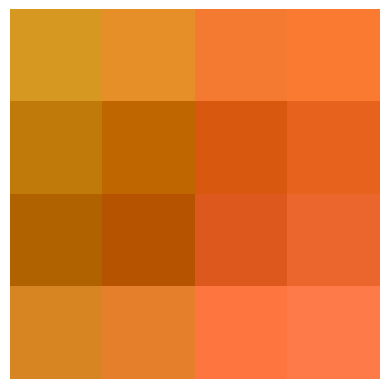

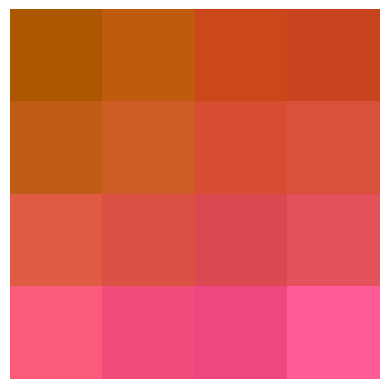

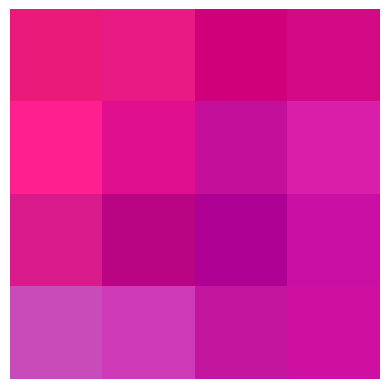

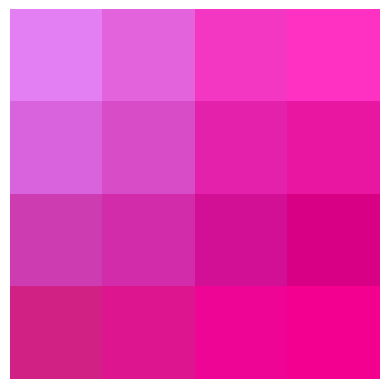

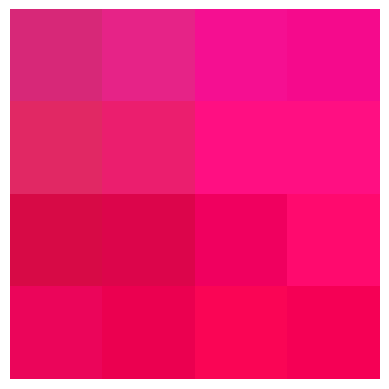

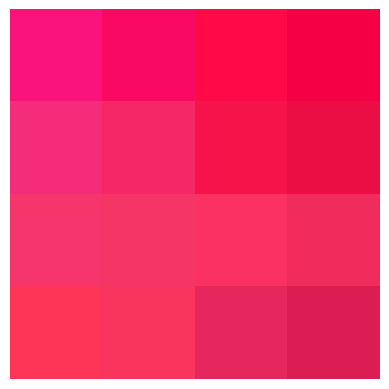

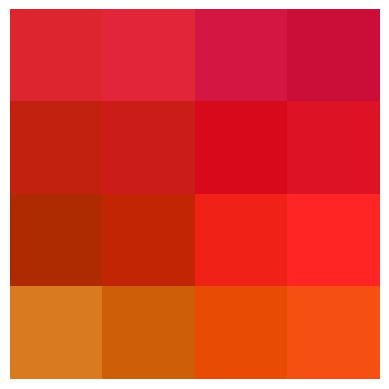

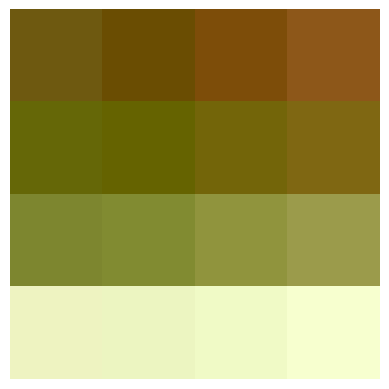

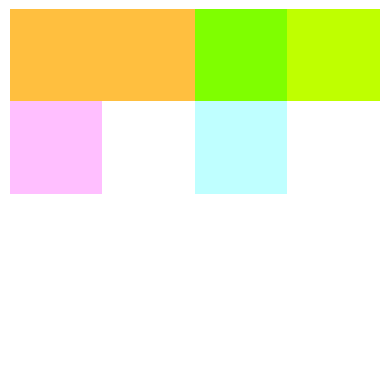

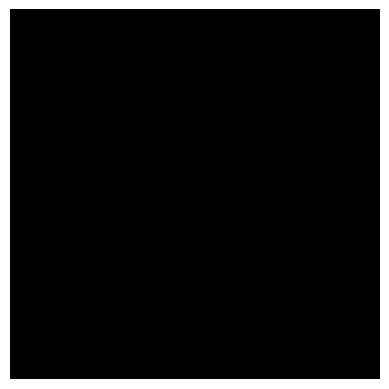

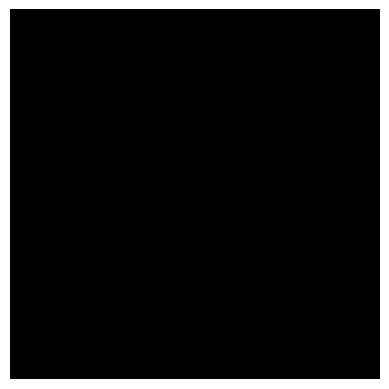

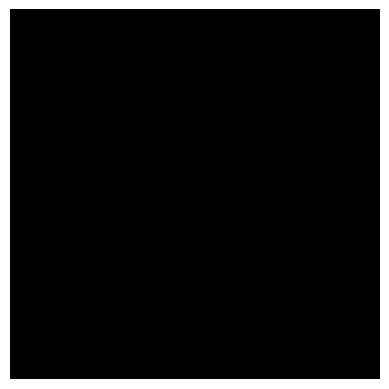

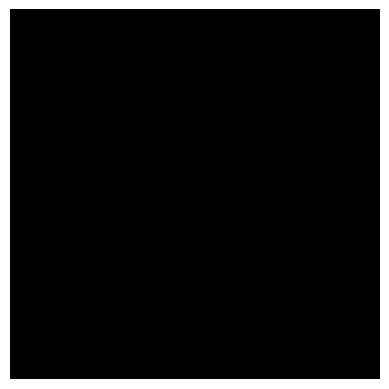

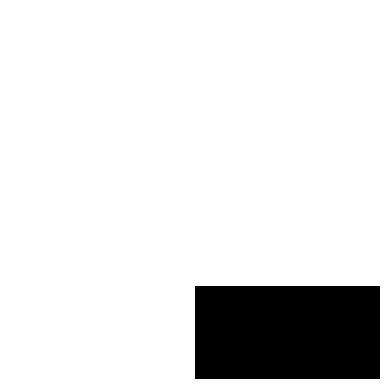

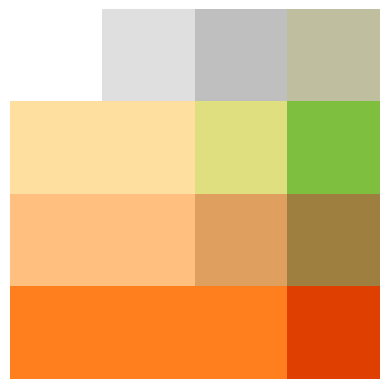

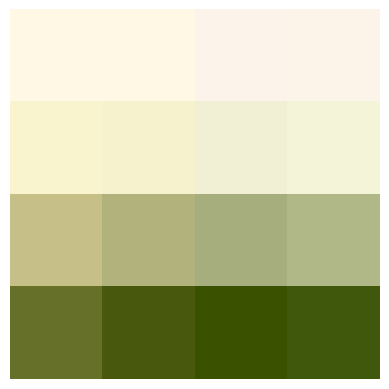

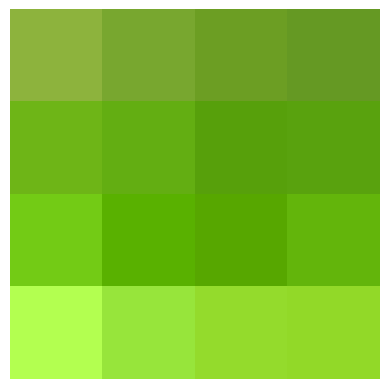

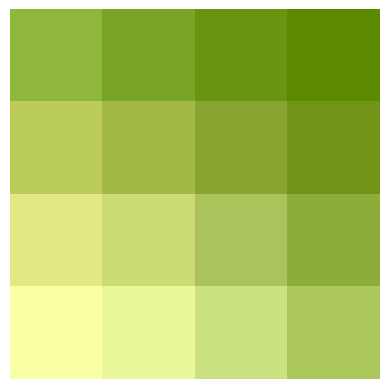

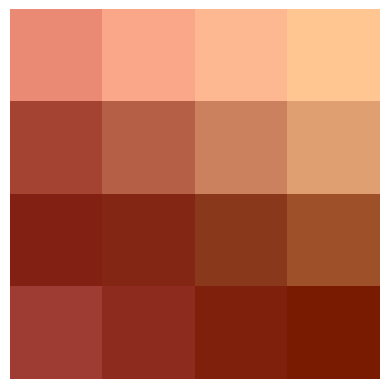

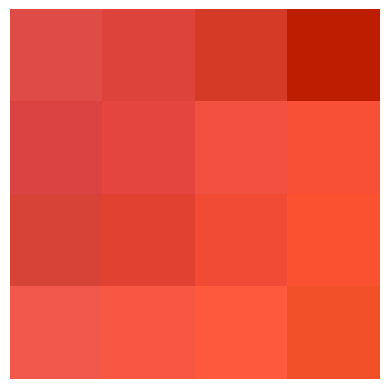

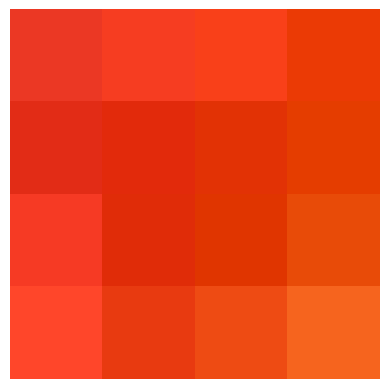

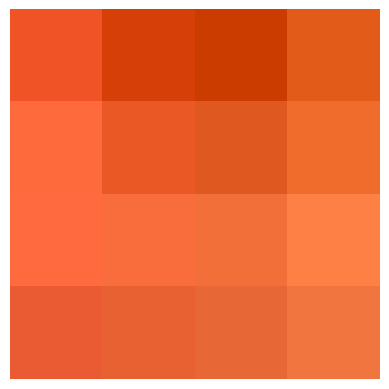

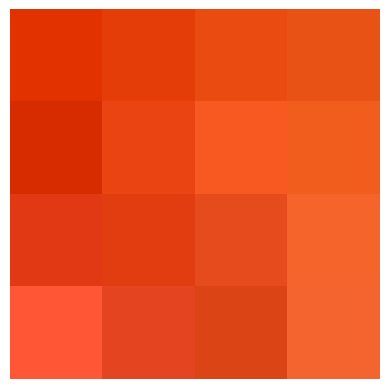

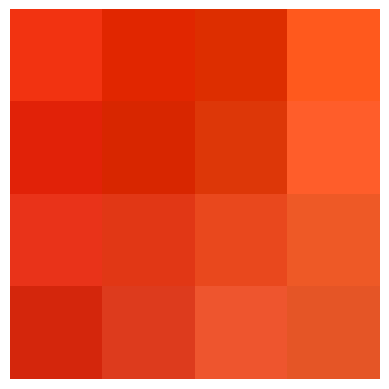

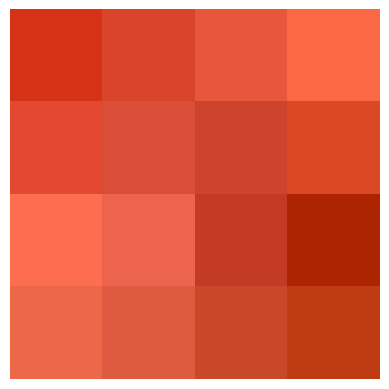

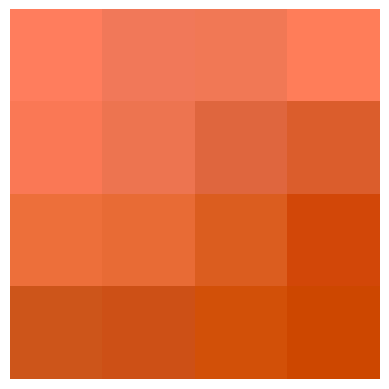

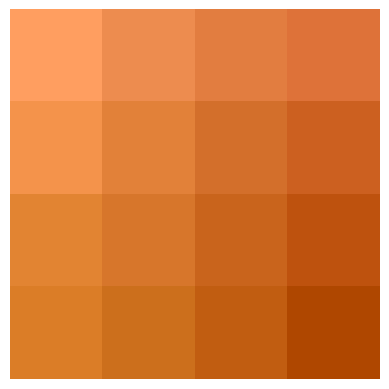

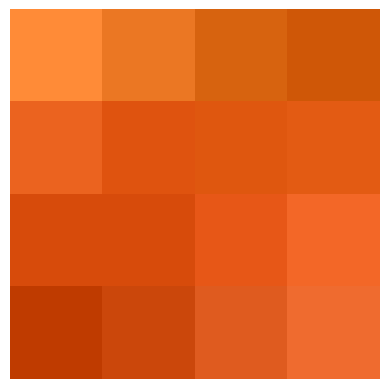

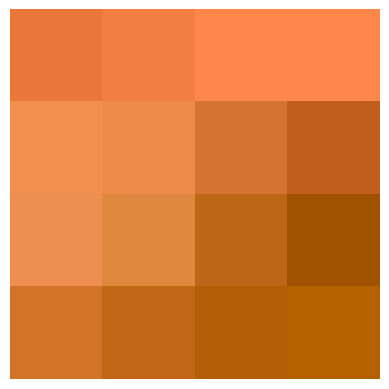

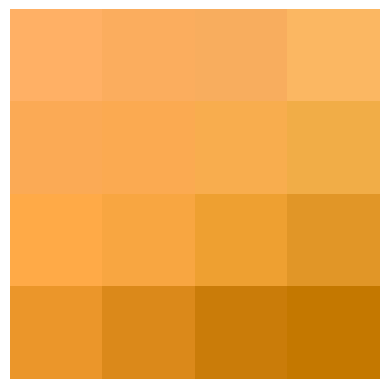

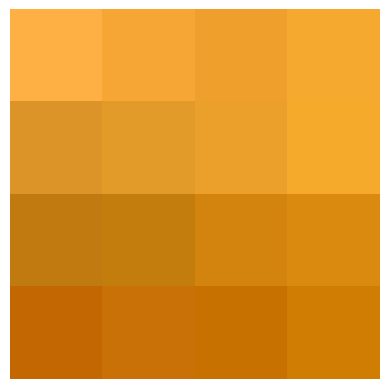

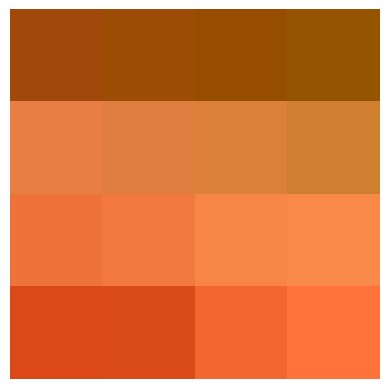

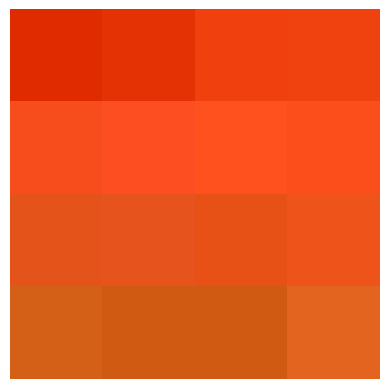

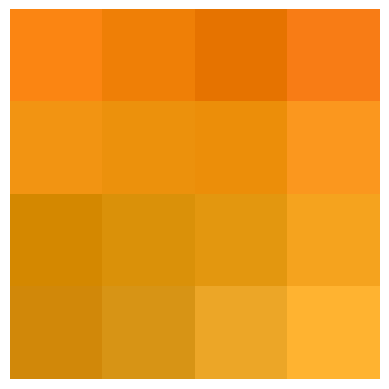

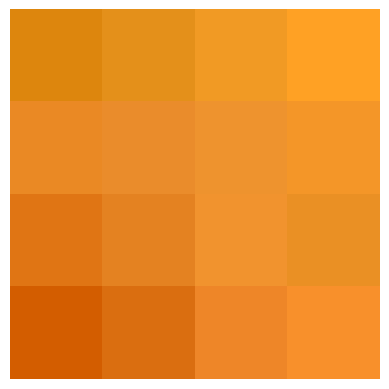

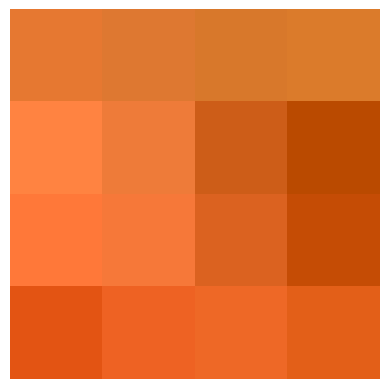

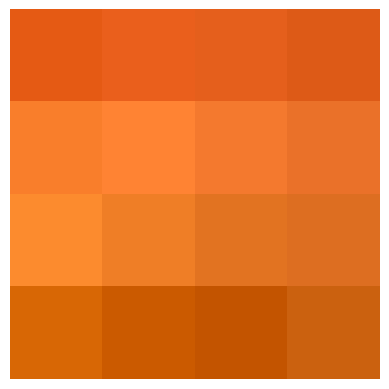

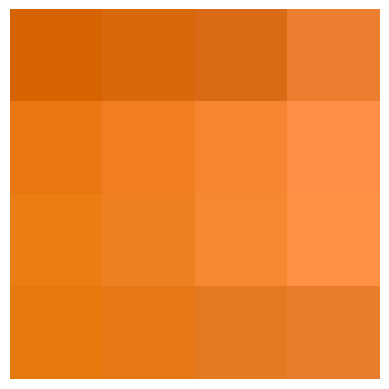

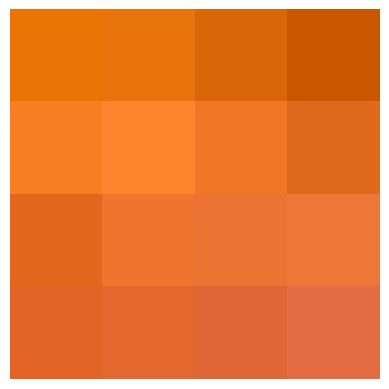

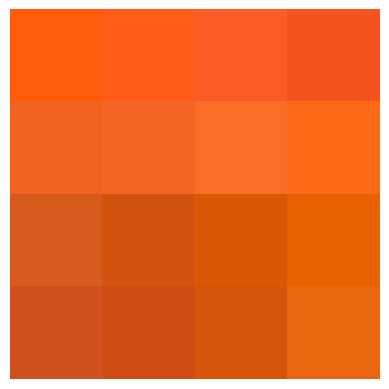

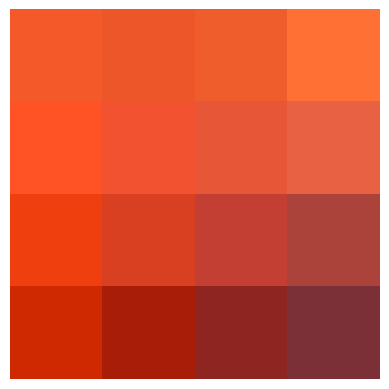

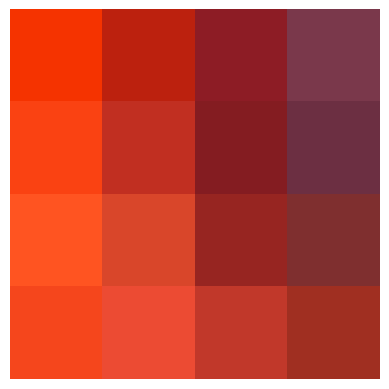

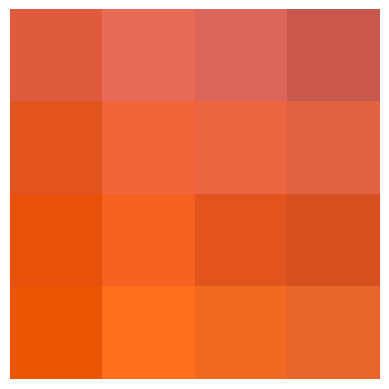

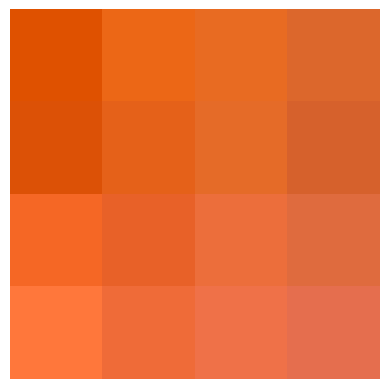

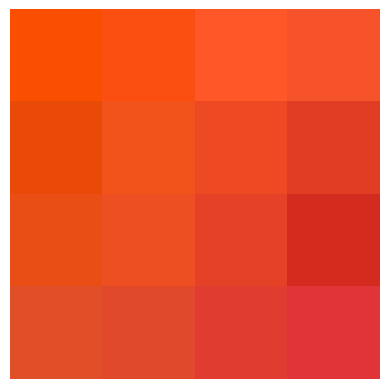

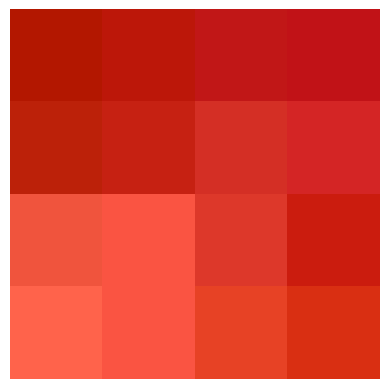

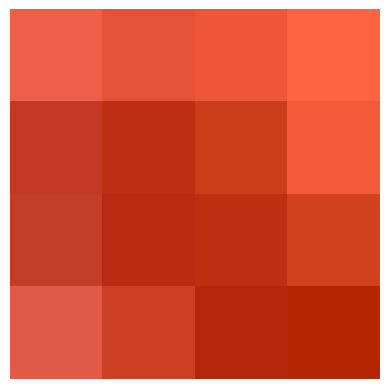

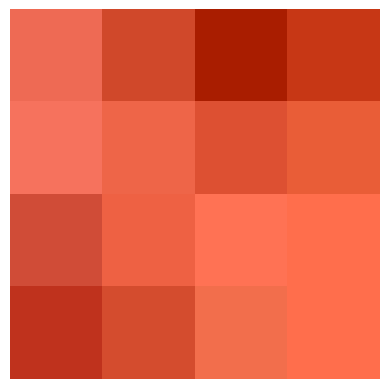

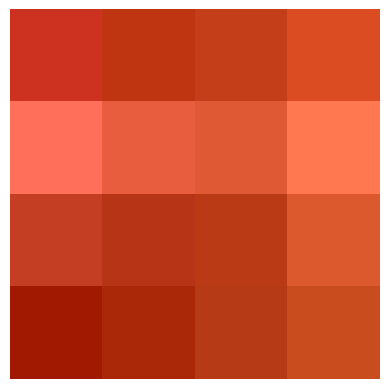

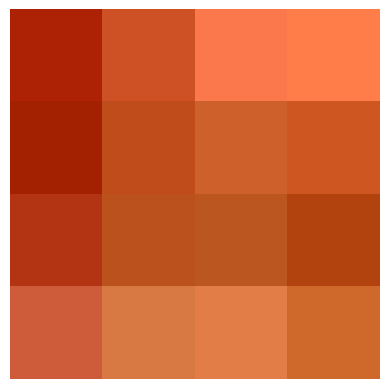

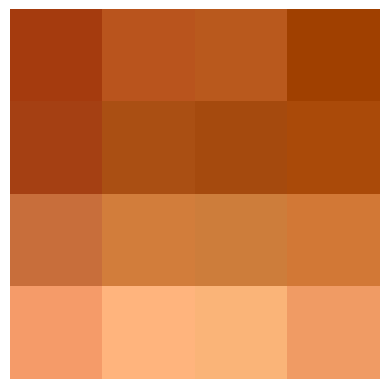

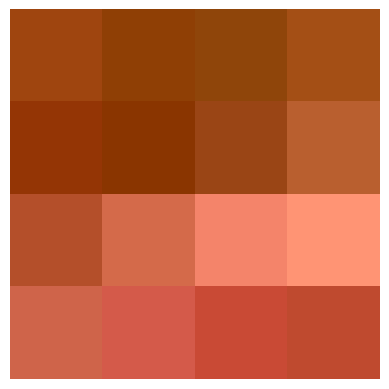

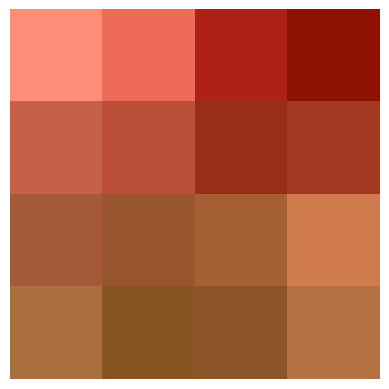

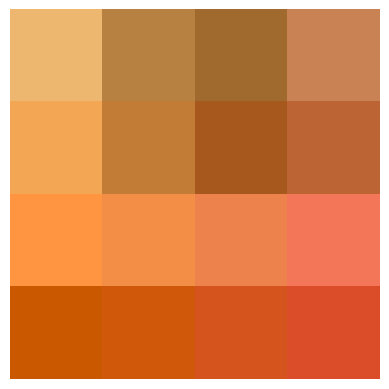

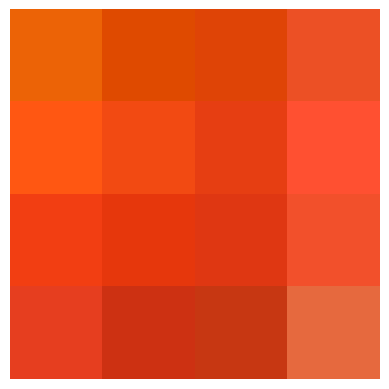

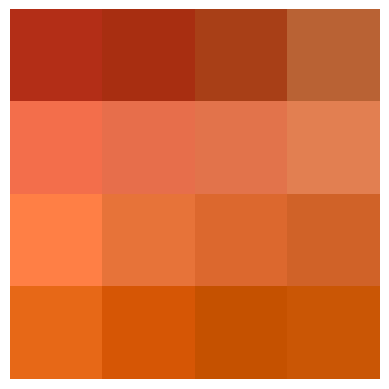

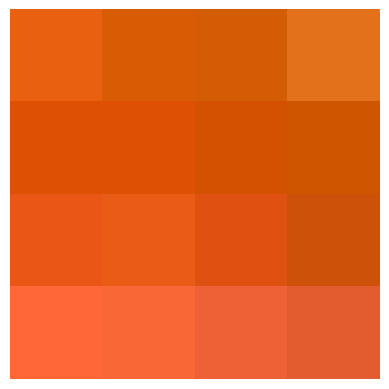

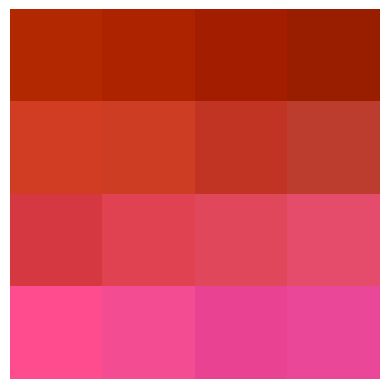

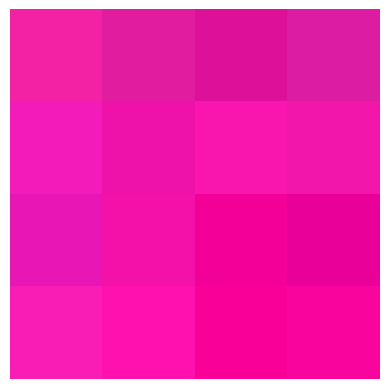

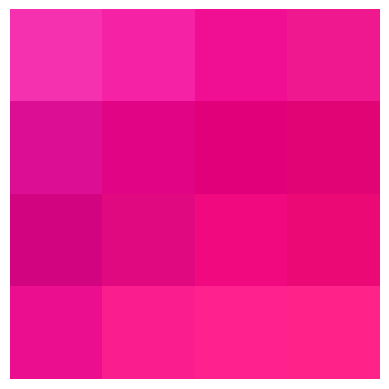

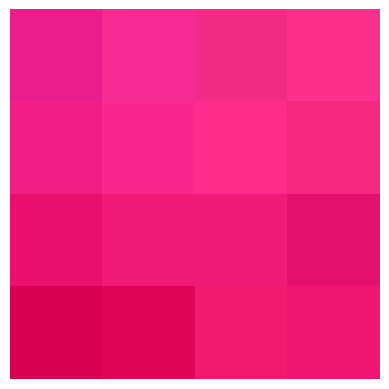

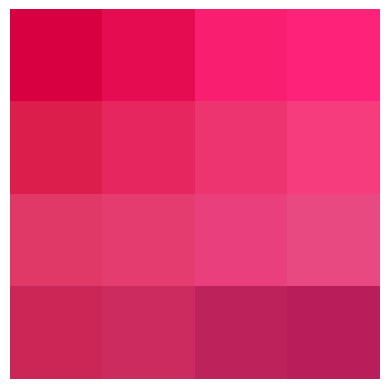

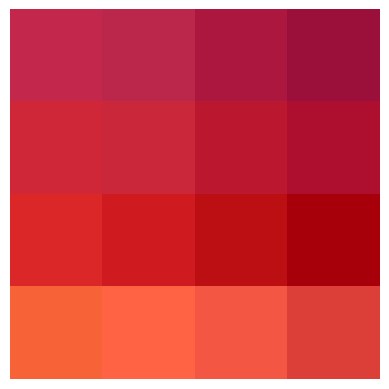

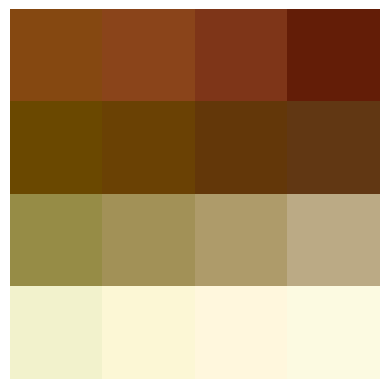

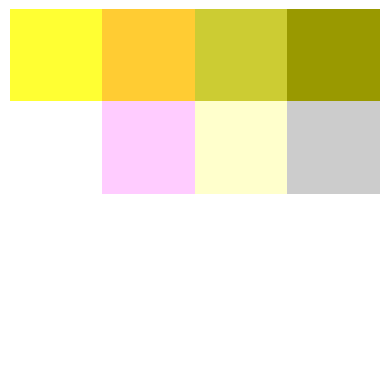

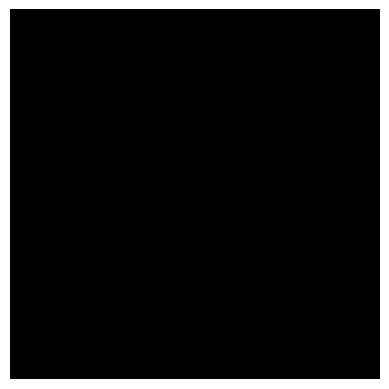

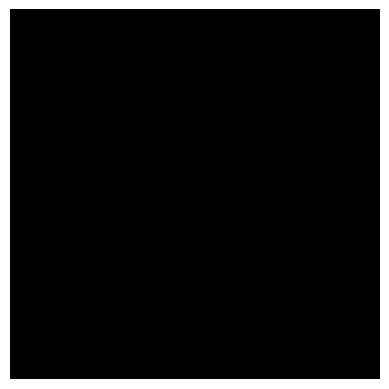

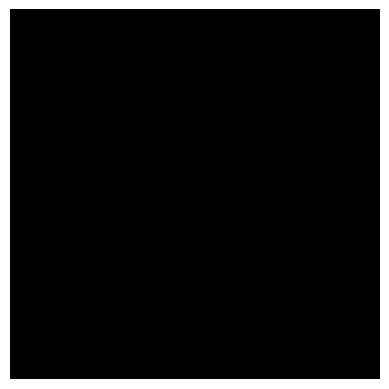

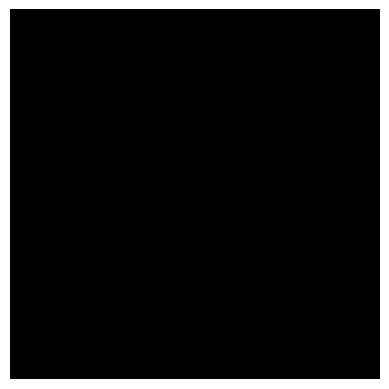

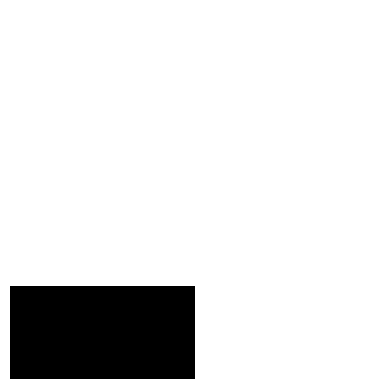

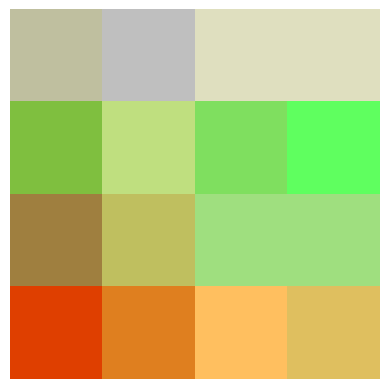

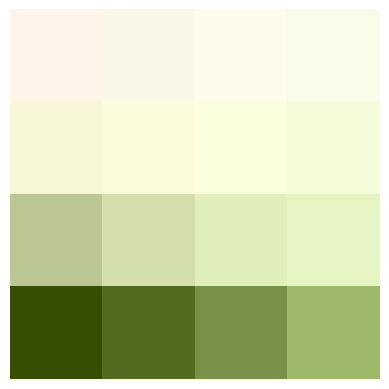

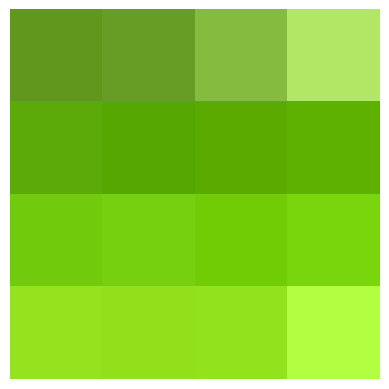

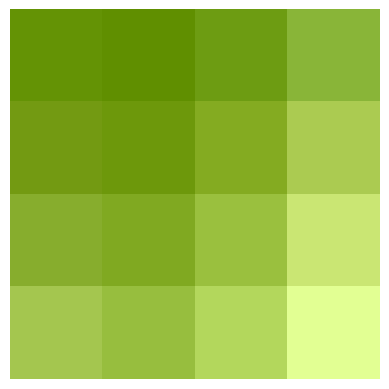

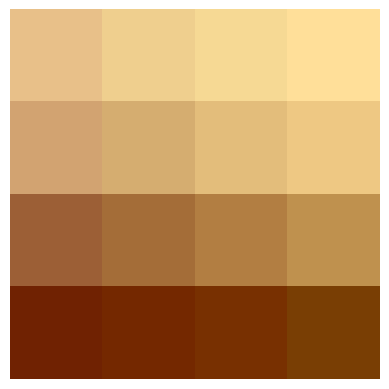

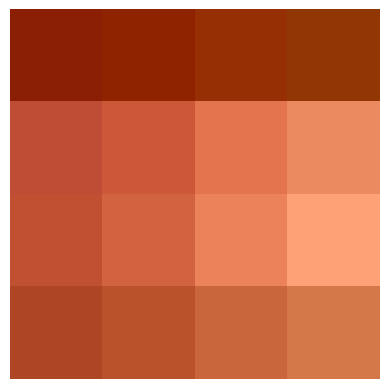

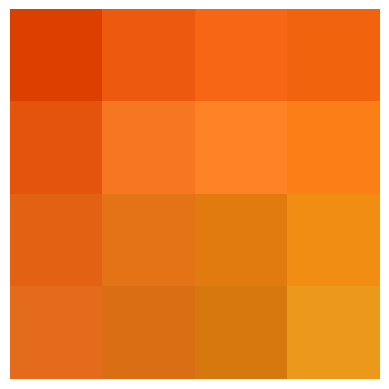

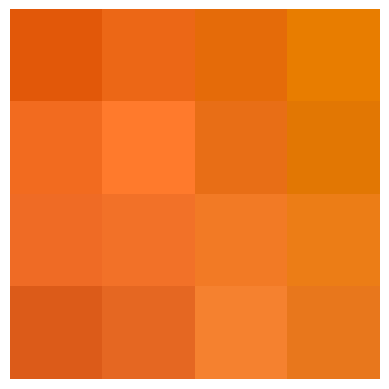

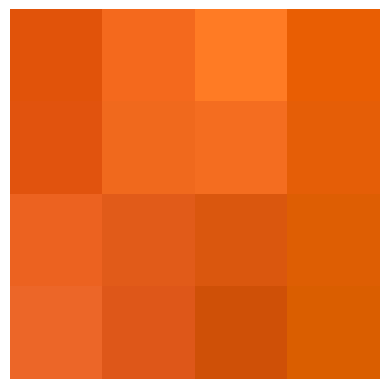

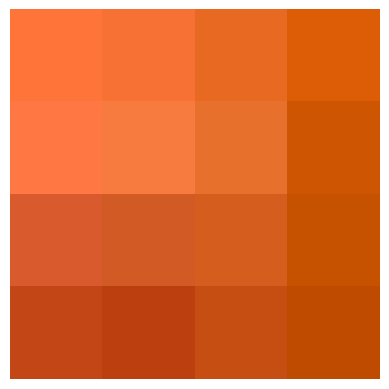

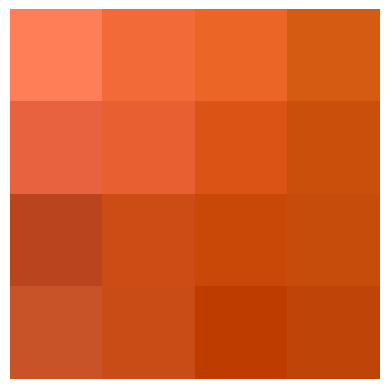

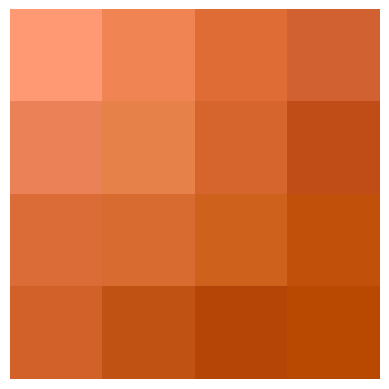

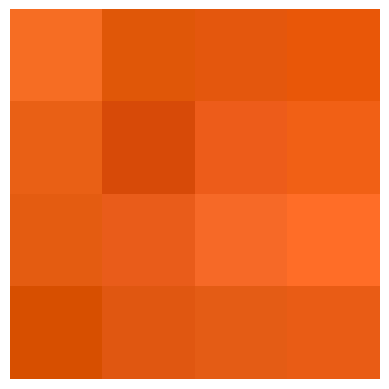

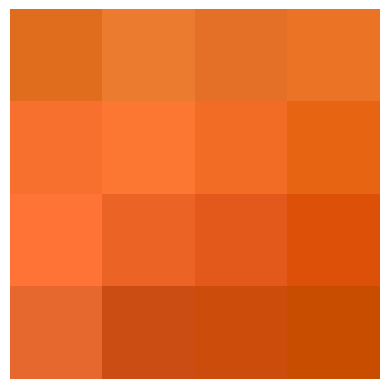

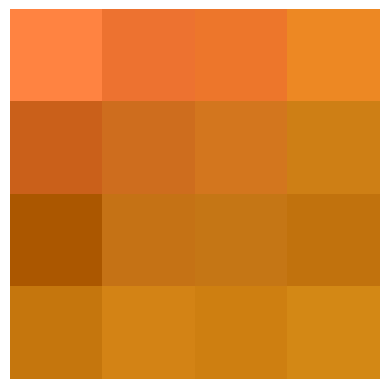

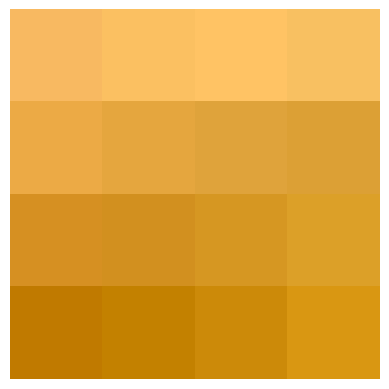

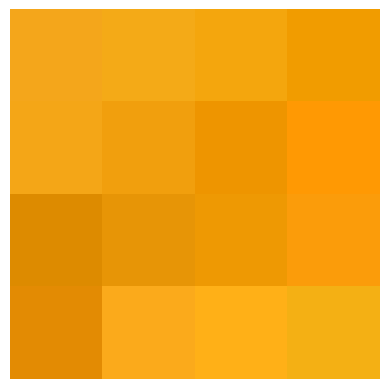

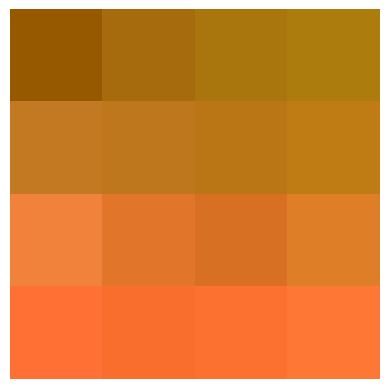

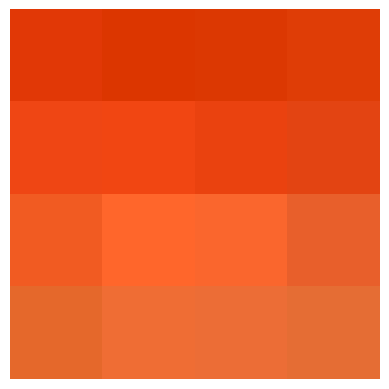

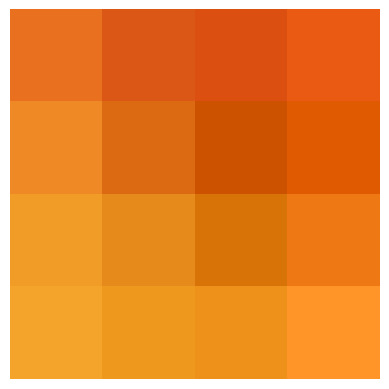

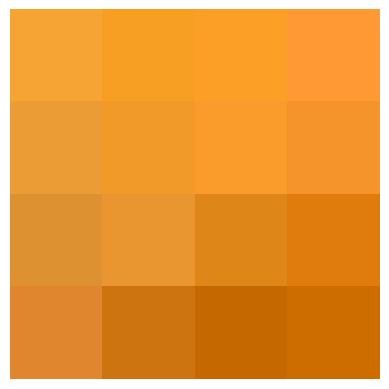

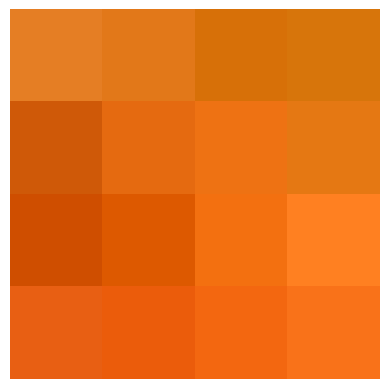

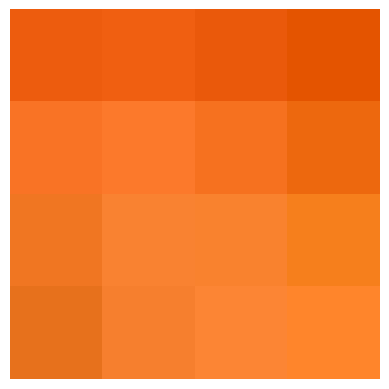

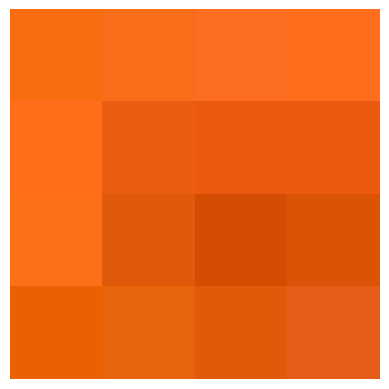

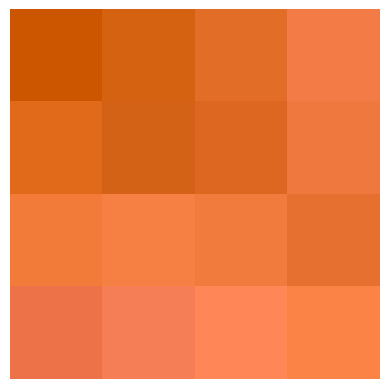

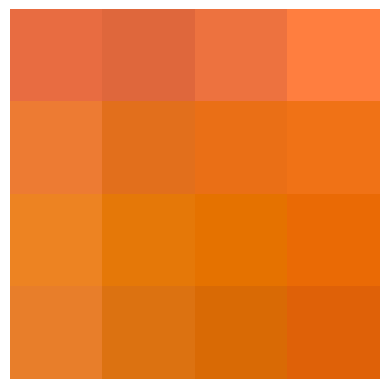

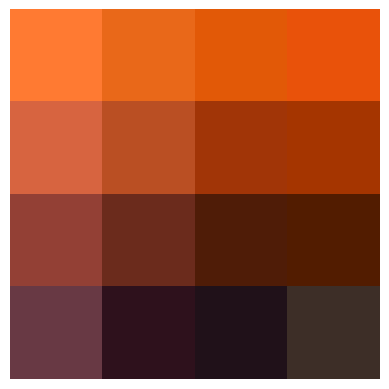

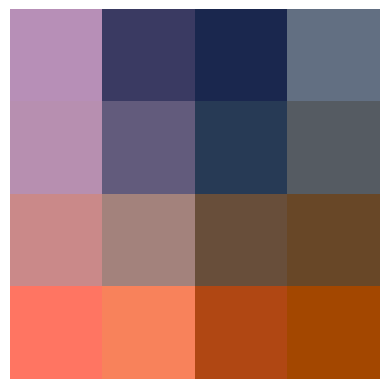

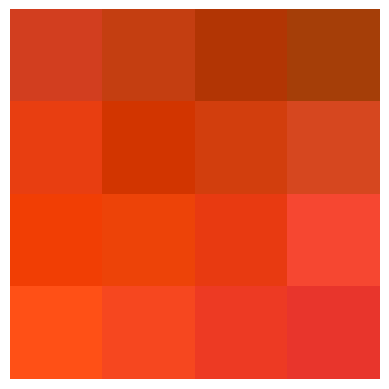

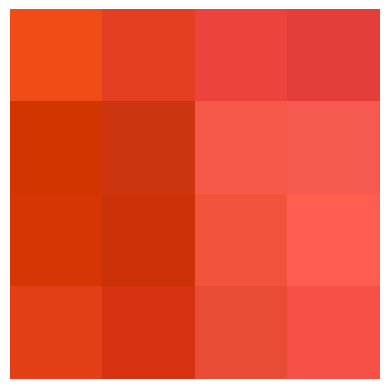

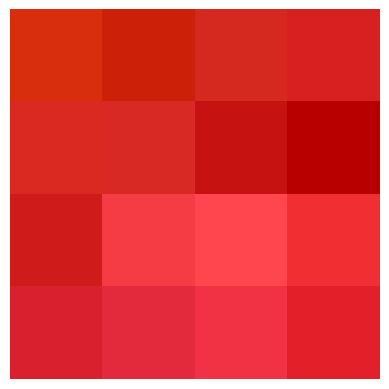

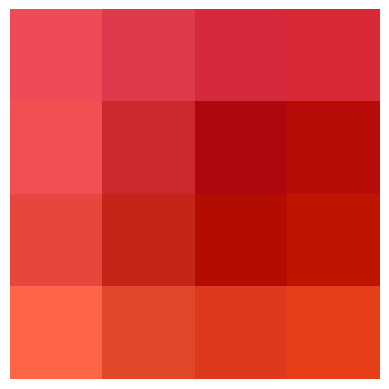

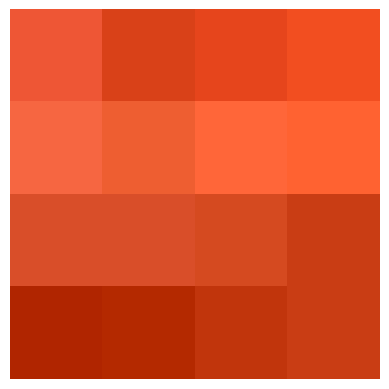

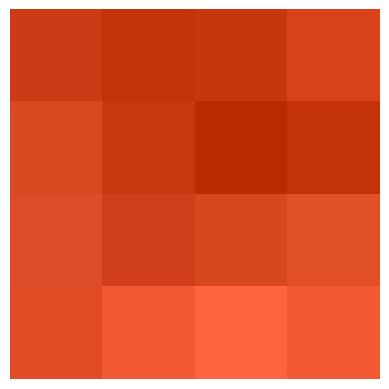

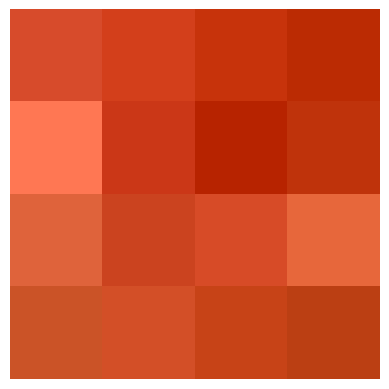

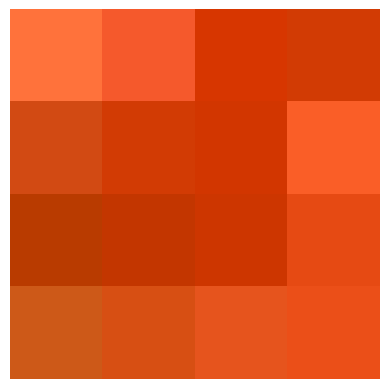

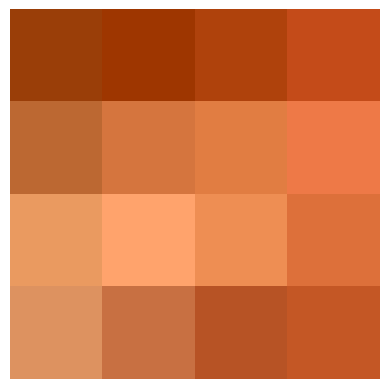

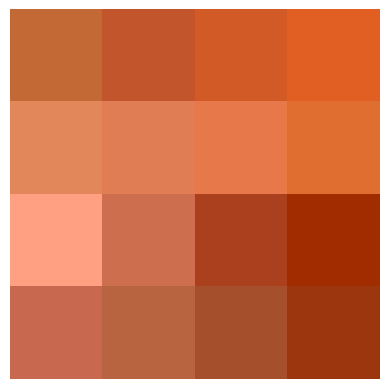

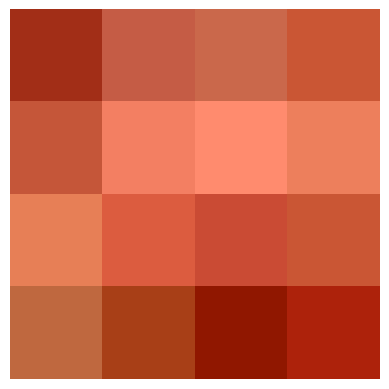

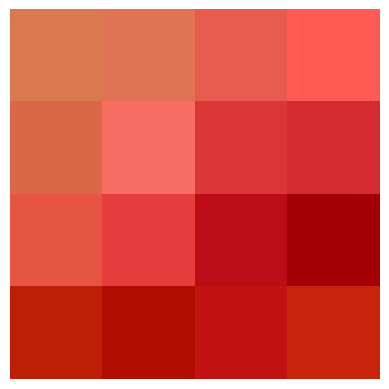

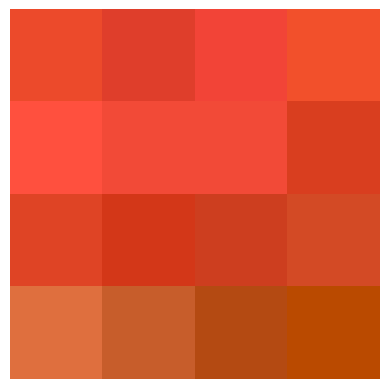

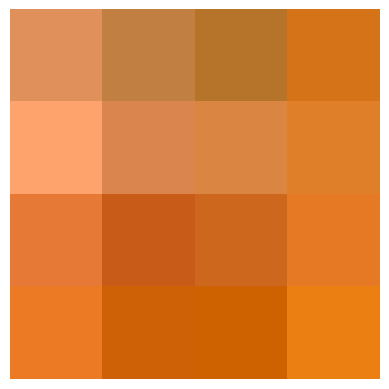

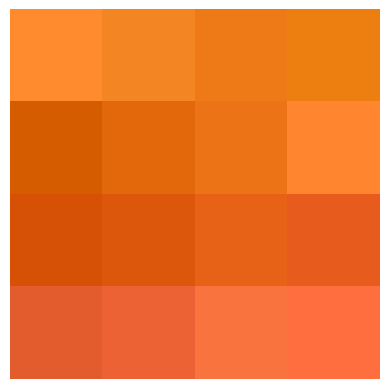

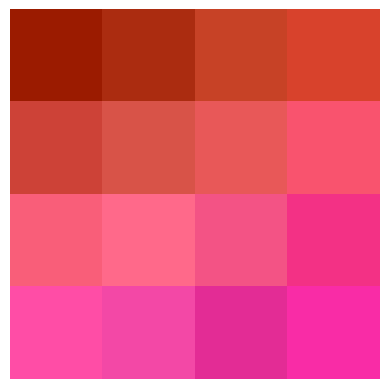

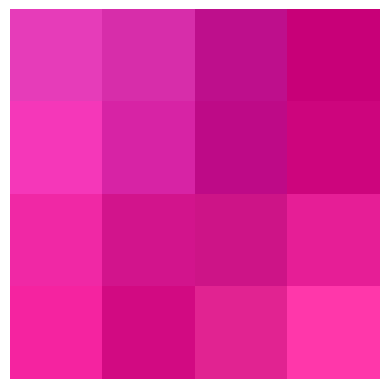

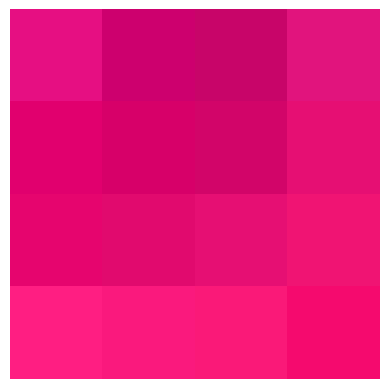

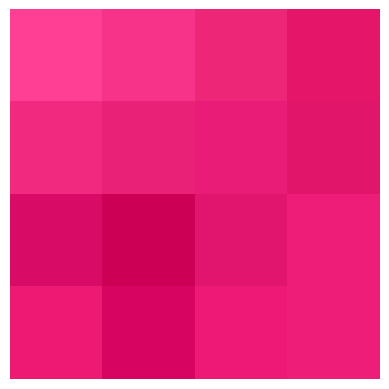

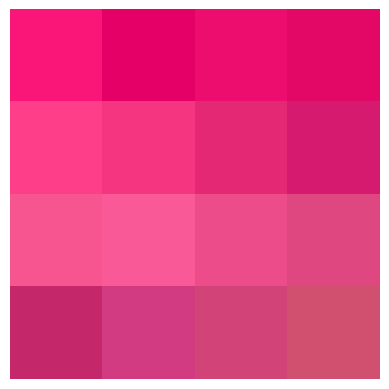

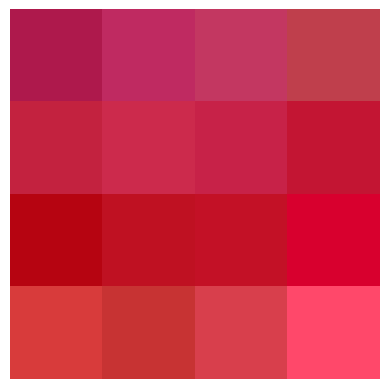

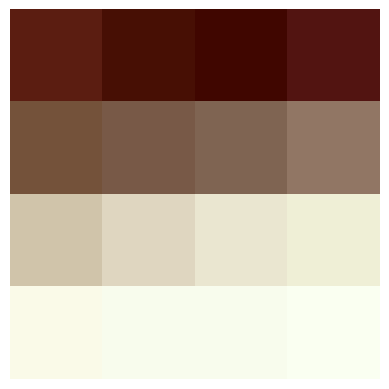

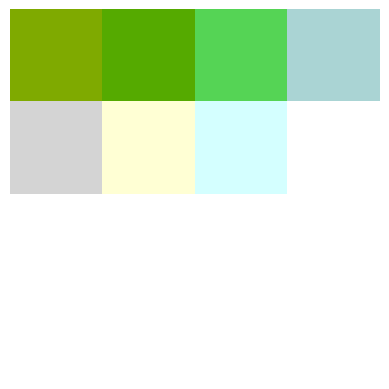

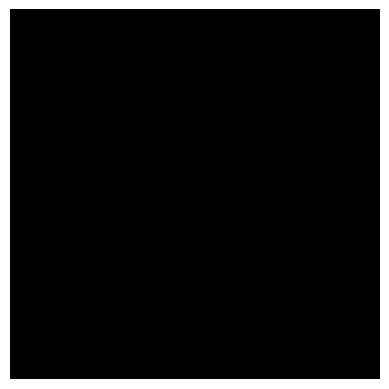

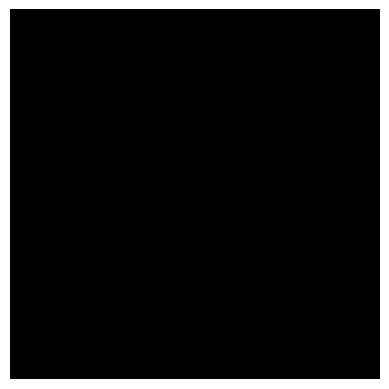

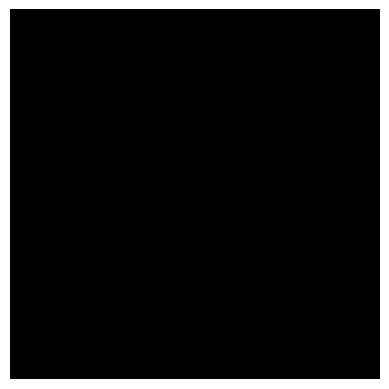

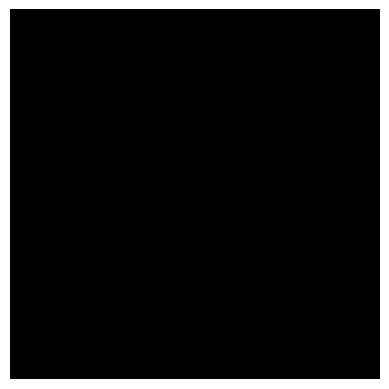

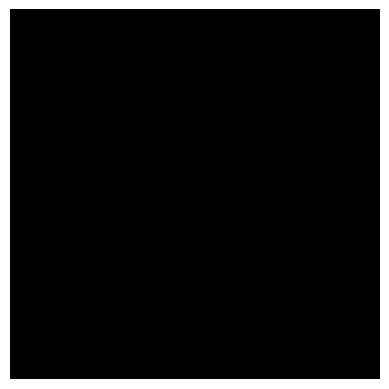

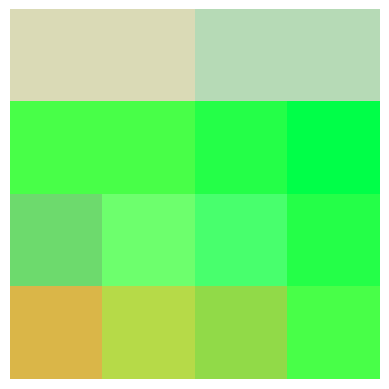

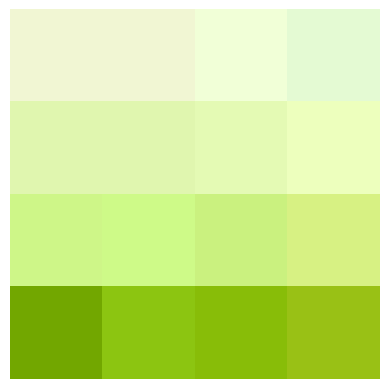

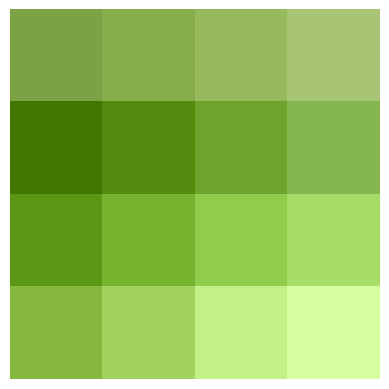

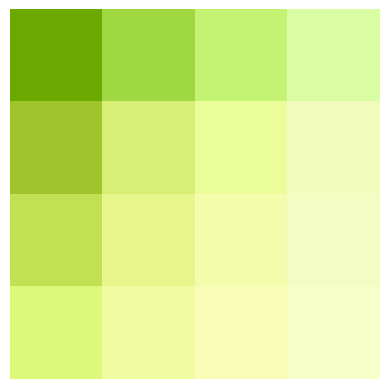

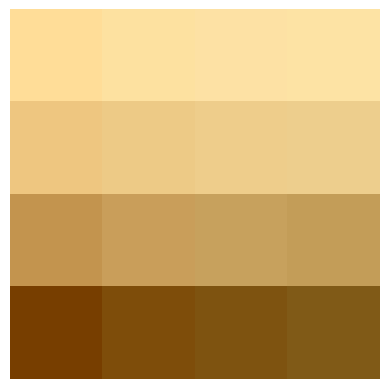

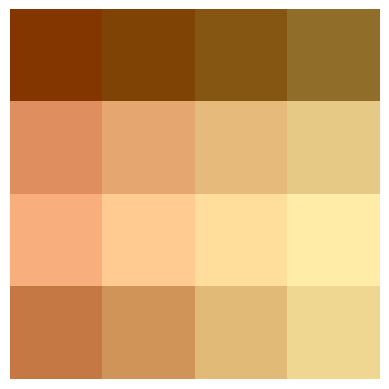

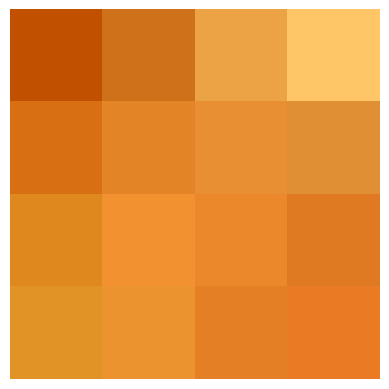

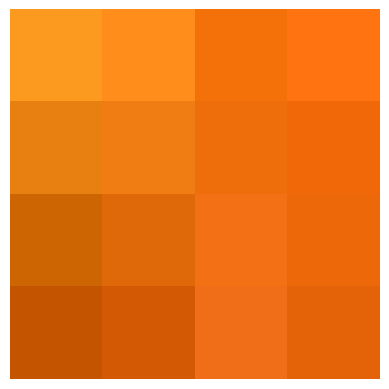

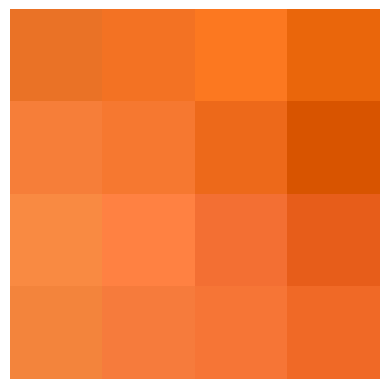

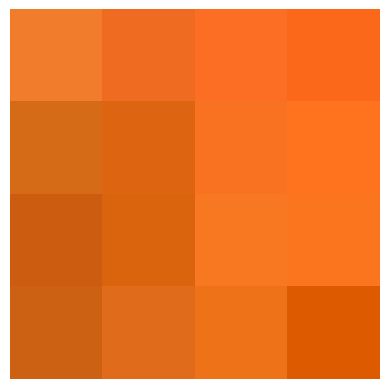

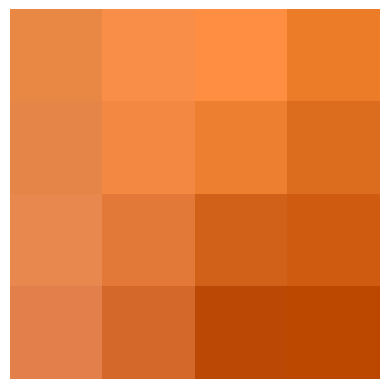

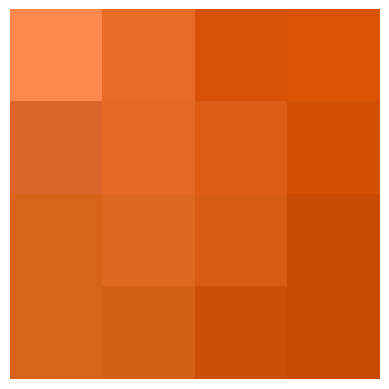

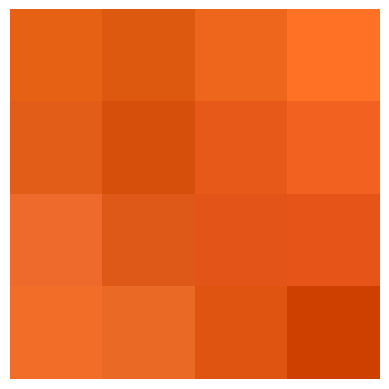

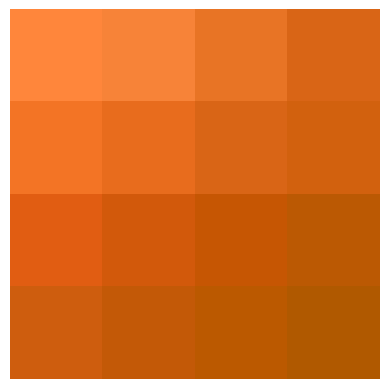

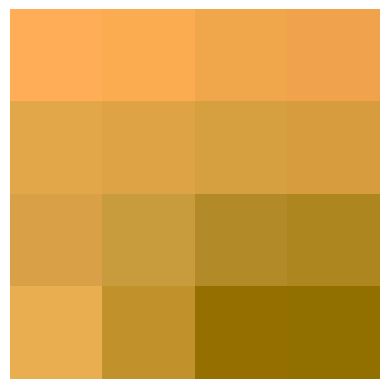

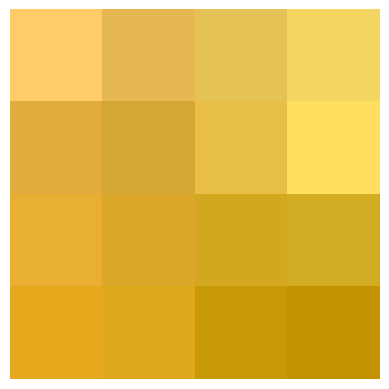

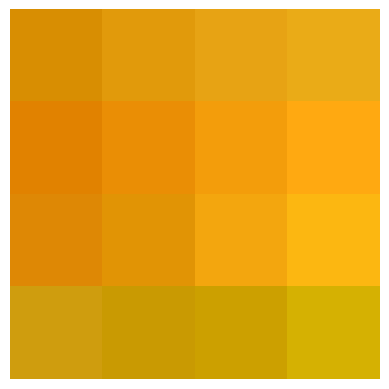

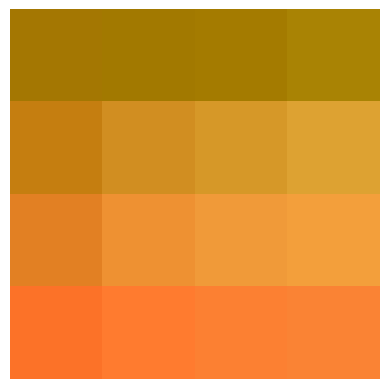

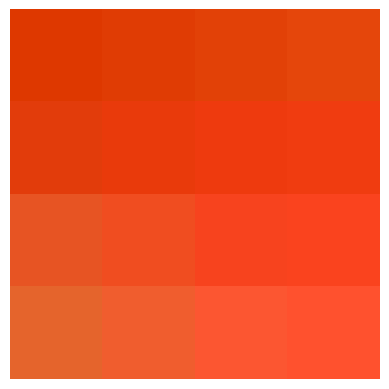

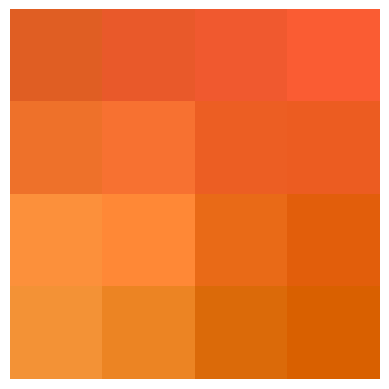

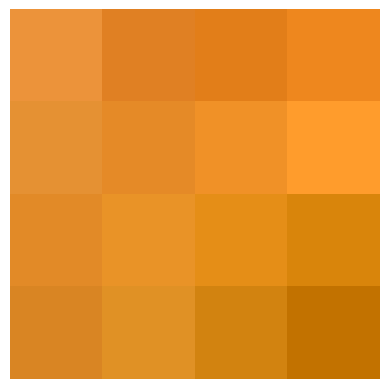

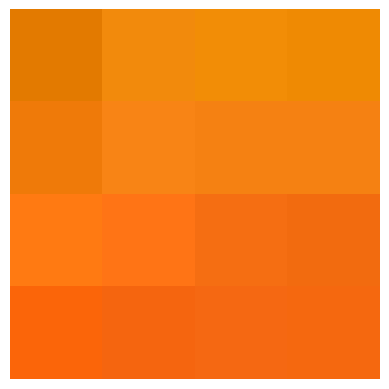

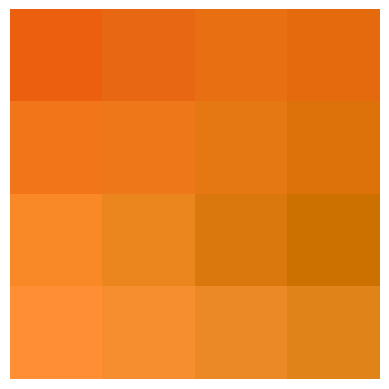

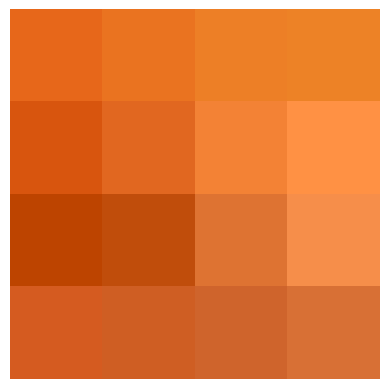

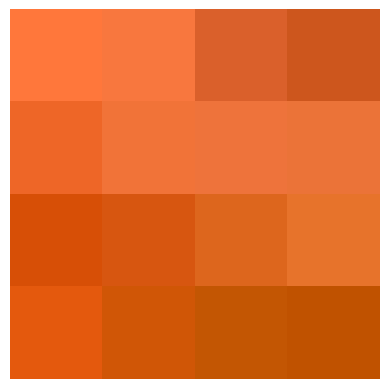

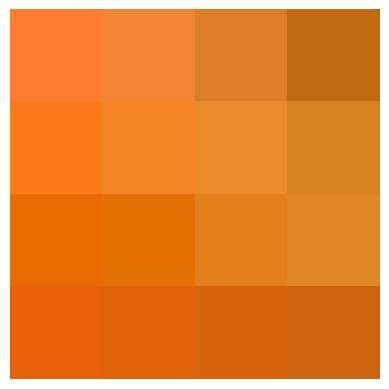

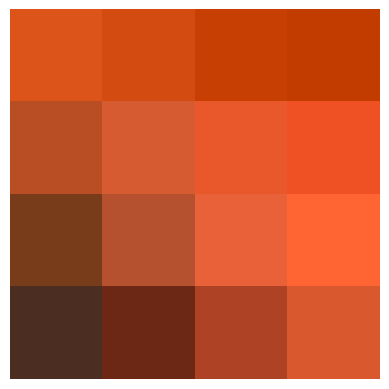

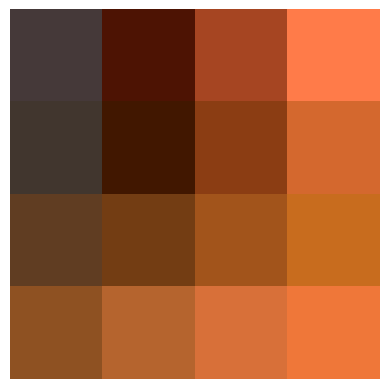

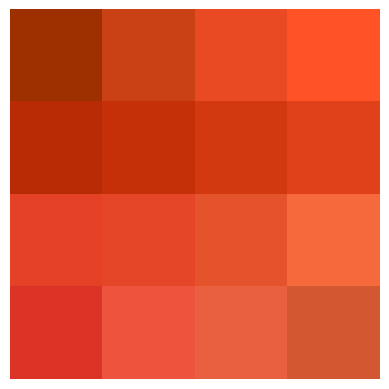

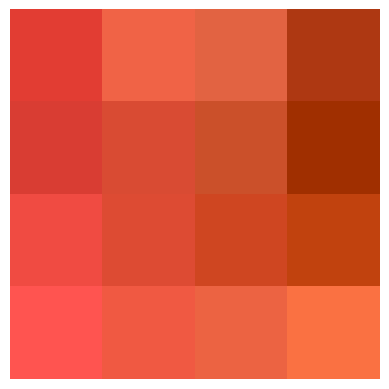

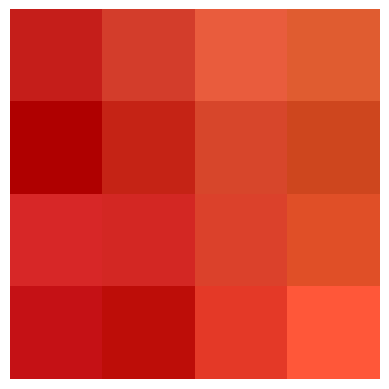

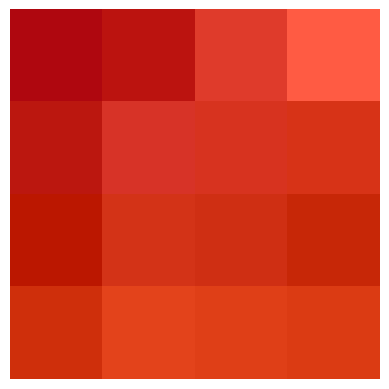

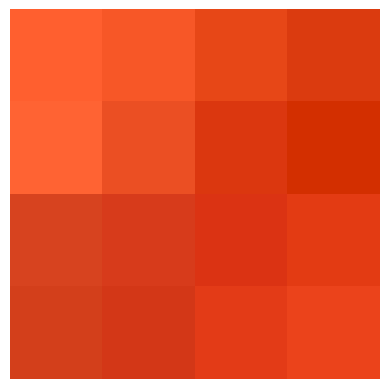

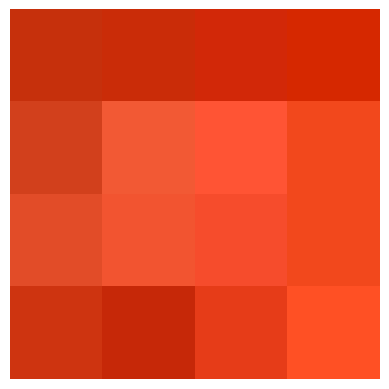

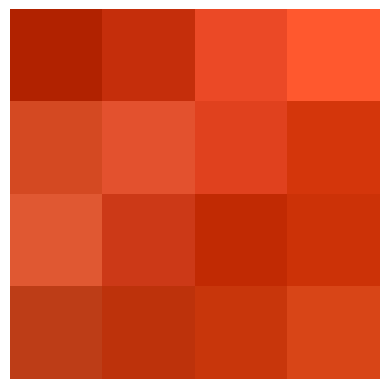

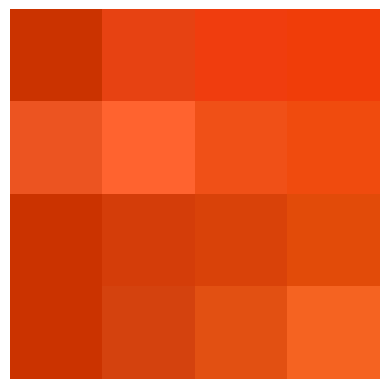

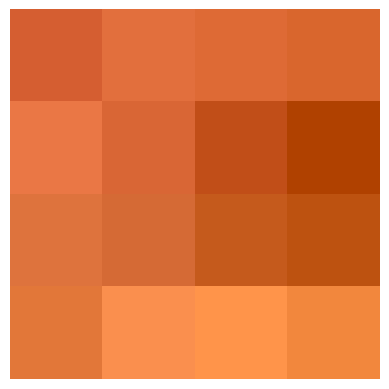

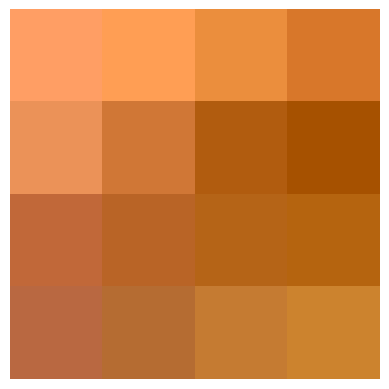

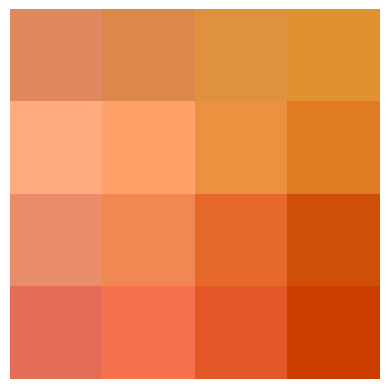

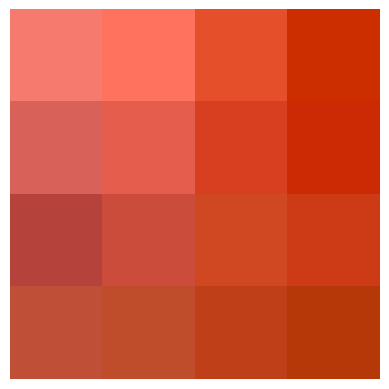

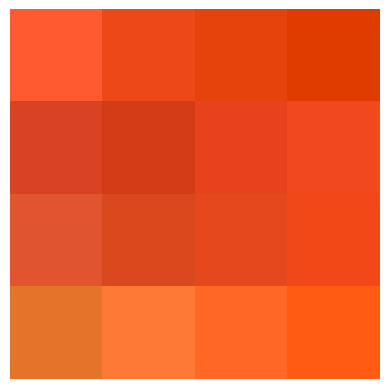

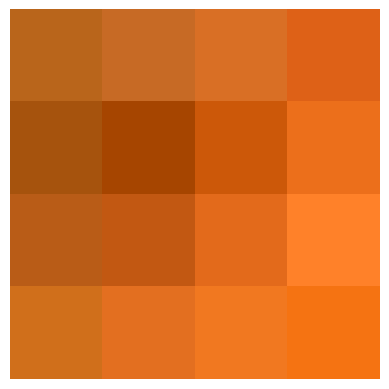

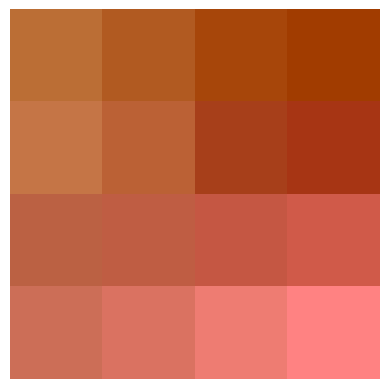

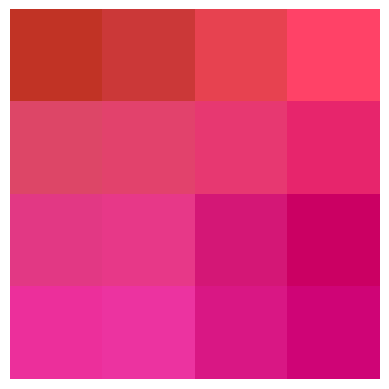

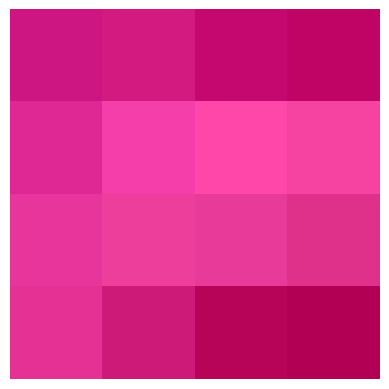

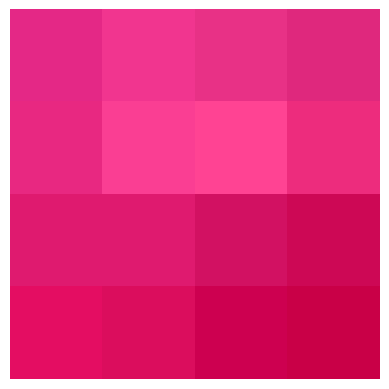

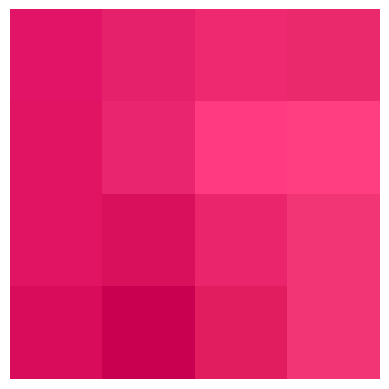

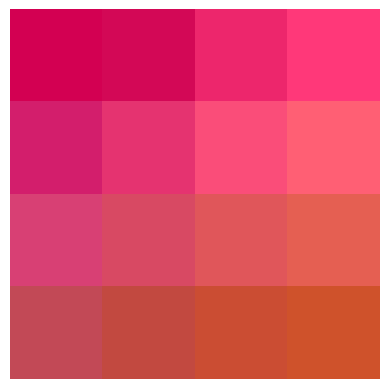

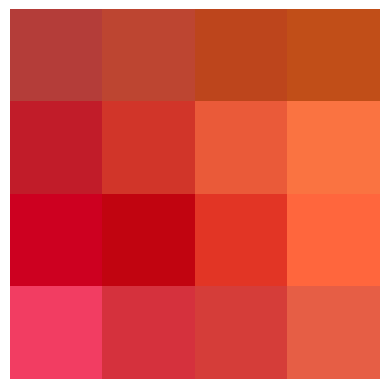

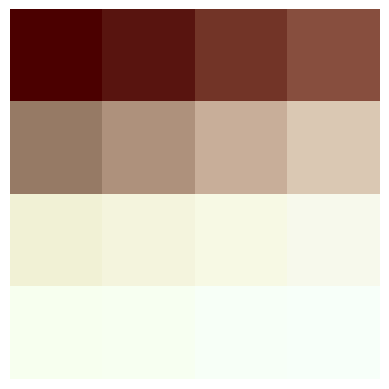

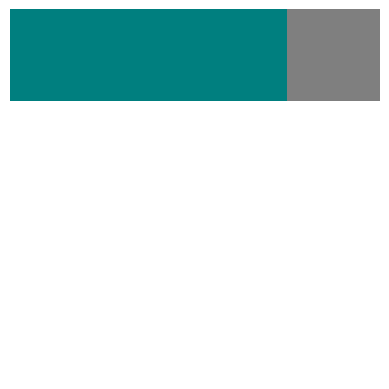

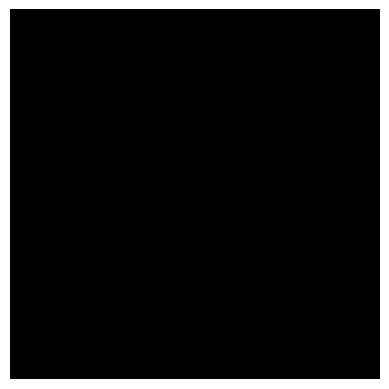

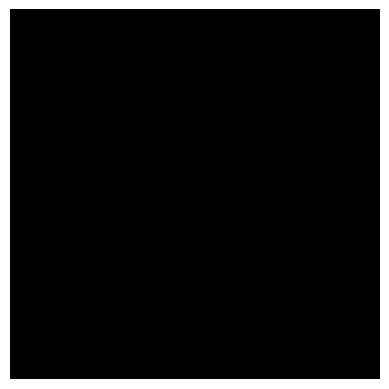

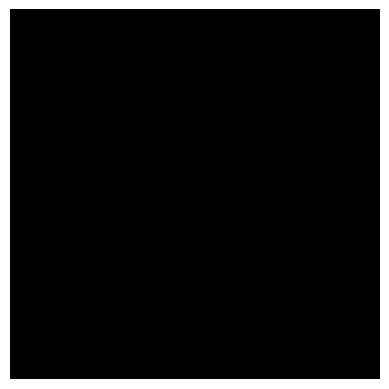

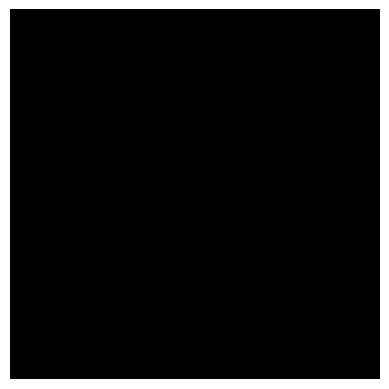

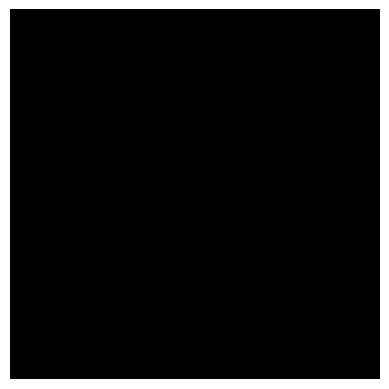

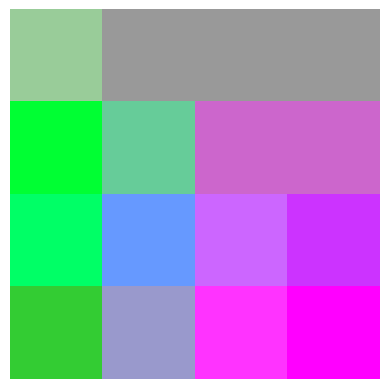

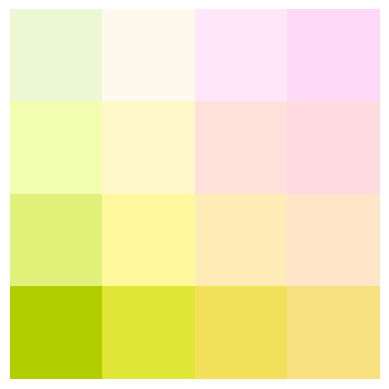

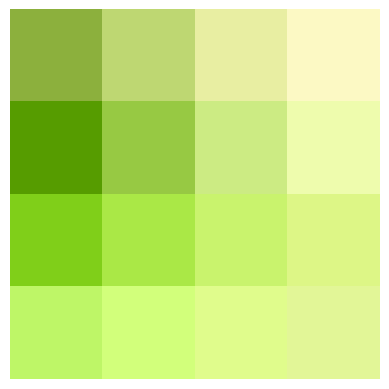

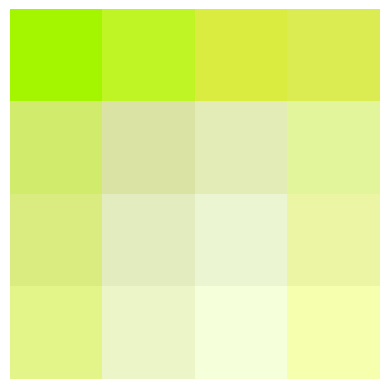

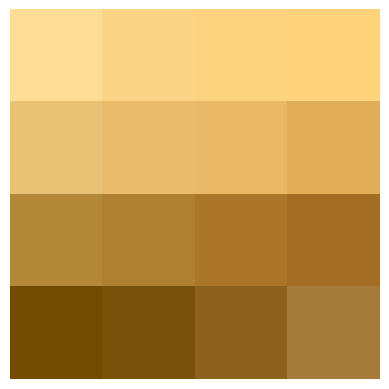

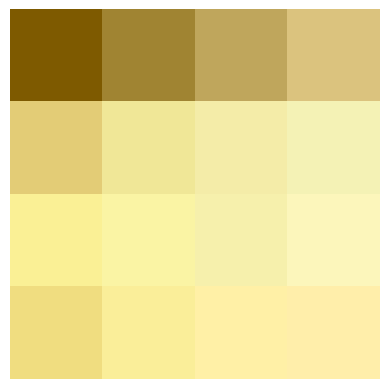

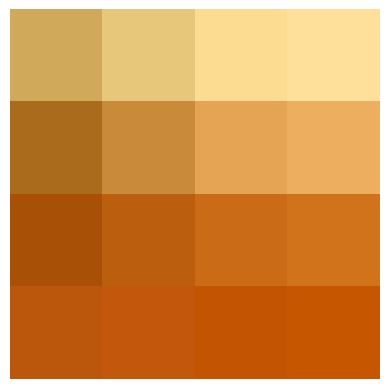

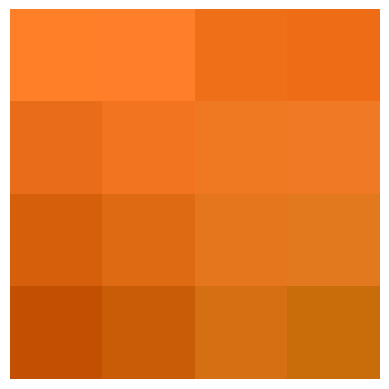

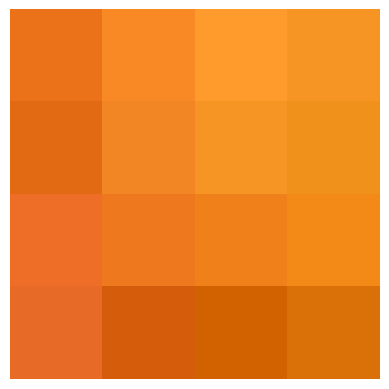

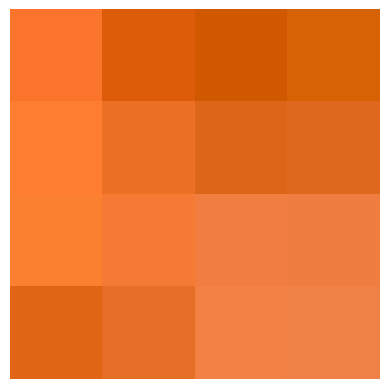

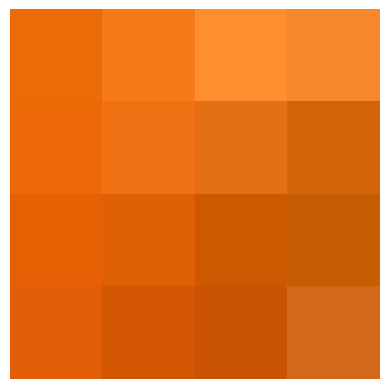

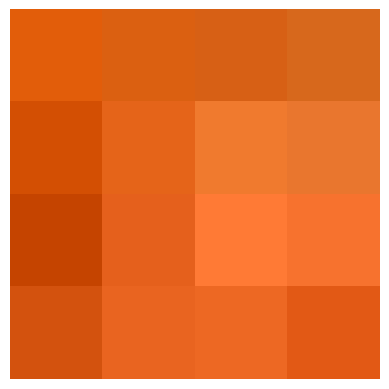

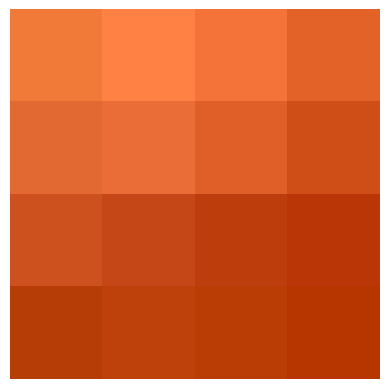

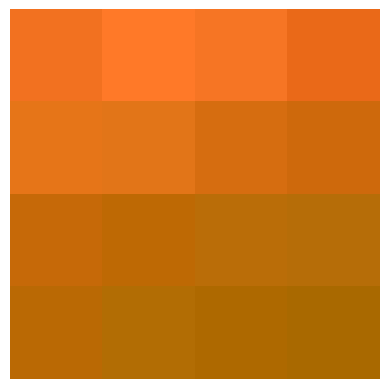

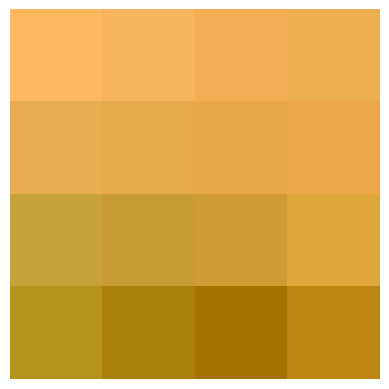

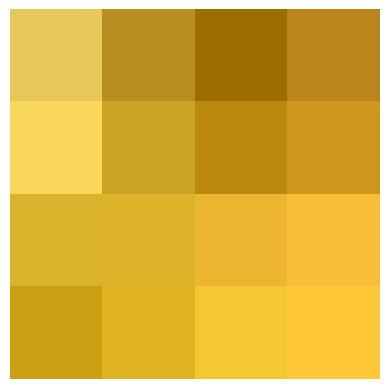

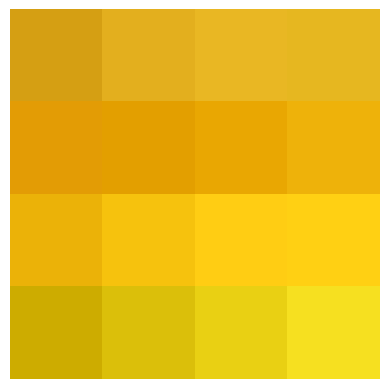

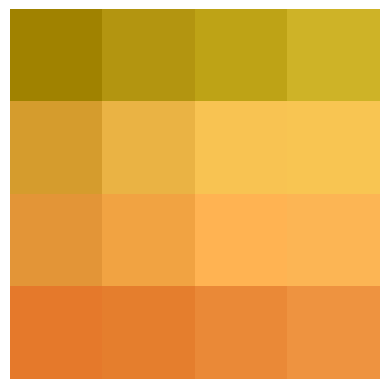

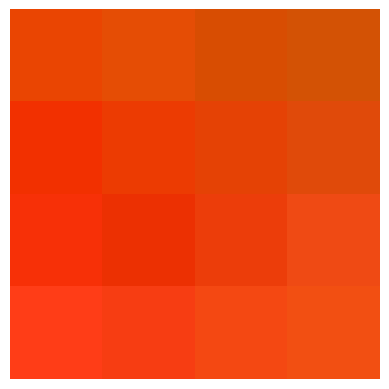

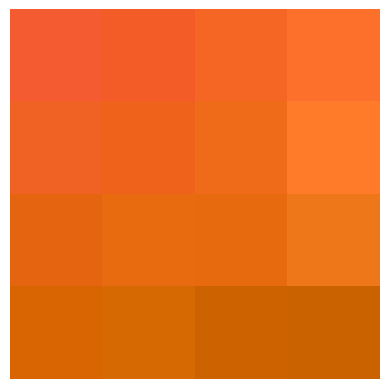

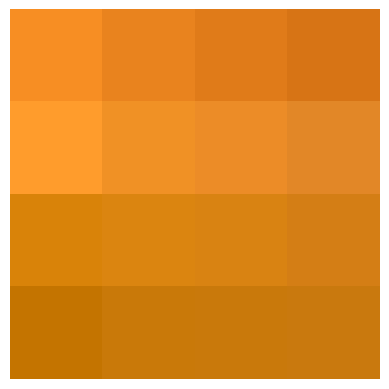

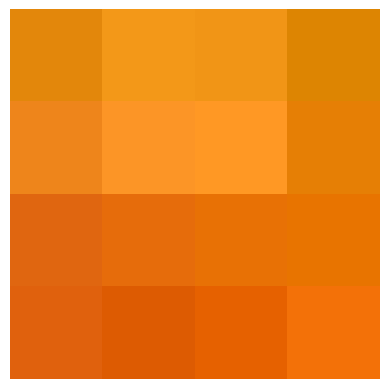

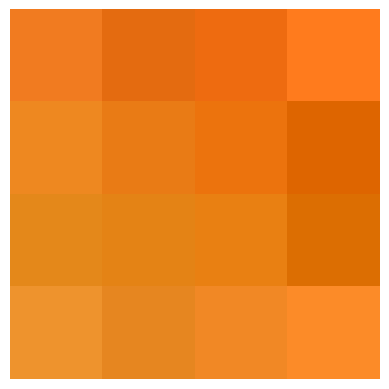

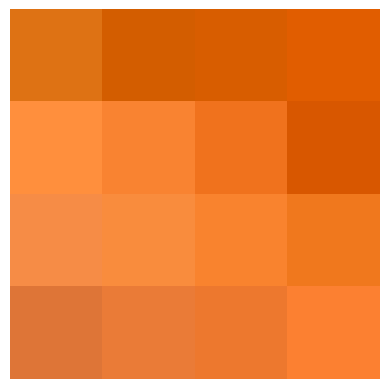

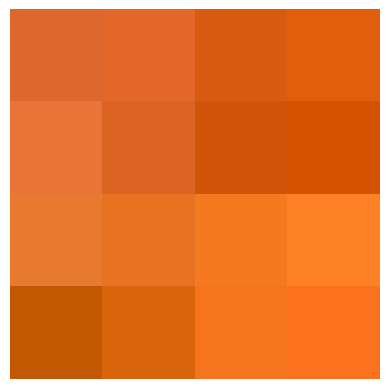

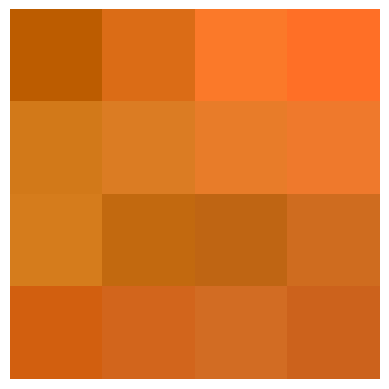

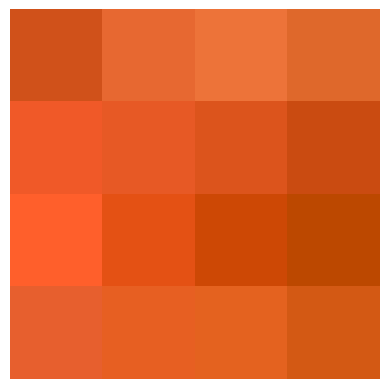

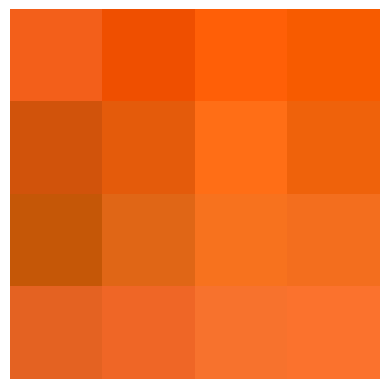

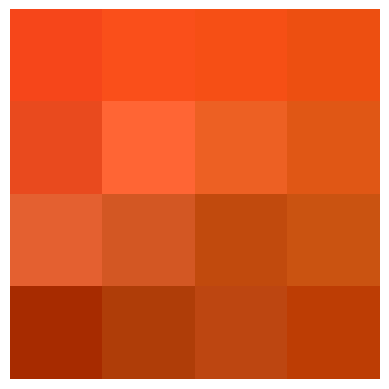

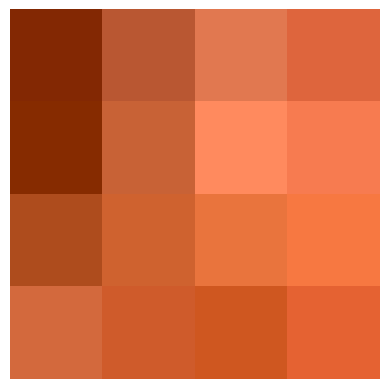

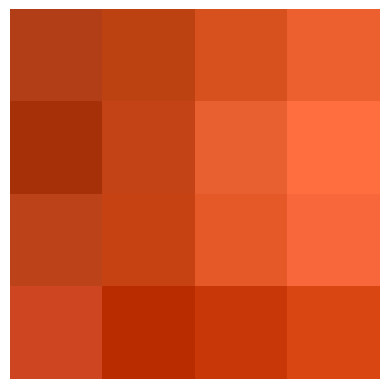

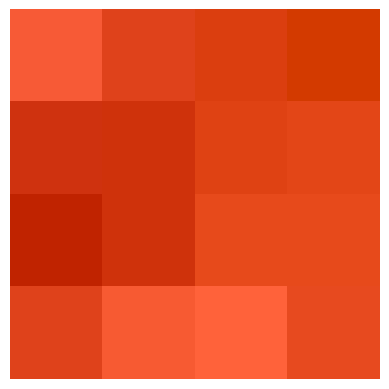

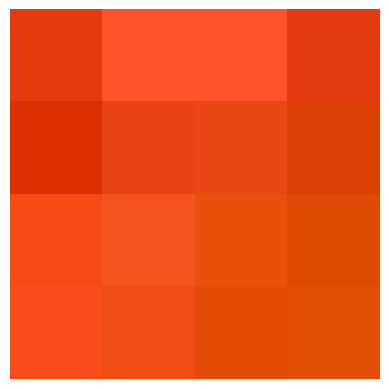

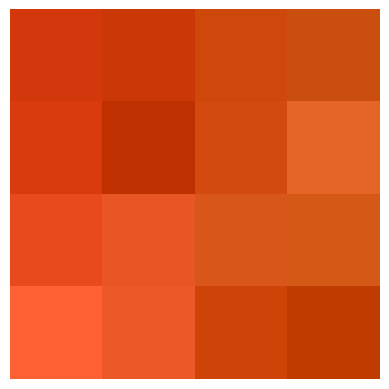

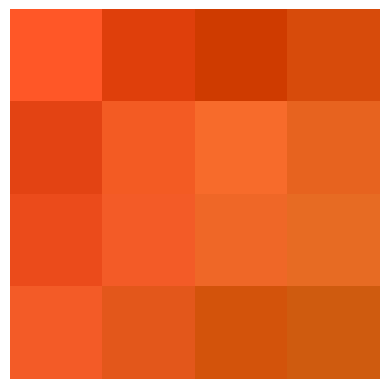

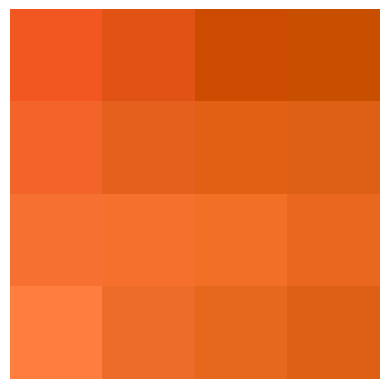

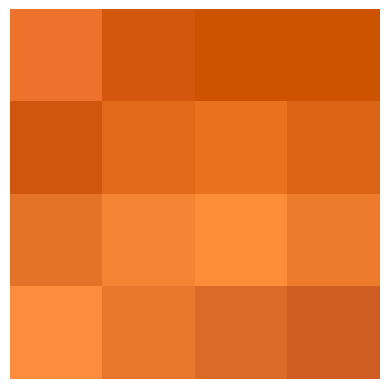

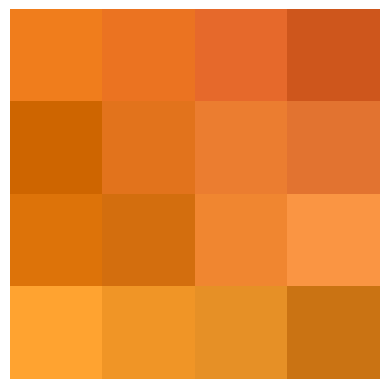

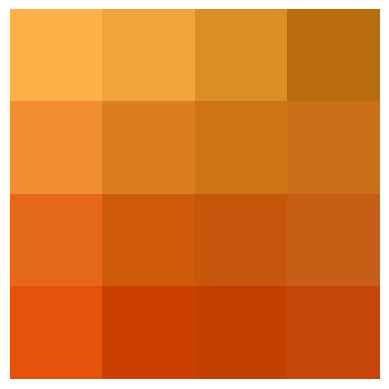

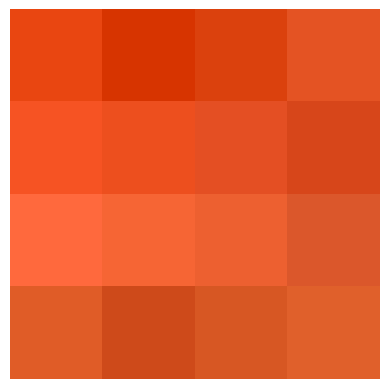

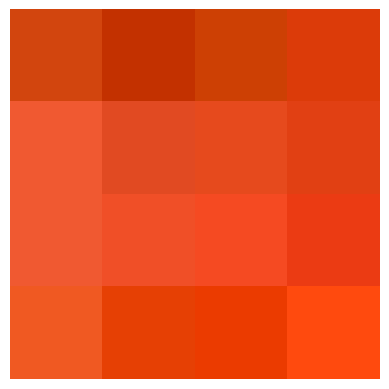

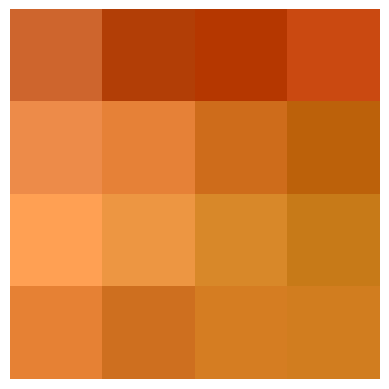

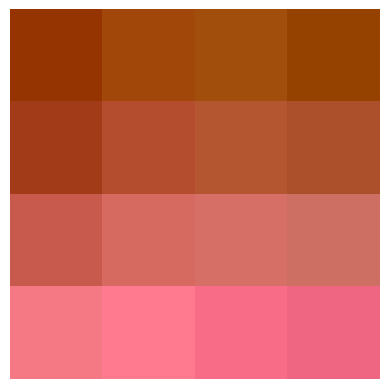

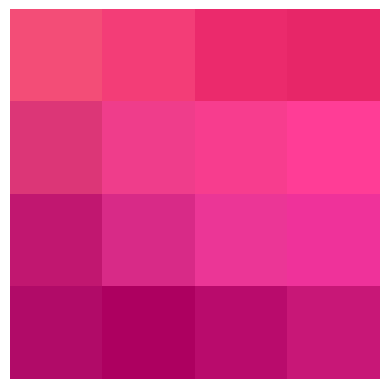

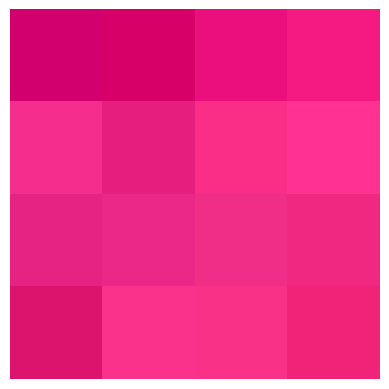

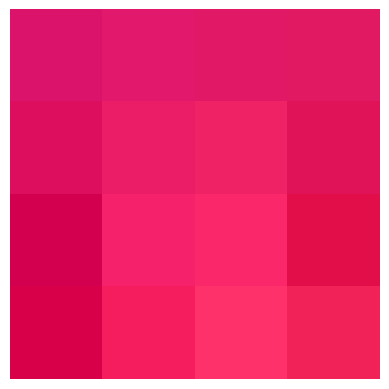

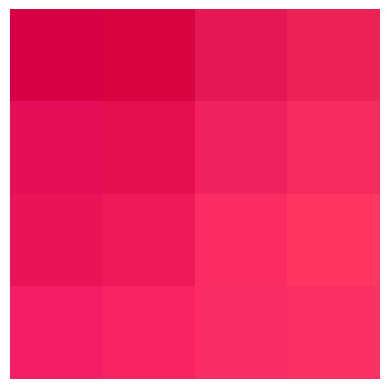

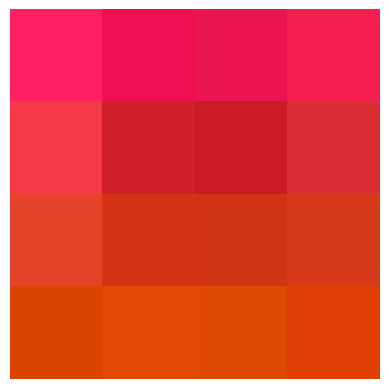

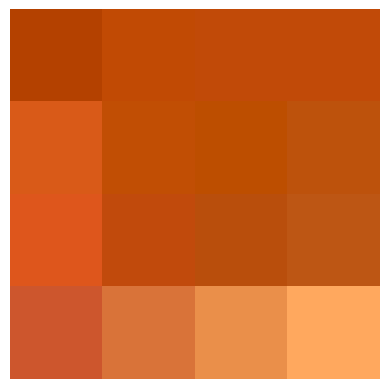

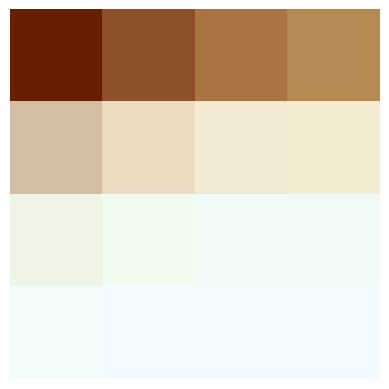

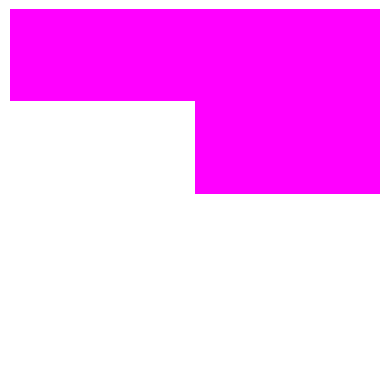

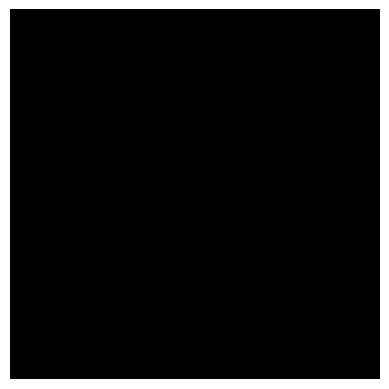

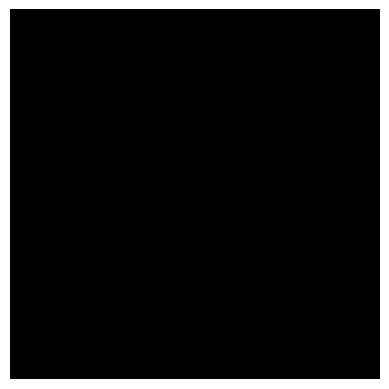

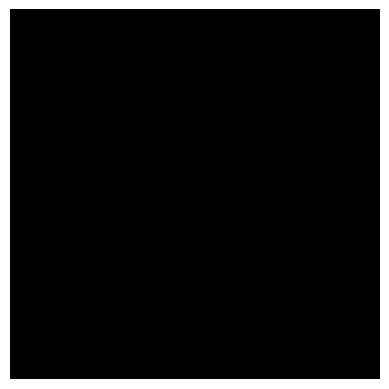

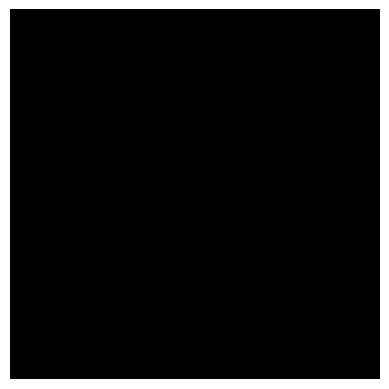

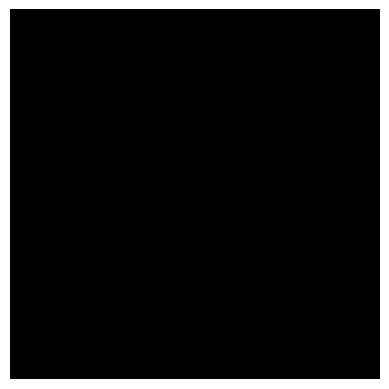

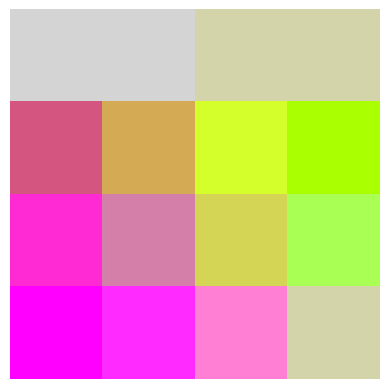

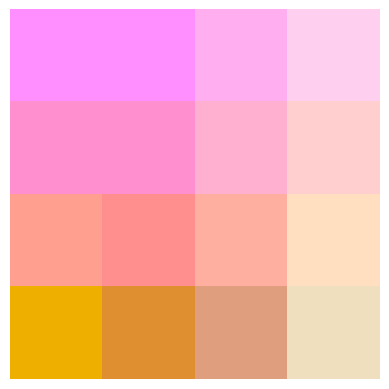

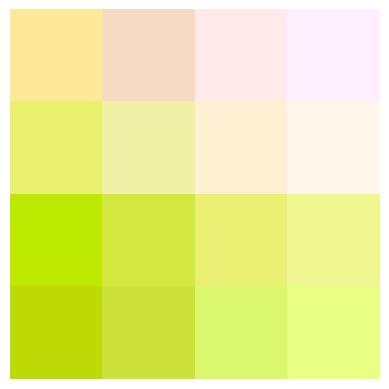

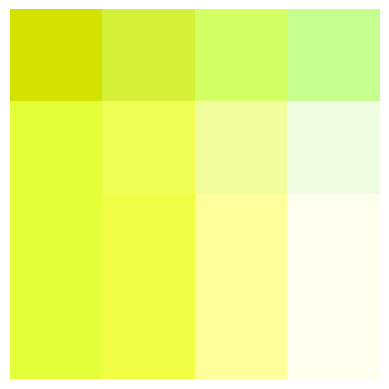

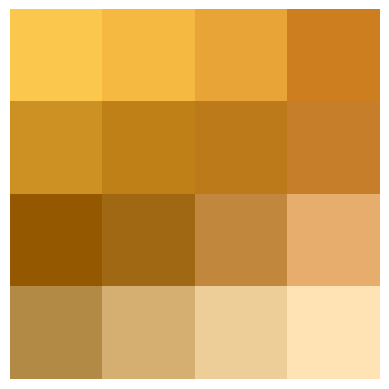

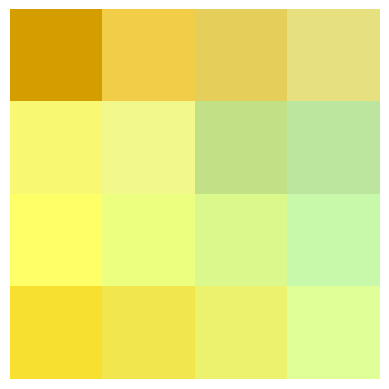

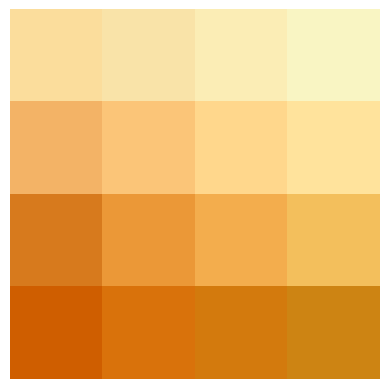

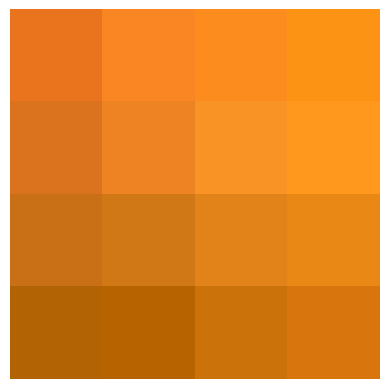

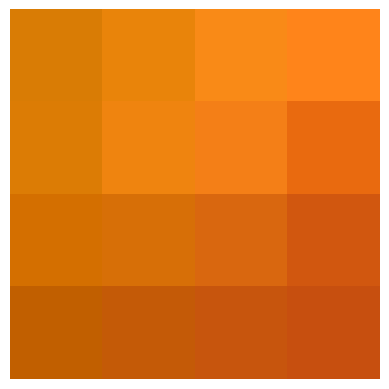

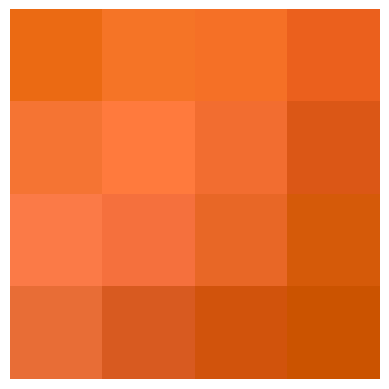

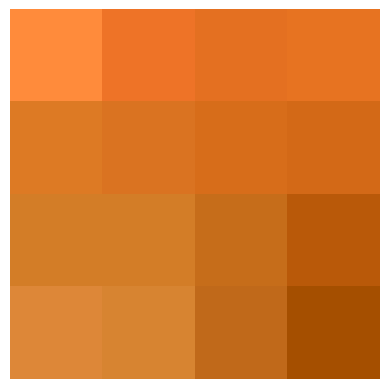

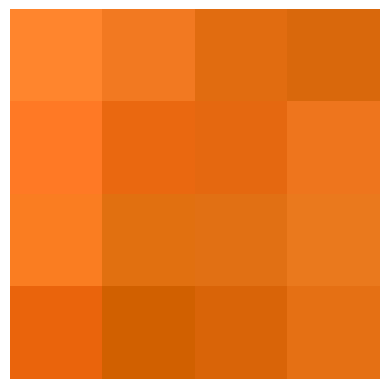

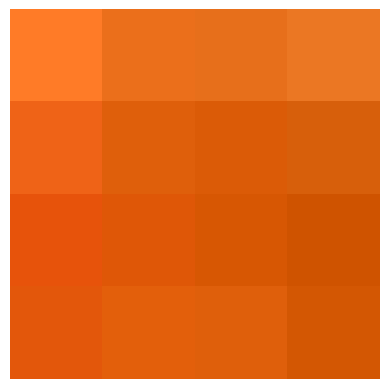

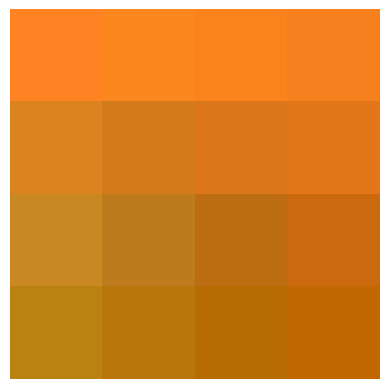

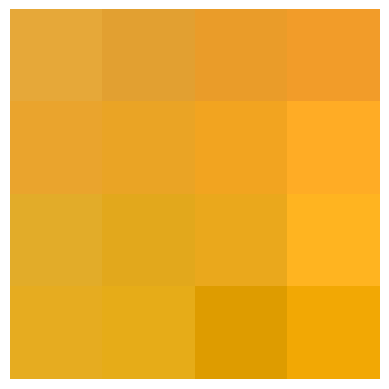

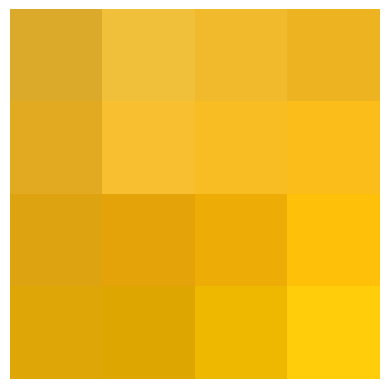

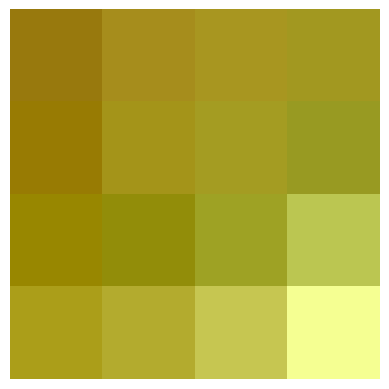

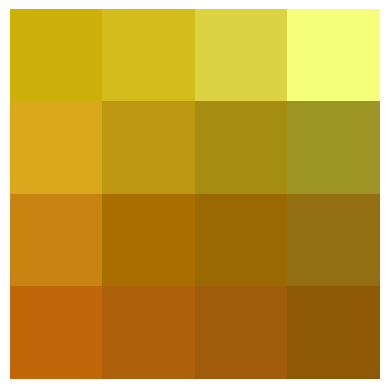

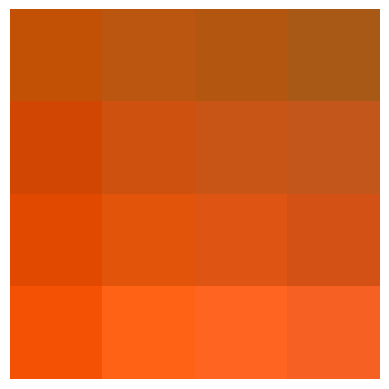

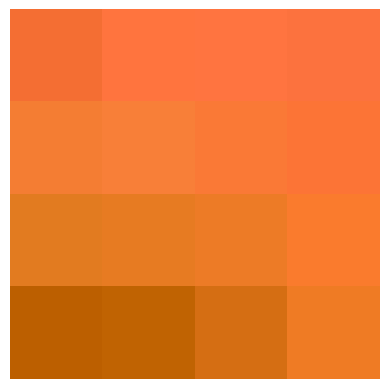

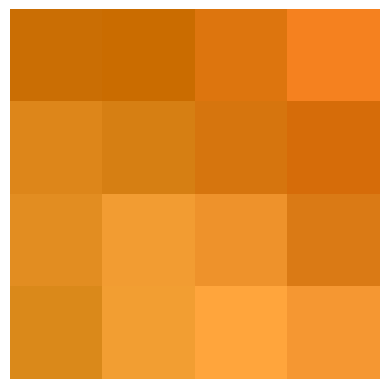

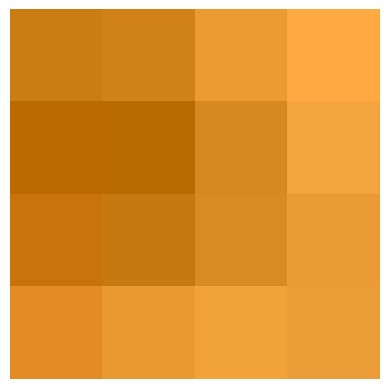

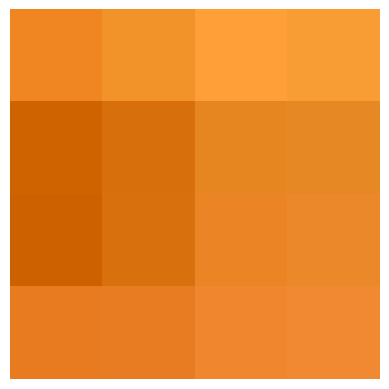

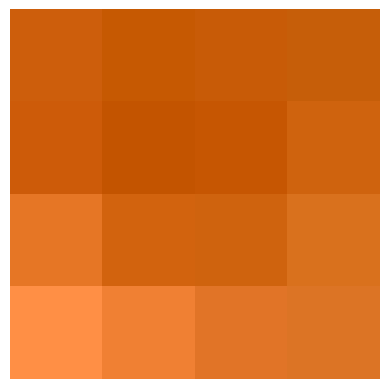

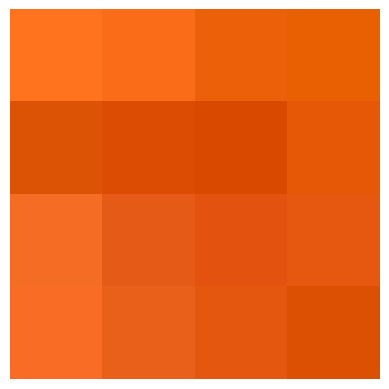

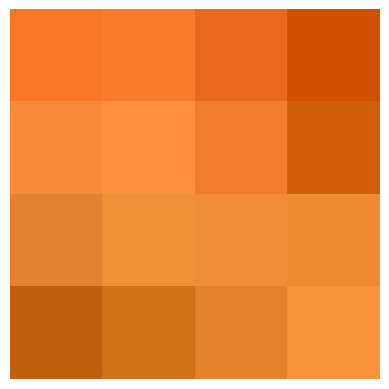

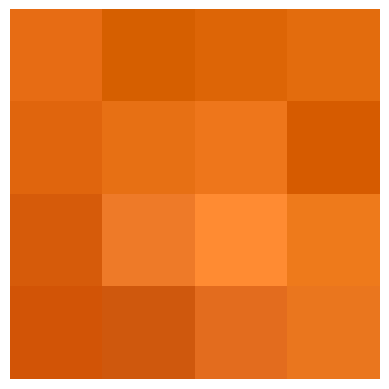

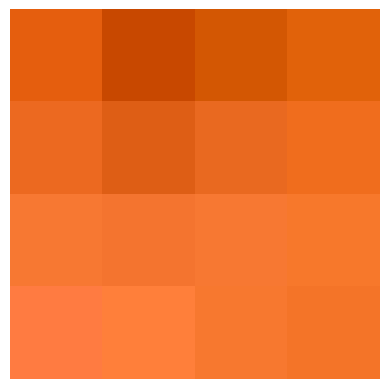

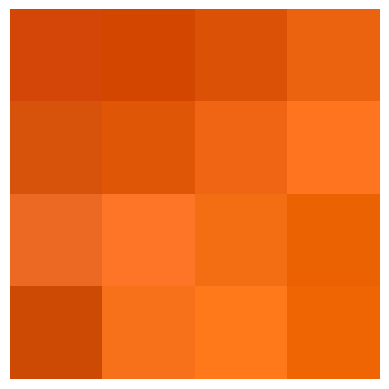

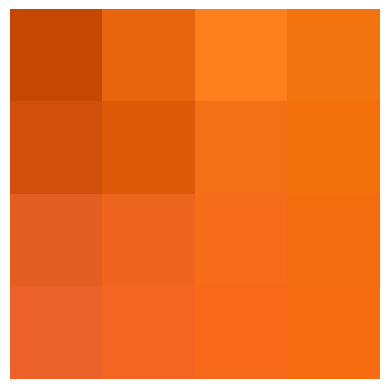

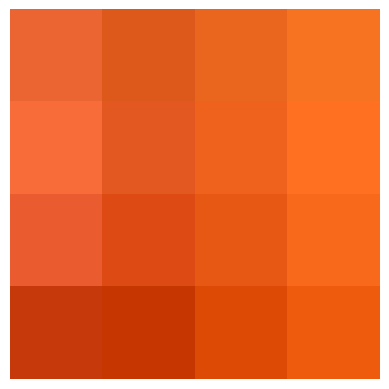

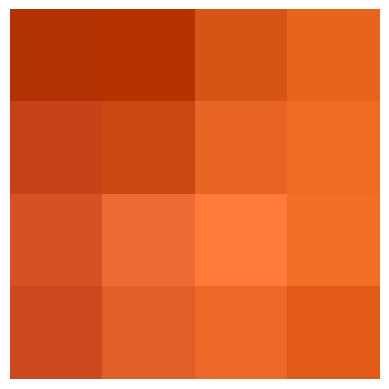

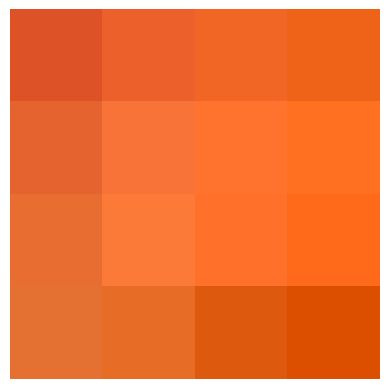

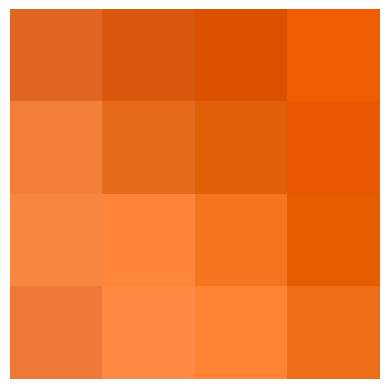

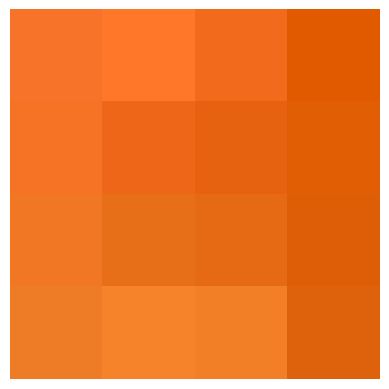

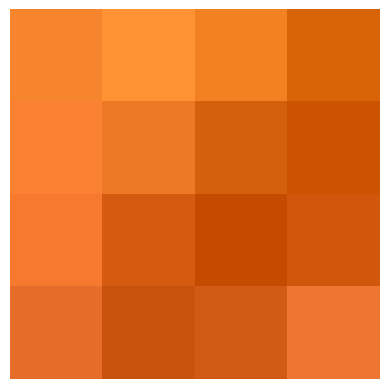

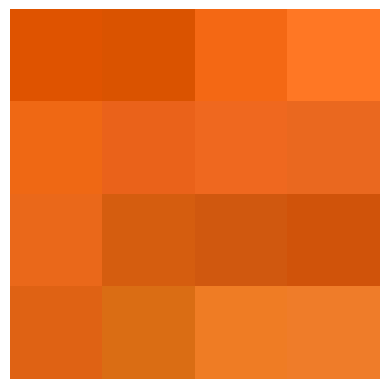

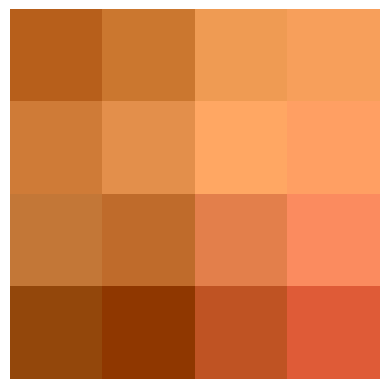

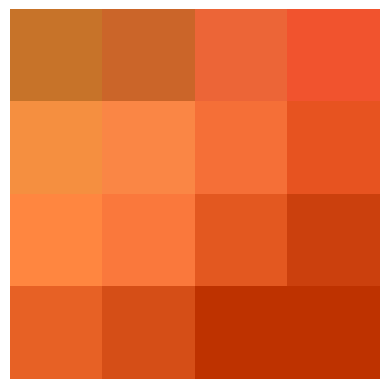

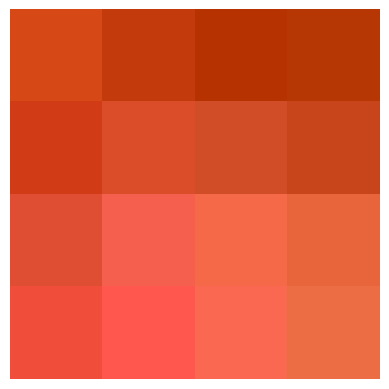

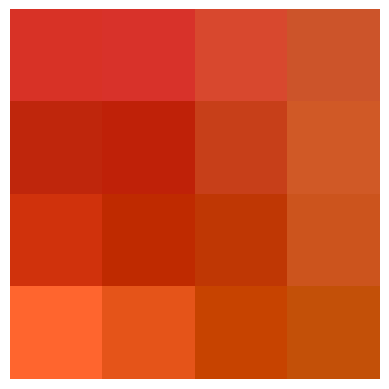

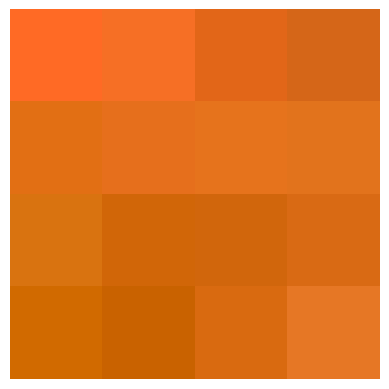

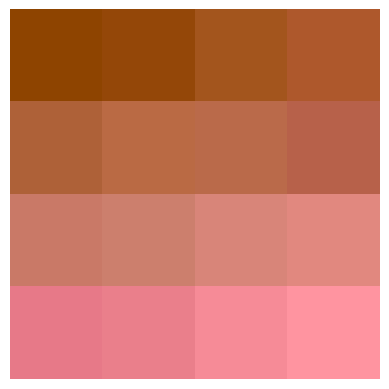

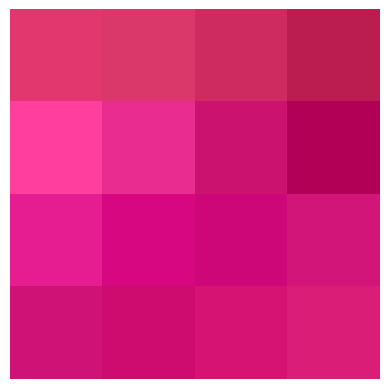

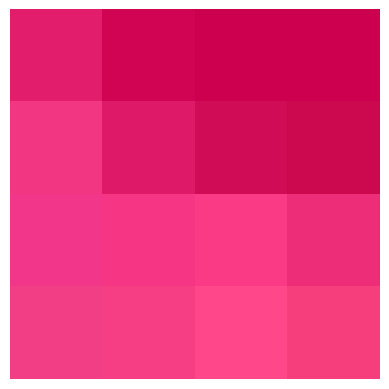

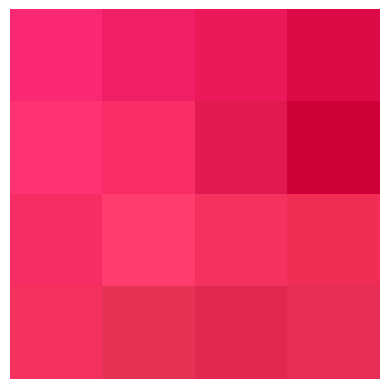

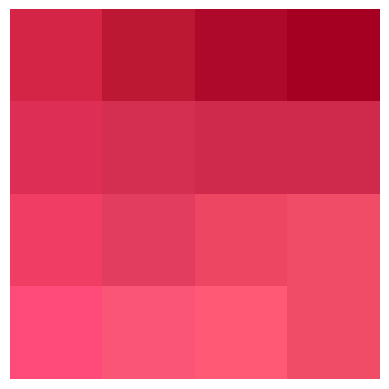

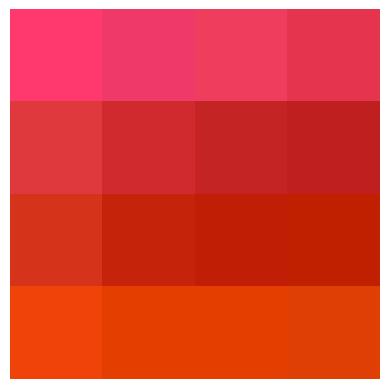

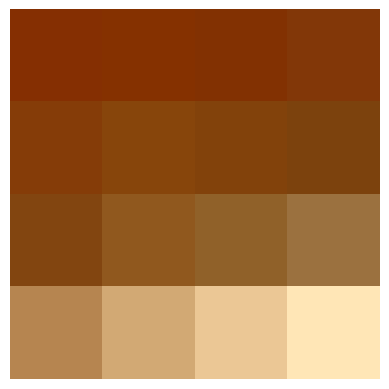

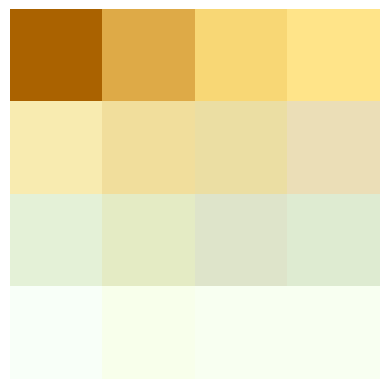

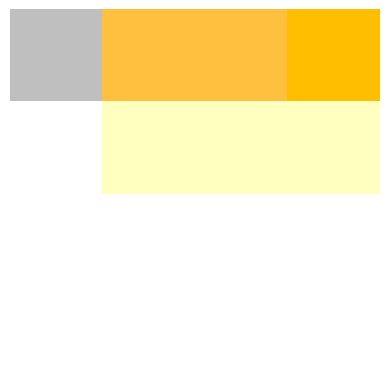

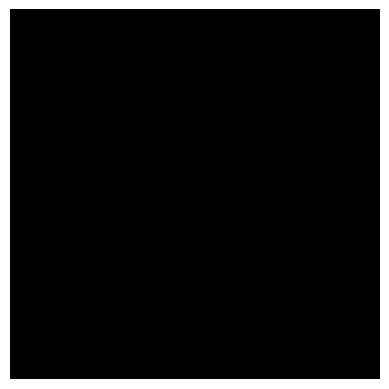

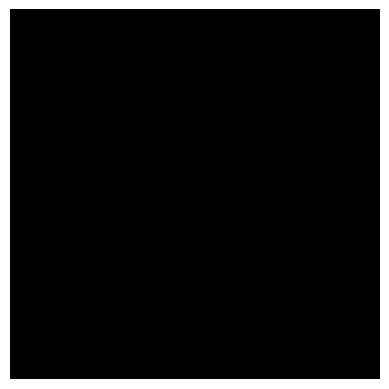

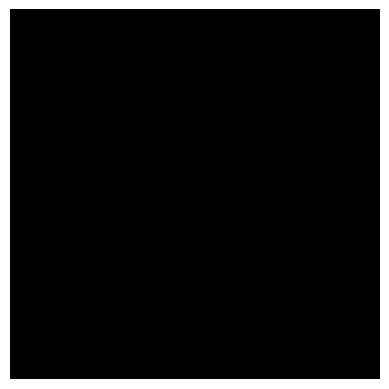

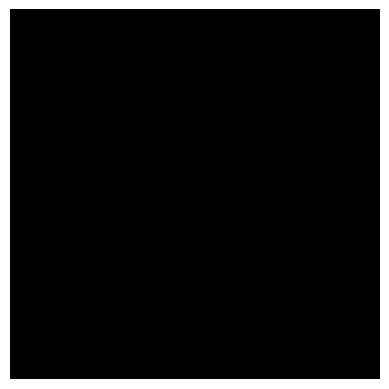

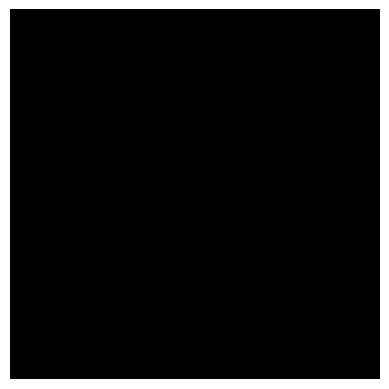

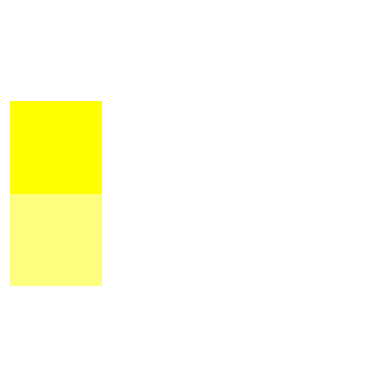

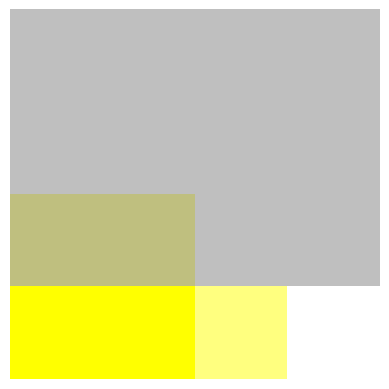

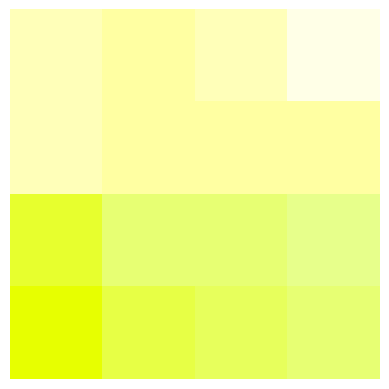

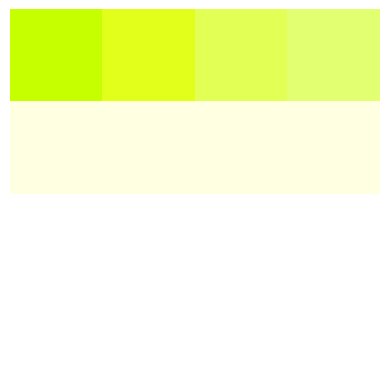

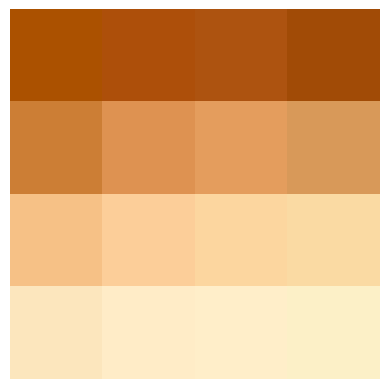

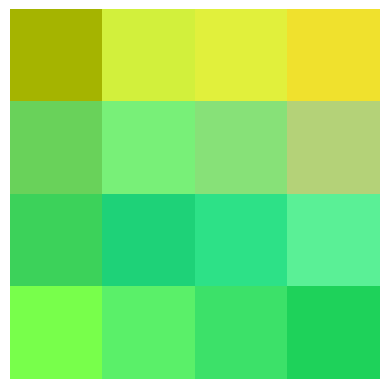

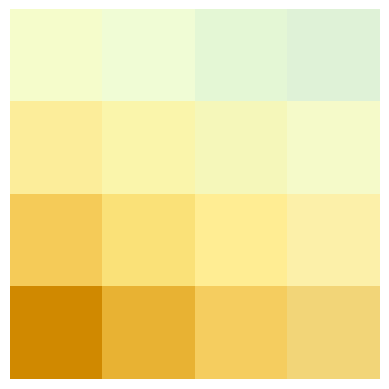

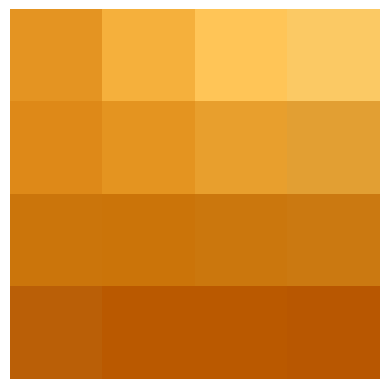

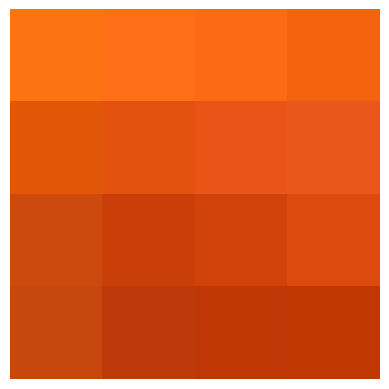

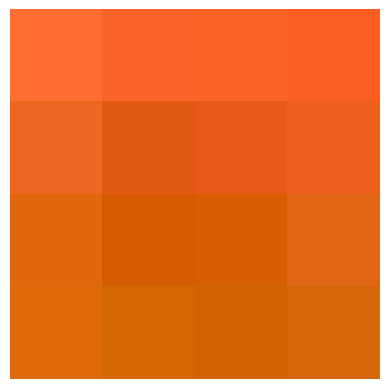

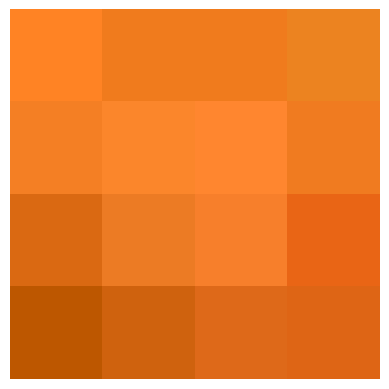

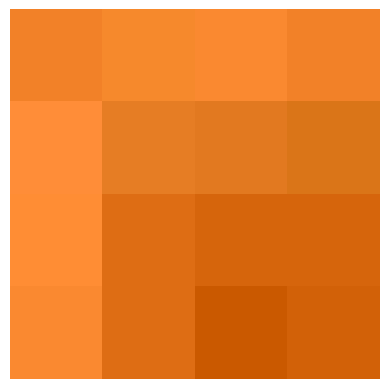

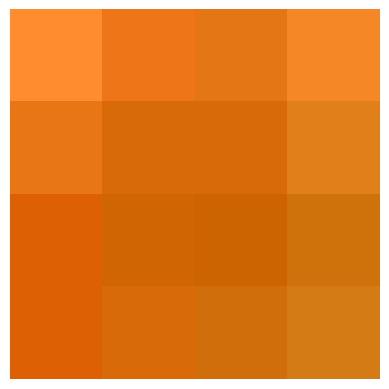

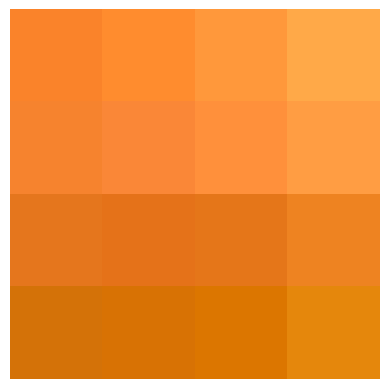

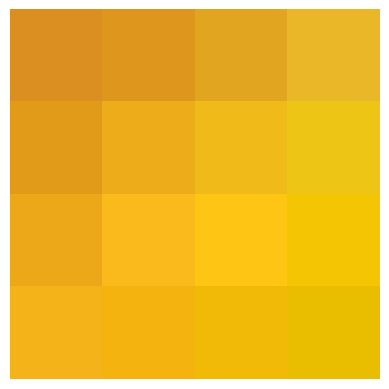

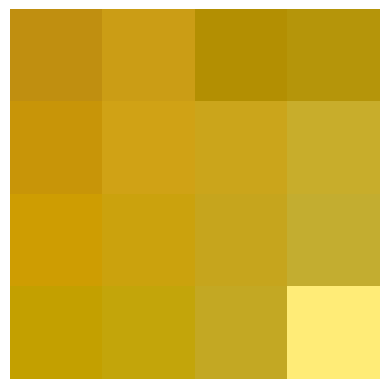

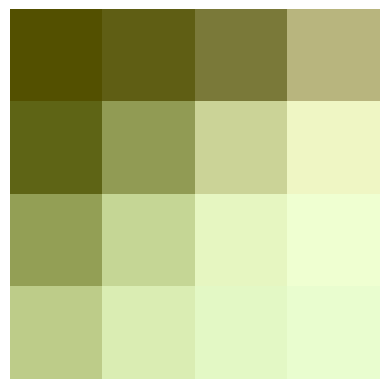

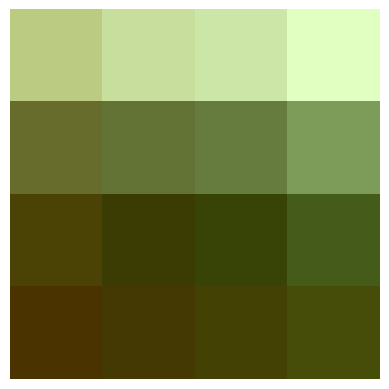

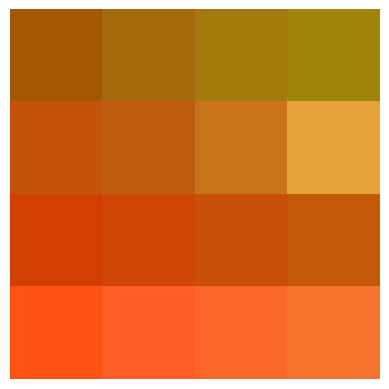

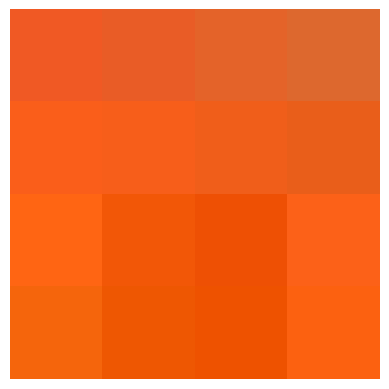

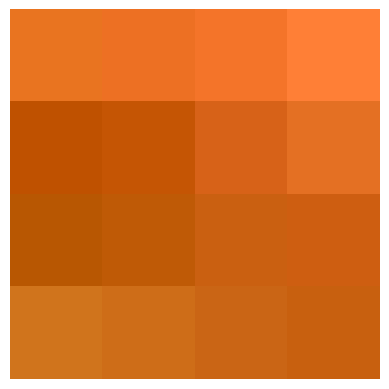

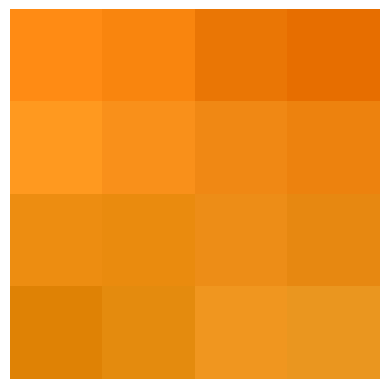

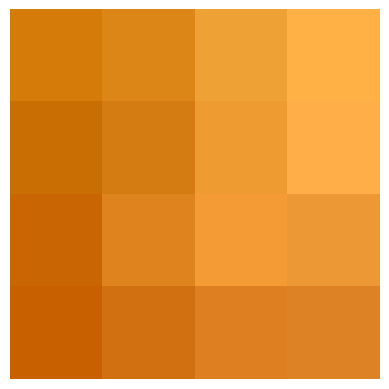

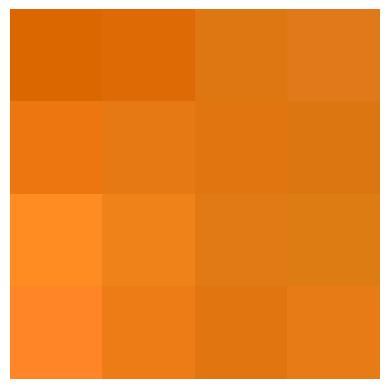

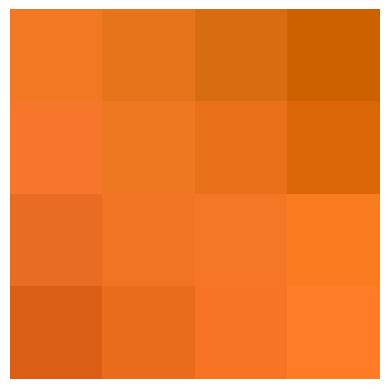

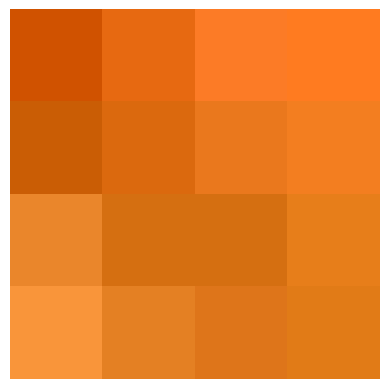

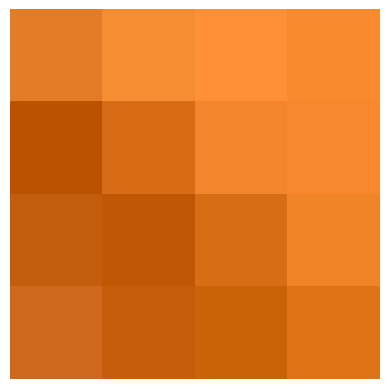

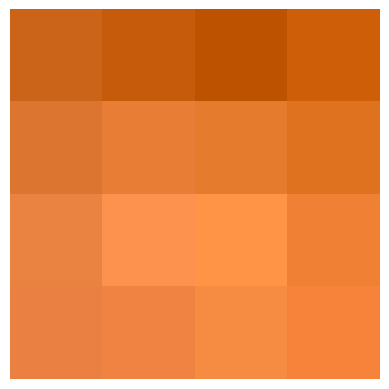

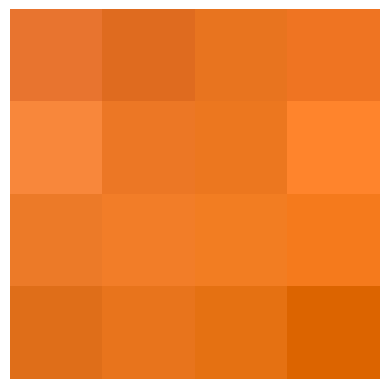

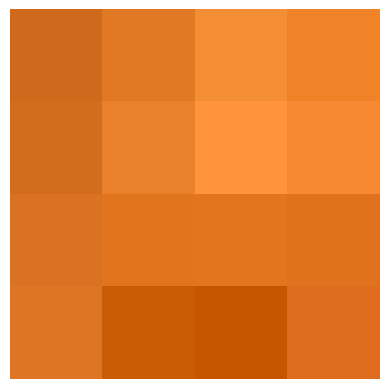

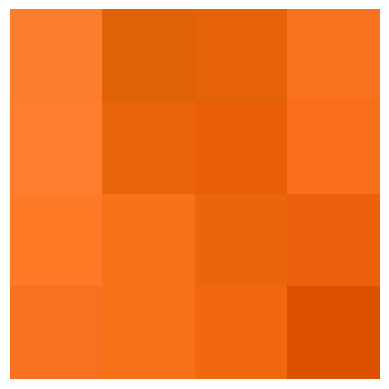

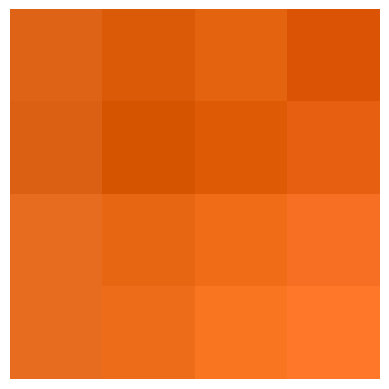

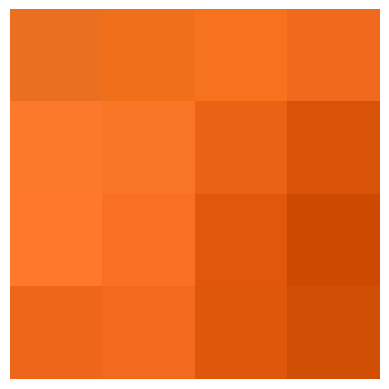

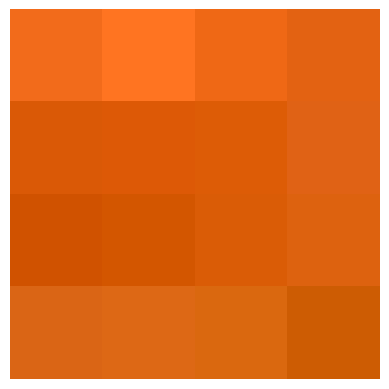

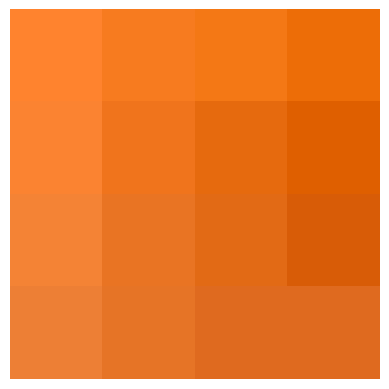

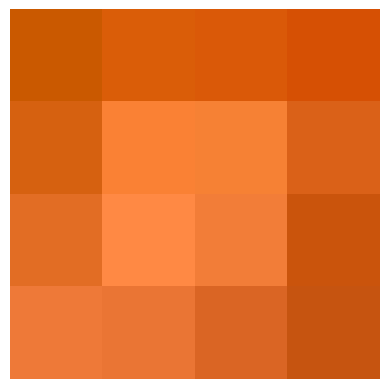

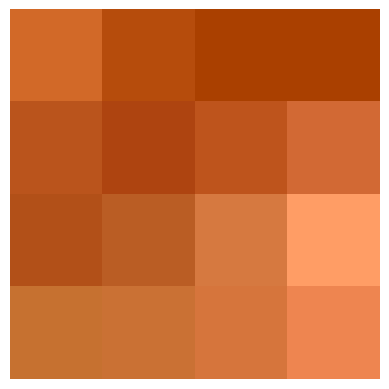

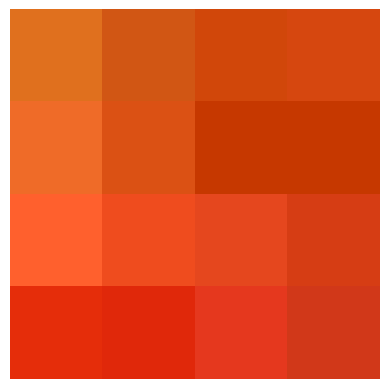

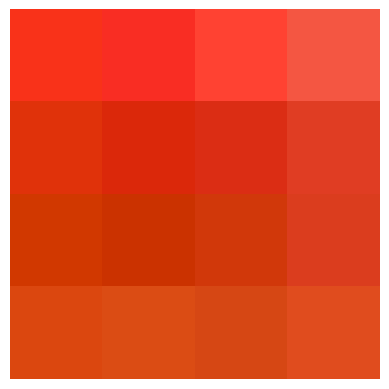

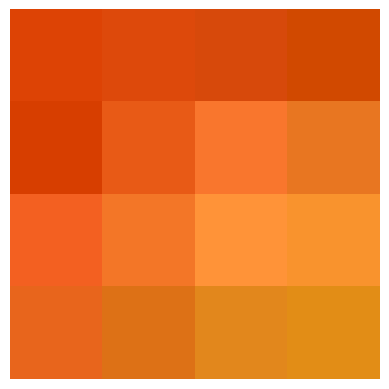

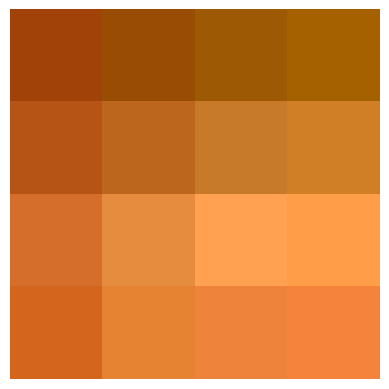

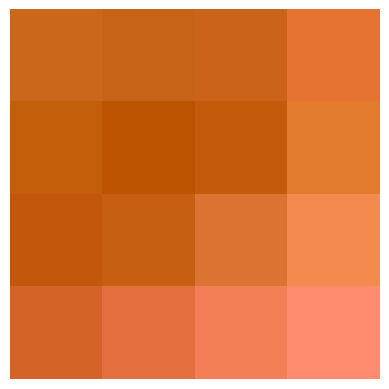

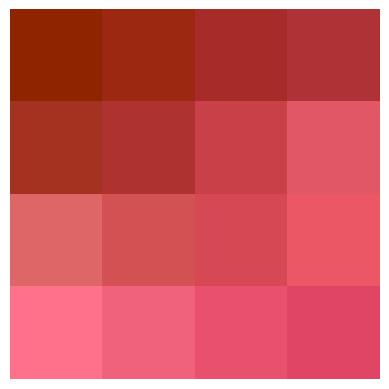

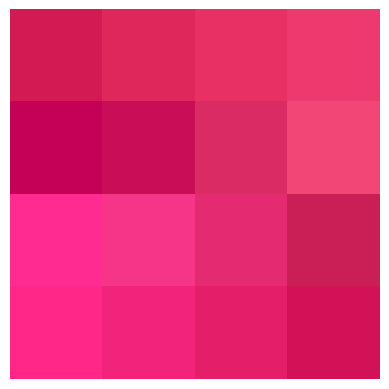

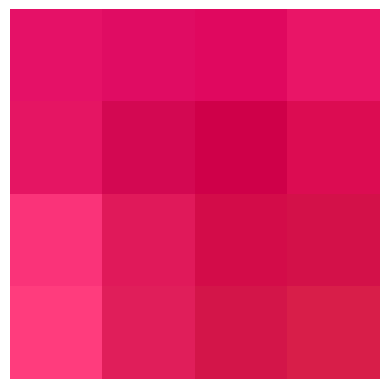

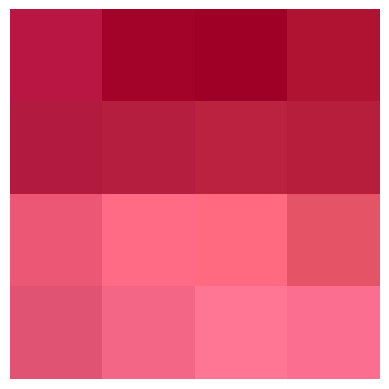

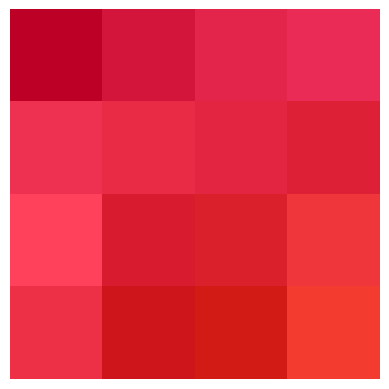

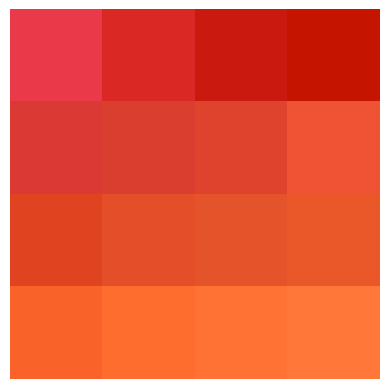

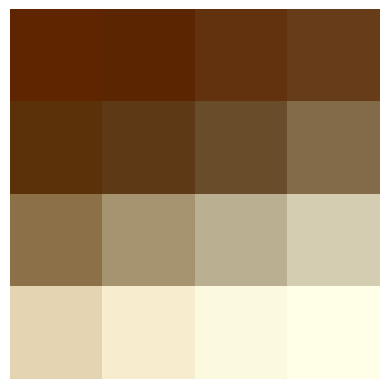

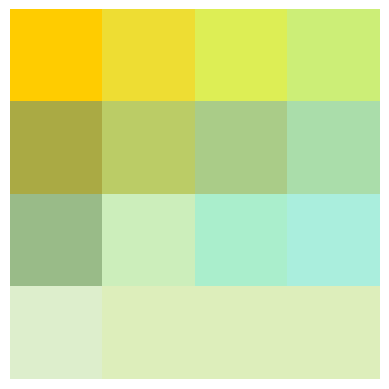

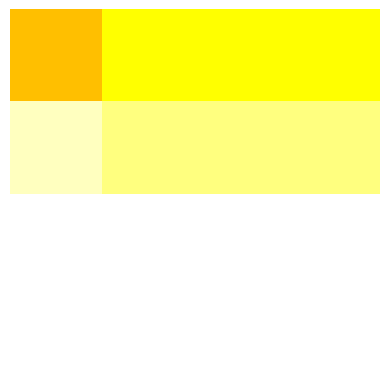

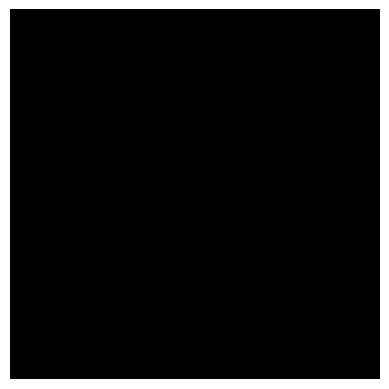

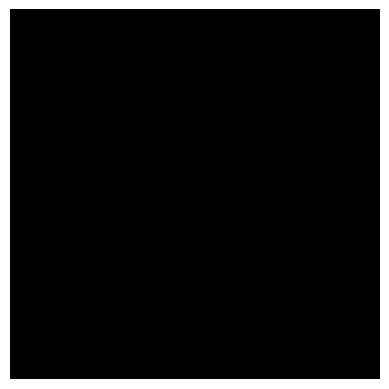

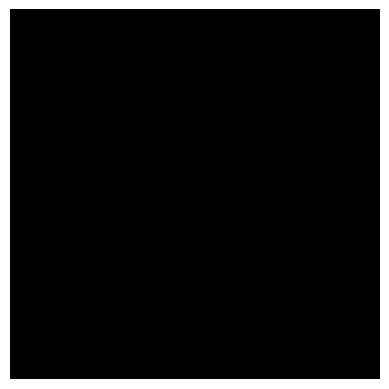

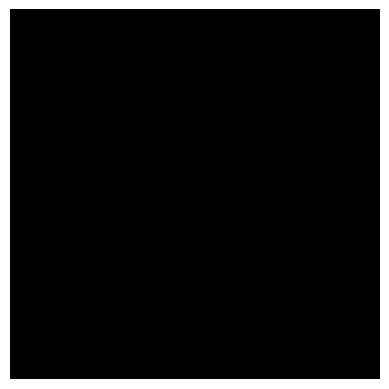

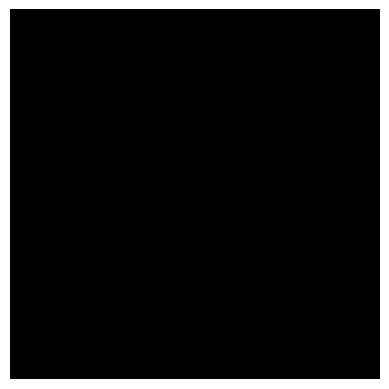

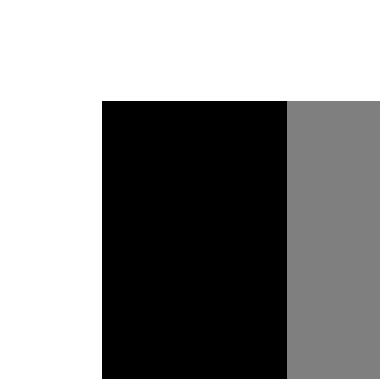

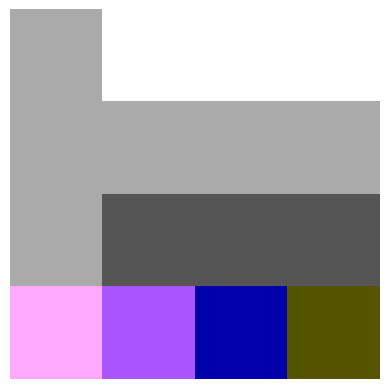

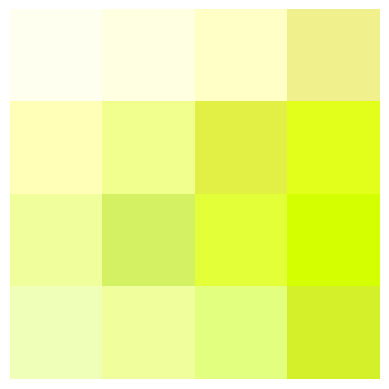

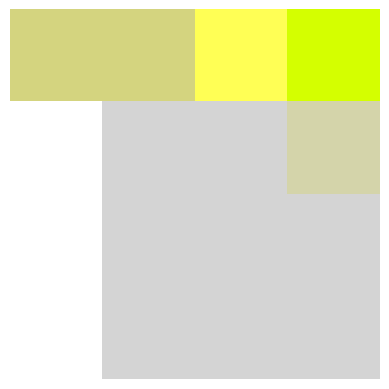

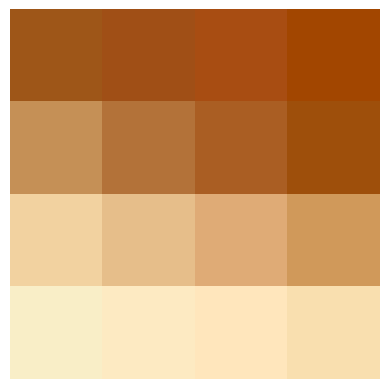

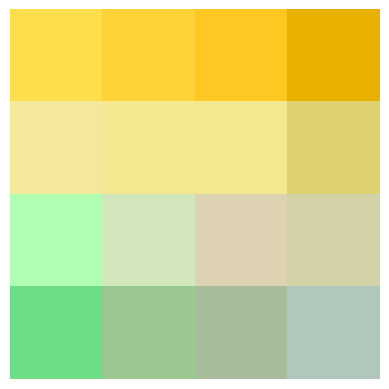

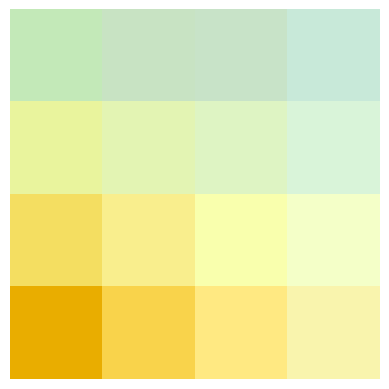

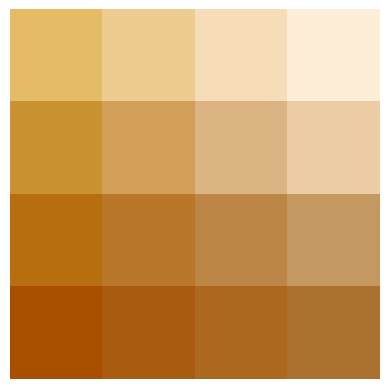

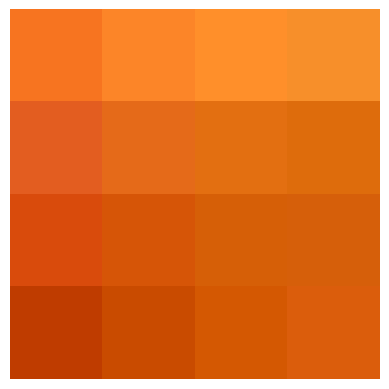

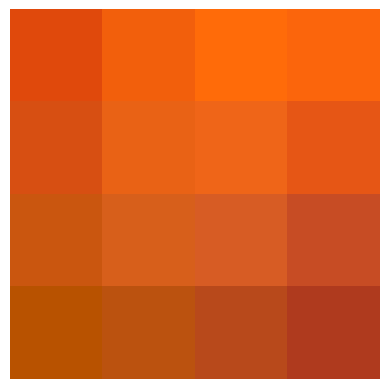

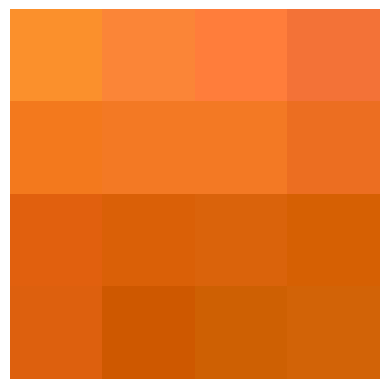

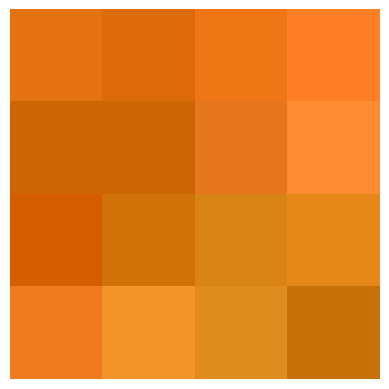

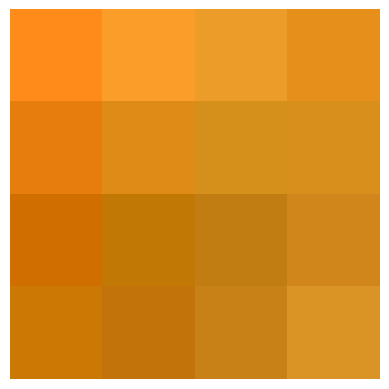

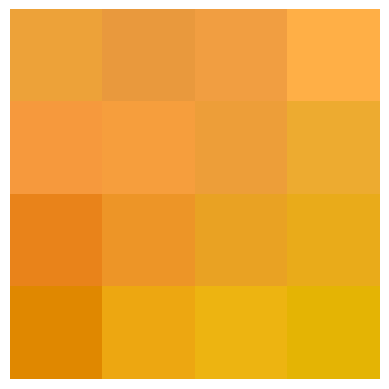

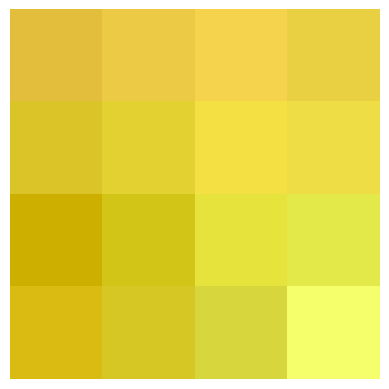

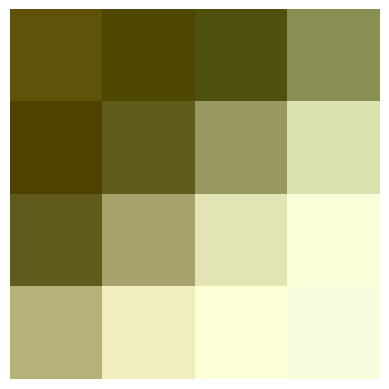

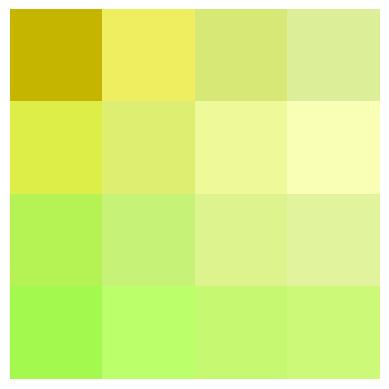

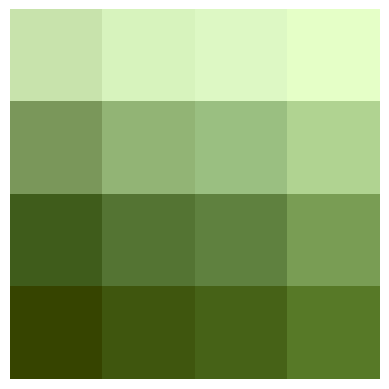

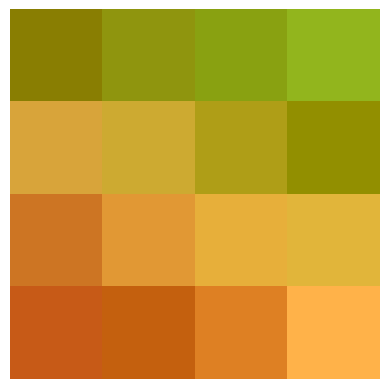

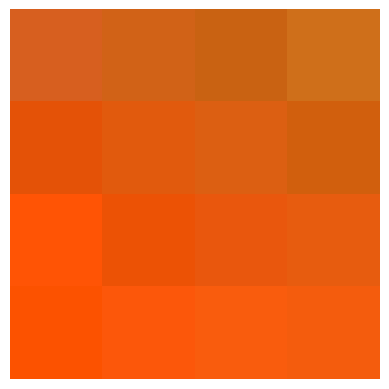

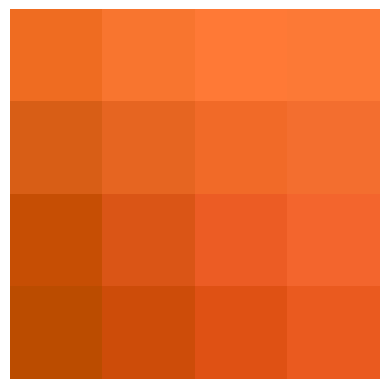

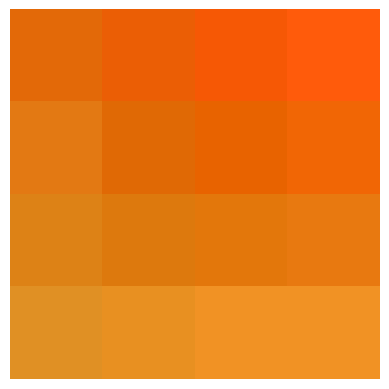

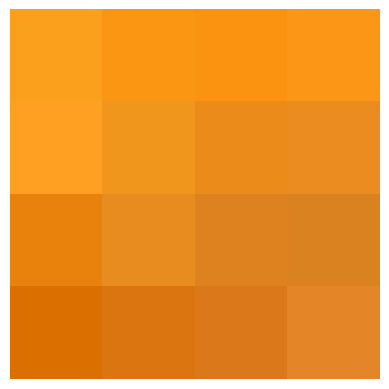

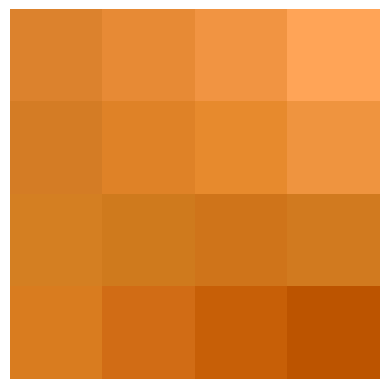

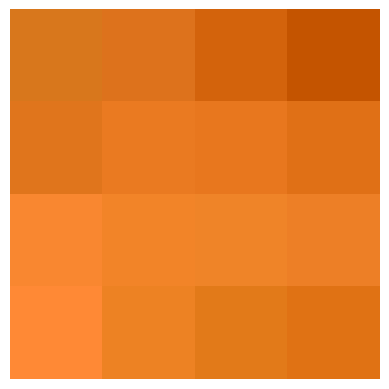

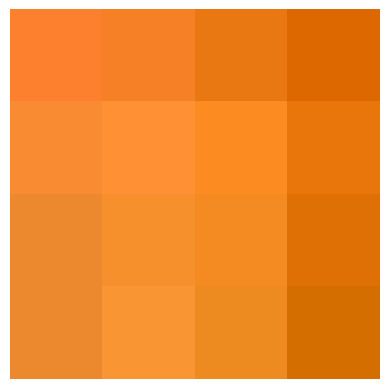

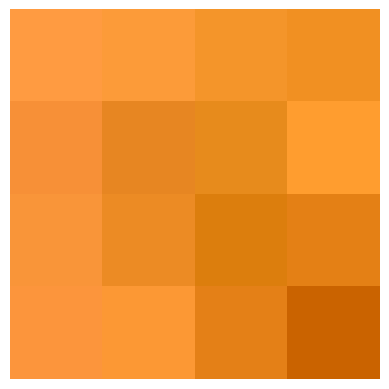

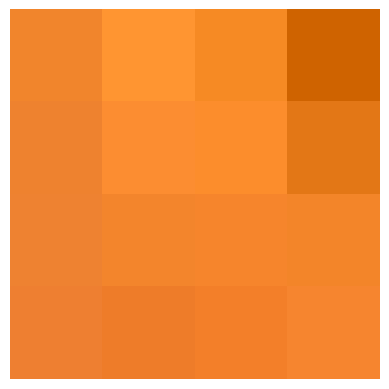

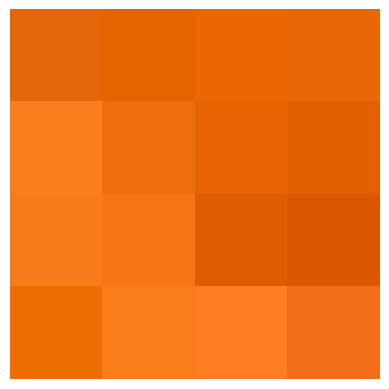

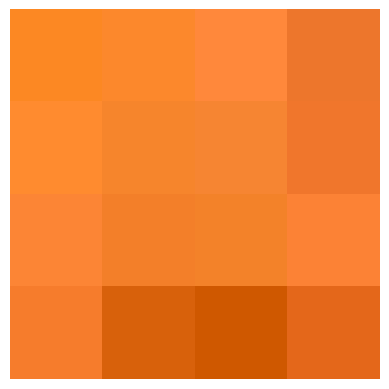

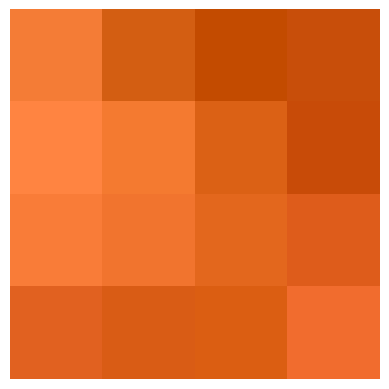

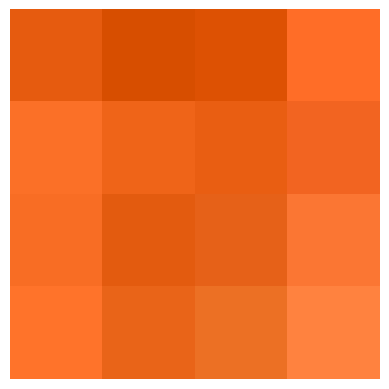

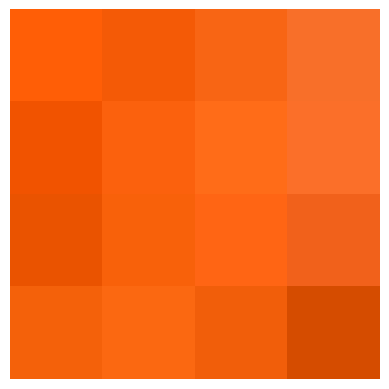

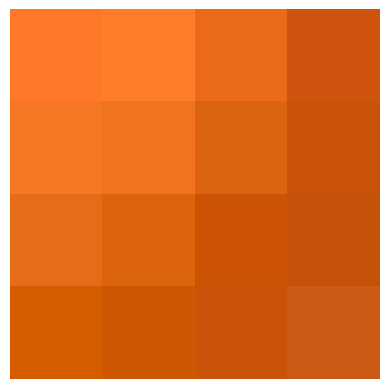

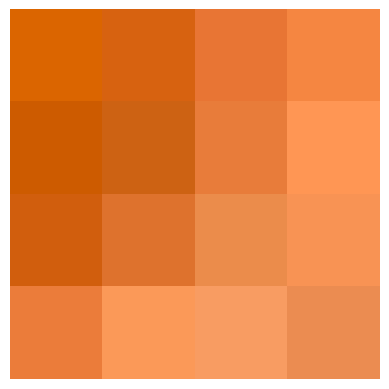

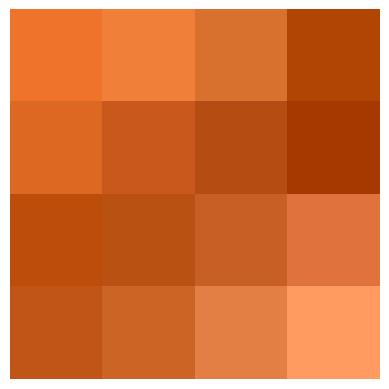

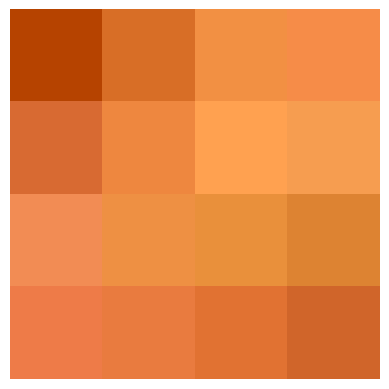

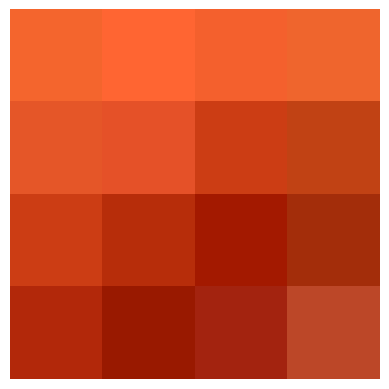

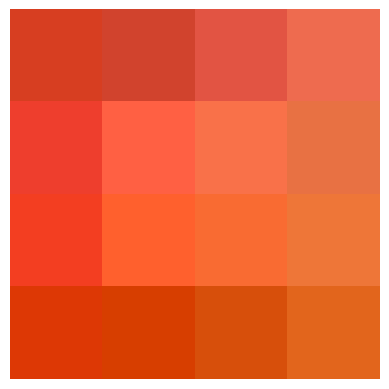

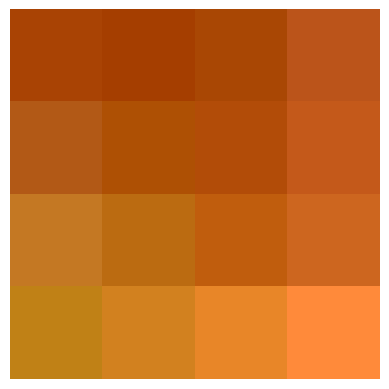

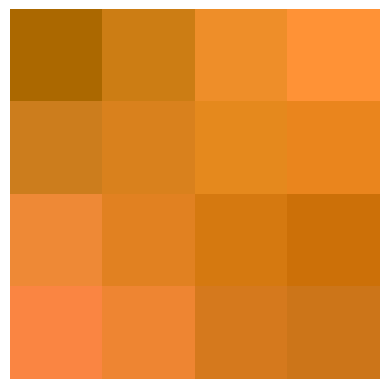

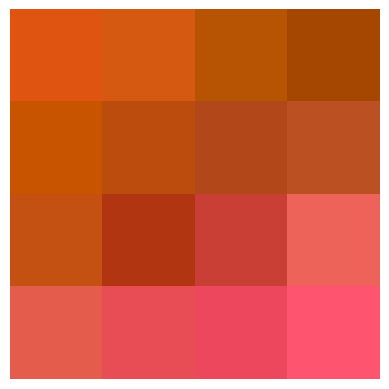

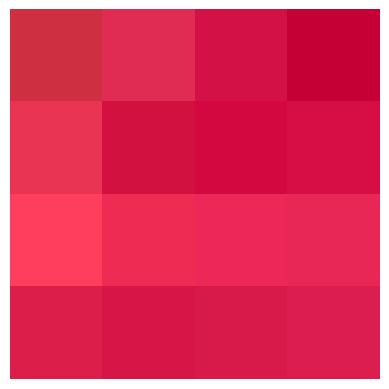

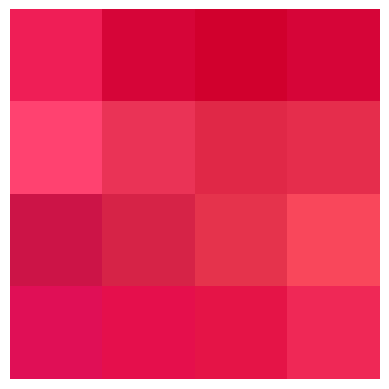

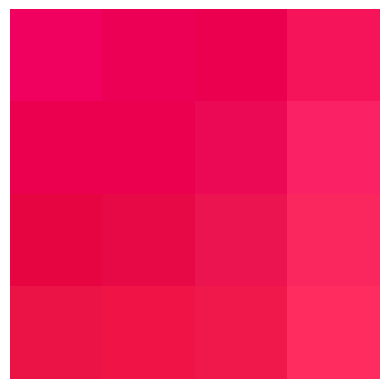

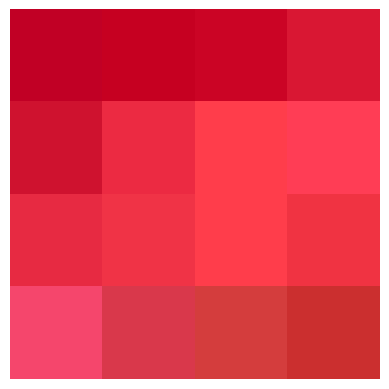

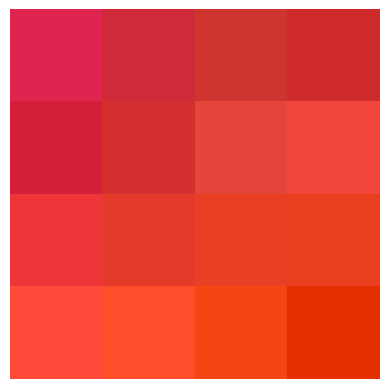

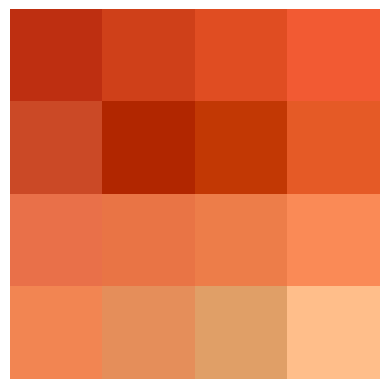

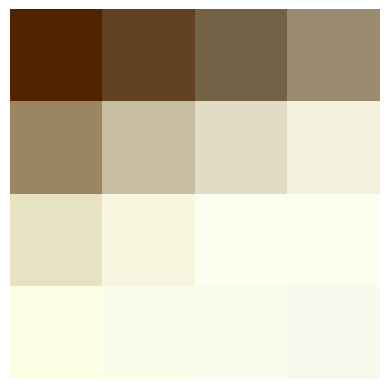

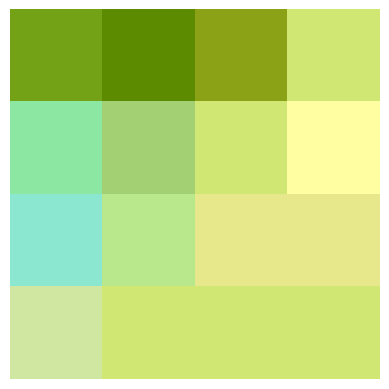

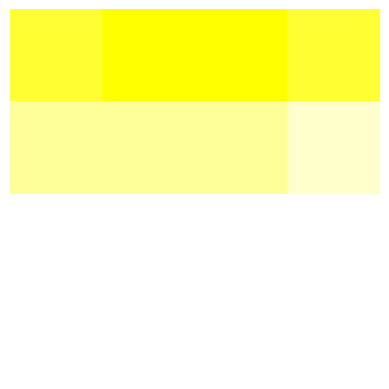

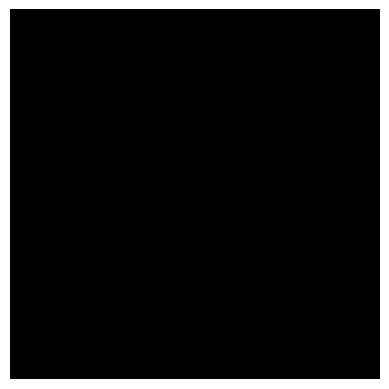

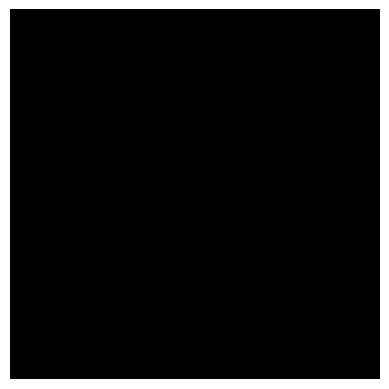

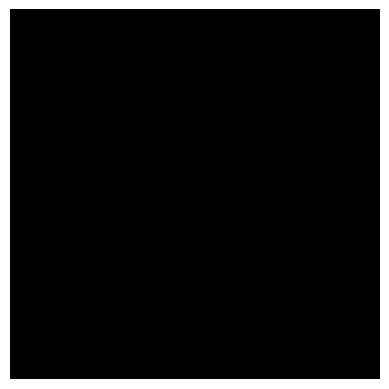

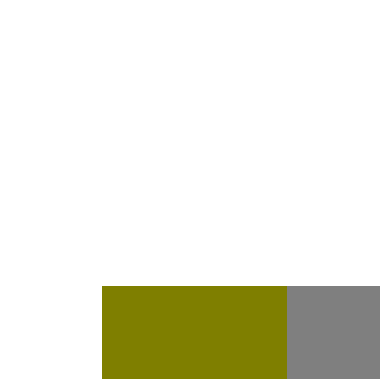

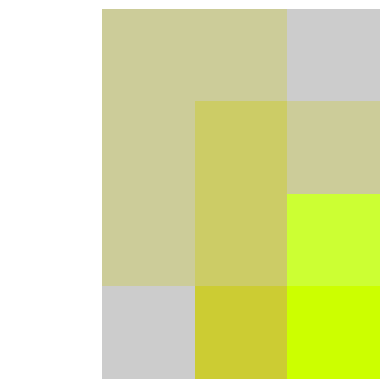

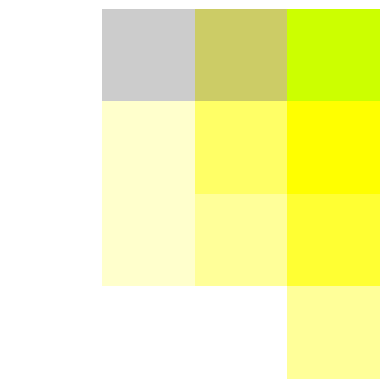

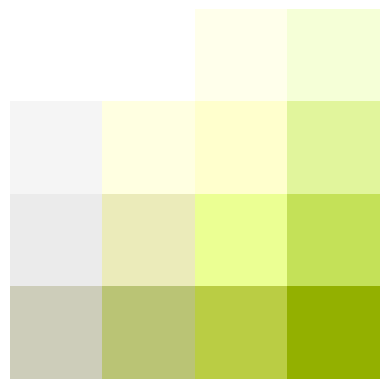

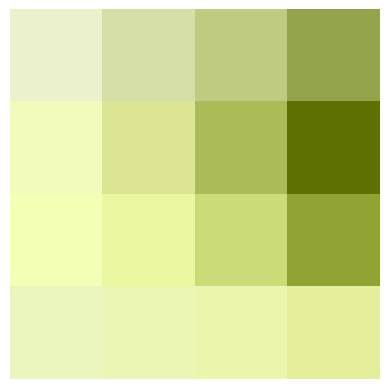

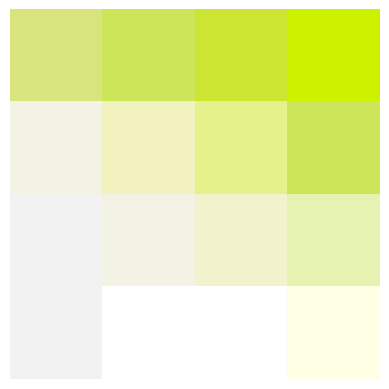

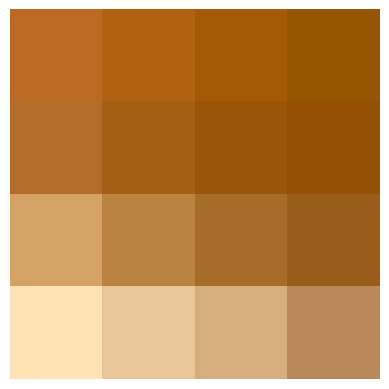

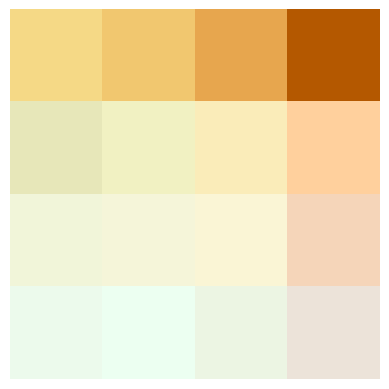

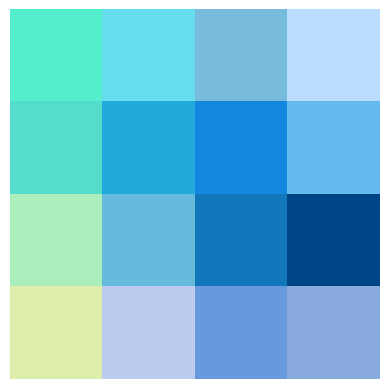

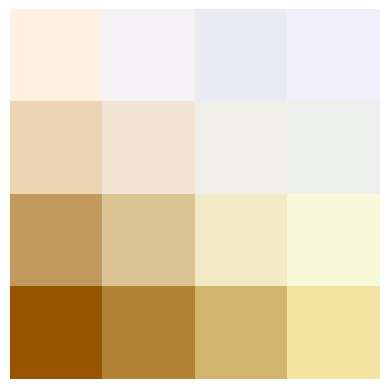

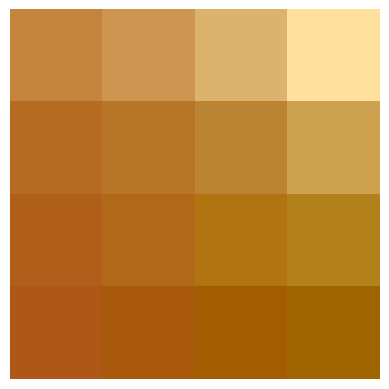

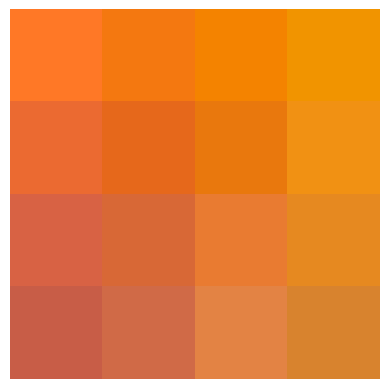

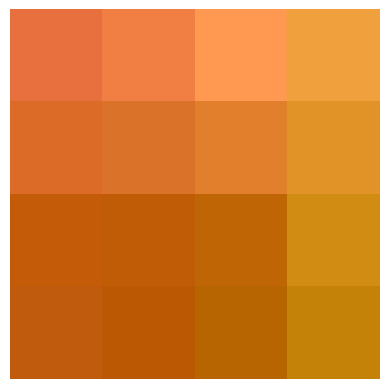

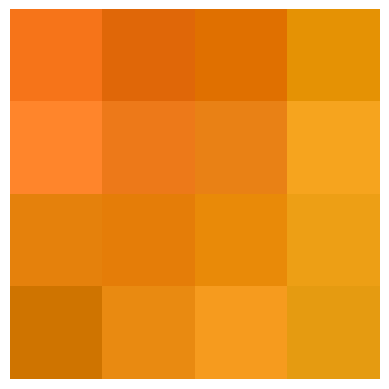

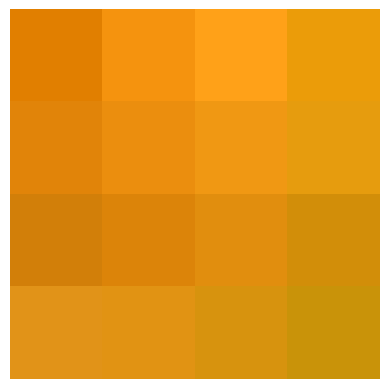

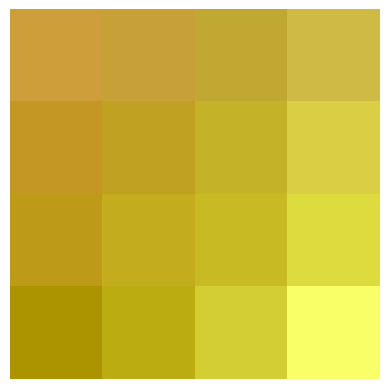

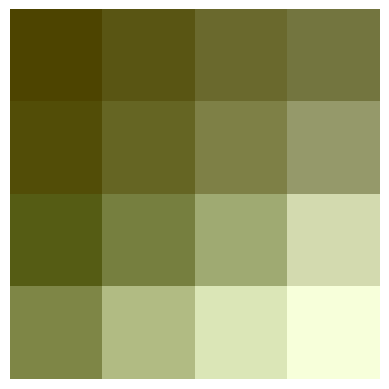

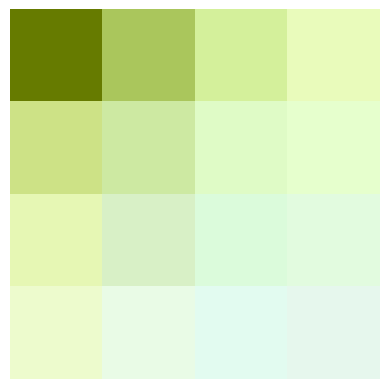

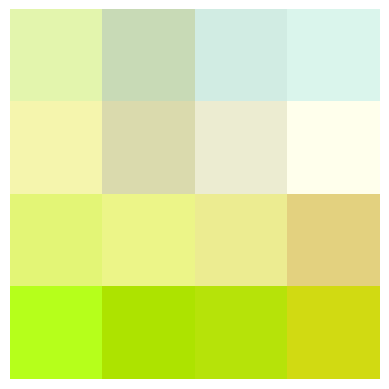

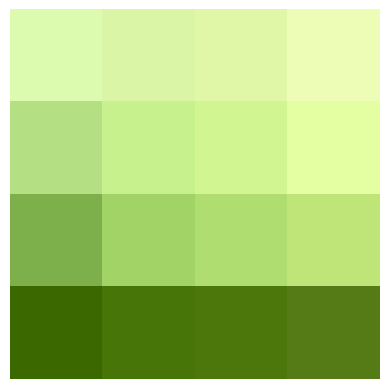

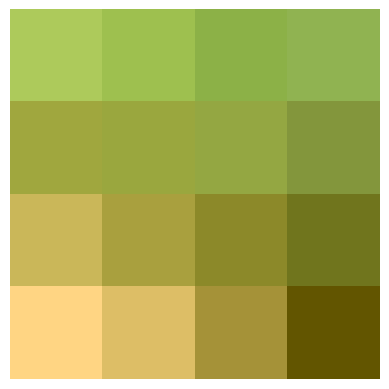

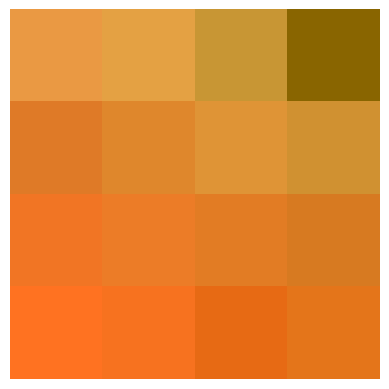

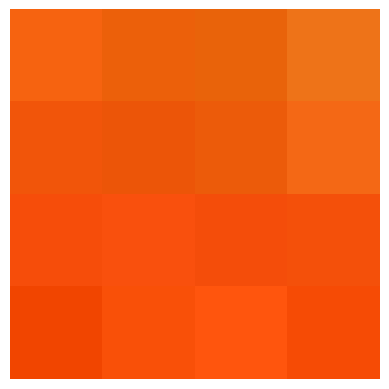

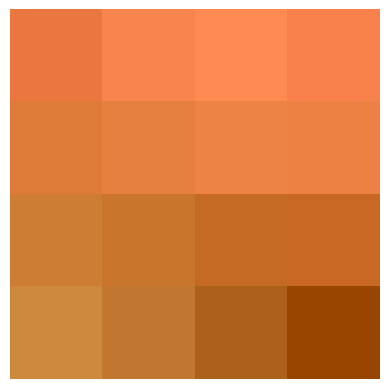

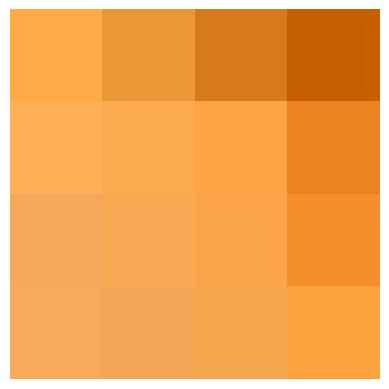

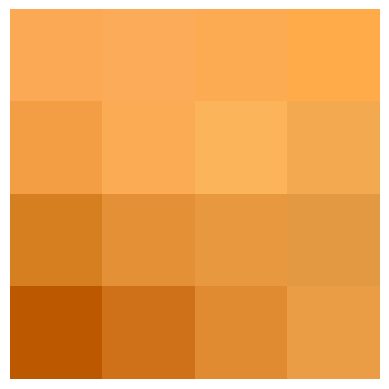

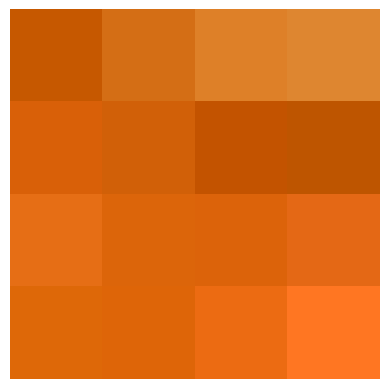

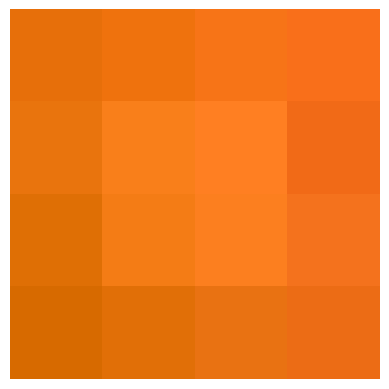

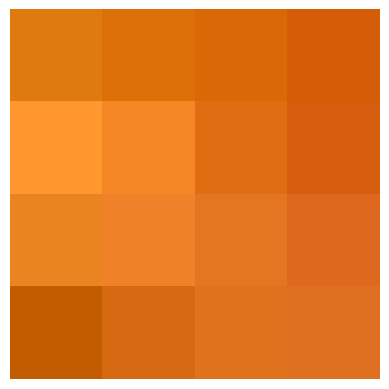

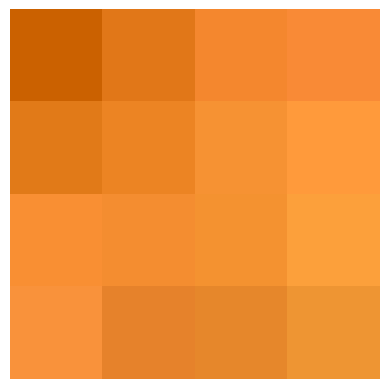

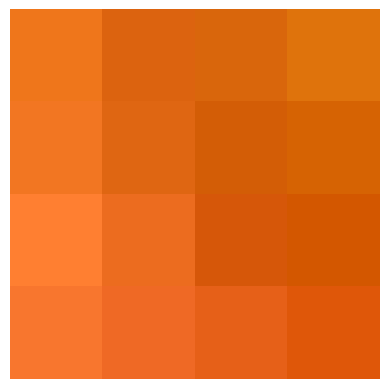

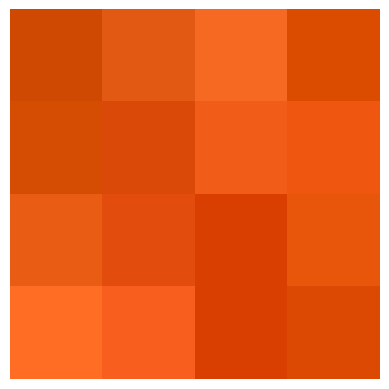

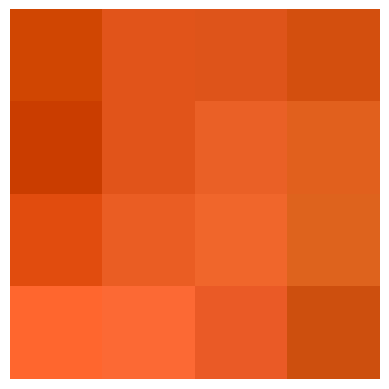

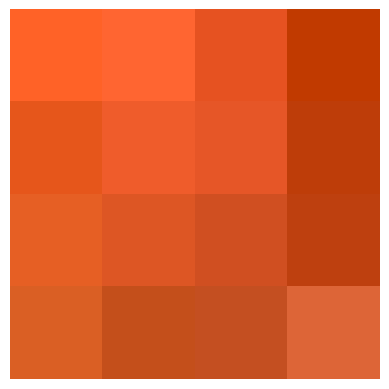

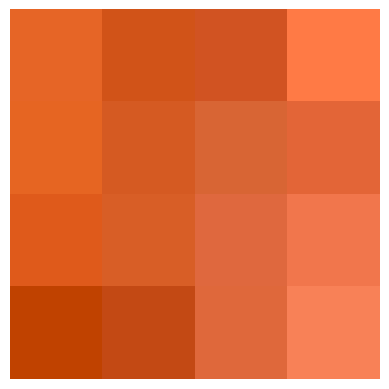

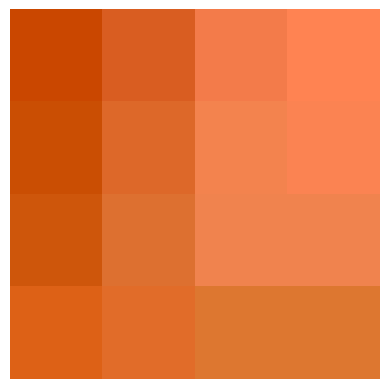

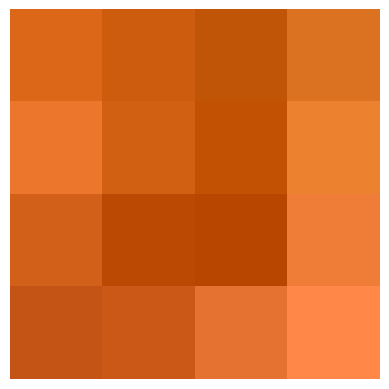

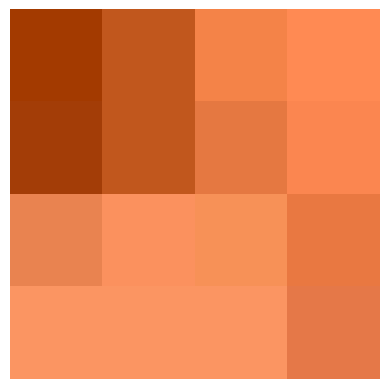

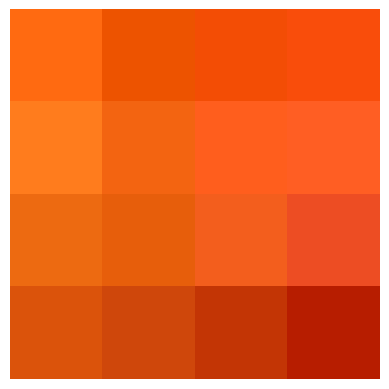

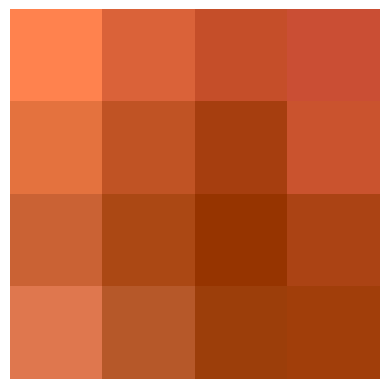

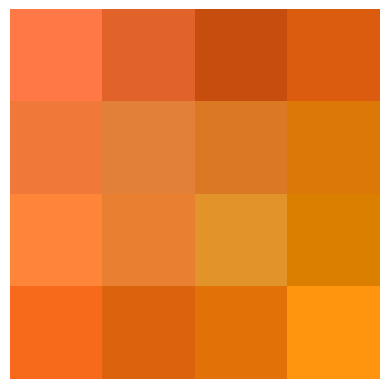

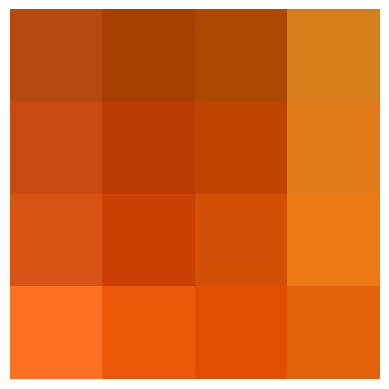

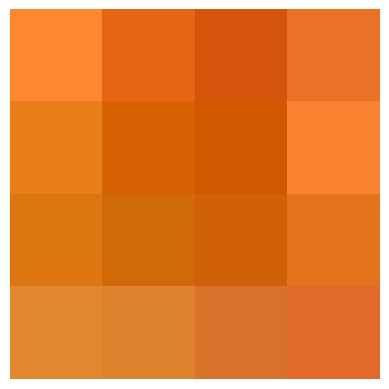

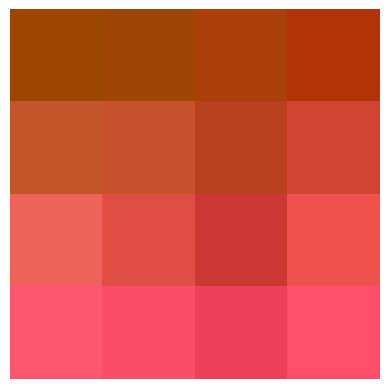

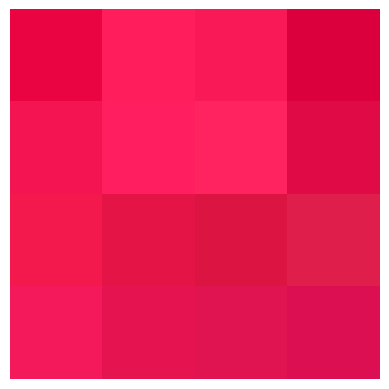

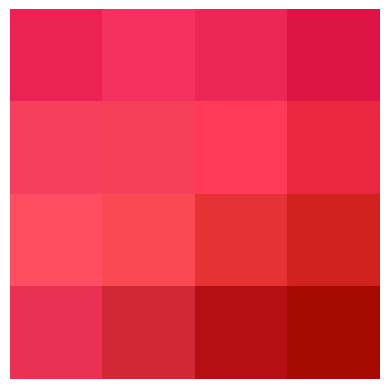

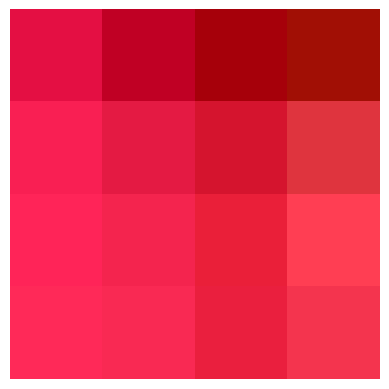

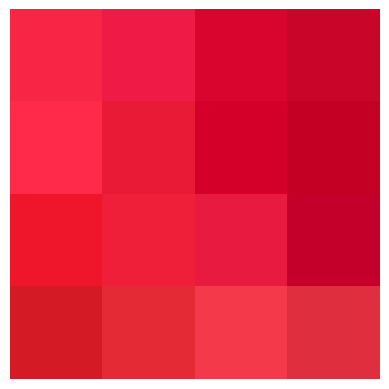

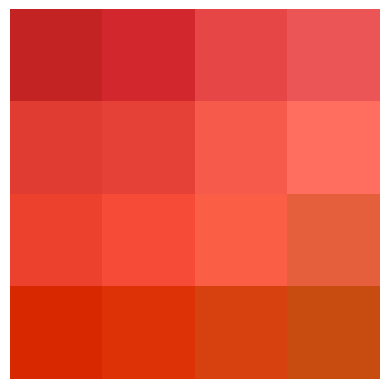

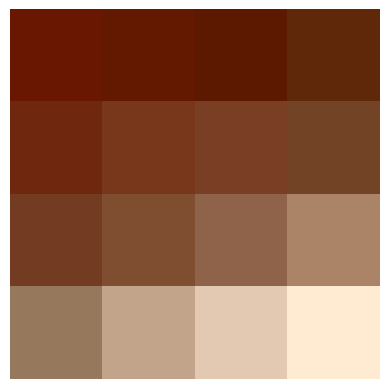

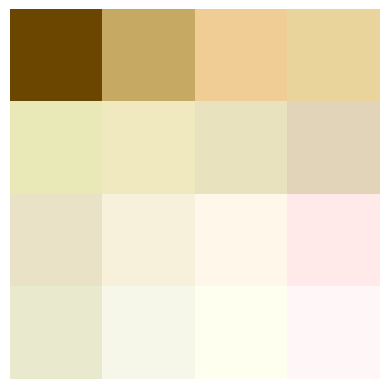

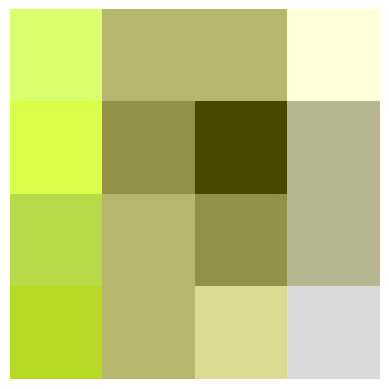

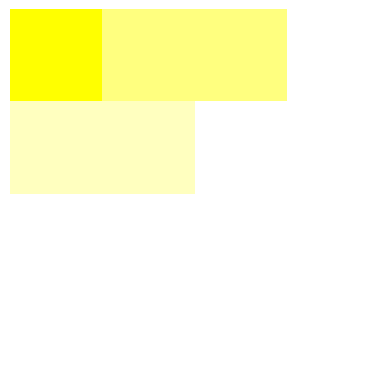

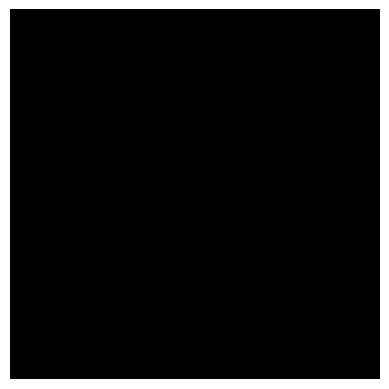

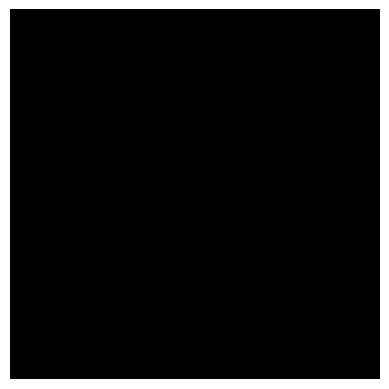

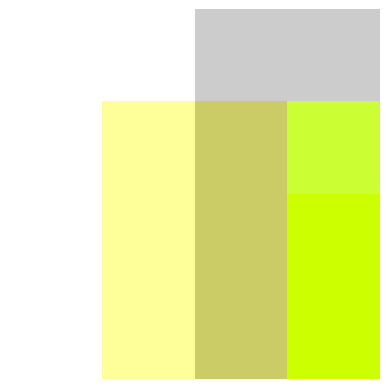

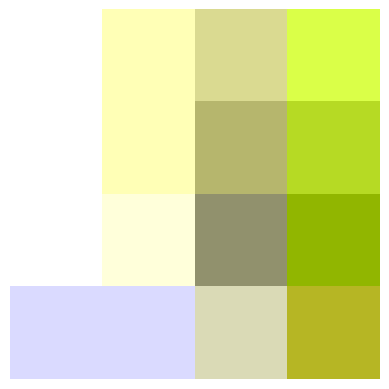

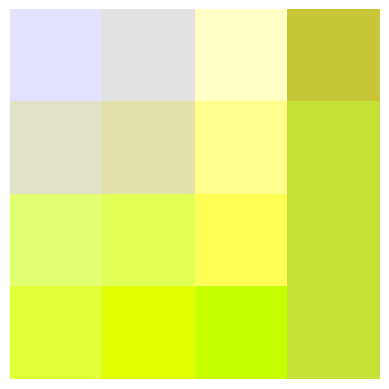

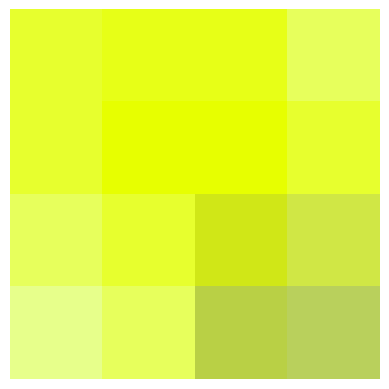

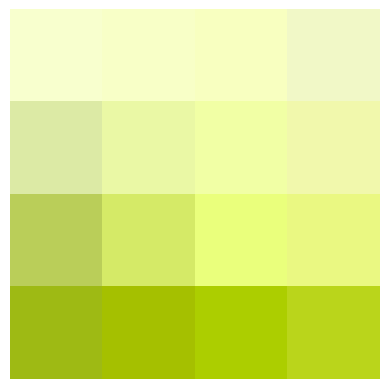

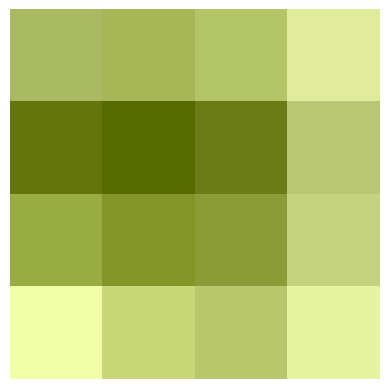

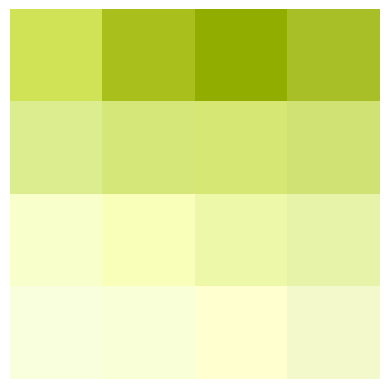

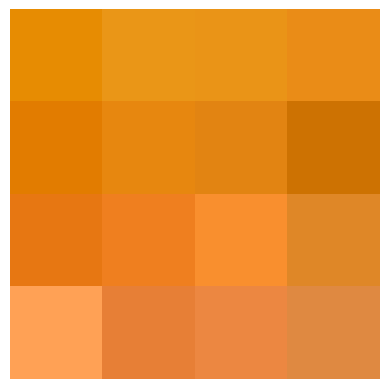

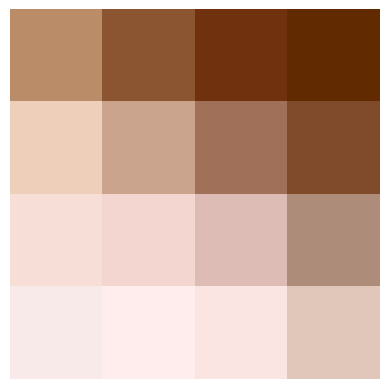

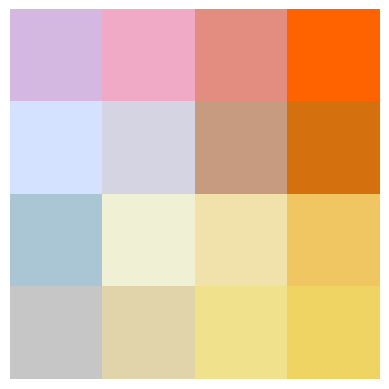

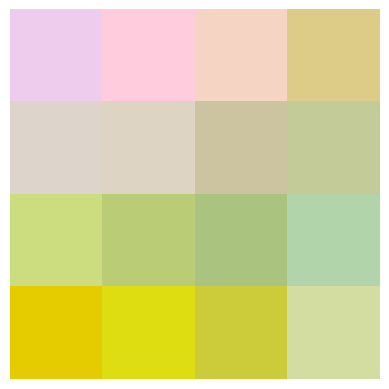

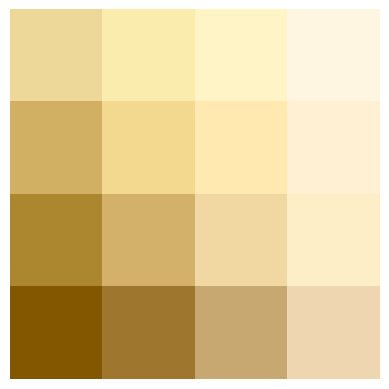

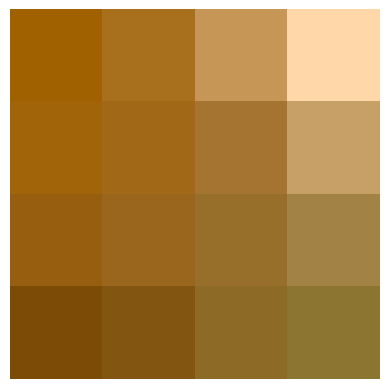

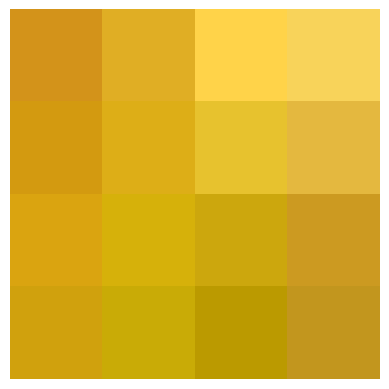

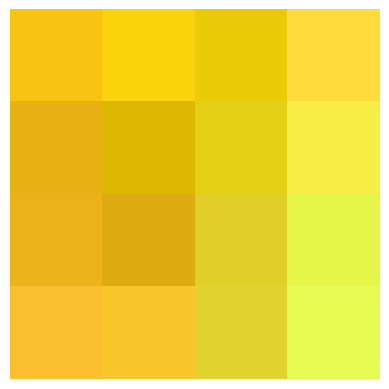

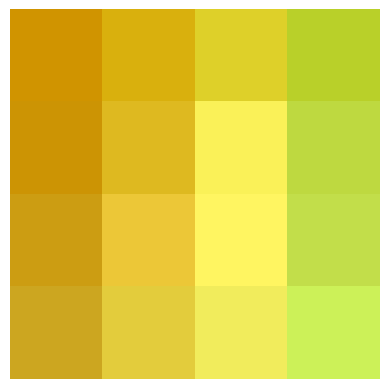

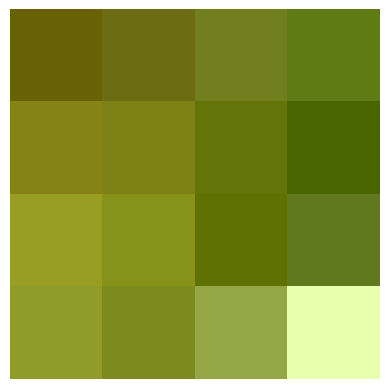

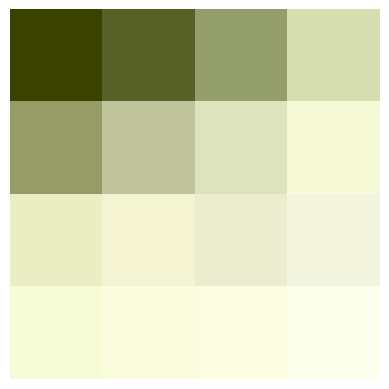

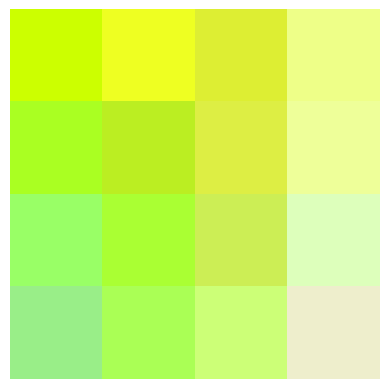

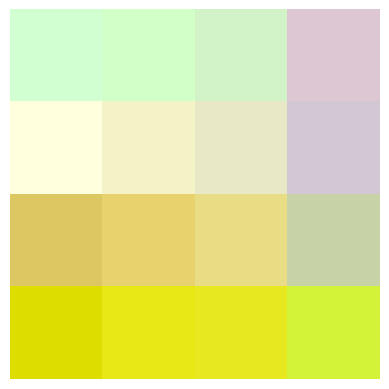

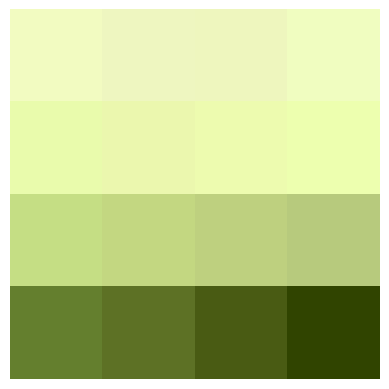

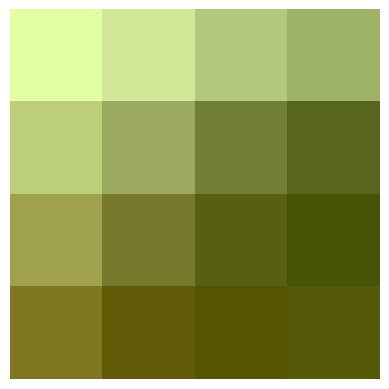

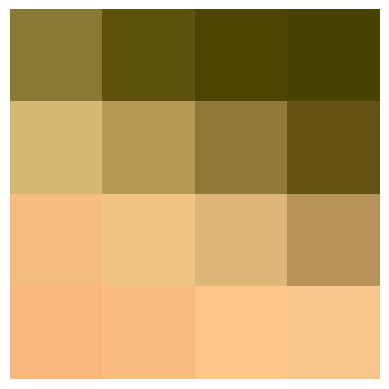

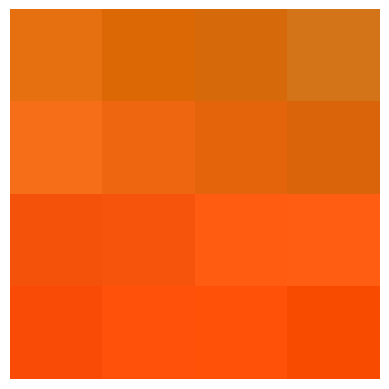

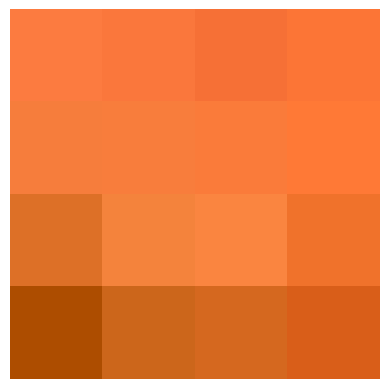

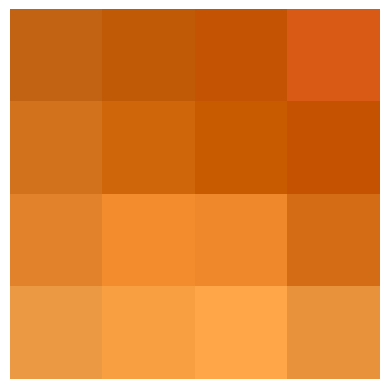

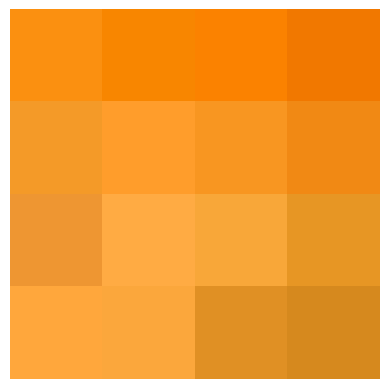

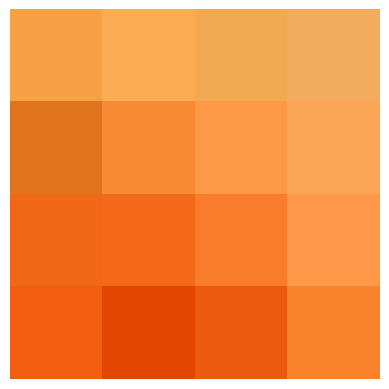

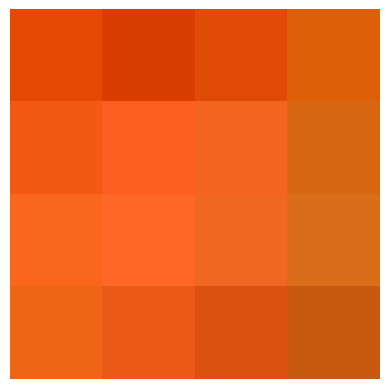

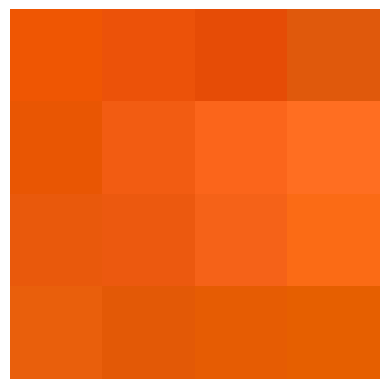

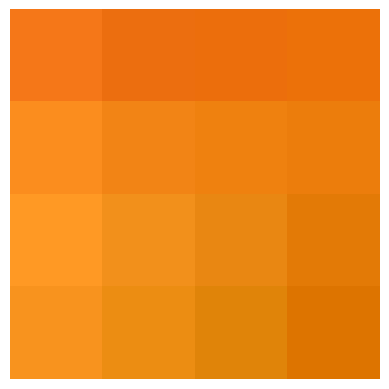

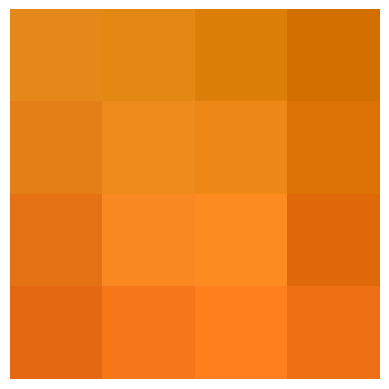

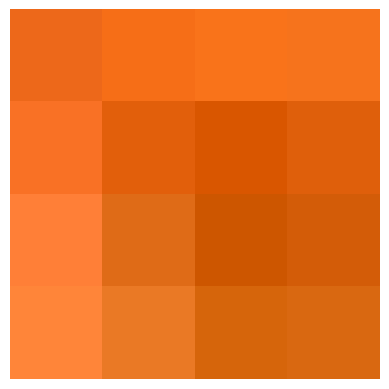

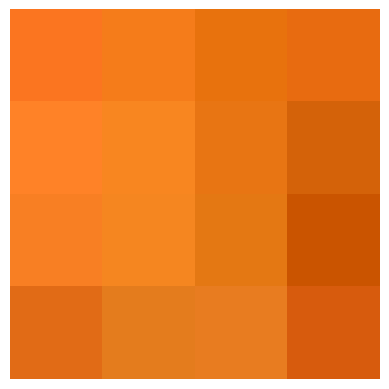

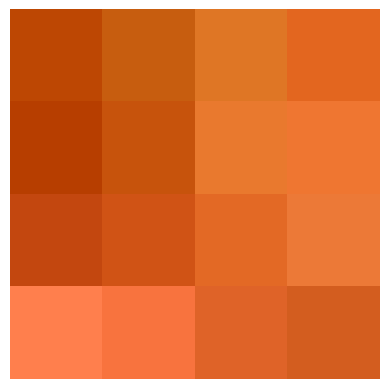

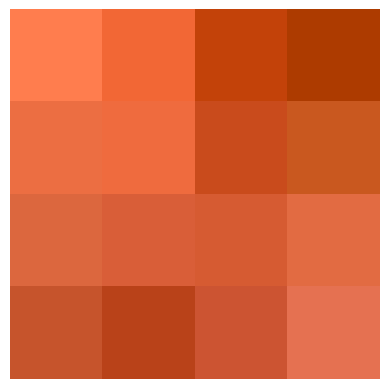

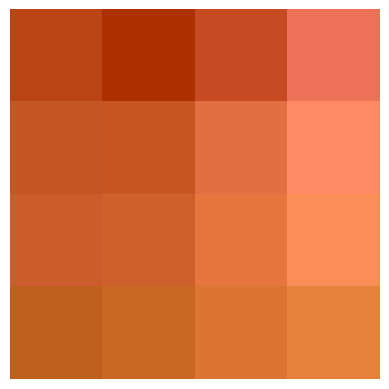

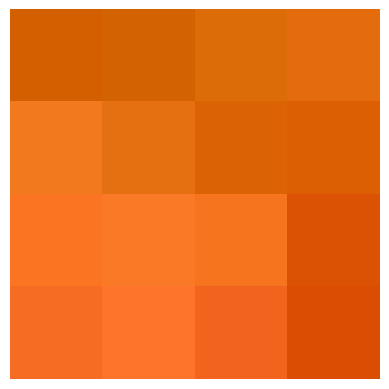

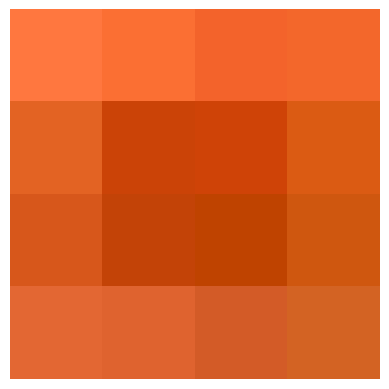

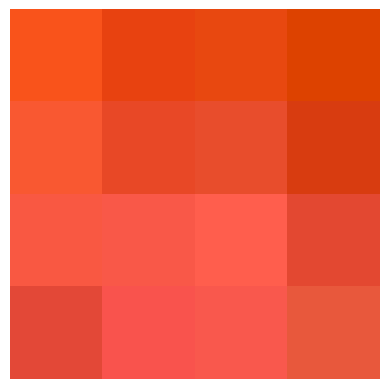

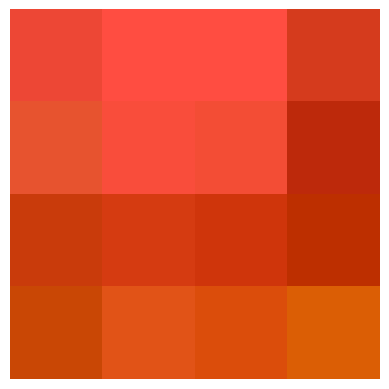

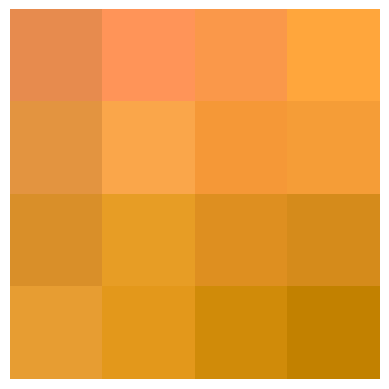

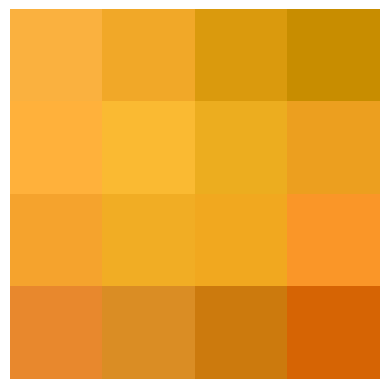

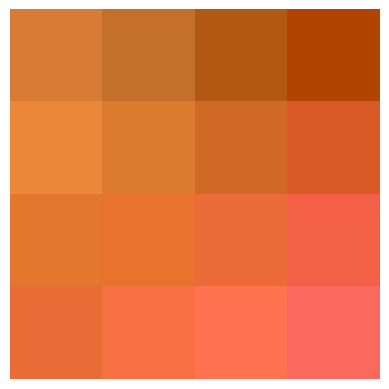

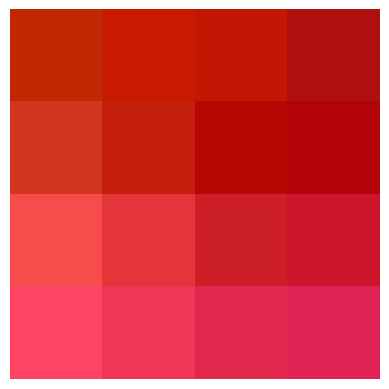

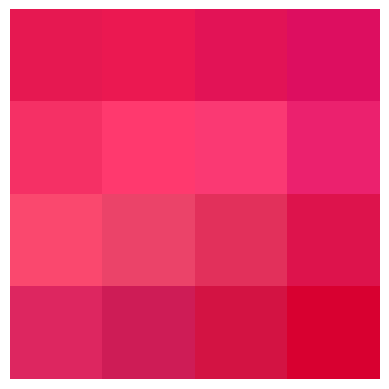

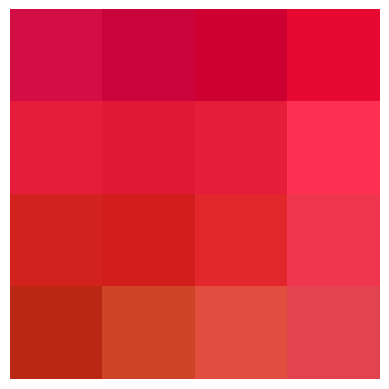

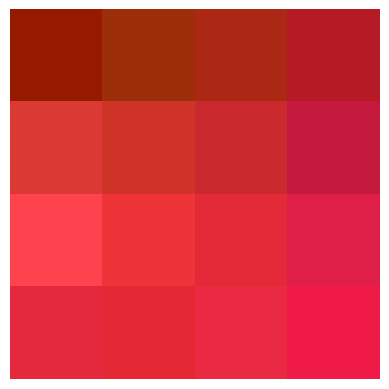

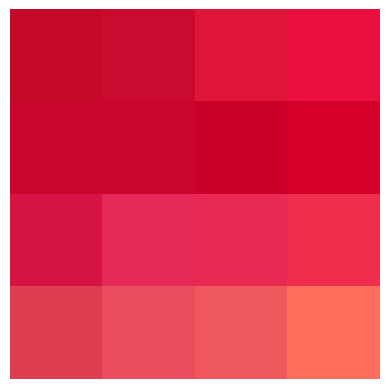

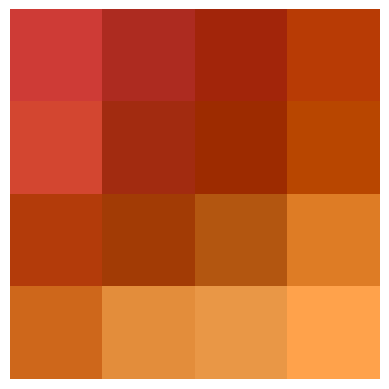

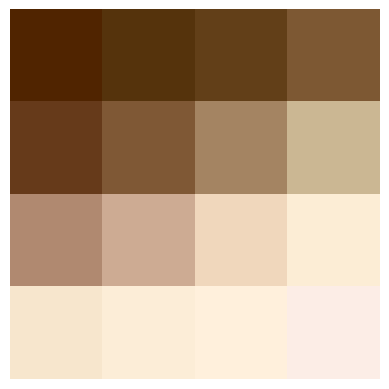

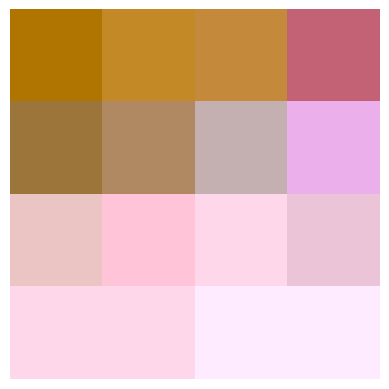

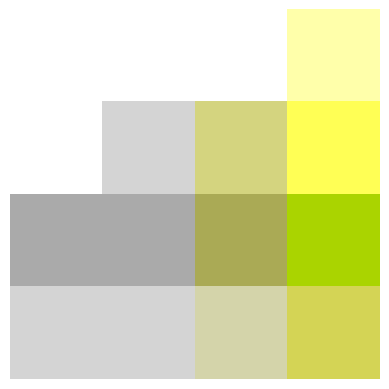

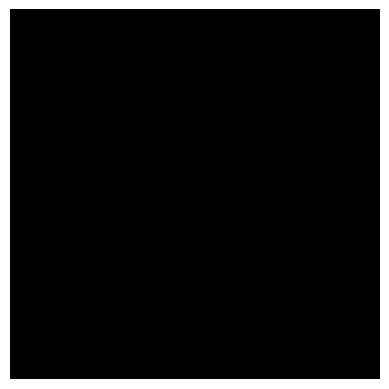

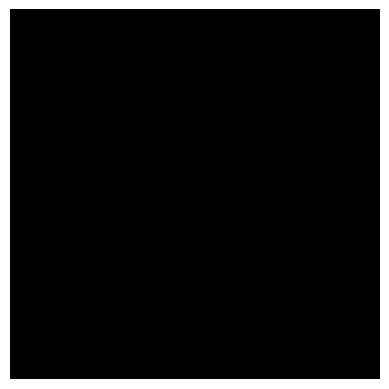

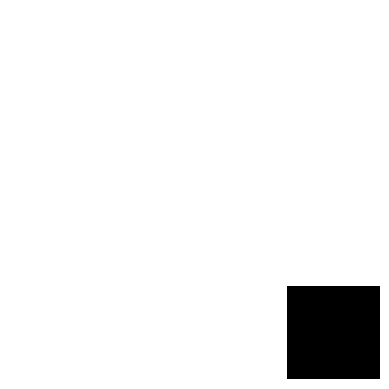

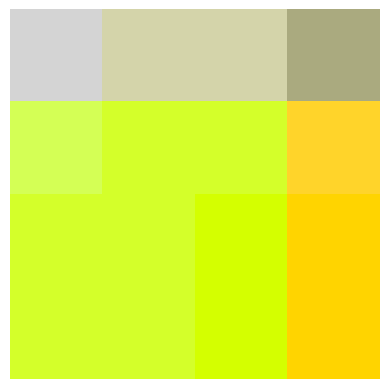

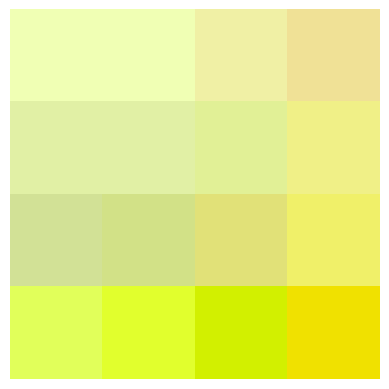

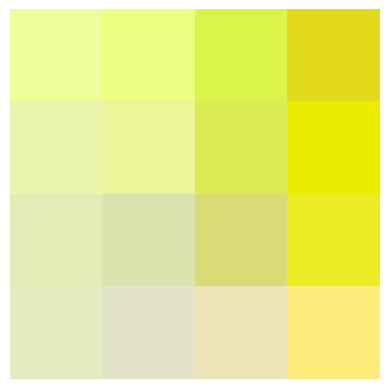

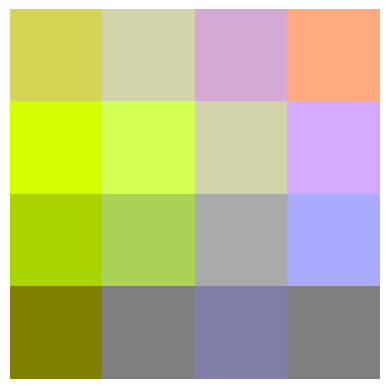

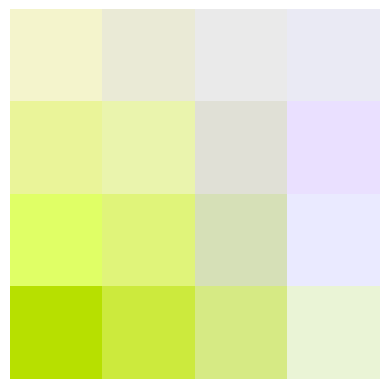

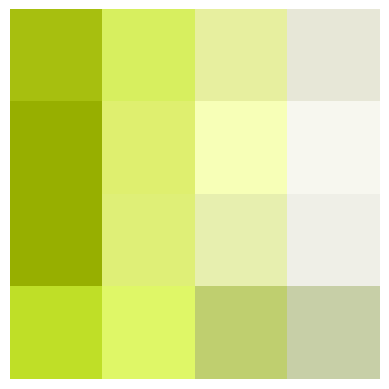

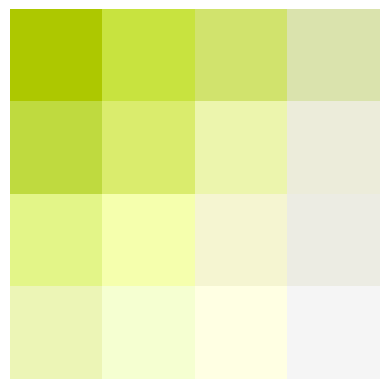

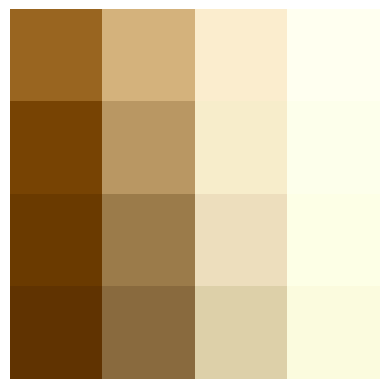

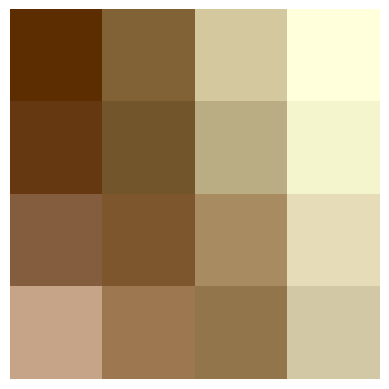

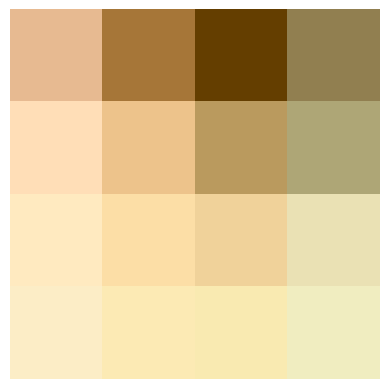

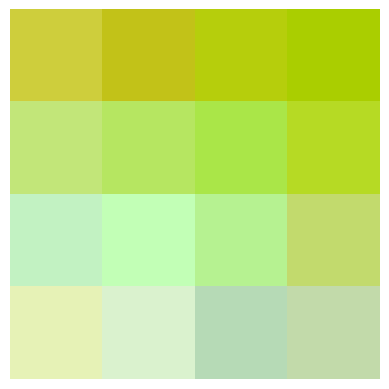

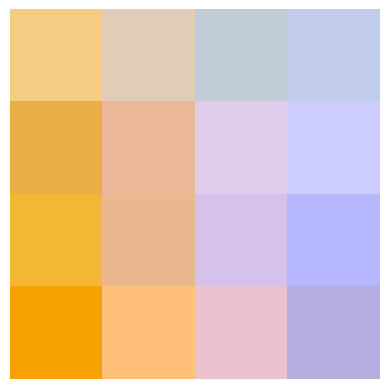

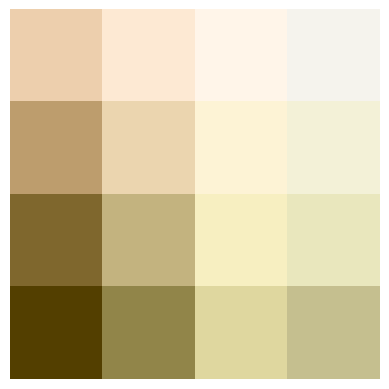

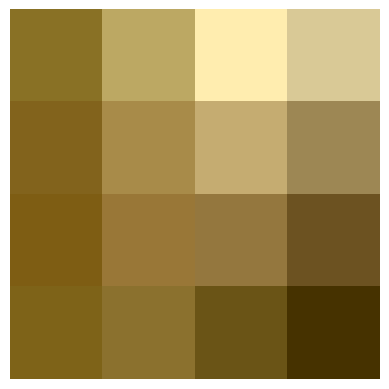

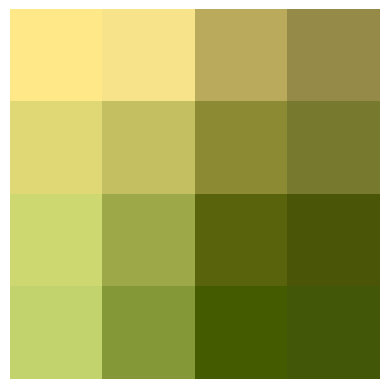

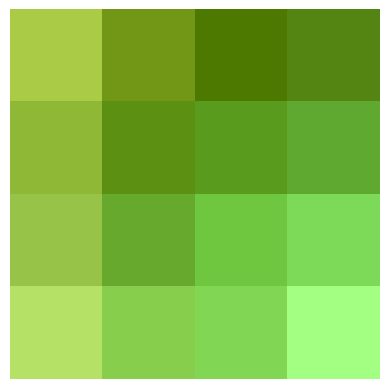

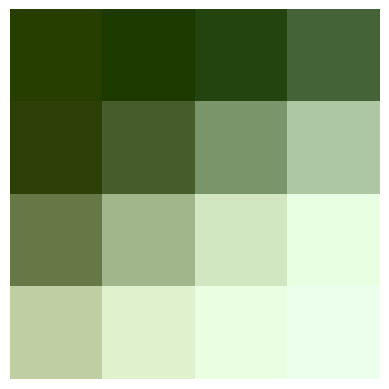

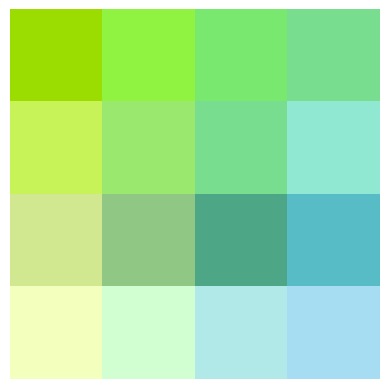

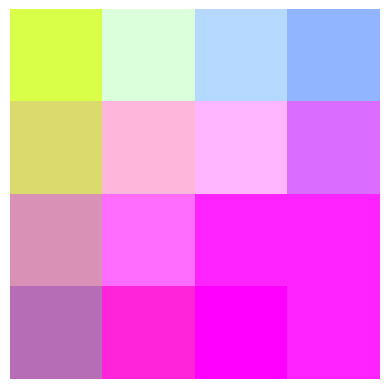

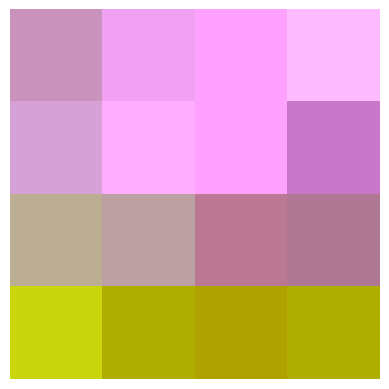

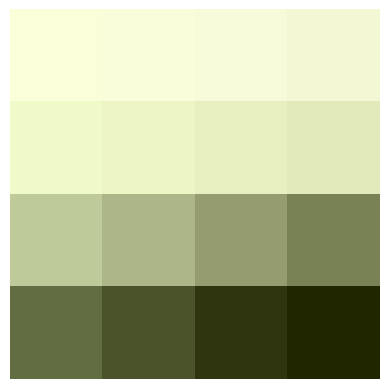

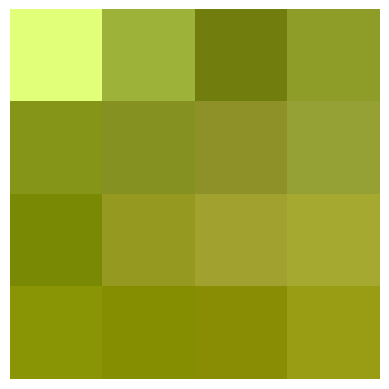

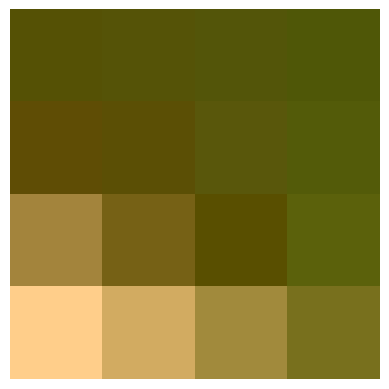

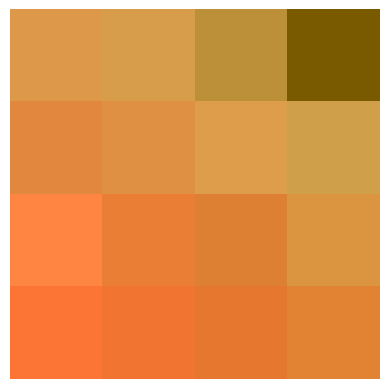

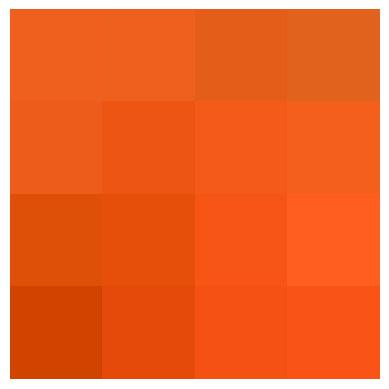

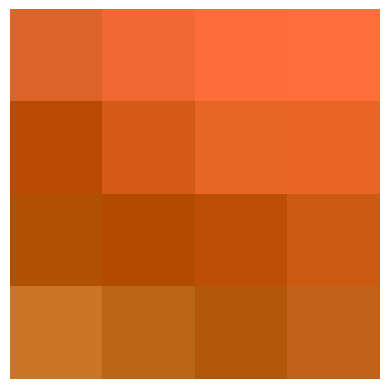

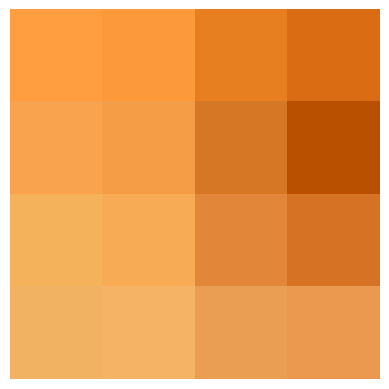

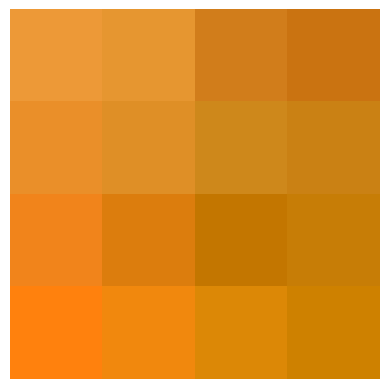

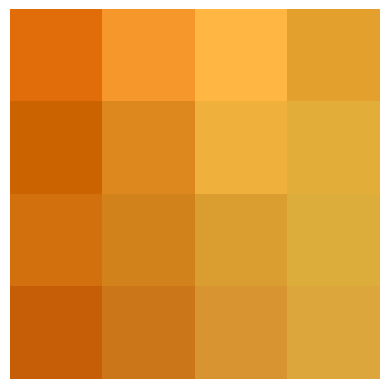

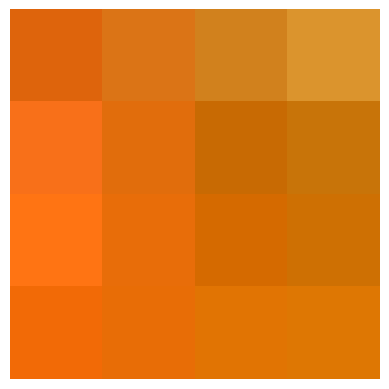

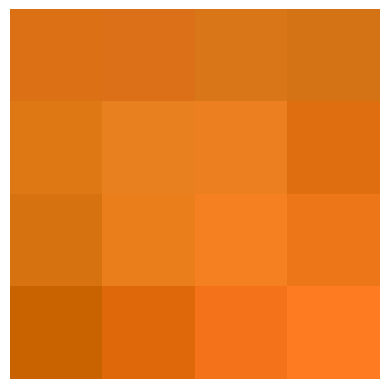

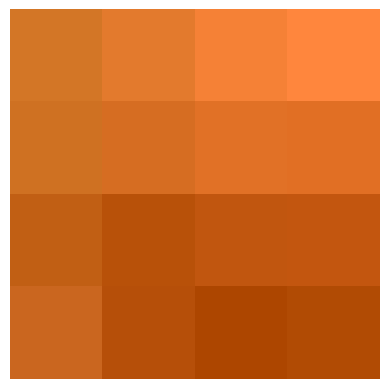

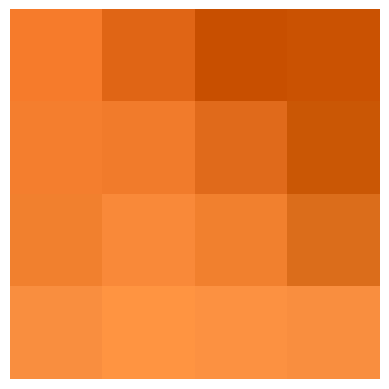

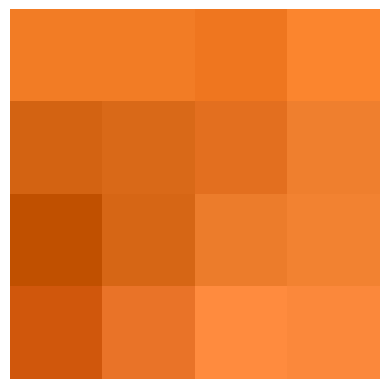

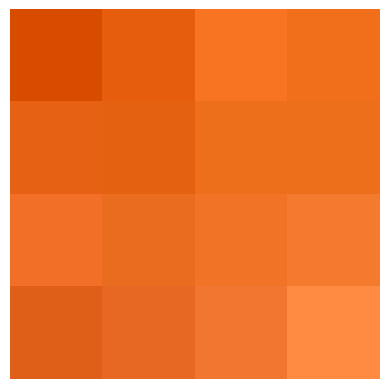

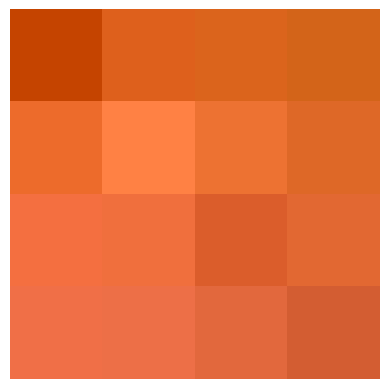

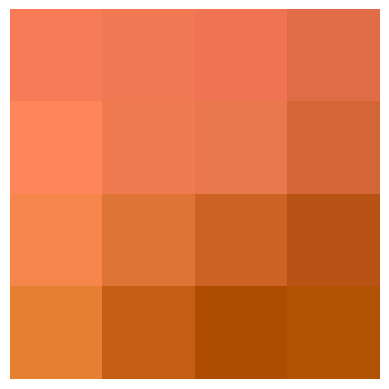

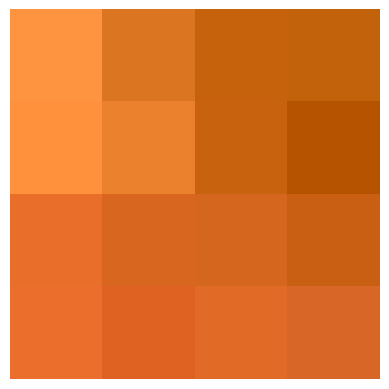

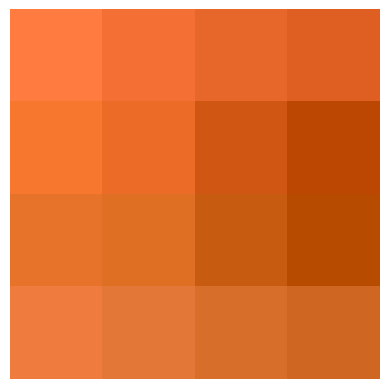

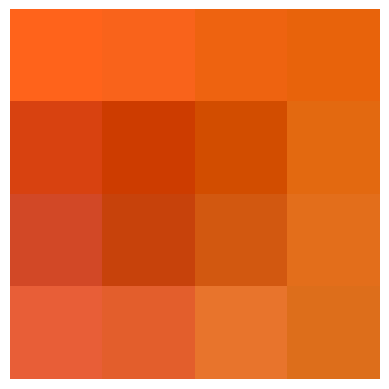

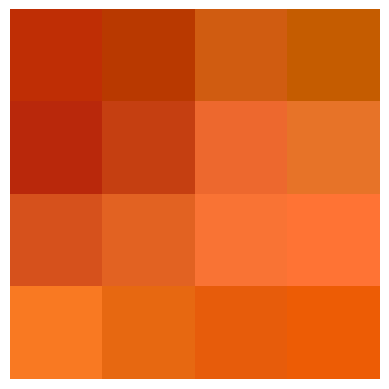

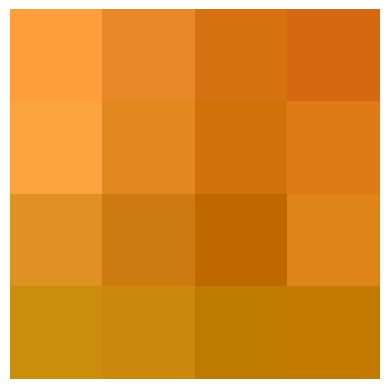

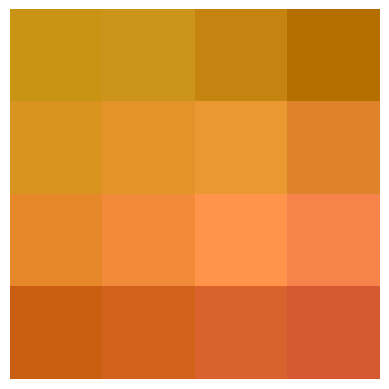

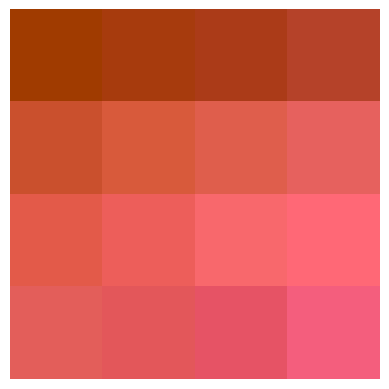

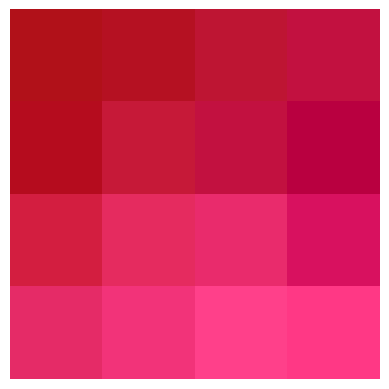

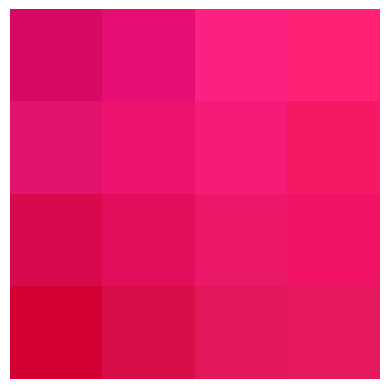

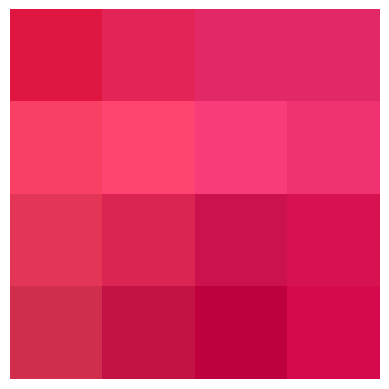

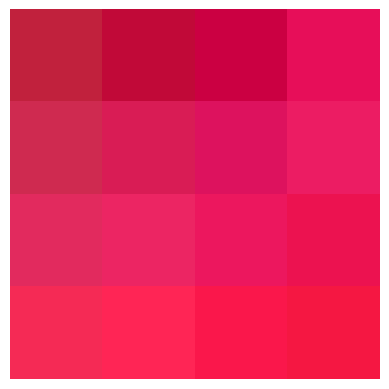

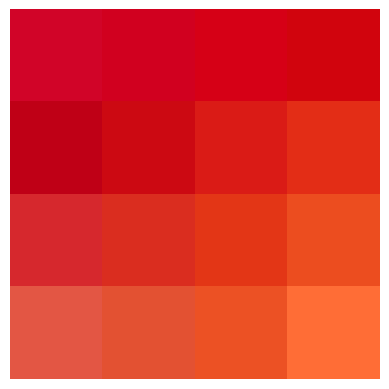

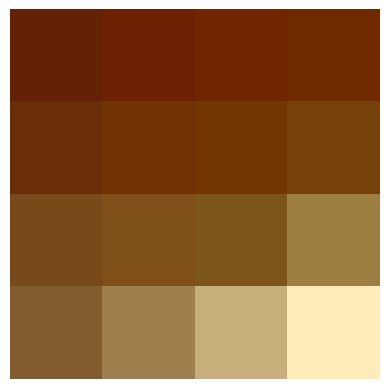

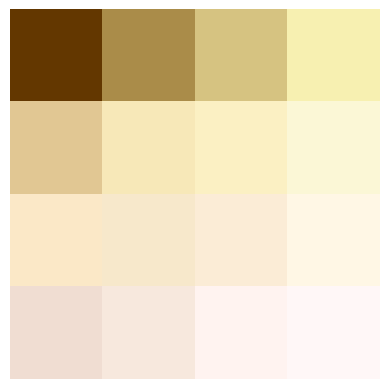

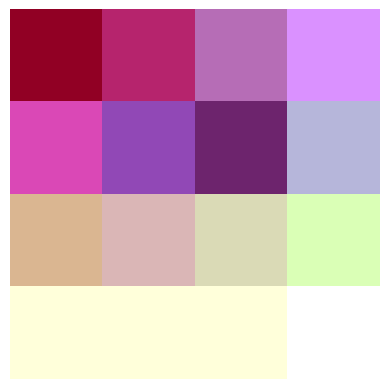

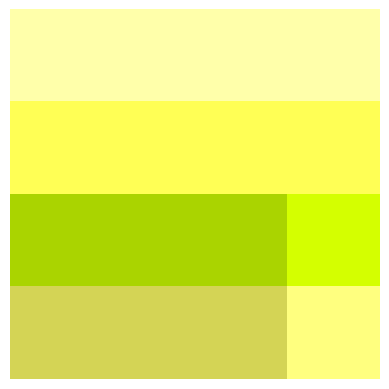

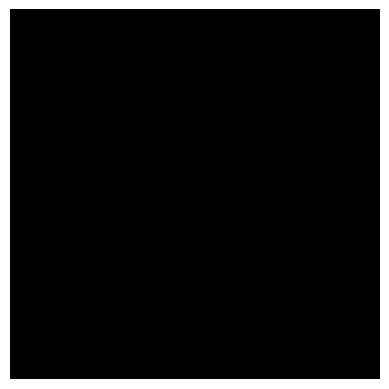

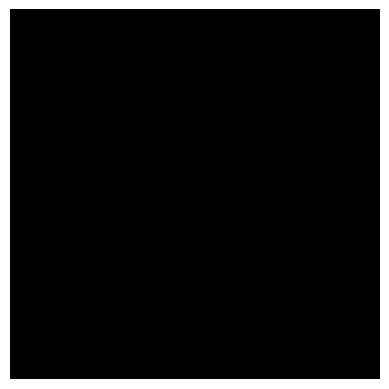

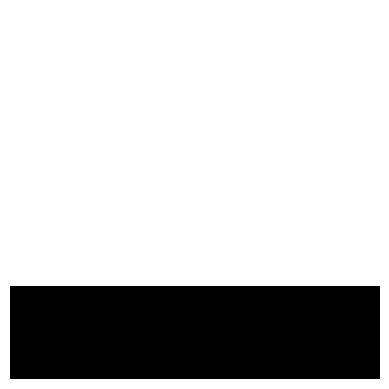

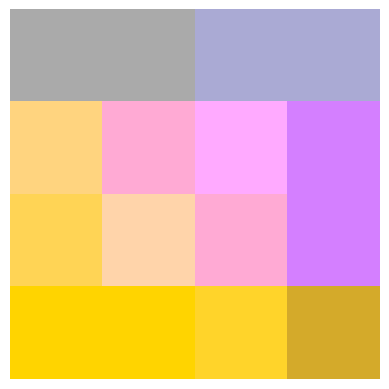

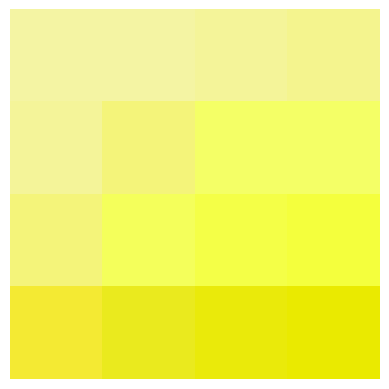

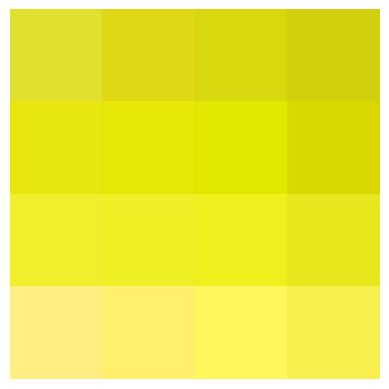

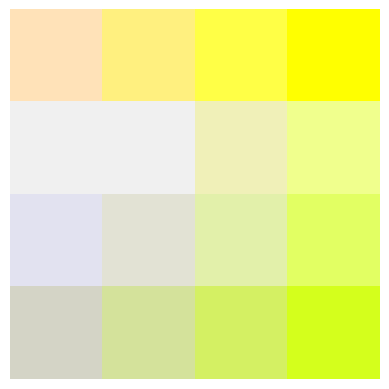

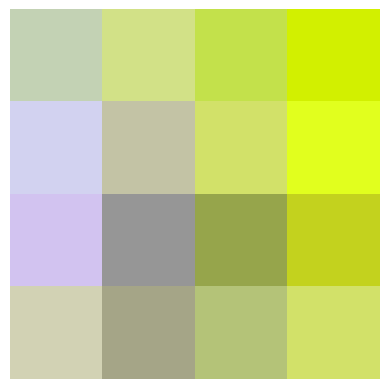

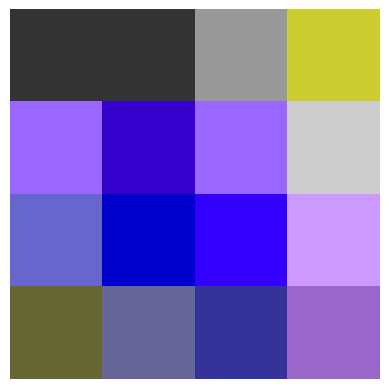

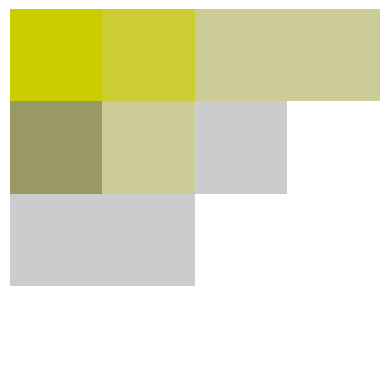

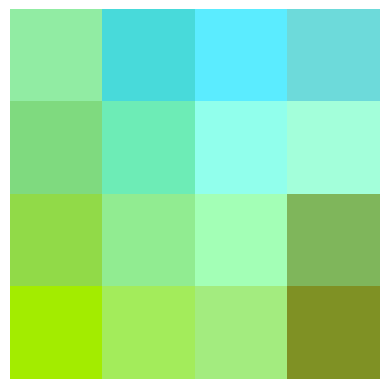

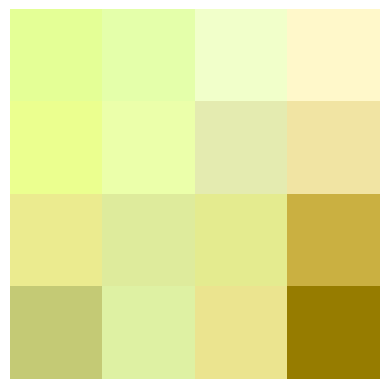

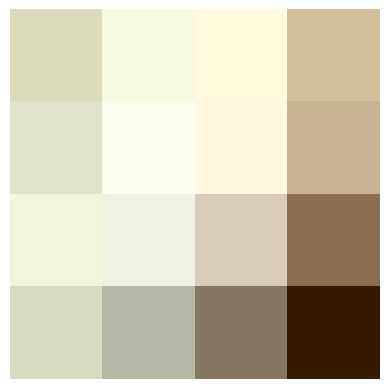

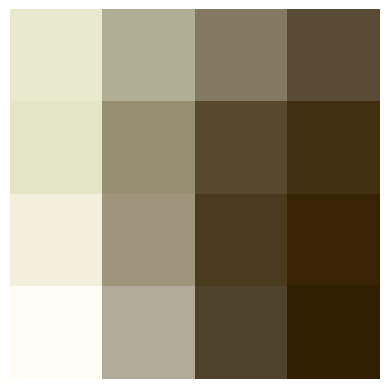

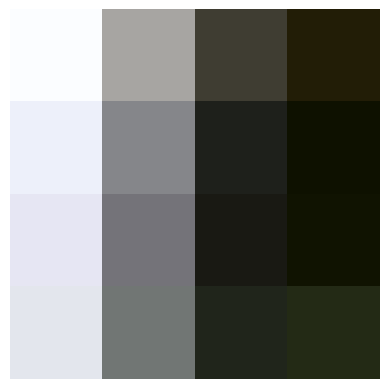

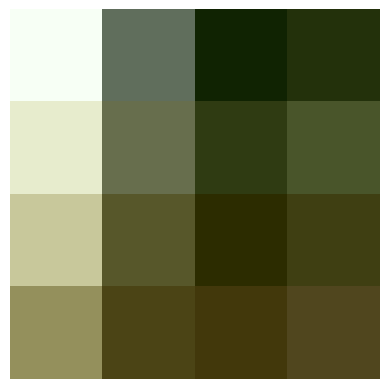

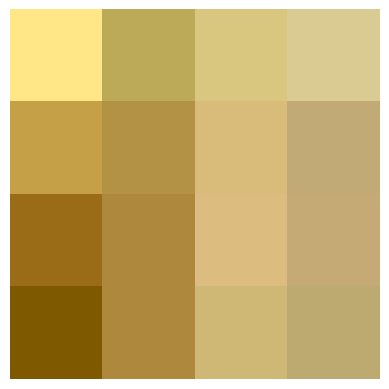

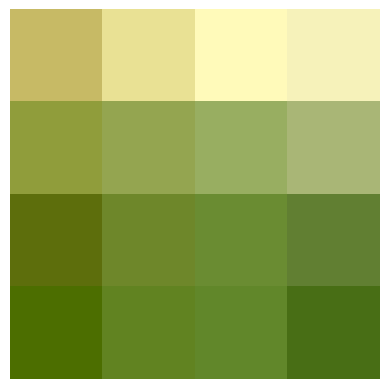

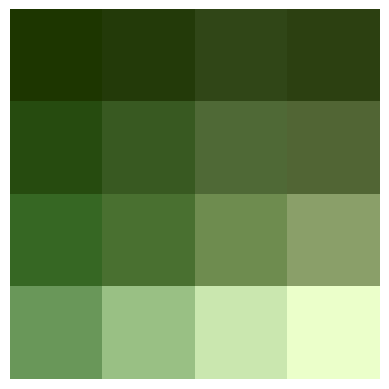

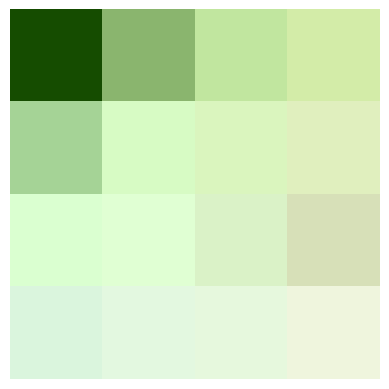

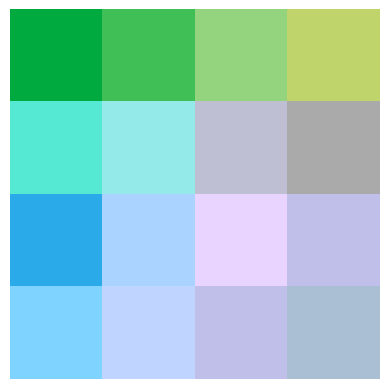

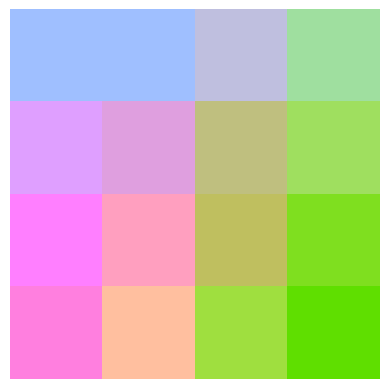

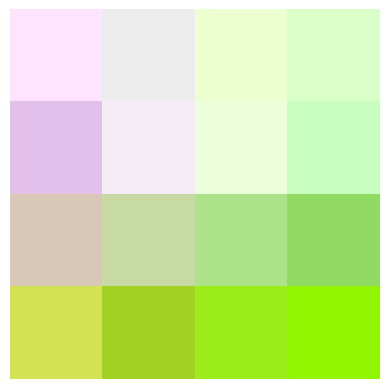

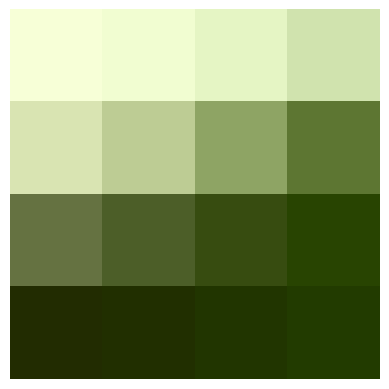

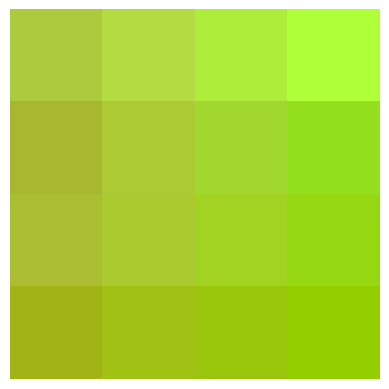

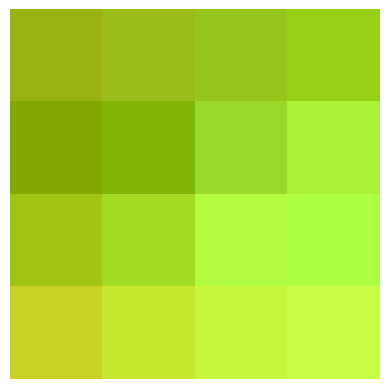

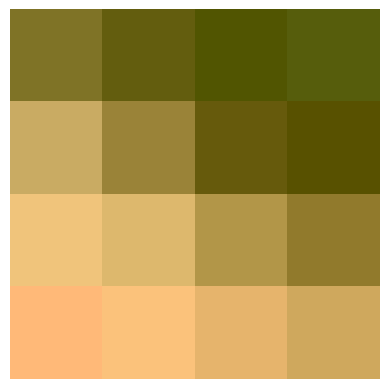

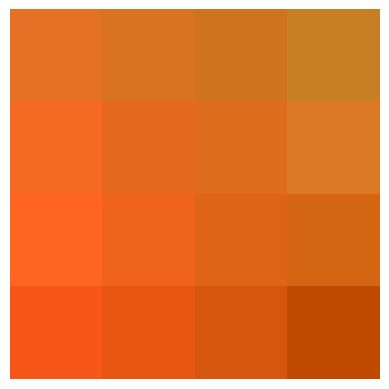

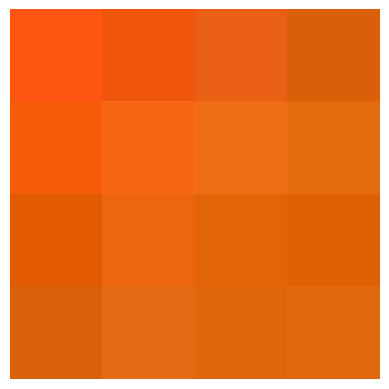

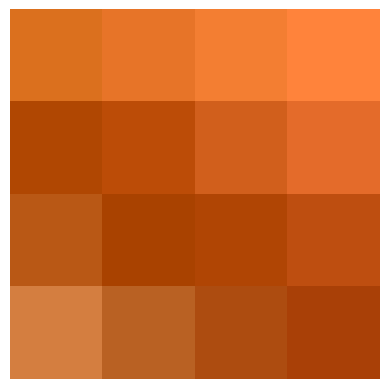

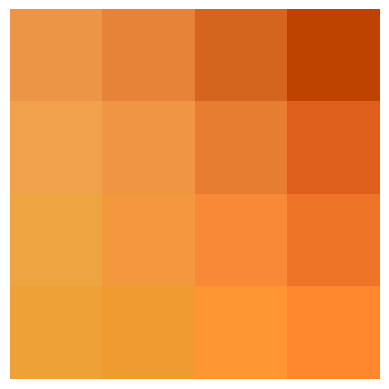

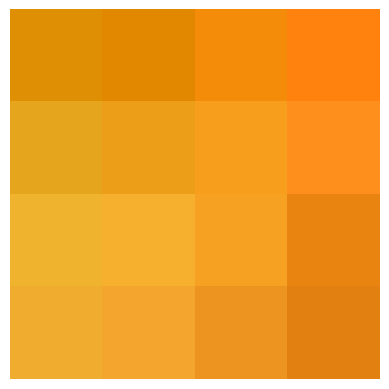

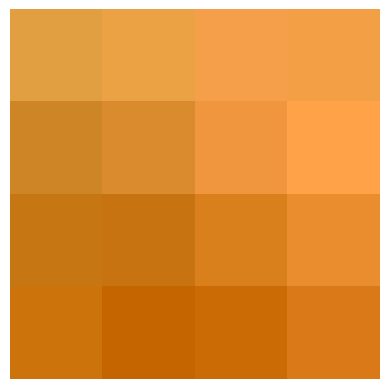

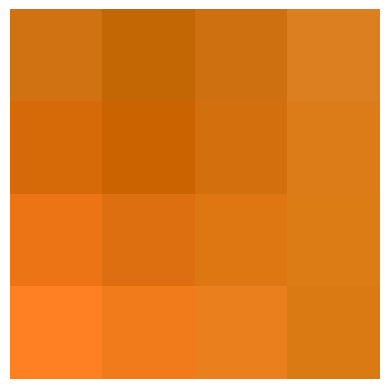

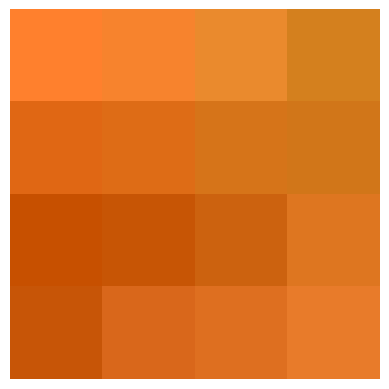

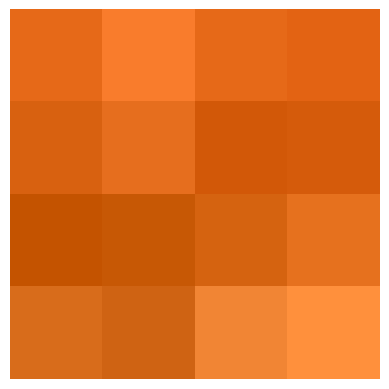

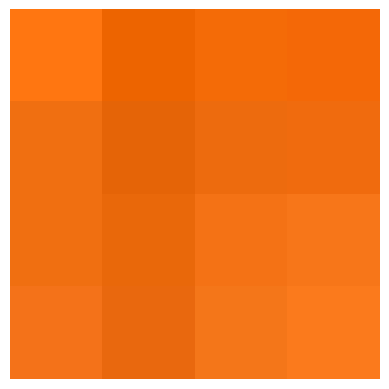

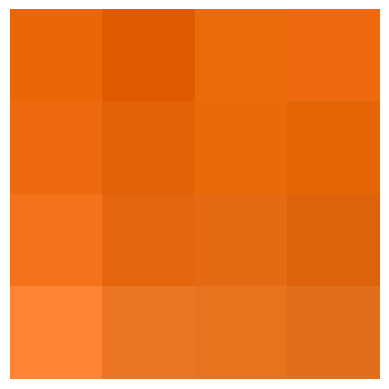

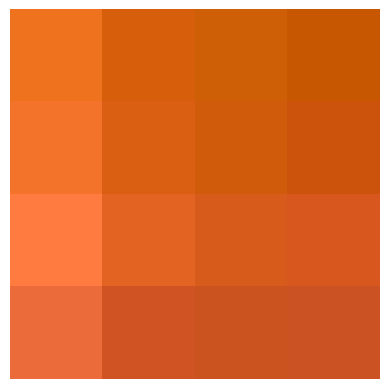

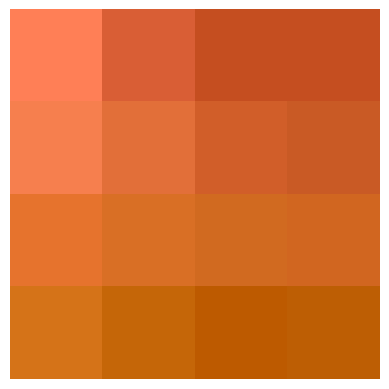

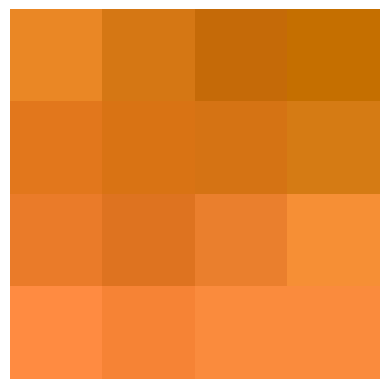

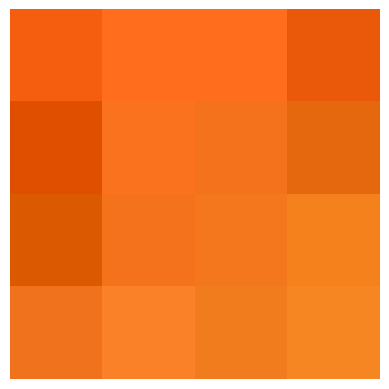

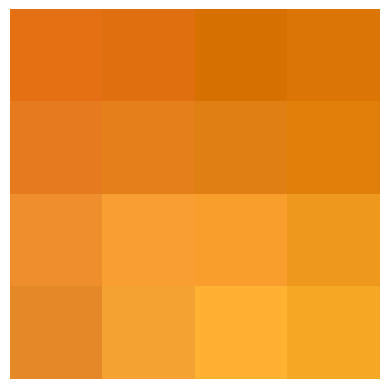

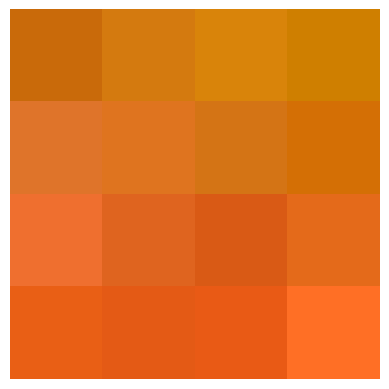

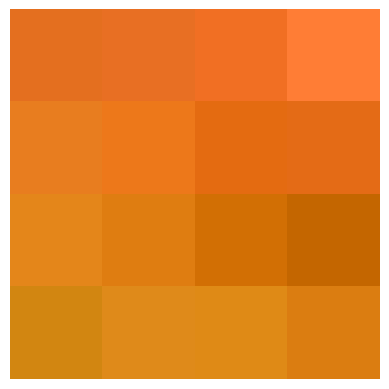

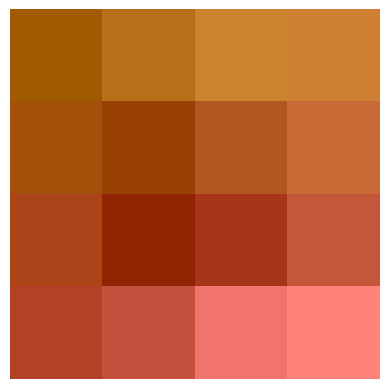

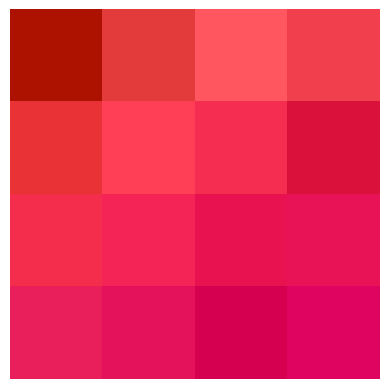

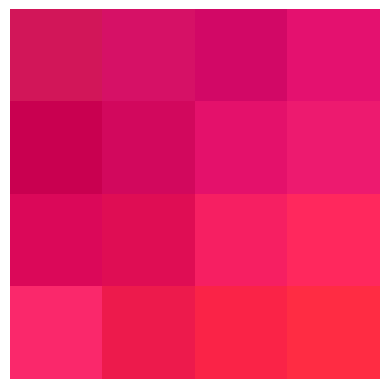

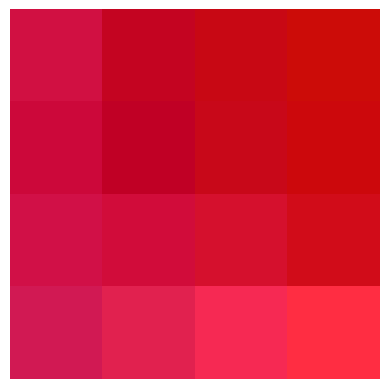

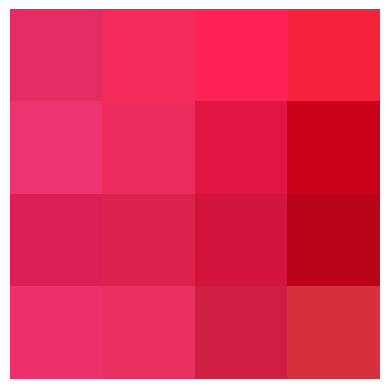

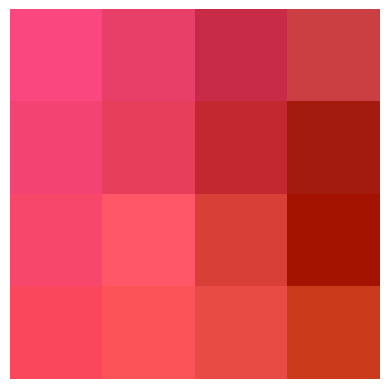

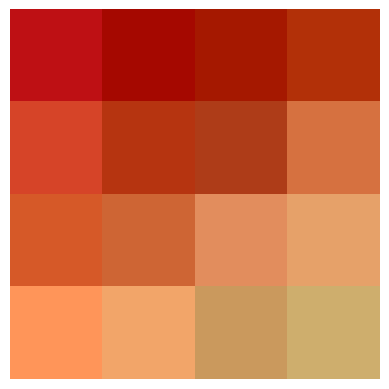

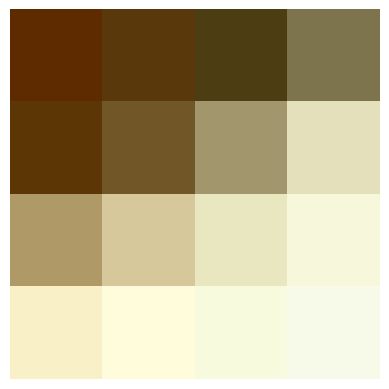

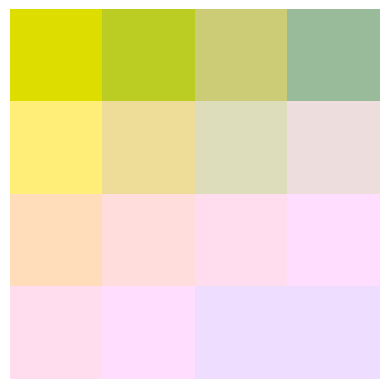

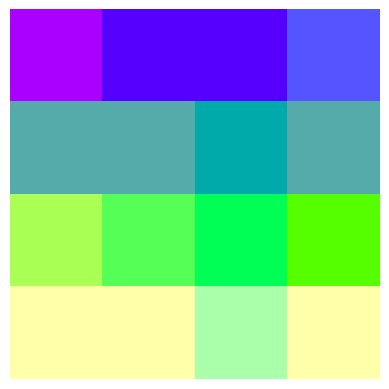

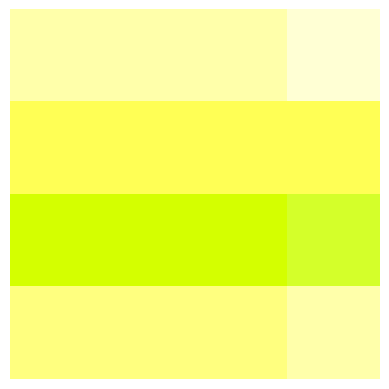

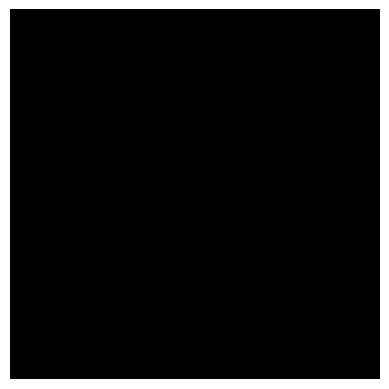

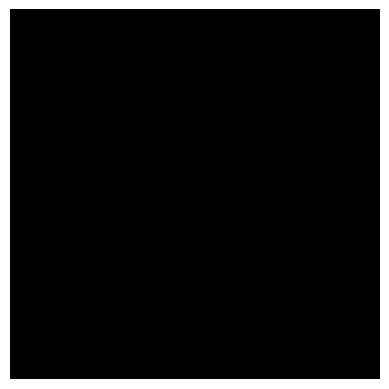

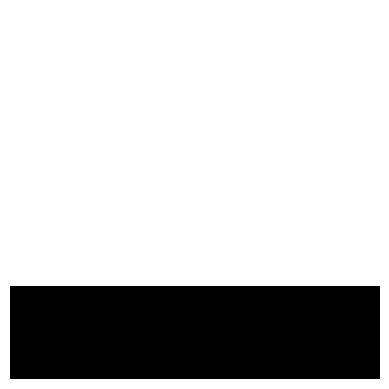

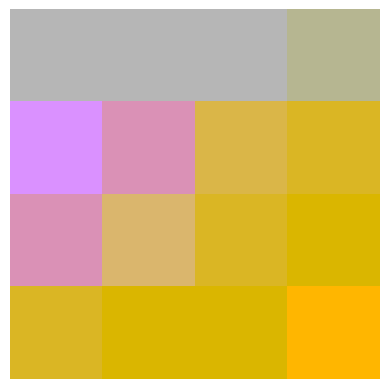

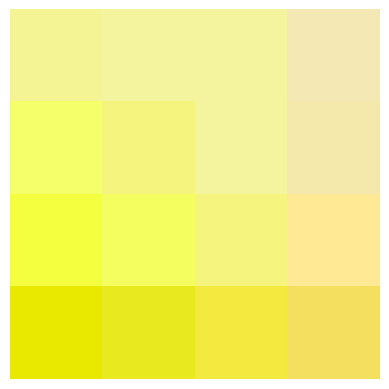

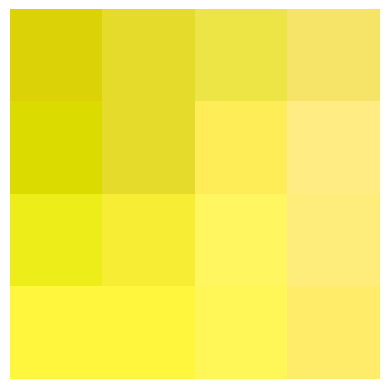

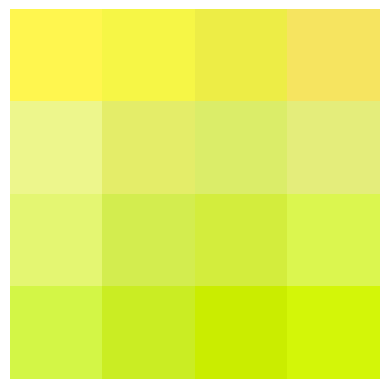

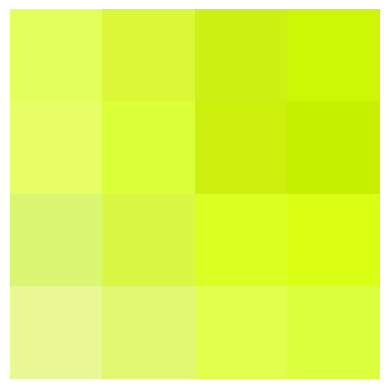

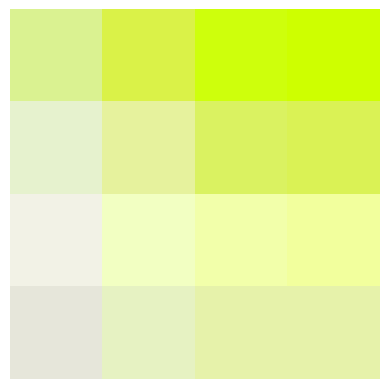

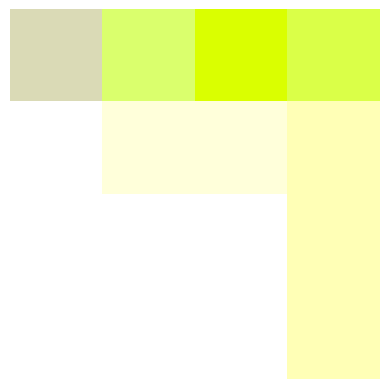

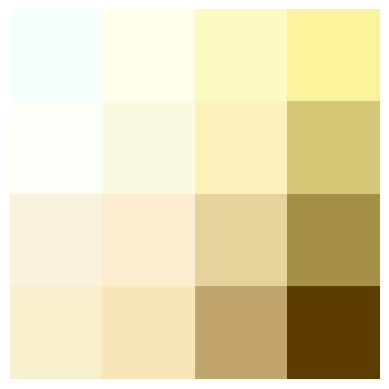

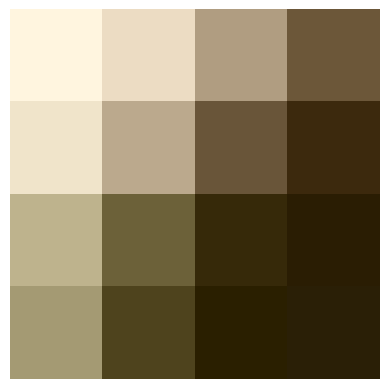

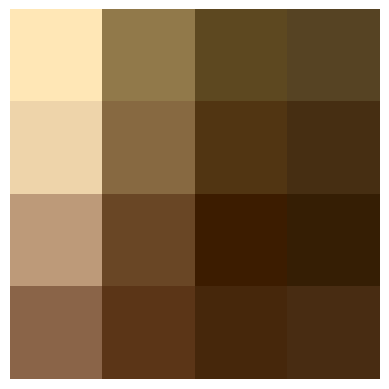

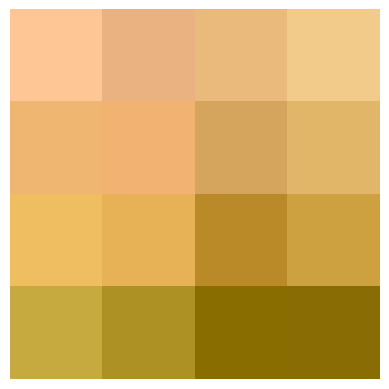

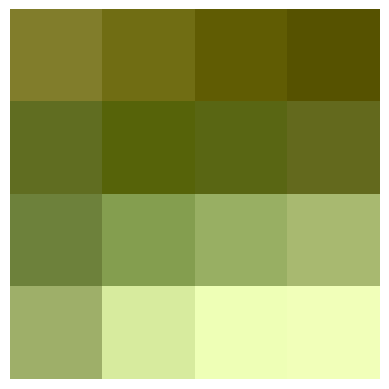

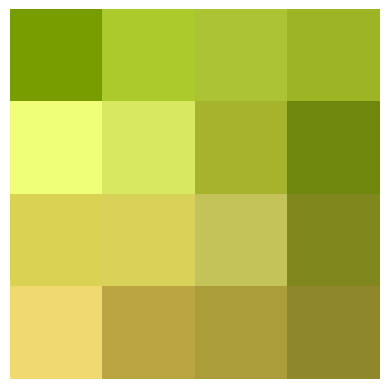

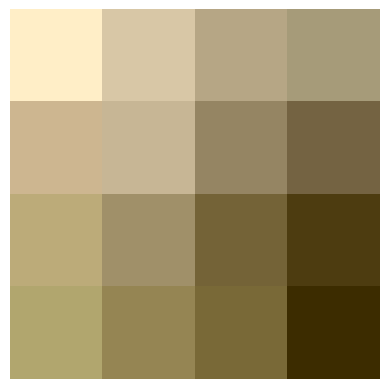

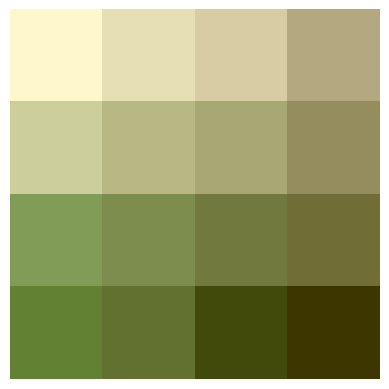

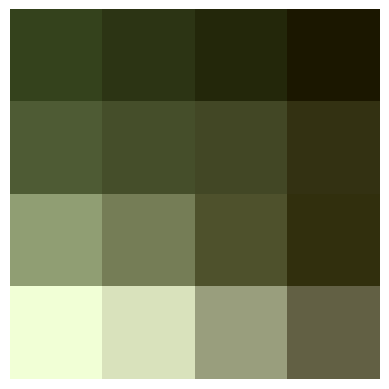

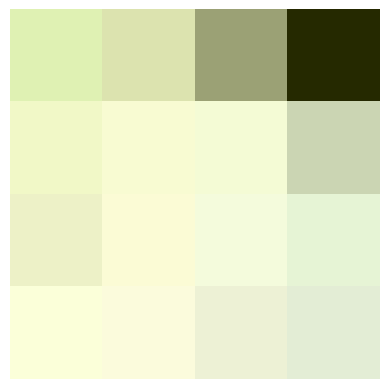

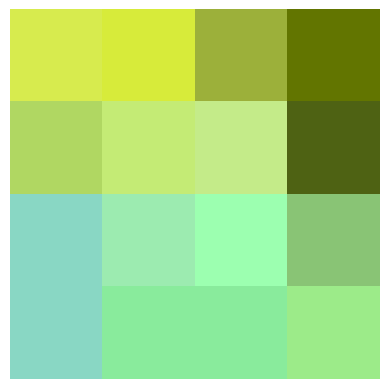

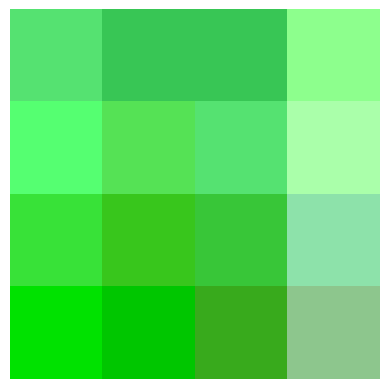

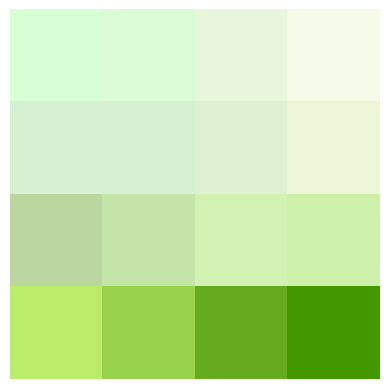

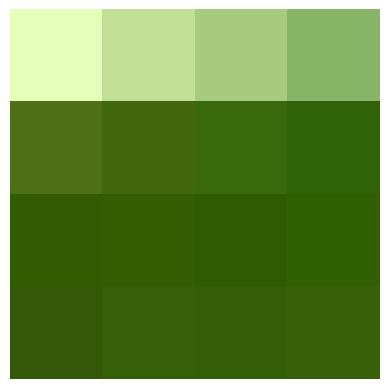

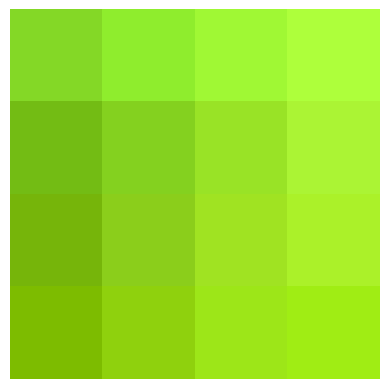

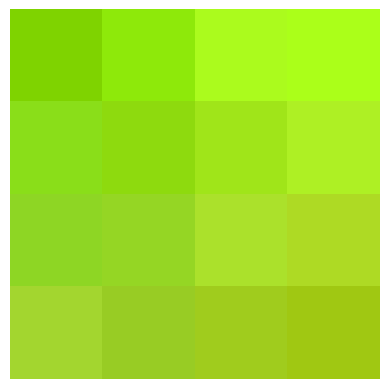

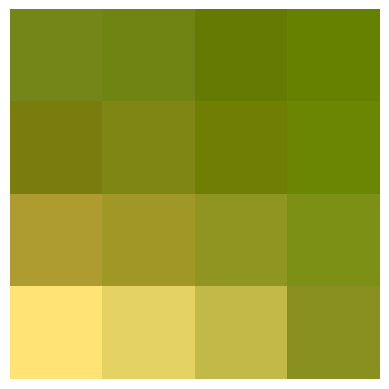

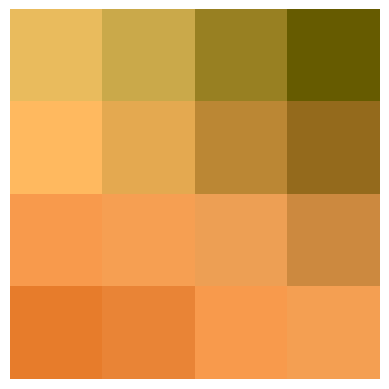

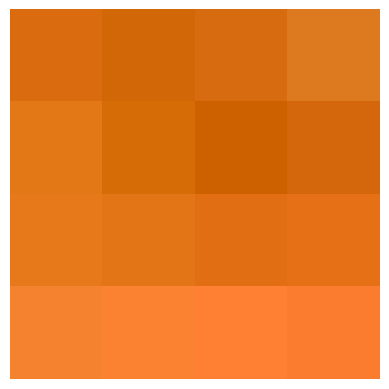

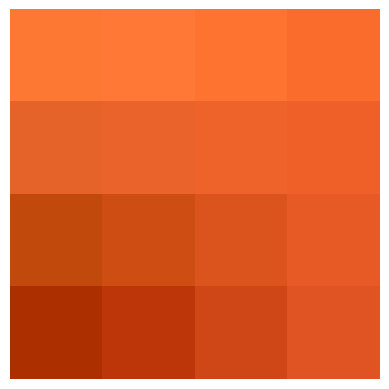

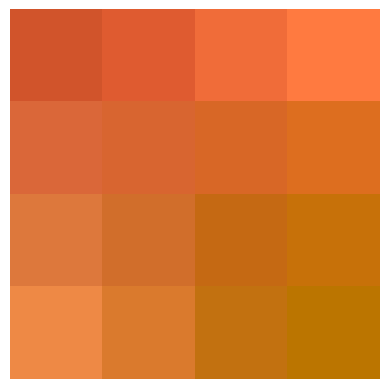

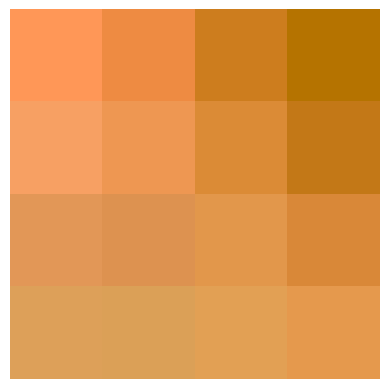

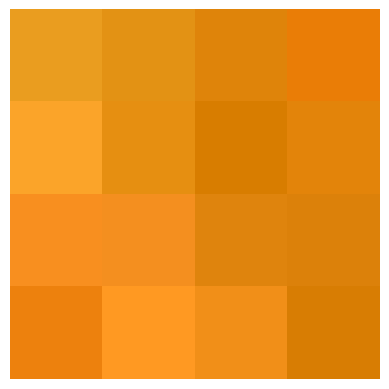

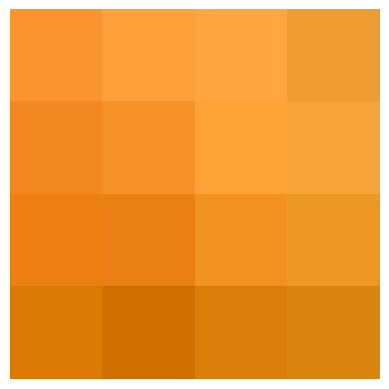

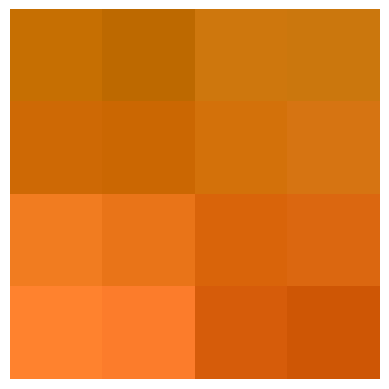

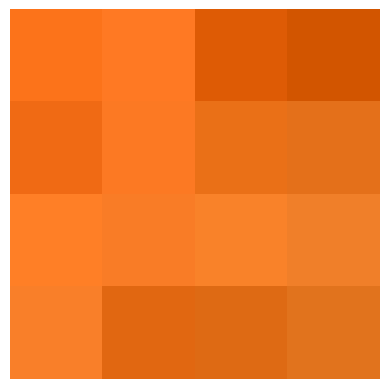

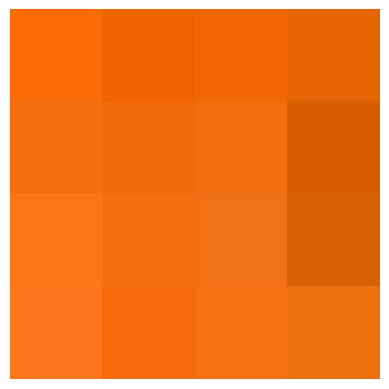

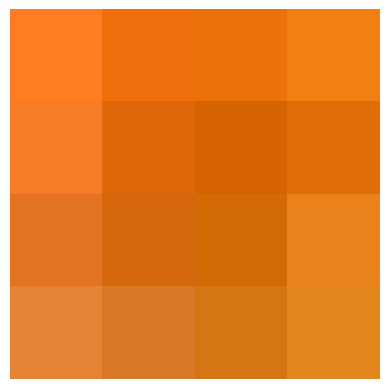

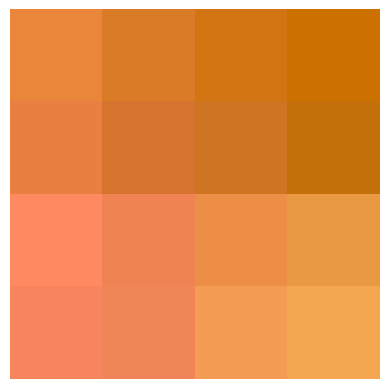

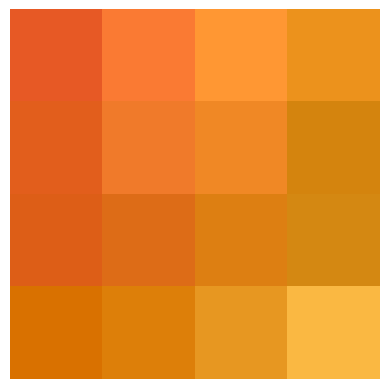

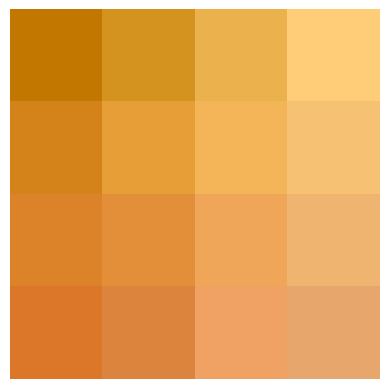

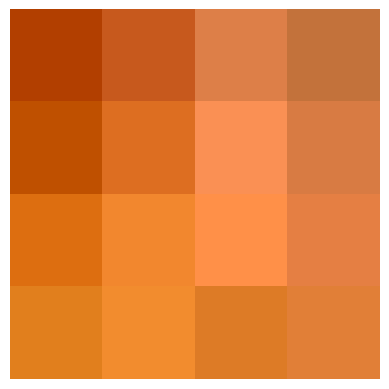

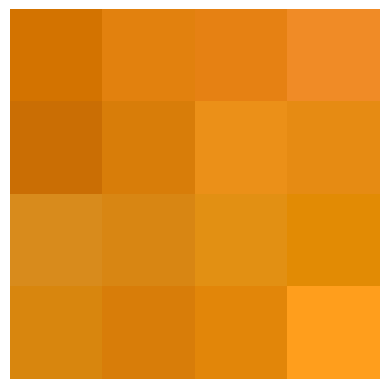

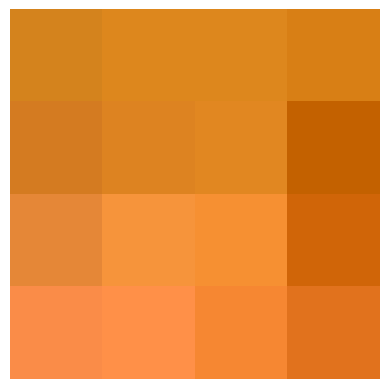

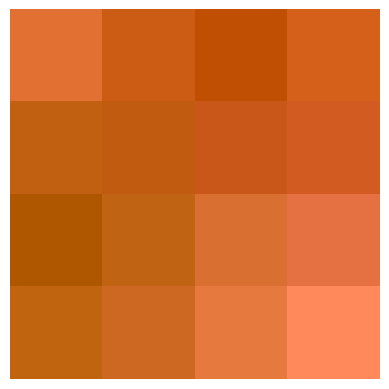

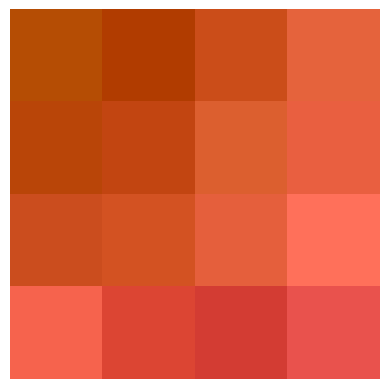

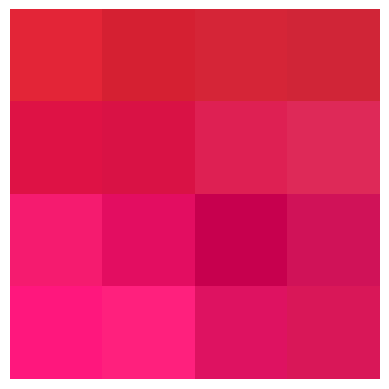

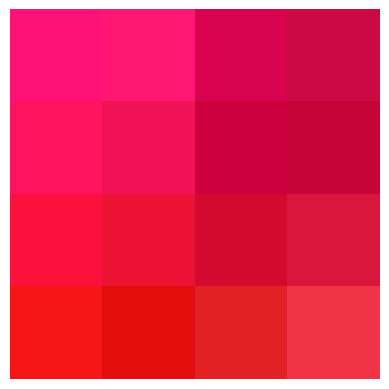

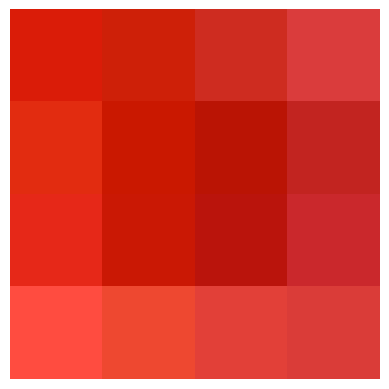

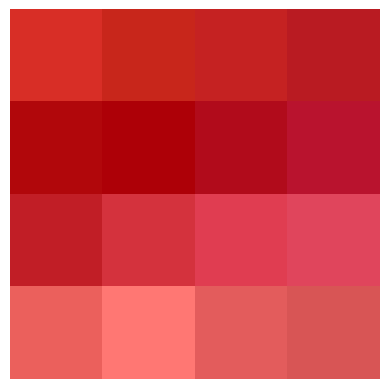

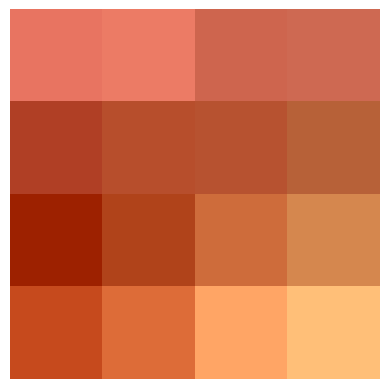

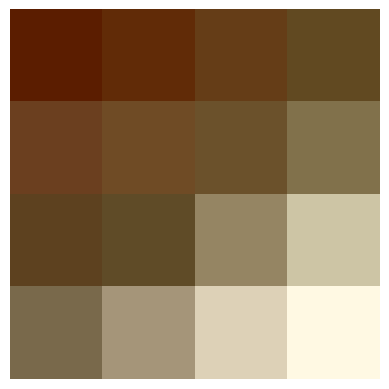

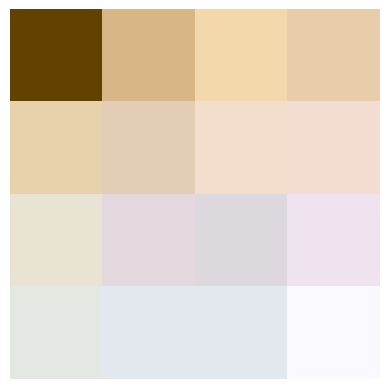

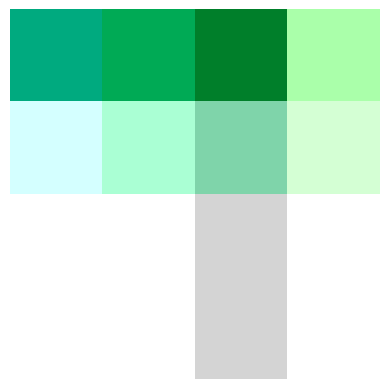

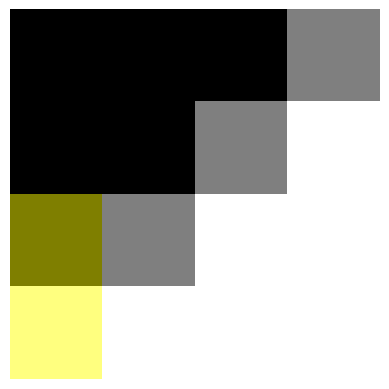

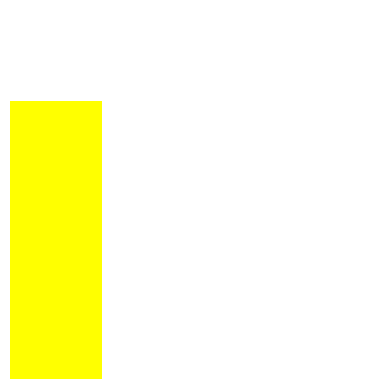

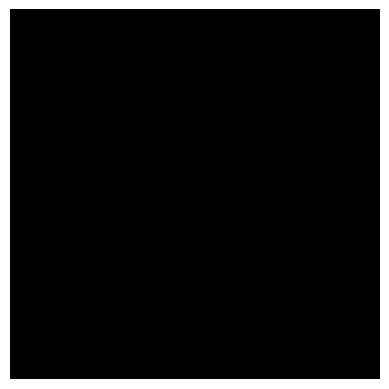

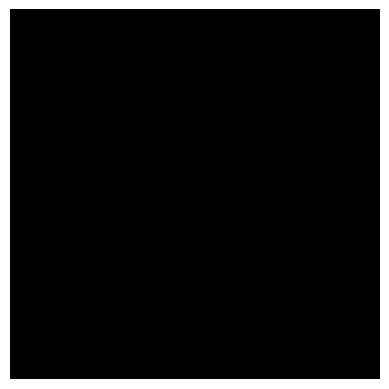

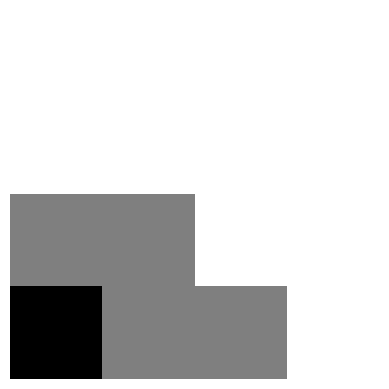

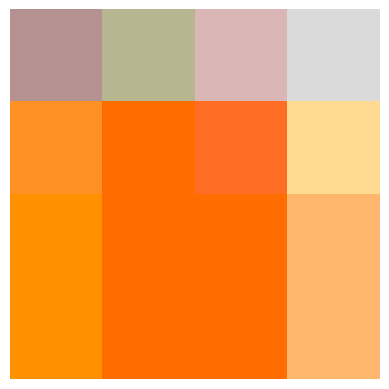

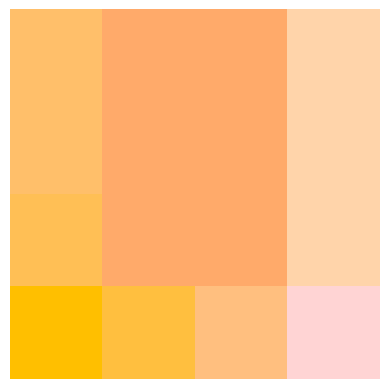

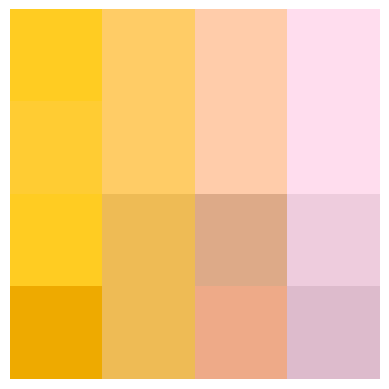

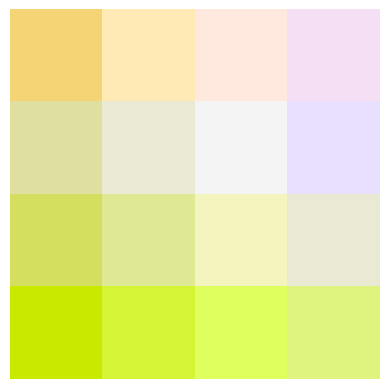

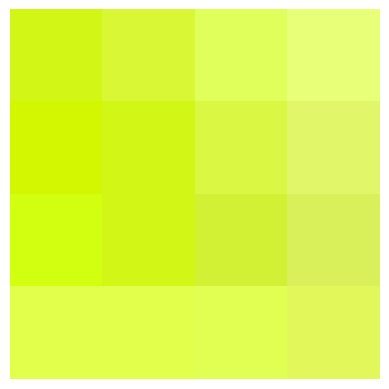

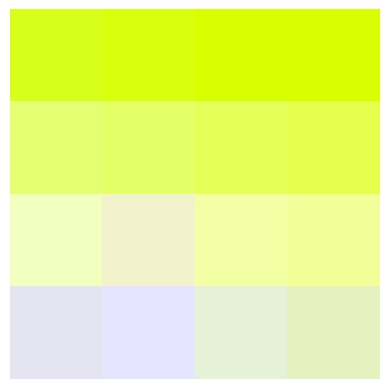

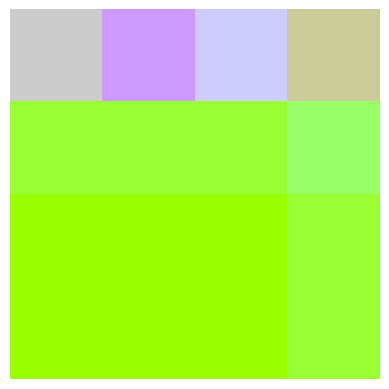

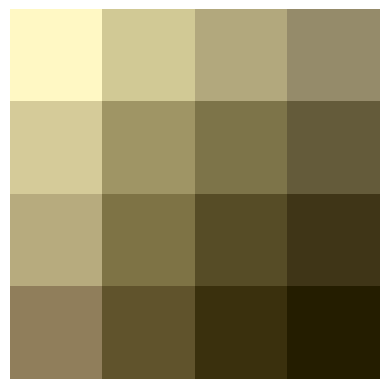

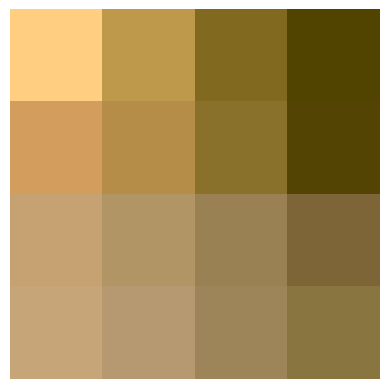

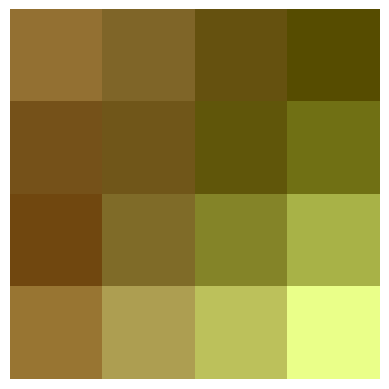

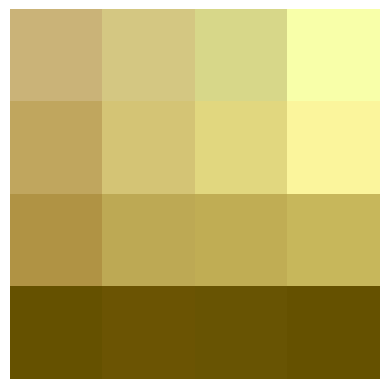

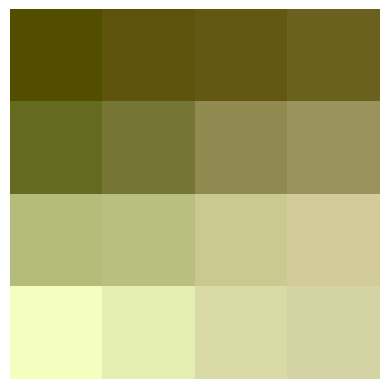

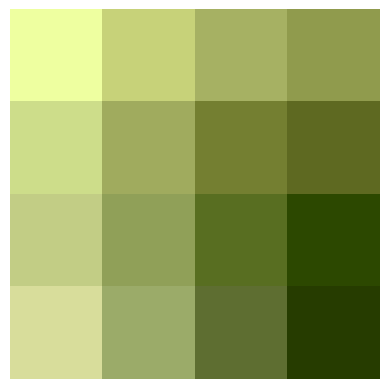

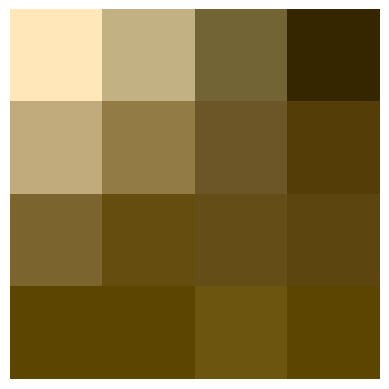

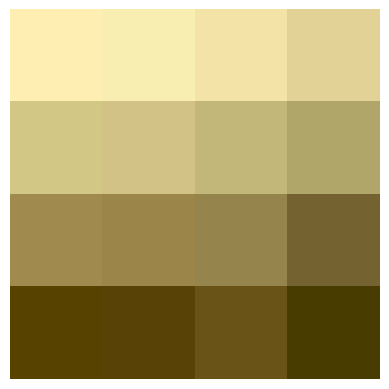

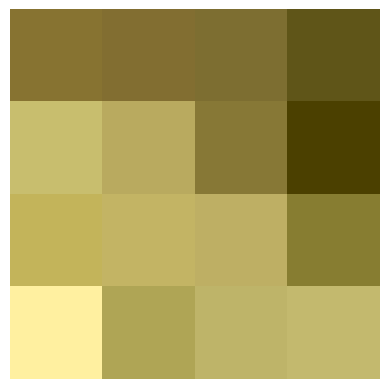

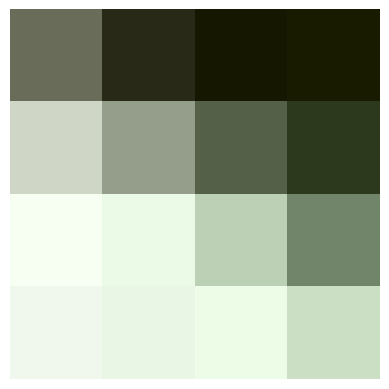

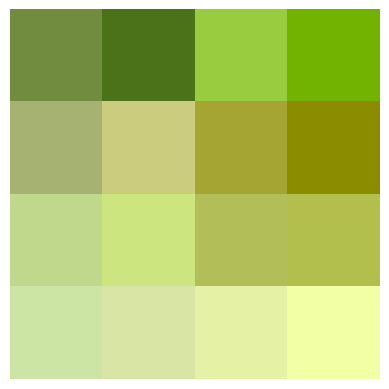

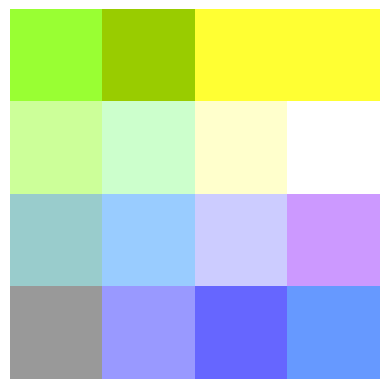

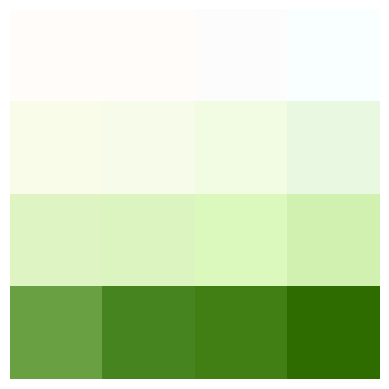

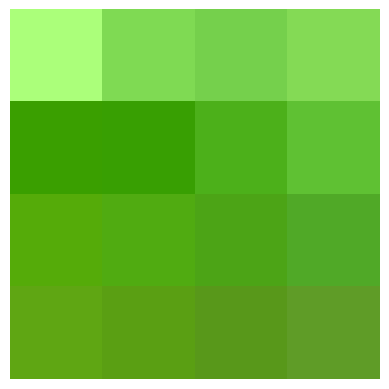

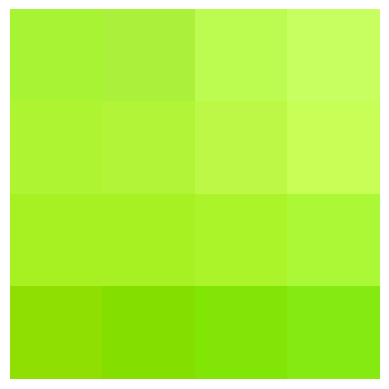

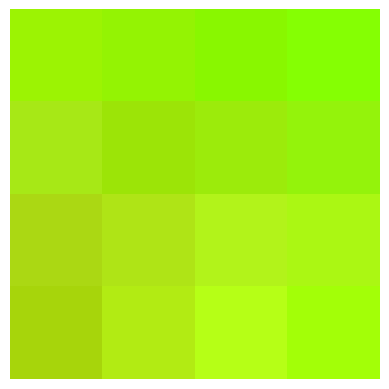

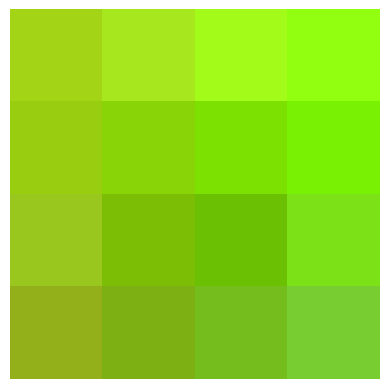

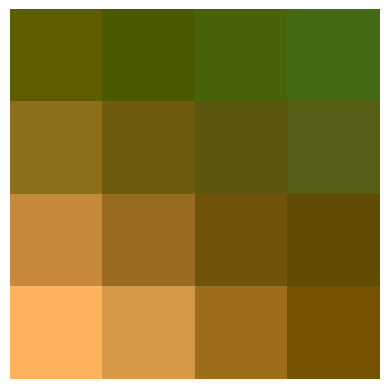

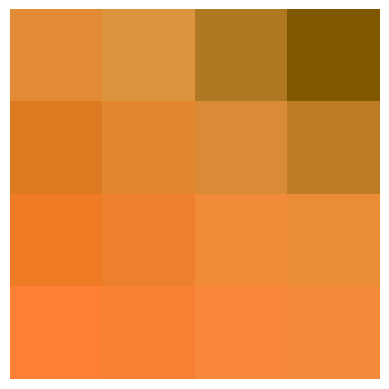

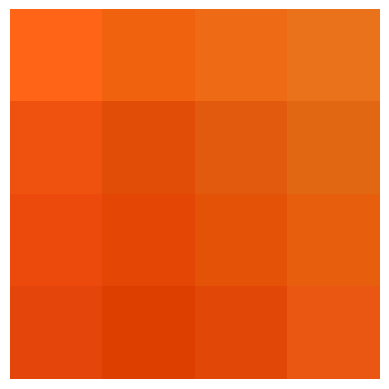

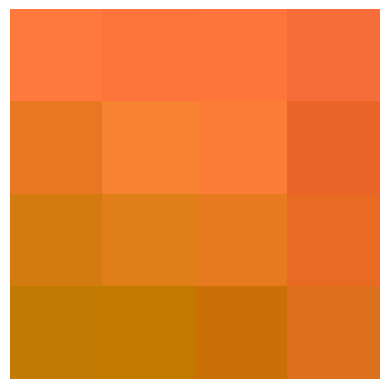

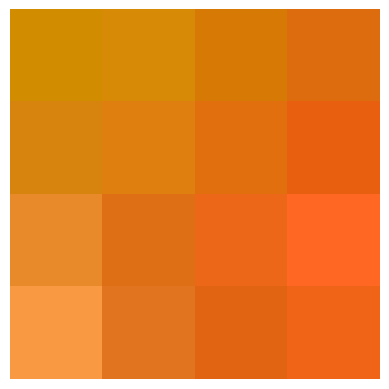

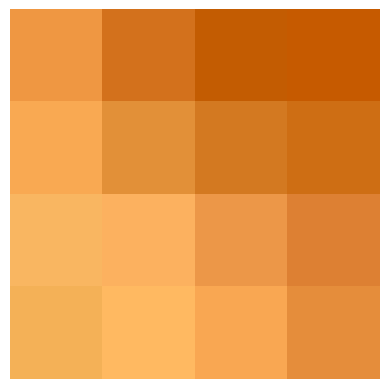

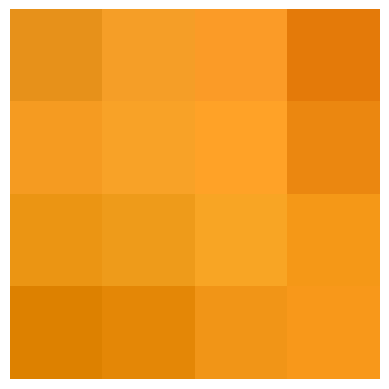

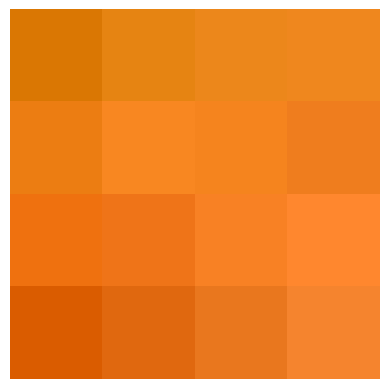

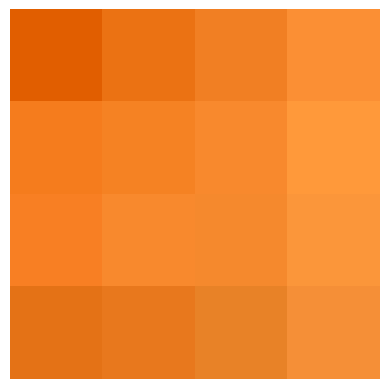

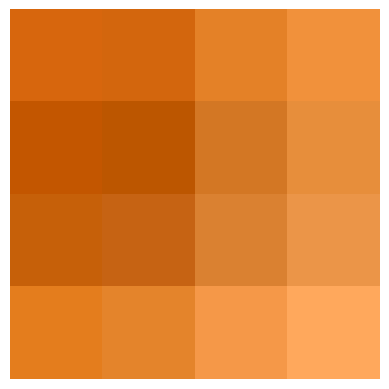

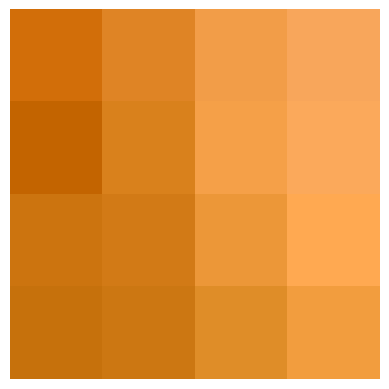

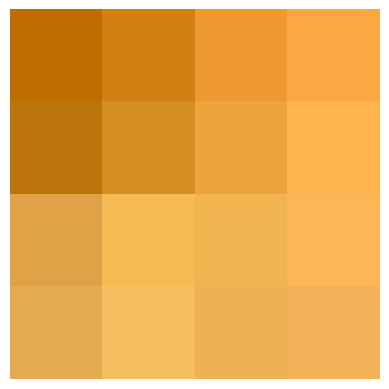

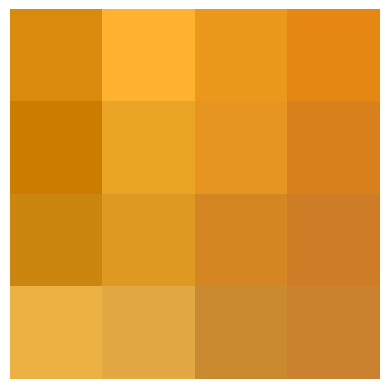

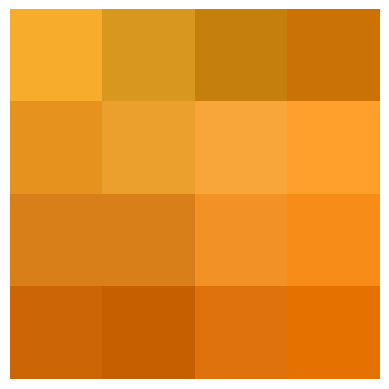

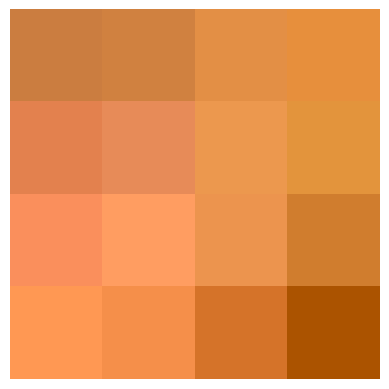

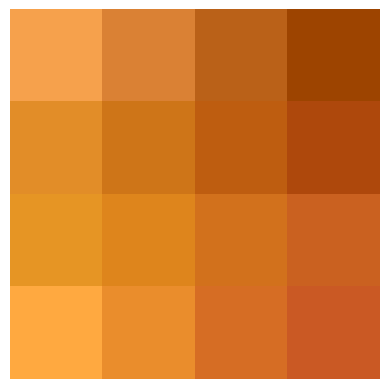

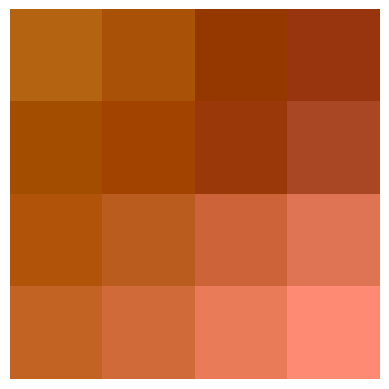

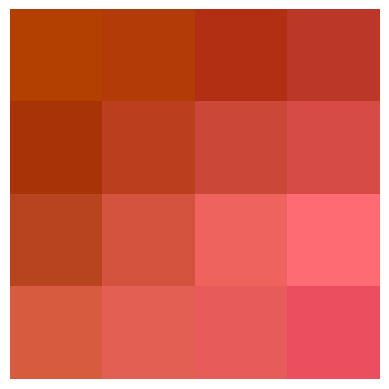

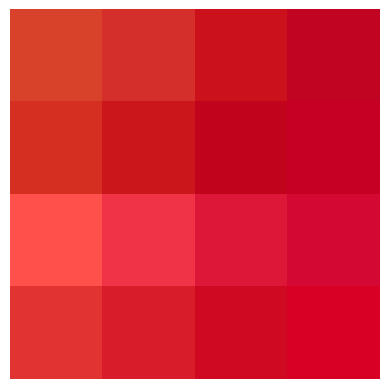

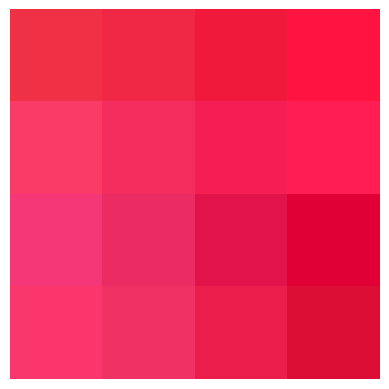

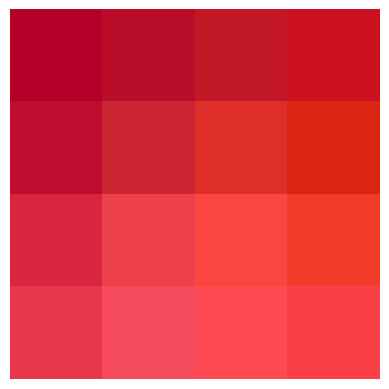

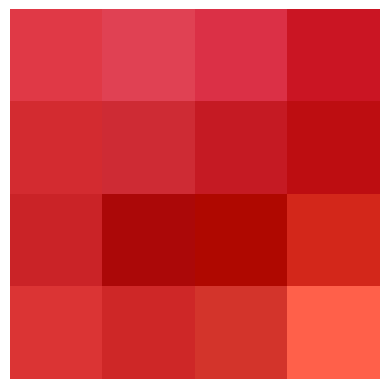

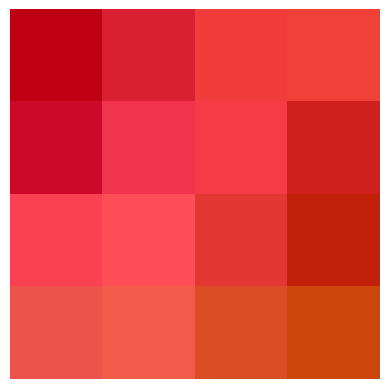

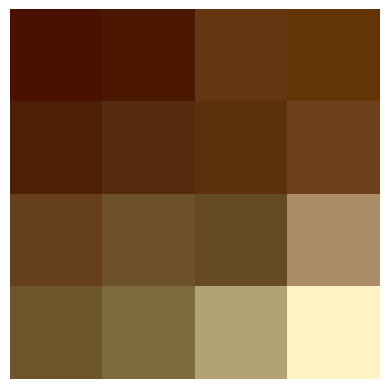

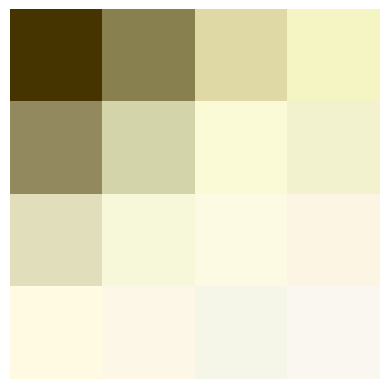

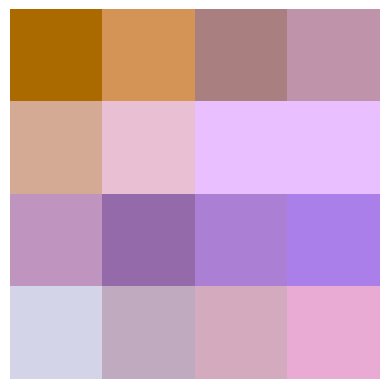

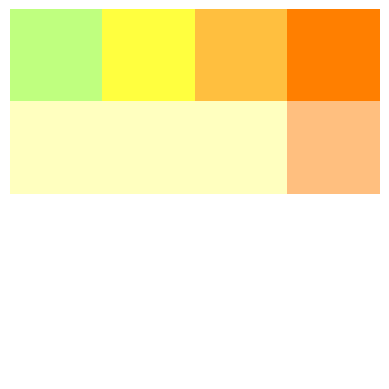

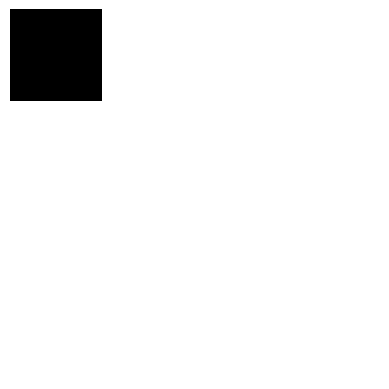

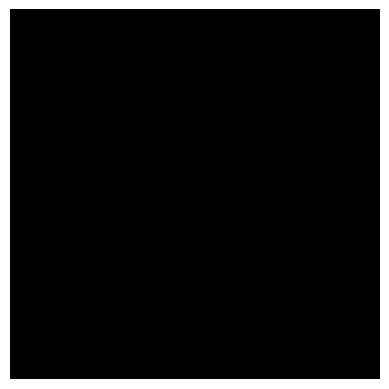

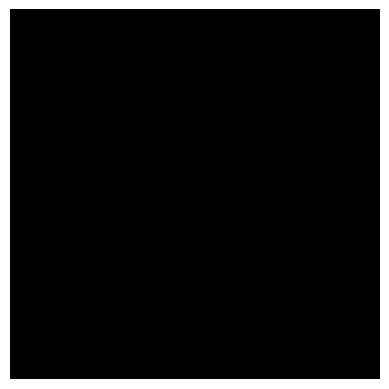

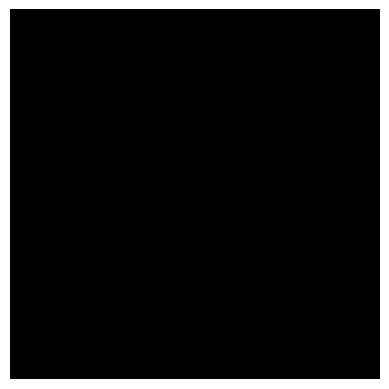

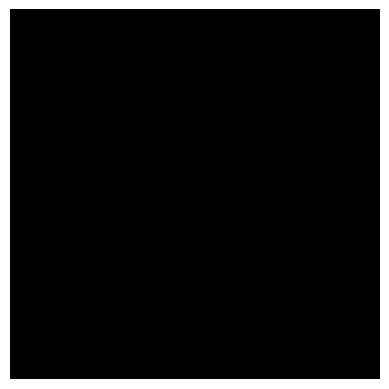

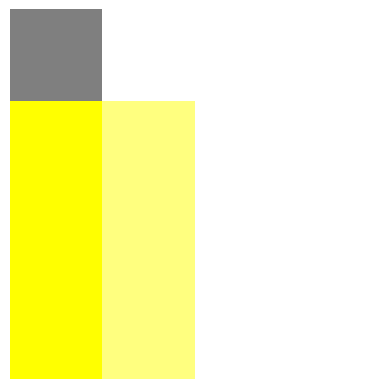

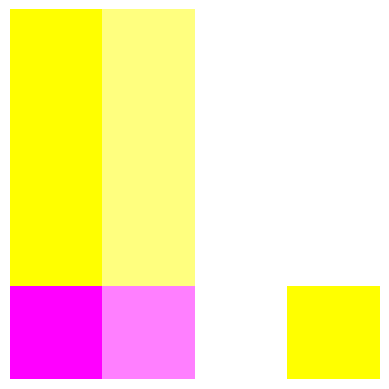

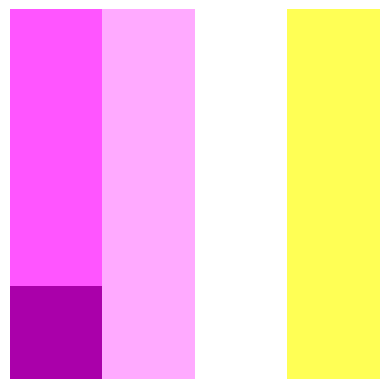

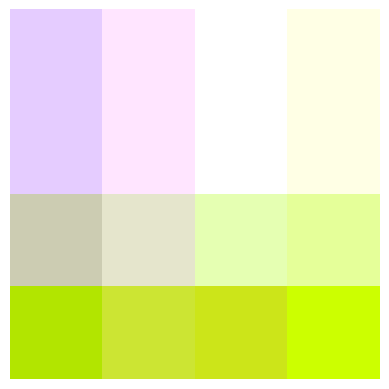

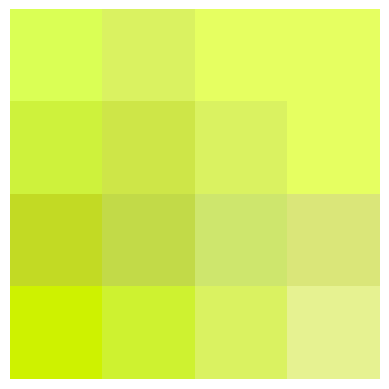

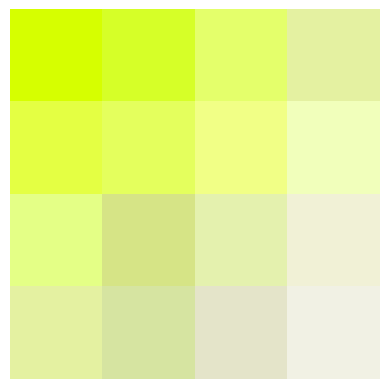

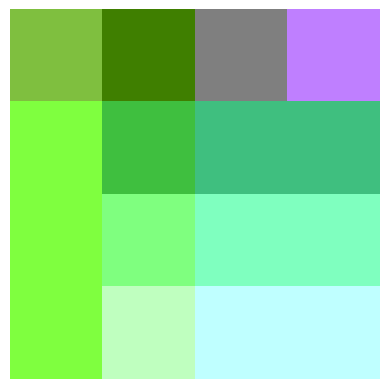

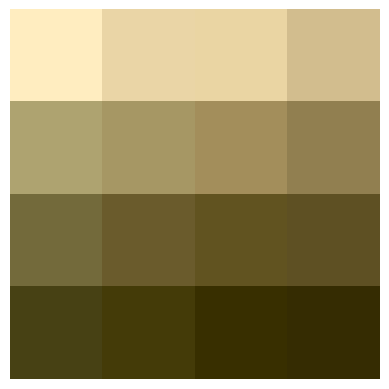

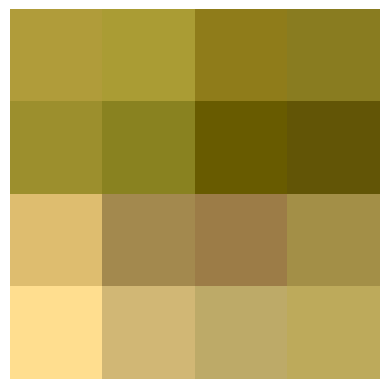

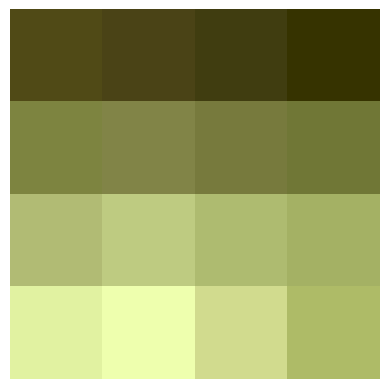

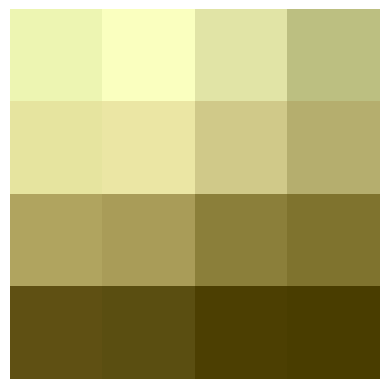

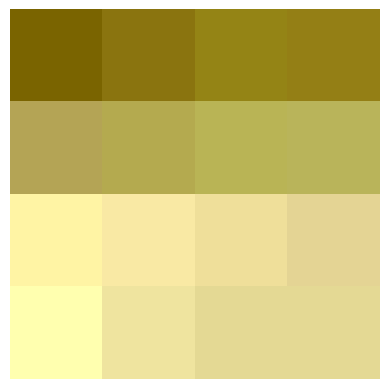

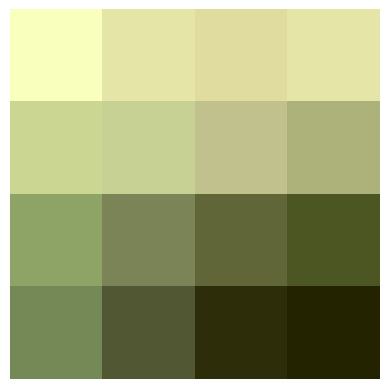

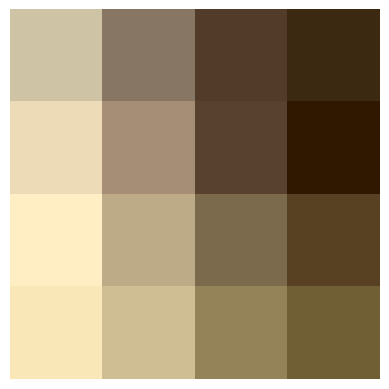

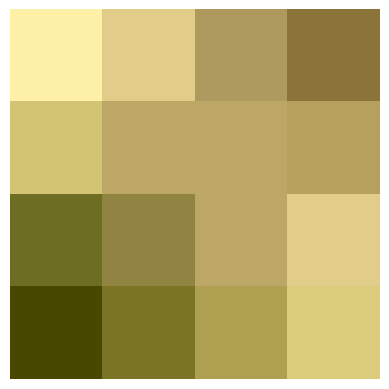

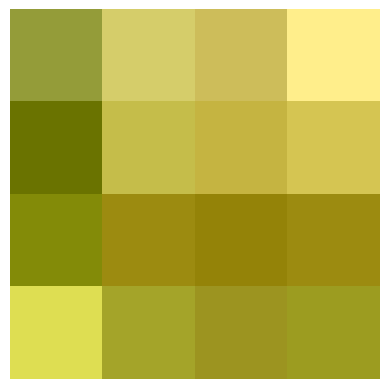

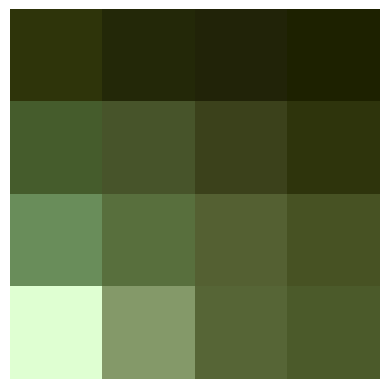

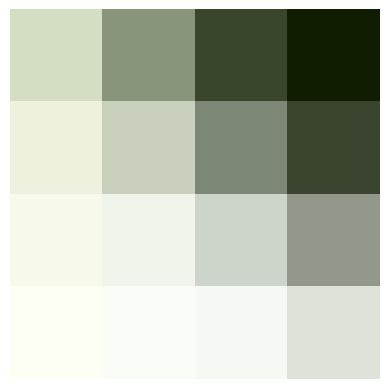

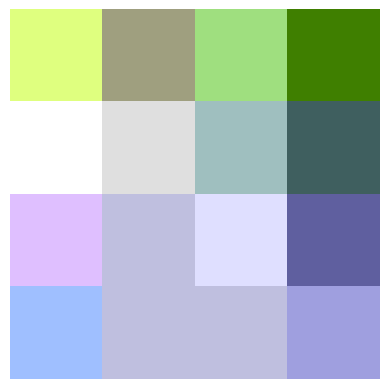

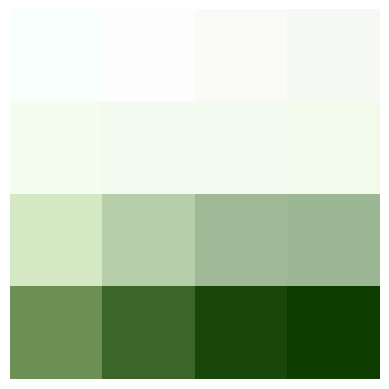

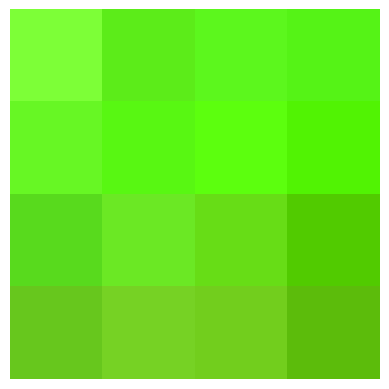

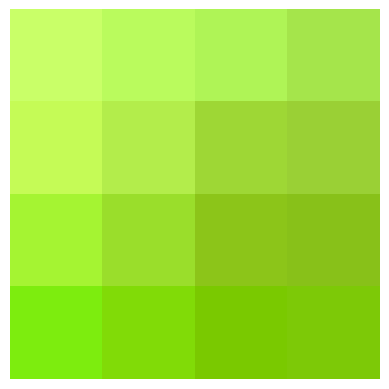

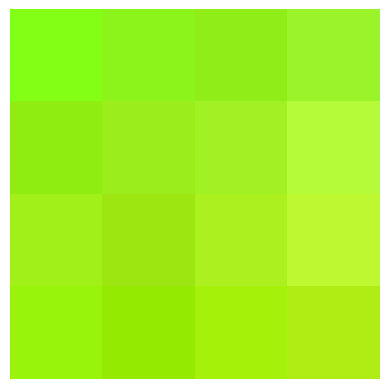

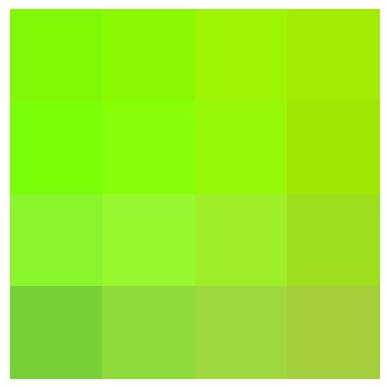

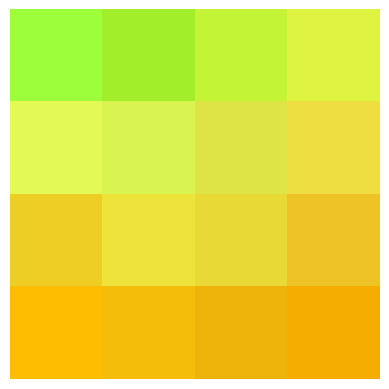

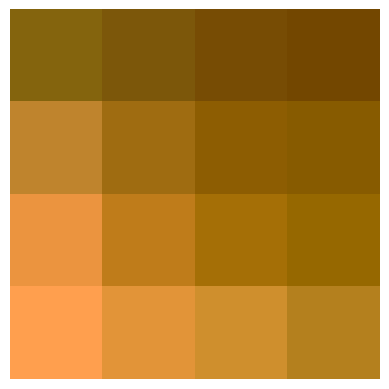

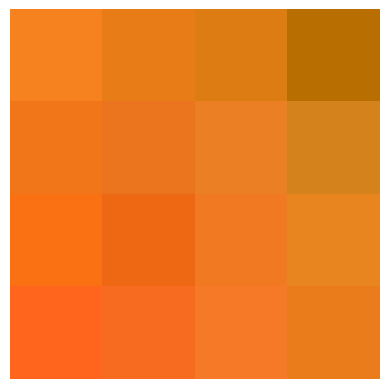

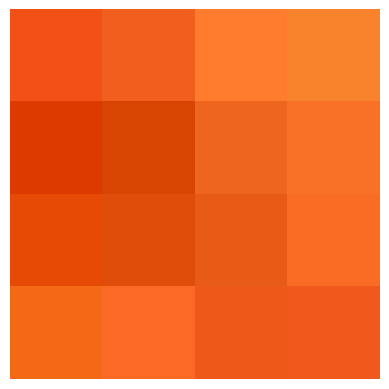

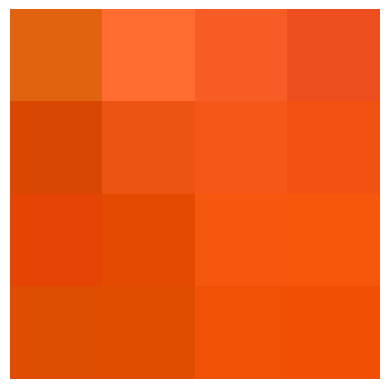

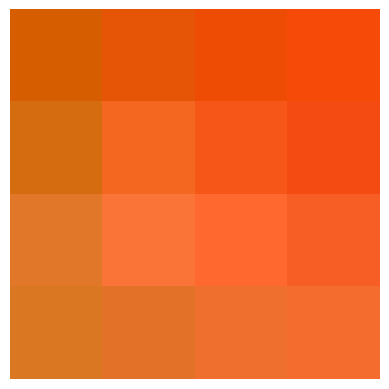

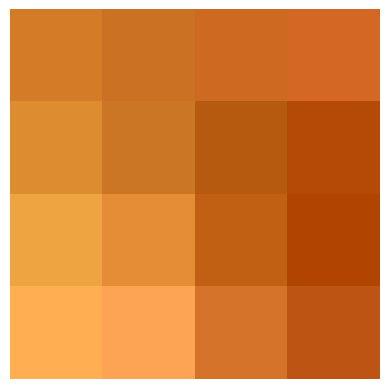

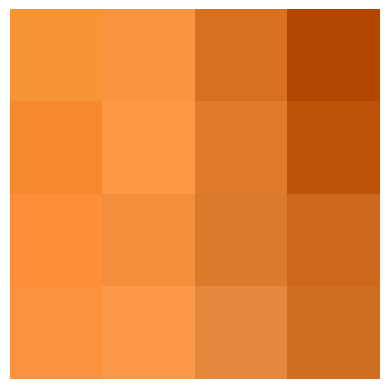

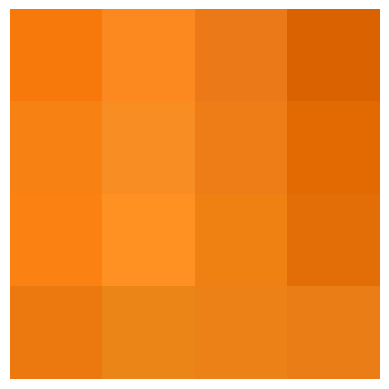

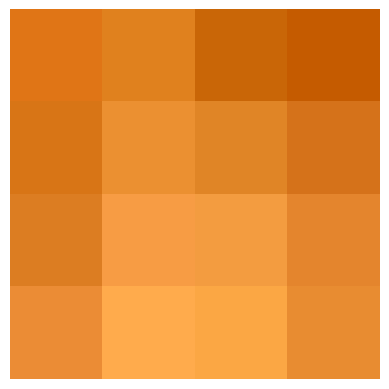

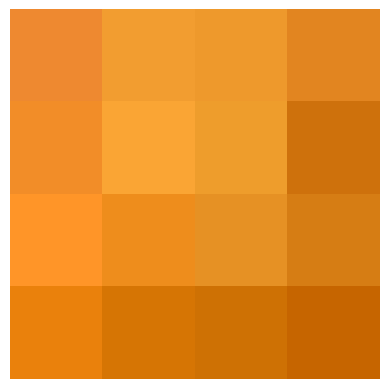

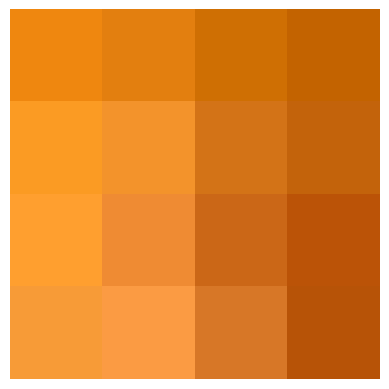

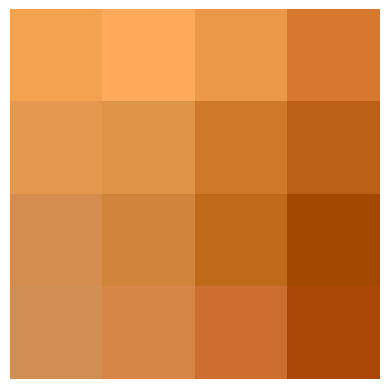

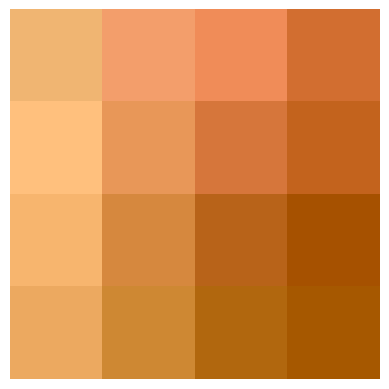

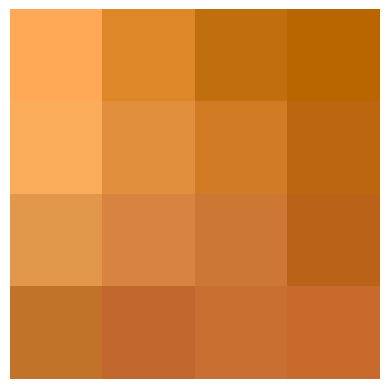

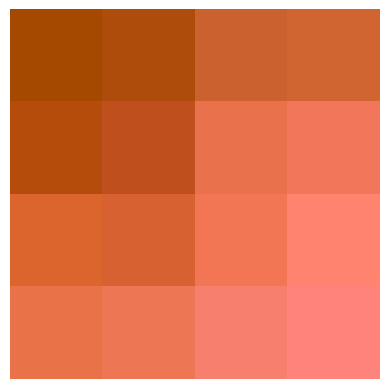

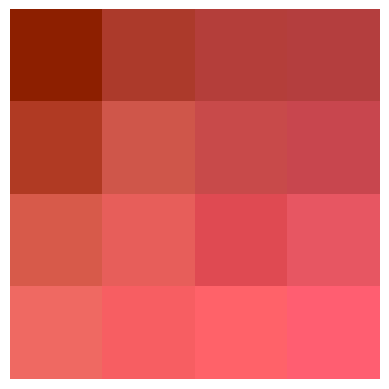

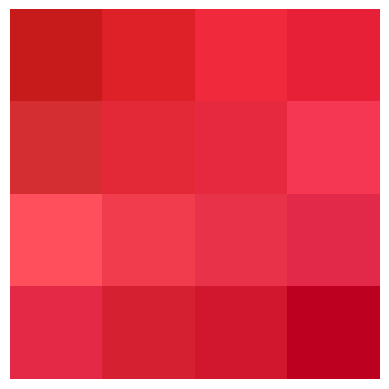

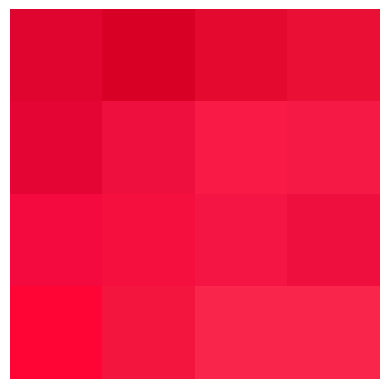

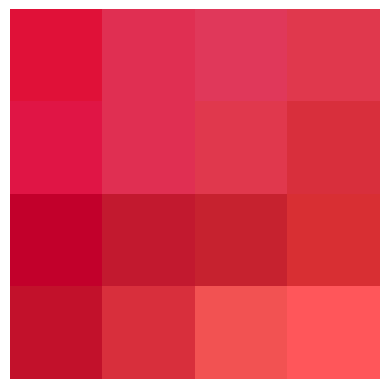

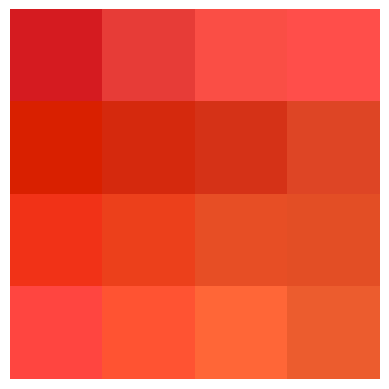

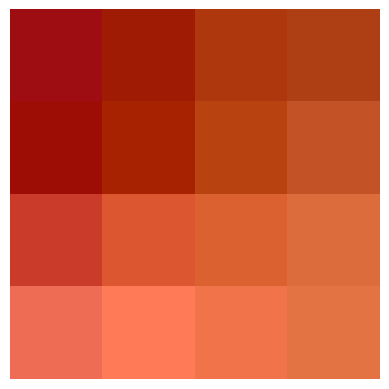

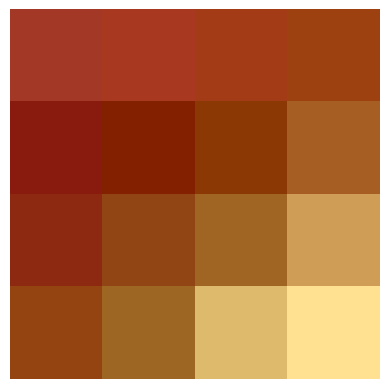

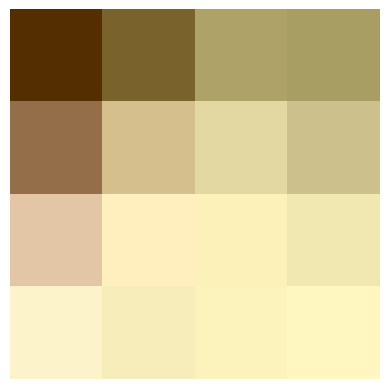

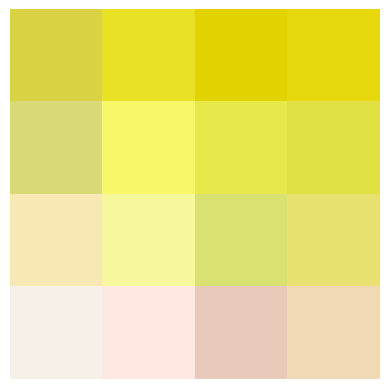

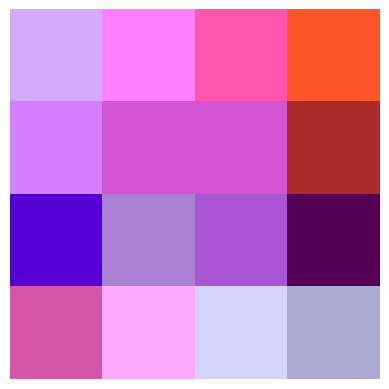

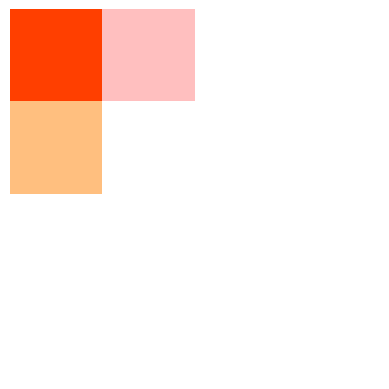

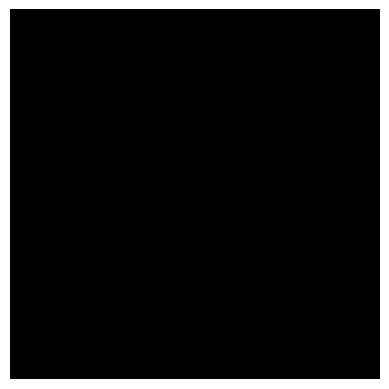

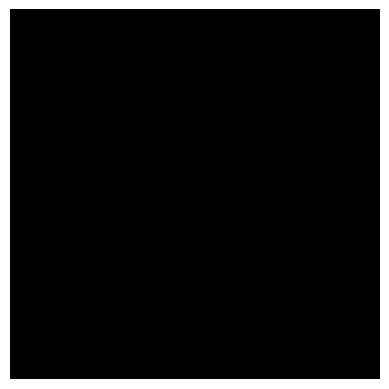

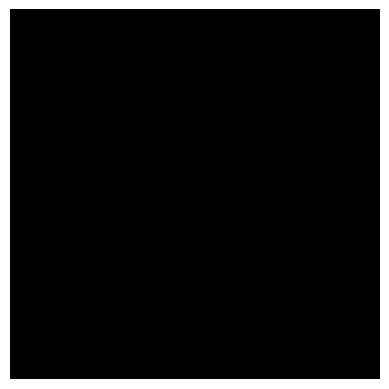

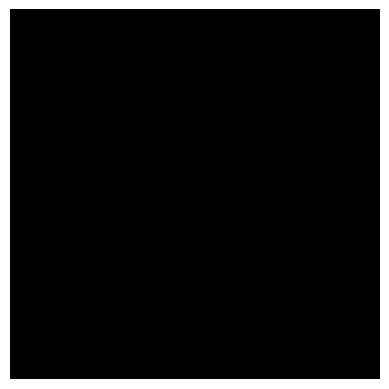

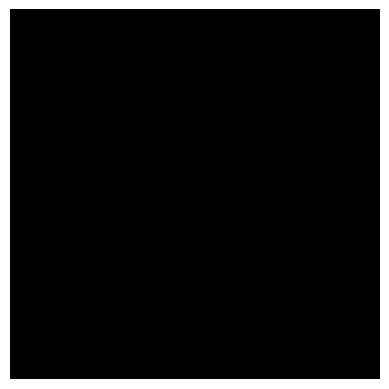

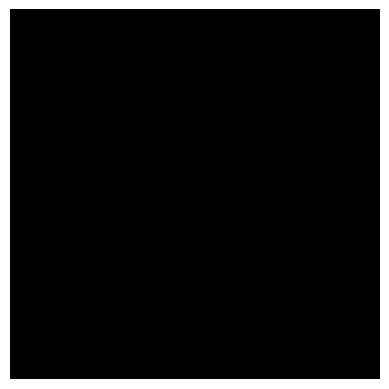

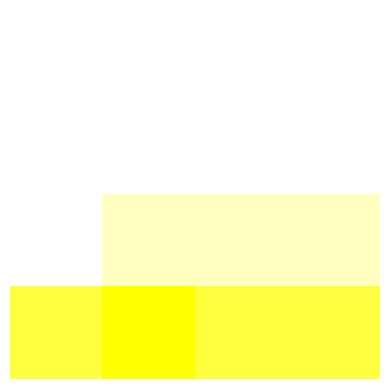

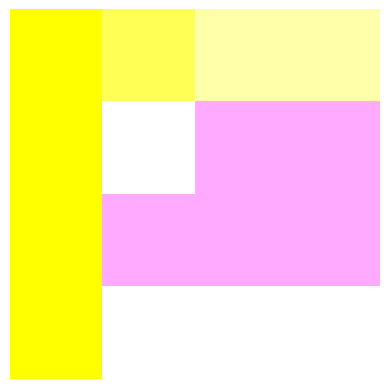

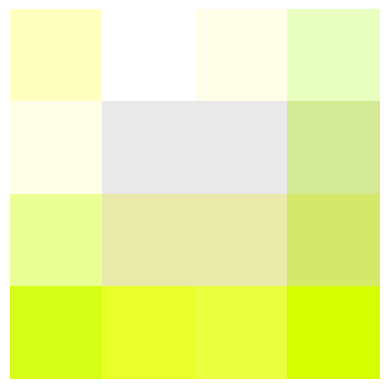

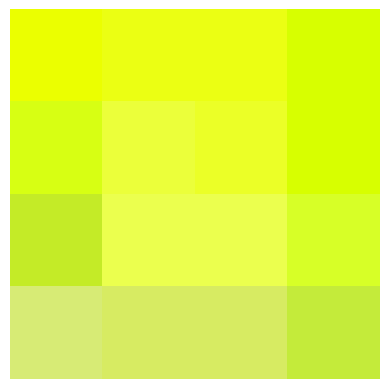

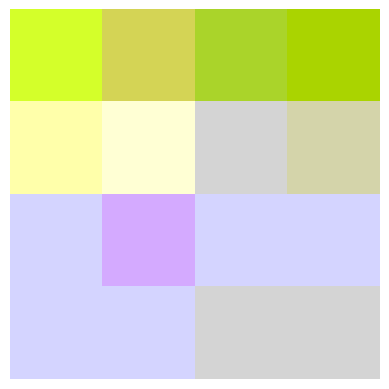

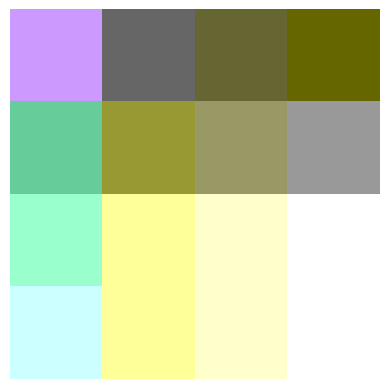

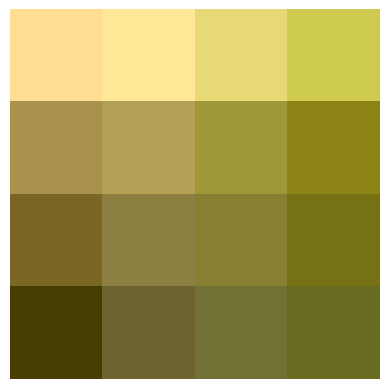

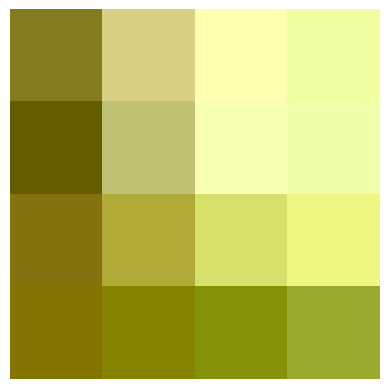

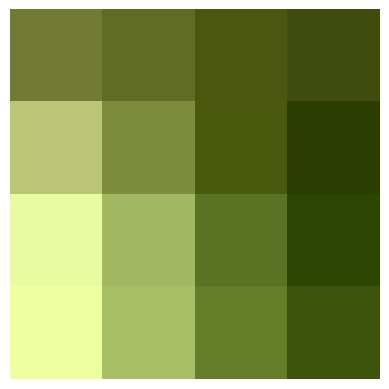

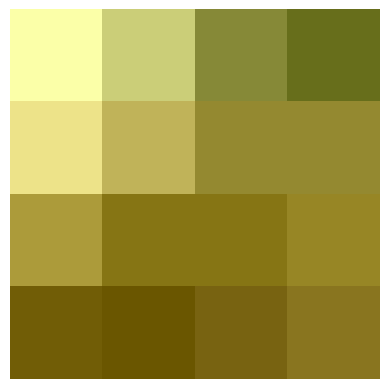

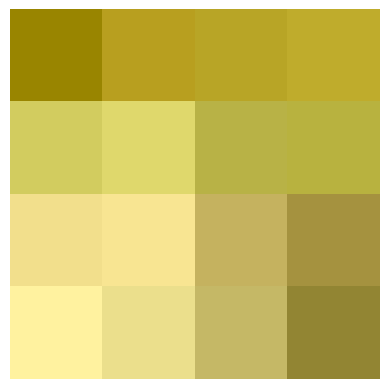

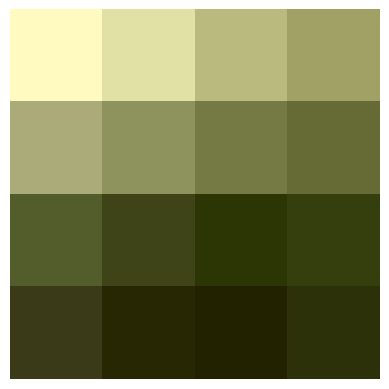

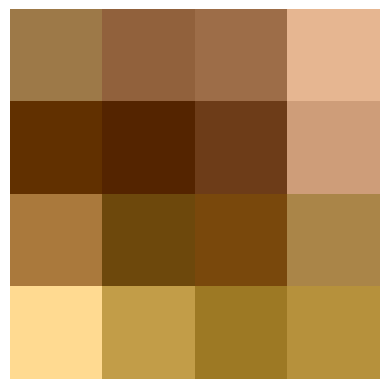

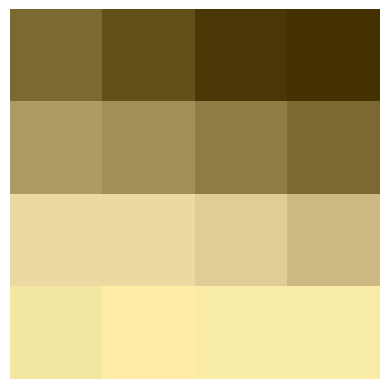

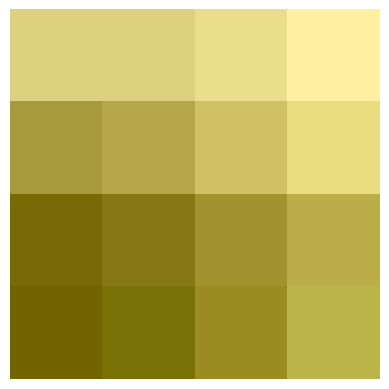

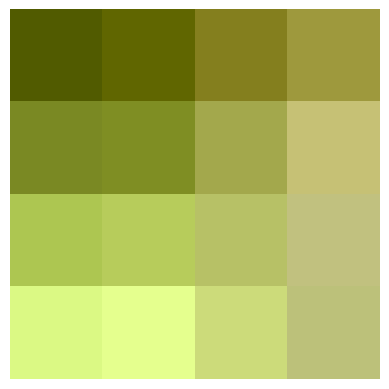

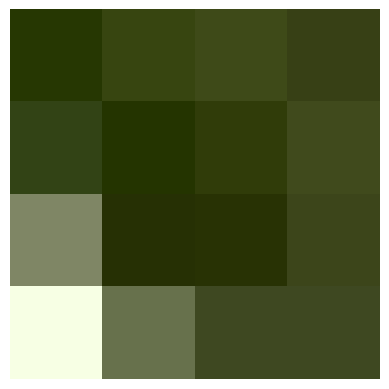

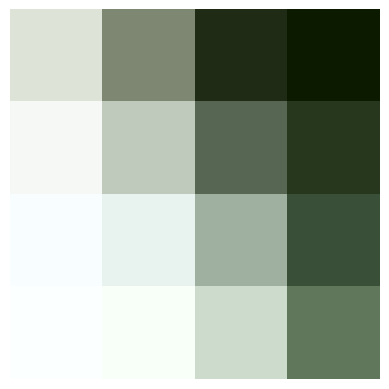

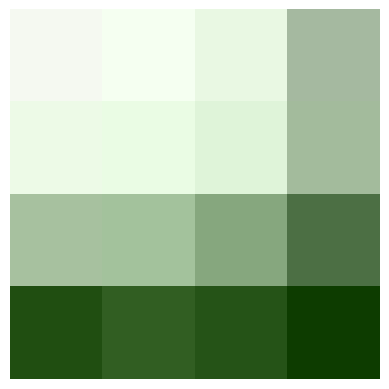

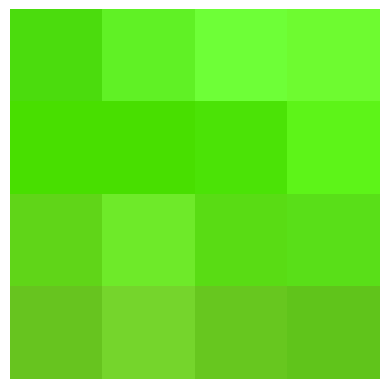

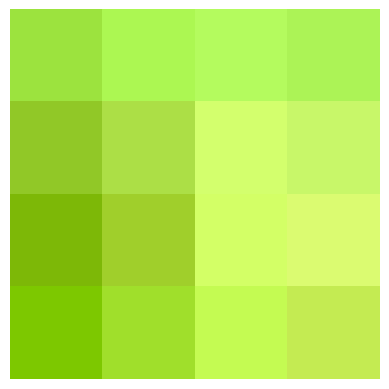

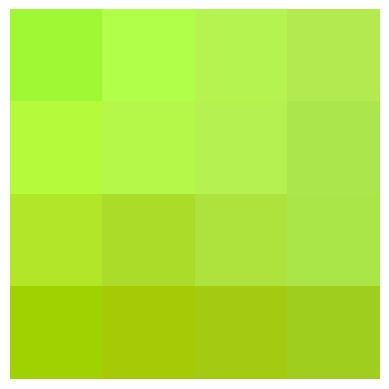

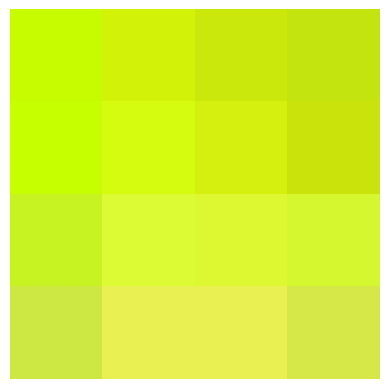

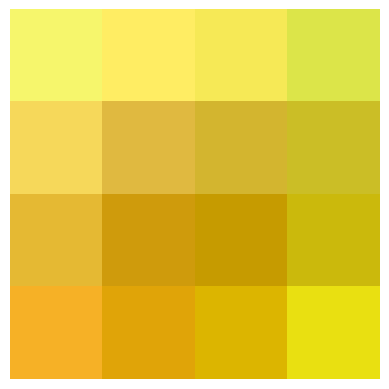

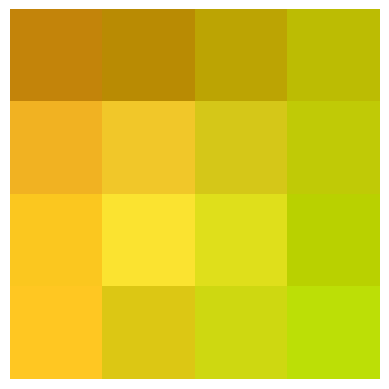

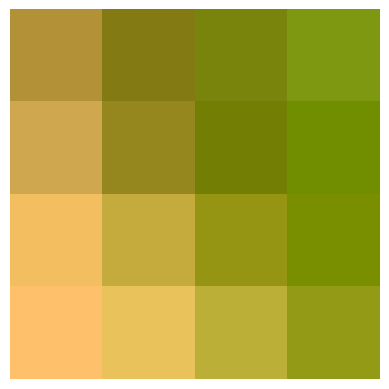

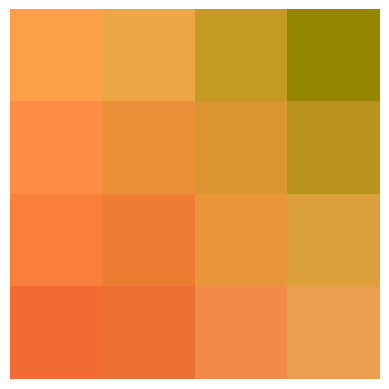

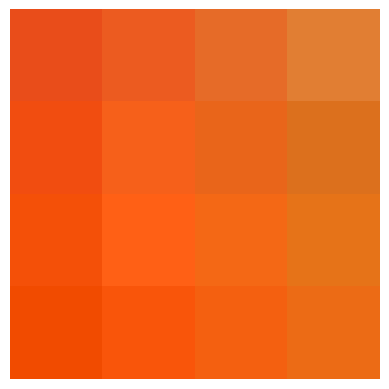

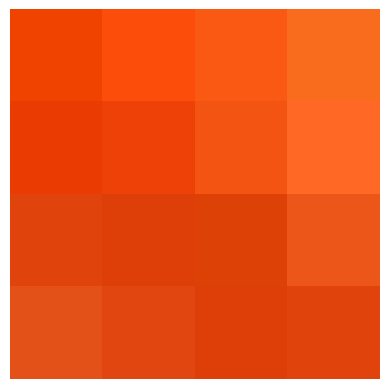

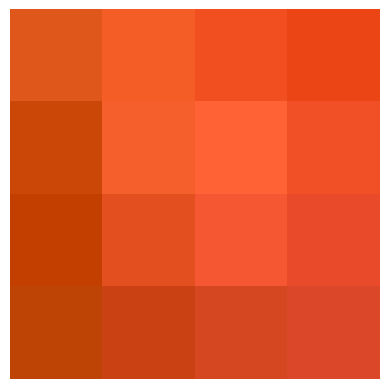

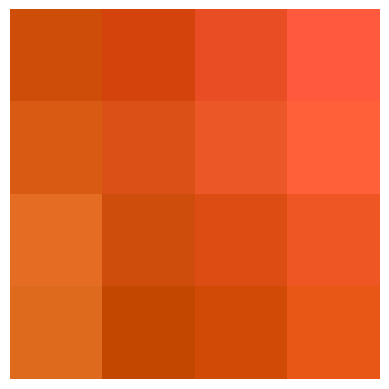

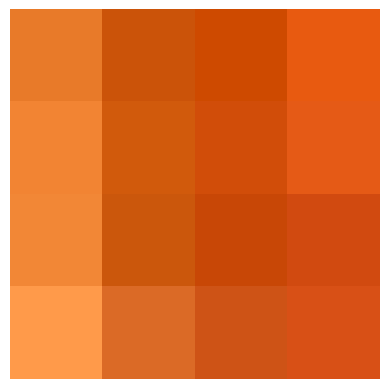

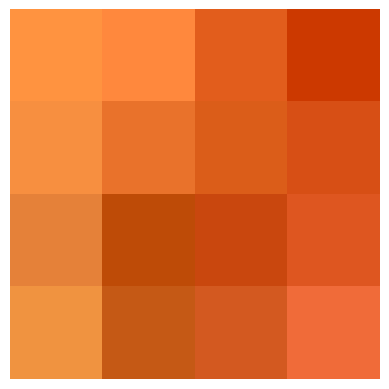

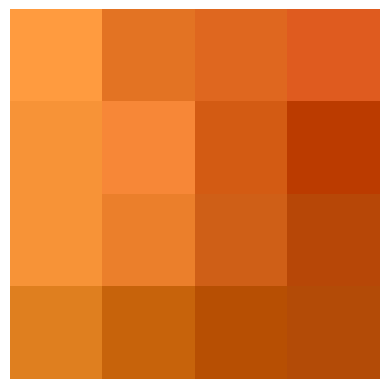

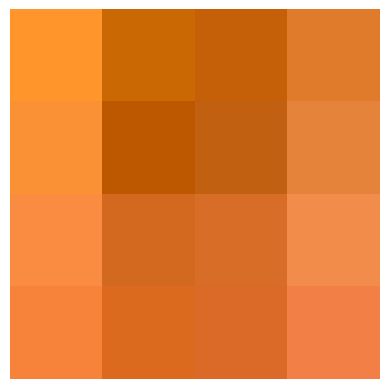

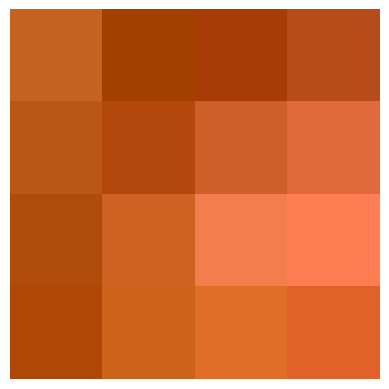

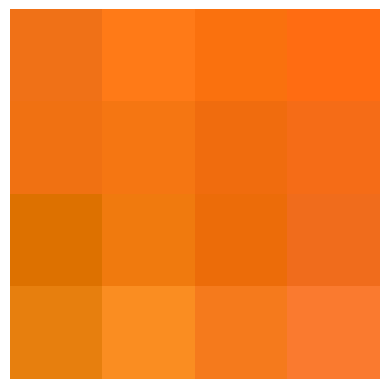

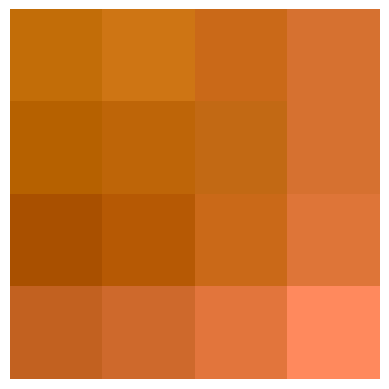

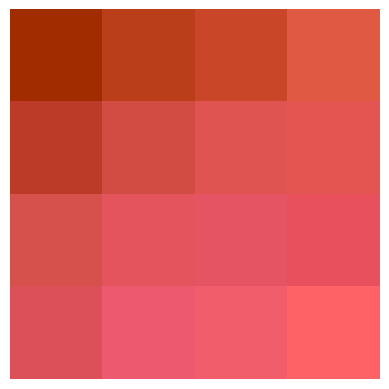

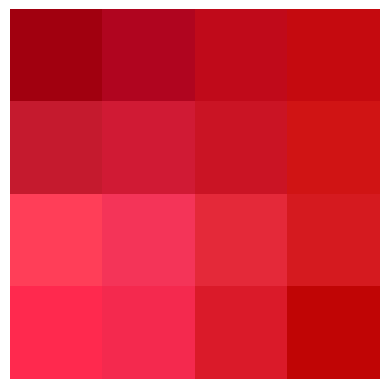

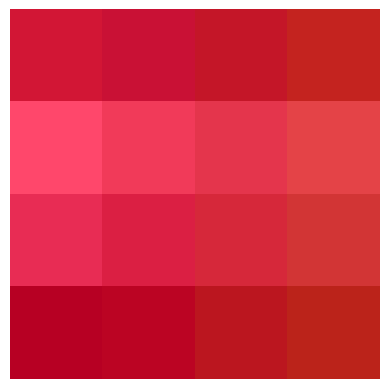

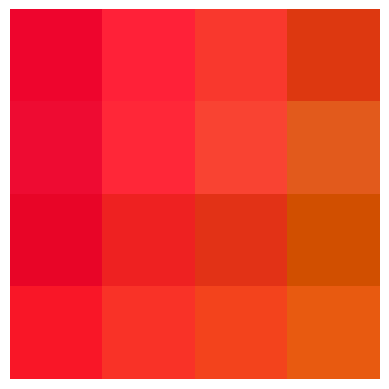

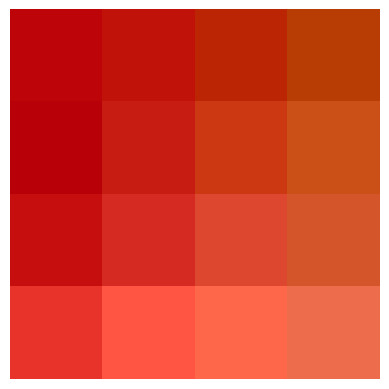

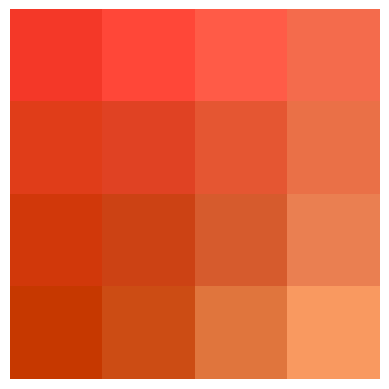

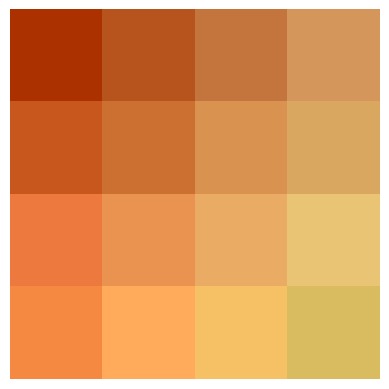

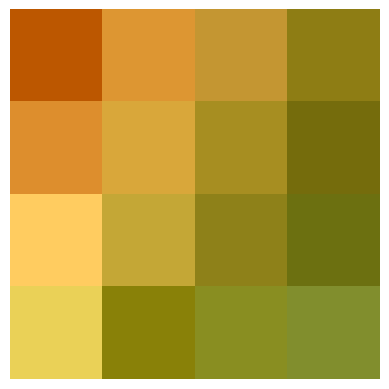

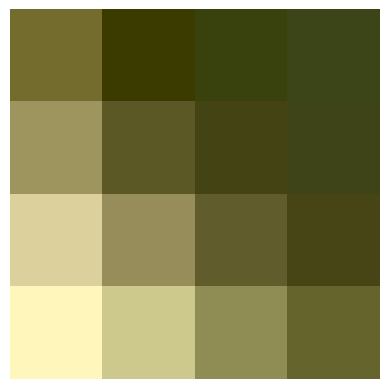

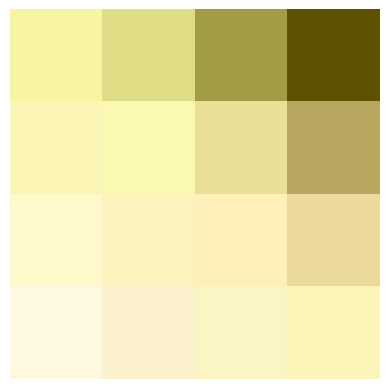

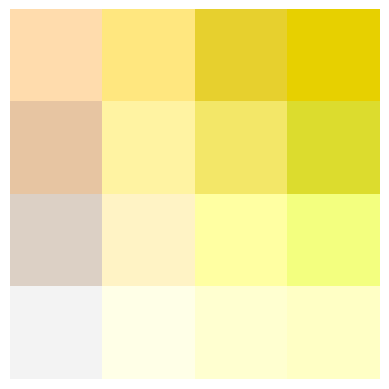

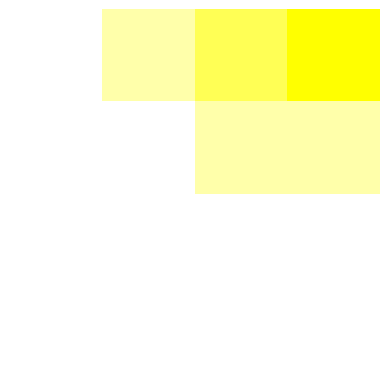

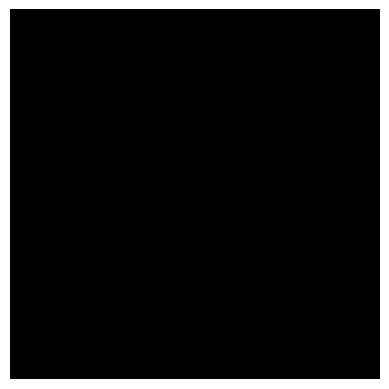

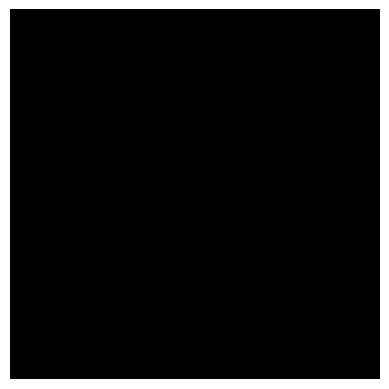

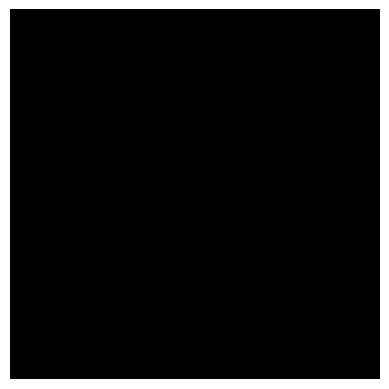

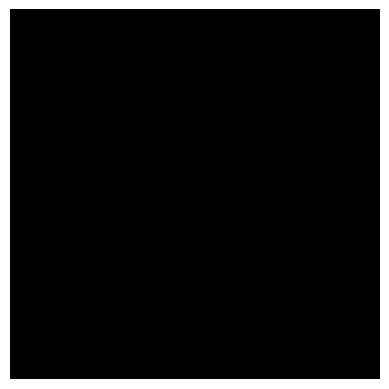

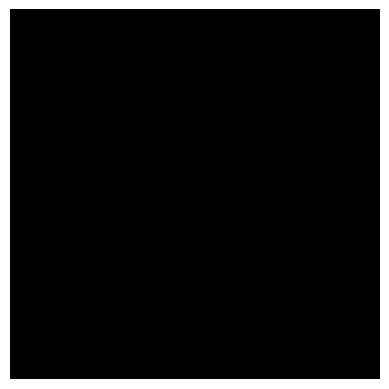

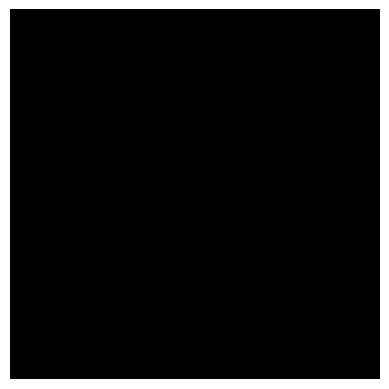

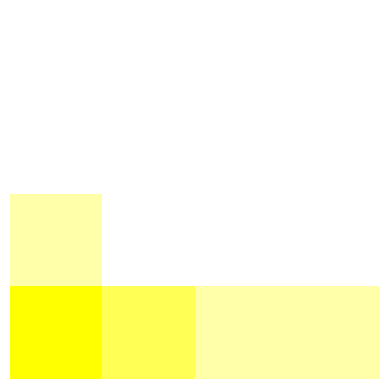

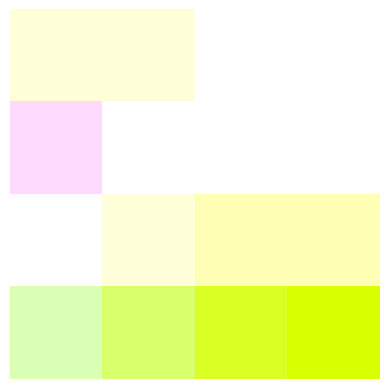

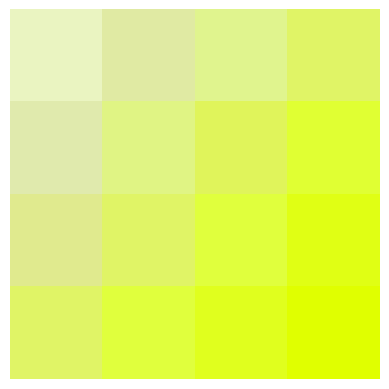

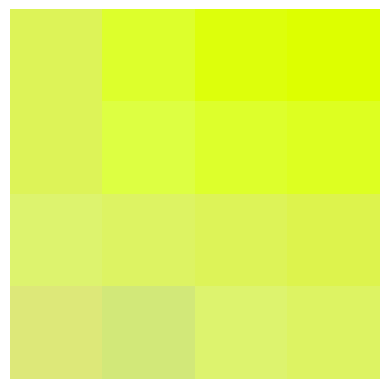

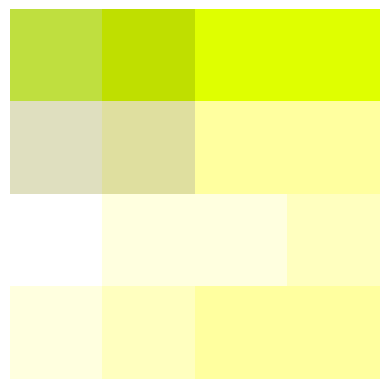

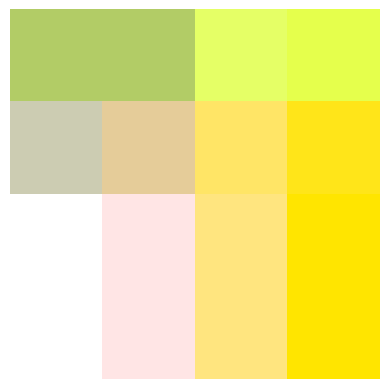

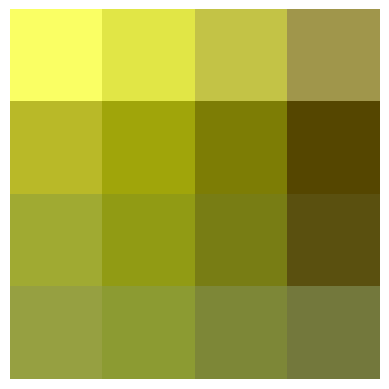

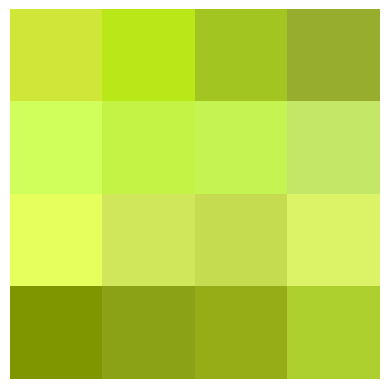

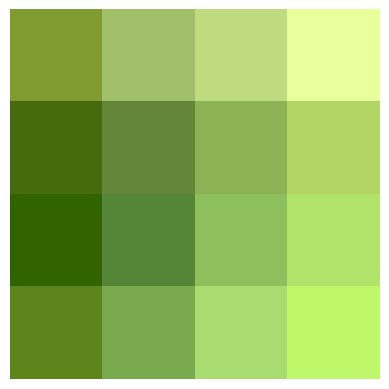

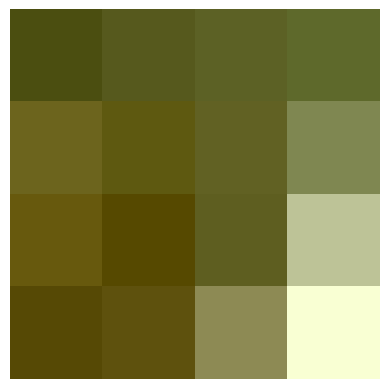

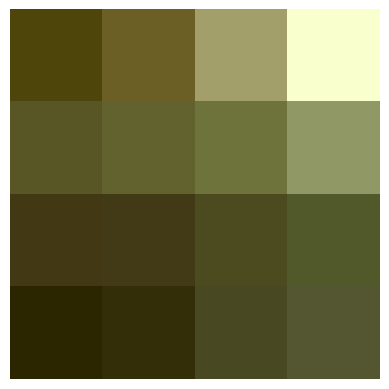

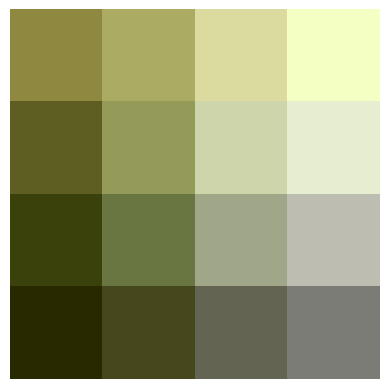

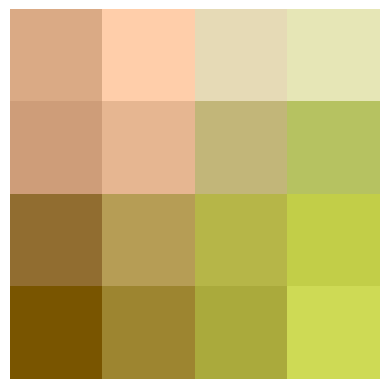

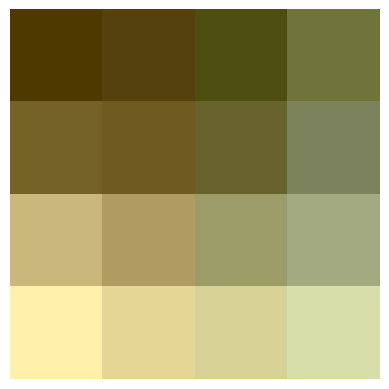

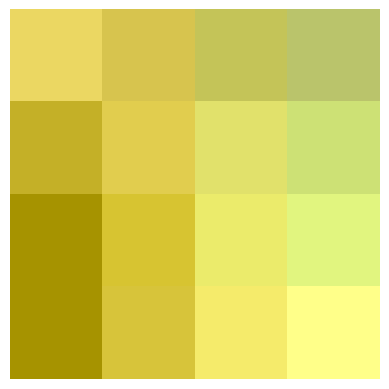

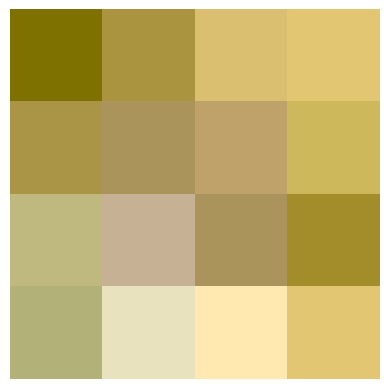

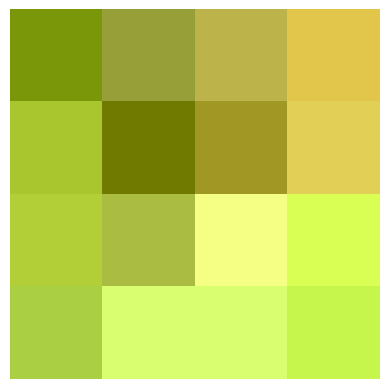

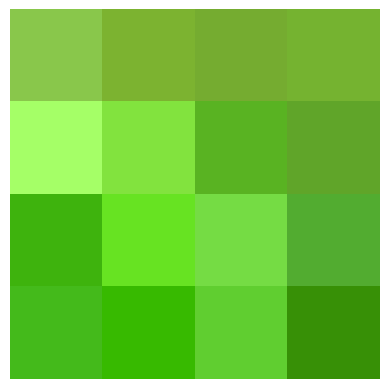

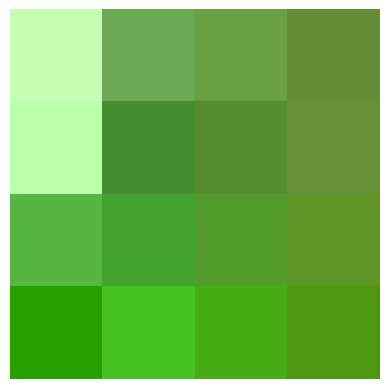

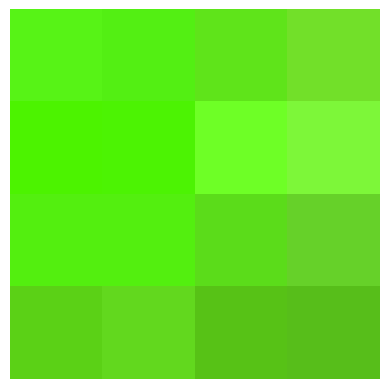

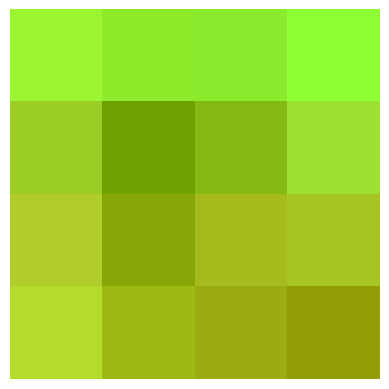

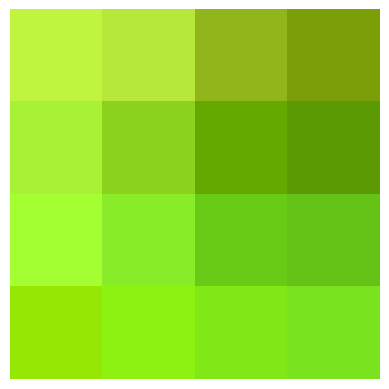

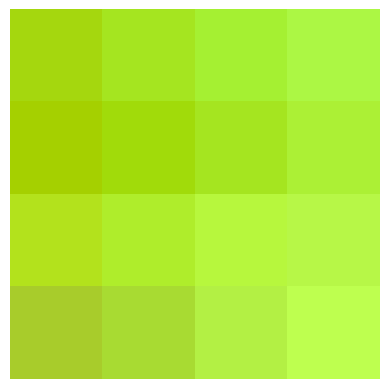

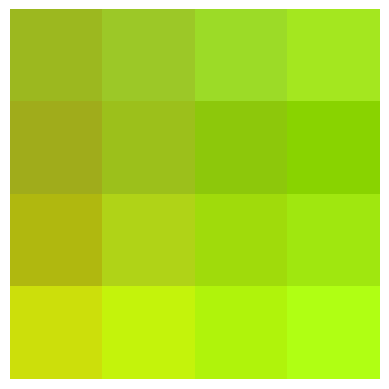

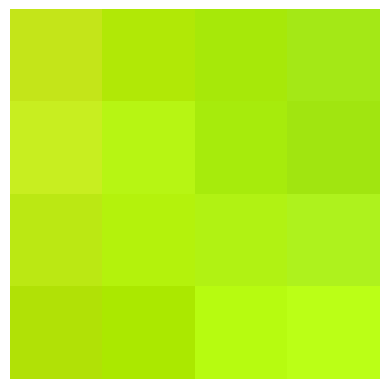

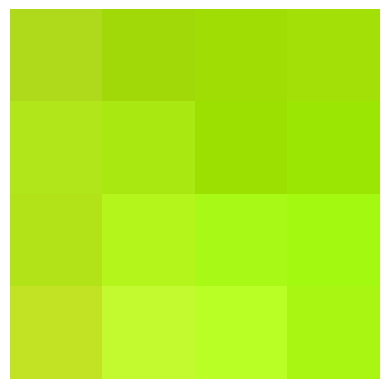

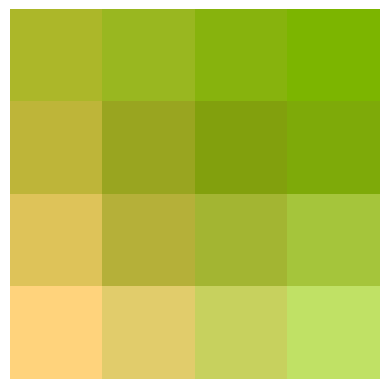

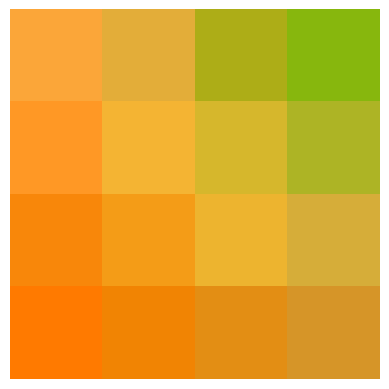

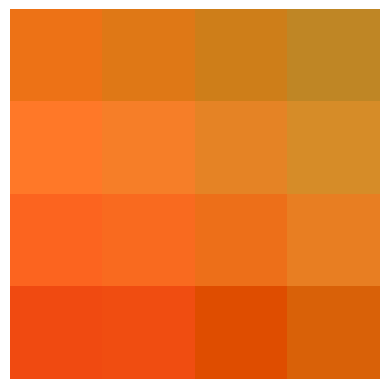

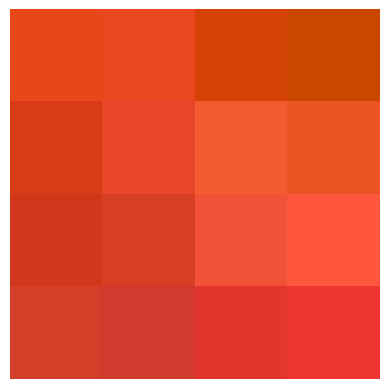

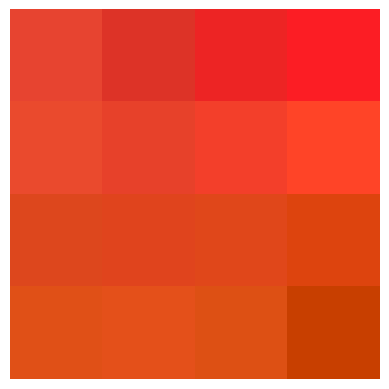

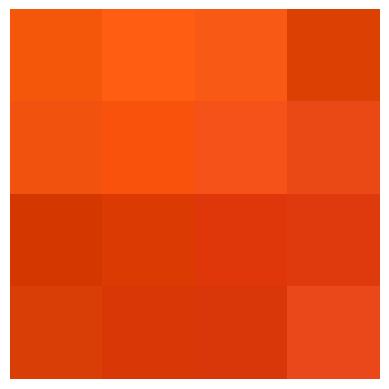

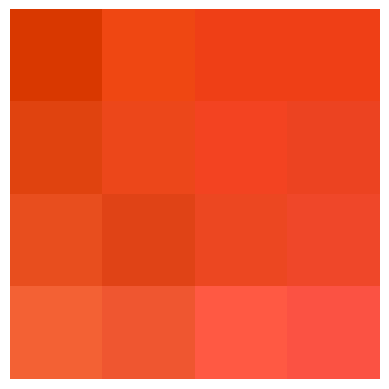

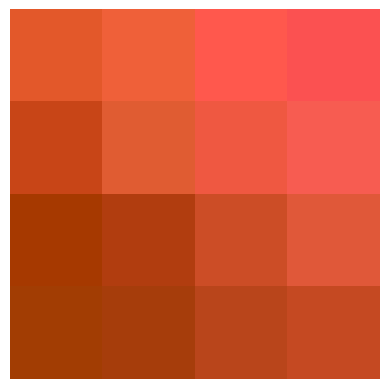

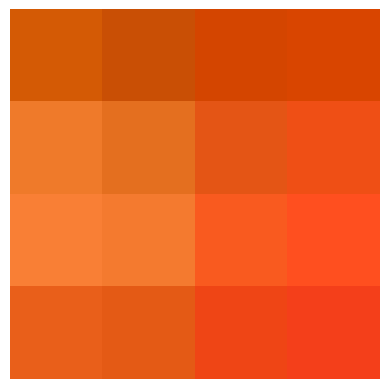

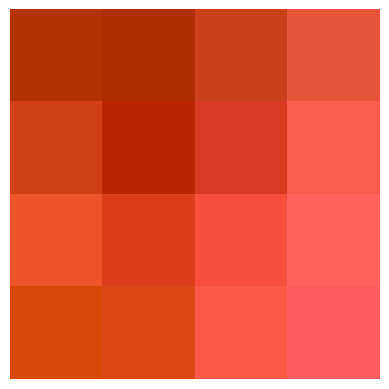

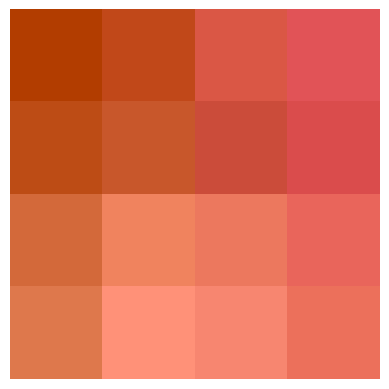

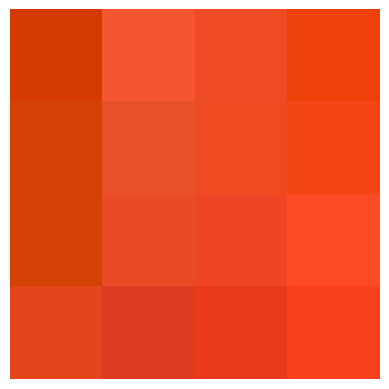

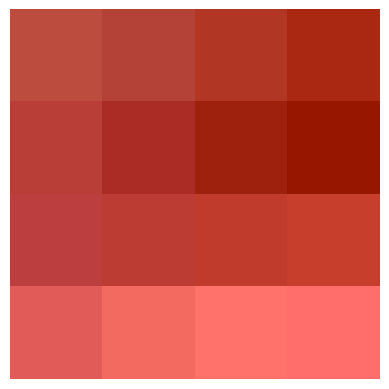

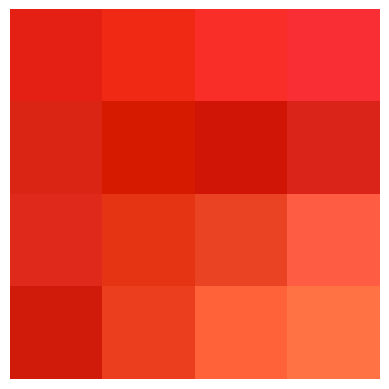

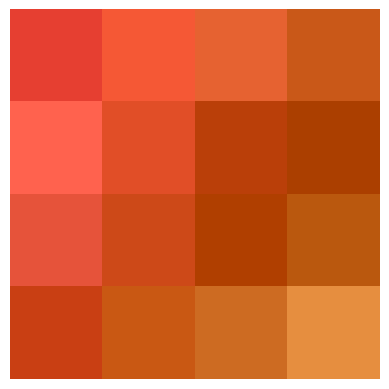

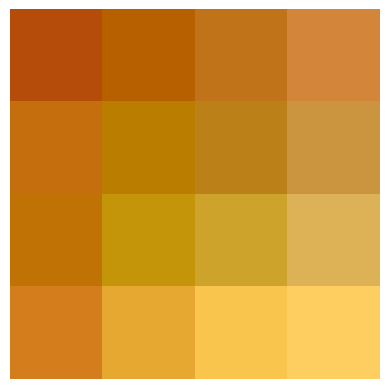

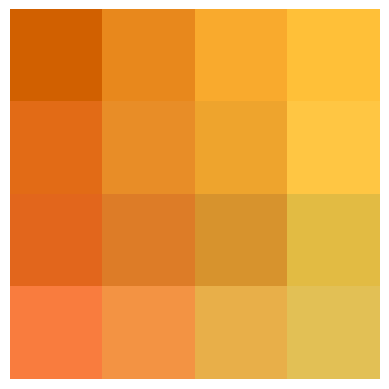

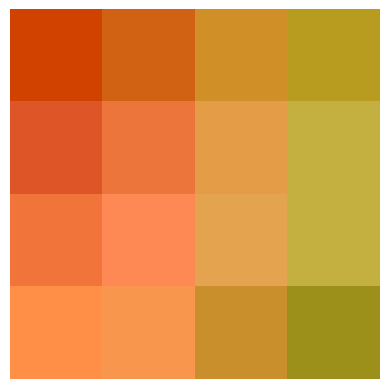

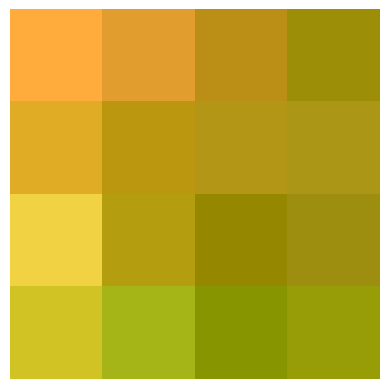

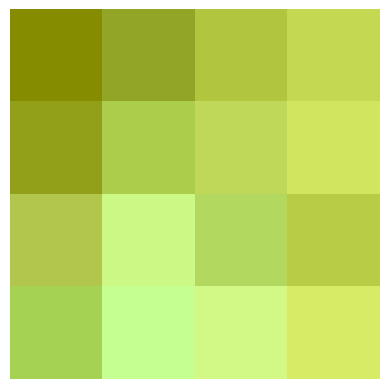

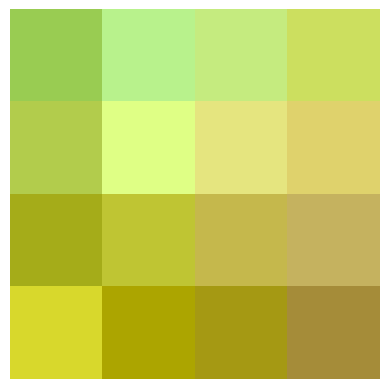

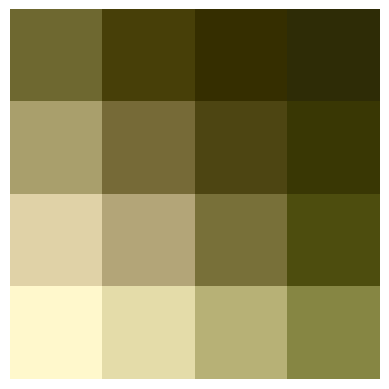

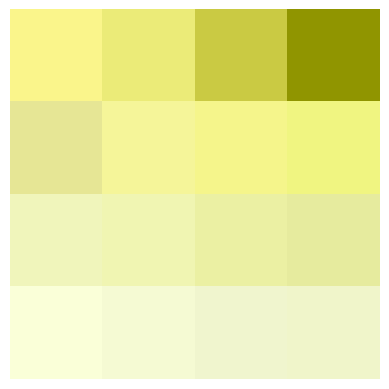

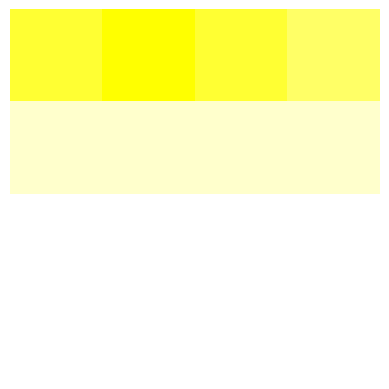

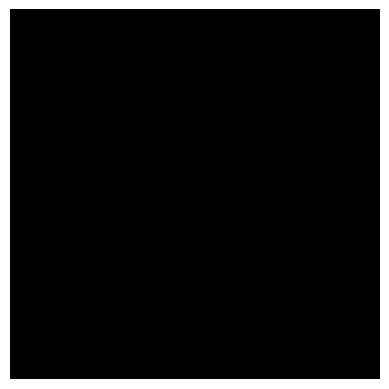

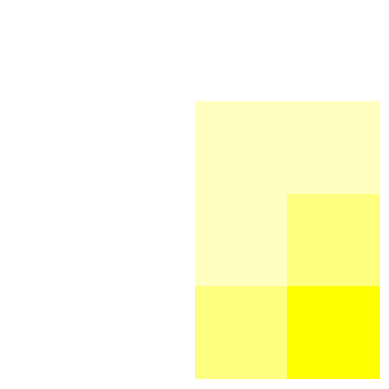

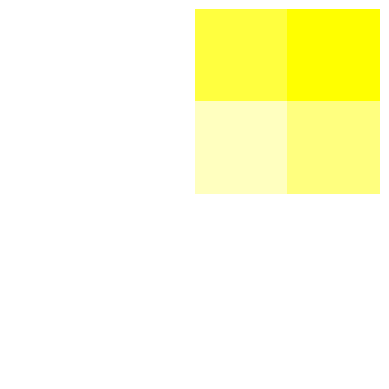

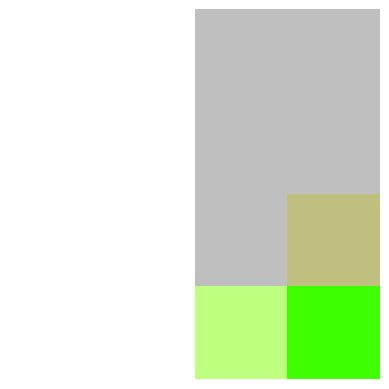

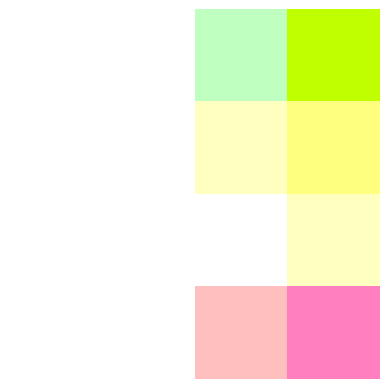

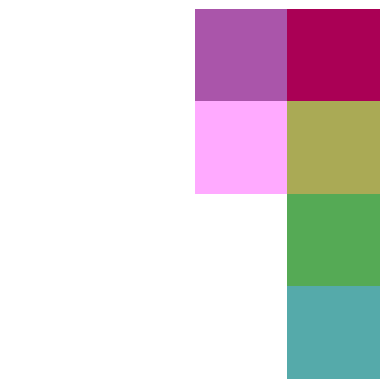

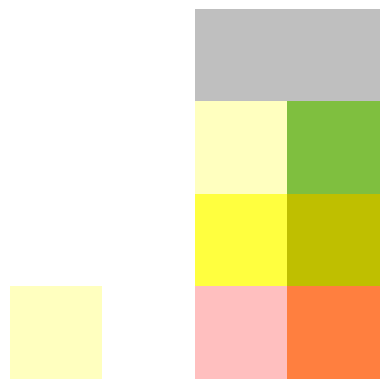

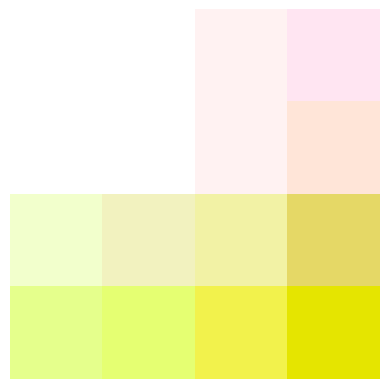

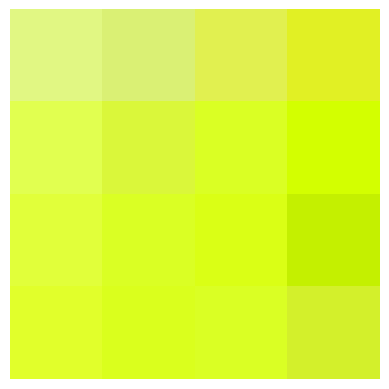

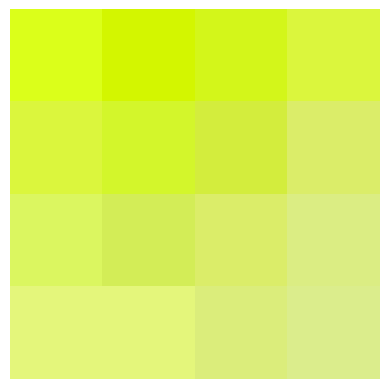

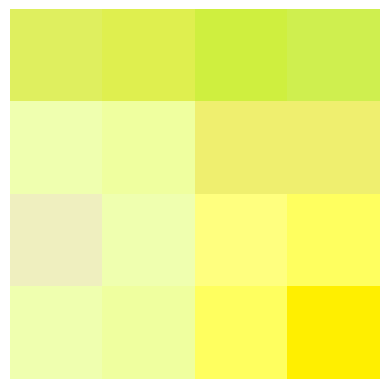

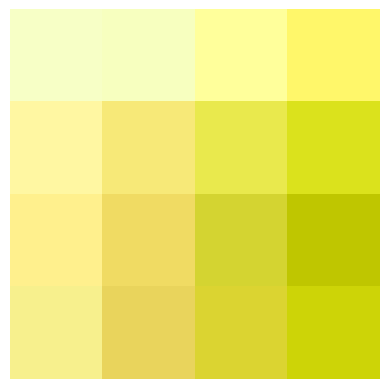

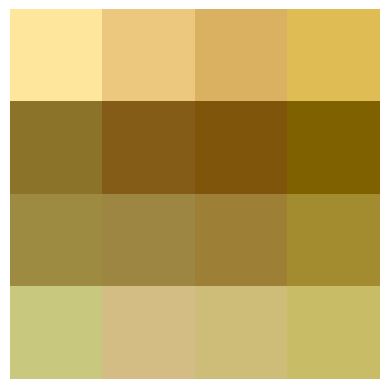

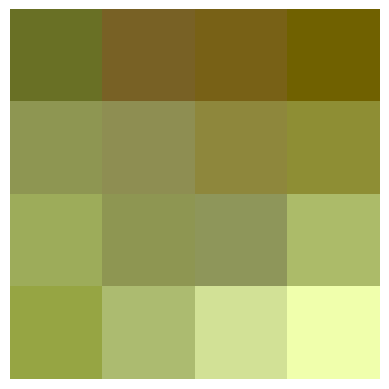

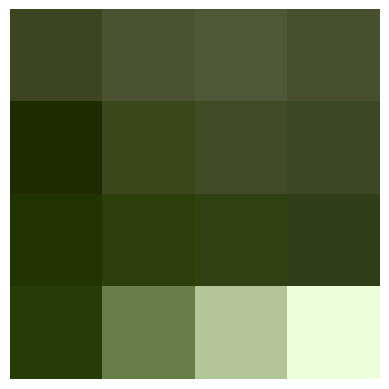

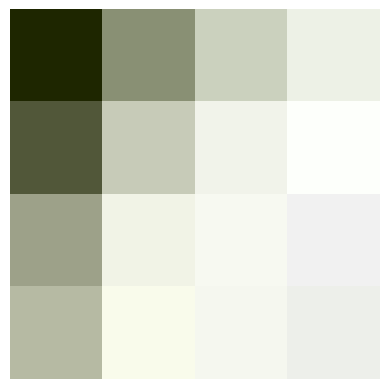

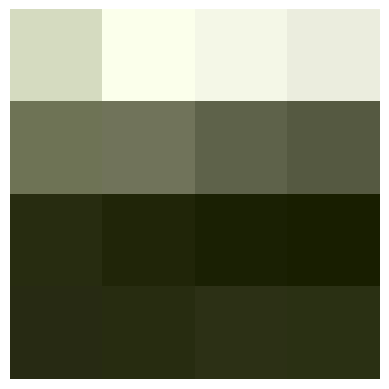

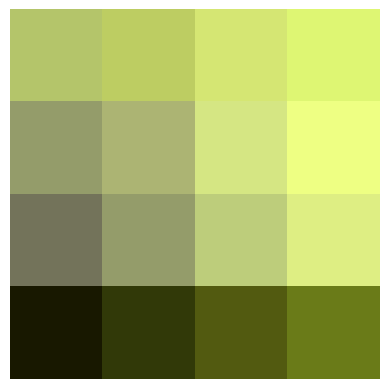

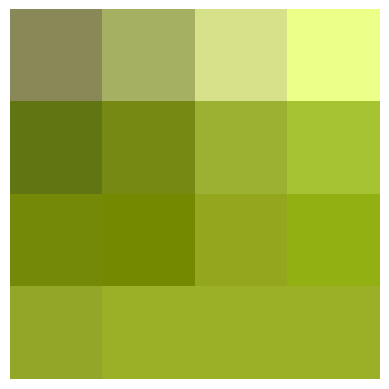

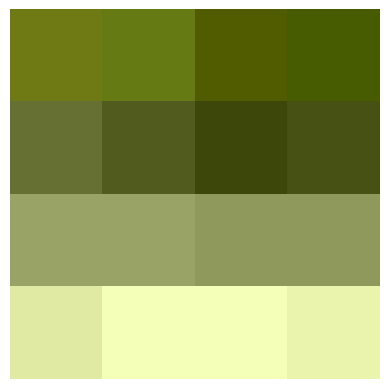

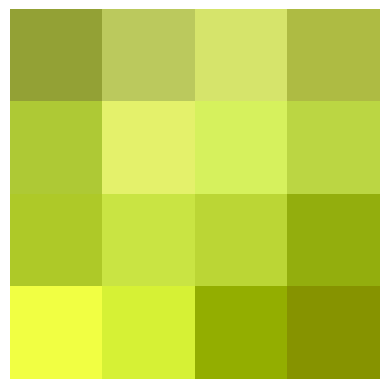

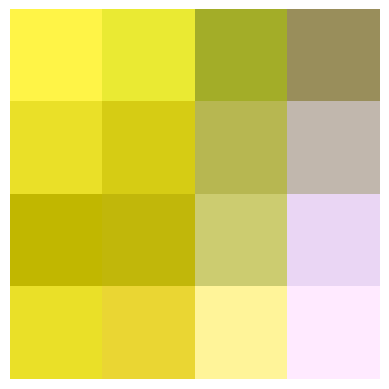

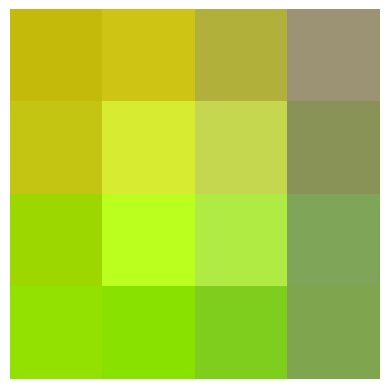

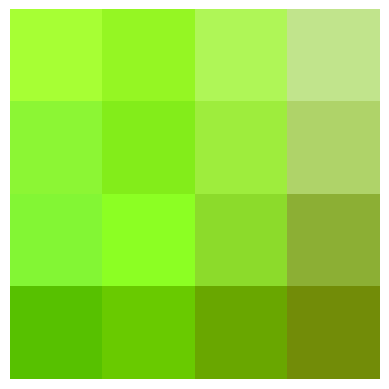

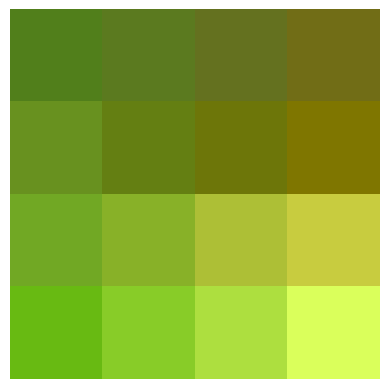

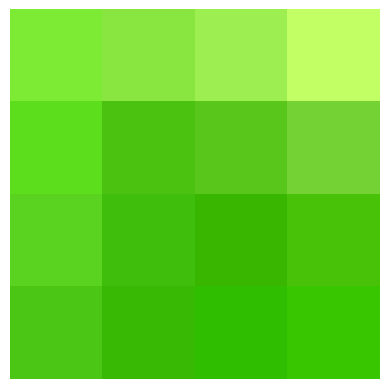

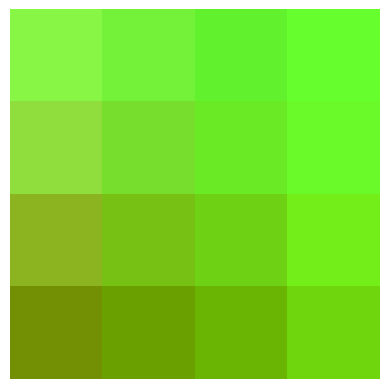

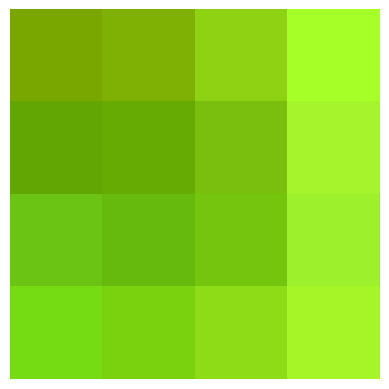

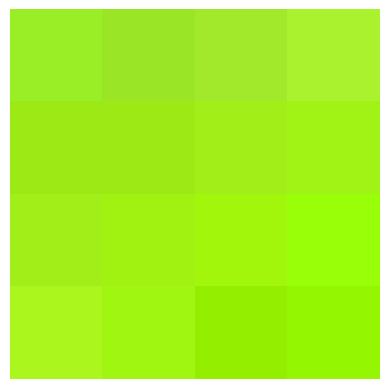

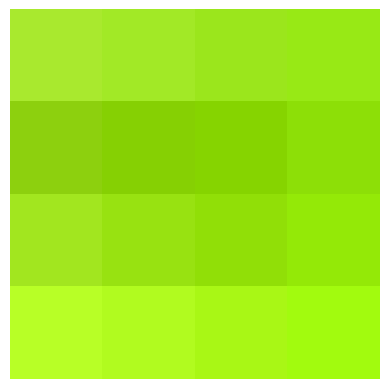

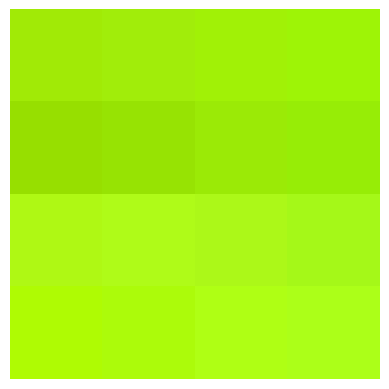

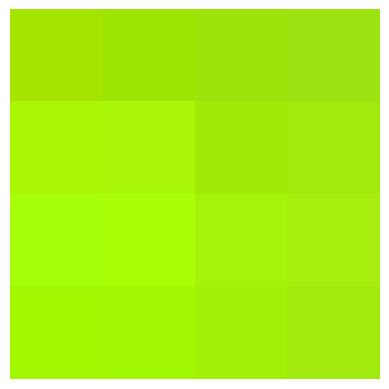

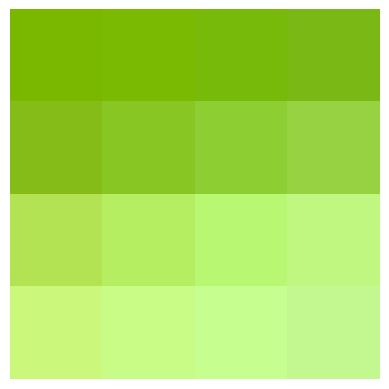

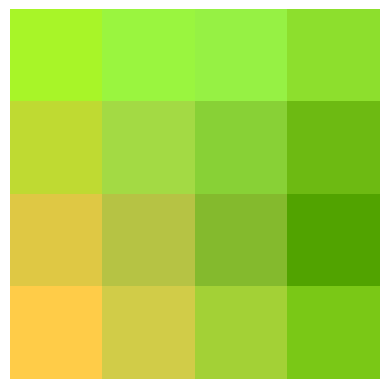

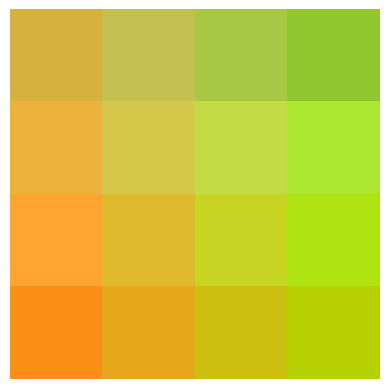

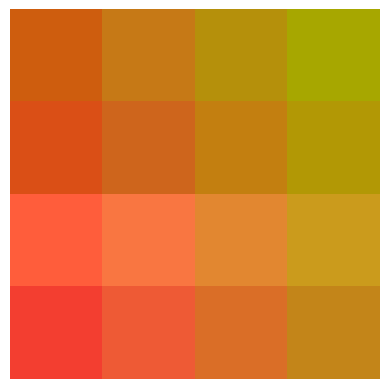

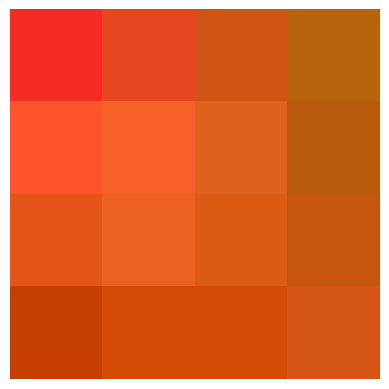

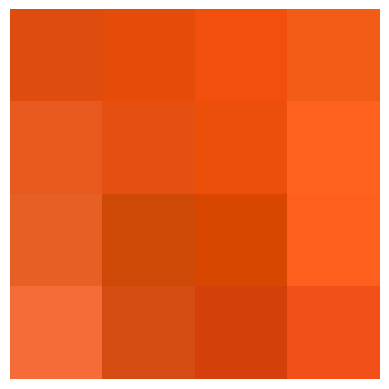

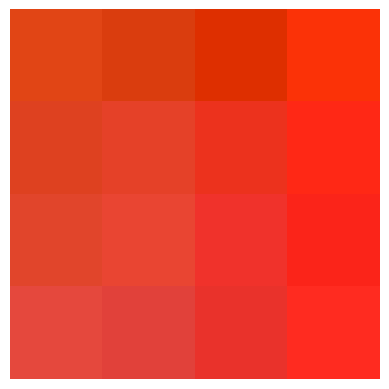

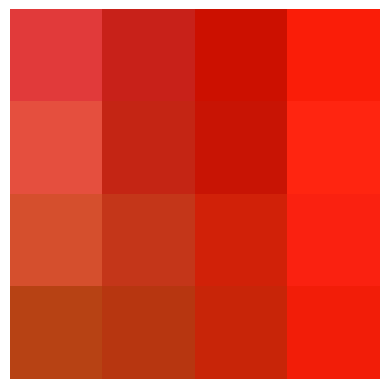

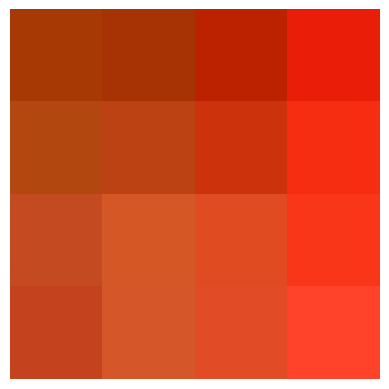

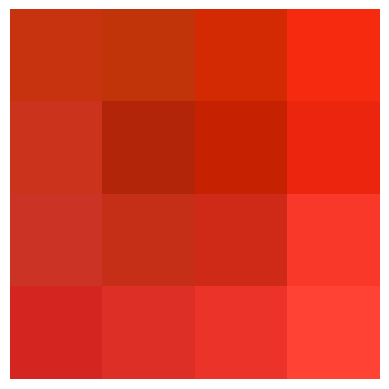

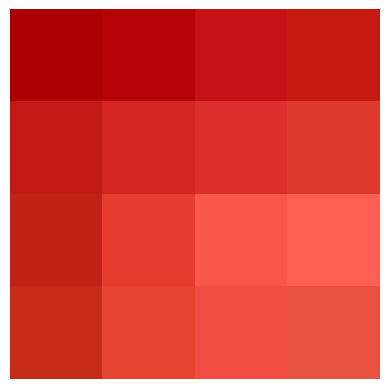

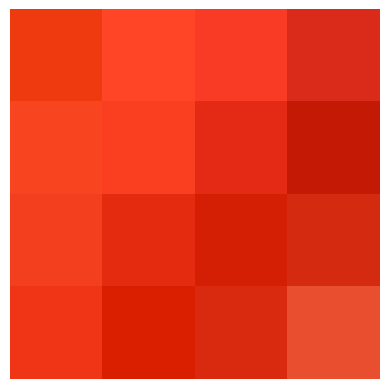

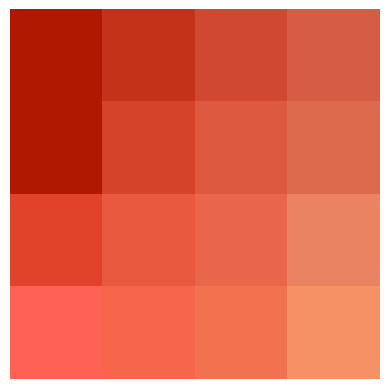

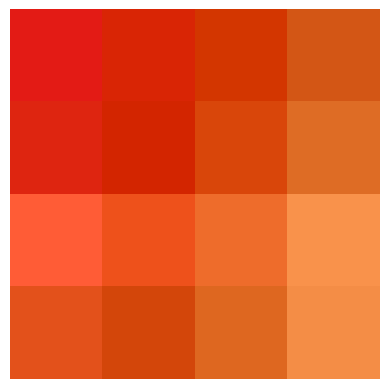

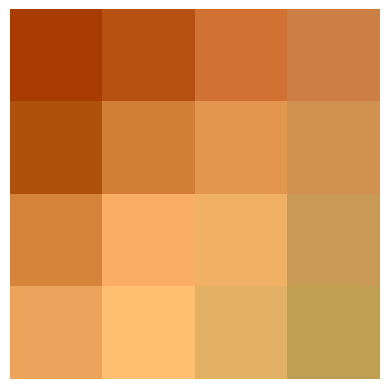

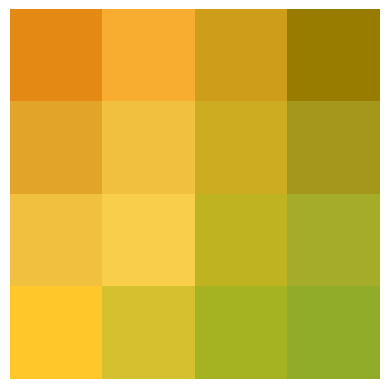

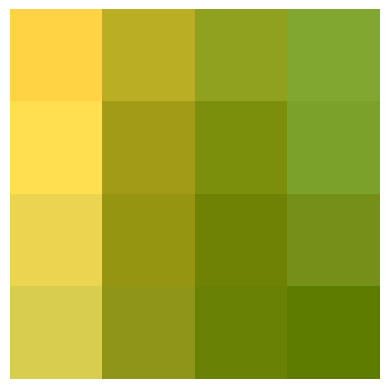

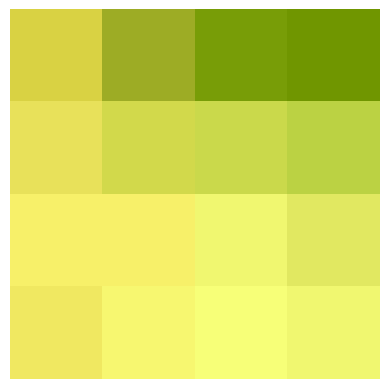

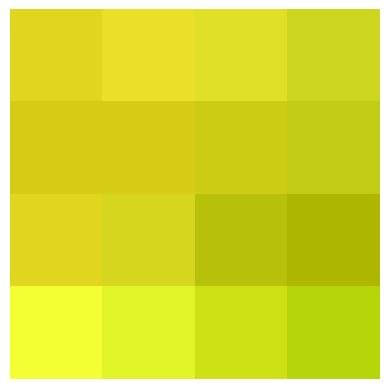

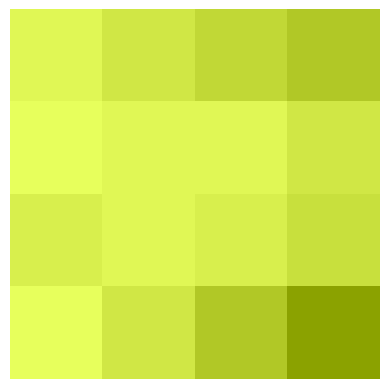

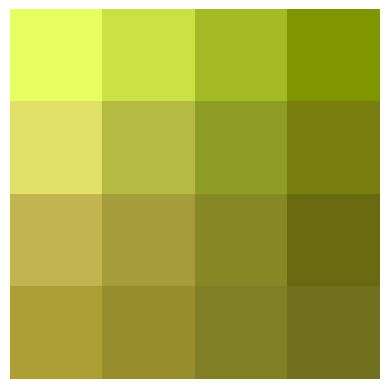

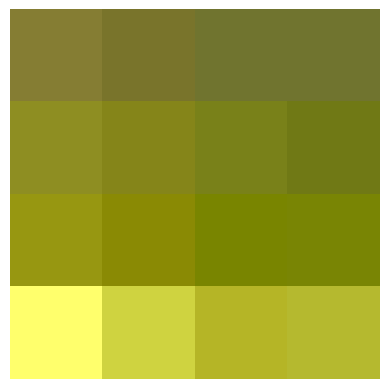

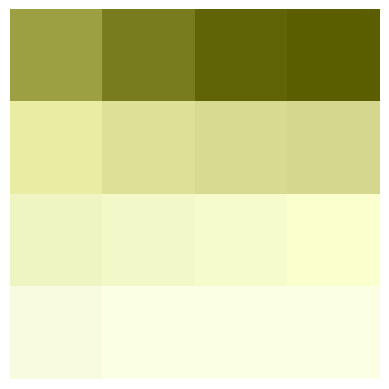

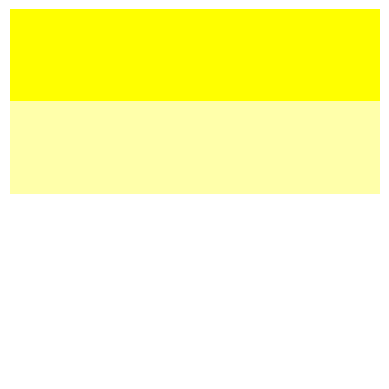

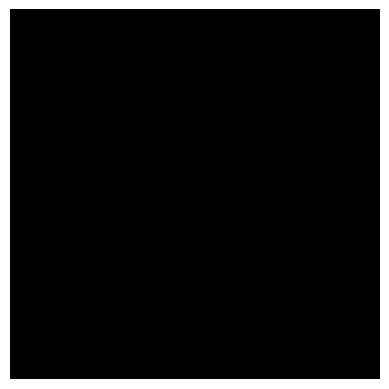

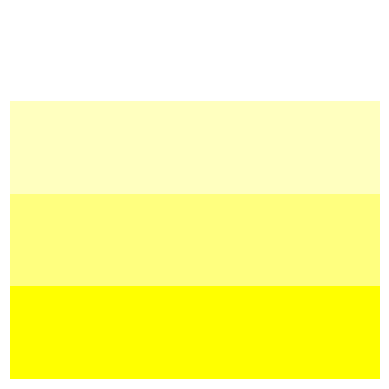

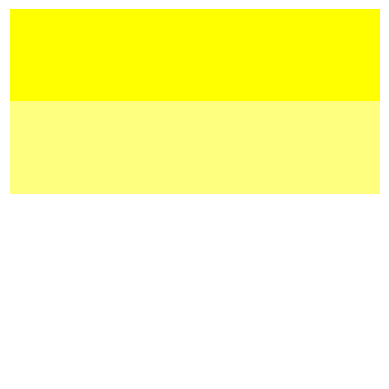

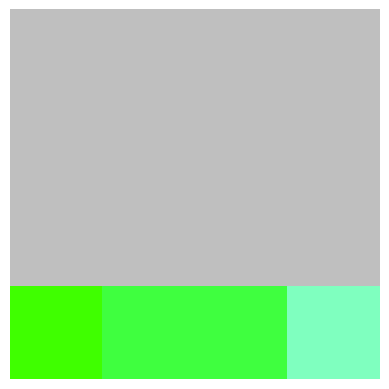

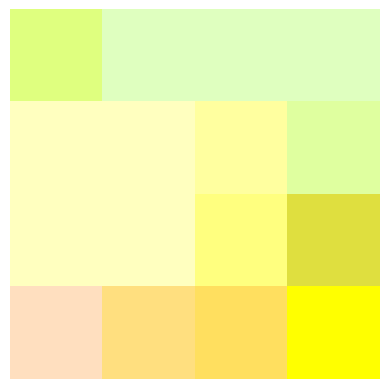

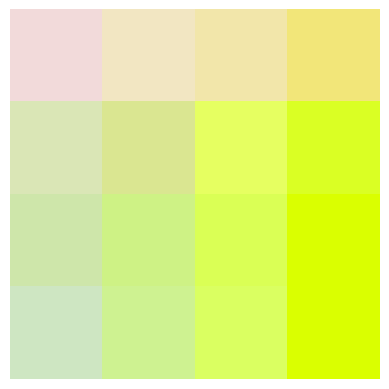

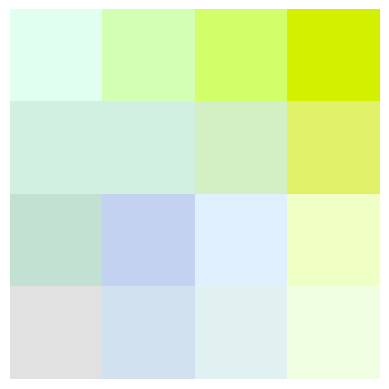

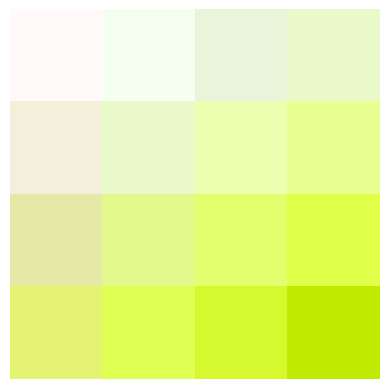

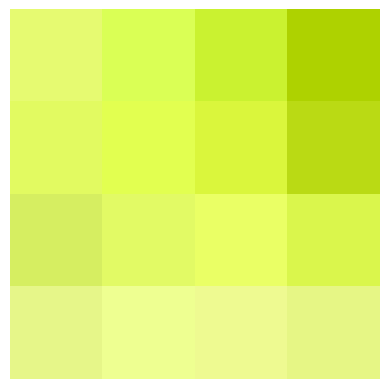

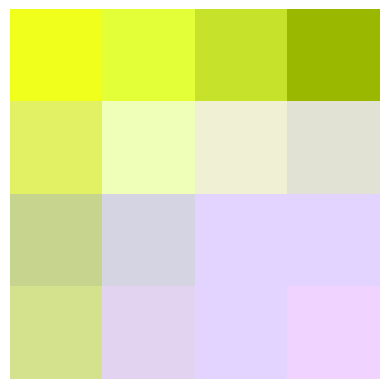

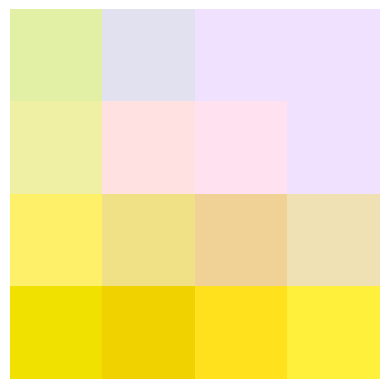

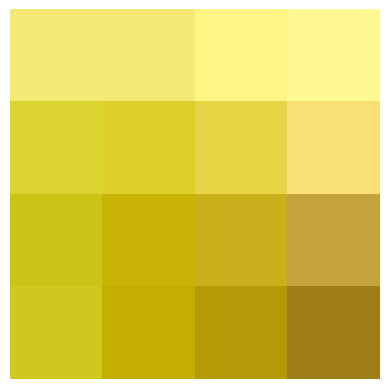

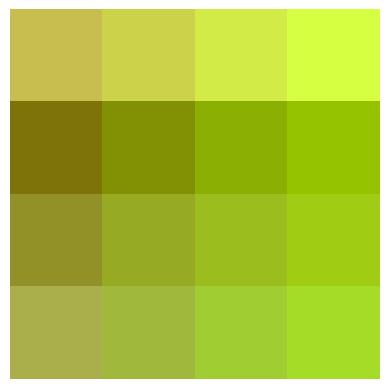

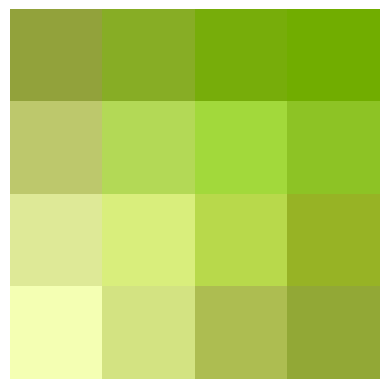

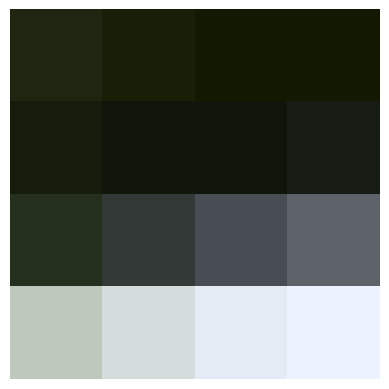

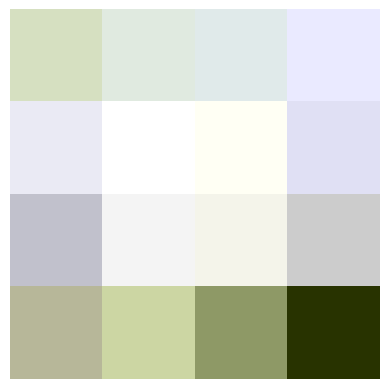

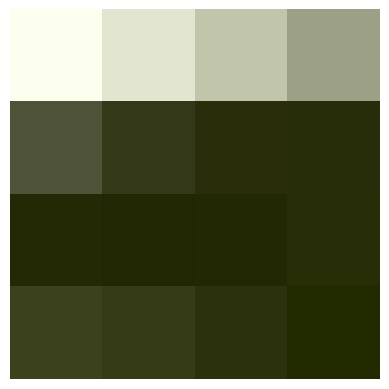

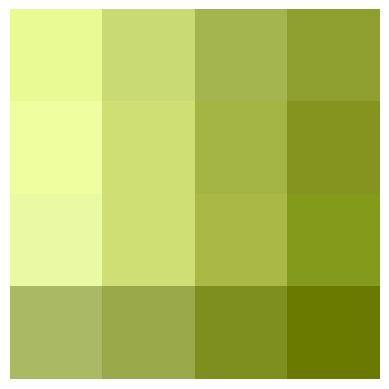

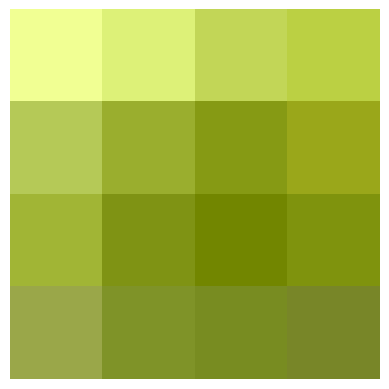

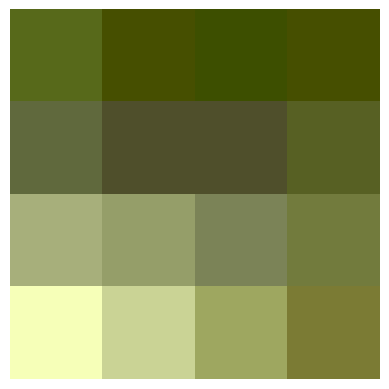

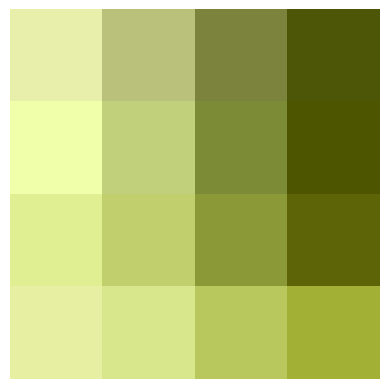

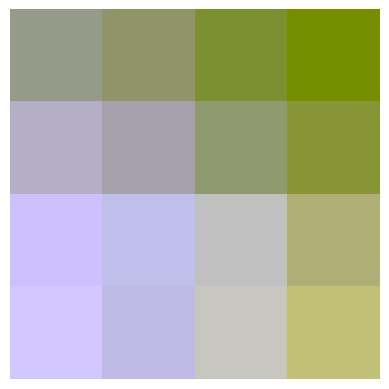

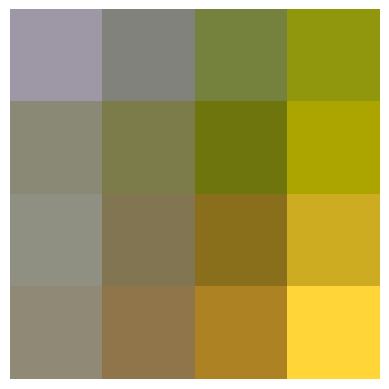

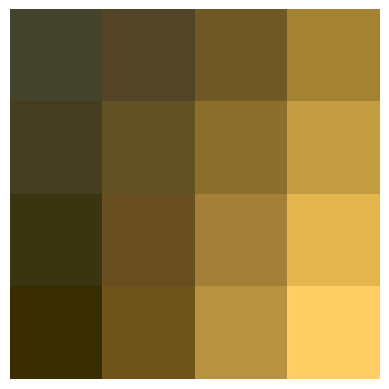

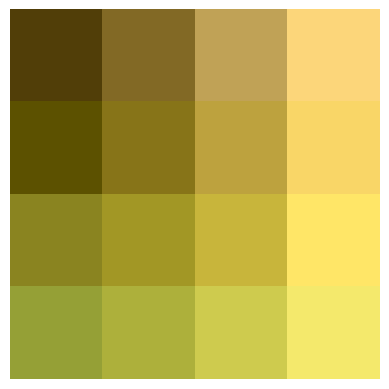

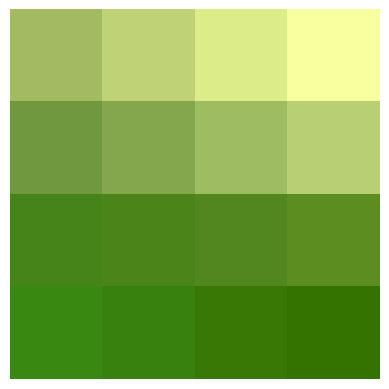

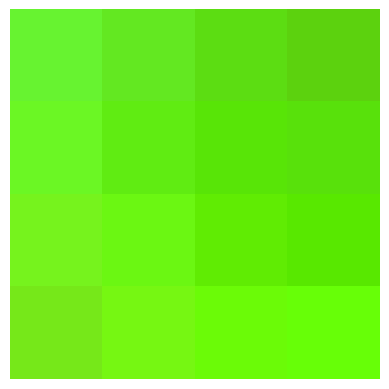

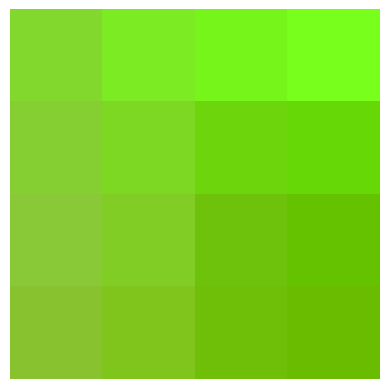

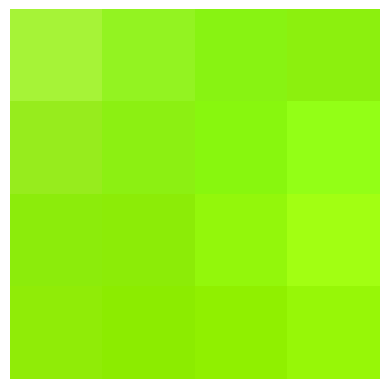

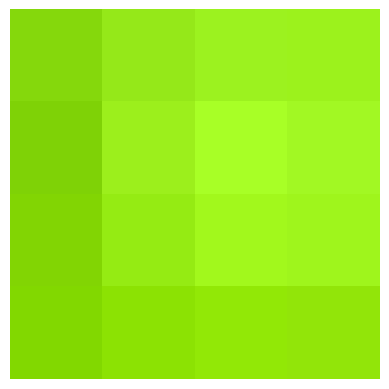

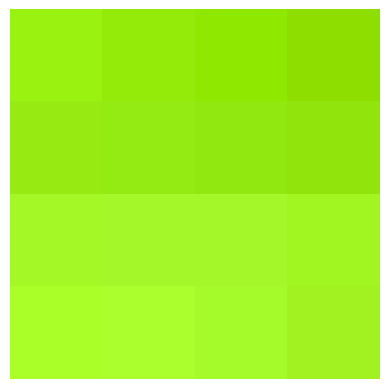

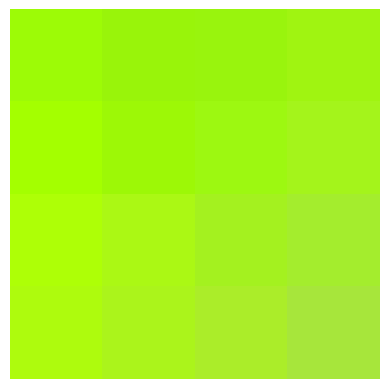

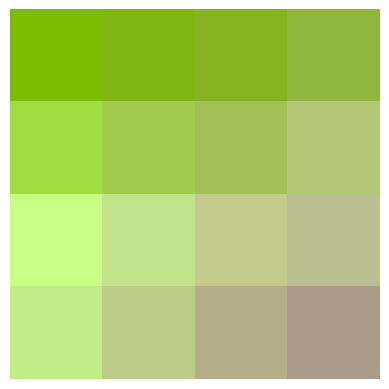

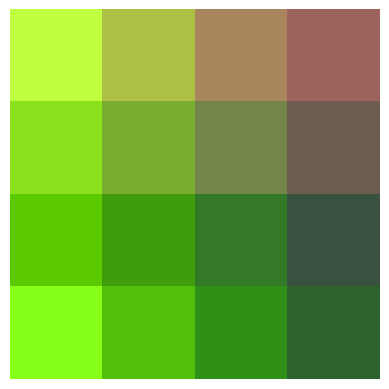

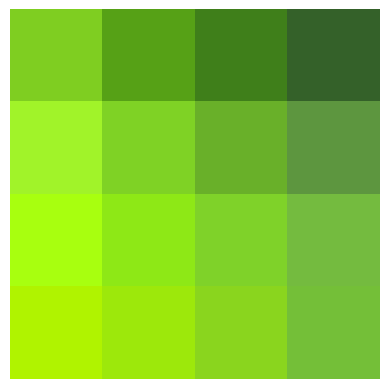

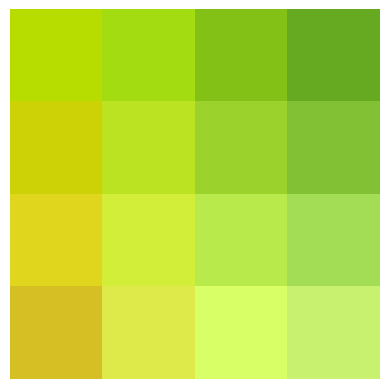

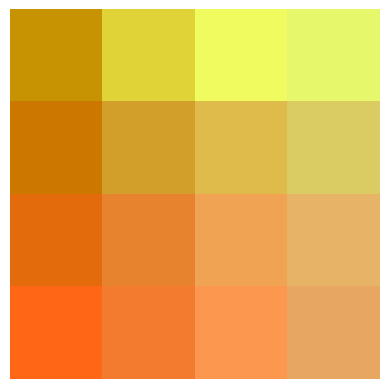

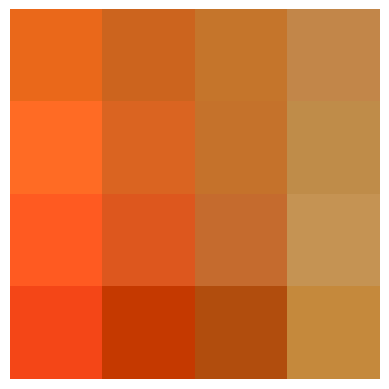

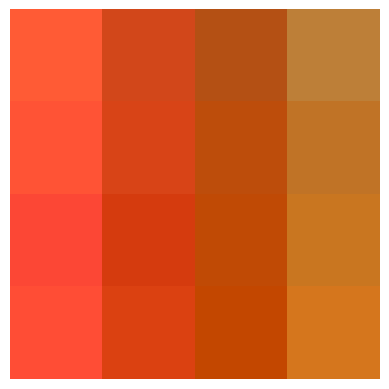

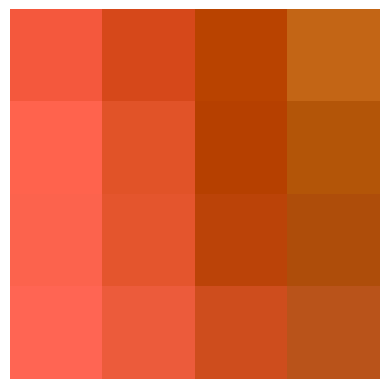

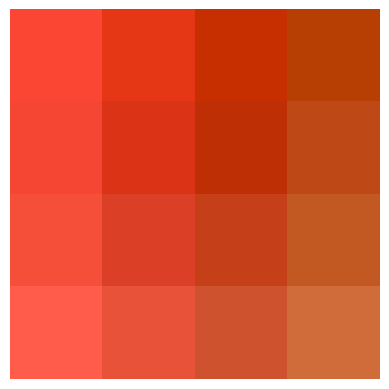

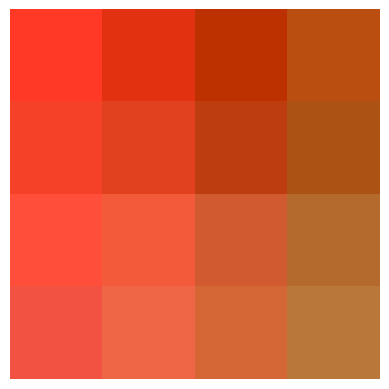

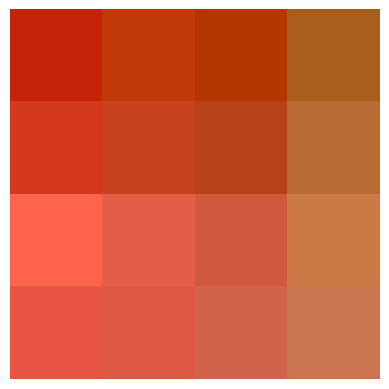

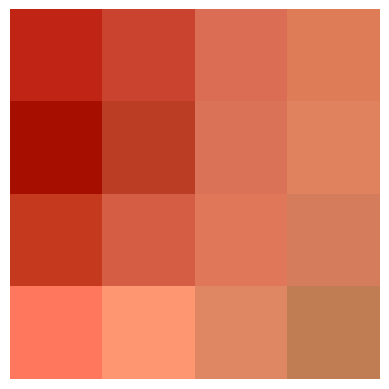

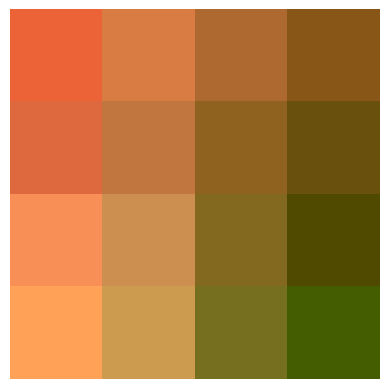

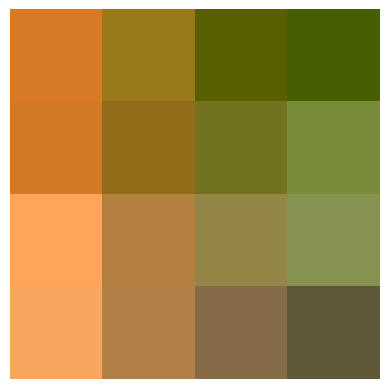

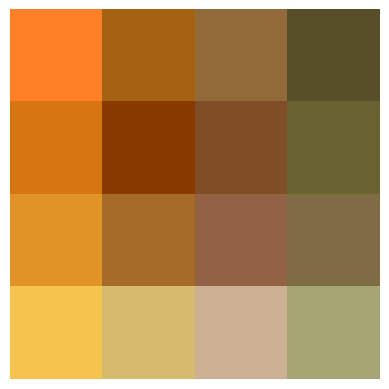

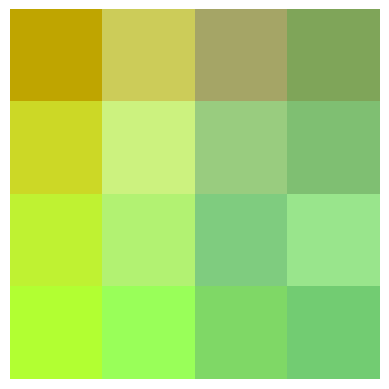

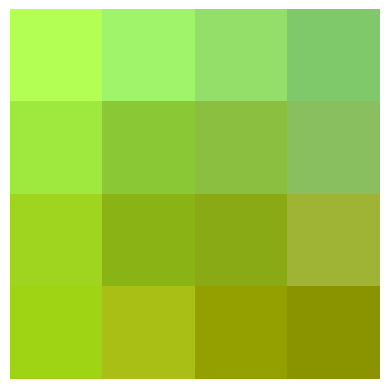

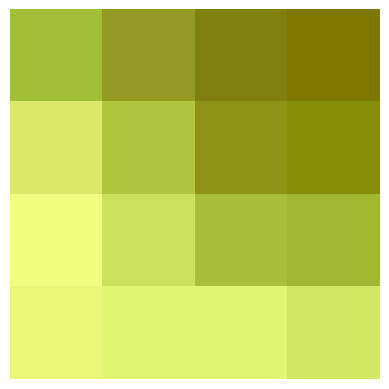

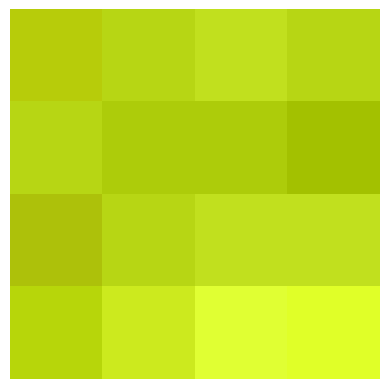

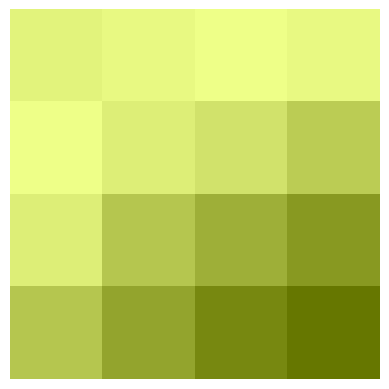

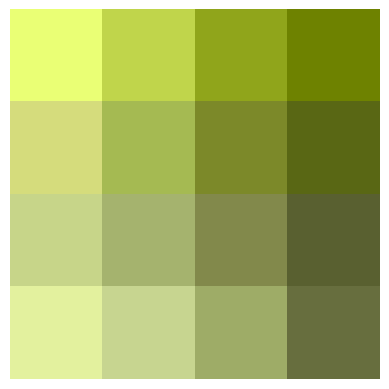

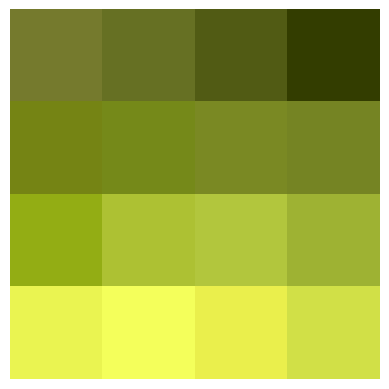

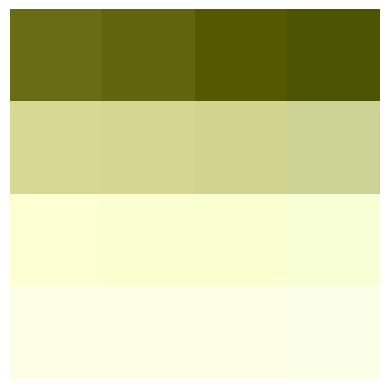

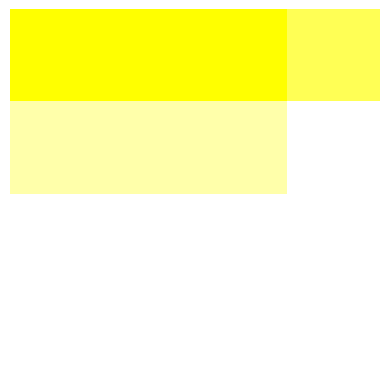

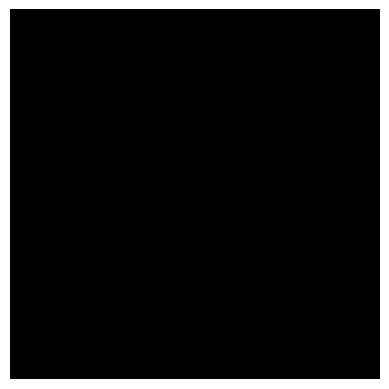

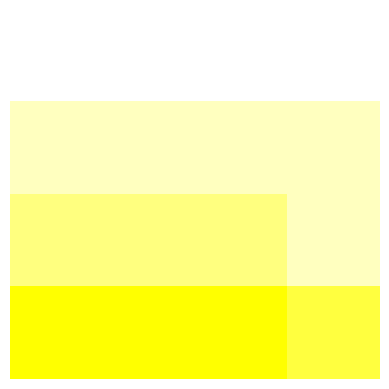

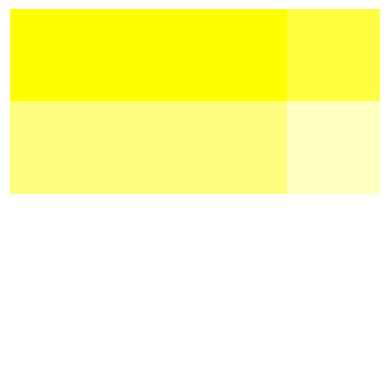

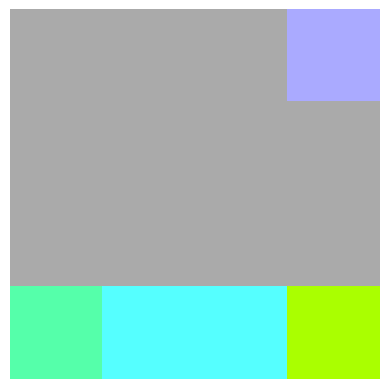

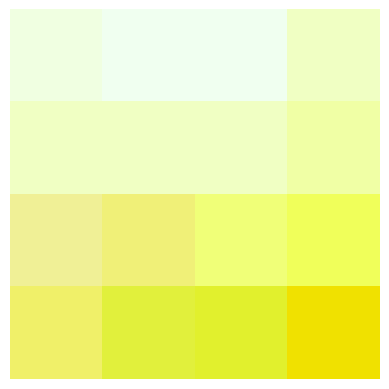

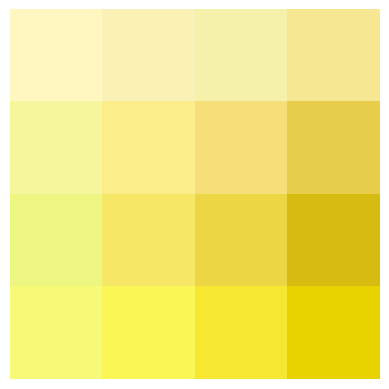

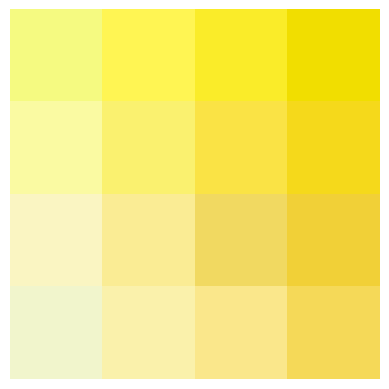

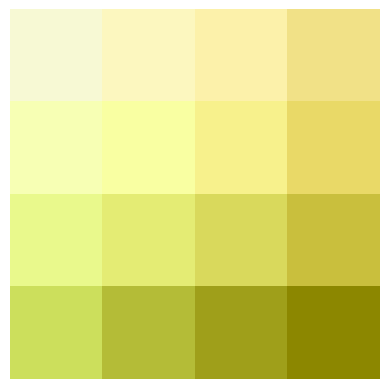

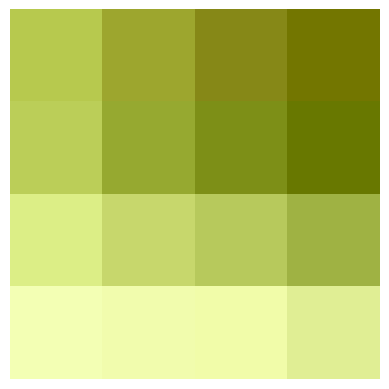

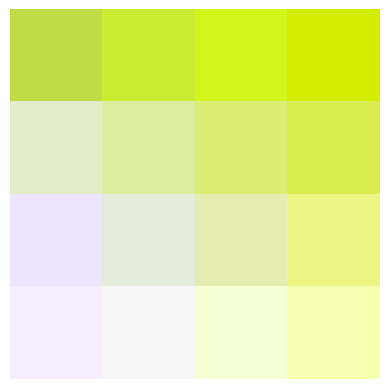

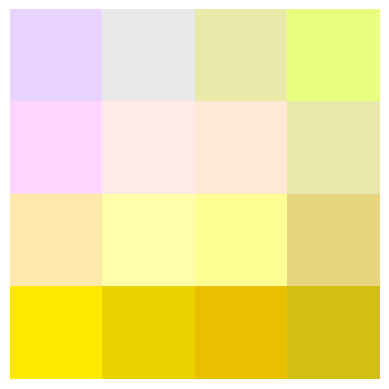

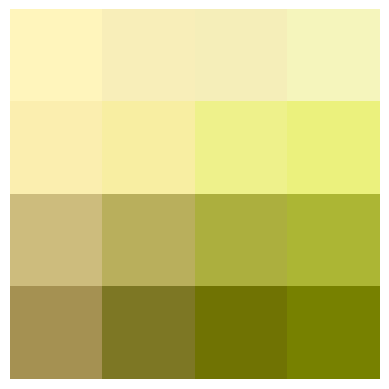

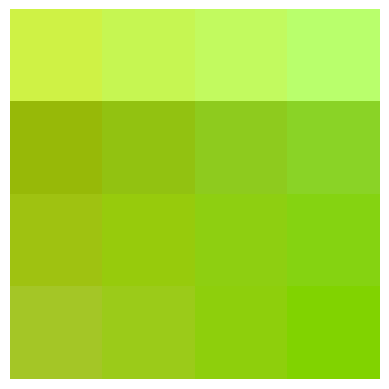

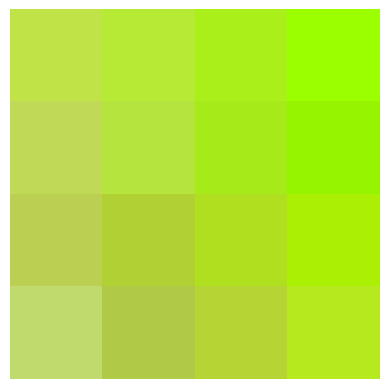

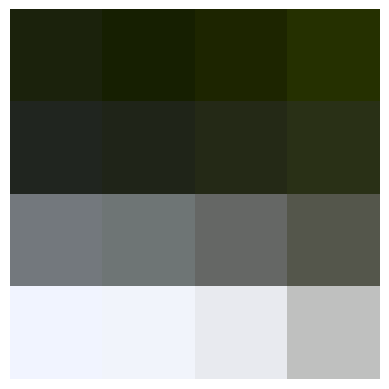

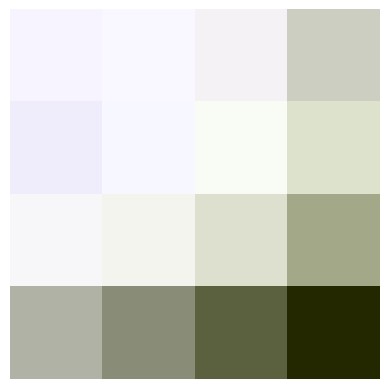

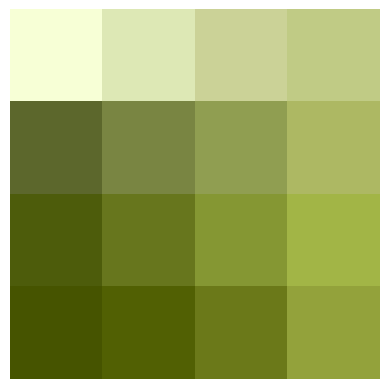

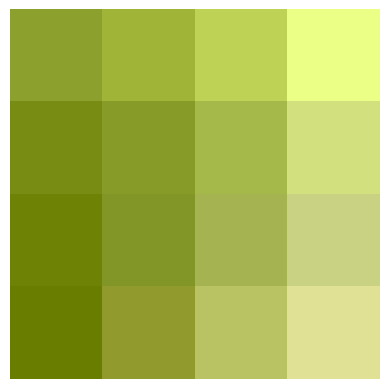

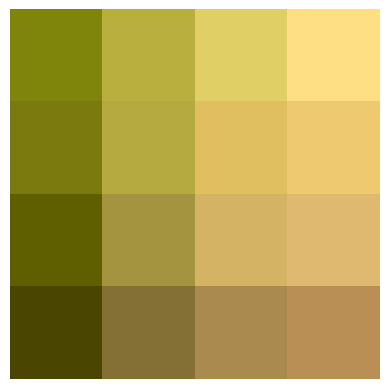

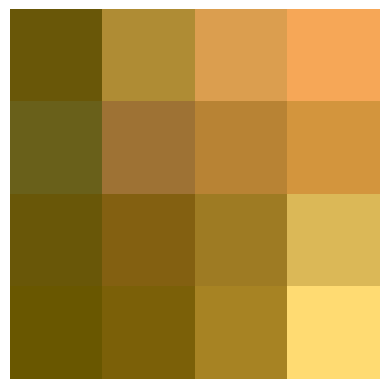

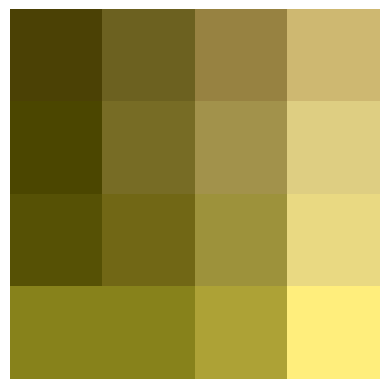

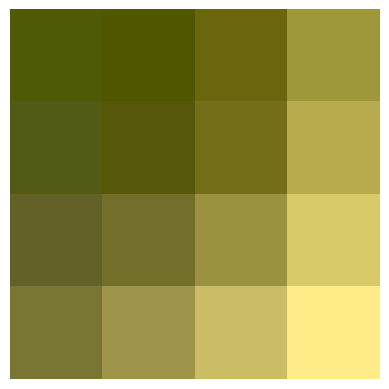

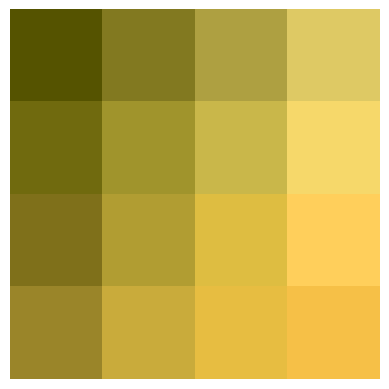

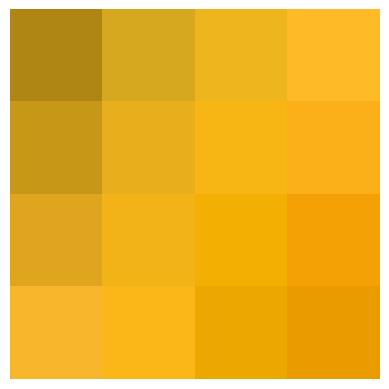

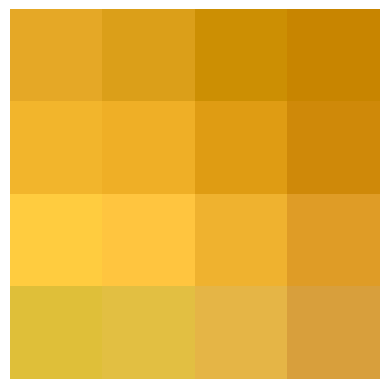

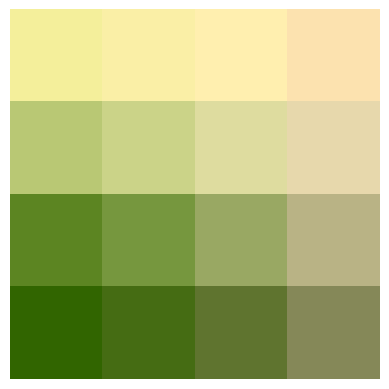

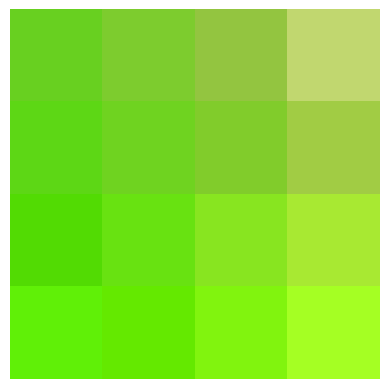

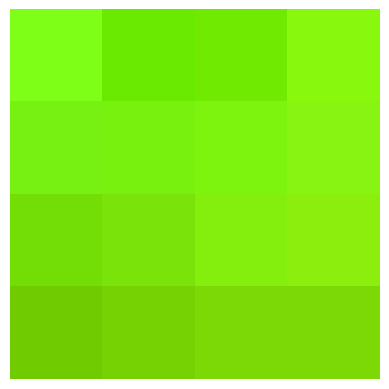

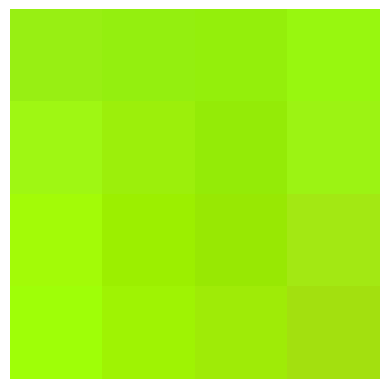

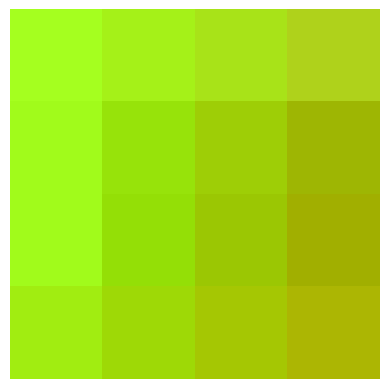

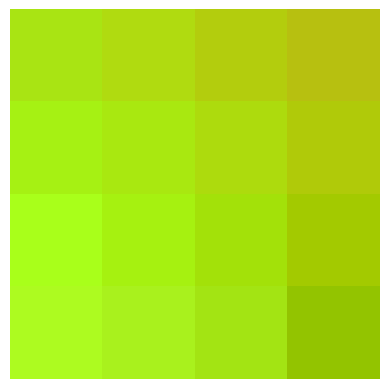

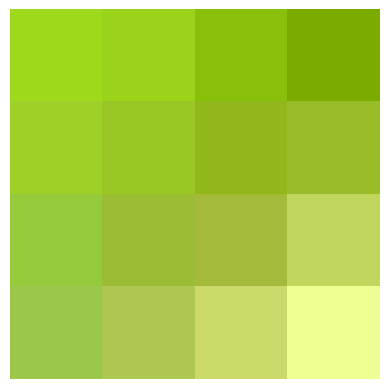

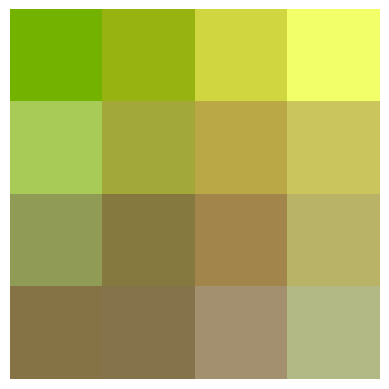

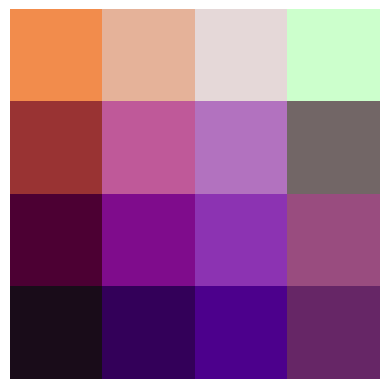

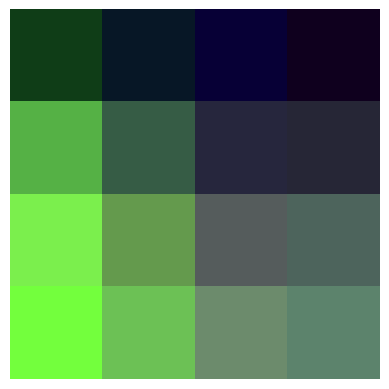

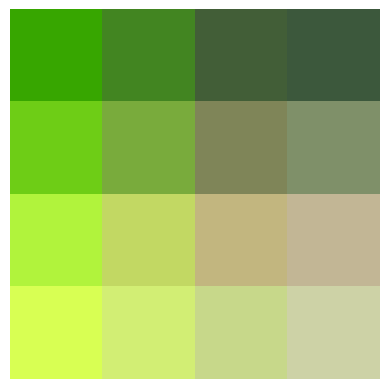

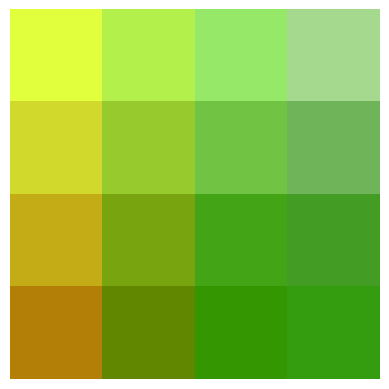

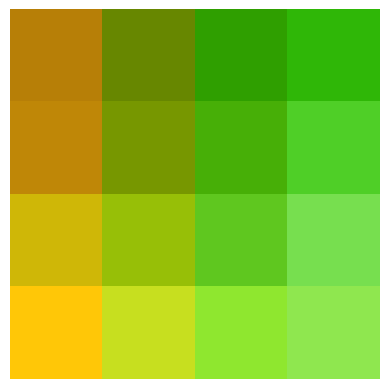

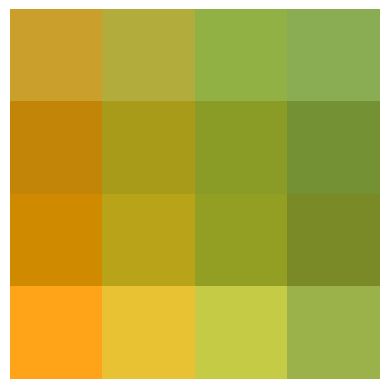

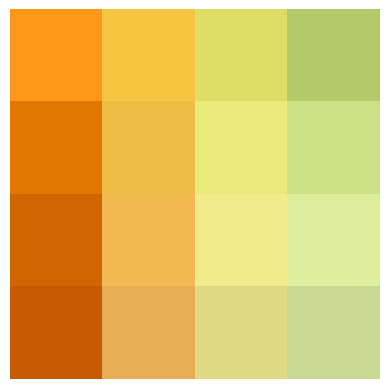

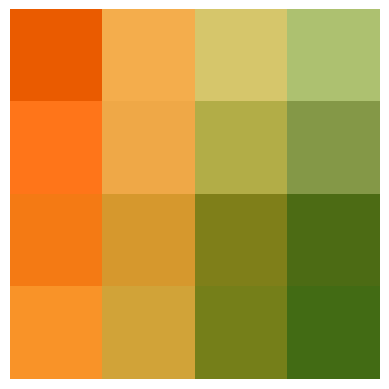

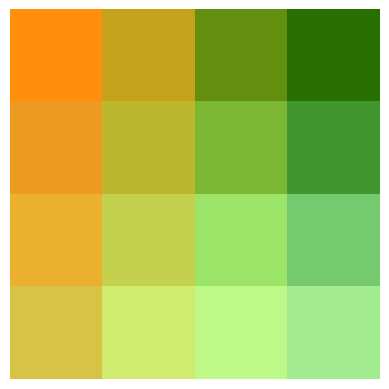

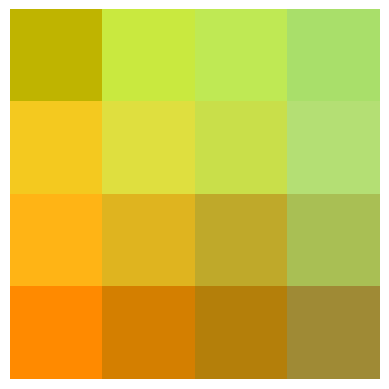

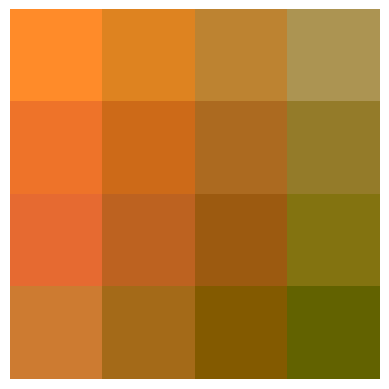

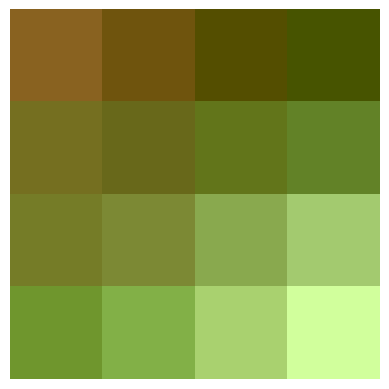

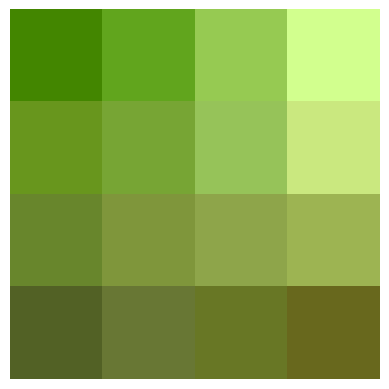

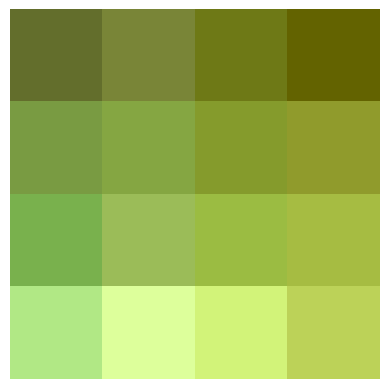

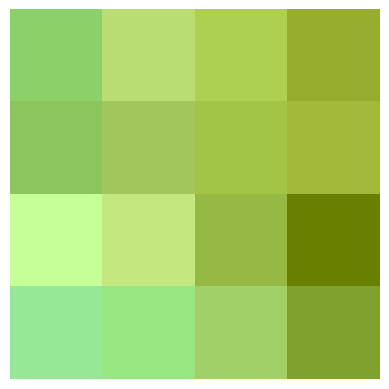

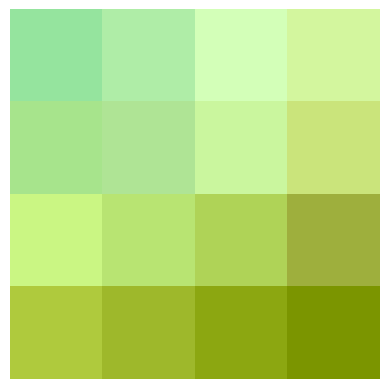

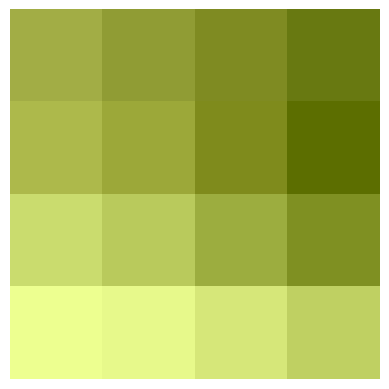

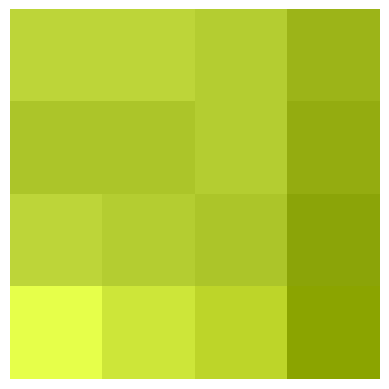

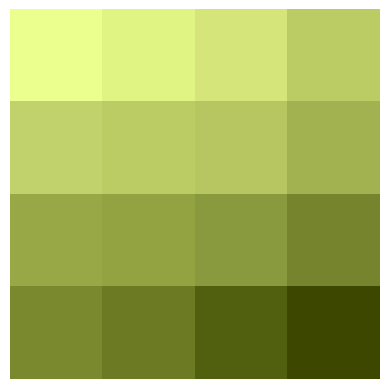

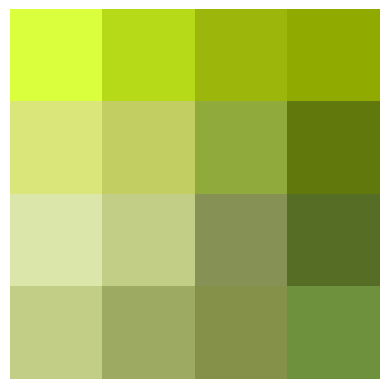

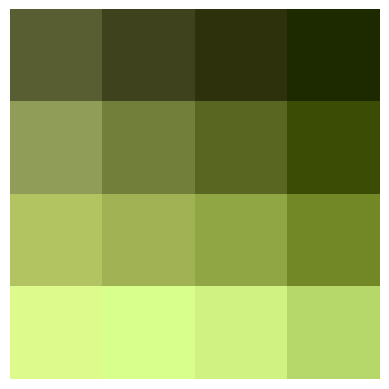

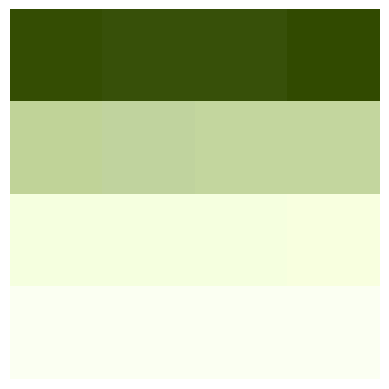

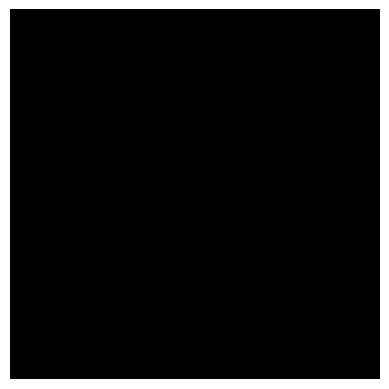

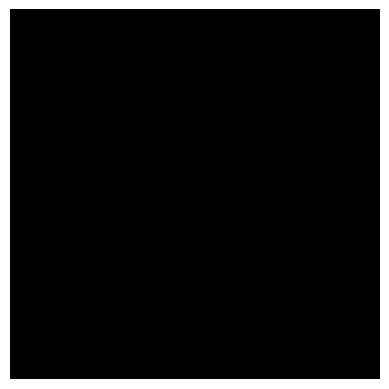

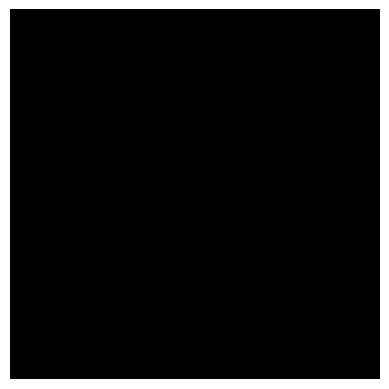

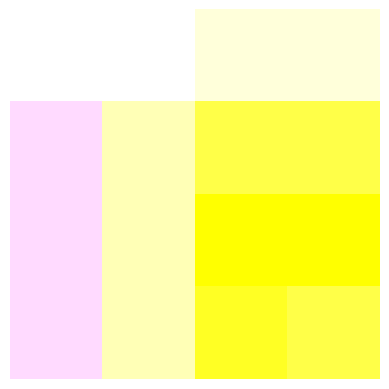

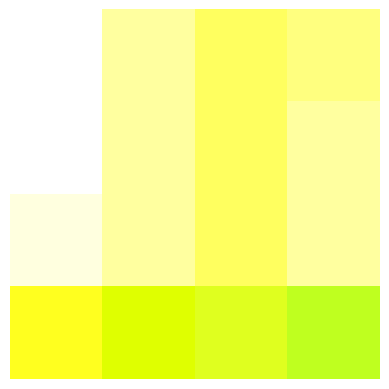

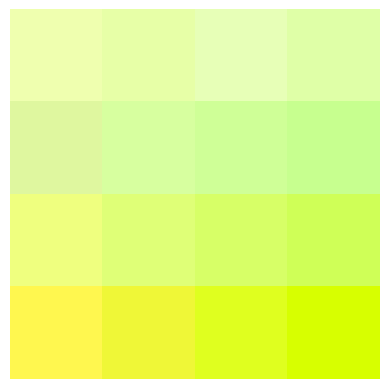

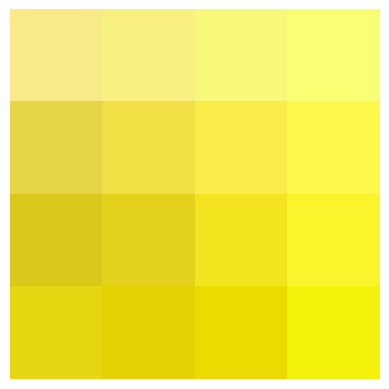

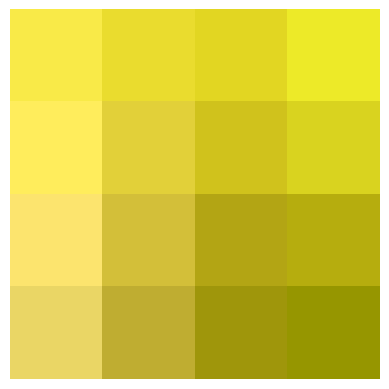

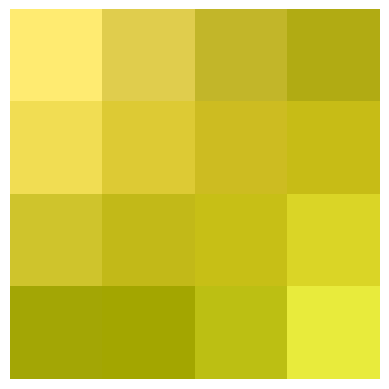

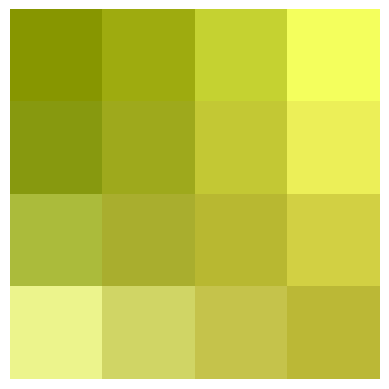

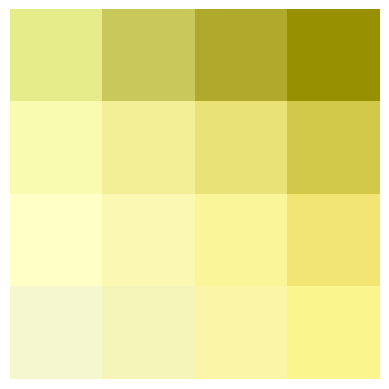

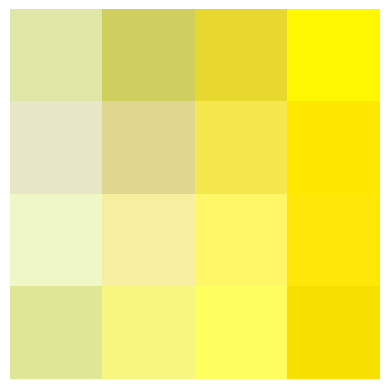

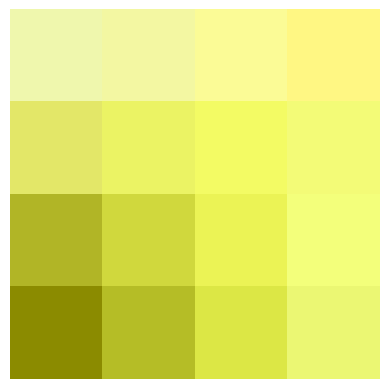

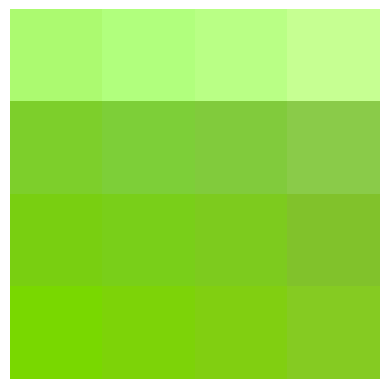

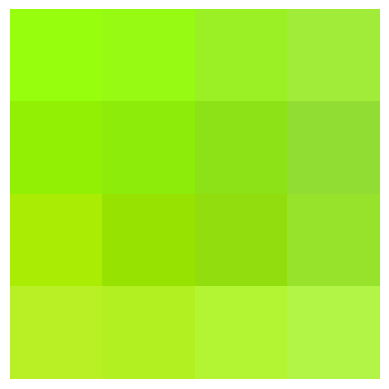

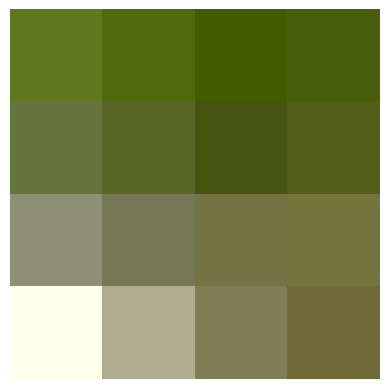

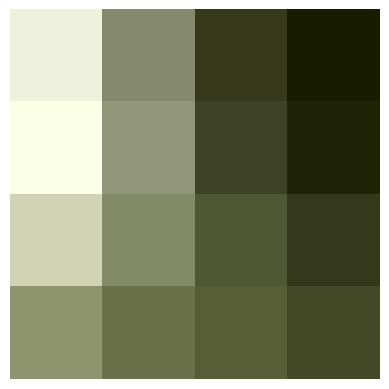

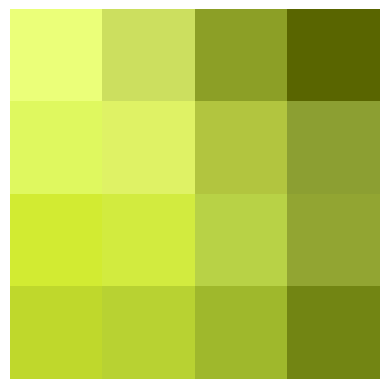

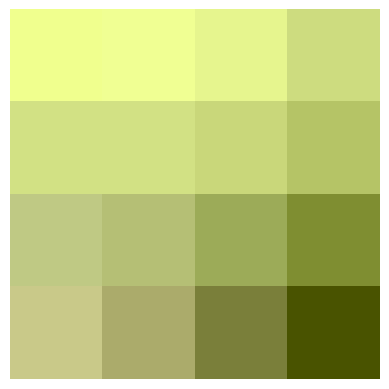

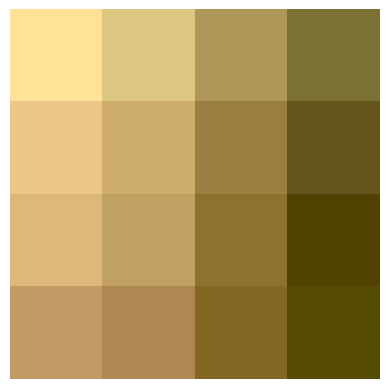

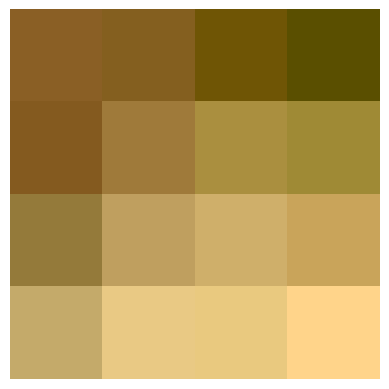

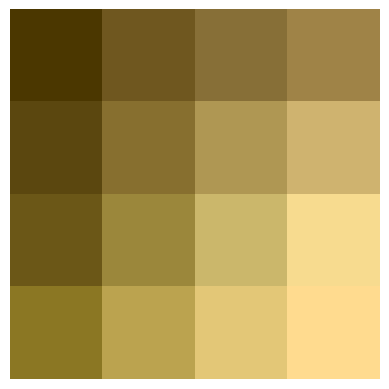

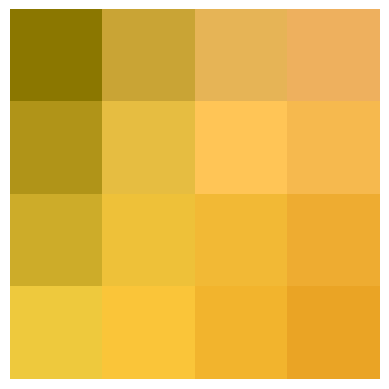

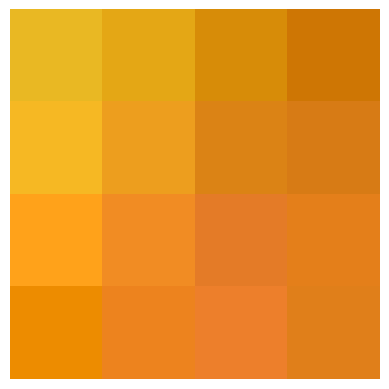

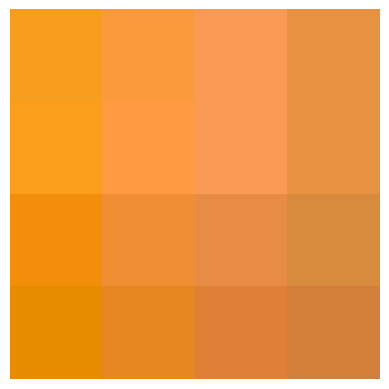

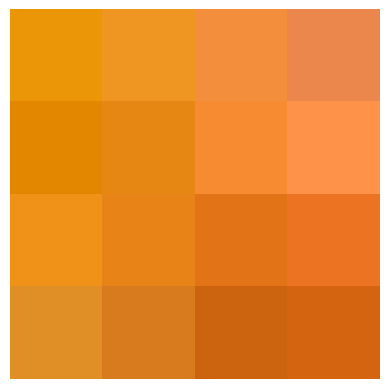

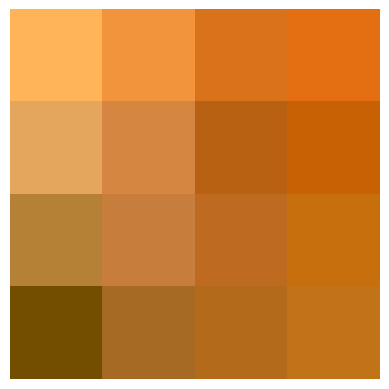

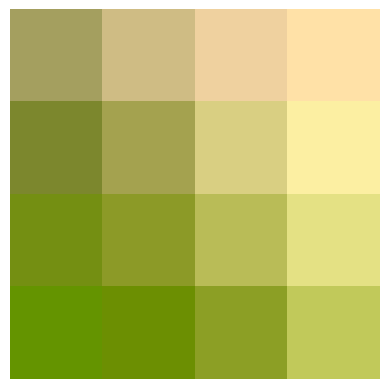

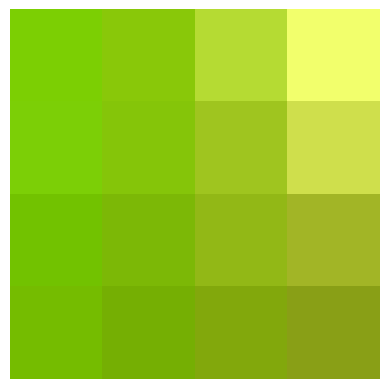

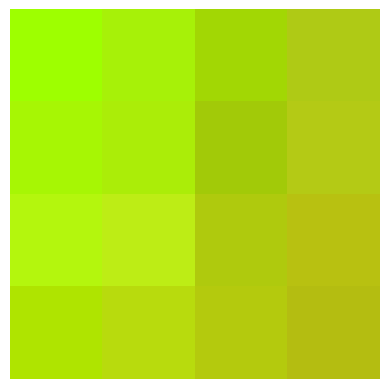

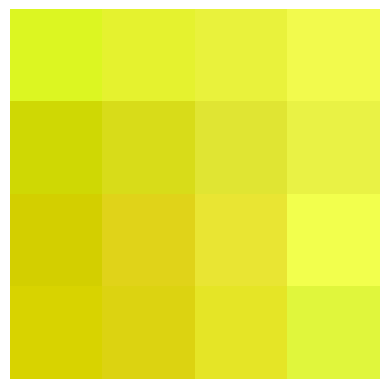

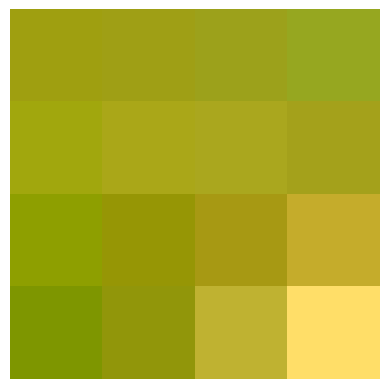

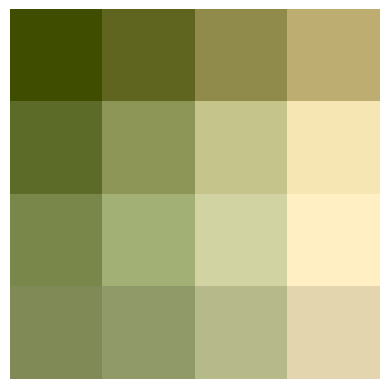

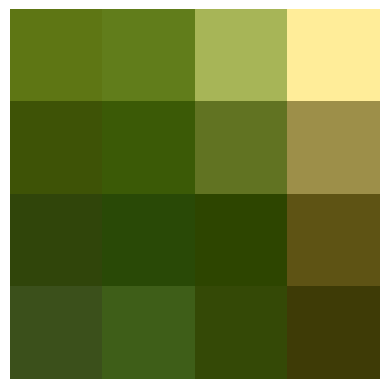

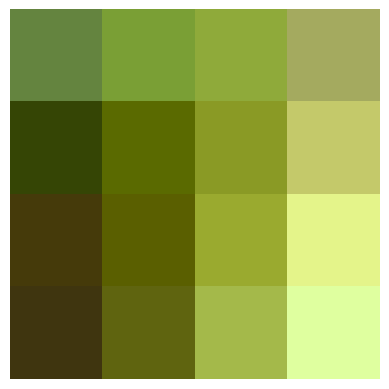

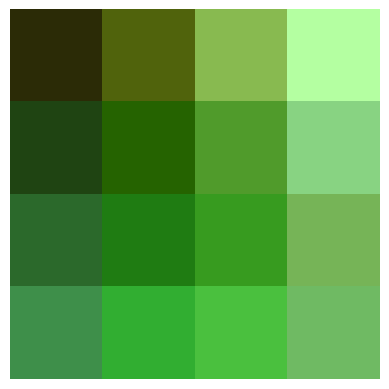

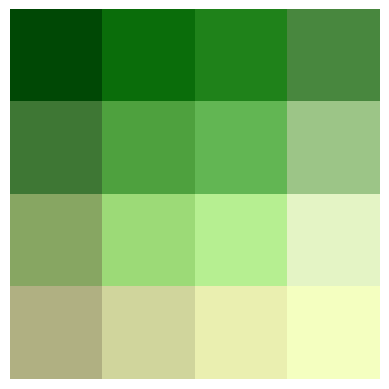

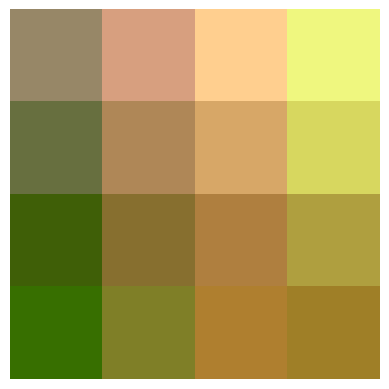

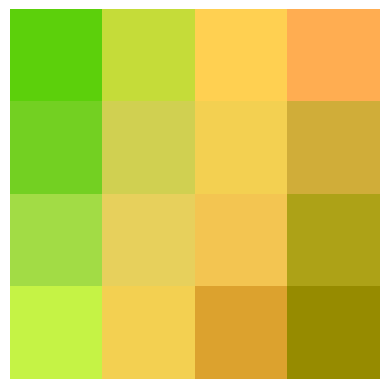

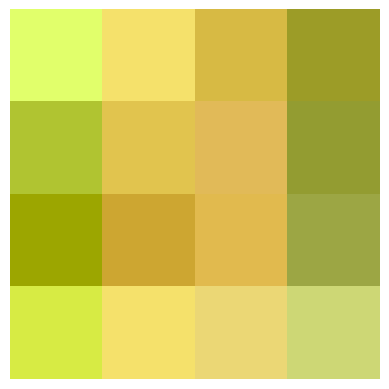

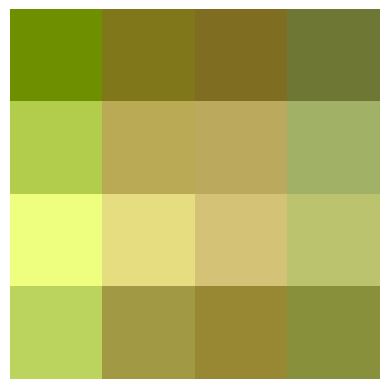

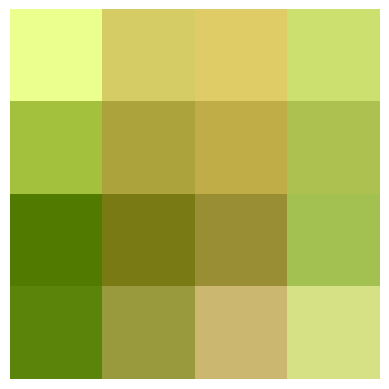

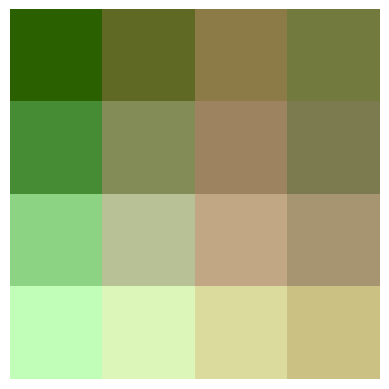

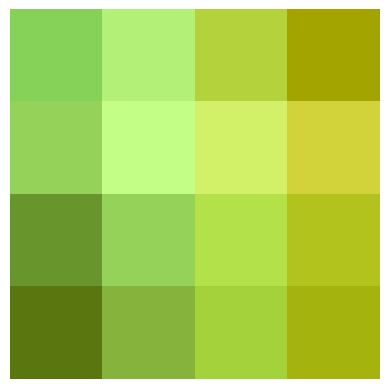

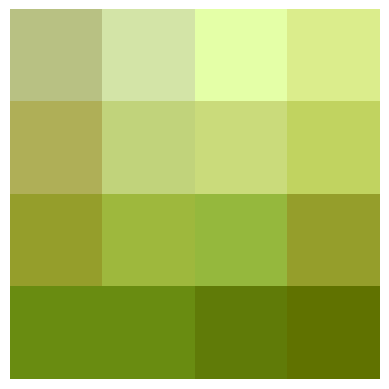

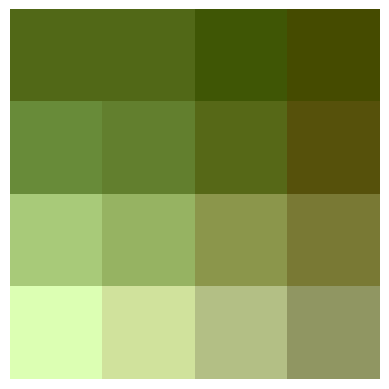

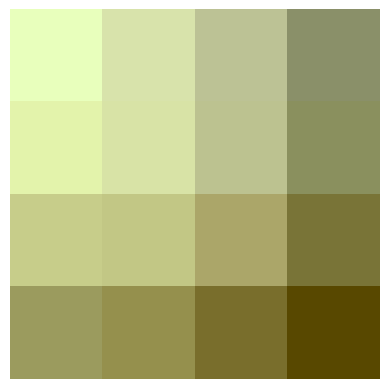

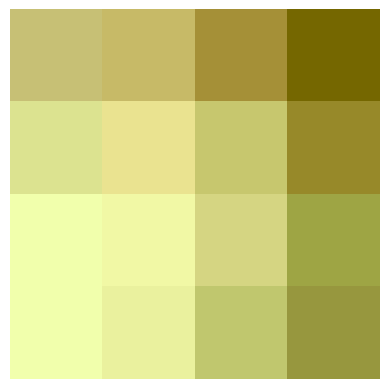

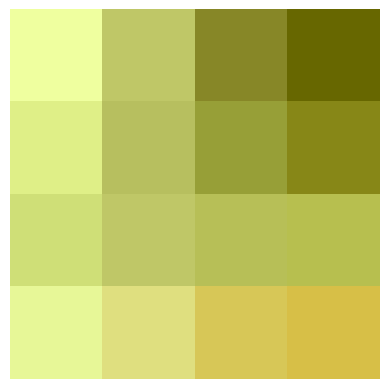

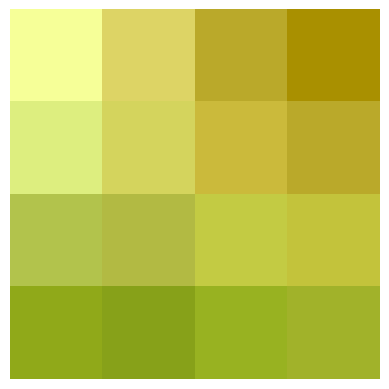

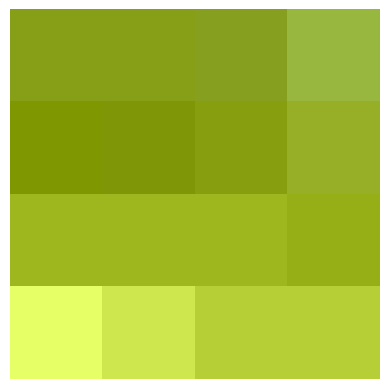

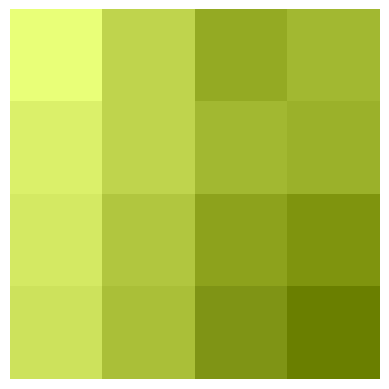

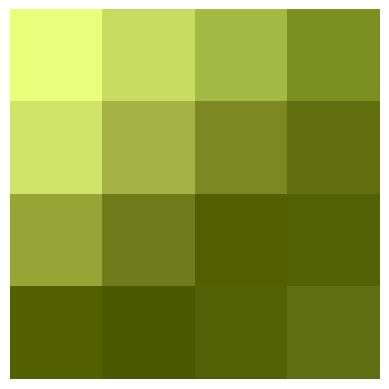

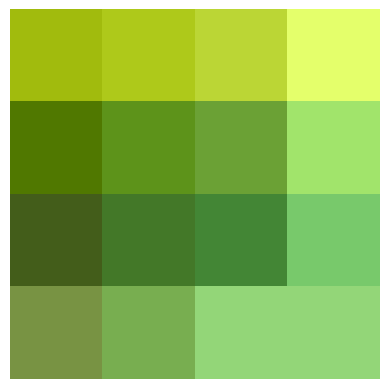

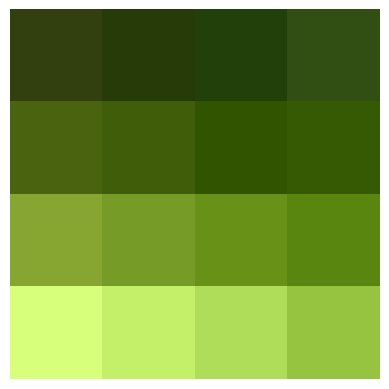

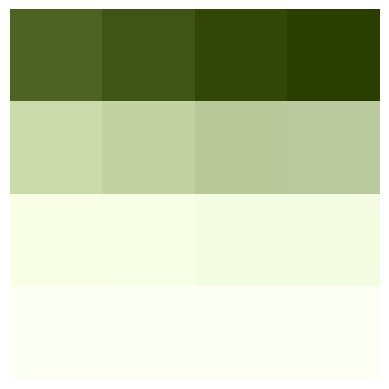

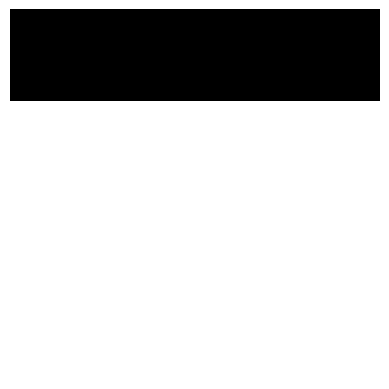

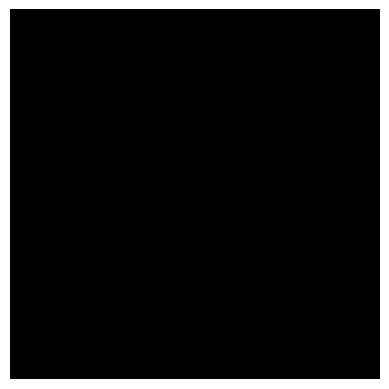

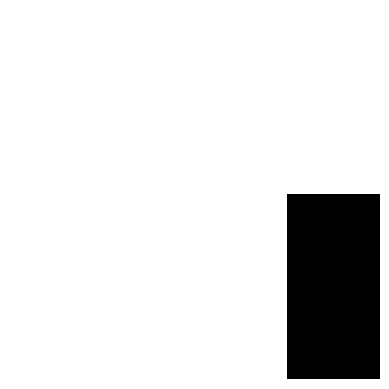

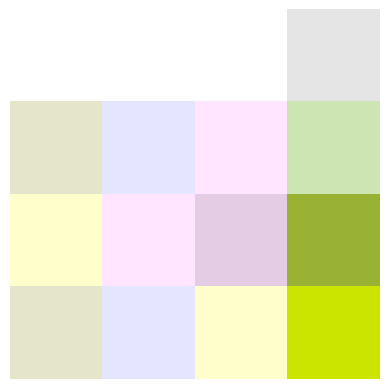

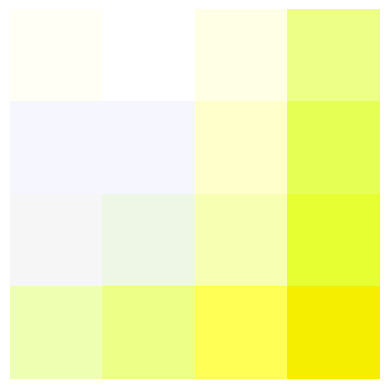

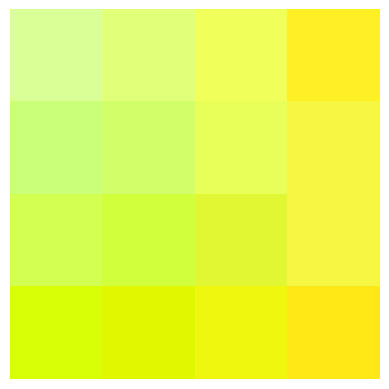

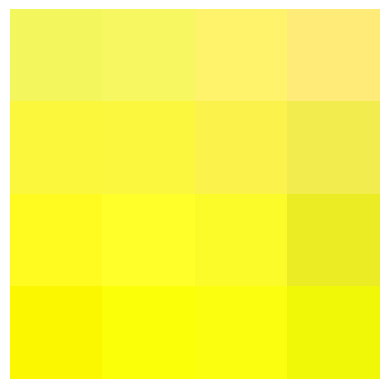

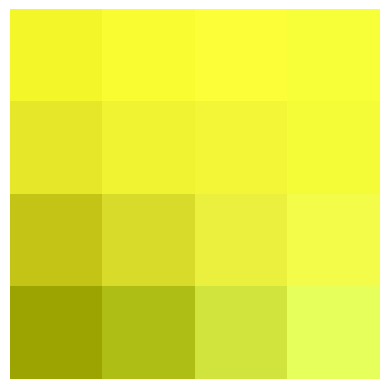

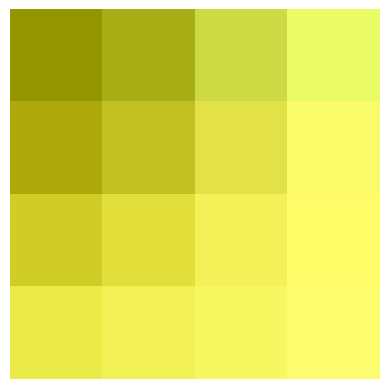

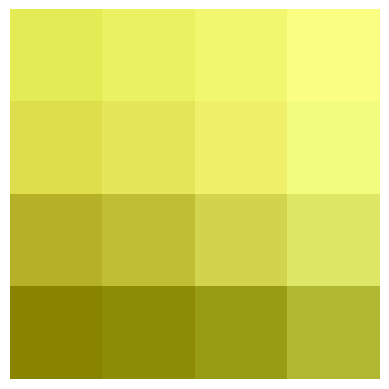

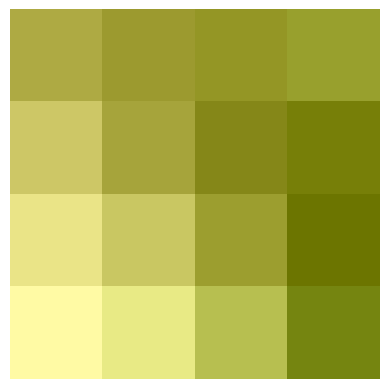

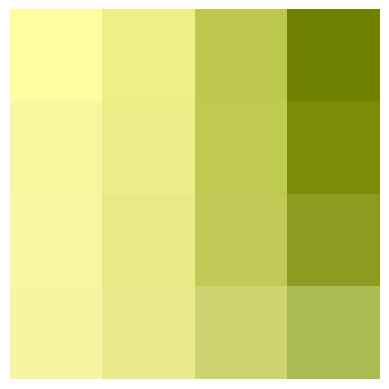

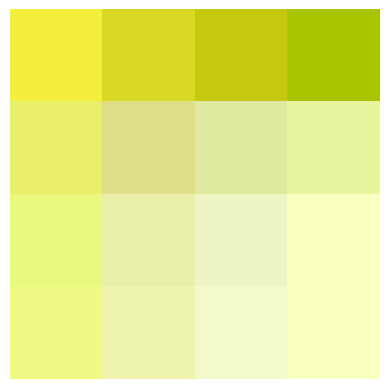

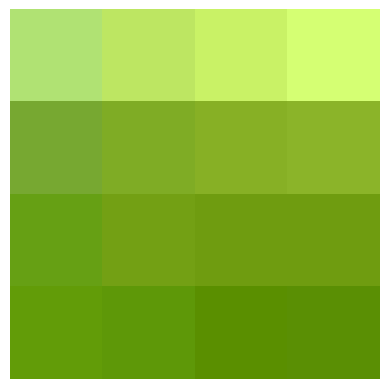

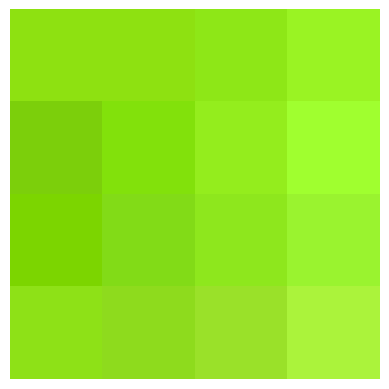

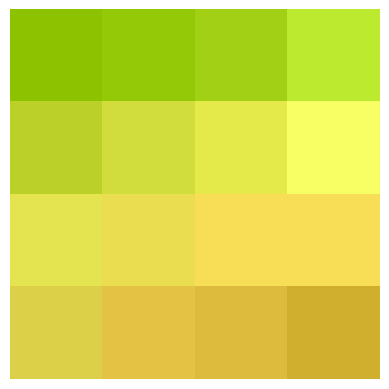

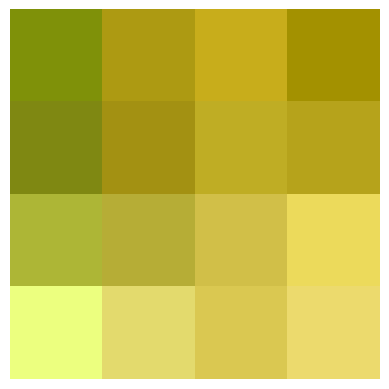

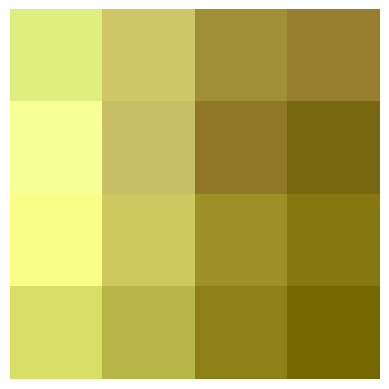

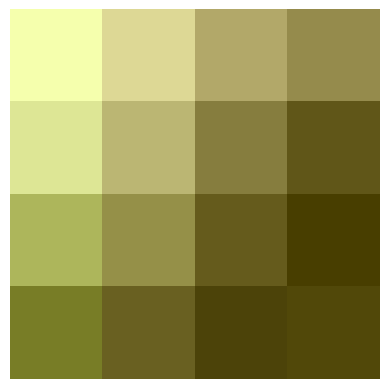

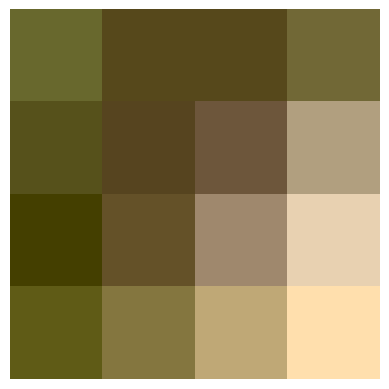

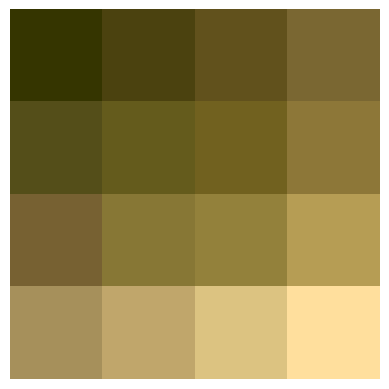

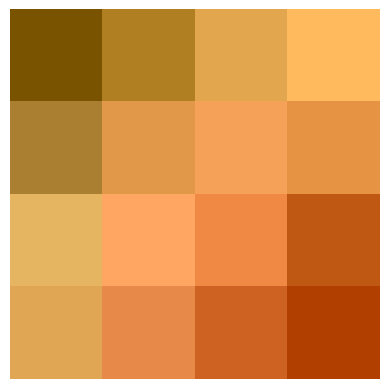

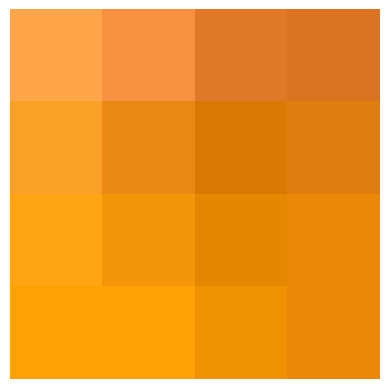

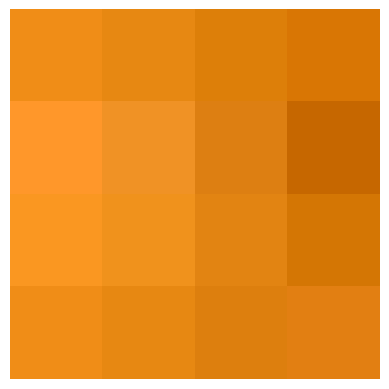

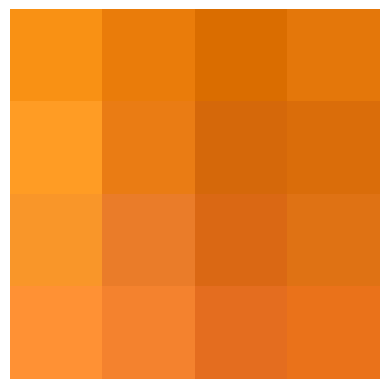

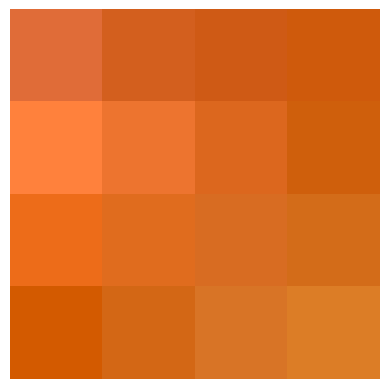

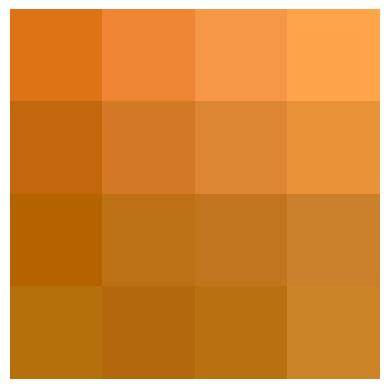

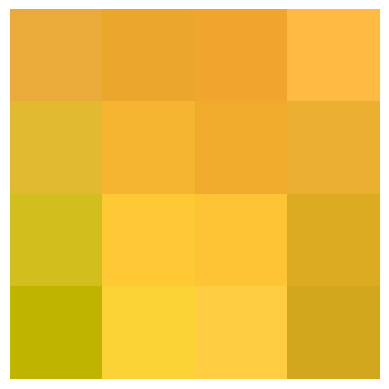

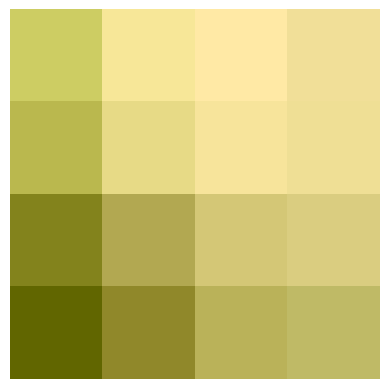

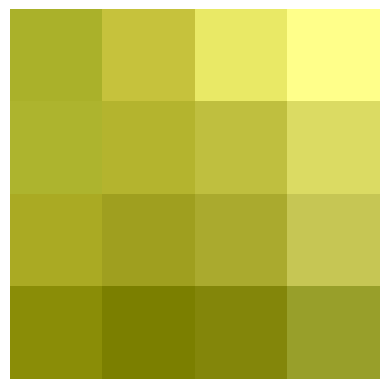

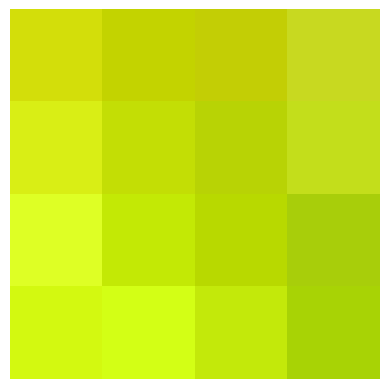

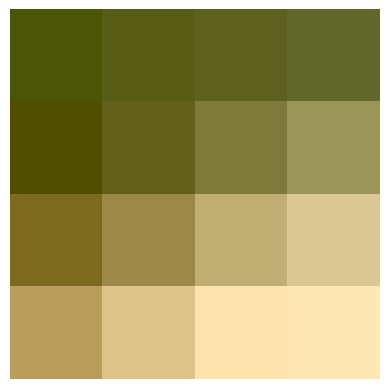

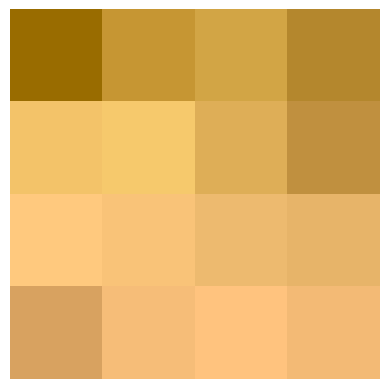

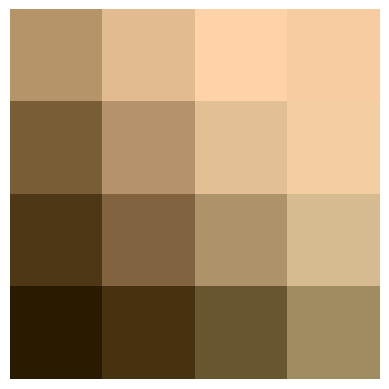

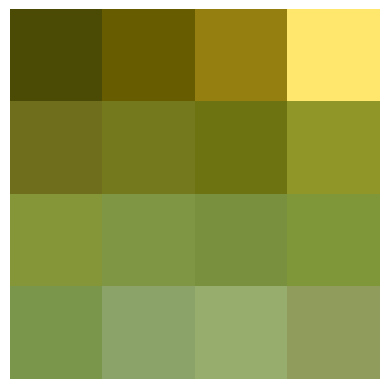

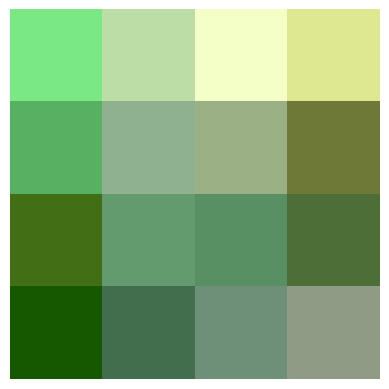

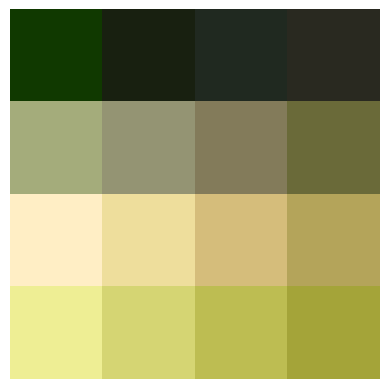

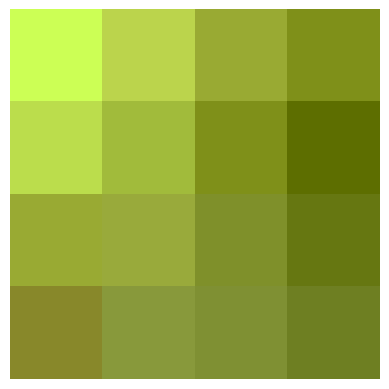

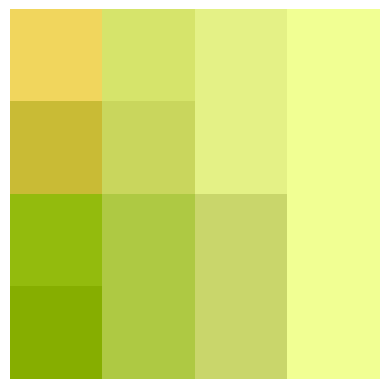

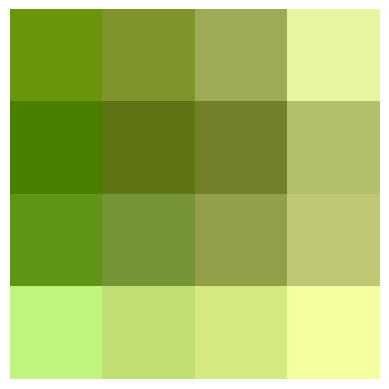

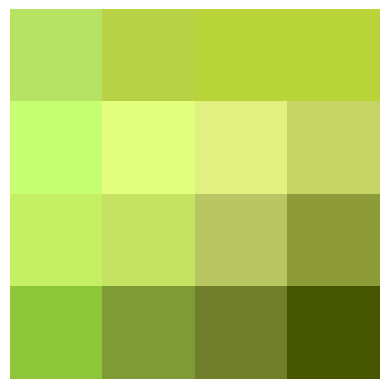

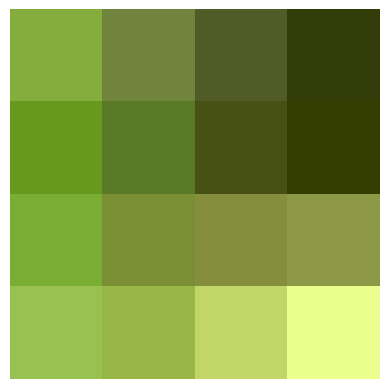

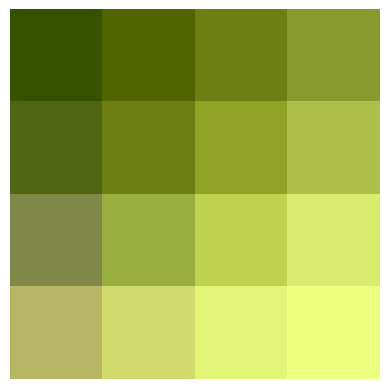

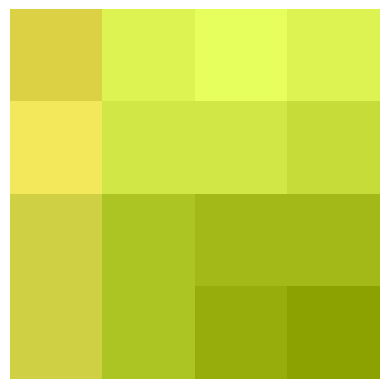

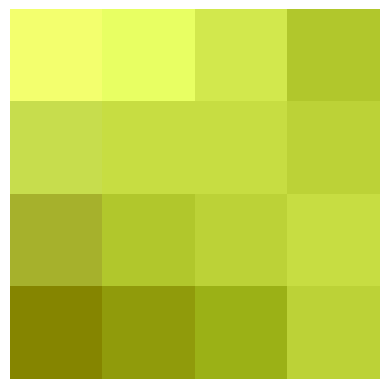

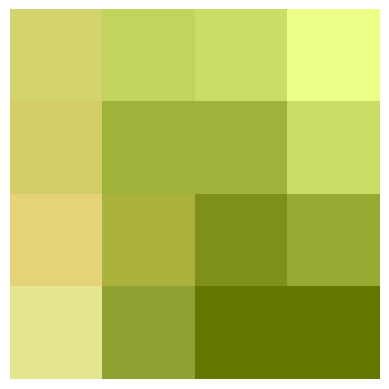

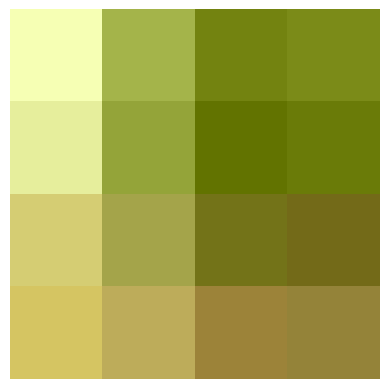

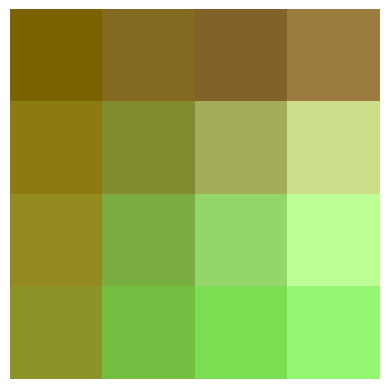

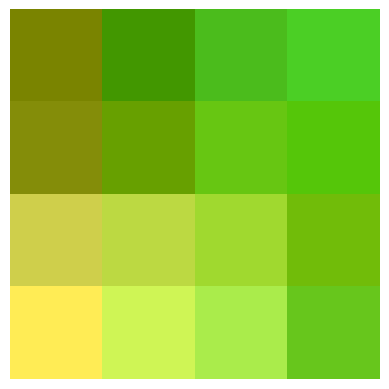

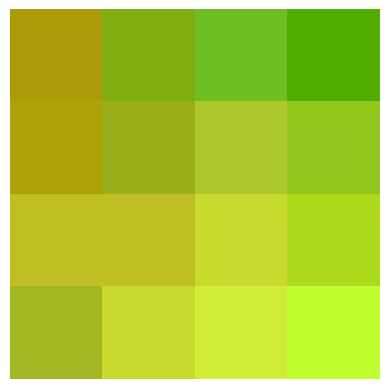

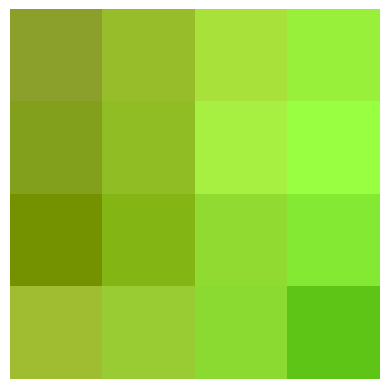

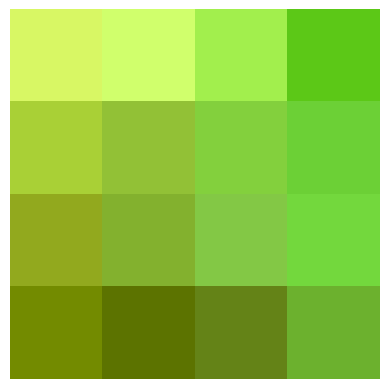

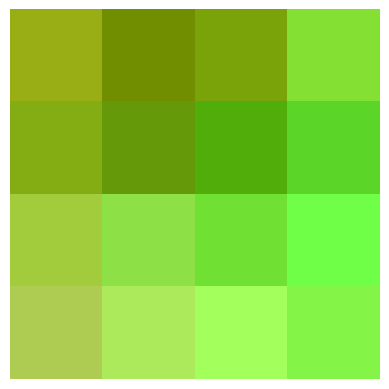

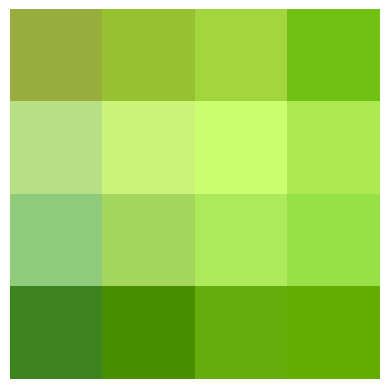

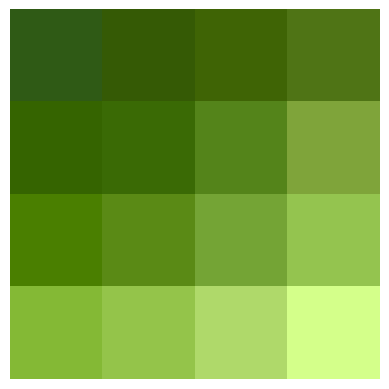

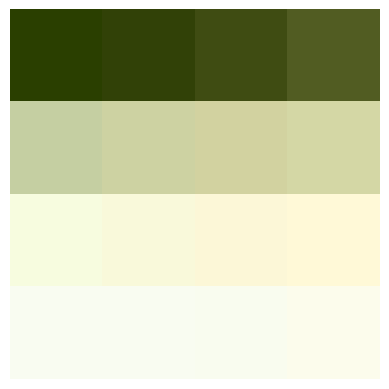

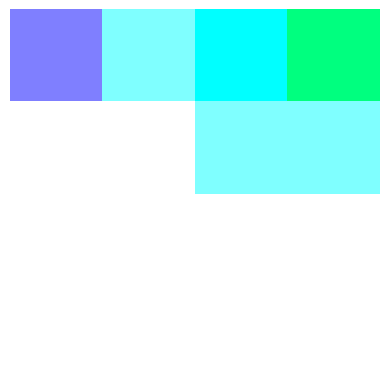

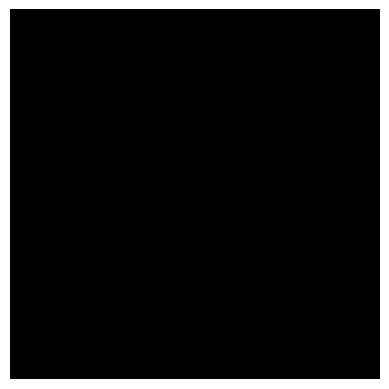

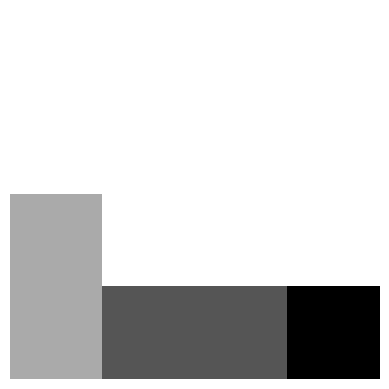

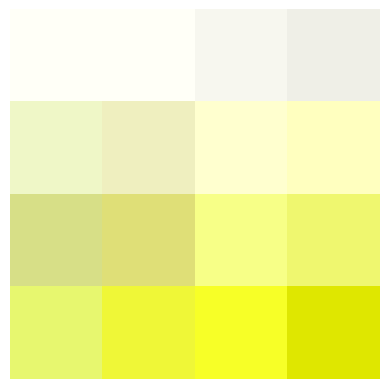

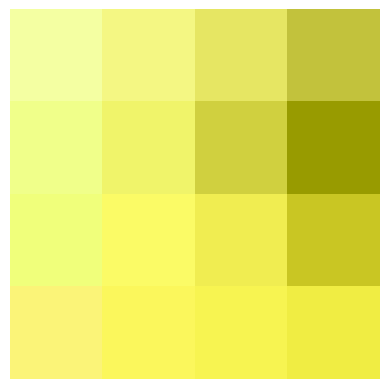

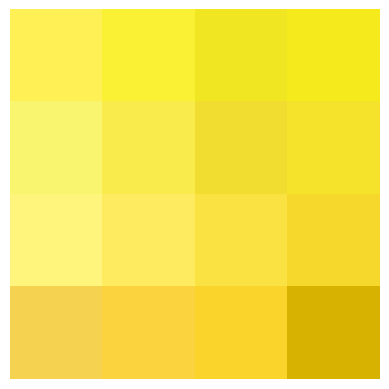

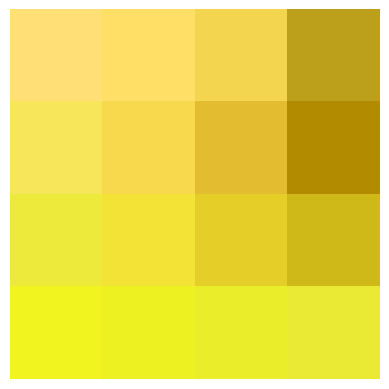

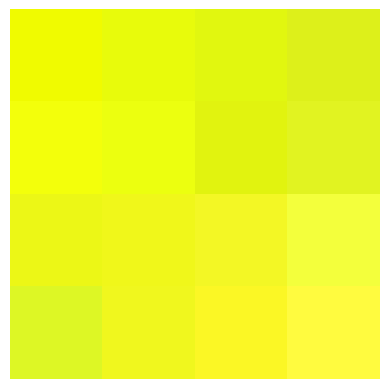

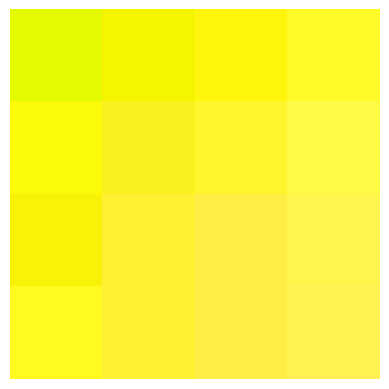

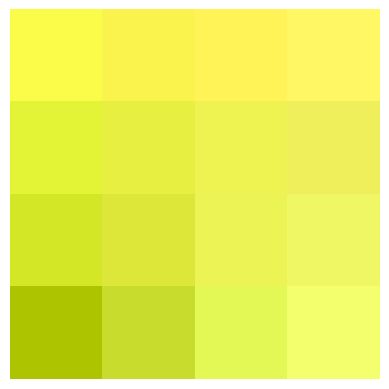

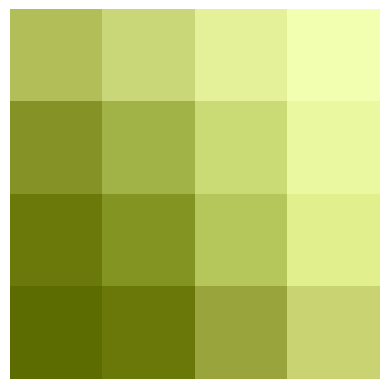

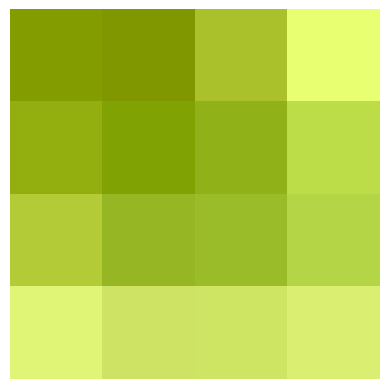

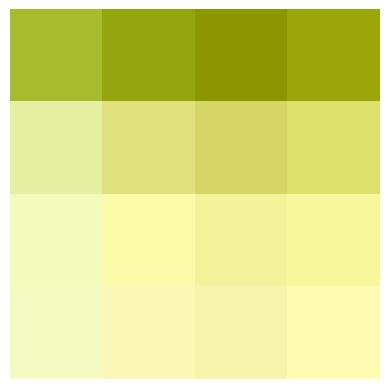

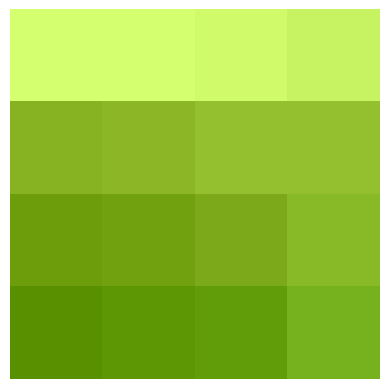

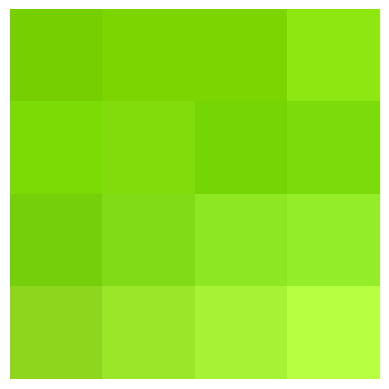

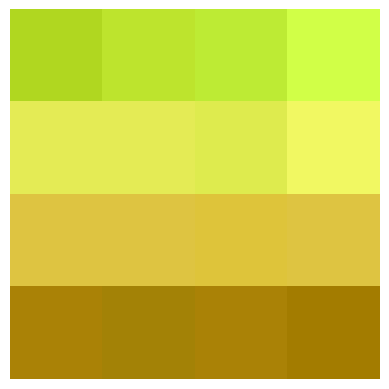

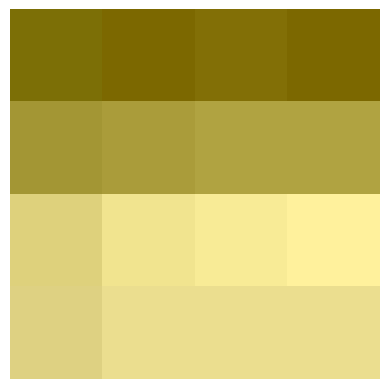

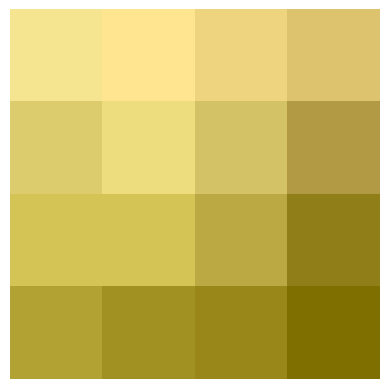

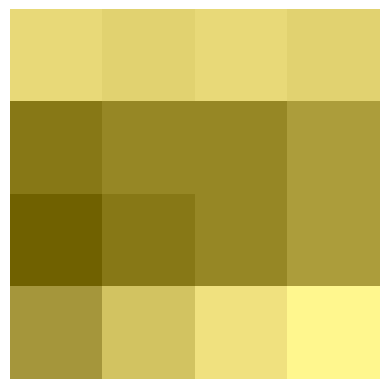

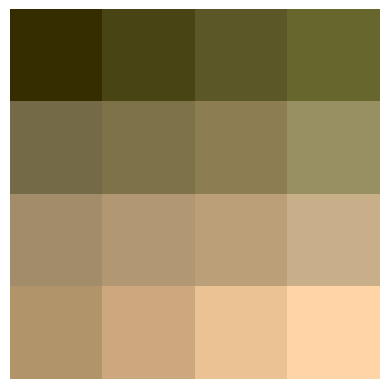

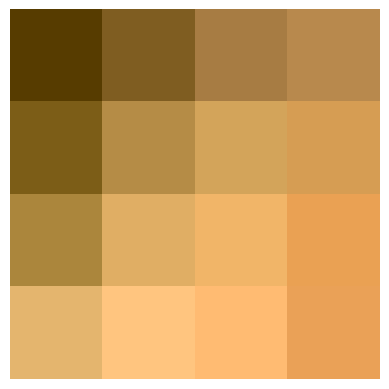

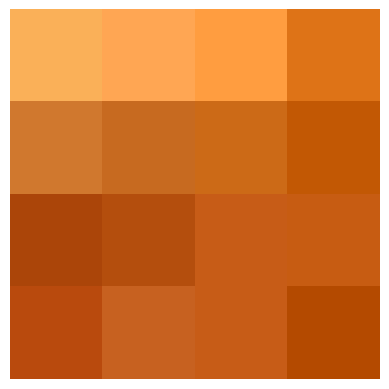

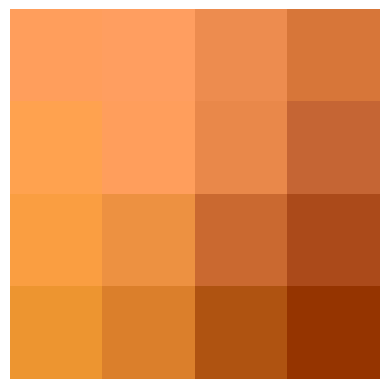

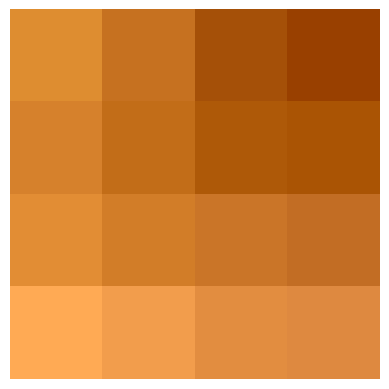

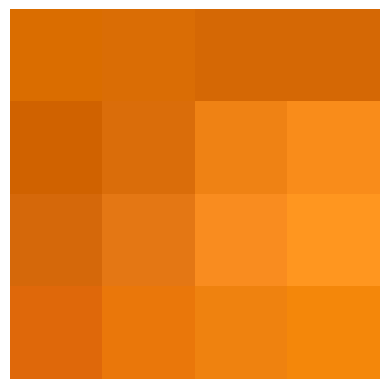

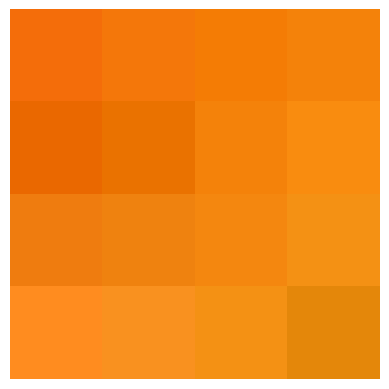

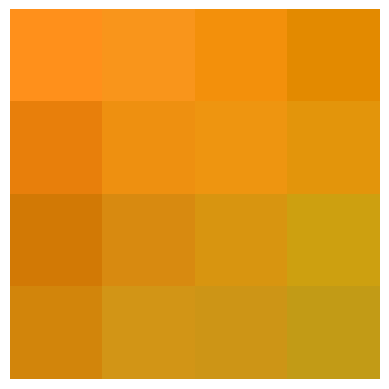

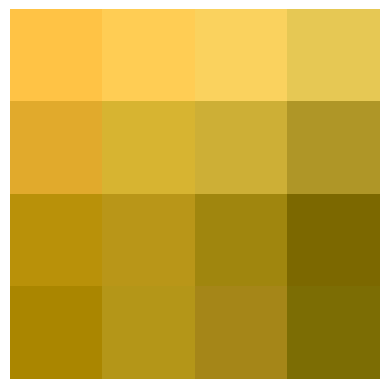

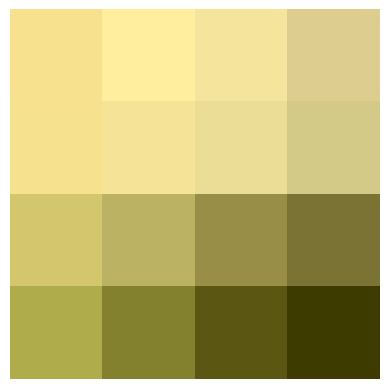

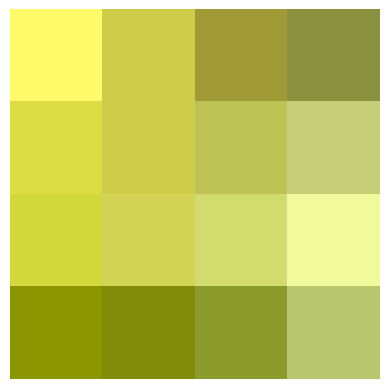

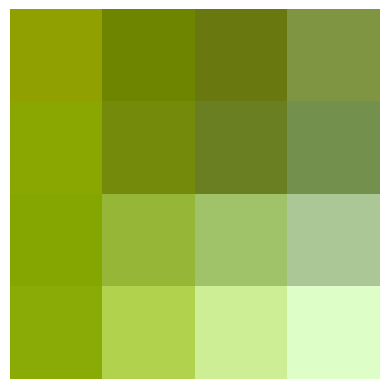

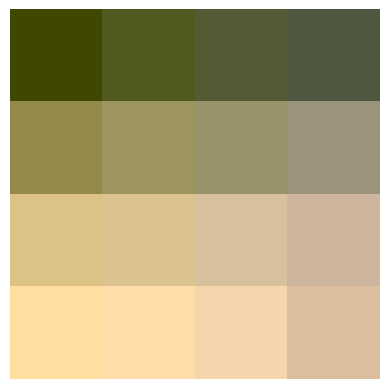

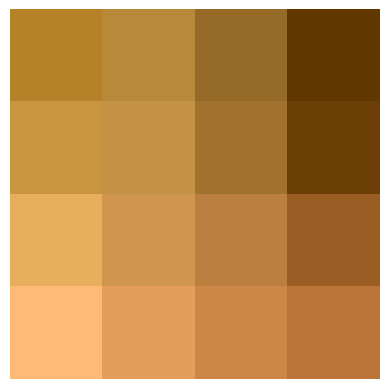

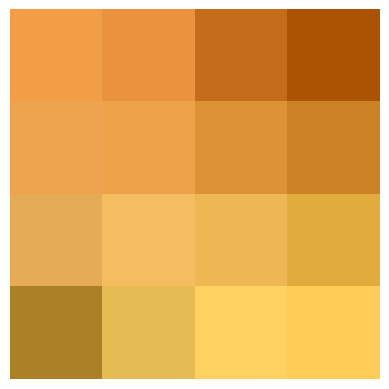

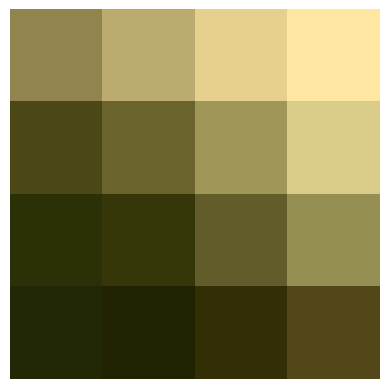

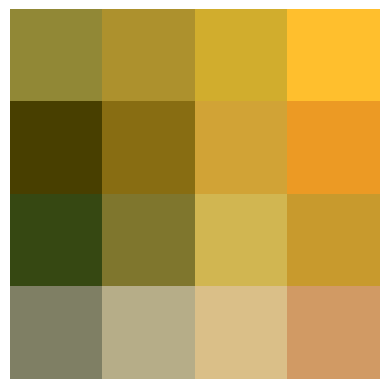

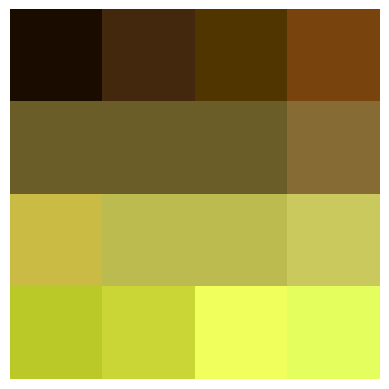

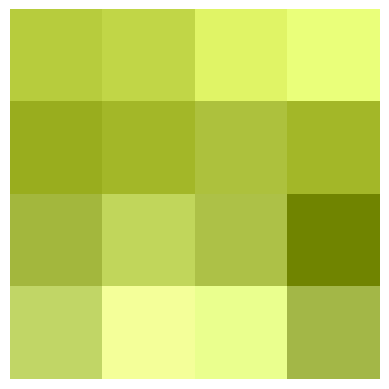

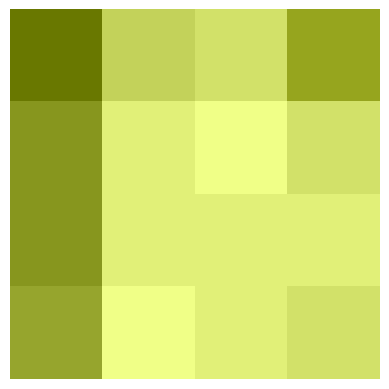

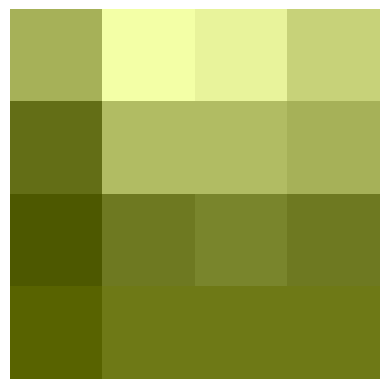

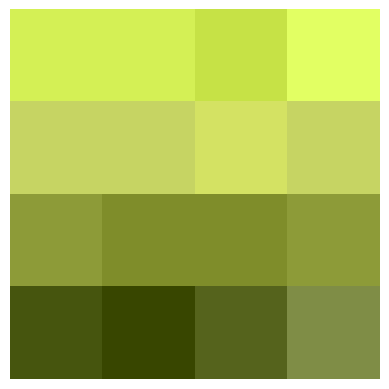

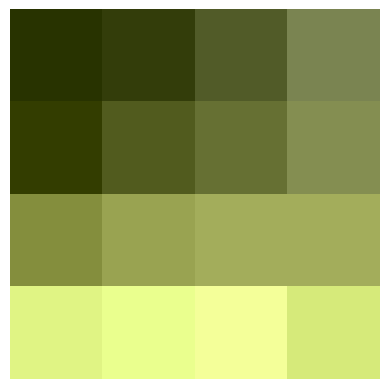

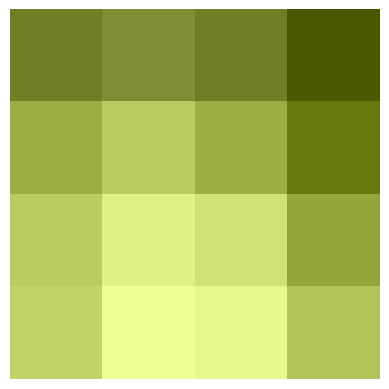

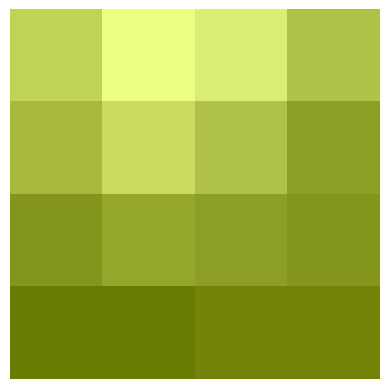

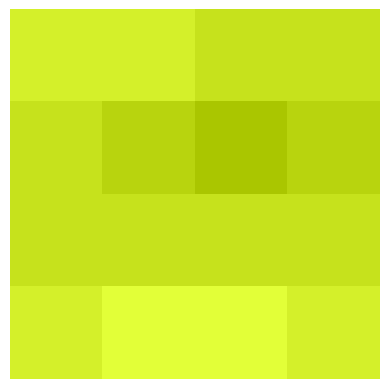

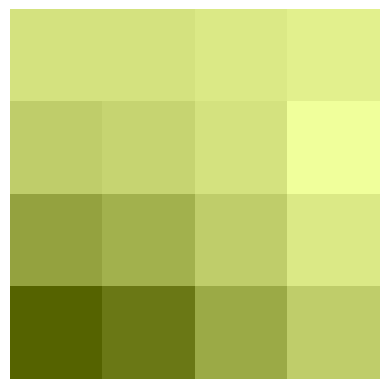

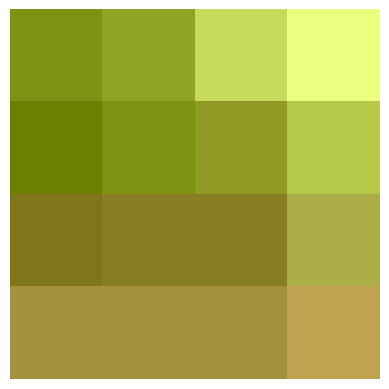

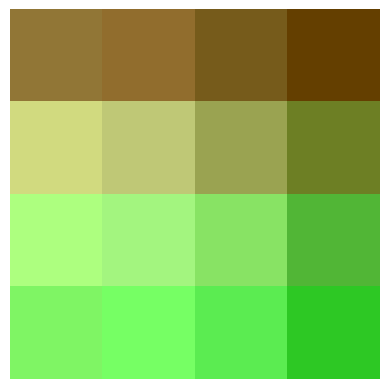

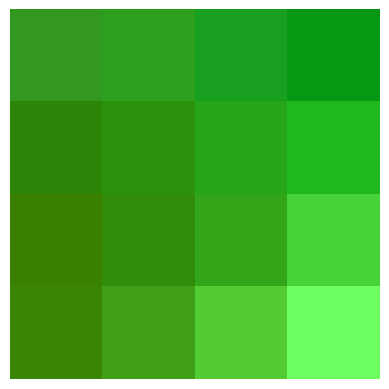

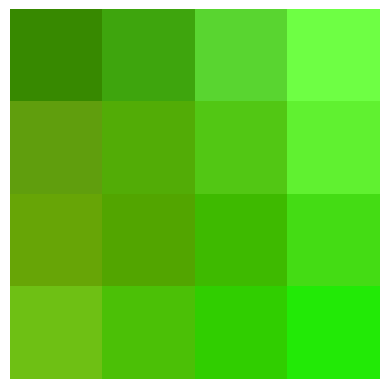

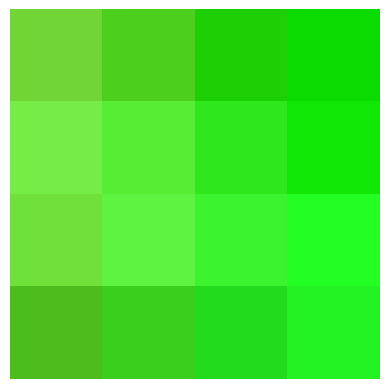

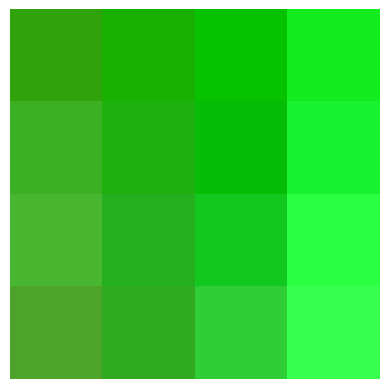

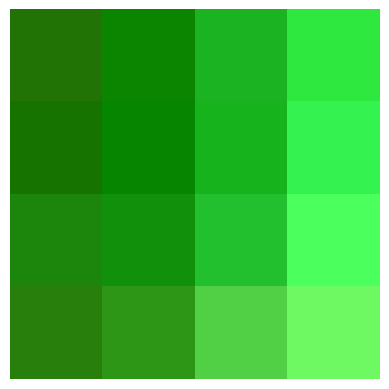

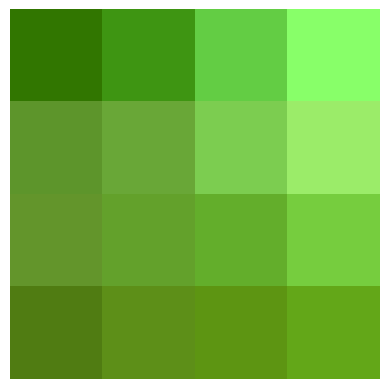

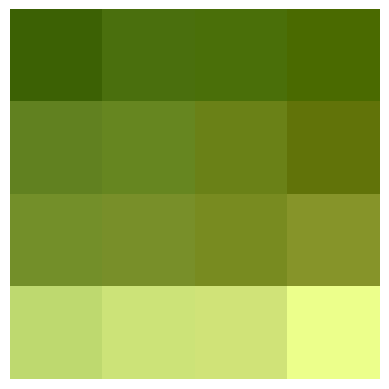

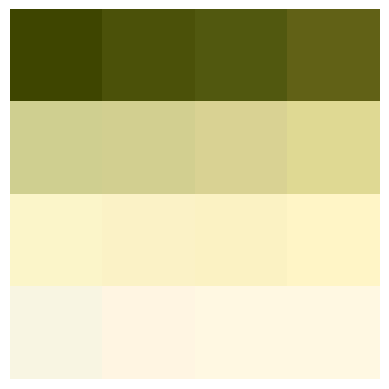

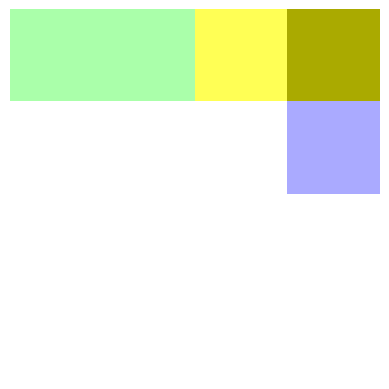

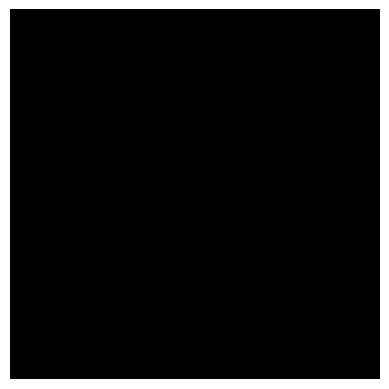

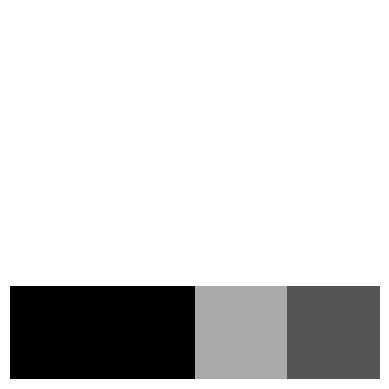

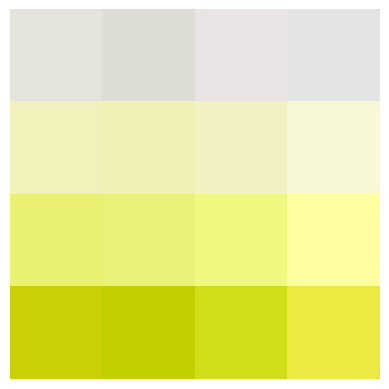

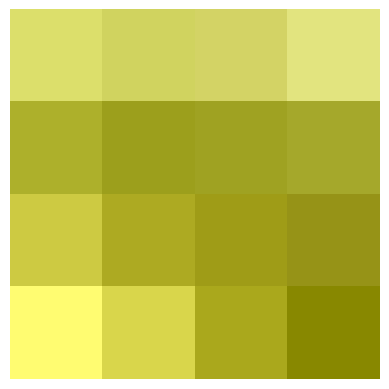

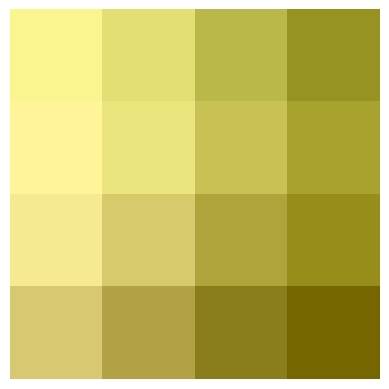

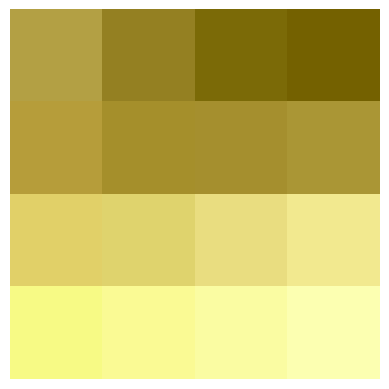

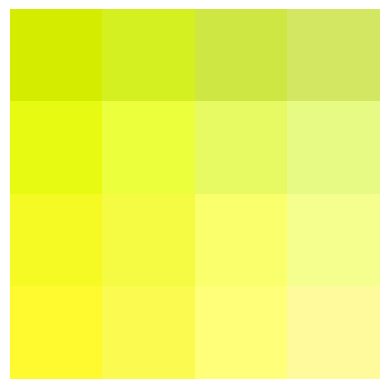

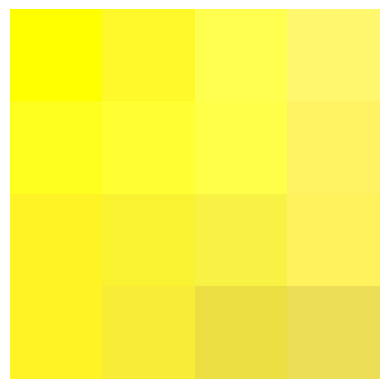

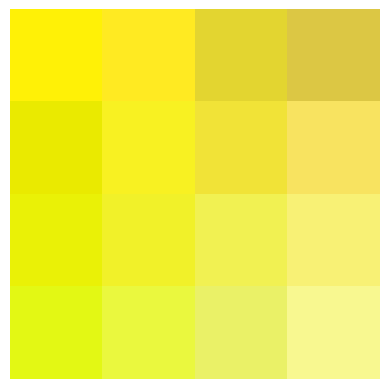

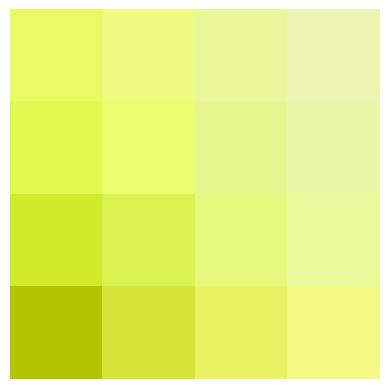

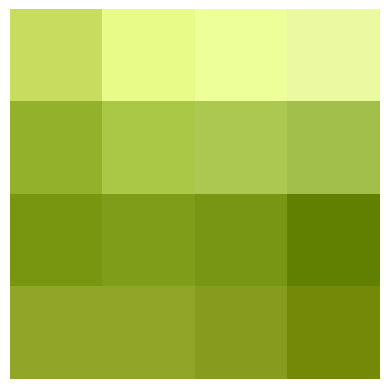

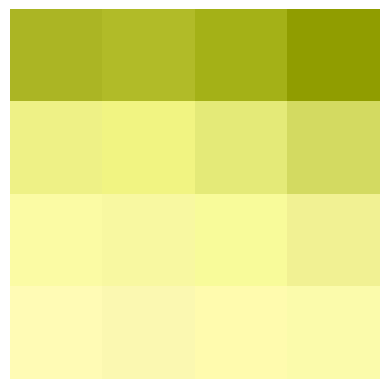

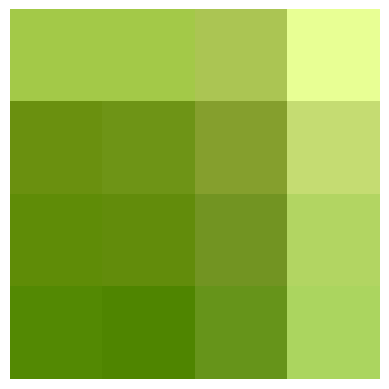

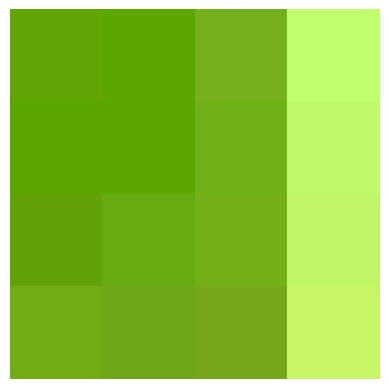

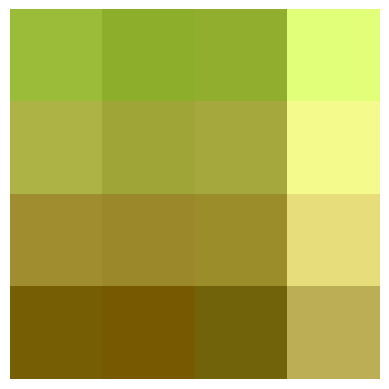

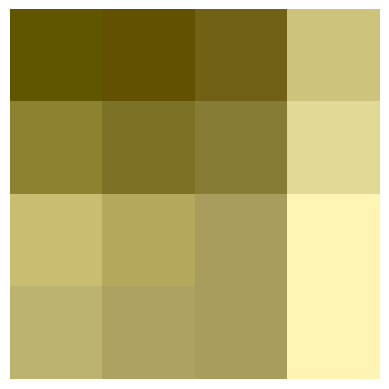

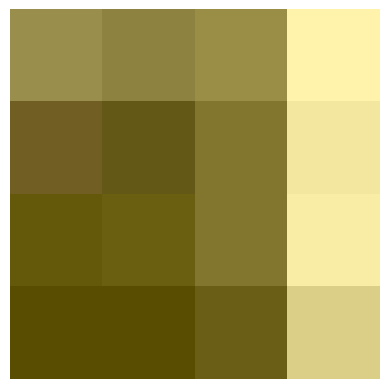

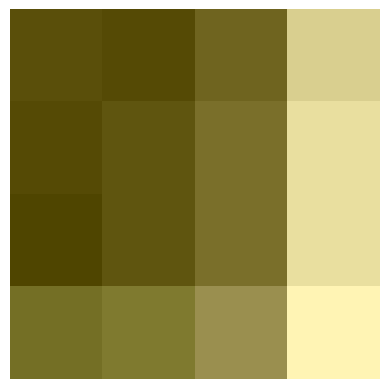

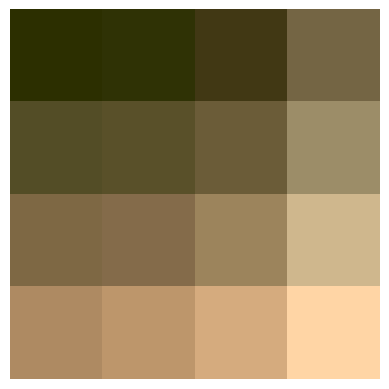

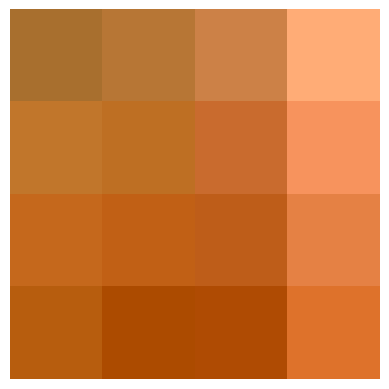

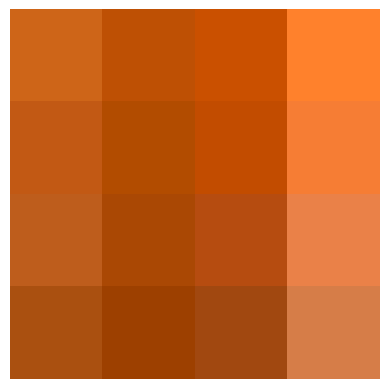

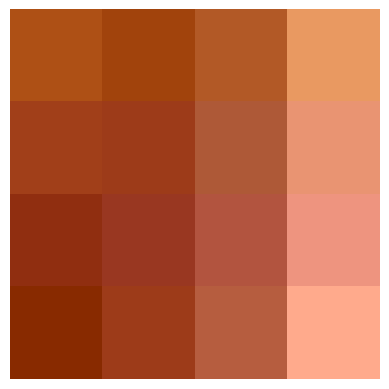

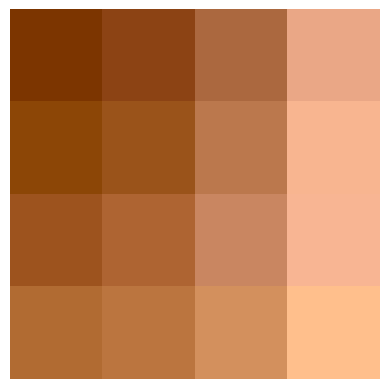

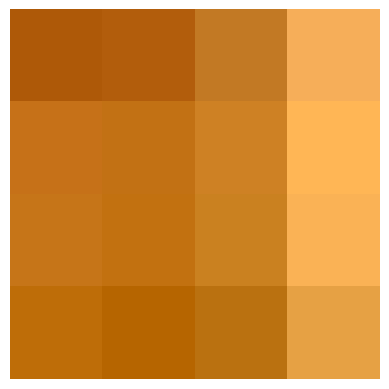

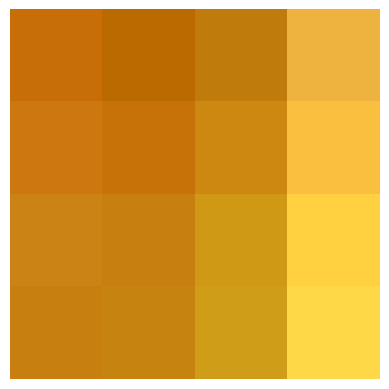

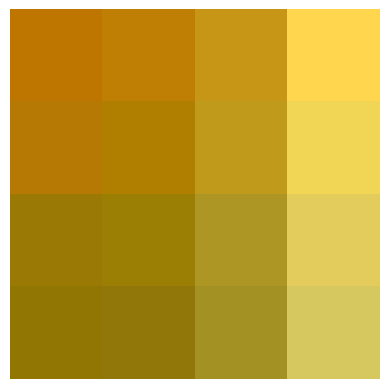

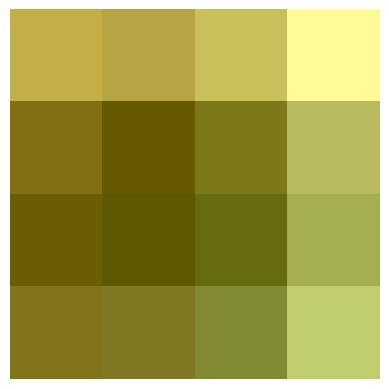

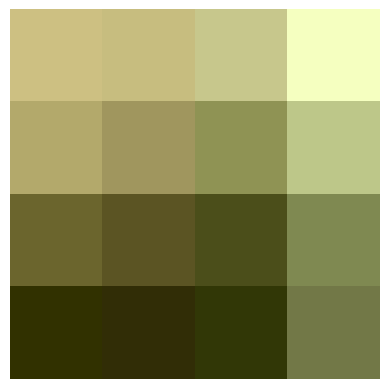

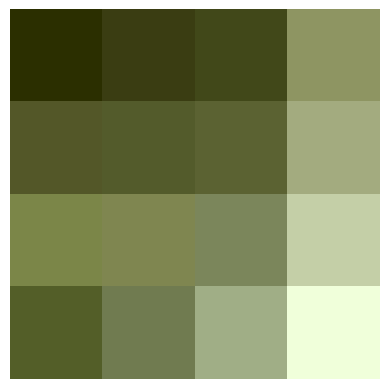

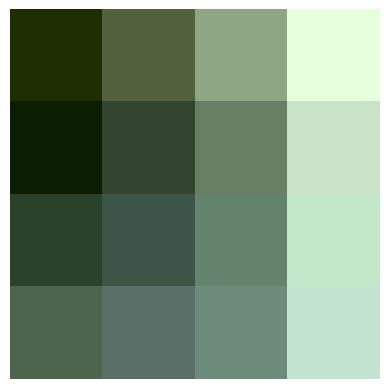

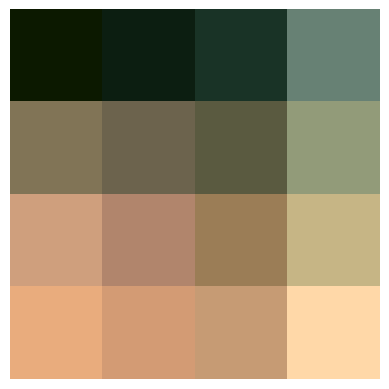

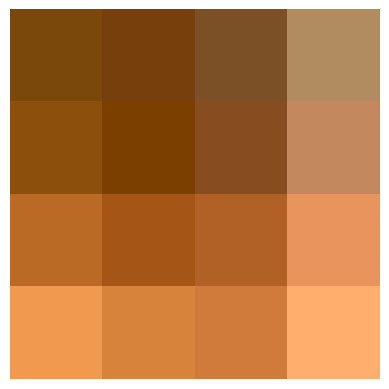

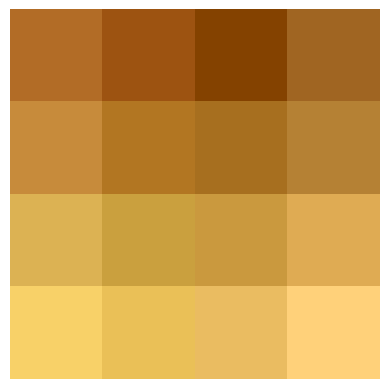

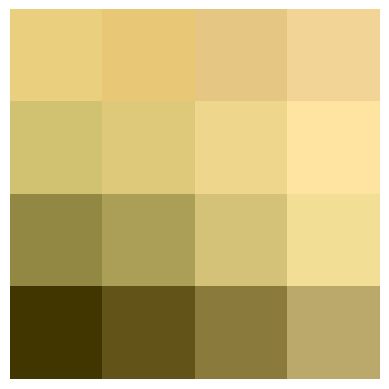

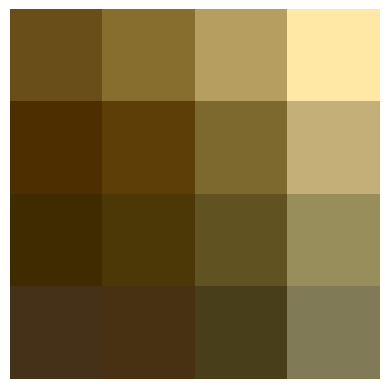

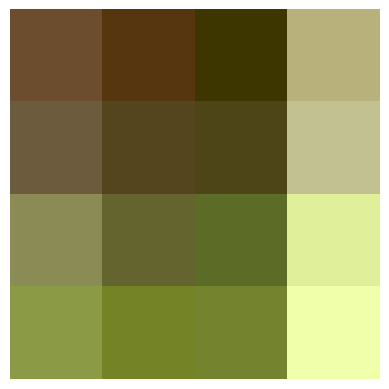

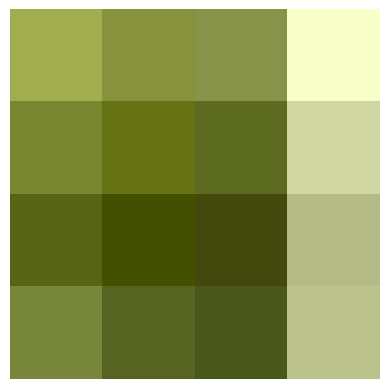

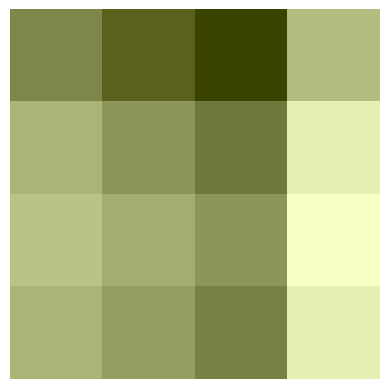

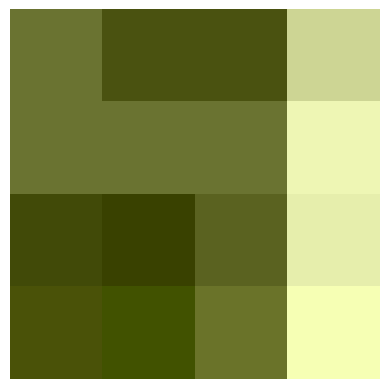

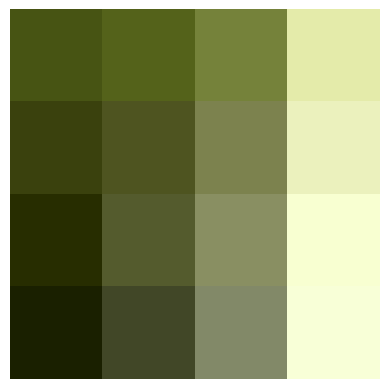

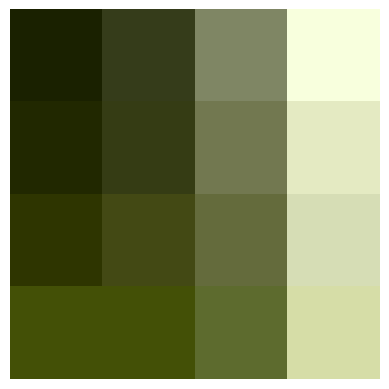

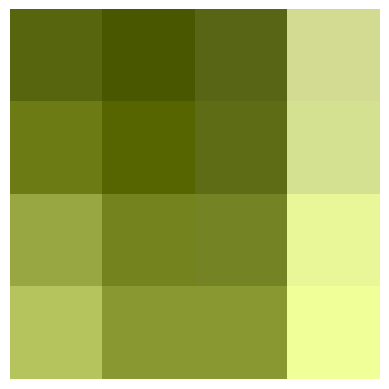

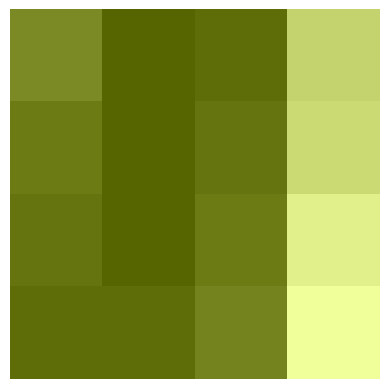

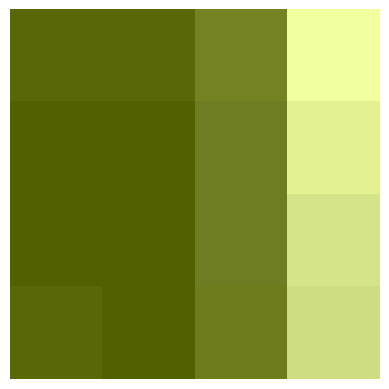

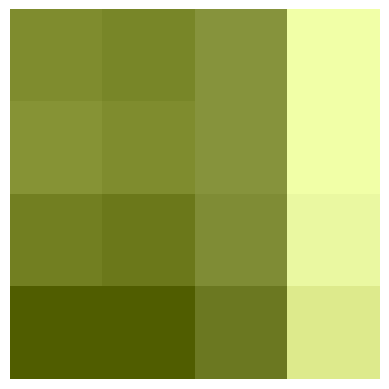

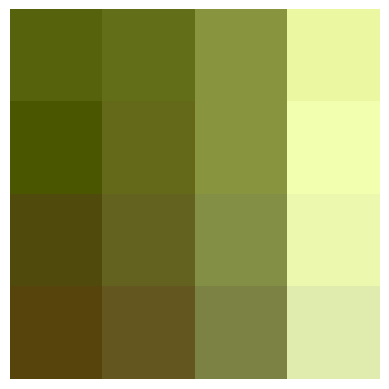

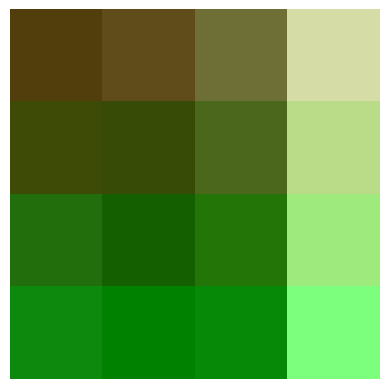

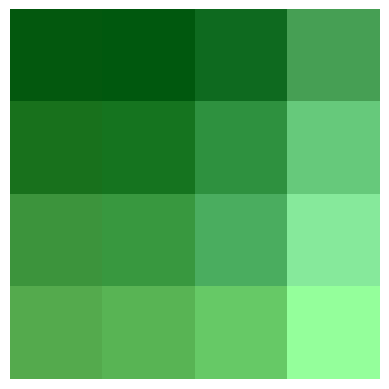

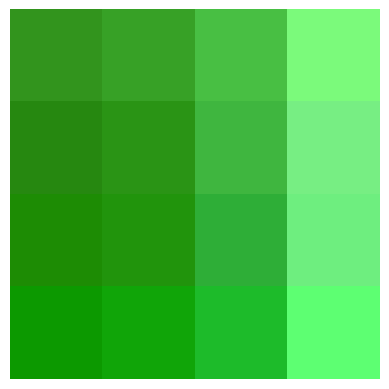

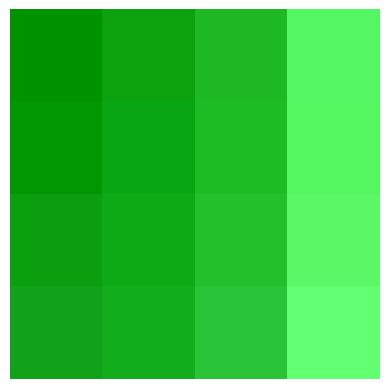

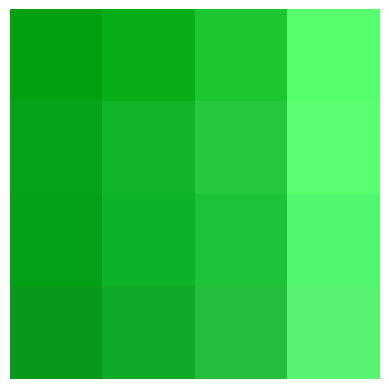

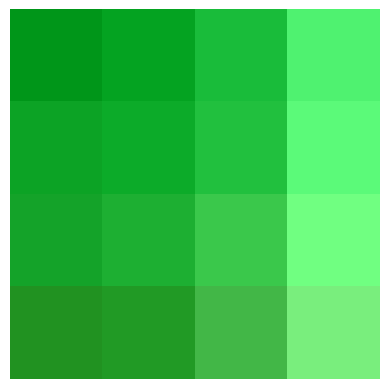

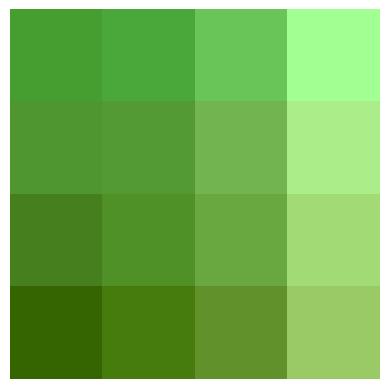

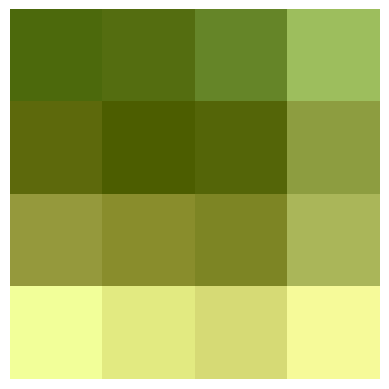

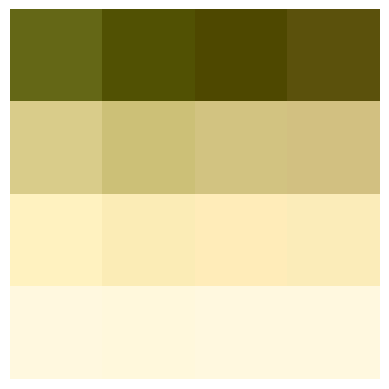

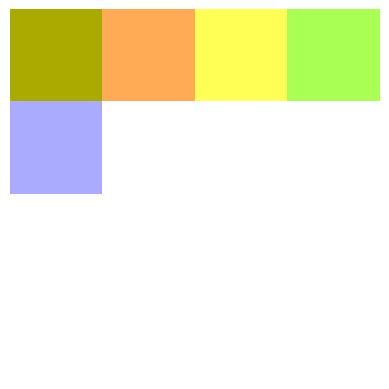

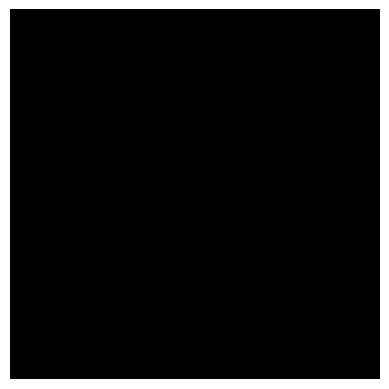

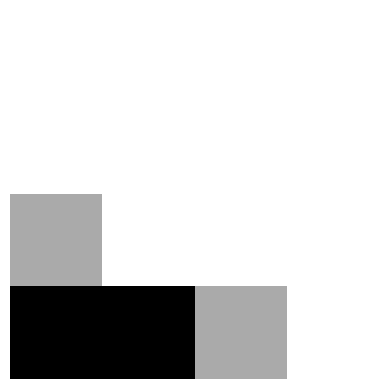

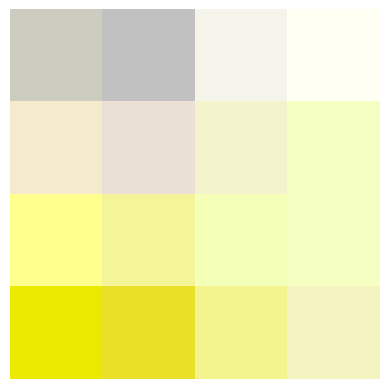

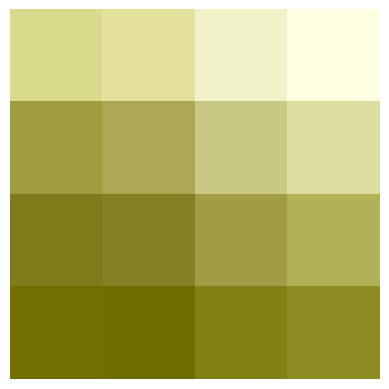

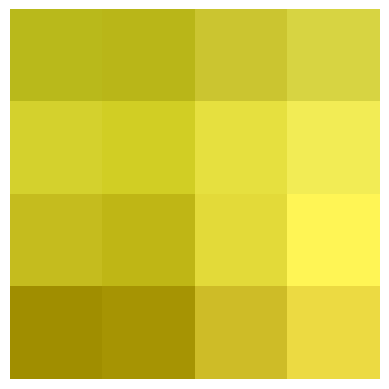

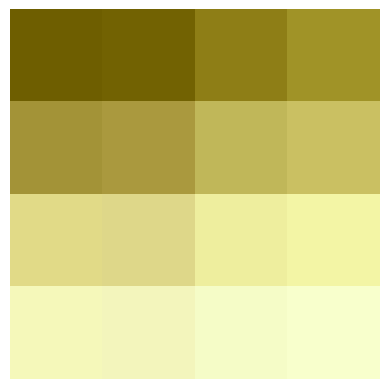

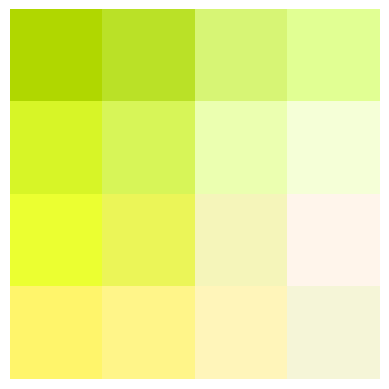

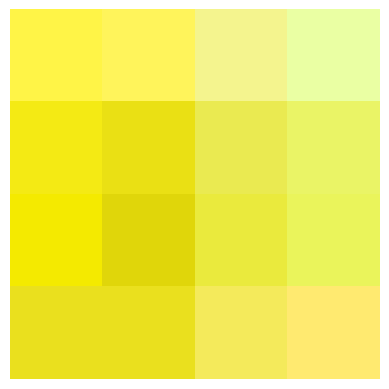

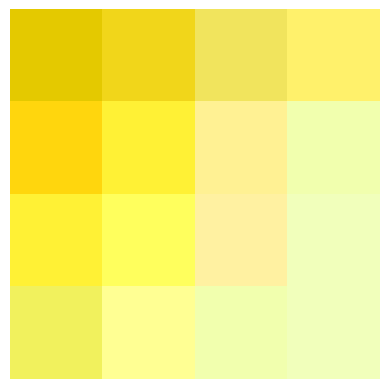

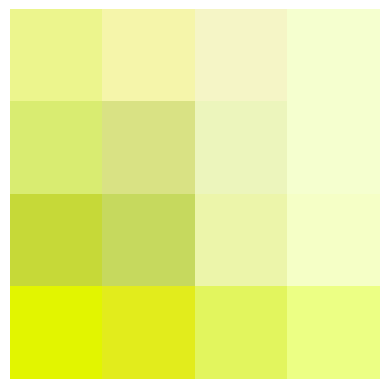

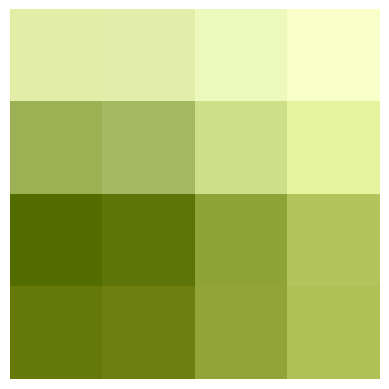

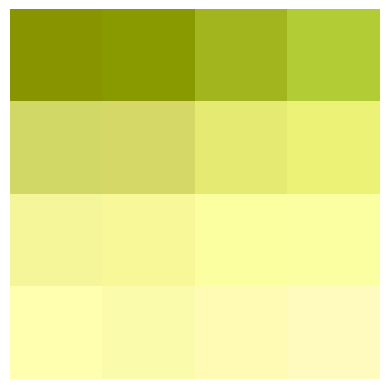

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window

    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)

    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())

    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()



# Applying Linear Embedding

#### ( 4x4x3 tensor  to 1x1x96 tensor)


In [11]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

# Applying patch embedding on  patches

In [12]:
# Load the image file
image_path = 'test.jpg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[ 0.2200,  0.2723, -0.3711,  ..., -0.2509,  0.1226, -0.0221],
         [ 0.1871,  0.2818, -0.3512,  ..., -0.1997,  0.1542, -0.0245],
         [ 0.2456,  0.3142, -0.4449,  ..., -0.2578,  0.2058, -0.0486],
         ...,
         [ 0.6454,  0.7313, -1.2063,  ..., -0.6980,  0.5576, -0.2010],
         [ 0.4888,  0.5582, -1.0297,  ..., -0.5843,  0.4410, -0.1388],
         [ 0.5981,  0.6926, -1.0868,  ..., -0.6171,  0.5463, -0.1219]]],
       grad_fn=<TransposeBackward0>)

The output you are seeing is a tensor representing the embedded patches. Each element in the tensor corresponds to a patch in the image.

The output tensor you provided has the shape (1, 3136, 96), indicating that you have one image with 3136 patches, and each patch is represented by a 96-dimensional embedding vector.

# 1st patch embedding vector

In [13]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([ 0.2200,  0.2723, -0.3711,  0.2734, -0.1799,  0.1759,  0.2126, -0.1344,
         0.0595, -0.2491, -0.0408,  0.3289,  0.1516, -0.0396, -0.3011,  0.2015,
         0.0322, -0.1155,  0.1359,  0.2857, -0.1053, -0.1423,  0.1365, -0.0475,
         0.1319,  0.3818,  0.0437,  0.0421,  0.0731,  0.1879, -0.0725,  0.2434,
        -0.0703, -0.2530, -0.3375,  0.1726,  0.5977, -0.1209, -0.3748, -0.2169,
         0.1359,  0.1116, -0.0836,  0.1077, -0.0295, -0.3608,  0.0992, -0.1205,
         0.1690, -0.1612, -0.1237, -0.2361, -0.1450,  0.0349, -0.2590,  0.4525,
        -0.3651, -0.0041,  0.4424,  0.0877, -0.1089, -0.1240,  0.1729,  0.0018,
        -0.0373, -0.1683,  0.1458,  0.2222,  0.1149,  0.0160, -0.1401, -0.0827,
        -0.0452,  0.3724, -0.1610, -0.0441, -0.1202, -0.1732,  0.0663,  0.1308,
         0.2192, -0.1322,  0.2336,  0.1011,  0.4437, -0.0388,  0.1402,  0.1118,
        -0.3002, -0.0219,  0.1077,  0.2113,  0.4719, -0.2509,  0.1226, -0.0221],
       gr

# Using BasicLayer : Swin Transformer layer for one stage

In [14]:
import torch
import torch.nn as nn

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(dim, num_heads)

    def forward(self, x):
        # Here you can reshape or apply window-based attention (skipping window partition for simplicity)
        B, L, C = x.shape  # B: batch, L: length (flattened window), C: channels
        x = x.transpose(0, 1)  # Change shape for multi-head attention (L, B, C)
        attn_output, _ = self.attention(x, x, x)
        return attn_output.transpose(0, 1)

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.activation = nn.GELU()

    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size):
        super(BasicLayer, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size

        self.attention_blocks = nn.ModuleList([
            WindowAttention(dim, window_size, num_heads) for _ in range(depth)
        ])

        self.mlp_blocks = nn.ModuleList([
            MLP(dim, dim * 4) for _ in range(depth)
        ])

        self.norm_layer = nn.LayerNorm(dim)

    def forward(self, x):
        for i in range(self.depth):
            # Apply window attention and MLP in each block
            x = x + self.attention_blocks[i](x)  # Apply self-attention
            x = self.norm_layer(x)
            x = x + self.mlp_blocks[i](x)  # Apply MLP
            x = self.norm_layer(x)
        return x

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        # Reshape and perform patch merging operations here (example)
        # You might need to adjust the reshaping based on your desired merging logic
        # This is just a placeholder, adapt it to your specific needs

        # Assuming x has shape (B, H*W, C)
        B, L, C = x.shape
        # Reshape to (B, H, W, C)
        x = x.view(B, H, W, C)

        # Perform patch merging (e.g., merging 2x2 patches)
        # This is a simplified example; adjust the indexing and calculations
        # according to your desired merging strategy.
        x0 = x[:, 0::2, 0::2, :]  # Top-left patches
        x1 = x[:, 1::2, 0::2, :]  # Bottom-left patches
        x2 = x[:, 0::2, 1::2, :]  # Top-right patches
        x3 = x[:, 1::2, 1::2, :]  # Bottom-right patches

        x = torch.cat([x0, x1, x2, x3], -1)  # Concatenate along the channel dimension
        x = x.view(B, -1, 4 * C)  # Reshape back to (B, H/2 * W/2, 4*C)

        x = self.norm(x)
        x = self.reduction(x)

        return x # This line is crucial: return the merged output

# Example usage:

# Define dimensions and input
stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Example input tensor (batch_size, sequence_length, embedding_dim)
embedding = torch.randn(1, 56*56, 96)  # (batch_size, sequence_length, embedding_dim)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)


torch.Size([1, 3136, 96])


In [15]:
#from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output


torch.Size([1, 3136, 96])


tensor([[[ 0.9403, -1.1039, -1.1943,  ..., -0.3026,  1.6588,  1.4322],
         [ 0.7074,  1.1646, -1.2263,  ...,  0.5001, -0.7525, -0.4895],
         [ 1.0404, -0.0539,  0.9617,  ...,  0.0688,  0.7835, -0.6720],
         ...,
         [ 0.1516, -1.1235,  1.8860,  ...,  0.5655, -0.8147, -0.7991],
         [ 1.0012,  0.0552,  2.0625,  ...,  0.7130, -1.3007,  0.5482],
         [-1.3832,  0.8827, -0.5417,  ...,  1.4553,  0.9790, -0.3054]]],
       grad_fn=<NativeLayerNormBackward0>)

# Patch Merging

##### USing patch merging on the embedding

In [16]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [17]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


the output width and height are both reduced by a factor of 2 and the number of output channels is 2C where C is the number of input channels, here for Swin-T, C=96 .


### Let's create Stage-1 of the Swin-T architecture using SwinTransformerBlock:

Using SwinTransformerBlock class on the patch embedding embedding

In [19]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows * B, window_size, window_size, C)
                 (8*8*B, 7, 7, C)
        window_size (int): window size (default: 7)
        H (int): Height of image (patch-wise)
        W (int): Width of image (patch-wise)

    Returns:
        x: (B, H, W, C)
    """

    # Get B from 8*8*B
    B = int(windows.shape[0] / (H * W / window_size / window_size))

    # Convert to (B, 8, 8, 7, 7, C)
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)

    # Convert to (B, 8, 7, 8, 7, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Convert to (B, H, W, C)
    x = x.view(B, H, W, -1)

    return x

In [21]:

# MLP of tranformer Block

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act_layer = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_layer(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [23]:
# W-MSA

class WindowAttention(nn.Module):
    """ Window based multi-head self attention(W-MSA) module with relative position bias.
        Used as Shifted-Window Multi-head self-attention(SW-MSA) by providing shift_size parameter in
        SwinTransformerBlock module

    Args:
        dim (int): Number of input channels (C)
        window_size (tuple[int]): The height and width of the window (M)
        num_heads (int): Number of attention heads for multi-head attention
        qkv_bias (bool, optional): If True, add a learnable bias to q, k, v (Default: True)
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight (Default: 0.0)
        proj_drop (float, optional): Dropout ratio of output (Default: 0.0)
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size # Wh(M), Ww(M) (7, 7)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Parameter table of relative position bias: B_hat from the paper
        # (2M-1, 2M-1, num_heads) or (2*Wh-1 * 2*W-1, num_heads)
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )

        # Pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) # (2, M, M) or (2, Wh, Ww)
        coords_flatten = torch.flatten(coords, 1) # (2, M^2)

        # None is dummy dimension
        # coords_flatten[:, :, None] = (2, M^2, 1)
        # coords_flatten[:, None, :] = (2, 1, M^2)
        # relative_coords = (2, M^2, M^2)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

        # (2, M^2, M^2) -> (M^2, M^2, 2)
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1 # make it start from 0 index
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1 # w.r.t x-axis

        # x-axis + y-axis
        relative_position_index = relative_coords.sum(-1) # (M^2, M^2)

        self.register_buffer('relative_position_index', relative_position_index)

        # Attention
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # W_Q, W_K, W_V
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C), N refers to number of patches in a window (M^2)
            mask: (0/-inf) mask with shape of (num_windows, M^2, M^2) or None
                  -> 0 means applying attention, -inf means removing attention
        """
        # (batch, M^2, C)
        B_, N, C = x.shape

        # (num_windows*B, N, 3C)
        qkv = self.qkv(x)

        # (B, N, 3, num_heads, C // num_heads)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads)

        # Permute to (3, B_, num_heads, N, C // num_heads)
        '''
        3: referring to q, k, v (total 3)
        B: batch size
        num_heads: multi-headed attention
        N:  M^2, referring to each token(patch)
        C // num_heads: Each head of each of (q,k,v) handles C // num_heads -> match exact dimension for multi-headed attention
        '''
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # Decompose to query/key/vector for attention
        # each of q, k, v has dimension of (B_, num_heads, N, C // num_heads)
        q, k, v = qkv[0], qkv[1], qkv[2] # Why not tuple-unpacking?

        q = q * self.scale

        # attn becomes (B_, num_heads, N, N) shape
        # N = M^2
        attn = (q @ k.transpose(-2, -1))

        # Remember that relative_position_bias_table = ((2M-1)*(2M-1), num_heads), B_hat from the paper
        # relative_position_index's elements are in range [0, 2M-2]
        # Convert to (M^2, M^2, num_heads). This is B matrix from the paper
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1],  -1
        )

        # Convert to (num_heads, M^2, M^2) to match the dimension for addition
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()

        # (B, num_heads, N, N) + (1, num_heads, M^2, M^2), where N=M^2
        # attn becomes (B_, num_heads, N, N) or (B, num_heads, M^2, M^2)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0] # nW = number of windows

            # attn.view(...) = (B, nW, num_heads, N, N)
            # mask.unsqueeze(1).unsqueeze(0) = (1, num_windows, 1, M^2, M^2)
            # So masking is broadcasted along B and num_heads axis which makes sense
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)

            # attn = (nW * B, num_heads, N, N)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        # attn = (nW*B, num_heads, N, N)
        # v = (B_, num_heads, N, C // num_heads). B_ = nW*B
        # attn @ v = (nW*B, num_heads, N, C // num_heads)
        # (attn @ v).transpose(1, 2) = (nW*B, N, num_heads, C // num_heads)
        # Finally, x = (nW*B, N, C), reshape(B_, N, C) performs concatenation of multi-headed attentions
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)

        # Projection Matrix (W_0). dim doesn't change since we used C // num_heads for MSA
        # x = (B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [24]:
# Swin Transformer Block.

class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block. It's used as either W-MSA or SW-MSA depending on shift_size

    Args:
        dim (int): Number of input channels
        input_resolution (tuple[int]): Input resolution
        num_heads (int): Number of attention heads
        window_size (int): Window size
        shift_size (int): Shift size for SW-MSA
        mlp_ratio (float):Ratio of mlp hidden dim to embedding dim
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer(nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): NOrmalization layer. Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm
                ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # If window_size > input_resolution, no partition
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)

        # Attention
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)

        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # Attention Mask for SW-MSA
        # This handling of attention-mask is my favourite part. What a beautiful implementation.
        if self.shift_size > 0:
            H, W = self.input_resolution

            # To match the dimension for window_partition function
            img_mask = torch.zeros((1, H, W, 1))

            # h_slices and w_slices divide a cyclic-shifted image to 9 regions as shown in the paper
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )

            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )

            # Fill out number for each of 9 divided regions
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size) # (nW, M, M, 1)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)

            # Such a gorgeous code..
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer('attn_mask', attn_mask)


    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x # Residual
        x = self.norm1(x)
        x = x.view(B, H, W, C) # H, W refer to the number of "patches" for width and height, not "pixels"

        # Cyclic Shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # Partition Windows
        x_windows = window_partition(shifted_x, self.window_size) # (nW*B, M, M, C)
        x_windows = x_windows.view(-1, self.window_size*self.window_size, C) # (nW*B, window_size*window_size, C)

        # W-MSA / SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask) # (nW*B, window_size*window_size, C)

        # Merge Windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W) # (B, H', W', C)

        # Reverse Cyclic Shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H*W, C)

        # FFn
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



In [25]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock( input_resolution=(56, 56), dim=96, num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 1.0484, -0.7481, -0.7831,  ..., -0.3139,  1.3560,  1.1717],
         [ 1.0908,  0.6891, -1.1648,  ...,  0.4337, -0.2309, -0.1801],
         [ 0.8471,  0.2876,  1.2084,  ...,  0.0305,  0.9799, -0.6466],
         ...,
         [ 0.1425, -1.7970,  1.1539,  ...,  0.3942, -0.4704, -0.8878],
         [ 1.0689,  0.0025,  1.6580,  ...,  0.9348, -1.3019,  0.6607],
         [-1.2252,  1.5152, -0.7353,  ...,  1.4444,  0.0803,  0.4945]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.5487, -1.1324, -1.1995,  ..., -0.1492,  1.1297,  0.7946],
         [ 0.8562,  0.0855, -1.1603,  ...,  0.0045, -0.2819, -0.4748],
         [ 0.5362, -0.0914,  0.8785,  ..., -0.4879,  1.2523, -0.8111],
         ...,
         [-0.1160, -1.4621,  0.9724,  ...,  0.0443, -0.6051, -0.8315],
         [ 1.2290, -0.5265,  1.6284,  ...,  0.7651, -1.0564,  0.3536],
         [-1.0905,  1.1357, -0.6264,  ...,  1.6281,  0.7241, -0.3788]]],
       grad_fn=<AddBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# SwinTransformer :

In [26]:

# Patch Merging Layer from the paper (downsampling)

class PatchMerging(nn.Module):
    """ Patch Merging Layer from the paper (downsampling)
    Args:
        input_solution (tuple[int]): Resolution of input feature
        dim (int): Number of input channels. (C)
        norm_layer (nn.Module, optional): Normalization layer. (Default: nn.LayerNorm)
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: (B, H*W, C)
        """

        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        # Separate per patch by 2 x 2
        x0 = x[:, 0::2, 0::2, :] # (B, H/2, W/2, C) (top-left of 2x2)
        x1 = x[:, 1::2, 0::2, :] # (B, H/2, W/2, C) (bottom-left of 2x2)
        x2 = x[:, 0::2, 1::2, :] # (B, H/2, W/2, C) (top-right of 2x2)
        x3 = x[:, 1::2, 1::2, :] # (B, H/2, W/2, C) (bottom-right of 2x2)

        # Merge by channel -> (B, H/2, W/2, 4C)   # Merging 4 patches- thats why 4C
        x = torch.cat([x0, x1, x2, x3], -1)

        # Flatten H, W
        x = x.view(B, -1, 4 * C)

        x = self.norm(x)

        # Reduction Layer: 4C -> 2C
        x = self.reduction(x)

        return x

In [27]:

# Swin Transformer layer for one stage

class BasicLayer(nn.Module):
    """ Swin Transformer layer for one stage

    Args:
        dim (int): Number of input channels
        input_resolution (tuple[int]): Input resolution
        depth (int): Number of blocks (depending on Swin Version - T, L, ..)
        num_heads (int): Number of attention heads
        window_size (int): Local window size
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. (Default: True)
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        drop (float, optional): Dropout rate (Default: 0.0)
        attn_drop (float, optional): Attention dropout rate (Default: 0.0)
        drop_path (float | tuple[float], optional): Stochastic depth rate (Default: 0.0)
        norm_layer (nn.Module, optional): Normalization layer (Default: nn.LayerNorm)
        downsample (nn.Module | NOne, optional): Downsample layer at the end of the layer (Default: None)
        use_checkpoint (bool): Whether to use checkpointing to save memory (Default: False)
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # Build  Swin-Transformer Blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio = mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer
                                )
            for i in range(depth)
        ])


        # Patch Merging Layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None


    def forward(self, x):
        for blk in self.blocks:
            # if self.use_checkpoint:
            #     x = checkpoint.checkpoint(blk, x)
            # else:
            #     x = blk(x)
            x = blk(x)

        if self.downsample is not None:
            x = self.downsample(x)

        return x


In [28]:

# SwinTransformer

class SwinTransformer(nn.Module):
    """ Swin Transformer

    Args:
        img_size (int | tuple(int)): Input image size (Default 224)
        patch_size (int | tuple(int)): Patch size (Default: 4)
        in_chans (int): Number of input image channels (Default: 3)
        num_classes (int): Number of classes for classification head (Default: 1000)
        embed_dim (int): Patch embedding dimension (Default: 96)
        depths (tuple(int)): Depth of each Swin-T layer
        num_heads (tuple(int)): Number of attention heads in different layers
        window_size (int): Window size (Default: 7)
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. (Default: 4)
        qkv_bias (bool): If True, add a learnable bias to query, key, value (Default: True)
        qk_scale (float); Override default qk scale of head_dim ** -0.5 if set. (Default: None)
        drop_rate (float): Dropout rate (Default: 0)
        attn_drop_rate (float): Attention dropout rate (Default: 0)
        drop_path_rate (float); Stochastic depth rate (Default: 0.1)
        norm_layer (nn.Module): Normalization layer (Default: nn.LayerNorm)
        ape (bool): Refers to absolute position embedding. If True, add ape to the patch embedding (Default: False)
        patch_norm (bool): If True, add normalization after patch embedding (Default: True)
        use_checkpoint (bool): Whether to use checkpointing to save memory (Default: False)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # Split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic Depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=(
                    patches_resolution[0] // (2 ** i_layer), # After patch-merging layer, patches_resolution(H, W) is halved
                    patches_resolution[1] // (2 ** i_layer),
                                 ),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers -1) else None, # No patch merging at the last stage
                use_checkpoint=use_checkpoint
            )

            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Classification Head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward_features(self, x):
        x = self.patch_embed(x)
        # if self.ape:
        #     x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x) # (B, L, C)
        x = self.avgpool(x.transpose(1, 2)) # (B, C, 1)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [29]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor  (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.

1000 is the number of classes for the classification head.

torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.

# Now, Let's work with custom dataset

In [61]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [115]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "/content/PlantSeg/train", "train")
test_dir = os.path.join(current_directory, "/content/PlantSeg/test", "test")
print(train_dir) # Changed 'path' to 'train_dir' to print the training directory path
print(test_dir) # Changed 'path' to 'test_dir' to print the testing directory path

/content/PlantSeg/train/train
/content/PlantSeg/test/test


# Create Datasets and DataLoaders

In [134]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [135]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [140]:
import os
import shutil

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Remove .ipynb_checkpoints folders if they exist
    if os.path.exists(os.path.join(train_dir, ".ipynb_checkpoints")):
        shutil.rmtree(os.path.join(train_dir, ".ipynb_checkpoints"))
    if os.path.exists(os.path.join(test_dir, ".ipynb_checkpoints")):
        shutil.rmtree(os.path.join(test_dir, ".ipynb_checkpoints"))

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [142]:
# Set the batch size
BATCH_SIZE = 32

# Assuming your data is in /content/PlantSeg/train
# Correct the train_dir to point to the parent directory
# containing the class subfolders
train_dir = "/content/PlantSeg/train"

# Assuming your test data is in /content/PlantSeg/test
# Similarly, correct the test_dir
test_dir = "/content/PlantSeg/test"

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fbc8f20af20>,
 ['apple'])

torch.Size([3, 224, 224]) tensor(0)


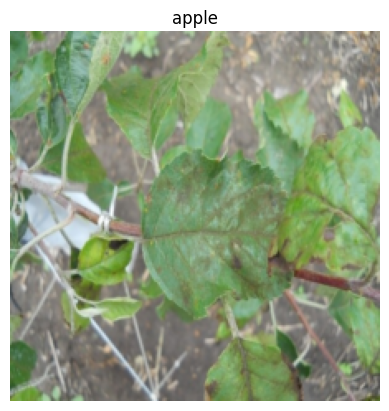

In [143]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [144]:
model = SwinTransformer(num_classes=len(class_names))

In [146]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [152]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [164]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
# Call the train function directly instead of via engine.train
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=3,
                       device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000


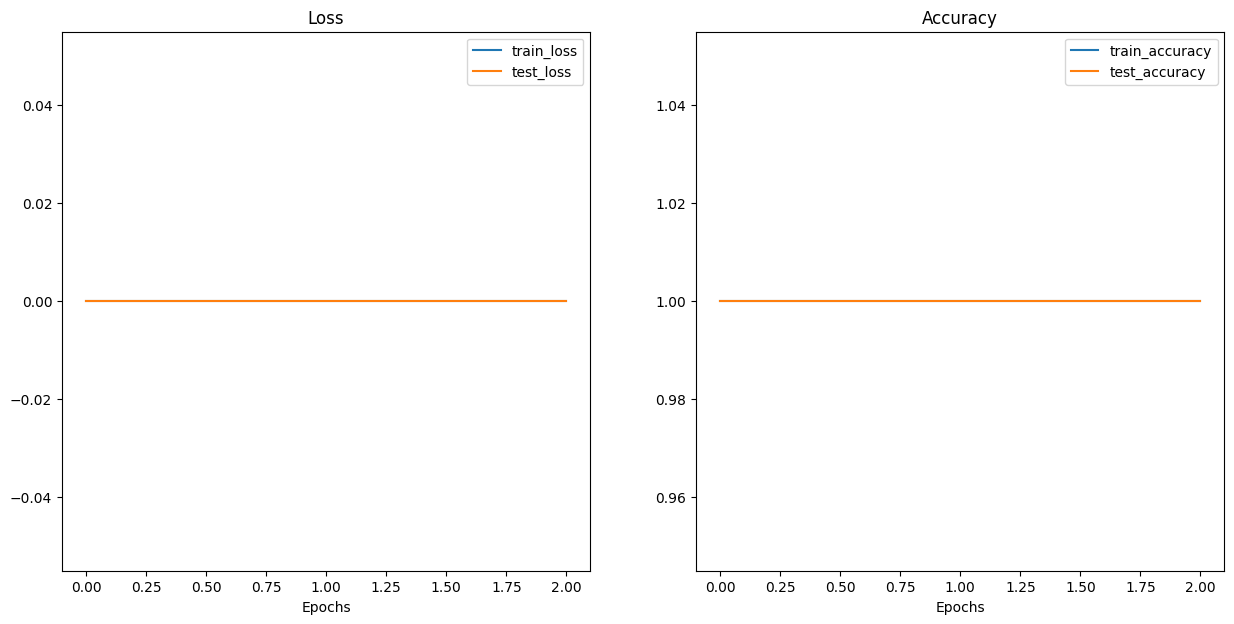

In [166]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Prediction

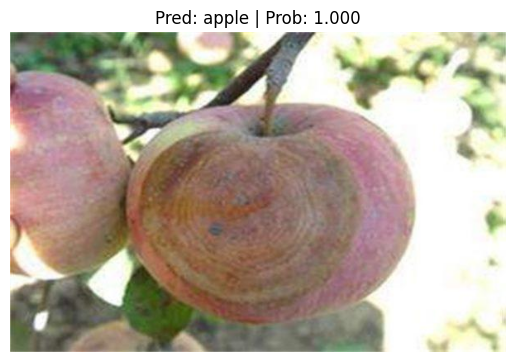

In [168]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

# Setup custom image path
custom_image_path = "test.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)